In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "orig"
enable_aug = False
enable_aug3 = True
sentence_pairs = True
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-orig-enable_aug-False-enable_aug3-True-sentence_pairs-True-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

194419


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

194419
194419
1914
1914


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


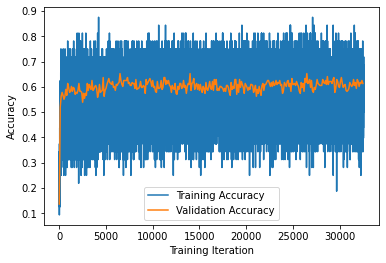

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.205 Validation Loss: 2.197 Accuracy: 0.039 Validation Accuracy: 0.072:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.202 Validation Loss: 2.197 Accuracy: 0.051 Validation Accuracy: 0.072:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.198 Validation Loss: 2.197 Accuracy: 0.083 Validation Accuracy: 0.072:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.192 Validation Loss: 2.197 Accuracy: 0.117 Validation Accuracy: 0.072:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.188 Validation Loss: 2.197 Accuracy: 0.155 Validation Accuracy: 0.072:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.188 Validation Loss: 2.197 Accuracy: 0.155 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 5 Loss: 2.183 Validation Loss: 2.197 Accuracy: 0.186 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 6 Loss: 2.179 Validation Loss: 2.197 Accuracy: 0.204 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 7 Loss: 2.174 Validation Loss: 2.197 Accuracy: 0.227 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 8 Loss: 2.171 Validation Loss: 2.197 Accuracy: 0.241 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 9 Loss: 2.166 Validation Loss: 2.197 Accuracy: 0.263 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 10 Loss: 2.162 Validation Loss: 2.197 Accuracy: 0.305 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 11 Loss: 2.157 Validation Loss: 2.197 Accuracy: 0.342 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 12 Loss: 2.152 Validation Loss: 2.197 Accuracy: 0.377 Validation Accuracy: 0.072:   0%|          | 5/1519 [00:00<00:30, 49.19it/s]

Epoch: 0 Iteration: 12 Loss: 2.152 Validation Loss: 2.197 Accuracy: 0.377 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 13 Loss: 2.149 Validation Loss: 2.197 Accuracy: 0.401 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 14 Loss: 2.145 Validation Loss: 2.197 Accuracy: 0.427 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 15 Loss: 2.140 Validation Loss: 2.197 Accuracy: 0.445 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 16 Loss: 2.136 Validation Loss: 2.197 Accuracy: 0.469 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 17 Loss: 2.131 Validation Loss: 2.197 Accuracy: 0.487 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 18 Loss: 2.127 Validation Loss: 2.197 Accuracy: 0.509 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 19 Loss: 2.123 Validation Loss: 2.197 Accuracy: 0.522 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 20 Loss: 2.114 Validation Loss: 2.197 Accuracy: 0.534 Validation Accuracy: 0.072:   1%|          | 13/1519 [00:00<00:23, 62.83it/s]

Epoch: 0 Iteration: 20 Loss: 2.114 Validation Loss: 2.197 Accuracy: 0.534 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 21 Loss: 2.107 Validation Loss: 2.197 Accuracy: 0.537 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 22 Loss: 2.098 Validation Loss: 2.197 Accuracy: 0.545 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 23 Loss: 2.091 Validation Loss: 2.197 Accuracy: 0.555 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 24 Loss: 2.083 Validation Loss: 2.197 Accuracy: 0.556 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 25 Loss: 2.074 Validation Loss: 2.197 Accuracy: 0.555 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 26 Loss: 2.067 Validation Loss: 2.197 Accuracy: 0.559 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 27 Loss: 2.060 Validation Loss: 2.197 Accuracy: 0.555 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 28 Loss: 2.052 Validation Loss: 2.197 Accuracy: 0.557 Validation Accuracy: 0.072:   1%|▏         | 21/1519 [00:00<00:21, 69.15it/s]

Epoch: 0 Iteration: 28 Loss: 2.052 Validation Loss: 2.197 Accuracy: 0.557 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 29 Loss: 2.044 Validation Loss: 2.197 Accuracy: 0.562 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 30 Loss: 2.036 Validation Loss: 2.197 Accuracy: 0.566 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 31 Loss: 2.028 Validation Loss: 2.197 Accuracy: 0.578 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 32 Loss: 2.020 Validation Loss: 2.197 Accuracy: 0.574 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 33 Loss: 2.010 Validation Loss: 2.197 Accuracy: 0.580 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 34 Loss: 2.003 Validation Loss: 2.197 Accuracy: 0.578 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 35 Loss: 1.994 Validation Loss: 2.197 Accuracy: 0.583 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 36 Loss: 1.987 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   2%|▏         | 29/1519 [00:00<00:20, 72.40it/s]

Epoch: 0 Iteration: 36 Loss: 1.987 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 37 Loss: 1.979 Validation Loss: 2.197 Accuracy: 0.581 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 38 Loss: 1.973 Validation Loss: 2.197 Accuracy: 0.572 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 39 Loss: 1.964 Validation Loss: 2.197 Accuracy: 0.566 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 40 Loss: 1.958 Validation Loss: 2.197 Accuracy: 0.562 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 41 Loss: 1.949 Validation Loss: 2.197 Accuracy: 0.557 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 42 Loss: 1.941 Validation Loss: 2.197 Accuracy: 0.562 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 43 Loss: 1.933 Validation Loss: 2.197 Accuracy: 0.559 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 44 Loss: 1.925 Validation Loss: 2.197 Accuracy: 0.568 Validation Accuracy: 0.072:   2%|▏         | 37/1519 [00:00<00:19, 74.20it/s]

Epoch: 0 Iteration: 44 Loss: 1.925 Validation Loss: 2.197 Accuracy: 0.568 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 45 Loss: 1.916 Validation Loss: 2.197 Accuracy: 0.570 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 46 Loss: 1.907 Validation Loss: 2.197 Accuracy: 0.570 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 47 Loss: 1.898 Validation Loss: 2.197 Accuracy: 0.580 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 48 Loss: 1.889 Validation Loss: 2.197 Accuracy: 0.589 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 49 Loss: 1.881 Validation Loss: 2.197 Accuracy: 0.588 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 50 Loss: 1.873 Validation Loss: 2.197 Accuracy: 0.588 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 51 Loss: 1.865 Validation Loss: 2.197 Accuracy: 0.596 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 52 Loss: 1.857 Validation Loss: 2.197 Accuracy: 0.600 Validation Accuracy: 0.072:   3%|▎         | 45/1519 [00:00<00:19, 74.84it/s]

Epoch: 0 Iteration: 52 Loss: 1.857 Validation Loss: 2.197 Accuracy: 0.600 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 53 Loss: 1.851 Validation Loss: 2.197 Accuracy: 0.595 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 54 Loss: 1.845 Validation Loss: 2.197 Accuracy: 0.586 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 55 Loss: 1.836 Validation Loss: 2.197 Accuracy: 0.592 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 56 Loss: 1.829 Validation Loss: 2.197 Accuracy: 0.594 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 57 Loss: 1.821 Validation Loss: 2.197 Accuracy: 0.594 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 58 Loss: 1.812 Validation Loss: 2.197 Accuracy: 0.597 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 59 Loss: 1.803 Validation Loss: 2.197 Accuracy: 0.598 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 60 Loss: 1.795 Validation Loss: 2.197 Accuracy: 0.603 Validation Accuracy: 0.072:   3%|▎         | 53/1519 [00:00<00:19, 75.27it/s]

Epoch: 0 Iteration: 60 Loss: 1.795 Validation Loss: 2.197 Accuracy: 0.603 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 61 Loss: 1.786 Validation Loss: 2.197 Accuracy: 0.605 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 62 Loss: 1.779 Validation Loss: 2.197 Accuracy: 0.601 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 63 Loss: 1.771 Validation Loss: 2.197 Accuracy: 0.605 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 64 Loss: 1.761 Validation Loss: 2.197 Accuracy: 0.607 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 65 Loss: 1.753 Validation Loss: 2.197 Accuracy: 0.602 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 66 Loss: 1.744 Validation Loss: 2.197 Accuracy: 0.600 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 67 Loss: 1.735 Validation Loss: 2.197 Accuracy: 0.595 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 68 Loss: 1.724 Validation Loss: 2.197 Accuracy: 0.592 Validation Accuracy: 0.072:   4%|▍         | 61/1519 [00:00<00:19, 75.60it/s]

Epoch: 0 Iteration: 68 Loss: 1.724 Validation Loss: 2.197 Accuracy: 0.592 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:00<00:19, 75.78it/s]

Epoch: 0 Iteration: 69 Loss: 1.716 Validation Loss: 2.197 Accuracy: 0.592 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:00<00:19, 75.78it/s]

Epoch: 0 Iteration: 70 Loss: 1.710 Validation Loss: 2.197 Accuracy: 0.580 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:00<00:19, 75.78it/s]

Epoch: 0 Iteration: 71 Loss: 1.703 Validation Loss: 2.197 Accuracy: 0.572 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:00<00:19, 75.78it/s]

Epoch: 0 Iteration: 72 Loss: 1.696 Validation Loss: 2.197 Accuracy: 0.571 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:00<00:19, 75.78it/s]

Epoch: 0 Iteration: 73 Loss: 1.685 Validation Loss: 2.197 Accuracy: 0.579 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:01<00:19, 75.78it/s]

Epoch: 0 Iteration: 74 Loss: 1.674 Validation Loss: 2.197 Accuracy: 0.578 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:01<00:19, 75.78it/s]

Epoch: 0 Iteration: 75 Loss: 1.664 Validation Loss: 2.197 Accuracy: 0.576 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:01<00:19, 75.78it/s]

Epoch: 0 Iteration: 76 Loss: 1.654 Validation Loss: 2.197 Accuracy: 0.572 Validation Accuracy: 0.072:   5%|▍         | 69/1519 [00:01<00:19, 75.78it/s]

Epoch: 0 Iteration: 76 Loss: 1.654 Validation Loss: 2.197 Accuracy: 0.572 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 77 Loss: 1.645 Validation Loss: 2.197 Accuracy: 0.573 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 78 Loss: 1.633 Validation Loss: 2.197 Accuracy: 0.576 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 79 Loss: 1.625 Validation Loss: 2.197 Accuracy: 0.577 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 80 Loss: 1.614 Validation Loss: 2.197 Accuracy: 0.576 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 81 Loss: 1.605 Validation Loss: 2.197 Accuracy: 0.582 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 82 Loss: 1.594 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 83 Loss: 1.586 Validation Loss: 2.197 Accuracy: 0.577 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 84 Loss: 1.577 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   5%|▌         | 77/1519 [00:01<00:18, 76.13it/s]

Epoch: 0 Iteration: 84 Loss: 1.577 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 85 Loss: 1.569 Validation Loss: 2.197 Accuracy: 0.584 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 86 Loss: 1.564 Validation Loss: 2.197 Accuracy: 0.578 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 87 Loss: 1.556 Validation Loss: 2.197 Accuracy: 0.577 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 88 Loss: 1.552 Validation Loss: 2.197 Accuracy: 0.566 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 89 Loss: 1.543 Validation Loss: 2.197 Accuracy: 0.560 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 90 Loss: 1.530 Validation Loss: 2.197 Accuracy: 0.573 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 91 Loss: 1.520 Validation Loss: 2.197 Accuracy: 0.571 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 92 Loss: 1.506 Validation Loss: 2.197 Accuracy: 0.581 Validation Accuracy: 0.072:   6%|▌         | 85/1519 [00:01<00:18, 76.44it/s]

Epoch: 0 Iteration: 92 Loss: 1.506 Validation Loss: 2.197 Accuracy: 0.581 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 93 Loss: 1.500 Validation Loss: 2.197 Accuracy: 0.587 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 94 Loss: 1.489 Validation Loss: 2.197 Accuracy: 0.582 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 95 Loss: 1.481 Validation Loss: 2.197 Accuracy: 0.592 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 96 Loss: 1.471 Validation Loss: 2.197 Accuracy: 0.605 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 97 Loss: 1.462 Validation Loss: 2.197 Accuracy: 0.608 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 98 Loss: 1.459 Validation Loss: 2.197 Accuracy: 0.620 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 99 Loss: 1.452 Validation Loss: 2.197 Accuracy: 0.630 Validation Accuracy: 0.072:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 100 Loss: 1.447 Validation Loss: 1.303 Accuracy: 0.621 Validation Accuracy: 0.370:   6%|▌         | 93/1519 [00:01<00:18, 76.63it/s]

Epoch: 0 Iteration: 100 Loss: 1.447 Validation Loss: 1.303 Accuracy: 0.621 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 101 Loss: 1.437 Validation Loss: 1.303 Accuracy: 0.623 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 102 Loss: 1.430 Validation Loss: 1.303 Accuracy: 0.616 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 103 Loss: 1.422 Validation Loss: 1.303 Accuracy: 0.609 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 104 Loss: 1.417 Validation Loss: 1.303 Accuracy: 0.615 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 105 Loss: 1.408 Validation Loss: 1.303 Accuracy: 0.612 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 106 Loss: 1.395 Validation Loss: 1.303 Accuracy: 0.610 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 107 Loss: 1.390 Validation Loss: 1.303 Accuracy: 0.599 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 108 Loss: 1.381 Validation Loss: 1.303 Accuracy: 0.602 Validation Accuracy: 0.370:   7%|▋         | 101/1519 [00:01<00:19, 70.99it/s]

Epoch: 0 Iteration: 108 Loss: 1.381 Validation Loss: 1.303 Accuracy: 0.602 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 109 Loss: 1.370 Validation Loss: 1.303 Accuracy: 0.604 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 110 Loss: 1.362 Validation Loss: 1.303 Accuracy: 0.621 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 111 Loss: 1.352 Validation Loss: 1.303 Accuracy: 0.631 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 112 Loss: 1.346 Validation Loss: 1.303 Accuracy: 0.628 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 113 Loss: 1.339 Validation Loss: 1.303 Accuracy: 0.632 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 114 Loss: 1.334 Validation Loss: 1.303 Accuracy: 0.631 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 115 Loss: 1.331 Validation Loss: 1.303 Accuracy: 0.627 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 116 Loss: 1.325 Validation Loss: 1.303 Accuracy: 0.627 Validation Accuracy: 0.370:   7%|▋         | 109/1519 [00:01<00:19, 73.38it/s]

Epoch: 0 Iteration: 116 Loss: 1.325 Validation Loss: 1.303 Accuracy: 0.627 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 117 Loss: 1.316 Validation Loss: 1.303 Accuracy: 0.648 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 118 Loss: 1.302 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 119 Loss: 1.290 Validation Loss: 1.303 Accuracy: 0.661 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 120 Loss: 1.280 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 121 Loss: 1.276 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 122 Loss: 1.263 Validation Loss: 1.303 Accuracy: 0.658 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 123 Loss: 1.256 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 124 Loss: 1.246 Validation Loss: 1.303 Accuracy: 0.649 Validation Accuracy: 0.370:   8%|▊         | 117/1519 [00:01<00:18, 74.45it/s]

Epoch: 0 Iteration: 124 Loss: 1.246 Validation Loss: 1.303 Accuracy: 0.649 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 125 Loss: 1.240 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 126 Loss: 1.234 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 127 Loss: 1.229 Validation Loss: 1.303 Accuracy: 0.648 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 128 Loss: 1.223 Validation Loss: 1.303 Accuracy: 0.644 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 129 Loss: 1.218 Validation Loss: 1.303 Accuracy: 0.637 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 130 Loss: 1.211 Validation Loss: 1.303 Accuracy: 0.638 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 131 Loss: 1.211 Validation Loss: 1.303 Accuracy: 0.634 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 132 Loss: 1.205 Validation Loss: 1.303 Accuracy: 0.634 Validation Accuracy: 0.370:   8%|▊         | 125/1519 [00:01<00:18, 75.23it/s]

Epoch: 0 Iteration: 132 Loss: 1.205 Validation Loss: 1.303 Accuracy: 0.634 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 133 Loss: 1.198 Validation Loss: 1.303 Accuracy: 0.647 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 134 Loss: 1.188 Validation Loss: 1.303 Accuracy: 0.651 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 135 Loss: 1.180 Validation Loss: 1.303 Accuracy: 0.650 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 136 Loss: 1.177 Validation Loss: 1.303 Accuracy: 0.650 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 137 Loss: 1.176 Validation Loss: 1.303 Accuracy: 0.642 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 138 Loss: 1.171 Validation Loss: 1.303 Accuracy: 0.641 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 139 Loss: 1.168 Validation Loss: 1.303 Accuracy: 0.645 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 140 Loss: 1.162 Validation Loss: 1.303 Accuracy: 0.642 Validation Accuracy: 0.370:   9%|▉         | 133/1519 [00:01<00:18, 75.71it/s]

Epoch: 0 Iteration: 140 Loss: 1.162 Validation Loss: 1.303 Accuracy: 0.642 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 141 Loss: 1.155 Validation Loss: 1.303 Accuracy: 0.648 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 142 Loss: 1.157 Validation Loss: 1.303 Accuracy: 0.650 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 143 Loss: 1.148 Validation Loss: 1.303 Accuracy: 0.656 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 144 Loss: 1.146 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 145 Loss: 1.141 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 146 Loss: 1.134 Validation Loss: 1.303 Accuracy: 0.664 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 147 Loss: 1.121 Validation Loss: 1.303 Accuracy: 0.675 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:01<00:18, 75.95it/s]

Epoch: 0 Iteration: 148 Loss: 1.117 Validation Loss: 1.303 Accuracy: 0.679 Validation Accuracy: 0.370:   9%|▉         | 141/1519 [00:02<00:18, 75.95it/s]

Epoch: 0 Iteration: 148 Loss: 1.117 Validation Loss: 1.303 Accuracy: 0.679 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 149 Loss: 1.110 Validation Loss: 1.303 Accuracy: 0.679 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 150 Loss: 1.102 Validation Loss: 1.303 Accuracy: 0.685 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 151 Loss: 1.094 Validation Loss: 1.303 Accuracy: 0.677 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 152 Loss: 1.087 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 153 Loss: 1.084 Validation Loss: 1.303 Accuracy: 0.666 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 154 Loss: 1.083 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 155 Loss: 1.075 Validation Loss: 1.303 Accuracy: 0.671 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 156 Loss: 1.069 Validation Loss: 1.303 Accuracy: 0.667 Validation Accuracy: 0.370:  10%|▉         | 149/1519 [00:02<00:18, 76.02it/s]

Epoch: 0 Iteration: 156 Loss: 1.069 Validation Loss: 1.303 Accuracy: 0.667 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 157 Loss: 1.065 Validation Loss: 1.303 Accuracy: 0.655 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 158 Loss: 1.066 Validation Loss: 1.303 Accuracy: 0.649 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 159 Loss: 1.059 Validation Loss: 1.303 Accuracy: 0.644 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 160 Loss: 1.054 Validation Loss: 1.303 Accuracy: 0.639 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 161 Loss: 1.047 Validation Loss: 1.303 Accuracy: 0.650 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 162 Loss: 1.035 Validation Loss: 1.303 Accuracy: 0.648 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 163 Loss: 1.038 Validation Loss: 1.303 Accuracy: 0.653 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 164 Loss: 1.031 Validation Loss: 1.303 Accuracy: 0.653 Validation Accuracy: 0.370:  10%|█         | 157/1519 [00:02<00:17, 76.27it/s]

Epoch: 0 Iteration: 164 Loss: 1.031 Validation Loss: 1.303 Accuracy: 0.653 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 165 Loss: 1.029 Validation Loss: 1.303 Accuracy: 0.652 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 166 Loss: 1.026 Validation Loss: 1.303 Accuracy: 0.645 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 167 Loss: 1.024 Validation Loss: 1.303 Accuracy: 0.659 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 168 Loss: 1.014 Validation Loss: 1.303 Accuracy: 0.664 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 169 Loss: 1.010 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 170 Loss: 1.007 Validation Loss: 1.303 Accuracy: 0.678 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 171 Loss: 1.003 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 172 Loss: 1.002 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.370:  11%|█         | 165/1519 [00:02<00:17, 76.37it/s]

Epoch: 0 Iteration: 172 Loss: 1.002 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 173 Loss: 0.994 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 174 Loss: 0.992 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 175 Loss: 0.989 Validation Loss: 1.303 Accuracy: 0.676 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 176 Loss: 0.980 Validation Loss: 1.303 Accuracy: 0.684 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 177 Loss: 0.979 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 178 Loss: 0.970 Validation Loss: 1.303 Accuracy: 0.682 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 179 Loss: 0.967 Validation Loss: 1.303 Accuracy: 0.677 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 180 Loss: 0.967 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.370:  11%|█▏        | 173/1519 [00:02<00:17, 76.55it/s]

Epoch: 0 Iteration: 180 Loss: 0.967 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 181 Loss: 0.965 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 182 Loss: 0.966 Validation Loss: 1.303 Accuracy: 0.675 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 183 Loss: 0.957 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 184 Loss: 0.953 Validation Loss: 1.303 Accuracy: 0.677 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 185 Loss: 0.944 Validation Loss: 1.303 Accuracy: 0.676 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 186 Loss: 0.943 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 187 Loss: 0.938 Validation Loss: 1.303 Accuracy: 0.676 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 188 Loss: 0.934 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  12%|█▏        | 181/1519 [00:02<00:17, 76.75it/s]

Epoch: 0 Iteration: 188 Loss: 0.934 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 189 Loss: 0.934 Validation Loss: 1.303 Accuracy: 0.671 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 190 Loss: 0.928 Validation Loss: 1.303 Accuracy: 0.680 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 191 Loss: 0.925 Validation Loss: 1.303 Accuracy: 0.673 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 192 Loss: 0.921 Validation Loss: 1.303 Accuracy: 0.672 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 193 Loss: 0.923 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 194 Loss: 0.915 Validation Loss: 1.303 Accuracy: 0.670 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 195 Loss: 0.909 Validation Loss: 1.303 Accuracy: 0.669 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 196 Loss: 0.911 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  12%|█▏        | 189/1519 [00:02<00:17, 76.83it/s]

Epoch: 0 Iteration: 196 Loss: 0.911 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 197 Loss: 0.903 Validation Loss: 1.303 Accuracy: 0.674 Validation Accuracy: 0.370:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 198 Loss: 0.906 Validation Loss: 1.303 Accuracy: 0.665 Validation Accuracy: 0.370:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 199 Loss: 0.903 Validation Loss: 1.303 Accuracy: 0.668 Validation Accuracy: 0.370:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 200 Loss: 0.900 Validation Loss: 0.849 Accuracy: 0.667 Validation Accuracy: 0.479:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 201 Loss: 0.898 Validation Loss: 0.849 Accuracy: 0.675 Validation Accuracy: 0.479:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 202 Loss: 0.892 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 203 Loss: 0.890 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 204 Loss: 0.895 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  13%|█▎        | 197/1519 [00:02<00:17, 76.58it/s]

Epoch: 0 Iteration: 204 Loss: 0.895 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 205 Loss: 0.892 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 206 Loss: 0.882 Validation Loss: 0.849 Accuracy: 0.684 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 207 Loss: 0.880 Validation Loss: 0.849 Accuracy: 0.686 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 208 Loss: 0.885 Validation Loss: 0.849 Accuracy: 0.694 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 209 Loss: 0.883 Validation Loss: 0.849 Accuracy: 0.695 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 210 Loss: 0.892 Validation Loss: 0.849 Accuracy: 0.683 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 211 Loss: 0.887 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 212 Loss: 0.886 Validation Loss: 0.849 Accuracy: 0.686 Validation Accuracy: 0.479:  13%|█▎        | 205/1519 [00:02<00:18, 71.63it/s]

Epoch: 0 Iteration: 212 Loss: 0.886 Validation Loss: 0.849 Accuracy: 0.686 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 213 Loss: 0.879 Validation Loss: 0.849 Accuracy: 0.688 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 214 Loss: 0.880 Validation Loss: 0.849 Accuracy: 0.700 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 215 Loss: 0.879 Validation Loss: 0.849 Accuracy: 0.691 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 216 Loss: 0.877 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 217 Loss: 0.872 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 218 Loss: 0.861 Validation Loss: 0.849 Accuracy: 0.684 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 219 Loss: 0.863 Validation Loss: 0.849 Accuracy: 0.683 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 220 Loss: 0.860 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  14%|█▍        | 213/1519 [00:02<00:17, 73.04it/s]

Epoch: 0 Iteration: 220 Loss: 0.860 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:02<00:17, 74.13it/s]

Epoch: 0 Iteration: 221 Loss: 0.858 Validation Loss: 0.849 Accuracy: 0.684 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:02<00:17, 74.13it/s]

Epoch: 0 Iteration: 222 Loss: 0.857 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:02<00:17, 74.13it/s]

Epoch: 0 Iteration: 223 Loss: 0.855 Validation Loss: 0.849 Accuracy: 0.678 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 224 Loss: 0.847 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 225 Loss: 0.846 Validation Loss: 0.849 Accuracy: 0.682 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 226 Loss: 0.850 Validation Loss: 0.849 Accuracy: 0.686 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 227 Loss: 0.848 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 228 Loss: 0.844 Validation Loss: 0.849 Accuracy: 0.672 Validation Accuracy: 0.479:  15%|█▍        | 221/1519 [00:03<00:17, 74.13it/s]

Epoch: 0 Iteration: 228 Loss: 0.844 Validation Loss: 0.849 Accuracy: 0.672 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 229 Loss: 0.843 Validation Loss: 0.849 Accuracy: 0.676 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 230 Loss: 0.839 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 231 Loss: 0.835 Validation Loss: 0.849 Accuracy: 0.682 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 232 Loss: 0.836 Validation Loss: 0.849 Accuracy: 0.681 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 233 Loss: 0.834 Validation Loss: 0.849 Accuracy: 0.683 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 234 Loss: 0.842 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 235 Loss: 0.841 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 236 Loss: 0.846 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  15%|█▌        | 229/1519 [00:03<00:17, 74.95it/s]

Epoch: 0 Iteration: 236 Loss: 0.846 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 237 Loss: 0.852 Validation Loss: 0.849 Accuracy: 0.668 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 238 Loss: 0.860 Validation Loss: 0.849 Accuracy: 0.669 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 239 Loss: 0.856 Validation Loss: 0.849 Accuracy: 0.666 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 240 Loss: 0.852 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 241 Loss: 0.860 Validation Loss: 0.849 Accuracy: 0.657 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 242 Loss: 0.857 Validation Loss: 0.849 Accuracy: 0.659 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 243 Loss: 0.856 Validation Loss: 0.849 Accuracy: 0.657 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 244 Loss: 0.851 Validation Loss: 0.849 Accuracy: 0.669 Validation Accuracy: 0.479:  16%|█▌        | 237/1519 [00:03<00:16, 75.53it/s]

Epoch: 0 Iteration: 244 Loss: 0.851 Validation Loss: 0.849 Accuracy: 0.669 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 245 Loss: 0.857 Validation Loss: 0.849 Accuracy: 0.660 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 246 Loss: 0.854 Validation Loss: 0.849 Accuracy: 0.666 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 247 Loss: 0.852 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 248 Loss: 0.849 Validation Loss: 0.849 Accuracy: 0.674 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 249 Loss: 0.845 Validation Loss: 0.849 Accuracy: 0.679 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 250 Loss: 0.847 Validation Loss: 0.849 Accuracy: 0.669 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 251 Loss: 0.848 Validation Loss: 0.849 Accuracy: 0.682 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 252 Loss: 0.845 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  16%|█▌        | 245/1519 [00:03<00:16, 76.04it/s]

Epoch: 0 Iteration: 252 Loss: 0.845 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 253 Loss: 0.848 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 254 Loss: 0.839 Validation Loss: 0.849 Accuracy: 0.661 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 255 Loss: 0.838 Validation Loss: 0.849 Accuracy: 0.663 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 256 Loss: 0.834 Validation Loss: 0.849 Accuracy: 0.655 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 257 Loss: 0.830 Validation Loss: 0.849 Accuracy: 0.649 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 258 Loss: 0.828 Validation Loss: 0.849 Accuracy: 0.653 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 259 Loss: 0.826 Validation Loss: 0.849 Accuracy: 0.649 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 260 Loss: 0.826 Validation Loss: 0.849 Accuracy: 0.658 Validation Accuracy: 0.479:  17%|█▋        | 253/1519 [00:03<00:16, 76.34it/s]

Epoch: 0 Iteration: 260 Loss: 0.826 Validation Loss: 0.849 Accuracy: 0.658 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 261 Loss: 0.814 Validation Loss: 0.849 Accuracy: 0.661 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 262 Loss: 0.817 Validation Loss: 0.849 Accuracy: 0.666 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 263 Loss: 0.818 Validation Loss: 0.849 Accuracy: 0.667 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 264 Loss: 0.822 Validation Loss: 0.849 Accuracy: 0.670 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 265 Loss: 0.812 Validation Loss: 0.849 Accuracy: 0.679 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 266 Loss: 0.813 Validation Loss: 0.849 Accuracy: 0.687 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 267 Loss: 0.811 Validation Loss: 0.849 Accuracy: 0.691 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 268 Loss: 0.808 Validation Loss: 0.849 Accuracy: 0.690 Validation Accuracy: 0.479:  17%|█▋        | 261/1519 [00:03<00:16, 76.50it/s]

Epoch: 0 Iteration: 268 Loss: 0.808 Validation Loss: 0.849 Accuracy: 0.690 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 269 Loss: 0.814 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 270 Loss: 0.802 Validation Loss: 0.849 Accuracy: 0.687 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 271 Loss: 0.800 Validation Loss: 0.849 Accuracy: 0.684 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 272 Loss: 0.798 Validation Loss: 0.849 Accuracy: 0.680 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 273 Loss: 0.797 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 274 Loss: 0.791 Validation Loss: 0.849 Accuracy: 0.692 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 275 Loss: 0.787 Validation Loss: 0.849 Accuracy: 0.683 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 276 Loss: 0.782 Validation Loss: 0.849 Accuracy: 0.687 Validation Accuracy: 0.479:  18%|█▊        | 269/1519 [00:03<00:16, 76.57it/s]

Epoch: 0 Iteration: 276 Loss: 0.782 Validation Loss: 0.849 Accuracy: 0.687 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 277 Loss: 0.781 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 278 Loss: 0.781 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 279 Loss: 0.776 Validation Loss: 0.849 Accuracy: 0.696 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 280 Loss: 0.772 Validation Loss: 0.849 Accuracy: 0.701 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 281 Loss: 0.776 Validation Loss: 0.849 Accuracy: 0.698 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 282 Loss: 0.774 Validation Loss: 0.849 Accuracy: 0.696 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 283 Loss: 0.771 Validation Loss: 0.849 Accuracy: 0.692 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 284 Loss: 0.774 Validation Loss: 0.849 Accuracy: 0.681 Validation Accuracy: 0.479:  18%|█▊        | 277/1519 [00:03<00:16, 76.65it/s]

Epoch: 0 Iteration: 284 Loss: 0.774 Validation Loss: 0.849 Accuracy: 0.681 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 285 Loss: 0.779 Validation Loss: 0.849 Accuracy: 0.688 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 286 Loss: 0.778 Validation Loss: 0.849 Accuracy: 0.685 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 287 Loss: 0.783 Validation Loss: 0.849 Accuracy: 0.683 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 288 Loss: 0.790 Validation Loss: 0.849 Accuracy: 0.677 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 289 Loss: 0.786 Validation Loss: 0.849 Accuracy: 0.672 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 290 Loss: 0.788 Validation Loss: 0.849 Accuracy: 0.662 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 291 Loss: 0.793 Validation Loss: 0.849 Accuracy: 0.660 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 292 Loss: 0.797 Validation Loss: 0.849 Accuracy: 0.661 Validation Accuracy: 0.479:  19%|█▉        | 285/1519 [00:03<00:16, 76.68it/s]

Epoch: 0 Iteration: 292 Loss: 0.797 Validation Loss: 0.849 Accuracy: 0.661 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 293 Loss: 0.800 Validation Loss: 0.849 Accuracy: 0.662 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 294 Loss: 0.803 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 295 Loss: 0.799 Validation Loss: 0.849 Accuracy: 0.670 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 296 Loss: 0.802 Validation Loss: 0.849 Accuracy: 0.666 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 297 Loss: 0.794 Validation Loss: 0.849 Accuracy: 0.673 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 298 Loss: 0.795 Validation Loss: 0.849 Accuracy: 0.679 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 299 Loss: 0.798 Validation Loss: 0.849 Accuracy: 0.674 Validation Accuracy: 0.479:  19%|█▉        | 293/1519 [00:03<00:15, 76.76it/s]

Epoch: 0 Iteration: 300 Loss: 0.803 Validation Loss: 0.734 Accuracy: 0.673 Validation Accuracy: 0.538:  19%|█▉        | 293/1519 [00:04<00:15, 76.76it/s]

Epoch: 0 Iteration: 300 Loss: 0.803 Validation Loss: 0.734 Accuracy: 0.673 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 301 Loss: 0.794 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 302 Loss: 0.793 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 303 Loss: 0.787 Validation Loss: 0.734 Accuracy: 0.688 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 304 Loss: 0.789 Validation Loss: 0.734 Accuracy: 0.676 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 305 Loss: 0.786 Validation Loss: 0.734 Accuracy: 0.674 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 306 Loss: 0.781 Validation Loss: 0.734 Accuracy: 0.683 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 307 Loss: 0.776 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 308 Loss: 0.767 Validation Loss: 0.734 Accuracy: 0.689 Validation Accuracy: 0.538:  20%|█▉        | 301/1519 [00:04<00:17, 71.05it/s]

Epoch: 0 Iteration: 308 Loss: 0.767 Validation Loss: 0.734 Accuracy: 0.689 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 309 Loss: 0.766 Validation Loss: 0.734 Accuracy: 0.698 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 310 Loss: 0.765 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 311 Loss: 0.759 Validation Loss: 0.734 Accuracy: 0.694 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 312 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.696 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 313 Loss: 0.749 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 314 Loss: 0.746 Validation Loss: 0.734 Accuracy: 0.707 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 315 Loss: 0.755 Validation Loss: 0.734 Accuracy: 0.703 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 316 Loss: 0.754 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  20%|██        | 309/1519 [00:04<00:16, 73.06it/s]

Epoch: 0 Iteration: 316 Loss: 0.754 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 317 Loss: 0.757 Validation Loss: 0.734 Accuracy: 0.693 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 318 Loss: 0.748 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 319 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 320 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.689 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 321 Loss: 0.758 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 322 Loss: 0.755 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 323 Loss: 0.759 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 324 Loss: 0.749 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  21%|██        | 317/1519 [00:04<00:16, 73.91it/s]

Epoch: 0 Iteration: 324 Loss: 0.749 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 325 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.701 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 326 Loss: 0.749 Validation Loss: 0.734 Accuracy: 0.706 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 327 Loss: 0.755 Validation Loss: 0.734 Accuracy: 0.710 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 328 Loss: 0.764 Validation Loss: 0.734 Accuracy: 0.699 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 329 Loss: 0.762 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 330 Loss: 0.764 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 331 Loss: 0.766 Validation Loss: 0.734 Accuracy: 0.694 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 332 Loss: 0.773 Validation Loss: 0.734 Accuracy: 0.683 Validation Accuracy: 0.538:  21%|██▏       | 325/1519 [00:04<00:16, 74.53it/s]

Epoch: 0 Iteration: 332 Loss: 0.773 Validation Loss: 0.734 Accuracy: 0.683 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 333 Loss: 0.777 Validation Loss: 0.734 Accuracy: 0.675 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 334 Loss: 0.778 Validation Loss: 0.734 Accuracy: 0.668 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 335 Loss: 0.772 Validation Loss: 0.734 Accuracy: 0.672 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 336 Loss: 0.767 Validation Loss: 0.734 Accuracy: 0.675 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 337 Loss: 0.768 Validation Loss: 0.734 Accuracy: 0.671 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 338 Loss: 0.769 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 339 Loss: 0.765 Validation Loss: 0.734 Accuracy: 0.685 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 340 Loss: 0.761 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  22%|██▏       | 333/1519 [00:04<00:15, 74.89it/s]

Epoch: 0 Iteration: 340 Loss: 0.761 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 341 Loss: 0.754 Validation Loss: 0.734 Accuracy: 0.692 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 342 Loss: 0.757 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 343 Loss: 0.761 Validation Loss: 0.734 Accuracy: 0.710 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 344 Loss: 0.766 Validation Loss: 0.734 Accuracy: 0.707 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 345 Loss: 0.767 Validation Loss: 0.734 Accuracy: 0.705 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 346 Loss: 0.771 Validation Loss: 0.734 Accuracy: 0.703 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 347 Loss: 0.760 Validation Loss: 0.734 Accuracy: 0.712 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 348 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.538:  22%|██▏       | 341/1519 [00:04<00:15, 75.09it/s]

Epoch: 0 Iteration: 348 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.715 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 349 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.716 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 350 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 351 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 352 Loss: 0.741 Validation Loss: 0.734 Accuracy: 0.705 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 353 Loss: 0.734 Validation Loss: 0.734 Accuracy: 0.704 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 354 Loss: 0.736 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 355 Loss: 0.739 Validation Loss: 0.734 Accuracy: 0.702 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 356 Loss: 0.738 Validation Loss: 0.734 Accuracy: 0.701 Validation Accuracy: 0.538:  23%|██▎       | 349/1519 [00:04<00:15, 75.42it/s]

Epoch: 0 Iteration: 356 Loss: 0.738 Validation Loss: 0.734 Accuracy: 0.701 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 357 Loss: 0.741 Validation Loss: 0.734 Accuracy: 0.693 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 358 Loss: 0.746 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 359 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 360 Loss: 0.752 Validation Loss: 0.734 Accuracy: 0.679 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 361 Loss: 0.749 Validation Loss: 0.734 Accuracy: 0.679 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 362 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.678 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 363 Loss: 0.746 Validation Loss: 0.734 Accuracy: 0.679 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 364 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  24%|██▎       | 357/1519 [00:04<00:15, 75.61it/s]

Epoch: 0 Iteration: 364 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 365 Loss: 0.743 Validation Loss: 0.734 Accuracy: 0.682 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 366 Loss: 0.744 Validation Loss: 0.734 Accuracy: 0.681 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 367 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 368 Loss: 0.757 Validation Loss: 0.734 Accuracy: 0.681 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 369 Loss: 0.756 Validation Loss: 0.734 Accuracy: 0.684 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 370 Loss: 0.754 Validation Loss: 0.734 Accuracy: 0.683 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 371 Loss: 0.757 Validation Loss: 0.734 Accuracy: 0.681 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 372 Loss: 0.763 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  24%|██▍       | 365/1519 [00:04<00:15, 75.70it/s]

Epoch: 0 Iteration: 372 Loss: 0.763 Validation Loss: 0.734 Accuracy: 0.680 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:04<00:15, 75.97it/s]

Epoch: 0 Iteration: 373 Loss: 0.764 Validation Loss: 0.734 Accuracy: 0.678 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:04<00:15, 75.97it/s]

Epoch: 0 Iteration: 374 Loss: 0.759 Validation Loss: 0.734 Accuracy: 0.685 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 375 Loss: 0.758 Validation Loss: 0.734 Accuracy: 0.692 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 376 Loss: 0.759 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 377 Loss: 0.755 Validation Loss: 0.734 Accuracy: 0.688 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 378 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.693 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 379 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.689 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 380 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  25%|██▍       | 373/1519 [00:05<00:15, 75.97it/s]

Epoch: 0 Iteration: 380 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 381 Loss: 0.753 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 382 Loss: 0.757 Validation Loss: 0.734 Accuracy: 0.694 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 383 Loss: 0.756 Validation Loss: 0.734 Accuracy: 0.698 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 384 Loss: 0.748 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 385 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 386 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.691 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 387 Loss: 0.750 Validation Loss: 0.734 Accuracy: 0.692 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 388 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  25%|██▌       | 381/1519 [00:05<00:14, 76.27it/s]

Epoch: 0 Iteration: 388 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.697 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 389 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.694 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 390 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.700 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 391 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.695 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 392 Loss: 0.744 Validation Loss: 0.734 Accuracy: 0.703 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 393 Loss: 0.746 Validation Loss: 0.734 Accuracy: 0.696 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 394 Loss: 0.748 Validation Loss: 0.734 Accuracy: 0.692 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 395 Loss: 0.751 Validation Loss: 0.734 Accuracy: 0.690 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 396 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.704 Validation Accuracy: 0.538:  26%|██▌       | 389/1519 [00:05<00:14, 76.47it/s]

Epoch: 0 Iteration: 396 Loss: 0.747 Validation Loss: 0.734 Accuracy: 0.704 Validation Accuracy: 0.538:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 397 Loss: 0.743 Validation Loss: 0.734 Accuracy: 0.712 Validation Accuracy: 0.538:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 398 Loss: 0.746 Validation Loss: 0.734 Accuracy: 0.709 Validation Accuracy: 0.538:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 399 Loss: 0.740 Validation Loss: 0.734 Accuracy: 0.723 Validation Accuracy: 0.538:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 400 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.570:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 401 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.570:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 402 Loss: 0.736 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.570:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 403 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.570:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 404 Loss: 0.741 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.570:  26%|██▌       | 397/1519 [00:05<00:14, 76.65it/s]

Epoch: 0 Iteration: 404 Loss: 0.741 Validation Loss: 0.720 Accuracy: 0.714 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 405 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 406 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 407 Loss: 0.737 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 408 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 409 Loss: 0.735 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 410 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.673 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 411 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.670 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 412 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  27%|██▋       | 405/1519 [00:05<00:15, 71.66it/s]

Epoch: 0 Iteration: 412 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 413 Loss: 0.737 Validation Loss: 0.720 Accuracy: 0.682 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 414 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 415 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 416 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.679 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 417 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 418 Loss: 0.739 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 419 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.667 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 420 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  27%|██▋       | 413/1519 [00:05<00:15, 73.05it/s]

Epoch: 0 Iteration: 420 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 421 Loss: 0.750 Validation Loss: 0.720 Accuracy: 0.679 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 422 Loss: 0.745 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 423 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 424 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.687 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 425 Loss: 0.737 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 426 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 427 Loss: 0.744 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 428 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.570:  28%|██▊       | 421/1519 [00:05<00:14, 74.18it/s]

Epoch: 0 Iteration: 428 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.696 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 429 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 430 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 431 Loss: 0.739 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 432 Loss: 0.735 Validation Loss: 0.720 Accuracy: 0.700 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 433 Loss: 0.734 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 434 Loss: 0.733 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 435 Loss: 0.736 Validation Loss: 0.720 Accuracy: 0.670 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 436 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  28%|██▊       | 429/1519 [00:05<00:14, 74.88it/s]

Epoch: 0 Iteration: 436 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 437 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.671 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 438 Loss: 0.743 Validation Loss: 0.720 Accuracy: 0.676 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 439 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 440 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 441 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 442 Loss: 0.746 Validation Loss: 0.720 Accuracy: 0.674 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 443 Loss: 0.746 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 444 Loss: 0.746 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.570:  29%|██▉       | 437/1519 [00:05<00:14, 75.52it/s]

Epoch: 0 Iteration: 444 Loss: 0.746 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:05<00:14, 75.87it/s]

Epoch: 0 Iteration: 445 Loss: 0.753 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:05<00:14, 75.87it/s]

Epoch: 0 Iteration: 446 Loss: 0.757 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:05<00:14, 75.87it/s]

Epoch: 0 Iteration: 447 Loss: 0.757 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:05<00:14, 75.87it/s]

Epoch: 0 Iteration: 448 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:05<00:14, 75.87it/s]

Epoch: 0 Iteration: 449 Loss: 0.759 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:06<00:14, 75.87it/s]

Epoch: 0 Iteration: 450 Loss: 0.755 Validation Loss: 0.720 Accuracy: 0.675 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:06<00:14, 75.87it/s]

Epoch: 0 Iteration: 451 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.686 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:06<00:14, 75.87it/s]

Epoch: 0 Iteration: 452 Loss: 0.761 Validation Loss: 0.720 Accuracy: 0.682 Validation Accuracy: 0.570:  29%|██▉       | 445/1519 [00:06<00:14, 75.87it/s]

Epoch: 0 Iteration: 452 Loss: 0.761 Validation Loss: 0.720 Accuracy: 0.682 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 453 Loss: 0.764 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 454 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.685 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 455 Loss: 0.751 Validation Loss: 0.720 Accuracy: 0.679 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 456 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 457 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.675 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 458 Loss: 0.751 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 459 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.693 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 460 Loss: 0.753 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.570:  30%|██▉       | 453/1519 [00:06<00:14, 76.09it/s]

Epoch: 0 Iteration: 460 Loss: 0.753 Validation Loss: 0.720 Accuracy: 0.690 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 461 Loss: 0.754 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 462 Loss: 0.750 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 463 Loss: 0.750 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 464 Loss: 0.746 Validation Loss: 0.720 Accuracy: 0.692 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 465 Loss: 0.740 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 466 Loss: 0.732 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 467 Loss: 0.726 Validation Loss: 0.720 Accuracy: 0.703 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.724 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  30%|███       | 461/1519 [00:06<00:13, 76.33it/s]

Epoch: 0 Iteration: 468 Loss: 0.724 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 469 Loss: 0.718 Validation Loss: 0.720 Accuracy: 0.695 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 470 Loss: 0.718 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 471 Loss: 0.725 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 472 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 473 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.694 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 474 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 475 Loss: 0.718 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 476 Loss: 0.716 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███       | 469/1519 [00:06<00:13, 76.54it/s]

Epoch: 0 Iteration: 476 Loss: 0.716 Validation Loss: 0.720 Accuracy: 0.701 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 477 Loss: 0.708 Validation Loss: 0.720 Accuracy: 0.711 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 478 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 479 Loss: 0.718 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 480 Loss: 0.712 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 481 Loss: 0.714 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 482 Loss: 0.712 Validation Loss: 0.720 Accuracy: 0.721 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 483 Loss: 0.713 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 484 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.570:  31%|███▏      | 477/1519 [00:06<00:13, 76.57it/s]

Epoch: 0 Iteration: 484 Loss: 0.720 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 485 Loss: 0.724 Validation Loss: 0.720 Accuracy: 0.697 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 486 Loss: 0.733 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 487 Loss: 0.736 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 488 Loss: 0.738 Validation Loss: 0.720 Accuracy: 0.689 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 489 Loss: 0.731 Validation Loss: 0.720 Accuracy: 0.681 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 490 Loss: 0.729 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 491 Loss: 0.727 Validation Loss: 0.720 Accuracy: 0.680 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 492 Loss: 0.727 Validation Loss: 0.720 Accuracy: 0.673 Validation Accuracy: 0.570:  32%|███▏      | 485/1519 [00:06<00:13, 76.69it/s]

Epoch: 0 Iteration: 492 Loss: 0.727 Validation Loss: 0.720 Accuracy: 0.673 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 493 Loss: 0.734 Validation Loss: 0.720 Accuracy: 0.677 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 494 Loss: 0.741 Validation Loss: 0.720 Accuracy: 0.678 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 495 Loss: 0.742 Validation Loss: 0.720 Accuracy: 0.680 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 496 Loss: 0.744 Validation Loss: 0.720 Accuracy: 0.688 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 497 Loss: 0.748 Validation Loss: 0.720 Accuracy: 0.684 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 498 Loss: 0.739 Validation Loss: 0.720 Accuracy: 0.680 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 499 Loss: 0.745 Validation Loss: 0.720 Accuracy: 0.680 Validation Accuracy: 0.570:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 500 Loss: 0.751 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.594:  32%|███▏      | 493/1519 [00:06<00:13, 76.68it/s]

Epoch: 0 Iteration: 500 Loss: 0.751 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 501 Loss: 0.745 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 502 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 503 Loss: 0.750 Validation Loss: 0.705 Accuracy: 0.675 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 504 Loss: 0.750 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 505 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 506 Loss: 0.740 Validation Loss: 0.705 Accuracy: 0.673 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 507 Loss: 0.738 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 508 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.594:  33%|███▎      | 501/1519 [00:06<00:14, 70.98it/s]

Epoch: 0 Iteration: 508 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 509 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 510 Loss: 0.734 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 511 Loss: 0.737 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 512 Loss: 0.739 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 513 Loss: 0.729 Validation Loss: 0.705 Accuracy: 0.691 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 514 Loss: 0.730 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 515 Loss: 0.730 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 516 Loss: 0.728 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  34%|███▎      | 509/1519 [00:06<00:13, 73.40it/s]

Epoch: 0 Iteration: 516 Loss: 0.728 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 517 Loss: 0.728 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 518 Loss: 0.735 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 519 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 520 Loss: 0.725 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 521 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 522 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 523 Loss: 0.718 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:06<00:13, 74.41it/s]

Epoch: 0 Iteration: 524 Loss: 0.707 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.594:  34%|███▍      | 517/1519 [00:07<00:13, 74.41it/s]

Epoch: 0 Iteration: 524 Loss: 0.707 Validation Loss: 0.705 Accuracy: 0.706 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 525 Loss: 0.713 Validation Loss: 0.705 Accuracy: 0.709 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 526 Loss: 0.715 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 527 Loss: 0.720 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 528 Loss: 0.719 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 529 Loss: 0.719 Validation Loss: 0.705 Accuracy: 0.711 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 530 Loss: 0.725 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 531 Loss: 0.727 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 532 Loss: 0.731 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.594:  35%|███▍      | 525/1519 [00:07<00:13, 75.16it/s]

Epoch: 0 Iteration: 532 Loss: 0.731 Validation Loss: 0.705 Accuracy: 0.694 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 533 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.683 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 534 Loss: 0.733 Validation Loss: 0.705 Accuracy: 0.677 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 535 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.678 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 536 Loss: 0.727 Validation Loss: 0.705 Accuracy: 0.687 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 537 Loss: 0.726 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 538 Loss: 0.721 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 539 Loss: 0.720 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 540 Loss: 0.728 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  35%|███▌      | 533/1519 [00:07<00:13, 75.62it/s]

Epoch: 0 Iteration: 540 Loss: 0.728 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 541 Loss: 0.733 Validation Loss: 0.705 Accuracy: 0.681 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 542 Loss: 0.737 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 543 Loss: 0.747 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 544 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 545 Loss: 0.739 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 546 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 547 Loss: 0.737 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 548 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.594:  36%|███▌      | 541/1519 [00:07<00:12, 75.93it/s]

Epoch: 0 Iteration: 548 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 549 Loss: 0.748 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 550 Loss: 0.745 Validation Loss: 0.705 Accuracy: 0.690 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 551 Loss: 0.743 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 552 Loss: 0.740 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 553 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 554 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 555 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 556 Loss: 0.739 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.594:  36%|███▌      | 549/1519 [00:07<00:12, 76.30it/s]

Epoch: 0 Iteration: 556 Loss: 0.739 Validation Loss: 0.705 Accuracy: 0.701 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 557 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 558 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.708 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 559 Loss: 0.744 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 560 Loss: 0.746 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 561 Loss: 0.743 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 562 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 563 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.699 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 564 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  37%|███▋      | 557/1519 [00:07<00:12, 76.48it/s]

Epoch: 0 Iteration: 564 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.698 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 565 Loss: 0.735 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 566 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 567 Loss: 0.729 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 568 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.710 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 569 Loss: 0.731 Validation Loss: 0.705 Accuracy: 0.704 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 570 Loss: 0.725 Validation Loss: 0.705 Accuracy: 0.713 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 571 Loss: 0.727 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 572 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.594:  37%|███▋      | 565/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 572 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.703 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 573 Loss: 0.722 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 574 Loss: 0.726 Validation Loss: 0.705 Accuracy: 0.705 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 575 Loss: 0.737 Validation Loss: 0.705 Accuracy: 0.682 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 576 Loss: 0.740 Validation Loss: 0.705 Accuracy: 0.674 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 577 Loss: 0.741 Validation Loss: 0.705 Accuracy: 0.670 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 578 Loss: 0.745 Validation Loss: 0.705 Accuracy: 0.668 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 579 Loss: 0.747 Validation Loss: 0.705 Accuracy: 0.667 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 580 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.594:  38%|███▊      | 573/1519 [00:07<00:12, 76.67it/s]

Epoch: 0 Iteration: 580 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.671 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 581 Loss: 0.733 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 582 Loss: 0.734 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 583 Loss: 0.732 Validation Loss: 0.705 Accuracy: 0.688 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 584 Loss: 0.740 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 585 Loss: 0.753 Validation Loss: 0.705 Accuracy: 0.692 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 586 Loss: 0.758 Validation Loss: 0.705 Accuracy: 0.693 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 587 Loss: 0.757 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 588 Loss: 0.759 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.594:  38%|███▊      | 581/1519 [00:07<00:12, 76.65it/s]

Epoch: 0 Iteration: 588 Loss: 0.759 Validation Loss: 0.705 Accuracy: 0.697 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 589 Loss: 0.759 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 590 Loss: 0.757 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 591 Loss: 0.749 Validation Loss: 0.705 Accuracy: 0.684 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 592 Loss: 0.755 Validation Loss: 0.705 Accuracy: 0.685 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 593 Loss: 0.758 Validation Loss: 0.705 Accuracy: 0.680 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 594 Loss: 0.753 Validation Loss: 0.705 Accuracy: 0.682 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 595 Loss: 0.744 Validation Loss: 0.705 Accuracy: 0.689 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 596 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.594:  39%|███▉      | 589/1519 [00:07<00:12, 76.56it/s]

Epoch: 0 Iteration: 596 Loss: 0.736 Validation Loss: 0.705 Accuracy: 0.696 Validation Accuracy: 0.594:  39%|███▉      | 597/1519 [00:07<00:12, 76.55it/s]

Epoch: 0 Iteration: 597 Loss: 0.731 Validation Loss: 0.705 Accuracy: 0.695 Validation Accuracy: 0.594:  39%|███▉      | 597/1519 [00:07<00:12, 76.55it/s]

Epoch: 0 Iteration: 598 Loss: 0.724 Validation Loss: 0.705 Accuracy: 0.702 Validation Accuracy: 0.594:  39%|███▉      | 597/1519 [00:07<00:12, 76.55it/s]

Epoch: 0 Iteration: 599 Loss: 0.729 Validation Loss: 0.705 Accuracy: 0.700 Validation Accuracy: 0.594:  39%|███▉      | 597/1519 [00:07<00:12, 76.55it/s]

Epoch: 0 Iteration: 600 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.610:  39%|███▉      | 597/1519 [00:08<00:12, 76.55it/s]

Epoch: 0 Iteration: 601 Loss: 0.729 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  39%|███▉      | 597/1519 [00:08<00:12, 76.55it/s]

Epoch: 0 Iteration: 602 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.610:  39%|███▉      | 597/1519 [00:08<00:12, 76.55it/s]

Epoch: 0 Iteration: 603 Loss: 0.729 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.610:  39%|███▉      | 597/1519 [00:08<00:12, 76.55it/s]

Epoch: 0 Iteration: 604 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  39%|███▉      | 597/1519 [00:08<00:12, 76.55it/s]

Epoch: 0 Iteration: 604 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 605 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 606 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 607 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.699 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 608 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 609 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 610 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 611 Loss: 0.712 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 612 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  40%|███▉      | 605/1519 [00:08<00:12, 71.72it/s]

Epoch: 0 Iteration: 612 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 613 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 614 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.707 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 615 Loss: 0.715 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 616 Loss: 0.720 Validation Loss: 0.694 Accuracy: 0.696 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 617 Loss: 0.721 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 618 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 619 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 620 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.610:  40%|████      | 613/1519 [00:08<00:12, 72.89it/s]

Epoch: 0 Iteration: 620 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 621 Loss: 0.734 Validation Loss: 0.694 Accuracy: 0.677 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 622 Loss: 0.734 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 623 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.676 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 624 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 625 Loss: 0.742 Validation Loss: 0.694 Accuracy: 0.681 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 626 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 627 Loss: 0.740 Validation Loss: 0.694 Accuracy: 0.689 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 628 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  41%|████      | 621/1519 [00:08<00:12, 73.93it/s]

Epoch: 0 Iteration: 628 Loss: 0.748 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 629 Loss: 0.746 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 630 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 631 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 632 Loss: 0.743 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 633 Loss: 0.738 Validation Loss: 0.694 Accuracy: 0.703 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 634 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 635 Loss: 0.734 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 636 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  41%|████▏     | 629/1519 [00:08<00:11, 74.61it/s]

Epoch: 0 Iteration: 636 Loss: 0.737 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 637 Loss: 0.736 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 638 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 639 Loss: 0.727 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 640 Loss: 0.733 Validation Loss: 0.694 Accuracy: 0.675 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 641 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.682 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 642 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 643 Loss: 0.717 Validation Loss: 0.694 Accuracy: 0.687 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 644 Loss: 0.724 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.610:  42%|████▏     | 637/1519 [00:08<00:11, 75.14it/s]

Epoch: 0 Iteration: 644 Loss: 0.724 Validation Loss: 0.694 Accuracy: 0.680 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 645 Loss: 0.722 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 646 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 647 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 648 Loss: 0.724 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 649 Loss: 0.723 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 650 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 651 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 652 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.610:  42%|████▏     | 645/1519 [00:08<00:11, 75.61it/s]

Epoch: 0 Iteration: 652 Loss: 0.728 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 653 Loss: 0.726 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 654 Loss: 0.729 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 655 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 656 Loss: 0.716 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 657 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.693 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 658 Loss: 0.725 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 659 Loss: 0.717 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 660 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  43%|████▎     | 653/1519 [00:08<00:11, 75.94it/s]

Epoch: 0 Iteration: 660 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 661 Loss: 0.705 Validation Loss: 0.694 Accuracy: 0.709 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 662 Loss: 0.702 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 663 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 664 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 665 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 666 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 667 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.691 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 668 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.610:  44%|████▎     | 661/1519 [00:08<00:11, 76.10it/s]

Epoch: 0 Iteration: 668 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 669 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.684 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 670 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.686 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 671 Loss: 0.710 Validation Loss: 0.694 Accuracy: 0.683 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 672 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 673 Loss: 0.709 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 674 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.702 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:08<00:11, 76.25it/s]

Epoch: 0 Iteration: 675 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:09<00:11, 76.25it/s]

Epoch: 0 Iteration: 676 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.610:  44%|████▍     | 669/1519 [00:09<00:11, 76.25it/s]

Epoch: 0 Iteration: 676 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.718 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 677 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 678 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 679 Loss: 0.715 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 680 Loss: 0.719 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 681 Loss: 0.720 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 682 Loss: 0.718 Validation Loss: 0.694 Accuracy: 0.700 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 683 Loss: 0.716 Validation Loss: 0.694 Accuracy: 0.695 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 684 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  45%|████▍     | 677/1519 [00:09<00:11, 76.36it/s]

Epoch: 0 Iteration: 684 Loss: 0.711 Validation Loss: 0.694 Accuracy: 0.697 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 685 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.694 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 686 Loss: 0.708 Validation Loss: 0.694 Accuracy: 0.692 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 687 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.698 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 688 Loss: 0.698 Validation Loss: 0.694 Accuracy: 0.708 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 689 Loss: 0.703 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 690 Loss: 0.700 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 691 Loss: 0.699 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 692 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  45%|████▌     | 685/1519 [00:09<00:10, 76.46it/s]

Epoch: 0 Iteration: 692 Loss: 0.704 Validation Loss: 0.694 Accuracy: 0.711 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 693 Loss: 0.706 Validation Loss: 0.694 Accuracy: 0.712 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 694 Loss: 0.707 Validation Loss: 0.694 Accuracy: 0.710 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 695 Loss: 0.714 Validation Loss: 0.694 Accuracy: 0.706 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 696 Loss: 0.716 Validation Loss: 0.694 Accuracy: 0.705 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 697 Loss: 0.721 Validation Loss: 0.694 Accuracy: 0.701 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 698 Loss: 0.722 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 699 Loss: 0.722 Validation Loss: 0.694 Accuracy: 0.688 Validation Accuracy: 0.610:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 700 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.624:  46%|████▌     | 693/1519 [00:09<00:10, 76.47it/s]

Epoch: 0 Iteration: 700 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 701 Loss: 0.732 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 702 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 703 Loss: 0.729 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 704 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.677 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 705 Loss: 0.739 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 706 Loss: 0.738 Validation Loss: 0.706 Accuracy: 0.671 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 707 Loss: 0.742 Validation Loss: 0.706 Accuracy: 0.673 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 708 Loss: 0.745 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.624:  46%|████▌     | 701/1519 [00:09<00:11, 70.80it/s]

Epoch: 0 Iteration: 708 Loss: 0.745 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 709 Loss: 0.739 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 710 Loss: 0.746 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 711 Loss: 0.747 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 712 Loss: 0.744 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 713 Loss: 0.747 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 714 Loss: 0.749 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 715 Loss: 0.749 Validation Loss: 0.706 Accuracy: 0.678 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 716 Loss: 0.748 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  47%|████▋     | 709/1519 [00:09<00:11, 73.29it/s]

Epoch: 0 Iteration: 716 Loss: 0.748 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 717 Loss: 0.738 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 718 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 719 Loss: 0.729 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 720 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 721 Loss: 0.726 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 722 Loss: 0.728 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 723 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 724 Loss: 0.728 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.624:  47%|████▋     | 717/1519 [00:09<00:10, 74.33it/s]

Epoch: 0 Iteration: 724 Loss: 0.728 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 725 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 726 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 727 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 728 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 729 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 730 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 731 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 732 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  48%|████▊     | 725/1519 [00:09<00:10, 75.12it/s]

Epoch: 0 Iteration: 732 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 733 Loss: 0.709 Validation Loss: 0.706 Accuracy: 0.706 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 734 Loss: 0.704 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 735 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 736 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.703 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 737 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 738 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 739 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 740 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.624:  48%|████▊     | 733/1519 [00:09<00:10, 75.74it/s]

Epoch: 0 Iteration: 740 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.707 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 741 Loss: 0.710 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 742 Loss: 0.715 Validation Loss: 0.706 Accuracy: 0.702 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 743 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 744 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 745 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.697 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 746 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 747 Loss: 0.723 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 748 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  49%|████▉     | 741/1519 [00:09<00:10, 76.12it/s]

Epoch: 0 Iteration: 748 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:09<00:10, 76.35it/s]

Epoch: 0 Iteration: 749 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:09<00:10, 76.35it/s]

Epoch: 0 Iteration: 750 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 751 Loss: 0.724 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 752 Loss: 0.721 Validation Loss: 0.706 Accuracy: 0.699 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 753 Loss: 0.718 Validation Loss: 0.706 Accuracy: 0.698 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 754 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 755 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 756 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.624:  49%|████▉     | 749/1519 [00:10<00:10, 76.35it/s]

Epoch: 0 Iteration: 756 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 757 Loss: 0.707 Validation Loss: 0.706 Accuracy: 0.705 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 758 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 759 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 760 Loss: 0.717 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 761 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 762 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 763 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.683 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 764 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.624:  50%|████▉     | 757/1519 [00:10<00:09, 76.33it/s]

Epoch: 0 Iteration: 764 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.676 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 765 Loss: 0.713 Validation Loss: 0.706 Accuracy: 0.682 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 766 Loss: 0.712 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 767 Loss: 0.706 Validation Loss: 0.706 Accuracy: 0.681 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 768 Loss: 0.702 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 769 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 770 Loss: 0.719 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 771 Loss: 0.714 Validation Loss: 0.706 Accuracy: 0.695 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 772 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.624:  50%|█████     | 765/1519 [00:10<00:09, 76.41it/s]

Epoch: 0 Iteration: 772 Loss: 0.711 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 773 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 774 Loss: 0.735 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 775 Loss: 0.736 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 776 Loss: 0.744 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 777 Loss: 0.744 Validation Loss: 0.706 Accuracy: 0.679 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 778 Loss: 0.732 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 779 Loss: 0.733 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 780 Loss: 0.733 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  51%|█████     | 773/1519 [00:10<00:09, 76.42it/s]

Epoch: 0 Iteration: 780 Loss: 0.733 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 781 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 782 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.674 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 783 Loss: 0.735 Validation Loss: 0.706 Accuracy: 0.680 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 784 Loss: 0.731 Validation Loss: 0.706 Accuracy: 0.685 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 785 Loss: 0.738 Validation Loss: 0.706 Accuracy: 0.686 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 786 Loss: 0.737 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 787 Loss: 0.735 Validation Loss: 0.706 Accuracy: 0.700 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 788 Loss: 0.734 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.624:  51%|█████▏    | 781/1519 [00:10<00:09, 76.52it/s]

Epoch: 0 Iteration: 788 Loss: 0.734 Validation Loss: 0.706 Accuracy: 0.692 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 789 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 790 Loss: 0.730 Validation Loss: 0.706 Accuracy: 0.688 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 791 Loss: 0.736 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 792 Loss: 0.742 Validation Loss: 0.706 Accuracy: 0.687 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 793 Loss: 0.729 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 794 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.696 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 795 Loss: 0.725 Validation Loss: 0.706 Accuracy: 0.701 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 796 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  52%|█████▏    | 789/1519 [00:10<00:09, 76.67it/s]

Epoch: 0 Iteration: 796 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.691 Validation Accuracy: 0.624:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 797 Loss: 0.720 Validation Loss: 0.706 Accuracy: 0.684 Validation Accuracy: 0.624:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 798 Loss: 0.722 Validation Loss: 0.706 Accuracy: 0.693 Validation Accuracy: 0.624:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 799 Loss: 0.727 Validation Loss: 0.706 Accuracy: 0.694 Validation Accuracy: 0.624:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 800 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.635:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 801 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 802 Loss: 0.732 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.635:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 803 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.635:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 804 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.635:  52%|█████▏    | 797/1519 [00:10<00:09, 76.74it/s]

Epoch: 0 Iteration: 804 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 805 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 806 Loss: 0.733 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 807 Loss: 0.734 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 808 Loss: 0.735 Validation Loss: 0.699 Accuracy: 0.676 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 809 Loss: 0.734 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 810 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 811 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 812 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.635:  53%|█████▎    | 805/1519 [00:10<00:09, 71.80it/s]

Epoch: 0 Iteration: 812 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 813 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 814 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 815 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 816 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 817 Loss: 0.723 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 818 Loss: 0.735 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 819 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 820 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  54%|█████▎    | 813/1519 [00:10<00:09, 73.13it/s]

Epoch: 0 Iteration: 820 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:10<00:09, 74.20it/s]

Epoch: 0 Iteration: 821 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:10<00:09, 74.20it/s]

Epoch: 0 Iteration: 822 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:10<00:09, 74.20it/s]

Epoch: 0 Iteration: 823 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:10<00:09, 74.20it/s]

Epoch: 0 Iteration: 824 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.702 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:10<00:09, 74.20it/s]

Epoch: 0 Iteration: 825 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:11<00:09, 74.20it/s]

Epoch: 0 Iteration: 826 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:11<00:09, 74.20it/s]

Epoch: 0 Iteration: 827 Loss: 0.724 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:11<00:09, 74.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.724 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.635:  54%|█████▍    | 821/1519 [00:11<00:09, 74.20it/s]

Epoch: 0 Iteration: 828 Loss: 0.724 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 829 Loss: 0.724 Validation Loss: 0.699 Accuracy: 0.686 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 830 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 831 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.670 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 832 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.673 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 833 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.669 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 834 Loss: 0.737 Validation Loss: 0.699 Accuracy: 0.665 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 835 Loss: 0.738 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 836 Loss: 0.735 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.635:  55%|█████▍    | 829/1519 [00:11<00:09, 74.82it/s]

Epoch: 0 Iteration: 836 Loss: 0.735 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 837 Loss: 0.731 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 838 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 839 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 840 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.696 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 841 Loss: 0.732 Validation Loss: 0.699 Accuracy: 0.700 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 842 Loss: 0.732 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 843 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 844 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.635:  55%|█████▌    | 837/1519 [00:11<00:09, 75.26it/s]

Epoch: 0 Iteration: 844 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 845 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 846 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 847 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 848 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 849 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 850 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.688 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 851 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.690 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 852 Loss: 0.718 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.635:  56%|█████▌    | 845/1519 [00:11<00:08, 75.58it/s]

Epoch: 0 Iteration: 852 Loss: 0.718 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 853 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 854 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 855 Loss: 0.709 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 856 Loss: 0.712 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 857 Loss: 0.713 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 858 Loss: 0.712 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 859 Loss: 0.716 Validation Loss: 0.699 Accuracy: 0.694 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 860 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  56%|█████▌    | 853/1519 [00:11<00:08, 75.74it/s]

Epoch: 0 Iteration: 860 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 861 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 862 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.682 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 863 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 864 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.683 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 865 Loss: 0.726 Validation Loss: 0.699 Accuracy: 0.681 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 866 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 867 Loss: 0.729 Validation Loss: 0.699 Accuracy: 0.679 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 868 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.635:  57%|█████▋    | 861/1519 [00:11<00:08, 75.83it/s]

Epoch: 0 Iteration: 868 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.672 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 869 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.678 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 870 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.693 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 871 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 872 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 873 Loss: 0.727 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 874 Loss: 0.728 Validation Loss: 0.699 Accuracy: 0.692 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 875 Loss: 0.732 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 876 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  57%|█████▋    | 869/1519 [00:11<00:08, 75.97it/s]

Epoch: 0 Iteration: 876 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 877 Loss: 0.734 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 878 Loss: 0.737 Validation Loss: 0.699 Accuracy: 0.701 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 879 Loss: 0.731 Validation Loss: 0.699 Accuracy: 0.706 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 880 Loss: 0.730 Validation Loss: 0.699 Accuracy: 0.698 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 881 Loss: 0.725 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 882 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.699 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 883 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.712 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 884 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.635:  58%|█████▊    | 877/1519 [00:11<00:08, 76.11it/s]

Epoch: 0 Iteration: 884 Loss: 0.720 Validation Loss: 0.699 Accuracy: 0.714 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 885 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 886 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.716 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 887 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.708 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 888 Loss: 0.718 Validation Loss: 0.699 Accuracy: 0.711 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 889 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 890 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.705 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 891 Loss: 0.716 Validation Loss: 0.699 Accuracy: 0.713 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 892 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.635:  58%|█████▊    | 885/1519 [00:11<00:08, 76.17it/s]

Epoch: 0 Iteration: 892 Loss: 0.721 Validation Loss: 0.699 Accuracy: 0.704 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 893 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.695 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 894 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.691 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 895 Loss: 0.715 Validation Loss: 0.699 Accuracy: 0.689 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 896 Loss: 0.722 Validation Loss: 0.699 Accuracy: 0.677 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 897 Loss: 0.714 Validation Loss: 0.699 Accuracy: 0.684 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 898 Loss: 0.717 Validation Loss: 0.699 Accuracy: 0.680 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 899 Loss: 0.719 Validation Loss: 0.699 Accuracy: 0.685 Validation Accuracy: 0.635:  59%|█████▉    | 893/1519 [00:11<00:08, 76.22it/s]

Epoch: 0 Iteration: 900 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  59%|█████▉    | 893/1519 [00:12<00:08, 76.22it/s]

Epoch: 0 Iteration: 900 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 901 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.681 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 902 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 903 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 904 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 905 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 906 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 907 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 908 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  59%|█████▉    | 901/1519 [00:12<00:08, 70.57it/s]

Epoch: 0 Iteration: 908 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 909 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 910 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 911 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 912 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 913 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 914 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 915 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 916 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  60%|█████▉    | 909/1519 [00:12<00:08, 72.92it/s]

Epoch: 0 Iteration: 916 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 917 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 918 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 919 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 920 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 921 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 922 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 923 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 924 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.644:  60%|██████    | 917/1519 [00:12<00:08, 73.87it/s]

Epoch: 0 Iteration: 924 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 925 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 926 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 927 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 928 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 929 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 930 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 931 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 932 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  61%|██████    | 925/1519 [00:12<00:07, 74.58it/s]

Epoch: 0 Iteration: 932 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 933 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 934 Loss: 0.741 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 935 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.696 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 936 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 937 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 938 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 939 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 940 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.644:  61%|██████▏   | 933/1519 [00:12<00:07, 75.06it/s]

Epoch: 0 Iteration: 940 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 941 Loss: 0.734 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 942 Loss: 0.733 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 943 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 944 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 945 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 946 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 947 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 948 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  62%|██████▏   | 941/1519 [00:12<00:07, 75.40it/s]

Epoch: 0 Iteration: 948 Loss: 0.732 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 949 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 950 Loss: 0.731 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 951 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 952 Loss: 0.719 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 953 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 954 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.704 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 955 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 956 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  62%|██████▏   | 949/1519 [00:12<00:07, 75.62it/s]

Epoch: 0 Iteration: 956 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 957 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 958 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 959 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 960 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 961 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 962 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 963 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 964 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.644:  63%|██████▎   | 957/1519 [00:12<00:07, 75.81it/s]

Epoch: 0 Iteration: 964 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 965 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 966 Loss: 0.712 Validation Loss: 0.687 Accuracy: 0.699 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 967 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 968 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 969 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 970 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 971 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 972 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.644:  64%|██████▎   | 965/1519 [00:12<00:07, 75.94it/s]

Epoch: 0 Iteration: 972 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:12<00:07, 76.00it/s]

Epoch: 0 Iteration: 973 Loss: 0.724 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:12<00:07, 76.00it/s]

Epoch: 0 Iteration: 974 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:12<00:07, 76.00it/s]

Epoch: 0 Iteration: 975 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:12<00:07, 76.00it/s]

Epoch: 0 Iteration: 976 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:13<00:07, 76.00it/s]

Epoch: 0 Iteration: 977 Loss: 0.727 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:13<00:07, 76.00it/s]

Epoch: 0 Iteration: 978 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:13<00:07, 76.00it/s]

Epoch: 0 Iteration: 979 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:13<00:07, 76.00it/s]

Epoch: 0 Iteration: 980 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  64%|██████▍   | 973/1519 [00:13<00:07, 76.00it/s]

Epoch: 0 Iteration: 980 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 981 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.693 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 982 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.685 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 983 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 984 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.695 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 985 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 986 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 987 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 988 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.644:  65%|██████▍   | 981/1519 [00:13<00:07, 75.99it/s]

Epoch: 0 Iteration: 988 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.672 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 989 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 990 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.667 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 991 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.670 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 992 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 993 Loss: 0.726 Validation Loss: 0.687 Accuracy: 0.662 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 994 Loss: 0.721 Validation Loss: 0.687 Accuracy: 0.668 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 995 Loss: 0.728 Validation Loss: 0.687 Accuracy: 0.663 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 996 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.666 Validation Accuracy: 0.644:  65%|██████▌   | 989/1519 [00:13<00:06, 76.14it/s]

Epoch: 0 Iteration: 996 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.666 Validation Accuracy: 0.644:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 997 Loss: 0.729 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.644:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 998 Loss: 0.730 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.644:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 999 Loss: 0.735 Validation Loss: 0.687 Accuracy: 0.682 Validation Accuracy: 0.644:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1000 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.710:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1001 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1002 Loss: 0.730 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.710:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1003 Loss: 0.732 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.710:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1004 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  66%|██████▌   | 997/1519 [00:13<00:06, 76.24it/s]

Epoch: 0 Iteration: 1004 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1005 Loss: 0.733 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1006 Loss: 0.726 Validation Loss: 0.682 Accuracy: 0.709 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1007 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1008 Loss: 0.727 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1009 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1010 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.706 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1011 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1012 Loss: 0.721 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  66%|██████▌   | 1005/1519 [00:13<00:07, 71.42it/s]

Epoch: 0 Iteration: 1012 Loss: 0.721 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1013 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1014 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1015 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1016 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.692 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1017 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1018 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1019 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1020 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.710:  67%|██████▋   | 1013/1519 [00:13<00:06, 72.79it/s]

Epoch: 0 Iteration: 1020 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1021 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1022 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1023 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1024 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1025 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1026 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1027 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1028 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.710:  67%|██████▋   | 1021/1519 [00:13<00:06, 73.55it/s]

Epoch: 0 Iteration: 1028 Loss: 0.702 Validation Loss: 0.682 Accuracy: 0.699 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1029 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1030 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1031 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1032 Loss: 0.707 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1033 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1034 Loss: 0.717 Validation Loss: 0.682 Accuracy: 0.671 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1035 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.676 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1036 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.710:  68%|██████▊   | 1029/1519 [00:13<00:06, 74.72it/s]

Epoch: 0 Iteration: 1036 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1037 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1038 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.663 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1039 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.675 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1040 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1041 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.677 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1042 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1043 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1044 Loss: 0.735 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.710:  68%|██████▊   | 1037/1519 [00:13<00:06, 75.34it/s]

Epoch: 0 Iteration: 1044 Loss: 0.735 Validation Loss: 0.682 Accuracy: 0.681 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1045 Loss: 0.728 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1046 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1047 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1048 Loss: 0.729 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1049 Loss: 0.721 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:13<00:06, 75.83it/s]

Epoch: 0 Iteration: 1050 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:14<00:06, 75.83it/s]

Epoch: 0 Iteration: 1051 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:14<00:06, 75.83it/s]

Epoch: 0 Iteration: 1052 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.710:  69%|██████▉   | 1045/1519 [00:14<00:06, 75.83it/s]

Epoch: 0 Iteration: 1052 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1053 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.707 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1054 Loss: 0.694 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1055 Loss: 0.690 Validation Loss: 0.682 Accuracy: 0.720 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1056 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1057 Loss: 0.681 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1058 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.716 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1059 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.713 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1060 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.710:  69%|██████▉   | 1053/1519 [00:14<00:06, 76.18it/s]

Epoch: 0 Iteration: 1060 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.719 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1061 Loss: 0.685 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1062 Loss: 0.682 Validation Loss: 0.682 Accuracy: 0.710 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1063 Loss: 0.674 Validation Loss: 0.682 Accuracy: 0.711 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1064 Loss: 0.680 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1065 Loss: 0.684 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1066 Loss: 0.689 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1067 Loss: 0.688 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1068 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  70%|██████▉   | 1061/1519 [00:14<00:05, 76.43it/s]

Epoch: 0 Iteration: 1068 Loss: 0.691 Validation Loss: 0.682 Accuracy: 0.695 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1069 Loss: 0.700 Validation Loss: 0.682 Accuracy: 0.693 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1070 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1071 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.685 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1072 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.682 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1073 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1074 Loss: 0.714 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1075 Loss: 0.715 Validation Loss: 0.682 Accuracy: 0.696 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1076 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  70%|███████   | 1069/1519 [00:14<00:05, 76.65it/s]

Epoch: 0 Iteration: 1076 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1077 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1078 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1079 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1080 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1081 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.700 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1082 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.701 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1083 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1084 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.710:  71%|███████   | 1077/1519 [00:14<00:05, 76.77it/s]

Epoch: 0 Iteration: 1084 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1085 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.686 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1086 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1087 Loss: 0.724 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1088 Loss: 0.719 Validation Loss: 0.682 Accuracy: 0.687 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1089 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1090 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1091 Loss: 0.725 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1092 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  71%|███████▏  | 1085/1519 [00:14<00:05, 76.85it/s]

Epoch: 0 Iteration: 1092 Loss: 0.722 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1093 Loss: 0.726 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1094 Loss: 0.723 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1095 Loss: 0.729 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1096 Loss: 0.727 Validation Loss: 0.682 Accuracy: 0.684 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1097 Loss: 0.731 Validation Loss: 0.682 Accuracy: 0.678 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1098 Loss: 0.737 Validation Loss: 0.682 Accuracy: 0.674 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1099 Loss: 0.734 Validation Loss: 0.682 Accuracy: 0.670 Validation Accuracy: 0.710:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1100 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.676 Validation Accuracy: 0.717:  72%|███████▏  | 1093/1519 [00:14<00:05, 76.92it/s]

Epoch: 0 Iteration: 1100 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.676 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1101 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1102 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1103 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1104 Loss: 0.724 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1105 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1106 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1107 Loss: 0.731 Validation Loss: 0.686 Accuracy: 0.681 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1108 Loss: 0.731 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1109 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.717:  72%|███████▏  | 1101/1519 [00:14<00:05, 71.08it/s]

Epoch: 0 Iteration: 1109 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1110 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.682 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1111 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.677 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1112 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.683 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1113 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1114 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1115 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1116 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1117 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  73%|███████▎  | 1110/1519 [00:14<00:05, 73.75it/s]

Epoch: 0 Iteration: 1117 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1118 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.684 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1119 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1120 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1121 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1122 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1123 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.685 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1124 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.678 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:14<00:05, 74.52it/s]

Epoch: 0 Iteration: 1125 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.717:  74%|███████▎  | 1118/1519 [00:15<00:05, 74.52it/s]

Epoch: 0 Iteration: 1125 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.673 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1126 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.680 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1127 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1128 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1129 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.686 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1130 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1131 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1132 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1133 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  74%|███████▍  | 1126/1519 [00:15<00:05, 75.21it/s]

Epoch: 0 Iteration: 1133 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1134 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1135 Loss: 0.706 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1136 Loss: 0.702 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1137 Loss: 0.704 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1138 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1139 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1140 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1141 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  75%|███████▍  | 1134/1519 [00:15<00:05, 75.62it/s]

Epoch: 0 Iteration: 1141 Loss: 0.713 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1142 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1143 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1144 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.696 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1145 Loss: 0.709 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1146 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1147 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1148 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1149 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  75%|███████▌  | 1142/1519 [00:15<00:04, 75.93it/s]

Epoch: 0 Iteration: 1149 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1150 Loss: 0.717 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1151 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1152 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1153 Loss: 0.723 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1154 Loss: 0.728 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1155 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1156 Loss: 0.732 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1157 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  76%|███████▌  | 1150/1519 [00:15<00:04, 76.13it/s]

Epoch: 0 Iteration: 1157 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1158 Loss: 0.730 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1159 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.694 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1160 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1161 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1162 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1163 Loss: 0.725 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1164 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.689 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1165 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  76%|███████▌  | 1158/1519 [00:15<00:04, 76.31it/s]

Epoch: 0 Iteration: 1165 Loss: 0.720 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1166 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1167 Loss: 0.715 Validation Loss: 0.686 Accuracy: 0.687 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1168 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1169 Loss: 0.714 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1170 Loss: 0.721 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1171 Loss: 0.719 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1172 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1173 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.717:  77%|███████▋  | 1166/1519 [00:15<00:04, 76.41it/s]

Epoch: 0 Iteration: 1173 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.700 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1174 Loss: 0.722 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1175 Loss: 0.726 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1176 Loss: 0.718 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1177 Loss: 0.716 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1178 Loss: 0.708 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1179 Loss: 0.711 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1180 Loss: 0.710 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1181 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.45it/s]

Epoch: 0 Iteration: 1181 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1182 Loss: 0.707 Validation Loss: 0.686 Accuracy: 0.712 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1183 Loss: 0.697 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1184 Loss: 0.694 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1185 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1186 Loss: 0.699 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1187 Loss: 0.698 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1188 Loss: 0.696 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1189 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.51it/s]

Epoch: 0 Iteration: 1189 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.709 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1190 Loss: 0.695 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1191 Loss: 0.692 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1192 Loss: 0.689 Validation Loss: 0.686 Accuracy: 0.702 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1193 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.701 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1194 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.691 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1195 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.688 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1196 Loss: 0.680 Validation Loss: 0.686 Accuracy: 0.690 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1197 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.717:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1197 Loss: 0.683 Validation Loss: 0.686 Accuracy: 0.692 Validation Accuracy: 0.717:  79%|███████▉  | 1198/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1198 Loss: 0.684 Validation Loss: 0.686 Accuracy: 0.698 Validation Accuracy: 0.717:  79%|███████▉  | 1198/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1199 Loss: 0.687 Validation Loss: 0.686 Accuracy: 0.695 Validation Accuracy: 0.717:  79%|███████▉  | 1198/1519 [00:15<00:04, 76.59it/s]

Epoch: 0 Iteration: 1200 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1201 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1202 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1203 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1204 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1205 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.721:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.59it/s]

Epoch: 0 Iteration: 1205 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1206 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1207 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1208 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1209 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1210 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1211 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1212 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1213 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.76it/s]

Epoch: 0 Iteration: 1213 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1214 Loss: 0.711 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1215 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1216 Loss: 0.713 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1217 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1218 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1219 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1220 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1221 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.721:  80%|███████▉  | 1214/1519 [00:16<00:04, 73.11it/s]

Epoch: 0 Iteration: 1221 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1222 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1223 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1224 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1225 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.721 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1226 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1227 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1228 Loss: 0.686 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1229 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.721:  80%|████████  | 1222/1519 [00:16<00:04, 74.21it/s]

Epoch: 0 Iteration: 1229 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1230 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1231 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1232 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1233 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1234 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1235 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1236 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1237 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  81%|████████  | 1230/1519 [00:16<00:03, 74.99it/s]

Epoch: 0 Iteration: 1237 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1238 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1239 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1240 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1241 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1242 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1243 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1244 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1245 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  82%|████████▏ | 1238/1519 [00:16<00:03, 75.32it/s]

Epoch: 0 Iteration: 1245 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1246 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1247 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1248 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1249 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1250 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1251 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1252 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1253 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.69it/s]

Epoch: 0 Iteration: 1253 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1254 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1255 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1256 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1257 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1258 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1259 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1260 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1261 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.83it/s]

Epoch: 0 Iteration: 1261 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.693 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1262 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1263 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1264 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1265 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1266 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1267 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1268 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1269 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.96it/s]

Epoch: 0 Iteration: 1269 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1270 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1271 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1272 Loss: 0.709 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1273 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1274 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1275 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1276 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.15it/s]

Epoch: 0 Iteration: 1277 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.15it/s]

Epoch: 0 Iteration: 1277 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1278 Loss: 0.714 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1279 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1280 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1281 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1282 Loss: 0.693 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1283 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1284 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1285 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.721:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.18it/s]

Epoch: 0 Iteration: 1285 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1286 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1287 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1288 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1289 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1290 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1291 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1292 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.689 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1293 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.721:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.29it/s]

Epoch: 0 Iteration: 1293 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1294 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1295 Loss: 0.695 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1296 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1297 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.686 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1298 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1299 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.721:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1300 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.723:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1301 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.723:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.39it/s]

Epoch: 0 Iteration: 1301 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1302 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.690 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1303 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1304 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1305 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1306 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1307 Loss: 0.708 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1308 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1309 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.723:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.58it/s]

Epoch: 0 Iteration: 1309 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1310 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1311 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1312 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.699 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1313 Loss: 0.722 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1314 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1315 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1316 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.693 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1317 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.723:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.93it/s]

Epoch: 0 Iteration: 1317 Loss: 0.715 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1318 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.697 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1319 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1320 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1321 Loss: 0.711 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1322 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1323 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1324 Loss: 0.724 Validation Loss: 0.691 Accuracy: 0.677 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1325 Loss: 0.722 Validation Loss: 0.691 Accuracy: 0.667 Validation Accuracy: 0.723:  87%|████████▋ | 1318/1519 [00:17<00:02, 74.03it/s]

Epoch: 0 Iteration: 1325 Loss: 0.722 Validation Loss: 0.691 Accuracy: 0.667 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1326 Loss: 0.717 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1327 Loss: 0.723 Validation Loss: 0.691 Accuracy: 0.661 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1328 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.665 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1329 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1330 Loss: 0.705 Validation Loss: 0.691 Accuracy: 0.674 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1331 Loss: 0.704 Validation Loss: 0.691 Accuracy: 0.673 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1332 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1333 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.723:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.84it/s]

Epoch: 0 Iteration: 1333 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1334 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.696 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1335 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1336 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1337 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1338 Loss: 0.698 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1339 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1340 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.707 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1341 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.33it/s]

Epoch: 0 Iteration: 1341 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1342 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1343 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1344 Loss: 0.686 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1345 Loss: 0.684 Validation Loss: 0.691 Accuracy: 0.700 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1346 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.687 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1347 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.681 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1348 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1349 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.723:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.72it/s]

Epoch: 0 Iteration: 1349 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:17<00:02, 76.12it/s]

Epoch: 0 Iteration: 1350 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:17<00:02, 76.12it/s]

Epoch: 0 Iteration: 1351 Loss: 0.700 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1352 Loss: 0.702 Validation Loss: 0.691 Accuracy: 0.689 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1353 Loss: 0.707 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1354 Loss: 0.709 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1355 Loss: 0.713 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1356 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.685 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1357 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.723:  89%|████████▉ | 1350/1519 [00:18<00:02, 76.12it/s]

Epoch: 0 Iteration: 1357 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.686 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1358 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.683 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1359 Loss: 0.739 Validation Loss: 0.691 Accuracy: 0.674 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1360 Loss: 0.741 Validation Loss: 0.691 Accuracy: 0.672 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1361 Loss: 0.739 Validation Loss: 0.691 Accuracy: 0.678 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1362 Loss: 0.738 Validation Loss: 0.691 Accuracy: 0.670 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1363 Loss: 0.732 Validation Loss: 0.691 Accuracy: 0.675 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1364 Loss: 0.735 Validation Loss: 0.691 Accuracy: 0.680 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1365 Loss: 0.736 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.723:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.28it/s]

Epoch: 0 Iteration: 1365 Loss: 0.736 Validation Loss: 0.691 Accuracy: 0.684 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1366 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.682 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1367 Loss: 0.725 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1368 Loss: 0.731 Validation Loss: 0.691 Accuracy: 0.688 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1369 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1370 Loss: 0.730 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1371 Loss: 0.726 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1372 Loss: 0.721 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1373 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.723:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.47it/s]

Epoch: 0 Iteration: 1373 Loss: 0.712 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1374 Loss: 0.718 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1375 Loss: 0.719 Validation Loss: 0.691 Accuracy: 0.695 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1376 Loss: 0.714 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1377 Loss: 0.716 Validation Loss: 0.691 Accuracy: 0.704 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1378 Loss: 0.703 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1379 Loss: 0.699 Validation Loss: 0.691 Accuracy: 0.701 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1380 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1381 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.723:  90%|█████████ | 1374/1519 [00:18<00:01, 76.53it/s]

Epoch: 0 Iteration: 1381 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1382 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1383 Loss: 0.691 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1384 Loss: 0.690 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1385 Loss: 0.693 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1386 Loss: 0.697 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1387 Loss: 0.701 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1388 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1389 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.723:  91%|█████████ | 1382/1519 [00:18<00:01, 76.55it/s]

Epoch: 0 Iteration: 1389 Loss: 0.695 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1390 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1391 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1392 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1393 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1394 Loss: 0.687 Validation Loss: 0.691 Accuracy: 0.706 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1395 Loss: 0.688 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1396 Loss: 0.694 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1397 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.723:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.61it/s]

Epoch: 0 Iteration: 1397 Loss: 0.689 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.723:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1398 Loss: 0.692 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.723:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1399 Loss: 0.696 Validation Loss: 0.691 Accuracy: 0.692 Validation Accuracy: 0.723:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1400 Loss: 0.703 Validation Loss: 0.687 Accuracy: 0.684 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1401 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1402 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.678 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1403 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.674 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1404 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.677 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1405 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.726:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.63it/s]

Epoch: 0 Iteration: 1405 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.671 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1406 Loss: 0.710 Validation Loss: 0.687 Accuracy: 0.676 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1407 Loss: 0.706 Validation Loss: 0.687 Accuracy: 0.680 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1408 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.687 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1409 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1410 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1411 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1412 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1413 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.76it/s]

Epoch: 0 Iteration: 1413 Loss: 0.715 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1414 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1415 Loss: 0.708 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1416 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1417 Loss: 0.702 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1418 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1419 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1420 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1421 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  93%|█████████▎| 1414/1519 [00:18<00:01, 73.10it/s]

Epoch: 0 Iteration: 1421 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:18<00:01, 74.19it/s]

Epoch: 0 Iteration: 1422 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.702 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:18<00:01, 74.19it/s]

Epoch: 0 Iteration: 1423 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:18<00:01, 74.19it/s]

Epoch: 0 Iteration: 1424 Loss: 0.693 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:18<00:01, 74.19it/s]

Epoch: 0 Iteration: 1425 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:18<00:01, 74.19it/s]

Epoch: 0 Iteration: 1426 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:19<00:01, 74.19it/s]

Epoch: 0 Iteration: 1427 Loss: 0.687 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:19<00:01, 74.19it/s]

Epoch: 0 Iteration: 1428 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:19<00:01, 74.19it/s]

Epoch: 0 Iteration: 1429 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.726:  94%|█████████▎| 1422/1519 [00:19<00:01, 74.19it/s]

Epoch: 0 Iteration: 1429 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1430 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.683 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1431 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1432 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1433 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1434 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1435 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1436 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1437 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.98it/s]

Epoch: 0 Iteration: 1437 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1438 Loss: 0.699 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1439 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1440 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1441 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1442 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1443 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1444 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1445 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.43it/s]

Epoch: 0 Iteration: 1445 Loss: 0.705 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1446 Loss: 0.709 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1447 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1448 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1449 Loss: 0.714 Validation Loss: 0.687 Accuracy: 0.688 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1450 Loss: 0.718 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1451 Loss: 0.720 Validation Loss: 0.687 Accuracy: 0.686 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1452 Loss: 0.717 Validation Loss: 0.687 Accuracy: 0.698 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1453 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.726:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.75it/s]

Epoch: 0 Iteration: 1453 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.689 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1454 Loss: 0.713 Validation Loss: 0.687 Accuracy: 0.690 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1455 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.692 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1456 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.691 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1457 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1458 Loss: 0.725 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1459 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1460 Loss: 0.723 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1461 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.726:  96%|█████████▌| 1454/1519 [00:19<00:00, 76.07it/s]

Epoch: 0 Iteration: 1461 Loss: 0.722 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1462 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1463 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1464 Loss: 0.716 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1465 Loss: 0.711 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1466 Loss: 0.707 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1467 Loss: 0.701 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1468 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1469 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  96%|█████████▌| 1462/1519 [00:19<00:00, 76.22it/s]

Epoch: 0 Iteration: 1469 Loss: 0.694 Validation Loss: 0.687 Accuracy: 0.705 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1470 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1471 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1472 Loss: 0.690 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1473 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1474 Loss: 0.686 Validation Loss: 0.687 Accuracy: 0.718 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1475 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1476 Loss: 0.683 Validation Loss: 0.687 Accuracy: 0.715 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1477 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.726:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1477 Loss: 0.679 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1478 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1479 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1480 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1481 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1482 Loss: 0.688 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1483 Loss: 0.685 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1484 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1485 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.726:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.40it/s]

Epoch: 0 Iteration: 1485 Loss: 0.680 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1486 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1487 Loss: 0.681 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1488 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1489 Loss: 0.682 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1490 Loss: 0.677 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1491 Loss: 0.684 Validation Loss: 0.687 Accuracy: 0.717 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1492 Loss: 0.692 Validation Loss: 0.687 Accuracy: 0.709 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1493 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.47it/s]

Epoch: 0 Iteration: 1493 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.707 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1494 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.706 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1495 Loss: 0.704 Validation Loss: 0.687 Accuracy: 0.694 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1496 Loss: 0.697 Validation Loss: 0.687 Accuracy: 0.701 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1497 Loss: 0.700 Validation Loss: 0.687 Accuracy: 0.700 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1498 Loss: 0.691 Validation Loss: 0.687 Accuracy: 0.703 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1499 Loss: 0.695 Validation Loss: 0.687 Accuracy: 0.697 Validation Accuracy: 0.726:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1500 Loss: 0.693 Validation Loss: 0.682 Accuracy: 0.703 Validation Accuracy: 0.728:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.39it/s]

Epoch: 0 Iteration: 1501 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.39it/s]

Epoch: 0 Iteration: 1501 Loss: 0.705 Validation Loss: 0.682 Accuracy: 0.698 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1502 Loss: 0.703 Validation Loss: 0.682 Accuracy: 0.705 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1503 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.702 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1504 Loss: 0.709 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1505 Loss: 0.711 Validation Loss: 0.682 Accuracy: 0.714 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1506 Loss: 0.706 Validation Loss: 0.682 Accuracy: 0.708 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1507 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.704 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1508 Loss: 0.713 Validation Loss: 0.682 Accuracy: 0.697 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1509 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.52it/s]

Epoch: 0 Iteration: 1509 Loss: 0.720 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1510 Loss: 0.718 Validation Loss: 0.682 Accuracy: 0.688 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1511 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.691 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1512 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1513 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.689 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1514 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.679 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1515 Loss: 0.708 Validation Loss: 0.682 Accuracy: 0.680 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1516 Loss: 0.710 Validation Loss: 0.682 Accuracy: 0.683 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1517 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.63it/s]

Epoch: 0 Iteration: 1517 Loss: 0.712 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.57it/s]

Epoch: 0 Iteration: 1518 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.57it/s]

Epoch: 0 Iteration: 1518 Loss: 0.716 Validation Loss: 0.682 Accuracy: 0.690 Validation Accuracy: 0.728: 100%|██████████| 1519/1519 [00:20<00:00, 75.08it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.730:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 7 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 8 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 9 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 10 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 11 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 12 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 13 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 14 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   0%|          | 7/1519 [00:00<00:24, 62.10it/s]

Epoch: 1 Iteration: 14 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 15 Loss: 0.701 Validation Loss: 0.674 Accuracy: 0.700 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 16 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 17 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 18 Loss: 0.708 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 19 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 20 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 21 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 22 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.730:   1%|          | 15/1519 [00:00<00:21, 69.74it/s]

Epoch: 1 Iteration: 22 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 23 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 24 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 25 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.681 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 26 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.670 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 27 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.672 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 28 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 29 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.730:   2%|▏         | 23/1519 [00:00<00:21, 68.16it/s]

Epoch: 1 Iteration: 29 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 30 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 31 Loss: 0.722 Validation Loss: 0.674 Accuracy: 0.674 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 32 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 33 Loss: 0.718 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 34 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.676 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 35 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 36 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 37 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   2%|▏         | 30/1519 [00:00<00:22, 66.85it/s]

Epoch: 1 Iteration: 37 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 38 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 39 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 40 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 41 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 42 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 43 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.718 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 44 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 45 Loss: 0.696 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.730:   3%|▎         | 38/1519 [00:00<00:21, 70.17it/s]

Epoch: 1 Iteration: 45 Loss: 0.696 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 46 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 47 Loss: 0.701 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 48 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 49 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 50 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 51 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 52 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 53 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   3%|▎         | 46/1519 [00:00<00:20, 72.20it/s]

Epoch: 1 Iteration: 53 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 54 Loss: 0.721 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 55 Loss: 0.723 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 56 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 57 Loss: 0.729 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 58 Loss: 0.737 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 59 Loss: 0.738 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 60 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 61 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.730:   4%|▎         | 54/1519 [00:00<00:19, 73.52it/s]

Epoch: 1 Iteration: 61 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 62 Loss: 0.739 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 63 Loss: 0.740 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 64 Loss: 0.741 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 65 Loss: 0.744 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 66 Loss: 0.731 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 67 Loss: 0.730 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 68 Loss: 0.726 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 69 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   4%|▍         | 62/1519 [00:00<00:19, 74.42it/s]

Epoch: 1 Iteration: 69 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:19, 75.00it/s]

Epoch: 1 Iteration: 70 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:19, 75.00it/s]

Epoch: 1 Iteration: 71 Loss: 0.716 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:00<00:19, 75.00it/s]

Epoch: 1 Iteration: 72 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 73 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 74 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 75 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 76 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 77 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   5%|▍         | 70/1519 [00:01<00:19, 75.00it/s]

Epoch: 1 Iteration: 77 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 78 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 79 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 80 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 81 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 82 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 83 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 84 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 85 Loss: 0.692 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.730:   5%|▌         | 78/1519 [00:01<00:19, 75.36it/s]

Epoch: 1 Iteration: 85 Loss: 0.692 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 86 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 87 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 88 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 89 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 90 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.687 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 91 Loss: 0.714 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 92 Loss: 0.718 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 93 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.730:   6%|▌         | 86/1519 [00:01<00:18, 75.63it/s]

Epoch: 1 Iteration: 93 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 94 Loss: 0.713 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 95 Loss: 0.708 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 96 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 97 Loss: 0.710 Validation Loss: 0.674 Accuracy: 0.704 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 98 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 99 Loss: 0.707 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 100 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 101 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.730:   6%|▌         | 94/1519 [00:01<00:18, 75.93it/s]

Epoch: 1 Iteration: 101 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 102 Loss: 0.700 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 103 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 104 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.685 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 105 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 106 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 107 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 108 Loss: 0.702 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 109 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   7%|▋         | 102/1519 [00:01<00:19, 71.27it/s]

Epoch: 1 Iteration: 109 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 110 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 111 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 112 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 113 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 114 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 115 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 116 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 117 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   7%|▋         | 110/1519 [00:01<00:19, 72.62it/s]

Epoch: 1 Iteration: 117 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 118 Loss: 0.706 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 119 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 120 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.691 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 121 Loss: 0.708 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 122 Loss: 0.704 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 123 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 124 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 125 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.730:   8%|▊         | 118/1519 [00:01<00:19, 73.66it/s]

Epoch: 1 Iteration: 125 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 126 Loss: 0.685 Validation Loss: 0.684 Accuracy: 0.718 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 127 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 128 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 129 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 130 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 131 Loss: 0.688 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 132 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 133 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   8%|▊         | 126/1519 [00:01<00:18, 74.45it/s]

Epoch: 1 Iteration: 133 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 134 Loss: 0.683 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 135 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.706 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 136 Loss: 0.676 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 137 Loss: 0.680 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 138 Loss: 0.678 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 139 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 140 Loss: 0.672 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 141 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.730:   9%|▉         | 134/1519 [00:01<00:18, 75.13it/s]

Epoch: 1 Iteration: 141 Loss: 0.668 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:01<00:18, 75.42it/s]

Epoch: 1 Iteration: 142 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.707 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:01<00:18, 75.42it/s]

Epoch: 1 Iteration: 143 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:01<00:18, 75.42it/s]

Epoch: 1 Iteration: 144 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:01<00:18, 75.42it/s]

Epoch: 1 Iteration: 145 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:01<00:18, 75.42it/s]

Epoch: 1 Iteration: 146 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:02<00:18, 75.42it/s]

Epoch: 1 Iteration: 147 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:02<00:18, 75.42it/s]

Epoch: 1 Iteration: 148 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:02<00:18, 75.42it/s]

Epoch: 1 Iteration: 149 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:   9%|▉         | 142/1519 [00:02<00:18, 75.42it/s]

Epoch: 1 Iteration: 149 Loss: 0.699 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 150 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 151 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.689 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 152 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 153 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 154 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.710 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 155 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.703 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 156 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 157 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.730:  10%|▉         | 150/1519 [00:02<00:18, 75.78it/s]

Epoch: 1 Iteration: 157 Loss: 0.689 Validation Loss: 0.684 Accuracy: 0.695 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 158 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 159 Loss: 0.690 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 160 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.699 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 161 Loss: 0.698 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 162 Loss: 0.692 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 163 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.683 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 164 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.677 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 165 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.730:  10%|█         | 158/1519 [00:02<00:17, 75.98it/s]

Epoch: 1 Iteration: 165 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 166 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.664 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 167 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.669 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 168 Loss: 0.709 Validation Loss: 0.684 Accuracy: 0.668 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 169 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.673 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 170 Loss: 0.703 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 171 Loss: 0.707 Validation Loss: 0.684 Accuracy: 0.670 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 172 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.671 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 173 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.730:  11%|█         | 166/1519 [00:02<00:17, 76.07it/s]

Epoch: 1 Iteration: 173 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 174 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.680 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 175 Loss: 0.717 Validation Loss: 0.684 Accuracy: 0.687 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 176 Loss: 0.719 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 177 Loss: 0.715 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 178 Loss: 0.711 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 179 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 180 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.694 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 181 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:  11%|█▏        | 174/1519 [00:02<00:17, 76.26it/s]

Epoch: 1 Iteration: 181 Loss: 0.716 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 182 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 183 Loss: 0.713 Validation Loss: 0.684 Accuracy: 0.701 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 184 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.704 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 185 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 186 Loss: 0.696 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 187 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 188 Loss: 0.693 Validation Loss: 0.684 Accuracy: 0.700 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 189 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.730:  12%|█▏        | 182/1519 [00:02<00:17, 76.16it/s]

Epoch: 1 Iteration: 189 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.712 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 190 Loss: 0.686 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 191 Loss: 0.681 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 192 Loss: 0.691 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 193 Loss: 0.694 Validation Loss: 0.684 Accuracy: 0.702 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 194 Loss: 0.701 Validation Loss: 0.684 Accuracy: 0.693 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 195 Loss: 0.695 Validation Loss: 0.684 Accuracy: 0.696 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 196 Loss: 0.697 Validation Loss: 0.684 Accuracy: 0.697 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 197 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:  13%|█▎        | 190/1519 [00:02<00:17, 76.35it/s]

Epoch: 1 Iteration: 197 Loss: 0.705 Validation Loss: 0.684 Accuracy: 0.698 Validation Accuracy: 0.730:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 198 Loss: 0.714 Validation Loss: 0.684 Accuracy: 0.692 Validation Accuracy: 0.730:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 199 Loss: 0.712 Validation Loss: 0.684 Accuracy: 0.684 Validation Accuracy: 0.730:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 200 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 201 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 202 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 203 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 204 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 205 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.732:  13%|█▎        | 198/1519 [00:02<00:17, 76.42it/s]

Epoch: 1 Iteration: 205 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 206 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 207 Loss: 0.713 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 208 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 209 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 210 Loss: 0.729 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 211 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 212 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 213 Loss: 0.718 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.732:  14%|█▎        | 206/1519 [00:02<00:18, 71.52it/s]

Epoch: 1 Iteration: 213 Loss: 0.718 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 214 Loss: 0.718 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 215 Loss: 0.713 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 216 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 217 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 218 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 219 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 220 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:02<00:17, 72.88it/s]

Epoch: 1 Iteration: 221 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.732:  14%|█▍        | 214/1519 [00:03<00:17, 72.88it/s]

Epoch: 1 Iteration: 221 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 222 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 223 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 224 Loss: 0.715 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 225 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 226 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 227 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 228 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 229 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  15%|█▍        | 222/1519 [00:03<00:17, 73.92it/s]

Epoch: 1 Iteration: 229 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 230 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 231 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 232 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 233 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 234 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 235 Loss: 0.718 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 236 Loss: 0.718 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 237 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.732:  15%|█▌        | 230/1519 [00:03<00:17, 74.52it/s]

Epoch: 1 Iteration: 237 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 238 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 239 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 240 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 241 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 242 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 243 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 244 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 245 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.732:  16%|█▌        | 238/1519 [00:03<00:17, 75.11it/s]

Epoch: 1 Iteration: 245 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 246 Loss: 0.714 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 247 Loss: 0.713 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 248 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 249 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 250 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 251 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 252 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 253 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  16%|█▌        | 246/1519 [00:03<00:16, 75.54it/s]

Epoch: 1 Iteration: 253 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 254 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 255 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 256 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 257 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 258 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 259 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 260 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 261 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.732:  17%|█▋        | 254/1519 [00:03<00:16, 75.74it/s]

Epoch: 1 Iteration: 261 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 262 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 263 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 264 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 265 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 266 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 267 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 268 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 269 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  17%|█▋        | 262/1519 [00:03<00:16, 75.91it/s]

Epoch: 1 Iteration: 269 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 270 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 271 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 272 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 273 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 274 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 275 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 276 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 277 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  18%|█▊        | 270/1519 [00:03<00:16, 76.10it/s]

Epoch: 1 Iteration: 277 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 278 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 279 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 280 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 281 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 282 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 283 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 284 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 285 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  18%|█▊        | 278/1519 [00:03<00:16, 75.96it/s]

Epoch: 1 Iteration: 285 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 286 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 287 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 288 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 289 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 290 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 291 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 292 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 293 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  19%|█▉        | 286/1519 [00:03<00:16, 76.16it/s]

Epoch: 1 Iteration: 293 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:03<00:16, 76.34it/s]

Epoch: 1 Iteration: 294 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:03<00:16, 76.34it/s]

Epoch: 1 Iteration: 295 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:03<00:16, 76.34it/s]

Epoch: 1 Iteration: 296 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:03<00:16, 76.34it/s]

Epoch: 1 Iteration: 297 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:04<00:16, 76.34it/s]

Epoch: 1 Iteration: 298 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:04<00:16, 76.34it/s]

Epoch: 1 Iteration: 299 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.732:  19%|█▉        | 294/1519 [00:04<00:16, 76.34it/s]

Epoch: 1 Iteration: 300 Loss: 0.708 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.733:  19%|█▉        | 294/1519 [00:04<00:16, 76.34it/s]

Epoch: 1 Iteration: 301 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.733:  19%|█▉        | 294/1519 [00:04<00:16, 76.34it/s]

Epoch: 1 Iteration: 301 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 302 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 303 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 304 Loss: 0.714 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 305 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 306 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.697 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 307 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 308 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.690 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 309 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  20%|█▉        | 302/1519 [00:04<00:16, 71.61it/s]

Epoch: 1 Iteration: 309 Loss: 0.722 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 310 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.685 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 311 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.687 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 312 Loss: 0.742 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 313 Loss: 0.740 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 314 Loss: 0.737 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 315 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.707 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 316 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 317 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.733:  20%|██        | 310/1519 [00:04<00:16, 73.01it/s]

Epoch: 1 Iteration: 317 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 318 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 319 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.701 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 320 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.702 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 321 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 322 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 323 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.719 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 324 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.709 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 325 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.733:  21%|██        | 318/1519 [00:04<00:16, 74.13it/s]

Epoch: 1 Iteration: 325 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 326 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.700 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 327 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 328 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 329 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 330 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.705 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 331 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 332 Loss: 0.711 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 333 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.733:  21%|██▏       | 326/1519 [00:04<00:15, 74.84it/s]

Epoch: 1 Iteration: 333 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 334 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 335 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 336 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 337 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 338 Loss: 0.720 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 339 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 340 Loss: 0.721 Validation Loss: 0.685 Accuracy: 0.689 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 341 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.733:  22%|██▏       | 334/1519 [00:04<00:15, 75.40it/s]

Epoch: 1 Iteration: 341 Loss: 0.719 Validation Loss: 0.685 Accuracy: 0.692 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 342 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 343 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 344 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.688 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 345 Loss: 0.723 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 346 Loss: 0.728 Validation Loss: 0.685 Accuracy: 0.679 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 347 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.681 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 348 Loss: 0.732 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 349 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  23%|██▎       | 342/1519 [00:04<00:15, 75.82it/s]

Epoch: 1 Iteration: 349 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 350 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.673 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 351 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.668 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 352 Loss: 0.730 Validation Loss: 0.685 Accuracy: 0.675 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 353 Loss: 0.733 Validation Loss: 0.685 Accuracy: 0.677 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 354 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.678 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 355 Loss: 0.737 Validation Loss: 0.685 Accuracy: 0.686 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 356 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 357 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.733:  23%|██▎       | 350/1519 [00:04<00:15, 76.07it/s]

Epoch: 1 Iteration: 357 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 358 Loss: 0.735 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 359 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 360 Loss: 0.734 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 361 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.693 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 362 Loss: 0.727 Validation Loss: 0.685 Accuracy: 0.695 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 363 Loss: 0.725 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 364 Loss: 0.731 Validation Loss: 0.685 Accuracy: 0.684 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 365 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.733:  24%|██▎       | 358/1519 [00:04<00:15, 76.24it/s]

Epoch: 1 Iteration: 365 Loss: 0.729 Validation Loss: 0.685 Accuracy: 0.683 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 366 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.676 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 367 Loss: 0.736 Validation Loss: 0.685 Accuracy: 0.665 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 368 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.680 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 369 Loss: 0.726 Validation Loss: 0.685 Accuracy: 0.682 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 370 Loss: 0.724 Validation Loss: 0.685 Accuracy: 0.694 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 371 Loss: 0.718 Validation Loss: 0.685 Accuracy: 0.696 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:04<00:15, 76.42it/s]

Epoch: 1 Iteration: 372 Loss: 0.717 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:05<00:15, 76.42it/s]

Epoch: 1 Iteration: 373 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  24%|██▍       | 366/1519 [00:05<00:15, 76.42it/s]

Epoch: 1 Iteration: 373 Loss: 0.715 Validation Loss: 0.685 Accuracy: 0.691 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 374 Loss: 0.712 Validation Loss: 0.685 Accuracy: 0.698 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 375 Loss: 0.709 Validation Loss: 0.685 Accuracy: 0.703 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 376 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.711 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 377 Loss: 0.713 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 378 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.714 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 379 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.715 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 380 Loss: 0.692 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 381 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.733:  25%|██▍       | 374/1519 [00:05<00:14, 76.43it/s]

Epoch: 1 Iteration: 381 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 382 Loss: 0.705 Validation Loss: 0.685 Accuracy: 0.717 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 383 Loss: 0.707 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 384 Loss: 0.706 Validation Loss: 0.685 Accuracy: 0.710 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 385 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 386 Loss: 0.695 Validation Loss: 0.685 Accuracy: 0.712 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 387 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.716 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 388 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.706 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 389 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.733:  25%|██▌       | 382/1519 [00:05<00:14, 76.47it/s]

Epoch: 1 Iteration: 389 Loss: 0.697 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 390 Loss: 0.702 Validation Loss: 0.685 Accuracy: 0.699 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 391 Loss: 0.701 Validation Loss: 0.685 Accuracy: 0.708 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 392 Loss: 0.696 Validation Loss: 0.685 Accuracy: 0.713 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 393 Loss: 0.688 Validation Loss: 0.685 Accuracy: 0.723 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 394 Loss: 0.689 Validation Loss: 0.685 Accuracy: 0.726 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 395 Loss: 0.687 Validation Loss: 0.685 Accuracy: 0.729 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 396 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.727 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 397 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.733:  26%|██▌       | 390/1519 [00:05<00:14, 76.36it/s]

Epoch: 1 Iteration: 397 Loss: 0.686 Validation Loss: 0.685 Accuracy: 0.720 Validation Accuracy: 0.733:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 398 Loss: 0.681 Validation Loss: 0.685 Accuracy: 0.732 Validation Accuracy: 0.733:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 399 Loss: 0.683 Validation Loss: 0.685 Accuracy: 0.730 Validation Accuracy: 0.733:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 400 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.731 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 401 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 402 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 403 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.721 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 404 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 405 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.734:  26%|██▌       | 398/1519 [00:05<00:14, 76.39it/s]

Epoch: 1 Iteration: 405 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.715 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 406 Loss: 0.676 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 407 Loss: 0.676 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 408 Loss: 0.669 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 409 Loss: 0.673 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 410 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 411 Loss: 0.670 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 412 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 413 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.734:  27%|██▋       | 406/1519 [00:05<00:15, 71.34it/s]

Epoch: 1 Iteration: 413 Loss: 0.675 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 414 Loss: 0.680 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 415 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.682 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 416 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.680 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 417 Loss: 0.688 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 418 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.686 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 419 Loss: 0.692 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 420 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 421 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.734:  27%|██▋       | 414/1519 [00:05<00:15, 72.68it/s]

Epoch: 1 Iteration: 421 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 422 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 423 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.693 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 424 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 425 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 426 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 427 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 428 Loss: 0.711 Validation Loss: 0.668 Accuracy: 0.700 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 429 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  28%|██▊       | 422/1519 [00:05<00:14, 73.74it/s]

Epoch: 1 Iteration: 429 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 430 Loss: 0.713 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 431 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 432 Loss: 0.710 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 433 Loss: 0.712 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 434 Loss: 0.708 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 435 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 436 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 437 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 1 Iteration: 437 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 438 Loss: 0.690 Validation Loss: 0.668 Accuracy: 0.719 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 439 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 440 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.723 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 441 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 442 Loss: 0.679 Validation Loss: 0.668 Accuracy: 0.718 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 443 Loss: 0.682 Validation Loss: 0.668 Accuracy: 0.716 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 444 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 445 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  29%|██▉       | 438/1519 [00:05<00:14, 74.90it/s]

Epoch: 1 Iteration: 445 Loss: 0.681 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:05<00:14, 75.31it/s]

Epoch: 1 Iteration: 446 Loss: 0.680 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 447 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 448 Loss: 0.678 Validation Loss: 0.668 Accuracy: 0.701 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 449 Loss: 0.672 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 450 Loss: 0.676 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 451 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 452 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.694 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 453 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.734:  29%|██▉       | 446/1519 [00:06<00:14, 75.31it/s]

Epoch: 1 Iteration: 453 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 454 Loss: 0.687 Validation Loss: 0.668 Accuracy: 0.697 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 455 Loss: 0.684 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 456 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 457 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.683 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 458 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.689 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 459 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 460 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 461 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|██▉       | 454/1519 [00:06<00:14, 75.54it/s]

Epoch: 1 Iteration: 461 Loss: 0.709 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 462 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 463 Loss: 0.707 Validation Loss: 0.668 Accuracy: 0.684 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 464 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 465 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.685 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 466 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 467 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.703 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 468 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.705 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 469 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.734:  30%|███       | 462/1519 [00:06<00:13, 75.80it/s]

Epoch: 1 Iteration: 469 Loss: 0.705 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 470 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 471 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.711 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 472 Loss: 0.704 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 473 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.708 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 474 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.717 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 475 Loss: 0.703 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 476 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.712 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 477 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  31%|███       | 470/1519 [00:06<00:13, 75.94it/s]

Epoch: 1 Iteration: 477 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 478 Loss: 0.698 Validation Loss: 0.668 Accuracy: 0.706 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 479 Loss: 0.701 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 480 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 481 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.696 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 482 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 483 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.707 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 484 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.702 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 485 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  31%|███▏      | 478/1519 [00:06<00:13, 76.05it/s]

Epoch: 1 Iteration: 485 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 486 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.691 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 487 Loss: 0.700 Validation Loss: 0.668 Accuracy: 0.688 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 488 Loss: 0.696 Validation Loss: 0.668 Accuracy: 0.695 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 489 Loss: 0.702 Validation Loss: 0.668 Accuracy: 0.704 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 490 Loss: 0.695 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 491 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 492 Loss: 0.686 Validation Loss: 0.668 Accuracy: 0.714 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 493 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  32%|███▏      | 486/1519 [00:06<00:13, 76.17it/s]

Epoch: 1 Iteration: 493 Loss: 0.683 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 494 Loss: 0.689 Validation Loss: 0.668 Accuracy: 0.709 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 495 Loss: 0.685 Validation Loss: 0.668 Accuracy: 0.720 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 496 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.713 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 497 Loss: 0.694 Validation Loss: 0.668 Accuracy: 0.710 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 498 Loss: 0.697 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 499 Loss: 0.693 Validation Loss: 0.668 Accuracy: 0.699 Validation Accuracy: 0.734:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 500 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 501 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.735:  33%|███▎      | 494/1519 [00:06<00:13, 76.14it/s]

Epoch: 1 Iteration: 501 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 502 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 503 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.693 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 504 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 505 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 506 Loss: 0.689 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 507 Loss: 0.684 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 508 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 509 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.735:  33%|███▎      | 502/1519 [00:06<00:14, 71.39it/s]

Epoch: 1 Iteration: 509 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 510 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 511 Loss: 0.693 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 512 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 513 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 514 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 515 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 516 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 517 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  34%|███▎      | 510/1519 [00:06<00:13, 72.73it/s]

Epoch: 1 Iteration: 517 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:06<00:13, 73.75it/s]

Epoch: 1 Iteration: 518 Loss: 0.702 Validation Loss: 0.674 Accuracy: 0.701 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:06<00:13, 73.75it/s]

Epoch: 1 Iteration: 519 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:06<00:13, 73.75it/s]

Epoch: 1 Iteration: 520 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.680 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:06<00:13, 73.75it/s]

Epoch: 1 Iteration: 521 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:07<00:13, 73.75it/s]

Epoch: 1 Iteration: 522 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:07<00:13, 73.75it/s]

Epoch: 1 Iteration: 523 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.678 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:07<00:13, 73.75it/s]

Epoch: 1 Iteration: 524 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:07<00:13, 73.75it/s]

Epoch: 1 Iteration: 525 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.735:  34%|███▍      | 518/1519 [00:07<00:13, 73.75it/s]

Epoch: 1 Iteration: 525 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.673 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 526 Loss: 0.717 Validation Loss: 0.674 Accuracy: 0.677 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 527 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 528 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 529 Loss: 0.719 Validation Loss: 0.674 Accuracy: 0.685 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 530 Loss: 0.723 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 531 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.686 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 532 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 533 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.735:  35%|███▍      | 526/1519 [00:07<00:13, 74.55it/s]

Epoch: 1 Iteration: 533 Loss: 0.727 Validation Loss: 0.674 Accuracy: 0.684 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 534 Loss: 0.724 Validation Loss: 0.674 Accuracy: 0.682 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 535 Loss: 0.725 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 536 Loss: 0.720 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 537 Loss: 0.719 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 538 Loss: 0.711 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 539 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 540 Loss: 0.715 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 541 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  35%|███▌      | 534/1519 [00:07<00:13, 75.03it/s]

Epoch: 1 Iteration: 541 Loss: 0.712 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 542 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 543 Loss: 0.708 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 544 Loss: 0.709 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 545 Loss: 0.706 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 546 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 547 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 548 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 549 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 542/1519 [00:07<00:12, 75.42it/s]

Epoch: 1 Iteration: 549 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 550 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 551 Loss: 0.697 Validation Loss: 0.674 Accuracy: 0.697 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 552 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.698 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 553 Loss: 0.705 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 554 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 555 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 556 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 557 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  36%|███▌      | 550/1519 [00:07<00:12, 75.56it/s]

Epoch: 1 Iteration: 557 Loss: 0.698 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 558 Loss: 0.704 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 559 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.699 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 560 Loss: 0.697 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 561 Loss: 0.696 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 562 Loss: 0.693 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 563 Loss: 0.692 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 564 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 565 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  37%|███▋      | 558/1519 [00:07<00:12, 75.71it/s]

Epoch: 1 Iteration: 565 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 566 Loss: 0.689 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 567 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 568 Loss: 0.692 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 569 Loss: 0.684 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 570 Loss: 0.687 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 571 Loss: 0.688 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 572 Loss: 0.689 Validation Loss: 0.674 Accuracy: 0.695 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 573 Loss: 0.685 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.735:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 1 Iteration: 573 Loss: 0.685 Validation Loss: 0.674 Accuracy: 0.692 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 574 Loss: 0.685 Validation Loss: 0.674 Accuracy: 0.696 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 575 Loss: 0.686 Validation Loss: 0.674 Accuracy: 0.707 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 576 Loss: 0.687 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 577 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.705 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 578 Loss: 0.690 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 579 Loss: 0.688 Validation Loss: 0.674 Accuracy: 0.706 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 580 Loss: 0.683 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 581 Loss: 0.687 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.735:  38%|███▊      | 574/1519 [00:07<00:12, 76.03it/s]

Epoch: 1 Iteration: 581 Loss: 0.687 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 582 Loss: 0.686 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 583 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 584 Loss: 0.691 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 585 Loss: 0.690 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 586 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 587 Loss: 0.696 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 588 Loss: 0.696 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 589 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  38%|███▊      | 582/1519 [00:07<00:12, 76.02it/s]

Epoch: 1 Iteration: 589 Loss: 0.700 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 590 Loss: 0.703 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 591 Loss: 0.699 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 592 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.691 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 593 Loss: 0.693 Validation Loss: 0.674 Accuracy: 0.689 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 594 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.688 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 595 Loss: 0.695 Validation Loss: 0.674 Accuracy: 0.690 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 596 Loss: 0.688 Validation Loss: 0.674 Accuracy: 0.694 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:07<00:12, 76.09it/s]

Epoch: 1 Iteration: 597 Loss: 0.679 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.735:  39%|███▉      | 590/1519 [00:08<00:12, 76.09it/s]

Epoch: 1 Iteration: 597 Loss: 0.679 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.735:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 598 Loss: 0.680 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.735:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 599 Loss: 0.694 Validation Loss: 0.674 Accuracy: 0.702 Validation Accuracy: 0.735:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 600 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 601 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 602 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 603 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 604 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 605 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.736:  39%|███▉      | 598/1519 [00:08<00:12, 76.06it/s]

Epoch: 1 Iteration: 605 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 606 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 607 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 608 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 609 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 610 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 611 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 612 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 613 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.736:  40%|███▉      | 606/1519 [00:08<00:12, 71.37it/s]

Epoch: 1 Iteration: 613 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 614 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 615 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 616 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 617 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 618 Loss: 0.717 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 619 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 620 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 621 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.736:  40%|████      | 614/1519 [00:08<00:12, 72.89it/s]

Epoch: 1 Iteration: 621 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 622 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 623 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 624 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 625 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 626 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 627 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 628 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 629 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  41%|████      | 622/1519 [00:08<00:12, 74.04it/s]

Epoch: 1 Iteration: 629 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 630 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 631 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 632 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 633 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 634 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 635 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 636 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 637 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  41%|████▏     | 630/1519 [00:08<00:11, 74.80it/s]

Epoch: 1 Iteration: 637 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 638 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 639 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 640 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 641 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 642 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 643 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 644 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 645 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  42%|████▏     | 638/1519 [00:08<00:11, 75.33it/s]

Epoch: 1 Iteration: 645 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 646 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 647 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 648 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 649 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 650 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.727 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 651 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 652 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 653 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.736:  43%|████▎     | 646/1519 [00:08<00:11, 75.70it/s]

Epoch: 1 Iteration: 653 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 654 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 655 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 656 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 657 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 658 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 659 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 660 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 661 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.736:  43%|████▎     | 654/1519 [00:08<00:11, 75.92it/s]

Epoch: 1 Iteration: 661 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 662 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 663 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 664 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 665 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 666 Loss: 0.711 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 667 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.676 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 668 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 669 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.736:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 1 Iteration: 669 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:08<00:11, 75.71it/s]

Epoch: 1 Iteration: 670 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:08<00:11, 75.71it/s]

Epoch: 1 Iteration: 671 Loss: 0.718 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:08<00:11, 75.71it/s]

Epoch: 1 Iteration: 672 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 673 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 674 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 675 Loss: 0.719 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 676 Loss: 0.730 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 677 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.736:  44%|████▍     | 670/1519 [00:09<00:11, 75.71it/s]

Epoch: 1 Iteration: 677 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 678 Loss: 0.724 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 679 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 680 Loss: 0.717 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 681 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 682 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 683 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 684 Loss: 0.711 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 685 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.736:  45%|████▍     | 678/1519 [00:09<00:11, 75.63it/s]

Epoch: 1 Iteration: 685 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 686 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 687 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 688 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 689 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 690 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 691 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 692 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 693 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  45%|████▌     | 686/1519 [00:09<00:11, 75.69it/s]

Epoch: 1 Iteration: 693 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 694 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 695 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 696 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 697 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 698 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 699 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 700 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 701 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.736:  46%|████▌     | 694/1519 [00:09<00:10, 75.76it/s]

Epoch: 1 Iteration: 701 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 702 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 703 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 704 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 705 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 706 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 707 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 708 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 709 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.736:  46%|████▌     | 702/1519 [00:09<00:11, 70.95it/s]

Epoch: 1 Iteration: 709 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 710 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 711 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 712 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 713 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 714 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 715 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 716 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 717 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  47%|████▋     | 710/1519 [00:09<00:11, 72.20it/s]

Epoch: 1 Iteration: 717 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 718 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 719 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 720 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 721 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 722 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 723 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 724 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 725 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.736:  47%|████▋     | 718/1519 [00:09<00:10, 73.18it/s]

Epoch: 1 Iteration: 725 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 726 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 727 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 728 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 729 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 730 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 731 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 732 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 733 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.736:  48%|████▊     | 726/1519 [00:09<00:10, 73.98it/s]

Epoch: 1 Iteration: 733 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 734 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 735 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 736 Loss: 0.676 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 737 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 738 Loss: 0.679 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 739 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 740 Loss: 0.679 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 741 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.736:  48%|████▊     | 734/1519 [00:09<00:10, 74.58it/s]

Epoch: 1 Iteration: 741 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:09<00:10, 75.03it/s]

Epoch: 1 Iteration: 742 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:09<00:10, 75.03it/s]

Epoch: 1 Iteration: 743 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:09<00:10, 75.03it/s]

Epoch: 1 Iteration: 744 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:09<00:10, 75.03it/s]

Epoch: 1 Iteration: 745 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:09<00:10, 75.03it/s]

Epoch: 1 Iteration: 746 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.687 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:10<00:10, 75.03it/s]

Epoch: 1 Iteration: 747 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:10<00:10, 75.03it/s]

Epoch: 1 Iteration: 748 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:10<00:10, 75.03it/s]

Epoch: 1 Iteration: 749 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.736:  49%|████▉     | 742/1519 [00:10<00:10, 75.03it/s]

Epoch: 1 Iteration: 749 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 750 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.679 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 751 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 752 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 753 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 754 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 755 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 756 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 757 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.736:  49%|████▉     | 750/1519 [00:10<00:10, 75.13it/s]

Epoch: 1 Iteration: 757 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 758 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 759 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 760 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 761 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 762 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 763 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 764 Loss: 0.699 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 765 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.736:  50%|████▉     | 758/1519 [00:10<00:10, 75.57it/s]

Epoch: 1 Iteration: 765 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 766 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 767 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 768 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 769 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 770 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 771 Loss: 0.688 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 772 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 773 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  50%|█████     | 766/1519 [00:10<00:09, 75.61it/s]

Epoch: 1 Iteration: 773 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 774 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 775 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 776 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 777 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 778 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 779 Loss: 0.716 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 780 Loss: 0.716 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 781 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.736:  51%|█████     | 774/1519 [00:10<00:09, 75.83it/s]

Epoch: 1 Iteration: 781 Loss: 0.709 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 782 Loss: 0.714 Validation Loss: 0.671 Accuracy: 0.676 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 783 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 784 Loss: 0.715 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 785 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 786 Loss: 0.715 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 787 Loss: 0.715 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 788 Loss: 0.717 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 789 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  51%|█████▏    | 782/1519 [00:10<00:09, 75.81it/s]

Epoch: 1 Iteration: 789 Loss: 0.712 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 790 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 791 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 792 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 793 Loss: 0.729 Validation Loss: 0.671 Accuracy: 0.692 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 794 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 795 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 796 Loss: 0.729 Validation Loss: 0.671 Accuracy: 0.678 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 797 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.736:  52%|█████▏    | 790/1519 [00:10<00:09, 75.99it/s]

Epoch: 1 Iteration: 797 Loss: 0.734 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.736:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 798 Loss: 0.736 Validation Loss: 0.671 Accuracy: 0.661 Validation Accuracy: 0.736:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 799 Loss: 0.738 Validation Loss: 0.671 Accuracy: 0.657 Validation Accuracy: 0.736:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 800 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 801 Loss: 0.729 Validation Loss: 0.680 Accuracy: 0.664 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 802 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 803 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.675 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 804 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 805 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.738:  53%|█████▎    | 798/1519 [00:10<00:09, 76.27it/s]

Epoch: 1 Iteration: 805 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 806 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 807 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 808 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 809 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 810 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 811 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 812 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.717 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 813 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.738:  53%|█████▎    | 806/1519 [00:10<00:09, 71.31it/s]

Epoch: 1 Iteration: 813 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 814 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 815 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 816 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 817 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.720 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 818 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 819 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:10<00:09, 72.82it/s]

Epoch: 1 Iteration: 820 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:11<00:09, 72.82it/s]

Epoch: 1 Iteration: 821 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.738:  54%|█████▎    | 814/1519 [00:11<00:09, 72.82it/s]

Epoch: 1 Iteration: 821 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 822 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 823 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 824 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 825 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 826 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 827 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 828 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 829 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.738:  54%|█████▍    | 822/1519 [00:11<00:09, 74.00it/s]

Epoch: 1 Iteration: 829 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 830 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 831 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 832 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.715 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 833 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 834 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 835 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 836 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 837 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▍    | 830/1519 [00:11<00:09, 74.70it/s]

Epoch: 1 Iteration: 837 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 838 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 839 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 840 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 841 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 842 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 843 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.695 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 844 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 845 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.738:  55%|█████▌    | 838/1519 [00:11<00:09, 75.18it/s]

Epoch: 1 Iteration: 845 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 846 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 847 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 848 Loss: 0.695 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 849 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 850 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 851 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 852 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 853 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.738:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 1 Iteration: 853 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 854 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 855 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 856 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 857 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 858 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 859 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 860 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 861 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.738:  56%|█████▌    | 854/1519 [00:11<00:08, 75.67it/s]

Epoch: 1 Iteration: 861 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 862 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 863 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 864 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 865 Loss: 0.705 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 866 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 867 Loss: 0.698 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 868 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 869 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 862/1519 [00:11<00:08, 75.95it/s]

Epoch: 1 Iteration: 869 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 870 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 871 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 872 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 873 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 874 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 875 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 876 Loss: 0.689 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 877 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.738:  57%|█████▋    | 870/1519 [00:11<00:08, 76.11it/s]

Epoch: 1 Iteration: 877 Loss: 0.701 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 878 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 879 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 880 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 881 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.672 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 882 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.651 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 883 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.656 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 884 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 885 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.738:  58%|█████▊    | 878/1519 [00:11<00:08, 76.15it/s]

Epoch: 1 Iteration: 885 Loss: 0.720 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 886 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.668 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 887 Loss: 0.721 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 888 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 889 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 890 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 891 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.719 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 892 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 893 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 886/1519 [00:11<00:08, 76.33it/s]

Epoch: 1 Iteration: 893 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.738 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:11<00:08, 76.39it/s]

Epoch: 1 Iteration: 894 Loss: 0.706 Validation Loss: 0.680 Accuracy: 0.729 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:11<00:08, 76.39it/s]

Epoch: 1 Iteration: 895 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:11<00:08, 76.39it/s]

Epoch: 1 Iteration: 896 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 897 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.732 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 898 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 899 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.734 Validation Accuracy: 0.738:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 900 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.726 Validation Accuracy: 0.739:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 901 Loss: 0.669 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.739:  59%|█████▉    | 894/1519 [00:12<00:08, 76.39it/s]

Epoch: 1 Iteration: 901 Loss: 0.669 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 902 Loss: 0.661 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 903 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 904 Loss: 0.661 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 905 Loss: 0.665 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 906 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 907 Loss: 0.671 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 908 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 909 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.739:  59%|█████▉    | 902/1519 [00:12<00:08, 71.49it/s]

Epoch: 1 Iteration: 909 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 910 Loss: 0.676 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 911 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 912 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 913 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 914 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 915 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 916 Loss: 0.687 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 917 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.739:  60%|█████▉    | 910/1519 [00:12<00:08, 72.71it/s]

Epoch: 1 Iteration: 917 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 918 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 919 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 920 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 921 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 922 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 923 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 924 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 925 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  60%|██████    | 918/1519 [00:12<00:08, 73.89it/s]

Epoch: 1 Iteration: 925 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 926 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 927 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 928 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.683 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 929 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 930 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 931 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 932 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.681 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 933 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.739:  61%|██████    | 926/1519 [00:12<00:07, 74.52it/s]

Epoch: 1 Iteration: 933 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 934 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 935 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 936 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 937 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 938 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 939 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 940 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 941 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.732 Validation Accuracy: 0.739:  61%|██████▏   | 934/1519 [00:12<00:07, 75.08it/s]

Epoch: 1 Iteration: 941 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.732 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 942 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 943 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 944 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 945 Loss: 0.669 Validation Loss: 0.671 Accuracy: 0.712 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 946 Loss: 0.667 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 947 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 948 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 949 Loss: 0.669 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.739:  62%|██████▏   | 942/1519 [00:12<00:07, 75.49it/s]

Epoch: 1 Iteration: 949 Loss: 0.669 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 950 Loss: 0.671 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 951 Loss: 0.670 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 952 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 953 Loss: 0.689 Validation Loss: 0.671 Accuracy: 0.680 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 954 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 955 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.685 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 956 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 957 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.739:  63%|██████▎   | 950/1519 [00:12<00:07, 75.76it/s]

Epoch: 1 Iteration: 957 Loss: 0.703 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 958 Loss: 0.697 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 959 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.702 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 960 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.704 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 961 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 962 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 963 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 964 Loss: 0.702 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 965 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.739:  63%|██████▎   | 958/1519 [00:12<00:07, 75.98it/s]

Epoch: 1 Iteration: 965 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 966 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 967 Loss: 0.696 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 968 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 969 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 970 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:12<00:07, 76.23it/s]

Epoch: 1 Iteration: 971 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:13<00:07, 76.23it/s]

Epoch: 1 Iteration: 972 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:13<00:07, 76.23it/s]

Epoch: 1 Iteration: 973 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.739:  64%|██████▎   | 966/1519 [00:13<00:07, 76.23it/s]

Epoch: 1 Iteration: 973 Loss: 0.691 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 974 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 975 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.693 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 976 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.699 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 977 Loss: 0.694 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 978 Loss: 0.698 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 979 Loss: 0.707 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 980 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 981 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.739:  64%|██████▍   | 974/1519 [00:13<00:07, 76.27it/s]

Epoch: 1 Iteration: 981 Loss: 0.705 Validation Loss: 0.671 Accuracy: 0.696 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 982 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.691 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 983 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.686 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 984 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.689 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 985 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 986 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 987 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 988 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 989 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  65%|██████▍   | 982/1519 [00:13<00:07, 76.35it/s]

Epoch: 1 Iteration: 989 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 990 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 991 Loss: 0.724 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 992 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 993 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 994 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 995 Loss: 0.720 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 996 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 997 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.739:  65%|██████▌   | 990/1519 [00:13<00:06, 76.33it/s]

Epoch: 1 Iteration: 997 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 998 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 999 Loss: 0.719 Validation Loss: 0.671 Accuracy: 0.690 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1000 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1001 Loss: 0.724 Validation Loss: 0.680 Accuracy: 0.669 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1002 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.666 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1003 Loss: 0.722 Validation Loss: 0.680 Accuracy: 0.668 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1004 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.672 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1005 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.739:  66%|██████▌   | 998/1519 [00:13<00:06, 76.32it/s]

Epoch: 1 Iteration: 1005 Loss: 0.718 Validation Loss: 0.680 Accuracy: 0.670 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1006 Loss: 0.727 Validation Loss: 0.680 Accuracy: 0.673 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1007 Loss: 0.725 Validation Loss: 0.680 Accuracy: 0.679 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1008 Loss: 0.730 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1009 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1010 Loss: 0.726 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1011 Loss: 0.723 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1012 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1013 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.41it/s]

Epoch: 1 Iteration: 1013 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1014 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.692 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1015 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.694 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1016 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1017 Loss: 0.709 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1018 Loss: 0.716 Validation Loss: 0.680 Accuracy: 0.680 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1019 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1020 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1021 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.739:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.80it/s]

Epoch: 1 Iteration: 1021 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.687 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1022 Loss: 0.699 Validation Loss: 0.680 Accuracy: 0.684 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1023 Loss: 0.692 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1024 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1025 Loss: 0.691 Validation Loss: 0.680 Accuracy: 0.690 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1026 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1027 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1028 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1029 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.739:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.70it/s]

Epoch: 1 Iteration: 1029 Loss: 0.688 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1030 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1031 Loss: 0.687 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1032 Loss: 0.696 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1033 Loss: 0.697 Validation Loss: 0.680 Accuracy: 0.700 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1034 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1035 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1036 Loss: 0.694 Validation Loss: 0.680 Accuracy: 0.701 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1037 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.739:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.42it/s]

Epoch: 1 Iteration: 1037 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1038 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1039 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.704 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1040 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1041 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1042 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.703 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1043 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1044 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.96it/s]

Epoch: 1 Iteration: 1045 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.739:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.96it/s]

Epoch: 1 Iteration: 1045 Loss: 0.678 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1046 Loss: 0.682 Validation Loss: 0.680 Accuracy: 0.709 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1047 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1048 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1049 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1050 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.710 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1051 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.706 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1052 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1053 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.739:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.36it/s]

Epoch: 1 Iteration: 1053 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.716 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1054 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1055 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.708 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1056 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.711 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1057 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.712 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1058 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.713 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1059 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.714 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1060 Loss: 0.676 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1061 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.739:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.66it/s]

Epoch: 1 Iteration: 1061 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1062 Loss: 0.667 Validation Loss: 0.680 Accuracy: 0.731 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1063 Loss: 0.671 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1064 Loss: 0.675 Validation Loss: 0.680 Accuracy: 0.725 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1065 Loss: 0.677 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1066 Loss: 0.673 Validation Loss: 0.680 Accuracy: 0.728 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1067 Loss: 0.674 Validation Loss: 0.680 Accuracy: 0.727 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1068 Loss: 0.672 Validation Loss: 0.680 Accuracy: 0.730 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1069 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.739:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.92it/s]

Epoch: 1 Iteration: 1069 Loss: 0.679 Validation Loss: 0.680 Accuracy: 0.723 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1070 Loss: 0.681 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1071 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.718 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1072 Loss: 0.680 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1073 Loss: 0.683 Validation Loss: 0.680 Accuracy: 0.707 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1074 Loss: 0.686 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1075 Loss: 0.690 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1076 Loss: 0.685 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1077 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.739:  70%|███████   | 1070/1519 [00:14<00:05, 75.94it/s]

Epoch: 1 Iteration: 1077 Loss: 0.693 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1078 Loss: 0.700 Validation Loss: 0.680 Accuracy: 0.677 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1079 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1080 Loss: 0.704 Validation Loss: 0.680 Accuracy: 0.683 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1081 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.674 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1082 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.686 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1083 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.682 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1084 Loss: 0.717 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1085 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.739:  71%|███████   | 1078/1519 [00:14<00:05, 76.04it/s]

Epoch: 1 Iteration: 1085 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1086 Loss: 0.713 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1087 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1088 Loss: 0.719 Validation Loss: 0.680 Accuracy: 0.698 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1089 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.697 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1090 Loss: 0.710 Validation Loss: 0.680 Accuracy: 0.699 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1091 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.702 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1092 Loss: 0.711 Validation Loss: 0.680 Accuracy: 0.693 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1093 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  71%|███████▏  | 1086/1519 [00:14<00:05, 76.30it/s]

Epoch: 1 Iteration: 1093 Loss: 0.707 Validation Loss: 0.680 Accuracy: 0.705 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1094 Loss: 0.712 Validation Loss: 0.680 Accuracy: 0.696 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1095 Loss: 0.714 Validation Loss: 0.680 Accuracy: 0.691 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1096 Loss: 0.715 Validation Loss: 0.680 Accuracy: 0.685 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1097 Loss: 0.708 Validation Loss: 0.680 Accuracy: 0.688 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1098 Loss: 0.703 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1099 Loss: 0.702 Validation Loss: 0.680 Accuracy: 0.689 Validation Accuracy: 0.739:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1100 Loss: 0.702 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1101 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  72%|███████▏  | 1094/1519 [00:14<00:05, 76.32it/s]

Epoch: 1 Iteration: 1101 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1102 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1103 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1104 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1105 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1106 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1107 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1108 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1109 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.52it/s]

Epoch: 1 Iteration: 1109 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1110 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1111 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1112 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1113 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1114 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1115 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1116 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1117 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.742:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.47it/s]

Epoch: 1 Iteration: 1117 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:14<00:05, 73.24it/s]

Epoch: 1 Iteration: 1118 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:14<00:05, 73.24it/s]

Epoch: 1 Iteration: 1119 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:14<00:05, 73.24it/s]

Epoch: 1 Iteration: 1120 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1121 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1122 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1123 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1124 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1125 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.24it/s]

Epoch: 1 Iteration: 1125 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1126 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1127 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1128 Loss: 0.691 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1129 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1130 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1131 Loss: 0.706 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1132 Loss: 0.715 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1133 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  74%|███████▍  | 1126/1519 [00:15<00:05, 73.83it/s]

Epoch: 1 Iteration: 1133 Loss: 0.720 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1134 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.681 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1135 Loss: 0.718 Validation Loss: 0.663 Accuracy: 0.682 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1136 Loss: 0.724 Validation Loss: 0.663 Accuracy: 0.677 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1137 Loss: 0.721 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1138 Loss: 0.711 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1139 Loss: 0.709 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1140 Loss: 0.705 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1141 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.30it/s]

Epoch: 1 Iteration: 1141 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1142 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1143 Loss: 0.694 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1144 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1145 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1146 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1147 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1148 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1149 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.742:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.98it/s]

Epoch: 1 Iteration: 1149 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1150 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1151 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1152 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1153 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1154 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1155 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1156 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1157 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.742:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.39it/s]

Epoch: 1 Iteration: 1157 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.692 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1158 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.696 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1159 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1160 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1161 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1162 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.684 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1163 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1164 Loss: 0.701 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1165 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.72it/s]

Epoch: 1 Iteration: 1165 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1166 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1167 Loss: 0.703 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1168 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1169 Loss: 0.700 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1170 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1171 Loss: 0.697 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1172 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1173 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.90it/s]

Epoch: 1 Iteration: 1173 Loss: 0.695 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1174 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1175 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1176 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1177 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1178 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1179 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1180 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1181 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.742:  77%|███████▋  | 1174/1519 [00:15<00:04, 76.00it/s]

Epoch: 1 Iteration: 1181 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1182 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1183 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1184 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1185 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1186 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1187 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1188 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1189 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.742:  78%|███████▊  | 1182/1519 [00:15<00:04, 76.19it/s]

Epoch: 1 Iteration: 1189 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1190 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1191 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1192 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1193 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1194 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1195 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:15<00:04, 76.17it/s]

Epoch: 1 Iteration: 1196 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:16<00:04, 76.17it/s]

Epoch: 1 Iteration: 1197 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  78%|███████▊  | 1190/1519 [00:16<00:04, 76.17it/s]

Epoch: 1 Iteration: 1197 Loss: 0.699 Validation Loss: 0.663 Accuracy: 0.697 Validation Accuracy: 0.742:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1198 Loss: 0.707 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.742:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1199 Loss: 0.710 Validation Loss: 0.663 Accuracy: 0.688 Validation Accuracy: 0.742:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1200 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1201 Loss: 0.721 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1202 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1203 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.672 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1204 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.673 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1205 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.676 Validation Accuracy: 0.741:  79%|███████▉  | 1198/1519 [00:16<00:04, 76.09it/s]

Epoch: 1 Iteration: 1205 Loss: 0.726 Validation Loss: 0.666 Accuracy: 0.676 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1206 Loss: 0.720 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1207 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1208 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1209 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1210 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1211 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1212 Loss: 0.728 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1213 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.33it/s]

Epoch: 1 Iteration: 1213 Loss: 0.727 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1214 Loss: 0.729 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1215 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1216 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1217 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1218 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1219 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1220 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1221 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.54it/s]

Epoch: 1 Iteration: 1221 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1222 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1223 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1224 Loss: 0.675 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1225 Loss: 0.675 Validation Loss: 0.666 Accuracy: 0.718 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1226 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1227 Loss: 0.674 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1228 Loss: 0.672 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1229 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.741:  80%|████████  | 1222/1519 [00:16<00:04, 73.69it/s]

Epoch: 1 Iteration: 1229 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1230 Loss: 0.680 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1231 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1232 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1233 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1234 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1235 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.677 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1236 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.679 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1237 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.741:  81%|████████  | 1230/1519 [00:16<00:03, 74.25it/s]

Epoch: 1 Iteration: 1237 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1238 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1239 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1240 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1241 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1242 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1243 Loss: 0.686 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1244 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1245 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.741:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.96it/s]

Epoch: 1 Iteration: 1245 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1246 Loss: 0.689 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1247 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1248 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1249 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1250 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1251 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1252 Loss: 0.672 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1253 Loss: 0.664 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.741:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.42it/s]

Epoch: 1 Iteration: 1253 Loss: 0.664 Validation Loss: 0.666 Accuracy: 0.722 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1254 Loss: 0.661 Validation Loss: 0.666 Accuracy: 0.723 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1255 Loss: 0.663 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1256 Loss: 0.658 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1257 Loss: 0.662 Validation Loss: 0.666 Accuracy: 0.728 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1258 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.720 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1259 Loss: 0.665 Validation Loss: 0.666 Accuracy: 0.724 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1260 Loss: 0.668 Validation Loss: 0.666 Accuracy: 0.719 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1261 Loss: 0.670 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.741:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.75it/s]

Epoch: 1 Iteration: 1261 Loss: 0.670 Validation Loss: 0.666 Accuracy: 0.714 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1262 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1263 Loss: 0.675 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1264 Loss: 0.669 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1265 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1266 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1267 Loss: 0.672 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1268 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1269 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.741:  83%|████████▎ | 1262/1519 [00:16<00:03, 76.08it/s]

Epoch: 1 Iteration: 1269 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:16<00:03, 76.12it/s]

Epoch: 1 Iteration: 1270 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1271 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1272 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1273 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1274 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1275 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1276 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1277 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:  84%|████████▎ | 1270/1519 [00:17<00:03, 76.12it/s]

Epoch: 1 Iteration: 1277 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1278 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1279 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1280 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1281 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1282 Loss: 0.699 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1283 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1284 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1285 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.741:  84%|████████▍ | 1278/1519 [00:17<00:03, 76.33it/s]

Epoch: 1 Iteration: 1285 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1286 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1287 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1288 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1289 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1290 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1291 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1292 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1293 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1286/1519 [00:17<00:03, 76.44it/s]

Epoch: 1 Iteration: 1293 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1294 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1295 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1296 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1297 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1298 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1299 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1300 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1301 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.47it/s]

Epoch: 1 Iteration: 1301 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1302 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1303 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1304 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1305 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1306 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1307 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1308 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1309 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.56it/s]

Epoch: 1 Iteration: 1309 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1310 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1311 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1312 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1313 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1314 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1315 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1316 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1317 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.742:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.79it/s]

Epoch: 1 Iteration: 1317 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1318 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1319 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1320 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1321 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1322 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1323 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1324 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1325 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.83it/s]

Epoch: 1 Iteration: 1325 Loss: 0.718 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1326 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1327 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1328 Loss: 0.720 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1329 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1330 Loss: 0.716 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1331 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1332 Loss: 0.721 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1333 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.68it/s]

Epoch: 1 Iteration: 1333 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1334 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1335 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1336 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1337 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1338 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1339 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1340 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1341 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  88%|████████▊ | 1334/1519 [00:17<00:02, 75.24it/s]

Epoch: 1 Iteration: 1341 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.61it/s]

Epoch: 1 Iteration: 1342 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.61it/s]

Epoch: 1 Iteration: 1343 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.61it/s]

Epoch: 1 Iteration: 1344 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:17<00:02, 75.61it/s]

Epoch: 1 Iteration: 1345 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.61it/s]

Epoch: 1 Iteration: 1346 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.61it/s]

Epoch: 1 Iteration: 1347 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.61it/s]

Epoch: 1 Iteration: 1348 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.61it/s]

Epoch: 1 Iteration: 1349 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.61it/s]

Epoch: 1 Iteration: 1349 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1350 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1351 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1352 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1353 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1354 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1355 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1356 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1357 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.99it/s]

Epoch: 1 Iteration: 1357 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1358 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1359 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1360 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1361 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1362 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1363 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1364 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1365 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  89%|████████▉ | 1358/1519 [00:18<00:02, 76.12it/s]

Epoch: 1 Iteration: 1365 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1366 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1367 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1368 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1369 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1370 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1371 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1372 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1373 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.742:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.29it/s]

Epoch: 1 Iteration: 1373 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1374 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1375 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1376 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.679 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1377 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1378 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1379 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1380 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1381 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  90%|█████████ | 1374/1519 [00:18<00:01, 76.37it/s]

Epoch: 1 Iteration: 1381 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1382 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1383 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1384 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1385 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1386 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1387 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1388 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1389 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  91%|█████████ | 1382/1519 [00:18<00:01, 76.48it/s]

Epoch: 1 Iteration: 1389 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1390 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1391 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1392 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1393 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1394 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1395 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1396 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1397 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.47it/s]

Epoch: 1 Iteration: 1397 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1398 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1399 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1400 Loss: 0.671 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1401 Loss: 0.670 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1402 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1403 Loss: 0.680 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1404 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1405 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.34it/s]

Epoch: 1 Iteration: 1405 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1406 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1407 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1408 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1409 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1410 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1411 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.700 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1412 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1413 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.44it/s]

Epoch: 1 Iteration: 1413 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1414 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.692 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1415 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1416 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1417 Loss: 0.705 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1418 Loss: 0.712 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1419 Loss: 0.709 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.79it/s]

Epoch: 1 Iteration: 1420 Loss: 0.708 Validation Loss: 0.667 Accuracy: 0.704 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.79it/s]

Epoch: 1 Iteration: 1421 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.742:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.79it/s]

Epoch: 1 Iteration: 1421 Loss: 0.707 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1422 Loss: 0.704 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1423 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1424 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1425 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1426 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1427 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1428 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1429 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.742:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.89it/s]

Epoch: 1 Iteration: 1429 Loss: 0.683 Validation Loss: 0.667 Accuracy: 0.714 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1430 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1431 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1432 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1433 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1434 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1435 Loss: 0.686 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1436 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1437 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.58it/s]

Epoch: 1 Iteration: 1437 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1438 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1439 Loss: 0.695 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1440 Loss: 0.697 Validation Loss: 0.667 Accuracy: 0.696 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1441 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1442 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1443 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1444 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.699 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1445 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.742:  95%|█████████▍| 1438/1519 [00:19<00:01, 75.11it/s]

Epoch: 1 Iteration: 1445 Loss: 0.703 Validation Loss: 0.667 Accuracy: 0.694 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1446 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.695 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1447 Loss: 0.700 Validation Loss: 0.667 Accuracy: 0.688 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1448 Loss: 0.702 Validation Loss: 0.667 Accuracy: 0.687 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1449 Loss: 0.696 Validation Loss: 0.667 Accuracy: 0.691 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1450 Loss: 0.699 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1451 Loss: 0.693 Validation Loss: 0.667 Accuracy: 0.698 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1452 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.702 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1453 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.742:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.53it/s]

Epoch: 1 Iteration: 1453 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.697 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1454 Loss: 0.698 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1455 Loss: 0.701 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1456 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1457 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1458 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1459 Loss: 0.691 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1460 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1461 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.69it/s]

Epoch: 1 Iteration: 1461 Loss: 0.690 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1462 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1463 Loss: 0.687 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1464 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1465 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.718 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1466 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.708 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1467 Loss: 0.694 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1468 Loss: 0.688 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1469 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.86it/s]

Epoch: 1 Iteration: 1469 Loss: 0.692 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1470 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1471 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1472 Loss: 0.689 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1473 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1474 Loss: 0.677 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1475 Loss: 0.678 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1476 Loss: 0.684 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1477 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.742:  97%|█████████▋| 1470/1519 [00:19<00:00, 76.05it/s]

Epoch: 1 Iteration: 1477 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1478 Loss: 0.685 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1479 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.707 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1480 Loss: 0.682 Validation Loss: 0.667 Accuracy: 0.703 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1481 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1482 Loss: 0.681 Validation Loss: 0.667 Accuracy: 0.706 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1483 Loss: 0.679 Validation Loss: 0.667 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1484 Loss: 0.670 Validation Loss: 0.667 Accuracy: 0.712 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1485 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  97%|█████████▋| 1478/1519 [00:19<00:00, 76.16it/s]

Epoch: 1 Iteration: 1485 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1486 Loss: 0.662 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1487 Loss: 0.664 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1488 Loss: 0.667 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1489 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1490 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1491 Loss: 0.675 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1492 Loss: 0.670 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1493 Loss: 0.666 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.742:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.24it/s]

Epoch: 1 Iteration: 1493 Loss: 0.666 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.26it/s]

Epoch: 1 Iteration: 1494 Loss: 0.672 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.26it/s]

Epoch: 1 Iteration: 1495 Loss: 0.673 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:19<00:00, 76.26it/s]

Epoch: 1 Iteration: 1496 Loss: 0.674 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1497 Loss: 0.669 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1498 Loss: 0.671 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1499 Loss: 0.672 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1500 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1501 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.26it/s]

Epoch: 1 Iteration: 1501 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1502 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1503 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1504 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1505 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1506 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1507 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1508 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1509 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.46it/s]

Epoch: 1 Iteration: 1509 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1510 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1511 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1512 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1513 Loss: 0.714 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1514 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1515 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1516 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1517 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.742:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.80it/s]

Epoch: 1 Iteration: 1517 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.742: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.84it/s]

Epoch: 1 Iteration: 1518 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.742: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.84it/s]

Epoch: 1 Iteration: 1518 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.742: 100%|██████████| 1519/1519 [00:20<00:00, 74.76it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.709 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.704 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.741:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.713 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 7 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 8 Loss: 0.701 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 9 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 10 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 11 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 12 Loss: 0.687 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 13 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 14 Loss: 0.680 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   0%|          | 7/1519 [00:00<00:24, 62.72it/s]

Epoch: 2 Iteration: 14 Loss: 0.680 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 15 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.705 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 16 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.715 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 17 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 18 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 19 Loss: 0.668 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 20 Loss: 0.668 Validation Loss: 0.666 Accuracy: 0.716 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 21 Loss: 0.674 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 22 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 2 Iteration: 22 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 23 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 24 Loss: 0.675 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 25 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 26 Loss: 0.670 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 27 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 28 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 29 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 30 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   2%|▏         | 23/1519 [00:00<00:20, 72.97it/s]

Epoch: 2 Iteration: 30 Loss: 0.676 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 31 Loss: 0.683 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 32 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 33 Loss: 0.685 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 34 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.682 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 35 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 36 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 37 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 38 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:   2%|▏         | 31/1519 [00:00<00:22, 66.24it/s]

Epoch: 2 Iteration: 38 Loss: 0.712 Validation Loss: 0.666 Accuracy: 0.692 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 39 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 40 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 41 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 42 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 43 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 44 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 45 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 46 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.741:   3%|▎         | 39/1519 [00:00<00:21, 69.56it/s]

Epoch: 2 Iteration: 46 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.710 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 47 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.713 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 48 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.717 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 49 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 50 Loss: 0.690 Validation Loss: 0.666 Accuracy: 0.706 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 51 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 52 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.711 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 53 Loss: 0.691 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 54 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:   3%|▎         | 47/1519 [00:00<00:20, 71.75it/s]

Epoch: 2 Iteration: 54 Loss: 0.688 Validation Loss: 0.666 Accuracy: 0.702 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 55 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 56 Loss: 0.679 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 57 Loss: 0.678 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 58 Loss: 0.674 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 59 Loss: 0.677 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 60 Loss: 0.673 Validation Loss: 0.666 Accuracy: 0.707 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 61 Loss: 0.667 Validation Loss: 0.666 Accuracy: 0.712 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 62 Loss: 0.668 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:   4%|▎         | 55/1519 [00:00<00:19, 73.30it/s]

Epoch: 2 Iteration: 62 Loss: 0.668 Validation Loss: 0.666 Accuracy: 0.708 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 63 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.700 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 64 Loss: 0.684 Validation Loss: 0.666 Accuracy: 0.704 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 65 Loss: 0.681 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 66 Loss: 0.682 Validation Loss: 0.666 Accuracy: 0.703 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 67 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 68 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 69 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 70 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.741:   4%|▍         | 63/1519 [00:00<00:19, 74.17it/s]

Epoch: 2 Iteration: 70 Loss: 0.700 Validation Loss: 0.666 Accuracy: 0.684 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:00<00:19, 74.89it/s]

Epoch: 2 Iteration: 71 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.680 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:00<00:19, 74.89it/s]

Epoch: 2 Iteration: 72 Loss: 0.693 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 73 Loss: 0.697 Validation Loss: 0.666 Accuracy: 0.690 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 74 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.683 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 75 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.678 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 76 Loss: 0.705 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 77 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 78 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   5%|▍         | 71/1519 [00:01<00:19, 74.89it/s]

Epoch: 2 Iteration: 78 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 79 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 80 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 81 Loss: 0.723 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 82 Loss: 0.731 Validation Loss: 0.666 Accuracy: 0.686 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 83 Loss: 0.722 Validation Loss: 0.666 Accuracy: 0.687 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 84 Loss: 0.715 Validation Loss: 0.666 Accuracy: 0.701 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 85 Loss: 0.714 Validation Loss: 0.666 Accuracy: 0.709 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 86 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:   5%|▌         | 79/1519 [00:01<00:19, 75.39it/s]

Epoch: 2 Iteration: 86 Loss: 0.716 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 87 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.685 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 88 Loss: 0.708 Validation Loss: 0.666 Accuracy: 0.689 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 89 Loss: 0.696 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 90 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.691 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 91 Loss: 0.706 Validation Loss: 0.666 Accuracy: 0.693 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 92 Loss: 0.710 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 93 Loss: 0.707 Validation Loss: 0.666 Accuracy: 0.698 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 94 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.741:   6%|▌         | 87/1519 [00:01<00:18, 75.65it/s]

Epoch: 2 Iteration: 94 Loss: 0.702 Validation Loss: 0.666 Accuracy: 0.699 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 95 Loss: 0.692 Validation Loss: 0.666 Accuracy: 0.694 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 96 Loss: 0.698 Validation Loss: 0.666 Accuracy: 0.695 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 97 Loss: 0.703 Validation Loss: 0.666 Accuracy: 0.696 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 98 Loss: 0.694 Validation Loss: 0.666 Accuracy: 0.697 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 99 Loss: 0.695 Validation Loss: 0.666 Accuracy: 0.688 Validation Accuracy: 0.741:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 100 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 101 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 102 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.89it/s]

Epoch: 2 Iteration: 102 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 103 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 104 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 105 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 106 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 107 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 108 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 109 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 110 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:19, 71.09it/s]

Epoch: 2 Iteration: 110 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 111 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 112 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 113 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 114 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 115 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 116 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 117 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 118 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.48it/s]

Epoch: 2 Iteration: 118 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 119 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 120 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 121 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 122 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 123 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 124 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 125 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 126 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 2 Iteration: 126 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 127 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 128 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 129 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 130 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 131 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 132 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 133 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 134 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 74.53it/s]

Epoch: 2 Iteration: 134 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 135 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 136 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 137 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 138 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 139 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 140 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 141 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 142 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 75.19it/s]

Epoch: 2 Iteration: 142 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.54it/s]

Epoch: 2 Iteration: 143 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.54it/s]

Epoch: 2 Iteration: 144 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.54it/s]

Epoch: 2 Iteration: 145 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.54it/s]

Epoch: 2 Iteration: 146 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.54it/s]

Epoch: 2 Iteration: 147 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.54it/s]

Epoch: 2 Iteration: 148 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.54it/s]

Epoch: 2 Iteration: 149 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.54it/s]

Epoch: 2 Iteration: 150 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.54it/s]

Epoch: 2 Iteration: 150 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 151 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 152 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 153 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.693 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 154 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 155 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 156 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 157 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 158 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.92it/s]

Epoch: 2 Iteration: 158 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 159 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 160 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 161 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 162 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 163 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 164 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 165 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 166 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 76.01it/s]

Epoch: 2 Iteration: 166 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 167 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 168 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 169 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 170 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 171 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 172 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 173 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 174 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 76.23it/s]

Epoch: 2 Iteration: 174 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 175 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 176 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 177 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 178 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 179 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 180 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 181 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 182 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.39it/s]

Epoch: 2 Iteration: 182 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 183 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 184 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 185 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 186 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 187 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 188 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 189 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 190 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.17it/s]

Epoch: 2 Iteration: 190 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 191 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 192 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 193 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 194 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 195 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.691 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 196 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 197 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 198 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.05it/s]

Epoch: 2 Iteration: 198 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.743:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 199 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 200 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 201 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 202 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 203 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 204 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 205 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 206 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.04it/s]

Epoch: 2 Iteration: 206 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 207 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 208 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 209 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 210 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 211 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 212 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 213 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 214 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 2 Iteration: 214 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 215 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 216 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 217 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 218 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 219 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 220 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:17, 72.76it/s]

Epoch: 2 Iteration: 221 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:03<00:17, 72.76it/s]

Epoch: 2 Iteration: 222 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:03<00:17, 72.76it/s]

Epoch: 2 Iteration: 222 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 223 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 224 Loss: 0.713 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 225 Loss: 0.713 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 226 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 227 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 228 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 229 Loss: 0.709 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 230 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.81it/s]

Epoch: 2 Iteration: 230 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 231 Loss: 0.707 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 232 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 233 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 234 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 235 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 236 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 237 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 238 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.56it/s]

Epoch: 2 Iteration: 238 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 239 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 240 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 241 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 242 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 243 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 244 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 245 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 246 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 2 Iteration: 246 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 247 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 248 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 249 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 250 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 251 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 252 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 253 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 254 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 2 Iteration: 254 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 255 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 256 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 257 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 258 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 259 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 260 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 261 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 262 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.34it/s]

Epoch: 2 Iteration: 262 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 263 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 264 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 265 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.685 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 266 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.683 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 267 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.680 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 268 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 269 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 270 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.65it/s]

Epoch: 2 Iteration: 270 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 271 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 272 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 273 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 274 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 275 Loss: 0.701 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 276 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 277 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 278 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.80it/s]

Epoch: 2 Iteration: 278 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 279 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 280 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 281 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 282 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 283 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 284 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 285 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 286 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.98it/s]

Epoch: 2 Iteration: 286 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 287 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 288 Loss: 0.661 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 289 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 290 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 291 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 292 Loss: 0.664 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 293 Loss: 0.662 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 294 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 76.16it/s]

Epoch: 2 Iteration: 294 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:03<00:16, 76.25it/s]

Epoch: 2 Iteration: 295 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:03<00:16, 76.25it/s]

Epoch: 2 Iteration: 296 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:03<00:16, 76.25it/s]

Epoch: 2 Iteration: 297 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 298 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 299 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 300 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.743:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 301 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.743:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 302 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.743:  19%|█▉        | 295/1519 [00:04<00:16, 76.25it/s]

Epoch: 2 Iteration: 302 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 303 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 304 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 305 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 306 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 307 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 308 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 309 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 310 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 2 Iteration: 310 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 311 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 312 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 313 Loss: 0.714 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 314 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 315 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 316 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 317 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 318 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  20%|██        | 311/1519 [00:04<00:16, 72.75it/s]

Epoch: 2 Iteration: 318 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 319 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 320 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 321 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 322 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 323 Loss: 0.704 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 324 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 325 Loss: 0.705 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 326 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  21%|██        | 319/1519 [00:04<00:16, 73.88it/s]

Epoch: 2 Iteration: 326 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 327 Loss: 0.710 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 328 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 329 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 330 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 331 Loss: 0.709 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 332 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 333 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 334 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.743:  22%|██▏       | 327/1519 [00:04<00:15, 74.70it/s]

Epoch: 2 Iteration: 334 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 335 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 336 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 337 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 338 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 339 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 340 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 341 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 342 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.743:  22%|██▏       | 335/1519 [00:04<00:15, 75.43it/s]

Epoch: 2 Iteration: 342 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 343 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 344 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 345 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 346 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 347 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 348 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 349 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 350 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 343/1519 [00:04<00:15, 75.80it/s]

Epoch: 2 Iteration: 350 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 351 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 352 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 353 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 354 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 355 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 356 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 357 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 358 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  23%|██▎       | 351/1519 [00:04<00:15, 76.00it/s]

Epoch: 2 Iteration: 358 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 359 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 360 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 361 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 362 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 363 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 364 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 365 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 366 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  24%|██▎       | 359/1519 [00:04<00:15, 76.09it/s]

Epoch: 2 Iteration: 366 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 367 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 368 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 369 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 370 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 371 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:04<00:15, 76.28it/s]

Epoch: 2 Iteration: 372 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:05<00:15, 76.28it/s]

Epoch: 2 Iteration: 373 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:05<00:15, 76.28it/s]

Epoch: 2 Iteration: 374 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.743:  24%|██▍       | 367/1519 [00:05<00:15, 76.28it/s]

Epoch: 2 Iteration: 374 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 375 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 376 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 377 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 378 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 379 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 380 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 381 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 382 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.743:  25%|██▍       | 375/1519 [00:05<00:14, 76.32it/s]

Epoch: 2 Iteration: 382 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 383 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 384 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 385 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 386 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 387 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 388 Loss: 0.711 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 389 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 390 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.743:  25%|██▌       | 383/1519 [00:05<00:14, 76.38it/s]

Epoch: 2 Iteration: 390 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 391 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 392 Loss: 0.701 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 393 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 394 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 395 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 396 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 397 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 398 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  26%|██▌       | 391/1519 [00:05<00:14, 76.27it/s]

Epoch: 2 Iteration: 398 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 399 Loss: 0.700 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 400 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 401 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 402 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 403 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 404 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 405 Loss: 0.715 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 406 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.743:  26%|██▋       | 399/1519 [00:05<00:14, 76.29it/s]

Epoch: 2 Iteration: 406 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 407 Loss: 0.711 Validation Loss: 0.676 Accuracy: 0.673 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 408 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 409 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 410 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 411 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 412 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 413 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 414 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.743:  27%|██▋       | 407/1519 [00:05<00:15, 71.37it/s]

Epoch: 2 Iteration: 414 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.704 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 415 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 416 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 417 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.728 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 418 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 419 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 420 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 421 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 422 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.743:  27%|██▋       | 415/1519 [00:05<00:15, 72.86it/s]

Epoch: 2 Iteration: 422 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 423 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 424 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 425 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 426 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.680 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 427 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.679 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 428 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.674 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 429 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.676 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 430 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.743:  28%|██▊       | 423/1519 [00:05<00:14, 73.87it/s]

Epoch: 2 Iteration: 430 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 431 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 432 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.683 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 433 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 434 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 435 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.696 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 436 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 437 Loss: 0.699 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 438 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  28%|██▊       | 431/1519 [00:05<00:14, 74.56it/s]

Epoch: 2 Iteration: 438 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 439 Loss: 0.697 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 440 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 441 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 442 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.682 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 443 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.677 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 444 Loss: 0.691 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 445 Loss: 0.688 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:05<00:14, 75.22it/s]

Epoch: 2 Iteration: 446 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  29%|██▉       | 439/1519 [00:06<00:14, 75.22it/s]

Epoch: 2 Iteration: 446 Loss: 0.684 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 447 Loss: 0.687 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 448 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 449 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.700 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 450 Loss: 0.683 Validation Loss: 0.676 Accuracy: 0.708 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 451 Loss: 0.682 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 452 Loss: 0.677 Validation Loss: 0.676 Accuracy: 0.730 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 453 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 454 Loss: 0.677 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.743:  29%|██▉       | 447/1519 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 454 Loss: 0.677 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 455 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 456 Loss: 0.679 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 457 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 458 Loss: 0.673 Validation Loss: 0.676 Accuracy: 0.717 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 459 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.726 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 460 Loss: 0.672 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 461 Loss: 0.669 Validation Loss: 0.676 Accuracy: 0.724 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 462 Loss: 0.669 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.743:  30%|██▉       | 455/1519 [00:06<00:14, 75.72it/s]

Epoch: 2 Iteration: 462 Loss: 0.669 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 463 Loss: 0.667 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 464 Loss: 0.679 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 465 Loss: 0.678 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 466 Loss: 0.680 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 467 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.713 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 468 Loss: 0.676 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 469 Loss: 0.679 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 470 Loss: 0.683 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.743:  30%|███       | 463/1519 [00:06<00:13, 75.92it/s]

Epoch: 2 Iteration: 470 Loss: 0.683 Validation Loss: 0.676 Accuracy: 0.703 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 471 Loss: 0.690 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 472 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 473 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.685 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 474 Loss: 0.705 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 475 Loss: 0.703 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 476 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.695 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 477 Loss: 0.706 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 478 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.743:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 2 Iteration: 478 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.681 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 479 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.684 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 480 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.691 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 481 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 482 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 483 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 484 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 485 Loss: 0.702 Validation Loss: 0.676 Accuracy: 0.702 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 486 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  32%|███▏      | 479/1519 [00:06<00:13, 76.09it/s]

Epoch: 2 Iteration: 486 Loss: 0.701 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 487 Loss: 0.707 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 488 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 489 Loss: 0.710 Validation Loss: 0.676 Accuracy: 0.706 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 490 Loss: 0.708 Validation Loss: 0.676 Accuracy: 0.697 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 491 Loss: 0.704 Validation Loss: 0.676 Accuracy: 0.692 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 492 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.688 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 493 Loss: 0.692 Validation Loss: 0.676 Accuracy: 0.690 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 494 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.743:  32%|███▏      | 487/1519 [00:06<00:13, 76.21it/s]

Epoch: 2 Iteration: 494 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.687 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 495 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.694 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 496 Loss: 0.696 Validation Loss: 0.676 Accuracy: 0.701 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 497 Loss: 0.698 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 498 Loss: 0.694 Validation Loss: 0.676 Accuracy: 0.699 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 499 Loss: 0.700 Validation Loss: 0.676 Accuracy: 0.698 Validation Accuracy: 0.743:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 500 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 501 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.744:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 502 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.744:  33%|███▎      | 495/1519 [00:06<00:13, 76.27it/s]

Epoch: 2 Iteration: 502 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 503 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 504 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 505 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 506 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 507 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 508 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 509 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 510 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.744:  33%|███▎      | 503/1519 [00:06<00:14, 71.48it/s]

Epoch: 2 Iteration: 510 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 511 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 512 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 513 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 514 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 515 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 516 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 517 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 518 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▎      | 511/1519 [00:06<00:13, 72.86it/s]

Epoch: 2 Iteration: 518 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:06<00:13, 73.97it/s]

Epoch: 2 Iteration: 519 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:06<00:13, 73.97it/s]

Epoch: 2 Iteration: 520 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:06<00:13, 73.97it/s]

Epoch: 2 Iteration: 521 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 522 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 523 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 524 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 525 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 526 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.744:  34%|███▍      | 519/1519 [00:07<00:13, 73.97it/s]

Epoch: 2 Iteration: 526 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 527 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 528 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 529 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 530 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 531 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 532 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 533 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 534 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.744:  35%|███▍      | 527/1519 [00:07<00:13, 74.66it/s]

Epoch: 2 Iteration: 534 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 535 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 536 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 537 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 538 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 539 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 540 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 541 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 542 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.744:  35%|███▌      | 535/1519 [00:07<00:13, 75.18it/s]

Epoch: 2 Iteration: 542 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 543 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 544 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 545 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 546 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 547 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 548 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 549 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 550 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.744:  36%|███▌      | 543/1519 [00:07<00:12, 75.58it/s]

Epoch: 2 Iteration: 550 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 551 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 552 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 553 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 554 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 555 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 556 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 557 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 558 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.744:  36%|███▋      | 551/1519 [00:07<00:12, 75.70it/s]

Epoch: 2 Iteration: 558 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 559 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 560 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 561 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 562 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 563 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 564 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 565 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 566 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  37%|███▋      | 559/1519 [00:07<00:12, 76.01it/s]

Epoch: 2 Iteration: 566 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 567 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 568 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 569 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 570 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 571 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 572 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 573 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 574 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.744:  37%|███▋      | 567/1519 [00:07<00:12, 76.14it/s]

Epoch: 2 Iteration: 574 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 575 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 576 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 577 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 578 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 579 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 580 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 581 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 582 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.744:  38%|███▊      | 575/1519 [00:07<00:12, 76.13it/s]

Epoch: 2 Iteration: 582 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 583 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 584 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 585 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 586 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 587 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 588 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 589 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 590 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.744:  38%|███▊      | 583/1519 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 590 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 591 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 592 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 593 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 594 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 595 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 596 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:07<00:12, 76.31it/s]

Epoch: 2 Iteration: 597 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:08<00:12, 76.31it/s]

Epoch: 2 Iteration: 598 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 591/1519 [00:08<00:12, 76.31it/s]

Epoch: 2 Iteration: 598 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.744:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 599 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.744:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 600 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 601 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 602 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 603 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 604 Loss: 0.695 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 605 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 606 Loss: 0.691 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.38it/s]

Epoch: 2 Iteration: 606 Loss: 0.691 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 607 Loss: 0.697 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 608 Loss: 0.693 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 609 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 610 Loss: 0.698 Validation Loss: 0.678 Accuracy: 0.696 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 611 Loss: 0.698 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 612 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 613 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.688 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 614 Loss: 0.707 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.742:  40%|███▉      | 607/1519 [00:08<00:12, 71.19it/s]

Epoch: 2 Iteration: 614 Loss: 0.707 Validation Loss: 0.678 Accuracy: 0.684 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 615 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 616 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 617 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 618 Loss: 0.706 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 619 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 620 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 621 Loss: 0.702 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 622 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  40%|████      | 615/1519 [00:08<00:12, 72.33it/s]

Epoch: 2 Iteration: 622 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 623 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.710 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 624 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 625 Loss: 0.698 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 626 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 627 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 628 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 629 Loss: 0.695 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 630 Loss: 0.687 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  41%|████      | 623/1519 [00:08<00:12, 73.26it/s]

Epoch: 2 Iteration: 630 Loss: 0.687 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 631 Loss: 0.690 Validation Loss: 0.678 Accuracy: 0.714 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 632 Loss: 0.691 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 633 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 634 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.700 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 635 Loss: 0.697 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 636 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.712 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 637 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 638 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.742:  42%|████▏     | 631/1519 [00:08<00:11, 74.31it/s]

Epoch: 2 Iteration: 638 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.703 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 639 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 640 Loss: 0.705 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 641 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 642 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.692 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 643 Loss: 0.703 Validation Loss: 0.678 Accuracy: 0.694 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 644 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.695 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 645 Loss: 0.709 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 646 Loss: 0.710 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 2 Iteration: 646 Loss: 0.710 Validation Loss: 0.678 Accuracy: 0.691 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 647 Loss: 0.712 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 648 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.701 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 649 Loss: 0.714 Validation Loss: 0.678 Accuracy: 0.698 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 650 Loss: 0.713 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 651 Loss: 0.711 Validation Loss: 0.678 Accuracy: 0.702 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 652 Loss: 0.704 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 653 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 654 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  43%|████▎     | 647/1519 [00:08<00:11, 75.22it/s]

Epoch: 2 Iteration: 654 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 655 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 656 Loss: 0.695 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 657 Loss: 0.681 Validation Loss: 0.678 Accuracy: 0.716 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 658 Loss: 0.677 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 659 Loss: 0.677 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 660 Loss: 0.677 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 661 Loss: 0.677 Validation Loss: 0.678 Accuracy: 0.724 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 662 Loss: 0.676 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.742:  43%|████▎     | 655/1519 [00:08<00:11, 75.53it/s]

Epoch: 2 Iteration: 662 Loss: 0.676 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 663 Loss: 0.674 Validation Loss: 0.678 Accuracy: 0.726 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 664 Loss: 0.676 Validation Loss: 0.678 Accuracy: 0.727 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 665 Loss: 0.672 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 666 Loss: 0.668 Validation Loss: 0.678 Accuracy: 0.735 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 667 Loss: 0.665 Validation Loss: 0.678 Accuracy: 0.734 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 668 Loss: 0.666 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 669 Loss: 0.667 Validation Loss: 0.678 Accuracy: 0.722 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 670 Loss: 0.667 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.742:  44%|████▎     | 663/1519 [00:08<00:11, 75.87it/s]

Epoch: 2 Iteration: 670 Loss: 0.667 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:08<00:11, 76.06it/s]

Epoch: 2 Iteration: 671 Loss: 0.669 Validation Loss: 0.678 Accuracy: 0.717 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:08<00:11, 76.06it/s]

Epoch: 2 Iteration: 672 Loss: 0.672 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 673 Loss: 0.671 Validation Loss: 0.678 Accuracy: 0.719 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 674 Loss: 0.683 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 675 Loss: 0.681 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 676 Loss: 0.679 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 677 Loss: 0.692 Validation Loss: 0.678 Accuracy: 0.697 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 678 Loss: 0.688 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.742:  44%|████▍     | 671/1519 [00:09<00:11, 76.06it/s]

Epoch: 2 Iteration: 678 Loss: 0.688 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 679 Loss: 0.692 Validation Loss: 0.678 Accuracy: 0.699 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 680 Loss: 0.692 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 681 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 682 Loss: 0.690 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 683 Loss: 0.691 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 684 Loss: 0.694 Validation Loss: 0.678 Accuracy: 0.706 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 685 Loss: 0.698 Validation Loss: 0.678 Accuracy: 0.707 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 686 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.742:  45%|████▍     | 679/1519 [00:09<00:11, 76.22it/s]

Epoch: 2 Iteration: 686 Loss: 0.696 Validation Loss: 0.678 Accuracy: 0.708 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 687 Loss: 0.700 Validation Loss: 0.678 Accuracy: 0.711 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 688 Loss: 0.701 Validation Loss: 0.678 Accuracy: 0.705 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 689 Loss: 0.699 Validation Loss: 0.678 Accuracy: 0.709 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 690 Loss: 0.697 Validation Loss: 0.678 Accuracy: 0.718 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 691 Loss: 0.695 Validation Loss: 0.678 Accuracy: 0.713 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 692 Loss: 0.691 Validation Loss: 0.678 Accuracy: 0.717 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 693 Loss: 0.690 Validation Loss: 0.678 Accuracy: 0.715 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 694 Loss: 0.678 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.742:  45%|████▌     | 687/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 694 Loss: 0.678 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 695 Loss: 0.680 Validation Loss: 0.678 Accuracy: 0.723 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 696 Loss: 0.675 Validation Loss: 0.678 Accuracy: 0.729 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 697 Loss: 0.671 Validation Loss: 0.678 Accuracy: 0.728 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 698 Loss: 0.672 Validation Loss: 0.678 Accuracy: 0.732 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 699 Loss: 0.666 Validation Loss: 0.678 Accuracy: 0.730 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 700 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 701 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 702 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.742:  46%|████▌     | 695/1519 [00:09<00:10, 76.28it/s]

Epoch: 2 Iteration: 702 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 703 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 704 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 705 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 706 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 707 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 708 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 709 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 710 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  46%|████▋     | 703/1519 [00:09<00:11, 71.46it/s]

Epoch: 2 Iteration: 710 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 711 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 712 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 713 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 714 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 715 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 716 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 717 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 718 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  47%|████▋     | 711/1519 [00:09<00:11, 72.76it/s]

Epoch: 2 Iteration: 718 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 719 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 720 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 721 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 722 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 723 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 724 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 725 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 726 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  47%|████▋     | 719/1519 [00:09<00:10, 73.85it/s]

Epoch: 2 Iteration: 726 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 727 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 728 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 729 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 730 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 731 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 732 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 733 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 734 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.742:  48%|████▊     | 727/1519 [00:09<00:10, 74.57it/s]

Epoch: 2 Iteration: 734 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 735 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 736 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 737 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 738 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 739 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 740 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 741 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 742 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  48%|████▊     | 735/1519 [00:09<00:10, 75.20it/s]

Epoch: 2 Iteration: 742 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:09<00:10, 75.58it/s]

Epoch: 2 Iteration: 743 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:09<00:10, 75.58it/s]

Epoch: 2 Iteration: 744 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:09<00:10, 75.58it/s]

Epoch: 2 Iteration: 745 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:09<00:10, 75.58it/s]

Epoch: 2 Iteration: 746 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:10<00:10, 75.58it/s]

Epoch: 2 Iteration: 747 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:10<00:10, 75.58it/s]

Epoch: 2 Iteration: 748 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:10<00:10, 75.58it/s]

Epoch: 2 Iteration: 749 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:10<00:10, 75.58it/s]

Epoch: 2 Iteration: 750 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  49%|████▉     | 743/1519 [00:10<00:10, 75.58it/s]

Epoch: 2 Iteration: 750 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 751 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 752 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 753 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 754 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 755 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 756 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 757 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 758 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  49%|████▉     | 751/1519 [00:10<00:10, 75.86it/s]

Epoch: 2 Iteration: 758 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 759 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 760 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 761 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 762 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 763 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 764 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.680 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 765 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 766 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.742:  50%|████▉     | 759/1519 [00:10<00:10, 75.99it/s]

Epoch: 2 Iteration: 766 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.677 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 767 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 768 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 769 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 770 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 771 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 772 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 773 Loss: 0.719 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 774 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  50%|█████     | 767/1519 [00:10<00:09, 76.12it/s]

Epoch: 2 Iteration: 774 Loss: 0.722 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 775 Loss: 0.723 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 776 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 777 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 778 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 779 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 780 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 781 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 782 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  51%|█████     | 775/1519 [00:10<00:09, 76.28it/s]

Epoch: 2 Iteration: 782 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 783 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 784 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 785 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 786 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 787 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 788 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 789 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 790 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  52%|█████▏    | 783/1519 [00:10<00:09, 76.36it/s]

Epoch: 2 Iteration: 790 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 791 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 792 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 793 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 794 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 795 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 796 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 797 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 798 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  52%|█████▏    | 791/1519 [00:10<00:09, 76.49it/s]

Epoch: 2 Iteration: 798 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.742:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 799 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.742:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 800 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 801 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 802 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 803 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 804 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 805 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 806 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.743:  53%|█████▎    | 799/1519 [00:10<00:09, 76.54it/s]

Epoch: 2 Iteration: 806 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 807 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 808 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 809 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 810 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 811 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 812 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 813 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 814 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.743:  53%|█████▎    | 807/1519 [00:10<00:09, 71.48it/s]

Epoch: 2 Iteration: 814 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 815 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 816 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 817 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 818 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 819 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 820 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:10<00:09, 72.88it/s]

Epoch: 2 Iteration: 821 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:11<00:09, 72.88it/s]

Epoch: 2 Iteration: 822 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▎    | 815/1519 [00:11<00:09, 72.88it/s]

Epoch: 2 Iteration: 822 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 823 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 824 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 825 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 826 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 827 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 828 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 829 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 830 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  54%|█████▍    | 823/1519 [00:11<00:09, 73.95it/s]

Epoch: 2 Iteration: 830 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 831 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 832 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 833 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 834 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 835 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 836 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 837 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 838 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▍    | 831/1519 [00:11<00:09, 74.61it/s]

Epoch: 2 Iteration: 838 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 839 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 840 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 841 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 842 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 843 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 844 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 845 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 846 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.743:  55%|█████▌    | 839/1519 [00:11<00:09, 75.29it/s]

Epoch: 2 Iteration: 846 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 847 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 848 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 849 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 850 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 851 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 852 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 853 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 854 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:  56%|█████▌    | 847/1519 [00:11<00:08, 75.75it/s]

Epoch: 2 Iteration: 854 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 855 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 856 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 857 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 858 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 859 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 860 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 861 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 862 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:  56%|█████▋    | 855/1519 [00:11<00:08, 76.01it/s]

Epoch: 2 Iteration: 862 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 863 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 864 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 865 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 866 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 867 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 868 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 869 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 870 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:  57%|█████▋    | 863/1519 [00:11<00:08, 76.29it/s]

Epoch: 2 Iteration: 870 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 871 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 872 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 873 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 874 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 875 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 876 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 877 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 878 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:  57%|█████▋    | 871/1519 [00:11<00:08, 76.26it/s]

Epoch: 2 Iteration: 878 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 879 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 880 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 881 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 882 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 883 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 884 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 885 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 886 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.743:  58%|█████▊    | 879/1519 [00:11<00:08, 76.20it/s]

Epoch: 2 Iteration: 886 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 887 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 888 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 889 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 890 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 891 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 892 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 893 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 894 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.743:  58%|█████▊    | 887/1519 [00:11<00:08, 76.35it/s]

Epoch: 2 Iteration: 894 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:11<00:08, 76.41it/s]

Epoch: 2 Iteration: 895 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:11<00:08, 76.41it/s]

Epoch: 2 Iteration: 896 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:11<00:08, 76.41it/s]

Epoch: 2 Iteration: 897 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 898 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 899 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 900 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 901 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 902 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 895/1519 [00:12<00:08, 76.41it/s]

Epoch: 2 Iteration: 902 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 903 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 904 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 905 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 906 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 907 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 908 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 909 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 910 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  59%|█████▉    | 903/1519 [00:12<00:08, 71.46it/s]

Epoch: 2 Iteration: 910 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 911 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 912 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 913 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 914 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 915 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 916 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 917 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 918 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  60%|█████▉    | 911/1519 [00:12<00:08, 72.80it/s]

Epoch: 2 Iteration: 918 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 919 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 920 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 921 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 922 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 923 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 924 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 925 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 926 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 919/1519 [00:12<00:08, 73.86it/s]

Epoch: 2 Iteration: 926 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 927 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 928 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 929 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 930 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 931 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 932 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 933 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 934 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  61%|██████    | 927/1519 [00:12<00:07, 74.57it/s]

Epoch: 2 Iteration: 934 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 935 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 936 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 937 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 938 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 939 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 940 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 941 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 942 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.743:  62%|██████▏   | 935/1519 [00:12<00:07, 75.10it/s]

Epoch: 2 Iteration: 942 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 943 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 944 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 945 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 946 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 947 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 948 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 949 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 950 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  62%|██████▏   | 943/1519 [00:12<00:07, 75.50it/s]

Epoch: 2 Iteration: 950 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 951 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 952 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 953 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 954 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 955 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 956 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 957 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 958 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 951/1519 [00:12<00:07, 75.81it/s]

Epoch: 2 Iteration: 958 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 959 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 960 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 961 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 962 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 963 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 964 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 965 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 966 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 2 Iteration: 966 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 967 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 968 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 969 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 970 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 971 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:12<00:07, 76.02it/s]

Epoch: 2 Iteration: 972 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:13<00:07, 76.02it/s]

Epoch: 2 Iteration: 973 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:13<00:07, 76.02it/s]

Epoch: 2 Iteration: 974 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  64%|██████▎   | 967/1519 [00:13<00:07, 76.02it/s]

Epoch: 2 Iteration: 974 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 975 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 976 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 977 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 978 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 979 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 980 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 981 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 982 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 2 Iteration: 982 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 983 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 984 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 985 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 986 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 987 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 988 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 989 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 990 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 2 Iteration: 990 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 991 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 992 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 993 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 994 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 995 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 996 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 997 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 998 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.743:  65%|██████▌   | 991/1519 [00:13<00:06, 76.33it/s]

Epoch: 2 Iteration: 998 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 999 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1000 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1001 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1002 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1003 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1004 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1005 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1006 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.743:  66%|██████▌   | 999/1519 [00:13<00:06, 76.34it/s]

Epoch: 2 Iteration: 1006 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1007 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1008 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1009 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1010 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1011 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1012 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1013 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1014 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.743:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.47it/s]

Epoch: 2 Iteration: 1014 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1015 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1016 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1017 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1018 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1019 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1020 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1021 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1022 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.94it/s]

Epoch: 2 Iteration: 1022 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1023 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1024 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1025 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1026 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1027 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1028 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1029 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1030 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.99it/s]

Epoch: 2 Iteration: 1030 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1031 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1032 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1033 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1034 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1035 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1036 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1037 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1038 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.66it/s]

Epoch: 2 Iteration: 1038 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1039 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1040 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1041 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1042 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1043 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1044 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1045 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1046 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.743:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.24it/s]

Epoch: 2 Iteration: 1046 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1047 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1048 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1049 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1050 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1051 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1052 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1053 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1054 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.743:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.58it/s]

Epoch: 2 Iteration: 1054 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1055 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1056 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1057 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1058 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1059 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1060 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1061 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1062 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.82it/s]

Epoch: 2 Iteration: 1062 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1063 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1064 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1065 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1066 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1067 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1068 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1069 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1070 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.743:  70%|██████▉   | 1063/1519 [00:14<00:05, 76.14it/s]

Epoch: 2 Iteration: 1070 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1071 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1072 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1073 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1074 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1075 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1076 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1077 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1078 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.743:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 2 Iteration: 1078 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1079 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1080 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1081 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1082 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1083 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1084 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1085 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1086 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.743:  71%|███████   | 1079/1519 [00:14<00:05, 76.30it/s]

Epoch: 2 Iteration: 1086 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1087 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1088 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1089 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1090 Loss: 0.706 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1091 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1092 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1093 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.677 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1094 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.743:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.38it/s]

Epoch: 2 Iteration: 1094 Loss: 0.710 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1095 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1096 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1097 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1098 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1099 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.743:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1100 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.742:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1101 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.742:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1102 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.742:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.43it/s]

Epoch: 2 Iteration: 1102 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1103 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1104 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1105 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1106 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1107 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1108 Loss: 0.658 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1109 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1110 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.742:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.46it/s]

Epoch: 2 Iteration: 1110 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1111 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1112 Loss: 0.657 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1113 Loss: 0.653 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1114 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1115 Loss: 0.649 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1116 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1117 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1118 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 2 Iteration: 1118 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:14<00:05, 73.74it/s]

Epoch: 2 Iteration: 1119 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:14<00:05, 73.74it/s]

Epoch: 2 Iteration: 1120 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:14<00:05, 73.74it/s]

Epoch: 2 Iteration: 1121 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1122 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1123 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1124 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1125 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1126 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.742:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.74it/s]

Epoch: 2 Iteration: 1126 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1127 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1128 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1129 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1130 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1131 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1132 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1133 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1134 Loss: 0.648 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.742:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.48it/s]

Epoch: 2 Iteration: 1134 Loss: 0.648 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1135 Loss: 0.655 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1136 Loss: 0.658 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1137 Loss: 0.660 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1138 Loss: 0.661 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1139 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1140 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1141 Loss: 0.672 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1142 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.742:  75%|███████▍  | 1135/1519 [00:15<00:05, 75.12it/s]

Epoch: 2 Iteration: 1142 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.687 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1143 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1144 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1145 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1146 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1147 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1148 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1149 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1150 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.742:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.42it/s]

Epoch: 2 Iteration: 1150 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1151 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1152 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1153 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1154 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1155 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.704 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1156 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1157 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1158 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.742:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.70it/s]

Epoch: 2 Iteration: 1158 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1159 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1160 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1161 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1162 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1163 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1164 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1165 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1166 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.742:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.93it/s]

Epoch: 2 Iteration: 1166 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1167 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1168 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1169 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1170 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1171 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1172 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1173 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1174 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.742:  77%|███████▋  | 1167/1519 [00:15<00:04, 76.00it/s]

Epoch: 2 Iteration: 1174 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1175 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1176 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1177 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1178 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1179 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1180 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1181 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1182 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.742:  77%|███████▋  | 1175/1519 [00:15<00:04, 76.15it/s]

Epoch: 2 Iteration: 1182 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1183 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1184 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1185 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1186 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1187 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1188 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1189 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1190 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.742:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.18it/s]

Epoch: 2 Iteration: 1190 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1191 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1192 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1193 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1194 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1195 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1196 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.689 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1197 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1198 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.742:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1198 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.742:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1199 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.742:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1200 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1201 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1202 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1203 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1204 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1205 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1206 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.29it/s]

Epoch: 2 Iteration: 1206 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1207 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1208 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1209 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1210 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1211 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1212 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1213 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1214 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1214 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1215 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1216 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1217 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1218 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1219 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1220 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1221 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1222 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.741:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.63it/s]

Epoch: 2 Iteration: 1222 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1223 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1224 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1225 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1226 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1227 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1228 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1229 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1230 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  81%|████████  | 1223/1519 [00:16<00:04, 73.67it/s]

Epoch: 2 Iteration: 1230 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1231 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1232 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1233 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1234 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1235 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1236 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1237 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1238 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  81%|████████  | 1231/1519 [00:16<00:03, 74.53it/s]

Epoch: 2 Iteration: 1238 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1239 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1240 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1241 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1242 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1243 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1244 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1245 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1246 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.08it/s]

Epoch: 2 Iteration: 1246 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1247 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1248 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1249 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1250 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1251 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1252 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1253 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1254 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.741:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.45it/s]

Epoch: 2 Iteration: 1254 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1255 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1256 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1257 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1258 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1259 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1260 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1261 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1262 Loss: 0.656 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.73it/s]

Epoch: 2 Iteration: 1262 Loss: 0.656 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1263 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1264 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1265 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1266 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1267 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1268 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1269 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1270 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 2 Iteration: 1270 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:16<00:03, 76.02it/s]

Epoch: 2 Iteration: 1271 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:16<00:03, 76.02it/s]

Epoch: 2 Iteration: 1272 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1273 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1274 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.689 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1275 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.690 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1276 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1277 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.685 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1278 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.741:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 2 Iteration: 1278 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.692 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1279 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1280 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1281 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1282 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1283 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1284 Loss: 0.703 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1285 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1286 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.13it/s]

Epoch: 2 Iteration: 1286 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1287 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1288 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1289 Loss: 0.698 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1290 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1291 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1292 Loss: 0.694 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1293 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1294 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.741:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.15it/s]

Epoch: 2 Iteration: 1294 Loss: 0.699 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1295 Loss: 0.697 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1296 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1297 Loss: 0.693 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1298 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1299 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1300 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1301 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1302 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.741:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 2 Iteration: 1302 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1303 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1304 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1305 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1306 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1307 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1308 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1309 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1310 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.31it/s]

Epoch: 2 Iteration: 1310 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1311 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1312 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1313 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1314 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1315 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1316 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1317 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1318 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.62it/s]

Epoch: 2 Iteration: 1318 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1319 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1320 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1321 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1322 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1323 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1324 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1325 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1326 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.67it/s]

Epoch: 2 Iteration: 1326 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1327 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1328 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1329 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1330 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1331 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1332 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1333 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1334 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.741:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 2 Iteration: 1334 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1335 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1336 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1337 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1338 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1339 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1340 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1341 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1342 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.741:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.98it/s]

Epoch: 2 Iteration: 1342 Loss: 0.712 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.41it/s]

Epoch: 2 Iteration: 1343 Loss: 0.717 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.41it/s]

Epoch: 2 Iteration: 1344 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.41it/s]

Epoch: 2 Iteration: 1345 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.41it/s]

Epoch: 2 Iteration: 1346 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 2 Iteration: 1347 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 2 Iteration: 1348 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 2 Iteration: 1349 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 2 Iteration: 1350 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 2 Iteration: 1350 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1351 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1352 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1353 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1354 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1355 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1356 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1357 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1358 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.741:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.57it/s]

Epoch: 2 Iteration: 1358 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1359 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1360 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1361 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1362 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1363 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1364 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1365 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1366 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.741:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.93it/s]

Epoch: 2 Iteration: 1366 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1367 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1368 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1369 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1370 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1371 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1372 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1373 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1374 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.741:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.10it/s]

Epoch: 2 Iteration: 1374 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1375 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1376 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1377 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1378 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1379 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1380 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1381 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1382 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.741:  91%|█████████ | 1375/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1382 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1383 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1384 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1385 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1386 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1387 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1388 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1389 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1390 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.741:  91%|█████████ | 1383/1519 [00:18<00:01, 76.21it/s]

Epoch: 2 Iteration: 1390 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1391 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1392 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1393 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1394 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1395 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1396 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1397 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1398 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.741:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.24it/s]

Epoch: 2 Iteration: 1398 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.741:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1399 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.741:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1400 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1401 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1402 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1403 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1404 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1405 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1406 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.742:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.33it/s]

Epoch: 2 Iteration: 1406 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1407 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1408 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1409 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1410 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1411 Loss: 0.705 Validation Loss: 0.659 Accuracy: 0.679 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1412 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1413 Loss: 0.718 Validation Loss: 0.659 Accuracy: 0.674 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1414 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.742:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.31it/s]

Epoch: 2 Iteration: 1414 Loss: 0.720 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1415 Loss: 0.723 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1416 Loss: 0.729 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1417 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1418 Loss: 0.732 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1419 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1420 Loss: 0.731 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.70it/s]

Epoch: 2 Iteration: 1421 Loss: 0.733 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.70it/s]

Epoch: 2 Iteration: 1422 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.70it/s]

Epoch: 2 Iteration: 1422 Loss: 0.726 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1423 Loss: 0.719 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1424 Loss: 0.708 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1425 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1426 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1427 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1428 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1429 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1430 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 2 Iteration: 1430 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1431 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1432 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1433 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1434 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1435 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1436 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1437 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1438 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.46it/s]

Epoch: 2 Iteration: 1438 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1439 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1440 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1441 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1442 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1443 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1444 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1445 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1446 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.10it/s]

Epoch: 2 Iteration: 1446 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1447 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1448 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1449 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1450 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1451 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1452 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1453 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1454 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.39it/s]

Epoch: 2 Iteration: 1454 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1455 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1456 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1457 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1458 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1459 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1460 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1461 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1462 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.64it/s]

Epoch: 2 Iteration: 1462 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1463 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1464 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.682 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1465 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1466 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.687 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1467 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.685 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1468 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1469 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1470 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.90it/s]

Epoch: 2 Iteration: 1470 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1471 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1472 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1473 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1474 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1475 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1476 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1477 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1478 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1471/1519 [00:19<00:00, 76.02it/s]

Epoch: 2 Iteration: 1478 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1479 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1480 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1481 Loss: 0.693 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1482 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1483 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1484 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1485 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1486 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 2 Iteration: 1486 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1487 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1488 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1489 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1490 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1491 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1492 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1493 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1494 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.09it/s]

Epoch: 2 Iteration: 1494 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:19<00:00, 76.14it/s]

Epoch: 2 Iteration: 1495 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:19<00:00, 76.14it/s]

Epoch: 2 Iteration: 1496 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:19<00:00, 76.14it/s]

Epoch: 2 Iteration: 1497 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1498 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1499 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1500 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.739:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1501 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.739:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1502 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.739:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.14it/s]

Epoch: 2 Iteration: 1502 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1503 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1504 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1505 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1506 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1507 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1508 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1509 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1510 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.739:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.38it/s]

Epoch: 2 Iteration: 1510 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1511 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1512 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1513 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.704 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1514 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.701 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1515 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.700 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1516 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.699 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1517 Loss: 0.697 Validation Loss: 0.683 Accuracy: 0.695 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1518 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.739:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.71it/s]

Epoch: 2 Iteration: 1518 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.739: 100%|██████████| 1519/1519 [00:20<00:00, 73.89it/s]

Epoch: 2 Iteration: 1518 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.739: 100%|██████████| 1519/1519 [00:20<00:00, 74.81it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 7 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 8 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 9 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 10 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 11 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 12 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 13 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 14 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.742:   0%|          | 7/1519 [00:00<00:24, 62.91it/s]

Epoch: 3 Iteration: 14 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 15 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 16 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 17 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 18 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 19 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 20 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 21 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 22 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.742:   1%|          | 15/1519 [00:00<00:21, 70.35it/s]

Epoch: 3 Iteration: 22 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 23 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 24 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 25 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 26 Loss: 0.714 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 27 Loss: 0.713 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 28 Loss: 0.711 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 29 Loss: 0.710 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 30 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 23/1519 [00:00<00:20, 72.90it/s]

Epoch: 3 Iteration: 30 Loss: 0.709 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 31 Loss: 0.706 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 32 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 33 Loss: 0.704 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 34 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 35 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 36 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 37 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 38 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.742:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 3 Iteration: 38 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 39 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 40 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 41 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 42 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 43 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 44 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 45 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 46 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 39/1519 [00:00<00:21, 67.79it/s]

Epoch: 3 Iteration: 46 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 47 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.675 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 48 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 49 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 50 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 51 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 52 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 53 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 54 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   3%|▎         | 47/1519 [00:00<00:20, 70.29it/s]

Epoch: 3 Iteration: 54 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 55 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 56 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 57 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 58 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 59 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 60 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 61 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 62 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.742:   4%|▎         | 55/1519 [00:00<00:20, 72.11it/s]

Epoch: 3 Iteration: 62 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 63 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 64 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 65 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 66 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 67 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 68 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 69 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 70 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.742:   4%|▍         | 63/1519 [00:00<00:19, 73.31it/s]

Epoch: 3 Iteration: 70 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:00<00:19, 74.11it/s]

Epoch: 3 Iteration: 71 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:00<00:19, 74.11it/s]

Epoch: 3 Iteration: 72 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 73 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 74 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 75 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 76 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 77 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 78 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   5%|▍         | 71/1519 [00:01<00:19, 74.11it/s]

Epoch: 3 Iteration: 78 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 79 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 80 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 81 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 82 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 83 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 84 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 85 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 86 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.742:   5%|▌         | 79/1519 [00:01<00:19, 74.66it/s]

Epoch: 3 Iteration: 86 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 87 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 88 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 89 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 90 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 91 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 92 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 93 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 94 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.742:   6%|▌         | 87/1519 [00:01<00:19, 75.10it/s]

Epoch: 3 Iteration: 94 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 95 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 96 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 97 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 98 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 99 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.742:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 100 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 101 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 102 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:   6%|▋         | 95/1519 [00:01<00:18, 75.31it/s]

Epoch: 3 Iteration: 102 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 103 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 104 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 105 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 106 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 107 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 108 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 109 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 110 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 103/1519 [00:01<00:20, 70.70it/s]

Epoch: 3 Iteration: 110 Loss: 0.705 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 111 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 112 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 113 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 114 Loss: 0.704 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 115 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 116 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 117 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 118 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.743:   7%|▋         | 111/1519 [00:01<00:19, 72.12it/s]

Epoch: 3 Iteration: 118 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 119 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 120 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 121 Loss: 0.700 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 122 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 123 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 124 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 125 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 126 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 119/1519 [00:01<00:19, 73.22it/s]

Epoch: 3 Iteration: 126 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 127 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 128 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.690 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 129 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.697 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 130 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 131 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 132 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 133 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 134 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.743:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 3 Iteration: 134 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 135 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 136 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 137 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 138 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 139 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 140 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 141 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 142 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.743:   9%|▉         | 135/1519 [00:01<00:18, 74.68it/s]

Epoch: 3 Iteration: 142 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.700 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.20it/s]

Epoch: 3 Iteration: 143 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.20it/s]

Epoch: 3 Iteration: 144 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.20it/s]

Epoch: 3 Iteration: 145 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:01<00:18, 75.20it/s]

Epoch: 3 Iteration: 146 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.20it/s]

Epoch: 3 Iteration: 147 Loss: 0.665 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.20it/s]

Epoch: 3 Iteration: 148 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.20it/s]

Epoch: 3 Iteration: 149 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.20it/s]

Epoch: 3 Iteration: 150 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:   9%|▉         | 143/1519 [00:02<00:18, 75.20it/s]

Epoch: 3 Iteration: 150 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 151 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 152 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 153 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 154 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 155 Loss: 0.649 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 156 Loss: 0.651 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 157 Loss: 0.655 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 158 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.743:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 3 Iteration: 158 Loss: 0.657 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 159 Loss: 0.662 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 160 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 161 Loss: 0.664 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 162 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 163 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 164 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 165 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 166 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.743:  10%|█         | 159/1519 [00:02<00:17, 75.74it/s]

Epoch: 3 Iteration: 166 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 167 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 168 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 169 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 170 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 171 Loss: 0.669 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 172 Loss: 0.667 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 173 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 174 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 3 Iteration: 174 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 175 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 176 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 177 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 178 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 179 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 180 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 181 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 182 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.743:  12%|█▏        | 175/1519 [00:02<00:17, 76.07it/s]

Epoch: 3 Iteration: 182 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 183 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.703 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 184 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 185 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 186 Loss: 0.666 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 187 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 188 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.712 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 189 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 190 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.743:  12%|█▏        | 183/1519 [00:02<00:17, 76.13it/s]

Epoch: 3 Iteration: 190 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 191 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 192 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 193 Loss: 0.688 Validation Loss: 0.665 Accuracy: 0.711 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 194 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 195 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 196 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 197 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 198 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.743:  13%|█▎        | 191/1519 [00:02<00:17, 76.19it/s]

Epoch: 3 Iteration: 198 Loss: 0.672 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.743:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 199 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.743:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 200 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 201 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 202 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 203 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 204 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 205 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 206 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  13%|█▎        | 199/1519 [00:02<00:17, 76.26it/s]

Epoch: 3 Iteration: 206 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 207 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 208 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 209 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 210 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 211 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 212 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 213 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 214 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  14%|█▎        | 207/1519 [00:02<00:18, 71.08it/s]

Epoch: 3 Iteration: 214 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 215 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 216 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 217 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 218 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 219 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 220 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:03<00:18, 72.35it/s]

Epoch: 3 Iteration: 221 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:03<00:18, 72.35it/s]

Epoch: 3 Iteration: 222 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  14%|█▍        | 215/1519 [00:03<00:18, 72.35it/s]

Epoch: 3 Iteration: 222 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 223 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 224 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 225 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 226 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 227 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 228 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 229 Loss: 0.672 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 230 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  15%|█▍        | 223/1519 [00:03<00:17, 73.44it/s]

Epoch: 3 Iteration: 230 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 231 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 232 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 233 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 234 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.691 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 235 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 236 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 237 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 238 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  15%|█▌        | 231/1519 [00:03<00:17, 74.23it/s]

Epoch: 3 Iteration: 238 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 239 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 240 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 241 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.682 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 242 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 243 Loss: 0.709 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 244 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.686 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 245 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 246 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 3 Iteration: 246 Loss: 0.706 Validation Loss: 0.664 Accuracy: 0.692 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 247 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.698 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 248 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 249 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 250 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 251 Loss: 0.714 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 252 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.696 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 253 Loss: 0.710 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 254 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  16%|█▋        | 247/1519 [00:03<00:16, 75.00it/s]

Epoch: 3 Iteration: 254 Loss: 0.704 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 255 Loss: 0.708 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 256 Loss: 0.712 Validation Loss: 0.664 Accuracy: 0.683 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 257 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 258 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 259 Loss: 0.703 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 260 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 261 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 262 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  17%|█▋        | 255/1519 [00:03<00:16, 75.18it/s]

Epoch: 3 Iteration: 262 Loss: 0.701 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 263 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 264 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 265 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 266 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 267 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 268 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 269 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 270 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  17%|█▋        | 263/1519 [00:03<00:16, 75.38it/s]

Epoch: 3 Iteration: 270 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 271 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 272 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 273 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.699 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 274 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 275 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.690 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 276 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 277 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.684 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 278 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 271/1519 [00:03<00:16, 75.61it/s]

Epoch: 3 Iteration: 278 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.694 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 279 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 280 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 281 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 282 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 283 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 284 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 285 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 286 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  18%|█▊        | 279/1519 [00:03<00:16, 75.70it/s]

Epoch: 3 Iteration: 286 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 287 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 288 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 289 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 290 Loss: 0.702 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 291 Loss: 0.705 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 292 Loss: 0.707 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 293 Loss: 0.700 Validation Loss: 0.664 Accuracy: 0.703 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 294 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 287/1519 [00:03<00:16, 75.81it/s]

Epoch: 3 Iteration: 294 Loss: 0.698 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:03<00:16, 75.87it/s]

Epoch: 3 Iteration: 295 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:03<00:16, 75.87it/s]

Epoch: 3 Iteration: 296 Loss: 0.685 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 297 Loss: 0.681 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 298 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 299 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 300 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 301 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 302 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 3 Iteration: 302 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 303 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 304 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 305 Loss: 0.670 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 306 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 307 Loss: 0.660 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 308 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 309 Loss: 0.662 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 310 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  20%|█▉        | 303/1519 [00:04<00:17, 71.11it/s]

Epoch: 3 Iteration: 310 Loss: 0.653 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 311 Loss: 0.657 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 312 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 313 Loss: 0.658 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 314 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 315 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 316 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 317 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.704 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 318 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  20%|██        | 311/1519 [00:04<00:16, 72.26it/s]

Epoch: 3 Iteration: 318 Loss: 0.663 Validation Loss: 0.664 Accuracy: 0.695 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 319 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.697 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 320 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 321 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 322 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 323 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 324 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 325 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 326 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  21%|██        | 319/1519 [00:04<00:16, 73.25it/s]

Epoch: 3 Iteration: 326 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 327 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 328 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 329 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 330 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 331 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 332 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 333 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 334 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  22%|██▏       | 327/1519 [00:04<00:16, 73.99it/s]

Epoch: 3 Iteration: 334 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 335 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 336 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 337 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 338 Loss: 0.675 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 339 Loss: 0.678 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 340 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 341 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 342 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.742:  22%|██▏       | 335/1519 [00:04<00:15, 74.54it/s]

Epoch: 3 Iteration: 342 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.701 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 343 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 344 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 345 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 346 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 347 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.712 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 348 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 349 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 350 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 343/1519 [00:04<00:15, 75.00it/s]

Epoch: 3 Iteration: 350 Loss: 0.696 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 351 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 352 Loss: 0.692 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 353 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 354 Loss: 0.686 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 355 Loss: 0.683 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 356 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 357 Loss: 0.679 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 358 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  23%|██▎       | 351/1519 [00:04<00:15, 75.33it/s]

Epoch: 3 Iteration: 358 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 359 Loss: 0.677 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 360 Loss: 0.674 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 361 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 362 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.708 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 363 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.706 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 364 Loss: 0.695 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 365 Loss: 0.694 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 366 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▎       | 359/1519 [00:04<00:15, 75.44it/s]

Epoch: 3 Iteration: 366 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:04<00:15, 75.61it/s]

Epoch: 3 Iteration: 367 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.693 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:04<00:15, 75.61it/s]

Epoch: 3 Iteration: 368 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.689 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:04<00:15, 75.61it/s]

Epoch: 3 Iteration: 369 Loss: 0.682 Validation Loss: 0.664 Accuracy: 0.688 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:04<00:15, 75.61it/s]

Epoch: 3 Iteration: 370 Loss: 0.684 Validation Loss: 0.664 Accuracy: 0.687 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:05<00:15, 75.61it/s]

Epoch: 3 Iteration: 371 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.700 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:05<00:15, 75.61it/s]

Epoch: 3 Iteration: 372 Loss: 0.689 Validation Loss: 0.664 Accuracy: 0.707 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:05<00:15, 75.61it/s]

Epoch: 3 Iteration: 373 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.705 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:05<00:15, 75.61it/s]

Epoch: 3 Iteration: 374 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  24%|██▍       | 367/1519 [00:05<00:15, 75.61it/s]

Epoch: 3 Iteration: 374 Loss: 0.687 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 375 Loss: 0.693 Validation Loss: 0.664 Accuracy: 0.702 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 376 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.709 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 377 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 378 Loss: 0.690 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 379 Loss: 0.691 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 380 Loss: 0.688 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 381 Loss: 0.680 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 382 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  25%|██▍       | 375/1519 [00:05<00:15, 75.79it/s]

Epoch: 3 Iteration: 382 Loss: 0.669 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 383 Loss: 0.676 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 384 Loss: 0.667 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 385 Loss: 0.666 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 386 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 387 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 388 Loss: 0.668 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 389 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 390 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  25%|██▌       | 383/1519 [00:05<00:14, 75.80it/s]

Epoch: 3 Iteration: 390 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 391 Loss: 0.664 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 392 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.718 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 393 Loss: 0.661 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 394 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 395 Loss: 0.659 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 396 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 397 Loss: 0.665 Validation Loss: 0.664 Accuracy: 0.721 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 398 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.742:  26%|██▌       | 391/1519 [00:05<00:14, 75.77it/s]

Epoch: 3 Iteration: 398 Loss: 0.673 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 399 Loss: 0.671 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 400 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 401 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 402 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 403 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 404 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 405 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 406 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  26%|██▋       | 399/1519 [00:05<00:14, 75.90it/s]

Epoch: 3 Iteration: 406 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 407 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 408 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 409 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.684 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 410 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.683 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 411 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.689 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 412 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 413 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 414 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 407/1519 [00:05<00:15, 70.98it/s]

Epoch: 3 Iteration: 414 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 415 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 416 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 417 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 418 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 419 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 420 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 421 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 422 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  27%|██▋       | 415/1519 [00:05<00:15, 72.39it/s]

Epoch: 3 Iteration: 422 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 423 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 424 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 425 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 426 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 427 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 428 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 429 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 430 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  28%|██▊       | 423/1519 [00:05<00:14, 73.57it/s]

Epoch: 3 Iteration: 430 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 431 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 432 Loss: 0.704 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 433 Loss: 0.703 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 434 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 435 Loss: 0.702 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 436 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 437 Loss: 0.698 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 438 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.742:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 3 Iteration: 438 Loss: 0.697 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 439 Loss: 0.701 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 440 Loss: 0.699 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 441 Loss: 0.700 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 442 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 443 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:05<00:14, 75.01it/s]

Epoch: 3 Iteration: 444 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:06<00:14, 75.01it/s]

Epoch: 3 Iteration: 445 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:06<00:14, 75.01it/s]

Epoch: 3 Iteration: 446 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▉       | 439/1519 [00:06<00:14, 75.01it/s]

Epoch: 3 Iteration: 446 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 447 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 448 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 449 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 450 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 451 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 452 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 453 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 454 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  29%|██▉       | 447/1519 [00:06<00:14, 75.37it/s]

Epoch: 3 Iteration: 454 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 455 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 456 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 457 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 458 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 459 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 460 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 461 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 462 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  30%|██▉       | 455/1519 [00:06<00:14, 75.64it/s]

Epoch: 3 Iteration: 462 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 463 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 464 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 465 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 466 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 467 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 468 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 469 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 470 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.742:  30%|███       | 463/1519 [00:06<00:13, 75.89it/s]

Epoch: 3 Iteration: 470 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 471 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 472 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 473 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 474 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 475 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 476 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 477 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 478 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  31%|███       | 471/1519 [00:06<00:13, 75.94it/s]

Epoch: 3 Iteration: 478 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 479 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 480 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 481 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 482 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 483 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 484 Loss: 0.688 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 485 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 486 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 479/1519 [00:06<00:13, 76.07it/s]

Epoch: 3 Iteration: 486 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 487 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 488 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 489 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 490 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 491 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 492 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 493 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 494 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 3 Iteration: 494 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 495 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 496 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 497 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 498 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 499 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 500 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 501 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 502 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  33%|███▎      | 495/1519 [00:06<00:13, 76.12it/s]

Epoch: 3 Iteration: 502 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 503 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 504 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 505 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 506 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 507 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 508 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 509 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 510 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  33%|███▎      | 503/1519 [00:06<00:14, 71.31it/s]

Epoch: 3 Iteration: 510 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 511 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 512 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 513 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 514 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 515 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 516 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 517 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 518 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▎      | 511/1519 [00:06<00:13, 72.61it/s]

Epoch: 3 Iteration: 518 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:06<00:13, 73.66it/s]

Epoch: 3 Iteration: 519 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 520 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 521 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 522 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 523 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 524 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 525 Loss: 0.700 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 526 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  34%|███▍      | 519/1519 [00:07<00:13, 73.66it/s]

Epoch: 3 Iteration: 526 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 527 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 528 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 529 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 530 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 531 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 532 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 533 Loss: 0.712 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 534 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  35%|███▍      | 527/1519 [00:07<00:13, 74.47it/s]

Epoch: 3 Iteration: 534 Loss: 0.708 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 535 Loss: 0.702 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 536 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 537 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 538 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 539 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 540 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 541 Loss: 0.703 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 542 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  35%|███▌      | 535/1519 [00:07<00:13, 75.10it/s]

Epoch: 3 Iteration: 542 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 543 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 544 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 545 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 546 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 547 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 548 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 549 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 550 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  36%|███▌      | 543/1519 [00:07<00:12, 75.43it/s]

Epoch: 3 Iteration: 550 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 551 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 552 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 553 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 554 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 555 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 556 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 557 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 558 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  36%|███▋      | 551/1519 [00:07<00:12, 75.78it/s]

Epoch: 3 Iteration: 558 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 559 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 560 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 561 Loss: 0.665 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 562 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 563 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 564 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 565 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 566 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  37%|███▋      | 559/1519 [00:07<00:12, 76.03it/s]

Epoch: 3 Iteration: 566 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 567 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 568 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 569 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 570 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.682 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 571 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.683 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 572 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.691 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 573 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 574 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  37%|███▋      | 567/1519 [00:07<00:12, 76.16it/s]

Epoch: 3 Iteration: 574 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 575 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 576 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 577 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 578 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 579 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 580 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 581 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 582 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 575/1519 [00:07<00:12, 76.26it/s]

Epoch: 3 Iteration: 582 Loss: 0.698 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 583 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 584 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 585 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 586 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 587 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 588 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 589 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 590 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  38%|███▊      | 583/1519 [00:07<00:12, 76.34it/s]

Epoch: 3 Iteration: 590 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:07<00:12, 76.40it/s]

Epoch: 3 Iteration: 591 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:07<00:12, 76.40it/s]

Epoch: 3 Iteration: 592 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:07<00:12, 76.40it/s]

Epoch: 3 Iteration: 593 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:07<00:12, 76.40it/s]

Epoch: 3 Iteration: 594 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:07<00:12, 76.40it/s]

Epoch: 3 Iteration: 595 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:08<00:12, 76.40it/s]

Epoch: 3 Iteration: 596 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:08<00:12, 76.40it/s]

Epoch: 3 Iteration: 597 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:08<00:12, 76.40it/s]

Epoch: 3 Iteration: 598 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  39%|███▉      | 591/1519 [00:08<00:12, 76.40it/s]

Epoch: 3 Iteration: 598 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 599 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.742:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 600 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 601 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 602 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 603 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 604 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 605 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 606 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  39%|███▉      | 599/1519 [00:08<00:12, 76.36it/s]

Epoch: 3 Iteration: 606 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 607 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 608 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 609 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 610 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 611 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 612 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 613 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 614 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.743:  40%|███▉      | 607/1519 [00:08<00:12, 71.39it/s]

Epoch: 3 Iteration: 614 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 615 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 616 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 617 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 618 Loss: 0.660 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 619 Loss: 0.658 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 620 Loss: 0.653 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 621 Loss: 0.653 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 622 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.743:  40%|████      | 615/1519 [00:08<00:12, 72.76it/s]

Epoch: 3 Iteration: 622 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 623 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 624 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 625 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 626 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 627 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 628 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 629 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 630 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.743:  41%|████      | 623/1519 [00:08<00:12, 73.82it/s]

Epoch: 3 Iteration: 630 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 631 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 632 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 633 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 634 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.697 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 635 Loss: 0.696 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 636 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 637 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 638 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.743:  42%|████▏     | 631/1519 [00:08<00:11, 74.49it/s]

Epoch: 3 Iteration: 638 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 639 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 640 Loss: 0.697 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 641 Loss: 0.702 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 642 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 643 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 644 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 645 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 646 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  42%|████▏     | 639/1519 [00:08<00:11, 75.02it/s]

Epoch: 3 Iteration: 646 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 647 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 648 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 649 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 650 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 651 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 652 Loss: 0.662 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 653 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 654 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  43%|████▎     | 647/1519 [00:08<00:11, 75.38it/s]

Epoch: 3 Iteration: 654 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 655 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 656 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 657 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 658 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 659 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 660 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 661 Loss: 0.672 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 662 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 3 Iteration: 662 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 663 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 664 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 665 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 666 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 667 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 668 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 669 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 3 Iteration: 670 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.743:  44%|████▎     | 663/1519 [00:09<00:11, 75.79it/s]

Epoch: 3 Iteration: 670 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.699 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 671 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 672 Loss: 0.692 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 673 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.682 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 674 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.685 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 675 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.691 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 676 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 677 Loss: 0.683 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 678 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.743:  44%|████▍     | 671/1519 [00:09<00:11, 75.95it/s]

Epoch: 3 Iteration: 678 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 679 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.690 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 680 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 681 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.688 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 682 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.684 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 683 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 684 Loss: 0.701 Validation Loss: 0.670 Accuracy: 0.695 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 685 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.694 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 686 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.743:  45%|████▍     | 679/1519 [00:09<00:11, 76.03it/s]

Epoch: 3 Iteration: 686 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.696 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 687 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 688 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 689 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 690 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 691 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 692 Loss: 0.704 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 693 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 694 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  45%|████▌     | 687/1519 [00:09<00:10, 75.94it/s]

Epoch: 3 Iteration: 694 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 695 Loss: 0.700 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 696 Loss: 0.703 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 697 Loss: 0.693 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 698 Loss: 0.694 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 699 Loss: 0.698 Validation Loss: 0.670 Accuracy: 0.711 Validation Accuracy: 0.743:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 700 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 701 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 702 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.745:  46%|████▌     | 695/1519 [00:09<00:10, 76.06it/s]

Epoch: 3 Iteration: 702 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 703 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 704 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 705 Loss: 0.697 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 706 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 707 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 708 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 709 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 710 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.745:  46%|████▋     | 703/1519 [00:09<00:11, 71.05it/s]

Epoch: 3 Iteration: 710 Loss: 0.695 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 711 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 712 Loss: 0.699 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 713 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 714 Loss: 0.709 Validation Loss: 0.660 Accuracy: 0.693 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 715 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 716 Loss: 0.710 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 717 Loss: 0.711 Validation Loss: 0.660 Accuracy: 0.689 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 718 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.745:  47%|████▋     | 711/1519 [00:09<00:11, 72.38it/s]

Epoch: 3 Iteration: 718 Loss: 0.705 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 719 Loss: 0.704 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 720 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 721 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 722 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 723 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 724 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 725 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 726 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.745:  47%|████▋     | 719/1519 [00:09<00:10, 73.51it/s]

Epoch: 3 Iteration: 726 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 727 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 728 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 729 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 730 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 731 Loss: 0.653 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 732 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 733 Loss: 0.657 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 734 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.745:  48%|████▊     | 727/1519 [00:09<00:10, 74.28it/s]

Epoch: 3 Iteration: 734 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 735 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 736 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 737 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 738 Loss: 0.648 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 739 Loss: 0.643 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 740 Loss: 0.652 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 741 Loss: 0.650 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 742 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.745:  48%|████▊     | 735/1519 [00:09<00:10, 74.97it/s]

Epoch: 3 Iteration: 742 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:09<00:10, 75.29it/s]

Epoch: 3 Iteration: 743 Loss: 0.659 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:09<00:10, 75.29it/s]

Epoch: 3 Iteration: 744 Loss: 0.660 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 745 Loss: 0.660 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 746 Loss: 0.658 Validation Loss: 0.660 Accuracy: 0.704 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 747 Loss: 0.661 Validation Loss: 0.660 Accuracy: 0.694 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 748 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 749 Loss: 0.665 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 750 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 743/1519 [00:10<00:10, 75.29it/s]

Epoch: 3 Iteration: 750 Loss: 0.663 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 751 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 752 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 753 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 754 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 755 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 756 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.696 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 757 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 758 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.745:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 3 Iteration: 758 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 759 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 760 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 761 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 762 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 763 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 764 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 765 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 766 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  50%|████▉     | 759/1519 [00:10<00:10, 75.93it/s]

Epoch: 3 Iteration: 766 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 767 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 768 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 769 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 770 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 771 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 772 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 773 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 774 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.745:  50%|█████     | 767/1519 [00:10<00:09, 76.00it/s]

Epoch: 3 Iteration: 774 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 775 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 776 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 777 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 778 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 779 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 780 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 781 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 782 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.745:  51%|█████     | 775/1519 [00:10<00:09, 76.18it/s]

Epoch: 3 Iteration: 782 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 783 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 784 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 785 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 786 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 787 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 788 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 789 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.697 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 790 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.745:  52%|█████▏    | 783/1519 [00:10<00:09, 76.23it/s]

Epoch: 3 Iteration: 790 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 791 Loss: 0.694 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 792 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 793 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 794 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 795 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 796 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 797 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 798 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.745:  52%|█████▏    | 791/1519 [00:10<00:09, 76.29it/s]

Epoch: 3 Iteration: 798 Loss: 0.696 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 799 Loss: 0.701 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 800 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 801 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 802 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 803 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 804 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 805 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 806 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 3 Iteration: 806 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 807 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 808 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 809 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 810 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 811 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 812 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 813 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 814 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  53%|█████▎    | 807/1519 [00:10<00:09, 71.40it/s]

Epoch: 3 Iteration: 814 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:10<00:09, 72.87it/s]

Epoch: 3 Iteration: 815 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:10<00:09, 72.87it/s]

Epoch: 3 Iteration: 816 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:10<00:09, 72.87it/s]

Epoch: 3 Iteration: 817 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:10<00:09, 72.87it/s]

Epoch: 3 Iteration: 818 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:10<00:09, 72.87it/s]

Epoch: 3 Iteration: 819 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:11<00:09, 72.87it/s]

Epoch: 3 Iteration: 820 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:11<00:09, 72.87it/s]

Epoch: 3 Iteration: 821 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:11<00:09, 72.87it/s]

Epoch: 3 Iteration: 822 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  54%|█████▎    | 815/1519 [00:11<00:09, 72.87it/s]

Epoch: 3 Iteration: 822 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 823 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 824 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 825 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 826 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 827 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 828 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 829 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 830 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  54%|█████▍    | 823/1519 [00:11<00:09, 73.92it/s]

Epoch: 3 Iteration: 830 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 831 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 832 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 833 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 834 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 835 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 836 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 837 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 838 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  55%|█████▍    | 831/1519 [00:11<00:09, 74.71it/s]

Epoch: 3 Iteration: 838 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 839 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 840 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 841 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 842 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 843 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 844 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 845 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 846 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.745:  55%|█████▌    | 839/1519 [00:11<00:09, 75.13it/s]

Epoch: 3 Iteration: 846 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 847 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 848 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 849 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 850 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 851 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 852 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 853 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 854 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  56%|█████▌    | 847/1519 [00:11<00:08, 75.46it/s]

Epoch: 3 Iteration: 854 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 855 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 856 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 857 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 858 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 859 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 860 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 861 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 862 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  56%|█████▋    | 855/1519 [00:11<00:08, 75.79it/s]

Epoch: 3 Iteration: 862 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 863 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 864 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 865 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 866 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 867 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 868 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 869 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 870 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 863/1519 [00:11<00:08, 75.91it/s]

Epoch: 3 Iteration: 870 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 871 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 872 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 873 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 874 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 875 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 876 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 877 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 878 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  57%|█████▋    | 871/1519 [00:11<00:08, 76.05it/s]

Epoch: 3 Iteration: 878 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 879 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 880 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 881 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 882 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 883 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 884 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 885 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 886 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 3 Iteration: 886 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 887 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 888 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 889 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 890 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 891 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 892 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 893 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 894 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.745:  58%|█████▊    | 887/1519 [00:11<00:08, 76.13it/s]

Epoch: 3 Iteration: 894 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:11<00:08, 76.22it/s]

Epoch: 3 Iteration: 895 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 896 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 897 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 898 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 899 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.745:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 900 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.749:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 901 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.749:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 902 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.749:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 3 Iteration: 902 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 903 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 904 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 905 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 906 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 907 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 908 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 909 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 910 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.749:  59%|█████▉    | 903/1519 [00:12<00:08, 71.21it/s]

Epoch: 3 Iteration: 910 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 911 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 912 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 913 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 914 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 915 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 916 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 917 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 918 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.749:  60%|█████▉    | 911/1519 [00:12<00:08, 72.56it/s]

Epoch: 3 Iteration: 918 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 919 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 920 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 921 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 922 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 923 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 924 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 925 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 926 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  61%|██████    | 919/1519 [00:12<00:08, 73.61it/s]

Epoch: 3 Iteration: 926 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 927 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 928 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 929 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 930 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 931 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 932 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 933 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 934 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.749:  61%|██████    | 927/1519 [00:12<00:07, 74.37it/s]

Epoch: 3 Iteration: 934 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 935 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 936 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 937 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 938 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 939 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 940 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 941 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 942 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.749:  62%|██████▏   | 935/1519 [00:12<00:07, 74.96it/s]

Epoch: 3 Iteration: 942 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 943 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 944 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 945 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 946 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 947 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 948 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 949 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 950 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  62%|██████▏   | 943/1519 [00:12<00:07, 75.31it/s]

Epoch: 3 Iteration: 950 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 951 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 952 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 953 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 954 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 955 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 956 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 957 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 958 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 951/1519 [00:12<00:07, 75.59it/s]

Epoch: 3 Iteration: 958 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 959 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 960 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 961 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 962 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 963 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 964 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 965 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 966 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.749:  63%|██████▎   | 959/1519 [00:12<00:07, 75.93it/s]

Epoch: 3 Iteration: 966 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:12<00:07, 76.07it/s]

Epoch: 3 Iteration: 967 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:12<00:07, 76.07it/s]

Epoch: 3 Iteration: 968 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:12<00:07, 76.07it/s]

Epoch: 3 Iteration: 969 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 970 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 971 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 972 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 973 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 974 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  64%|██████▎   | 967/1519 [00:13<00:07, 76.07it/s]

Epoch: 3 Iteration: 974 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 975 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 976 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 977 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 978 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 979 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 980 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 981 Loss: 0.707 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 982 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.749:  64%|██████▍   | 975/1519 [00:13<00:07, 76.13it/s]

Epoch: 3 Iteration: 982 Loss: 0.710 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 983 Loss: 0.713 Validation Loss: 0.655 Accuracy: 0.682 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 984 Loss: 0.706 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 985 Loss: 0.709 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 986 Loss: 0.708 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 987 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 988 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 989 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 990 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.749:  65%|██████▍   | 983/1519 [00:13<00:07, 76.25it/s]

Epoch: 3 Iteration: 990 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 991 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 992 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 993 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 994 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 995 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 996 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 997 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 998 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.749:  65%|██████▌   | 991/1519 [00:13<00:06, 76.31it/s]

Epoch: 3 Iteration: 998 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.749:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 999 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.749:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1000 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1001 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1002 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1003 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1004 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1005 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1006 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.748:  66%|██████▌   | 999/1519 [00:13<00:06, 76.40it/s]

Epoch: 3 Iteration: 1006 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1007 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1008 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1009 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1010 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1011 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1012 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1013 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1014 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.748:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.20it/s]

Epoch: 3 Iteration: 1014 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1015 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1016 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1017 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1018 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1019 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1020 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1021 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1022 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.748:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.62it/s]

Epoch: 3 Iteration: 1022 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1023 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1024 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1025 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1026 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1027 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1028 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1029 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1030 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.70it/s]

Epoch: 3 Iteration: 1030 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1031 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1032 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1033 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1034 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1035 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1036 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1037 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1038 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 3 Iteration: 1038 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1039 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1040 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1041 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1042 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1043 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.02it/s]

Epoch: 3 Iteration: 1044 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.02it/s]

Epoch: 3 Iteration: 1045 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.02it/s]

Epoch: 3 Iteration: 1046 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.02it/s]

Epoch: 3 Iteration: 1046 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1047 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1048 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1049 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1050 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1051 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1052 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1053 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1054 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.45it/s]

Epoch: 3 Iteration: 1054 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1055 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1056 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1057 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1058 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1059 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1060 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1061 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1062 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.748:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.77it/s]

Epoch: 3 Iteration: 1062 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1063 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1064 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1065 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1066 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1067 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1068 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1069 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1070 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.96it/s]

Epoch: 3 Iteration: 1070 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1071 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1072 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1073 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1074 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1075 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1076 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1077 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1078 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  71%|███████   | 1071/1519 [00:14<00:05, 76.16it/s]

Epoch: 3 Iteration: 1078 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1079 Loss: 0.715 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1080 Loss: 0.710 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1081 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1082 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.686 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1083 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1084 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1085 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1086 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.748:  71%|███████   | 1079/1519 [00:14<00:05, 76.26it/s]

Epoch: 3 Iteration: 1086 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1087 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1088 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1089 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1090 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1091 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1092 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1093 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1094 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.748:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.29it/s]

Epoch: 3 Iteration: 1094 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1095 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1096 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1097 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1098 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1099 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.748:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1100 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1101 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1102 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.747:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.41it/s]

Epoch: 3 Iteration: 1102 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1103 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1104 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1105 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1106 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1107 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1108 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1109 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1110 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.45it/s]

Epoch: 3 Iteration: 1110 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1111 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1112 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1113 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1114 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1115 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1116 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1117 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 3 Iteration: 1118 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.747:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.61it/s]

Epoch: 3 Iteration: 1118 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1119 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1120 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1121 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1122 Loss: 0.702 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1123 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1124 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1125 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1126 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.57it/s]

Epoch: 3 Iteration: 1126 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1127 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1128 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1129 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1130 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1131 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1132 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1133 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1134 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.12it/s]

Epoch: 3 Iteration: 1134 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1135 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1136 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1137 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1138 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1139 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1140 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1141 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1142 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 3 Iteration: 1142 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1143 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1144 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1145 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1146 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1147 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1148 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1149 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1150 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.747:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.82it/s]

Epoch: 3 Iteration: 1150 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1151 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1152 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1153 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1154 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1155 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1156 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1157 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1158 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.747:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.29it/s]

Epoch: 3 Iteration: 1158 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1159 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1160 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1161 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1162 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1163 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1164 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1165 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1166 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.65it/s]

Epoch: 3 Iteration: 1166 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1167 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1168 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1169 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1170 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1171 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1172 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1173 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1174 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.747:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.72it/s]

Epoch: 3 Iteration: 1174 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1175 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1176 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1177 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1178 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1179 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1180 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1181 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1182 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.94it/s]

Epoch: 3 Iteration: 1182 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1183 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1184 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1185 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1186 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1187 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.694 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1188 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1189 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1190 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.747:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.10it/s]

Epoch: 3 Iteration: 1190 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 3 Iteration: 1191 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 3 Iteration: 1192 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 3 Iteration: 1193 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 3 Iteration: 1194 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 3 Iteration: 1195 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 3 Iteration: 1196 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 3 Iteration: 1197 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 3 Iteration: 1198 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.747:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 3 Iteration: 1198 Loss: 0.699 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1199 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1200 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1201 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1202 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1203 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1204 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1205 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1206 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.97it/s]

Epoch: 3 Iteration: 1206 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1207 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1208 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1209 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1210 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1211 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1212 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1213 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1214 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.13it/s]

Epoch: 3 Iteration: 1214 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1215 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1216 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1217 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1218 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1219 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1220 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1221 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1222 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.34it/s]

Epoch: 3 Iteration: 1222 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1223 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1224 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1225 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1226 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1227 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1228 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1229 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1230 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:  81%|████████  | 1223/1519 [00:16<00:04, 73.66it/s]

Epoch: 3 Iteration: 1230 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1231 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1232 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1233 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1234 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1235 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1236 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1237 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1238 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  81%|████████  | 1231/1519 [00:16<00:03, 74.44it/s]

Epoch: 3 Iteration: 1238 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1239 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1240 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1241 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1242 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1243 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1244 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1245 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1246 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.03it/s]

Epoch: 3 Iteration: 1246 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1247 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1248 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1249 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1250 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1251 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1252 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1253 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1254 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.48it/s]

Epoch: 3 Iteration: 1254 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1255 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1256 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1257 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1258 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1259 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1260 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1261 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1262 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.75it/s]

Epoch: 3 Iteration: 1262 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1263 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1264 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1265 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1266 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1267 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1268 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:16<00:03, 76.02it/s]

Epoch: 3 Iteration: 1269 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:17<00:03, 76.02it/s]

Epoch: 3 Iteration: 1270 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  83%|████████▎ | 1263/1519 [00:17<00:03, 76.02it/s]

Epoch: 3 Iteration: 1270 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1271 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1272 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1273 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1274 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1275 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1276 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1277 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1278 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1278 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1279 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1280 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1281 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1282 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1283 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1284 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1285 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1286 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.747:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.15it/s]

Epoch: 3 Iteration: 1286 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1287 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1288 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1289 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1290 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1291 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1292 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1293 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1294 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.23it/s]

Epoch: 3 Iteration: 1294 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1295 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1296 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1297 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1298 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1299 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.747:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1300 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1301 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1302 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.19it/s]

Epoch: 3 Iteration: 1302 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1303 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1304 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1305 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1306 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1307 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1308 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1309 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1310 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.748:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.39it/s]

Epoch: 3 Iteration: 1310 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1311 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1312 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1313 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1314 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1315 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1316 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1317 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1318 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.748:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.58it/s]

Epoch: 3 Iteration: 1318 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1319 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1320 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1321 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1322 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1323 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1324 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1325 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1326 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.748:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.73it/s]

Epoch: 3 Iteration: 1326 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1327 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1328 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1329 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1330 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1331 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1332 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1333 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1334 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.748:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.51it/s]

Epoch: 3 Iteration: 1334 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1335 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1336 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1337 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.681 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1338 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1339 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1340 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1341 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1342 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.748:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.04it/s]

Epoch: 3 Iteration: 1342 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.41it/s]

Epoch: 3 Iteration: 1343 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1344 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.687 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1345 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1346 Loss: 0.710 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1347 Loss: 0.706 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1348 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1349 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1350 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.748:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.41it/s]

Epoch: 3 Iteration: 1350 Loss: 0.701 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1351 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1352 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1353 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1354 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1355 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1356 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1357 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1358 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.748:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.67it/s]

Epoch: 3 Iteration: 1358 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1359 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1360 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1361 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1362 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1363 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1364 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1365 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1366 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.748:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.95it/s]

Epoch: 3 Iteration: 1366 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1367 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1368 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1369 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1370 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1371 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1372 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1373 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1374 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  90%|████████▉ | 1367/1519 [00:18<00:01, 76.11it/s]

Epoch: 3 Iteration: 1374 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1375 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1376 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1377 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1378 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1379 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1380 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1381 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1382 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.748:  91%|█████████ | 1375/1519 [00:18<00:01, 76.16it/s]

Epoch: 3 Iteration: 1382 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1383 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1384 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1385 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1386 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1387 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1388 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1389 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1390 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  91%|█████████ | 1383/1519 [00:18<00:01, 76.33it/s]

Epoch: 3 Iteration: 1390 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1391 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1392 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1393 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1394 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1395 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1396 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1397 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1398 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.27it/s]

Epoch: 3 Iteration: 1398 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.748:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1399 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.748:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1400 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1401 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1402 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1403 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1404 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1405 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1406 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.28it/s]

Epoch: 3 Iteration: 1406 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1407 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1408 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1409 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1410 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1411 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1412 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1413 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1414 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.29it/s]

Epoch: 3 Iteration: 1414 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.71it/s]

Epoch: 3 Iteration: 1415 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.71it/s]

Epoch: 3 Iteration: 1416 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.71it/s]

Epoch: 3 Iteration: 1417 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.71it/s]

Epoch: 3 Iteration: 1418 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.71it/s]

Epoch: 3 Iteration: 1419 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.71it/s]

Epoch: 3 Iteration: 1420 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.71it/s]

Epoch: 3 Iteration: 1421 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.71it/s]

Epoch: 3 Iteration: 1422 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.71it/s]

Epoch: 3 Iteration: 1422 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1423 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1424 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1425 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1426 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1427 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1428 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1429 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1430 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.72it/s]

Epoch: 3 Iteration: 1430 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1431 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1432 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1433 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1434 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1435 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1436 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1437 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1438 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.749:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.40it/s]

Epoch: 3 Iteration: 1438 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1439 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1440 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1441 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1442 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1443 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1444 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1445 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1446 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.95it/s]

Epoch: 3 Iteration: 1446 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1447 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1448 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1449 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1450 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1451 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1452 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1453 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1454 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 3 Iteration: 1454 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1455 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1456 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1457 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1458 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1459 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1460 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1461 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1462 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.57it/s]

Epoch: 3 Iteration: 1462 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1463 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1464 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1465 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1466 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1467 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1468 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1469 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1470 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.75it/s]

Epoch: 3 Iteration: 1470 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1471 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1472 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1473 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1474 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1475 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1476 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1477 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1478 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.749:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.91it/s]

Epoch: 3 Iteration: 1478 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1479 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1480 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1481 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1482 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1483 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1484 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1485 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1486 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.06it/s]

Epoch: 3 Iteration: 1486 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1487 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1488 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1489 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1490 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1491 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1492 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1493 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.19it/s]

Epoch: 3 Iteration: 1494 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.19it/s]

Epoch: 3 Iteration: 1494 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1495 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1496 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1497 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1498 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1499 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1500 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1501 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1502 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.34it/s]

Epoch: 3 Iteration: 1502 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1503 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1504 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1505 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1506 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1507 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1508 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1509 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1510 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.749:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.36it/s]

Epoch: 3 Iteration: 1510 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1511 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1512 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1513 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1514 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1515 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1516 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1517 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1518 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.749:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.55it/s]

Epoch: 3 Iteration: 1518 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.749: 100%|██████████| 1519/1519 [00:20<00:00, 73.68it/s]

Epoch: 3 Iteration: 1518 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.749: 100%|██████████| 1519/1519 [00:20<00:00, 74.65it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 7 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 8 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 9 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 10 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 11 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 12 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 13 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 14 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   0%|          | 7/1519 [00:00<00:24, 62.69it/s]

Epoch: 4 Iteration: 14 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 15 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 16 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 17 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 18 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 19 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 20 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 21 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 22 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:   1%|          | 15/1519 [00:00<00:21, 70.21it/s]

Epoch: 4 Iteration: 22 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 23 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 24 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 25 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 26 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 27 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 28 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 29 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 30 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.748:   2%|▏         | 23/1519 [00:00<00:20, 72.84it/s]

Epoch: 4 Iteration: 30 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 31 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 32 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 33 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 34 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 35 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 36 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 37 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 38 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   2%|▏         | 31/1519 [00:00<00:20, 74.15it/s]

Epoch: 4 Iteration: 38 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 39 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 40 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 41 Loss: 0.704 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 42 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 43 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 44 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 45 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 46 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.748:   3%|▎         | 39/1519 [00:00<00:21, 68.76it/s]

Epoch: 4 Iteration: 46 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 47 Loss: 0.703 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 48 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 49 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 50 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 51 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 52 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 53 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 54 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.748:   3%|▎         | 47/1519 [00:00<00:20, 71.19it/s]

Epoch: 4 Iteration: 54 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 55 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 56 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 57 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 58 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 59 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 60 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 61 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 62 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.748:   4%|▎         | 55/1519 [00:00<00:20, 72.87it/s]

Epoch: 4 Iteration: 62 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 63 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 64 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 65 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 66 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 67 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 68 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 69 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 70 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   4%|▍         | 63/1519 [00:00<00:19, 74.00it/s]

Epoch: 4 Iteration: 70 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:00<00:19, 74.74it/s]

Epoch: 4 Iteration: 71 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:00<00:19, 74.74it/s]

Epoch: 4 Iteration: 72 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 73 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 74 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 75 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 76 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 77 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 78 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:   5%|▍         | 71/1519 [00:01<00:19, 74.74it/s]

Epoch: 4 Iteration: 78 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 79 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 80 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 81 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 82 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 83 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 84 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 85 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 86 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:   5%|▌         | 79/1519 [00:01<00:19, 75.28it/s]

Epoch: 4 Iteration: 86 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 87 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 88 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 89 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 90 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 91 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 92 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 93 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 94 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   6%|▌         | 87/1519 [00:01<00:18, 75.64it/s]

Epoch: 4 Iteration: 94 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 95 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 96 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 97 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 98 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 99 Loss: 0.640 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.748:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 100 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.747:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 101 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.747:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 102 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.747:   6%|▋         | 95/1519 [00:01<00:18, 75.87it/s]

Epoch: 4 Iteration: 102 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 103 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 104 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 105 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 106 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 107 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 108 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 109 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 110 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:   7%|▋         | 103/1519 [00:01<00:20, 70.62it/s]

Epoch: 4 Iteration: 110 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 111 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 112 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 113 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 114 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 115 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 116 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 117 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 118 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.747:   7%|▋         | 111/1519 [00:01<00:19, 72.21it/s]

Epoch: 4 Iteration: 118 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 119 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 120 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 121 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 122 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 123 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 124 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 125 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 126 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.747:   8%|▊         | 119/1519 [00:01<00:19, 73.41it/s]

Epoch: 4 Iteration: 126 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 127 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 128 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 129 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 130 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 131 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 132 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 133 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 134 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.747:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 4 Iteration: 134 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 135 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 136 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 137 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 138 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 139 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 140 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 141 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 142 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.747:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 4 Iteration: 142 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 4 Iteration: 143 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 4 Iteration: 144 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 4 Iteration: 145 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 4 Iteration: 146 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 4 Iteration: 147 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 4 Iteration: 148 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 4 Iteration: 149 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 4 Iteration: 150 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.747:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 4 Iteration: 150 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 151 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 152 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 153 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 154 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 155 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 156 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 157 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 158 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.747:  10%|▉         | 151/1519 [00:02<00:18, 75.57it/s]

Epoch: 4 Iteration: 158 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 159 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 160 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 161 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 162 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 163 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 164 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 165 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 166 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.747:  10%|█         | 159/1519 [00:02<00:17, 75.75it/s]

Epoch: 4 Iteration: 166 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 167 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 168 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 169 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 170 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 171 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 172 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 173 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 174 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  11%|█         | 167/1519 [00:02<00:17, 75.95it/s]

Epoch: 4 Iteration: 174 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 175 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 176 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 177 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 178 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 179 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 180 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 181 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 182 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:  12%|█▏        | 175/1519 [00:02<00:17, 75.90it/s]

Epoch: 4 Iteration: 182 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 183 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 184 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 185 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 186 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 187 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 188 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 189 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 190 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.747:  12%|█▏        | 183/1519 [00:02<00:17, 75.97it/s]

Epoch: 4 Iteration: 190 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 191 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 192 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 193 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 194 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 195 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 196 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 197 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 198 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.747:  13%|█▎        | 191/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 198 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.747:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 199 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.747:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 200 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 201 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 202 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 203 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 204 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 205 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 206 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.748:  13%|█▎        | 199/1519 [00:02<00:17, 76.06it/s]

Epoch: 4 Iteration: 206 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 207 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 208 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 209 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 210 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 211 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 212 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 213 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 214 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  14%|█▎        | 207/1519 [00:02<00:18, 70.97it/s]

Epoch: 4 Iteration: 214 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 215 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 216 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 217 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 218 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 219 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 220 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 4 Iteration: 221 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:03<00:18, 72.43it/s]

Epoch: 4 Iteration: 222 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.748:  14%|█▍        | 215/1519 [00:03<00:18, 72.43it/s]

Epoch: 4 Iteration: 222 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 223 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 224 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 225 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 226 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 227 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 228 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 229 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 230 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  15%|█▍        | 223/1519 [00:03<00:17, 73.52it/s]

Epoch: 4 Iteration: 230 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 231 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 232 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 233 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 234 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 235 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 236 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 237 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 238 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  15%|█▌        | 231/1519 [00:03<00:17, 74.32it/s]

Epoch: 4 Iteration: 238 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 239 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 240 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 241 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 242 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 243 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 244 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 245 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 246 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  16%|█▌        | 239/1519 [00:03<00:17, 74.88it/s]

Epoch: 4 Iteration: 246 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 247 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 248 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 249 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 250 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 251 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 252 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 253 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 254 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  16%|█▋        | 247/1519 [00:03<00:16, 75.27it/s]

Epoch: 4 Iteration: 254 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 255 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 256 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 257 Loss: 0.716 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 258 Loss: 0.717 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 259 Loss: 0.720 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 260 Loss: 0.723 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 261 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 262 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.748:  17%|█▋        | 255/1519 [00:03<00:16, 75.47it/s]

Epoch: 4 Iteration: 262 Loss: 0.726 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 263 Loss: 0.724 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 264 Loss: 0.718 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 265 Loss: 0.727 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 266 Loss: 0.721 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 267 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 268 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 269 Loss: 0.702 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 270 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.748:  17%|█▋        | 263/1519 [00:03<00:16, 75.63it/s]

Epoch: 4 Iteration: 270 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 271 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 272 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 273 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 274 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 275 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 276 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 277 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 278 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.748:  18%|█▊        | 271/1519 [00:03<00:16, 75.72it/s]

Epoch: 4 Iteration: 278 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 279 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 280 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 281 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 282 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 283 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 284 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 285 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 286 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.748:  18%|█▊        | 279/1519 [00:03<00:16, 75.78it/s]

Epoch: 4 Iteration: 286 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 287 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 288 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 289 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 290 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 291 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 292 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 293 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 294 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.748:  19%|█▉        | 287/1519 [00:03<00:16, 75.94it/s]

Epoch: 4 Iteration: 294 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:03<00:16, 75.87it/s]

Epoch: 4 Iteration: 295 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:03<00:16, 75.87it/s]

Epoch: 4 Iteration: 296 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:03<00:16, 75.87it/s]

Epoch: 4 Iteration: 297 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 298 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 299 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.748:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 300 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.746:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 301 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.746:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 302 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.746:  19%|█▉        | 295/1519 [00:04<00:16, 75.87it/s]

Epoch: 4 Iteration: 302 Loss: 0.671 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 303 Loss: 0.668 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 304 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 305 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 306 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 307 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 308 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 309 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 310 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.746:  20%|█▉        | 303/1519 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 310 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 311 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 312 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 313 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 314 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 315 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 316 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 317 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 318 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.746:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 4 Iteration: 318 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 319 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 320 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 321 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 322 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 323 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 324 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 325 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 326 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.746:  21%|██        | 319/1519 [00:04<00:16, 73.23it/s]

Epoch: 4 Iteration: 326 Loss: 0.674 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 327 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 328 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.693 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 329 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 330 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 331 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 332 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 333 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.706 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 334 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.746:  22%|██▏       | 327/1519 [00:04<00:16, 73.91it/s]

Epoch: 4 Iteration: 334 Loss: 0.694 Validation Loss: 0.665 Accuracy: 0.702 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 335 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.692 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 336 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 337 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 338 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 339 Loss: 0.708 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 340 Loss: 0.706 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 341 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.704 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 342 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  22%|██▏       | 335/1519 [00:04<00:15, 74.53it/s]

Epoch: 4 Iteration: 342 Loss: 0.702 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 343 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 344 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 345 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 346 Loss: 0.699 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 347 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.695 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 348 Loss: 0.690 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 349 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 350 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.746:  23%|██▎       | 343/1519 [00:04<00:15, 74.62it/s]

Epoch: 4 Iteration: 350 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 351 Loss: 0.677 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 352 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 353 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 354 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 355 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 356 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 357 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 358 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  23%|██▎       | 351/1519 [00:04<00:15, 74.96it/s]

Epoch: 4 Iteration: 358 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 359 Loss: 0.662 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 360 Loss: 0.658 Validation Loss: 0.665 Accuracy: 0.718 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 361 Loss: 0.659 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 362 Loss: 0.658 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 363 Loss: 0.663 Validation Loss: 0.665 Accuracy: 0.705 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 364 Loss: 0.670 Validation Loss: 0.665 Accuracy: 0.698 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 365 Loss: 0.678 Validation Loss: 0.665 Accuracy: 0.696 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 366 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  24%|██▎       | 359/1519 [00:04<00:15, 75.00it/s]

Epoch: 4 Iteration: 366 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:04<00:15, 75.07it/s]

Epoch: 4 Iteration: 367 Loss: 0.681 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:04<00:15, 75.07it/s]

Epoch: 4 Iteration: 368 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:04<00:15, 75.07it/s]

Epoch: 4 Iteration: 369 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.688 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:04<00:15, 75.07it/s]

Epoch: 4 Iteration: 370 Loss: 0.689 Validation Loss: 0.665 Accuracy: 0.687 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:04<00:15, 75.07it/s]

Epoch: 4 Iteration: 371 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.686 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:05<00:15, 75.07it/s]

Epoch: 4 Iteration: 372 Loss: 0.696 Validation Loss: 0.665 Accuracy: 0.689 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:05<00:15, 75.07it/s]

Epoch: 4 Iteration: 373 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.691 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:05<00:15, 75.07it/s]

Epoch: 4 Iteration: 374 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.746:  24%|██▍       | 367/1519 [00:05<00:15, 75.07it/s]

Epoch: 4 Iteration: 374 Loss: 0.698 Validation Loss: 0.665 Accuracy: 0.694 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 375 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.699 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 376 Loss: 0.684 Validation Loss: 0.665 Accuracy: 0.708 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 377 Loss: 0.693 Validation Loss: 0.665 Accuracy: 0.709 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 378 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 379 Loss: 0.692 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 380 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 381 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 382 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.746:  25%|██▍       | 375/1519 [00:05<00:15, 75.17it/s]

Epoch: 4 Iteration: 382 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 383 Loss: 0.703 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 384 Loss: 0.697 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 385 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 386 Loss: 0.687 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 387 Loss: 0.686 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 388 Loss: 0.695 Validation Loss: 0.665 Accuracy: 0.701 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 389 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.707 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 390 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.746:  25%|██▌       | 383/1519 [00:05<00:15, 75.23it/s]

Epoch: 4 Iteration: 390 Loss: 0.685 Validation Loss: 0.665 Accuracy: 0.710 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 391 Loss: 0.673 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 392 Loss: 0.675 Validation Loss: 0.665 Accuracy: 0.721 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 393 Loss: 0.679 Validation Loss: 0.665 Accuracy: 0.714 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 394 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.715 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 395 Loss: 0.676 Validation Loss: 0.665 Accuracy: 0.713 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 396 Loss: 0.683 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 397 Loss: 0.680 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 398 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  26%|██▌       | 391/1519 [00:05<00:14, 75.27it/s]

Epoch: 4 Iteration: 398 Loss: 0.691 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 399 Loss: 0.682 Validation Loss: 0.665 Accuracy: 0.719 Validation Accuracy: 0.746:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 400 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 401 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 402 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 403 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 404 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 405 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 406 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.747:  26%|██▋       | 399/1519 [00:05<00:14, 75.18it/s]

Epoch: 4 Iteration: 406 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 407 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 408 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 409 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 410 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 411 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 412 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 413 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 414 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  27%|██▋       | 407/1519 [00:05<00:15, 70.39it/s]

Epoch: 4 Iteration: 414 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 415 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 416 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 417 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 418 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 419 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 420 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 421 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 422 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  27%|██▋       | 415/1519 [00:05<00:15, 71.68it/s]

Epoch: 4 Iteration: 422 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 423 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 424 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 425 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 426 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 427 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 428 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 429 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 430 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  28%|██▊       | 423/1519 [00:05<00:15, 72.72it/s]

Epoch: 4 Iteration: 430 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 431 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 432 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 433 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 434 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 435 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 436 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 437 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 438 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  28%|██▊       | 431/1519 [00:05<00:14, 73.54it/s]

Epoch: 4 Iteration: 438 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 439 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 440 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 441 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 442 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 443 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:05<00:14, 74.04it/s]

Epoch: 4 Iteration: 444 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:06<00:14, 74.04it/s]

Epoch: 4 Iteration: 445 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:06<00:14, 74.04it/s]

Epoch: 4 Iteration: 446 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.747:  29%|██▉       | 439/1519 [00:06<00:14, 74.04it/s]

Epoch: 4 Iteration: 446 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 447 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 448 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 449 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 450 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 451 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 452 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 453 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 454 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  29%|██▉       | 447/1519 [00:06<00:14, 74.39it/s]

Epoch: 4 Iteration: 454 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 455 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 456 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 457 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 458 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 459 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 460 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 461 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 462 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.747:  30%|██▉       | 455/1519 [00:06<00:14, 74.90it/s]

Epoch: 4 Iteration: 462 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 463 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 464 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 465 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 466 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 467 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 468 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 469 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 470 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 4 Iteration: 470 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 471 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 472 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 473 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 474 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 475 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 476 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 477 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 478 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  31%|███       | 471/1519 [00:06<00:13, 75.45it/s]

Epoch: 4 Iteration: 478 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 479 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 480 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 481 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 482 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 483 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 484 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 485 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 486 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  32%|███▏      | 479/1519 [00:06<00:13, 75.54it/s]

Epoch: 4 Iteration: 486 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 487 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 488 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 489 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 490 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 491 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 492 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 493 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 494 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.747:  32%|███▏      | 487/1519 [00:06<00:13, 75.61it/s]

Epoch: 4 Iteration: 494 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 495 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 496 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 497 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 498 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 499 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.747:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 500 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 501 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.748:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 502 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.748:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 4 Iteration: 502 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 503 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 504 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 505 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 506 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 507 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 508 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 509 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 510 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  33%|███▎      | 503/1519 [00:06<00:14, 70.87it/s]

Epoch: 4 Iteration: 510 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 511 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 512 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 513 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 514 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 515 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 516 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 517 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:06<00:13, 72.08it/s]

Epoch: 4 Iteration: 518 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  34%|███▎      | 511/1519 [00:07<00:13, 72.08it/s]

Epoch: 4 Iteration: 518 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 519 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 520 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 521 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 522 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 523 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 524 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 525 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 526 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  34%|███▍      | 519/1519 [00:07<00:13, 73.02it/s]

Epoch: 4 Iteration: 526 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 527 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 528 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 529 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 530 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 531 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 532 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 533 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 534 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  35%|███▍      | 527/1519 [00:07<00:13, 73.71it/s]

Epoch: 4 Iteration: 534 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 535 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 536 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 537 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 538 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 539 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 540 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 541 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 542 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.748:  35%|███▌      | 535/1519 [00:07<00:13, 74.31it/s]

Epoch: 4 Iteration: 542 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 543 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 544 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 545 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 546 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 547 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 548 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 549 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 550 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.748:  36%|███▌      | 543/1519 [00:07<00:13, 74.65it/s]

Epoch: 4 Iteration: 550 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 551 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 552 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 553 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 554 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 555 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 556 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 557 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 558 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  36%|███▋      | 551/1519 [00:07<00:12, 74.93it/s]

Epoch: 4 Iteration: 558 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 559 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 560 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 561 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 562 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 563 Loss: 0.714 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 564 Loss: 0.713 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 565 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.685 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 566 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  37%|███▋      | 559/1519 [00:07<00:12, 75.06it/s]

Epoch: 4 Iteration: 566 Loss: 0.701 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 567 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 568 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 569 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 570 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 571 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 572 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 573 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 574 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  37%|███▋      | 567/1519 [00:07<00:12, 75.34it/s]

Epoch: 4 Iteration: 574 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 575 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 576 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 577 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 578 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 579 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 580 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 581 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 582 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.748:  38%|███▊      | 575/1519 [00:07<00:12, 75.40it/s]

Epoch: 4 Iteration: 582 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 583 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 584 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 585 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 586 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 587 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 588 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 589 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 590 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  38%|███▊      | 583/1519 [00:07<00:12, 75.17it/s]

Epoch: 4 Iteration: 590 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:07<00:12, 75.23it/s]

Epoch: 4 Iteration: 591 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:07<00:12, 75.23it/s]

Epoch: 4 Iteration: 592 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:07<00:12, 75.23it/s]

Epoch: 4 Iteration: 593 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 594 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 595 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 596 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 597 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 598 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  39%|███▉      | 591/1519 [00:08<00:12, 75.23it/s]

Epoch: 4 Iteration: 598 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.748:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 599 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.748:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 600 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 601 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 602 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 603 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 604 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 605 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 606 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  39%|███▉      | 599/1519 [00:08<00:12, 75.32it/s]

Epoch: 4 Iteration: 606 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 607 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 608 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 609 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 610 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 611 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 612 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 613 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 614 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.750:  40%|███▉      | 607/1519 [00:08<00:12, 70.55it/s]

Epoch: 4 Iteration: 614 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 615 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 616 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 617 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 618 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 619 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 620 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 621 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 622 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.750:  40%|████      | 615/1519 [00:08<00:12, 71.96it/s]

Epoch: 4 Iteration: 622 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 623 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 624 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 625 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 626 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 627 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 628 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 629 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 630 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  41%|████      | 623/1519 [00:08<00:12, 73.10it/s]

Epoch: 4 Iteration: 630 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 631 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 632 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 633 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 634 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 635 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 636 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 637 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 638 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.750:  42%|████▏     | 631/1519 [00:08<00:12, 73.91it/s]

Epoch: 4 Iteration: 638 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 639 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 640 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 641 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 642 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 643 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 644 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 645 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 646 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  42%|████▏     | 639/1519 [00:08<00:11, 74.35it/s]

Epoch: 4 Iteration: 646 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 647 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 648 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 649 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 650 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 651 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 652 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 653 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 654 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  43%|████▎     | 647/1519 [00:08<00:11, 74.66it/s]

Epoch: 4 Iteration: 654 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 655 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 656 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 657 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 658 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 659 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 660 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 661 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 662 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  43%|████▎     | 655/1519 [00:08<00:11, 74.91it/s]

Epoch: 4 Iteration: 662 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:08<00:11, 75.13it/s]

Epoch: 4 Iteration: 663 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:08<00:11, 75.13it/s]

Epoch: 4 Iteration: 664 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:08<00:11, 75.13it/s]

Epoch: 4 Iteration: 665 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:08<00:11, 75.13it/s]

Epoch: 4 Iteration: 666 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:08<00:11, 75.13it/s]

Epoch: 4 Iteration: 667 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:09<00:11, 75.13it/s]

Epoch: 4 Iteration: 668 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:09<00:11, 75.13it/s]

Epoch: 4 Iteration: 669 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:09<00:11, 75.13it/s]

Epoch: 4 Iteration: 670 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  44%|████▎     | 663/1519 [00:09<00:11, 75.13it/s]

Epoch: 4 Iteration: 670 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 671 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 672 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 673 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 674 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 675 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 676 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 677 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 678 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.750:  44%|████▍     | 671/1519 [00:09<00:11, 75.31it/s]

Epoch: 4 Iteration: 678 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 679 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 680 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 681 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 682 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 683 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 684 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 685 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 686 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.750:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 4 Iteration: 686 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 687 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 688 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 689 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 690 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 691 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 692 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 693 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 694 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 4 Iteration: 694 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 695 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 696 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 697 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 698 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 699 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.750:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 700 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 701 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 702 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  46%|████▌     | 695/1519 [00:09<00:10, 75.41it/s]

Epoch: 4 Iteration: 702 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 703 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 704 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 705 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 706 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 707 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 708 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 709 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 710 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 4 Iteration: 710 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 711 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 712 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 713 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 714 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 715 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 716 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 717 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 718 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  47%|████▋     | 711/1519 [00:09<00:11, 71.91it/s]

Epoch: 4 Iteration: 718 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 719 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 720 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 721 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 722 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 723 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 724 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 725 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 726 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  47%|████▋     | 719/1519 [00:09<00:10, 72.90it/s]

Epoch: 4 Iteration: 726 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 727 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 728 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 729 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 730 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 731 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 732 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 733 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 734 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.751:  48%|████▊     | 727/1519 [00:09<00:10, 73.72it/s]

Epoch: 4 Iteration: 734 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 735 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 736 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 737 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 738 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 739 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 740 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:09<00:10, 74.52it/s]

Epoch: 4 Iteration: 741 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:10<00:10, 74.52it/s]

Epoch: 4 Iteration: 742 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  48%|████▊     | 735/1519 [00:10<00:10, 74.52it/s]

Epoch: 4 Iteration: 742 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 743 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 744 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 745 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 746 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 747 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 748 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 749 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 750 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  49%|████▉     | 743/1519 [00:10<00:10, 75.00it/s]

Epoch: 4 Iteration: 750 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 751 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 752 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 753 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 754 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 755 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 756 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 757 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 758 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  49%|████▉     | 751/1519 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 758 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 759 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 760 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 761 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 762 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 763 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 764 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 765 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 766 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  50%|████▉     | 759/1519 [00:10<00:10, 75.60it/s]

Epoch: 4 Iteration: 766 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 767 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 768 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 769 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 770 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 771 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 772 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 773 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 774 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  50%|█████     | 767/1519 [00:10<00:09, 75.78it/s]

Epoch: 4 Iteration: 774 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 775 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 776 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 777 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 778 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 779 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 780 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 781 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 782 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.751:  51%|█████     | 775/1519 [00:10<00:09, 75.23it/s]

Epoch: 4 Iteration: 782 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 783 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 784 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 785 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 786 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 787 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 788 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 789 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 790 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 4 Iteration: 790 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 791 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 792 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 793 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 794 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 795 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 796 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 797 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 798 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  52%|█████▏    | 791/1519 [00:10<00:09, 75.38it/s]

Epoch: 4 Iteration: 798 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.751:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 799 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.751:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 800 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 801 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 802 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 803 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 804 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 805 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 806 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  53%|█████▎    | 799/1519 [00:10<00:09, 75.45it/s]

Epoch: 4 Iteration: 806 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 807 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 808 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 809 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 810 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 811 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 812 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 813 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 814 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.753:  53%|█████▎    | 807/1519 [00:10<00:10, 70.50it/s]

Epoch: 4 Iteration: 814 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 815 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 816 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 817 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 818 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 819 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 820 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 821 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 822 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.753:  54%|█████▎    | 815/1519 [00:11<00:09, 71.79it/s]

Epoch: 4 Iteration: 822 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 823 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 824 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 825 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 826 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 827 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 828 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 829 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 830 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  54%|█████▍    | 823/1519 [00:11<00:09, 72.74it/s]

Epoch: 4 Iteration: 830 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 831 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 832 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 833 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 834 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 835 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 836 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 837 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 838 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 4 Iteration: 838 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 839 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 840 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 841 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 842 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 843 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 844 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 845 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 846 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.753:  55%|█████▌    | 839/1519 [00:11<00:09, 74.20it/s]

Epoch: 4 Iteration: 846 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 847 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 848 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 849 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 850 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 851 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 852 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 853 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 854 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.753:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 4 Iteration: 854 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 855 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 856 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 857 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 858 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 859 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 860 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 861 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 862 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  56%|█████▋    | 855/1519 [00:11<00:08, 74.75it/s]

Epoch: 4 Iteration: 862 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 863 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 864 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 865 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 866 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 867 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 868 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 869 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 870 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  57%|█████▋    | 863/1519 [00:11<00:08, 74.98it/s]

Epoch: 4 Iteration: 870 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 871 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 872 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 873 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 874 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 875 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 876 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 877 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 878 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  57%|█████▋    | 871/1519 [00:11<00:08, 75.28it/s]

Epoch: 4 Iteration: 878 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 879 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 880 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 881 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 882 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 883 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 884 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 885 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 886 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  58%|█████▊    | 879/1519 [00:11<00:08, 75.21it/s]

Epoch: 4 Iteration: 886 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:11<00:08, 75.37it/s]

Epoch: 4 Iteration: 887 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:11<00:08, 75.37it/s]

Epoch: 4 Iteration: 888 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:11<00:08, 75.37it/s]

Epoch: 4 Iteration: 889 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:11<00:08, 75.37it/s]

Epoch: 4 Iteration: 890 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:12<00:08, 75.37it/s]

Epoch: 4 Iteration: 891 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:12<00:08, 75.37it/s]

Epoch: 4 Iteration: 892 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:12<00:08, 75.37it/s]

Epoch: 4 Iteration: 893 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:12<00:08, 75.37it/s]

Epoch: 4 Iteration: 894 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  58%|█████▊    | 887/1519 [00:12<00:08, 75.37it/s]

Epoch: 4 Iteration: 894 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 895 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 896 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 897 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 898 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 899 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 900 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 901 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 902 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 75.40it/s]

Epoch: 4 Iteration: 902 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 903 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 904 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 905 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 906 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 907 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 908 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 909 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 910 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 70.68it/s]

Epoch: 4 Iteration: 910 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 911 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 912 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 913 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 914 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 915 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 916 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 917 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 918 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 71.89it/s]

Epoch: 4 Iteration: 918 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 919 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 920 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 921 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 922 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 923 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 924 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 925 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 926 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 72.95it/s]

Epoch: 4 Iteration: 926 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 927 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 928 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 929 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 930 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 931 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 932 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 933 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 934 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:08, 73.77it/s]

Epoch: 4 Iteration: 934 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 935 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 936 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 937 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 938 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 939 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 940 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 941 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 942 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 74.42it/s]

Epoch: 4 Iteration: 942 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 943 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 944 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 945 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 946 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 947 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 948 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 949 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 950 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 74.80it/s]

Epoch: 4 Iteration: 950 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 951 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 952 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 953 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 954 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 955 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 956 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 957 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 958 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 74.97it/s]

Epoch: 4 Iteration: 958 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 959 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 960 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 961 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 962 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 963 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.20it/s]

Epoch: 4 Iteration: 964 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:13<00:07, 75.20it/s]

Epoch: 4 Iteration: 965 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:13<00:07, 75.20it/s]

Epoch: 4 Iteration: 966 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:13<00:07, 75.20it/s]

Epoch: 4 Iteration: 966 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 967 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 968 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 969 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 970 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 971 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 972 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 973 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 974 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.37it/s]

Epoch: 4 Iteration: 974 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 975 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 976 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 977 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 978 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 979 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 980 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 981 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 982 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.52it/s]

Epoch: 4 Iteration: 982 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 983 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 984 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 985 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 986 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 987 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 988 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 989 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 990 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.63it/s]

Epoch: 4 Iteration: 990 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 991 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 992 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 993 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 994 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 995 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 996 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 997 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 998 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 998 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 999 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1000 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1001 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1002 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1003 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1004 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1005 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1006 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.57it/s]

Epoch: 4 Iteration: 1006 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1007 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1008 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1009 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1010 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1011 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1012 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1013 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1014 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.68it/s]

Epoch: 4 Iteration: 1014 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1015 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1016 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1017 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1018 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1019 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1020 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1021 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1022 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.01it/s]

Epoch: 4 Iteration: 1022 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1023 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1024 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1025 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1026 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1027 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1028 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1029 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1030 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.05it/s]

Epoch: 4 Iteration: 1030 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1031 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1032 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1033 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1034 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1035 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1036 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.76it/s]

Epoch: 4 Iteration: 1037 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:14<00:06, 73.76it/s]

Epoch: 4 Iteration: 1038 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:14<00:06, 73.76it/s]

Epoch: 4 Iteration: 1038 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1039 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1040 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1041 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1042 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1043 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1044 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1045 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1046 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.42it/s]

Epoch: 4 Iteration: 1046 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1047 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1048 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1049 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1050 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1051 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1052 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1053 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1054 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.98it/s]

Epoch: 4 Iteration: 1054 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1055 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1056 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1057 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1058 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1059 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1060 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1061 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1062 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.30it/s]

Epoch: 4 Iteration: 1062 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1063 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1064 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1065 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1066 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1067 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1068 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1069 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1070 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.60it/s]

Epoch: 4 Iteration: 1070 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1071 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1072 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1073 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1074 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1075 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1076 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1077 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1078 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 75.70it/s]

Epoch: 4 Iteration: 1078 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1079 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1080 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1081 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1082 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.681 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1083 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1084 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.689 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1085 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1086 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 4 Iteration: 1086 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1087 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1088 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1089 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1090 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1091 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1092 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1093 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1094 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.71it/s]

Epoch: 4 Iteration: 1094 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1095 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1096 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1097 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1098 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1099 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1100 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1101 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1102 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.95it/s]

Epoch: 4 Iteration: 1102 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1103 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1104 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1105 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1106 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1107 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1108 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1109 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1110 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.91it/s]

Epoch: 4 Iteration: 1110 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.47it/s]

Epoch: 4 Iteration: 1111 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.47it/s]

Epoch: 4 Iteration: 1112 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1113 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1114 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1115 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1116 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1117 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1118 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.47it/s]

Epoch: 4 Iteration: 1118 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1119 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1120 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1121 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1122 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1123 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1124 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1125 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1126 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 4 Iteration: 1126 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1127 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1128 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1129 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1130 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1131 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1132 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1133 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1134 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.33it/s]

Epoch: 4 Iteration: 1134 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1135 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1136 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1137 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1138 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1139 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1140 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1141 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1142 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.77it/s]

Epoch: 4 Iteration: 1142 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1143 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1144 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1145 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1146 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1147 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1148 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.683 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1149 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1150 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.96it/s]

Epoch: 4 Iteration: 1150 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1151 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1152 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1153 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1154 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1155 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1156 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1157 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1158 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.04it/s]

Epoch: 4 Iteration: 1158 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1159 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1160 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1161 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1162 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1163 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1164 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1165 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1166 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.13it/s]

Epoch: 4 Iteration: 1166 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1167 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1168 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1169 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1170 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1171 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1172 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1173 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1174 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.23it/s]

Epoch: 4 Iteration: 1174 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1175 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1176 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1177 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1178 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1179 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1180 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1181 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1182 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.37it/s]

Epoch: 4 Iteration: 1182 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.49it/s]

Epoch: 4 Iteration: 1183 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.49it/s]

Epoch: 4 Iteration: 1184 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.49it/s]

Epoch: 4 Iteration: 1185 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.49it/s]

Epoch: 4 Iteration: 1186 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.49it/s]

Epoch: 4 Iteration: 1187 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.49it/s]

Epoch: 4 Iteration: 1188 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.49it/s]

Epoch: 4 Iteration: 1189 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.49it/s]

Epoch: 4 Iteration: 1190 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.49it/s]

Epoch: 4 Iteration: 1190 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1191 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1192 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1193 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1194 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1195 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1196 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1197 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1198 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.43it/s]

Epoch: 4 Iteration: 1198 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1199 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1200 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1201 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1202 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1203 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1204 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1205 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1206 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.26it/s]

Epoch: 4 Iteration: 1206 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1207 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1208 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1209 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1210 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1211 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1212 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1213 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1214 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.49it/s]

Epoch: 4 Iteration: 1214 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1215 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1216 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1217 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1218 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1219 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1220 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1221 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1222 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.74it/s]

Epoch: 4 Iteration: 1222 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1223 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1224 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1225 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1226 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1227 Loss: 0.706 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1228 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1229 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1230 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 72.82it/s]

Epoch: 4 Iteration: 1230 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1231 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1232 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1233 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1234 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1235 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1236 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1237 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1238 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 73.55it/s]

Epoch: 4 Iteration: 1238 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1239 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1240 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1241 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1242 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1243 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1244 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1245 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1246 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.10it/s]

Epoch: 4 Iteration: 1246 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1247 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1248 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1249 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1250 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1251 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1252 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1253 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1254 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 4 Iteration: 1254 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1255 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1256 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1257 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1258 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1259 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1260 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 4 Iteration: 1261 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:17<00:03, 74.79it/s]

Epoch: 4 Iteration: 1262 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:17<00:03, 74.79it/s]

Epoch: 4 Iteration: 1262 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1263 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1264 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1265 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1266 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1267 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1268 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1269 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1270 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.05it/s]

Epoch: 4 Iteration: 1270 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1271 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1272 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1273 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1274 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1275 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1276 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1277 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1278 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.14it/s]

Epoch: 4 Iteration: 1278 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1279 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1280 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1281 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1282 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1283 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1284 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1285 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1286 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.15it/s]

Epoch: 4 Iteration: 1286 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1287 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1288 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1289 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1290 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1291 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1292 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1293 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1294 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.19it/s]

Epoch: 4 Iteration: 1294 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1295 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1296 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1297 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1298 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1299 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1300 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1301 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1302 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.36it/s]

Epoch: 4 Iteration: 1302 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1303 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1304 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1305 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1306 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1307 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1308 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1309 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1310 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.68it/s]

Epoch: 4 Iteration: 1310 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1311 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1312 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1313 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1314 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1315 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1316 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1317 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1318 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.87it/s]

Epoch: 4 Iteration: 1318 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1319 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1320 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1321 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1322 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1323 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1324 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1325 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1326 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 72.90it/s]

Epoch: 4 Iteration: 1326 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1327 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1328 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1329 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1330 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1331 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1332 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1333 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.64it/s]

Epoch: 4 Iteration: 1334 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:18<00:02, 73.64it/s]

Epoch: 4 Iteration: 1334 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1335 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1336 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1337 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1338 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1339 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1340 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1341 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1342 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.24it/s]

Epoch: 4 Iteration: 1342 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1343 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1344 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1345 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1346 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1347 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1348 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1349 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1350 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.55it/s]

Epoch: 4 Iteration: 1350 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1351 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1352 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1353 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1354 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1355 Loss: 0.699 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1356 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1357 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1358 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.74it/s]

Epoch: 4 Iteration: 1358 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1359 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1360 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1361 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1362 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1363 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1364 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1365 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1366 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.79it/s]

Epoch: 4 Iteration: 1366 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1367 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1368 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1369 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1370 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1371 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1372 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1373 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1374 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 74.94it/s]

Epoch: 4 Iteration: 1374 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1375 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1376 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1377 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1378 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1379 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1380 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1381 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1382 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 74.91it/s]

Epoch: 4 Iteration: 1382 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1383 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1384 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1385 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1386 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1387 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1388 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1389 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1390 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 75.01it/s]

Epoch: 4 Iteration: 1390 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1391 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1392 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1393 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1394 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1395 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1396 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1397 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1398 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.23it/s]

Epoch: 4 Iteration: 1398 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1399 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1400 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1401 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1402 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1403 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1404 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1405 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1406 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.32it/s]

Epoch: 4 Iteration: 1406 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.45it/s]

Epoch: 4 Iteration: 1407 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.45it/s]

Epoch: 4 Iteration: 1408 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1409 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1410 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1411 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1412 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1413 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1414 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.45it/s]

Epoch: 4 Iteration: 1414 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1415 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1416 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1417 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1418 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1419 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1420 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1421 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1422 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 71.92it/s]

Epoch: 4 Iteration: 1422 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1423 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1424 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1425 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1426 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1427 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1428 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1429 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1430 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.00it/s]

Epoch: 4 Iteration: 1430 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1431 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1432 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1433 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1434 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1435 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1436 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1437 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1438 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.80it/s]

Epoch: 4 Iteration: 1438 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1439 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1440 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1441 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1442 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1443 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1444 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1445 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1446 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.23it/s]

Epoch: 4 Iteration: 1446 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1447 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1448 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1449 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1450 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1451 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1452 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1453 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1454 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.67it/s]

Epoch: 4 Iteration: 1454 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1455 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1456 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1457 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1458 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1459 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1460 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1461 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1462 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.96it/s]

Epoch: 4 Iteration: 1462 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1463 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1464 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1465 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1466 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1467 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1468 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1469 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1470 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.20it/s]

Epoch: 4 Iteration: 1470 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1471 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1472 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1473 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1474 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1475 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1476 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1477 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1478 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.22it/s]

Epoch: 4 Iteration: 1478 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.35it/s]

Epoch: 4 Iteration: 1479 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.35it/s]

Epoch: 4 Iteration: 1480 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.35it/s]

Epoch: 4 Iteration: 1481 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.35it/s]

Epoch: 4 Iteration: 1482 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.35it/s]

Epoch: 4 Iteration: 1483 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.35it/s]

Epoch: 4 Iteration: 1484 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.35it/s]

Epoch: 4 Iteration: 1485 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.35it/s]

Epoch: 4 Iteration: 1486 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.35it/s]

Epoch: 4 Iteration: 1486 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1487 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1488 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1489 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1490 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1491 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1492 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1493 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1494 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.40it/s]

Epoch: 4 Iteration: 1494 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1495 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1496 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1497 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1498 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1499 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1500 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.754:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1501 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.754:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1502 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.754:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.54it/s]

Epoch: 4 Iteration: 1502 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1503 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1504 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1505 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1506 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1507 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1508 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1509 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1510 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.56it/s]

Epoch: 4 Iteration: 1510 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1511 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1512 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1513 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1514 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1515 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1516 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1517 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1518 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.754:  99%|█████████▉| 1511/1519 [00:20<00:00, 71.77it/s]

Epoch: 4 Iteration: 1518 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.754: 100%|██████████| 1519/1519 [00:20<00:00, 72.96it/s]

Epoch: 4 Iteration: 1518 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.754: 100%|██████████| 1519/1519 [00:20<00:00, 74.14it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.754:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 7 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 8 Loss: 0.643 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 9 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 10 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 11 Loss: 0.643 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 12 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 13 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 14 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   0%|          | 7/1519 [00:00<00:24, 61.98it/s]

Epoch: 5 Iteration: 14 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 15 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 16 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 17 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 18 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 19 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 20 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 21 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 22 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.754:   1%|          | 15/1519 [00:00<00:21, 70.01it/s]

Epoch: 5 Iteration: 22 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 23 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 24 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 25 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 26 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 27 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 28 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 29 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 30 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   2%|▏         | 23/1519 [00:00<00:20, 72.67it/s]

Epoch: 5 Iteration: 30 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 31 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 32 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 33 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 34 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 35 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 36 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 37 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 38 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   2%|▏         | 31/1519 [00:00<00:20, 73.92it/s]

Epoch: 5 Iteration: 38 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 39 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 40 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 41 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 42 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 43 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 44 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 45 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 46 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 5 Iteration: 46 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 47 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 48 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 49 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 50 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 51 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 52 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 53 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 54 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.754:   3%|▎         | 47/1519 [00:00<00:19, 75.09it/s]

Epoch: 5 Iteration: 54 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 55 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 56 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 57 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 58 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 59 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 60 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 61 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 62 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.754:   4%|▎         | 55/1519 [00:00<00:19, 75.36it/s]

Epoch: 5 Iteration: 62 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 63 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 64 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 65 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 66 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 67 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 68 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 69 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 70 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.754:   4%|▍         | 63/1519 [00:00<00:19, 73.70it/s]

Epoch: 5 Iteration: 70 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:00<00:20, 69.27it/s]

Epoch: 5 Iteration: 71 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 72 Loss: 0.697 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 73 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 74 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 75 Loss: 0.705 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 76 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 77 Loss: 0.709 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 78 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.754:   5%|▍         | 71/1519 [00:01<00:20, 69.27it/s]

Epoch: 5 Iteration: 78 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 79 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 83 Loss: 0.706 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 84 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 85 Loss: 0.711 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 86 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.754:   5%|▌         | 79/1519 [00:01<00:20, 71.18it/s]

Epoch: 5 Iteration: 86 Loss: 0.708 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 87 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 88 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 89 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 90 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 91 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 92 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 93 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 94 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.754:   6%|▌         | 87/1519 [00:01<00:19, 72.38it/s]

Epoch: 5 Iteration: 94 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 95 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 96 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 97 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 98 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 99 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.754:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 100 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 101 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.752:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 102 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   6%|▋         | 95/1519 [00:01<00:19, 73.15it/s]

Epoch: 5 Iteration: 102 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 103 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 104 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 105 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 106 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 107 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 108 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 109 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 110 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.752:   7%|▋         | 103/1519 [00:01<00:20, 69.15it/s]

Epoch: 5 Iteration: 110 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.684 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 111 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.686 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 112 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 113 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.680 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 114 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.683 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 115 Loss: 0.702 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 116 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 117 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 118 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:   7%|▋         | 111/1519 [00:01<00:19, 70.86it/s]

Epoch: 5 Iteration: 118 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 119 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 120 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 121 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 122 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 123 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 124 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 125 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 126 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.752:   8%|▊         | 119/1519 [00:01<00:19, 72.32it/s]

Epoch: 5 Iteration: 126 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 127 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 128 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 129 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 130 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 131 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 132 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 133 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 134 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   8%|▊         | 127/1519 [00:01<00:19, 73.20it/s]

Epoch: 5 Iteration: 134 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 135 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 136 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 137 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 138 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 139 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 140 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 141 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 142 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 135/1519 [00:01<00:18, 73.90it/s]

Epoch: 5 Iteration: 142 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:01<00:18, 74.59it/s]

Epoch: 5 Iteration: 143 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:01<00:18, 74.59it/s]

Epoch: 5 Iteration: 144 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:01<00:18, 74.59it/s]

Epoch: 5 Iteration: 145 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 146 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 147 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 148 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 149 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 150 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.752:   9%|▉         | 143/1519 [00:02<00:18, 74.59it/s]

Epoch: 5 Iteration: 150 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 151 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 152 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 153 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 154 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 155 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 156 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 157 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 158 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.752:  10%|▉         | 151/1519 [00:02<00:18, 74.88it/s]

Epoch: 5 Iteration: 158 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 159 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 160 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 161 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 162 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 163 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 164 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 165 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 166 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.752:  10%|█         | 159/1519 [00:02<00:18, 75.16it/s]

Epoch: 5 Iteration: 166 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 167 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 168 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 169 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 170 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 171 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 172 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 173 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 174 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.752:  11%|█         | 167/1519 [00:02<00:17, 75.47it/s]

Epoch: 5 Iteration: 174 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 175 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 176 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 177 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 178 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 179 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 180 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 181 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 182 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.752:  12%|█▏        | 175/1519 [00:02<00:17, 75.74it/s]

Epoch: 5 Iteration: 182 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 183 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 184 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 185 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 186 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 187 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 188 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 189 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 190 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.752:  12%|█▏        | 183/1519 [00:02<00:17, 75.59it/s]

Epoch: 5 Iteration: 190 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 191 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 192 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 193 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 194 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 195 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 196 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 197 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 198 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.752:  13%|█▎        | 191/1519 [00:02<00:17, 75.65it/s]

Epoch: 5 Iteration: 198 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.752:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 199 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.752:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 200 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.701 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 201 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 202 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 203 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.709 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 204 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.707 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 205 Loss: 0.690 Validation Loss: 0.671 Accuracy: 0.708 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 206 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.750:  13%|█▎        | 199/1519 [00:02<00:17, 75.60it/s]

Epoch: 5 Iteration: 206 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 207 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.714 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 208 Loss: 0.695 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 209 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.711 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 210 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.710 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 211 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 212 Loss: 0.676 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 213 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 214 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.728 Validation Accuracy: 0.750:  14%|█▎        | 207/1519 [00:02<00:18, 70.58it/s]

Epoch: 5 Iteration: 214 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.728 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:02<00:18, 71.94it/s]

Epoch: 5 Iteration: 215 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.737 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:02<00:18, 71.94it/s]

Epoch: 5 Iteration: 216 Loss: 0.667 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:02<00:18, 71.94it/s]

Epoch: 5 Iteration: 217 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.732 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:02<00:18, 71.94it/s]

Epoch: 5 Iteration: 218 Loss: 0.671 Validation Loss: 0.671 Accuracy: 0.736 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:02<00:18, 71.94it/s]

Epoch: 5 Iteration: 219 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.738 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:03<00:18, 71.94it/s]

Epoch: 5 Iteration: 220 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.738 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:03<00:18, 71.94it/s]

Epoch: 5 Iteration: 221 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:03<00:18, 71.94it/s]

Epoch: 5 Iteration: 222 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.750:  14%|█▍        | 215/1519 [00:03<00:18, 71.94it/s]

Epoch: 5 Iteration: 222 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 223 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 224 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 225 Loss: 0.658 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 226 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 227 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 228 Loss: 0.652 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 229 Loss: 0.650 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 230 Loss: 0.649 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  15%|█▍        | 223/1519 [00:03<00:17, 72.96it/s]

Epoch: 5 Iteration: 230 Loss: 0.649 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 231 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 232 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.713 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 233 Loss: 0.674 Validation Loss: 0.671 Accuracy: 0.705 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 234 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.695 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 235 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.688 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 236 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.682 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 237 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.670 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 238 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.750:  15%|█▌        | 231/1519 [00:03<00:17, 73.79it/s]

Epoch: 5 Iteration: 238 Loss: 0.701 Validation Loss: 0.671 Accuracy: 0.671 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 239 Loss: 0.711 Validation Loss: 0.671 Accuracy: 0.661 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 240 Loss: 0.708 Validation Loss: 0.671 Accuracy: 0.661 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 241 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.664 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 242 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.662 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 243 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.673 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 244 Loss: 0.723 Validation Loss: 0.671 Accuracy: 0.675 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 245 Loss: 0.722 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 246 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.750:  16%|█▌        | 239/1519 [00:03<00:17, 74.37it/s]

Epoch: 5 Iteration: 246 Loss: 0.727 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 247 Loss: 0.726 Validation Loss: 0.671 Accuracy: 0.684 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 248 Loss: 0.725 Validation Loss: 0.671 Accuracy: 0.677 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 249 Loss: 0.721 Validation Loss: 0.671 Accuracy: 0.694 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 250 Loss: 0.719 Validation Loss: 0.671 Accuracy: 0.697 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 251 Loss: 0.710 Validation Loss: 0.671 Accuracy: 0.698 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 252 Loss: 0.706 Validation Loss: 0.671 Accuracy: 0.706 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 253 Loss: 0.704 Validation Loss: 0.671 Accuracy: 0.700 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 254 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.750:  16%|█▋        | 247/1519 [00:03<00:17, 74.74it/s]

Epoch: 5 Iteration: 254 Loss: 0.700 Validation Loss: 0.671 Accuracy: 0.703 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 255 Loss: 0.693 Validation Loss: 0.671 Accuracy: 0.715 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 256 Loss: 0.692 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 257 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 258 Loss: 0.684 Validation Loss: 0.671 Accuracy: 0.736 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 259 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 260 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 261 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 262 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  17%|█▋        | 255/1519 [00:03<00:16, 75.04it/s]

Epoch: 5 Iteration: 262 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 263 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 264 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 265 Loss: 0.678 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 266 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 267 Loss: 0.683 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 268 Loss: 0.677 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 269 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 270 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.728 Validation Accuracy: 0.750:  17%|█▋        | 263/1519 [00:03<00:16, 75.18it/s]

Epoch: 5 Iteration: 270 Loss: 0.680 Validation Loss: 0.671 Accuracy: 0.728 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 271 Loss: 0.686 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 272 Loss: 0.685 Validation Loss: 0.671 Accuracy: 0.716 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 273 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 274 Loss: 0.681 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 275 Loss: 0.682 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 276 Loss: 0.672 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 277 Loss: 0.673 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 278 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  18%|█▊        | 271/1519 [00:03<00:16, 75.41it/s]

Epoch: 5 Iteration: 278 Loss: 0.675 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 279 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 280 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.724 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 281 Loss: 0.667 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 282 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.736 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 283 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.731 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 284 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.730 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 285 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.737 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 286 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  18%|█▊        | 279/1519 [00:03<00:16, 75.50it/s]

Epoch: 5 Iteration: 286 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 287 Loss: 0.655 Validation Loss: 0.671 Accuracy: 0.722 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 288 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.723 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 289 Loss: 0.656 Validation Loss: 0.671 Accuracy: 0.718 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 290 Loss: 0.656 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 291 Loss: 0.654 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 292 Loss: 0.655 Validation Loss: 0.671 Accuracy: 0.721 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 293 Loss: 0.659 Validation Loss: 0.671 Accuracy: 0.719 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 294 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.750:  19%|█▉        | 287/1519 [00:03<00:16, 75.52it/s]

Epoch: 5 Iteration: 294 Loss: 0.657 Validation Loss: 0.671 Accuracy: 0.725 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 295 Loss: 0.660 Validation Loss: 0.671 Accuracy: 0.717 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 296 Loss: 0.668 Validation Loss: 0.671 Accuracy: 0.720 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 297 Loss: 0.663 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 298 Loss: 0.662 Validation Loss: 0.671 Accuracy: 0.727 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 299 Loss: 0.664 Validation Loss: 0.671 Accuracy: 0.729 Validation Accuracy: 0.750:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 300 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 301 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 302 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  19%|█▉        | 295/1519 [00:04<00:16, 75.55it/s]

Epoch: 5 Iteration: 302 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 303 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 304 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 305 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 306 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 307 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 308 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 309 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 310 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  20%|█▉        | 303/1519 [00:04<00:17, 71.05it/s]

Epoch: 5 Iteration: 310 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 311 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 312 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 313 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 314 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 315 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 316 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 317 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 318 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.751:  20%|██        | 311/1519 [00:04<00:16, 72.29it/s]

Epoch: 5 Iteration: 318 Loss: 0.707 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 319 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 320 Loss: 0.712 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 321 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 322 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.674 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 323 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.677 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 324 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 325 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 326 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  21%|██        | 319/1519 [00:04<00:16, 73.26it/s]

Epoch: 5 Iteration: 326 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 327 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 328 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 329 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 330 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 331 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 332 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 333 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 334 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.751:  22%|██▏       | 327/1519 [00:04<00:16, 74.04it/s]

Epoch: 5 Iteration: 334 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 335 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 336 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 337 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 338 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 339 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 340 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 341 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 342 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.751:  22%|██▏       | 335/1519 [00:04<00:15, 74.45it/s]

Epoch: 5 Iteration: 342 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 343 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 344 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 345 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 346 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 347 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 348 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 349 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 350 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  23%|██▎       | 343/1519 [00:04<00:15, 74.78it/s]

Epoch: 5 Iteration: 350 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 351 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 352 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 353 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 354 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 355 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 356 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 357 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 358 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.751:  23%|██▎       | 351/1519 [00:04<00:15, 75.07it/s]

Epoch: 5 Iteration: 358 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 359 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 360 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 361 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 362 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 363 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 364 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 365 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 366 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  24%|██▎       | 359/1519 [00:04<00:15, 75.55it/s]

Epoch: 5 Iteration: 366 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:04<00:15, 75.67it/s]

Epoch: 5 Iteration: 367 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:04<00:15, 75.67it/s]

Epoch: 5 Iteration: 368 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:04<00:15, 75.67it/s]

Epoch: 5 Iteration: 369 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 370 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 371 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 372 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 373 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 374 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  24%|██▍       | 367/1519 [00:05<00:15, 75.67it/s]

Epoch: 5 Iteration: 374 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 375 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 376 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 377 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 378 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 379 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 380 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 381 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 382 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  25%|██▍       | 375/1519 [00:05<00:15, 75.52it/s]

Epoch: 5 Iteration: 382 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 383 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 384 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 385 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 386 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 387 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 388 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 389 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 390 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  25%|██▌       | 383/1519 [00:05<00:15, 75.50it/s]

Epoch: 5 Iteration: 390 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 391 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 392 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 393 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 394 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 395 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 396 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 397 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 398 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.751:  26%|██▌       | 391/1519 [00:05<00:14, 75.57it/s]

Epoch: 5 Iteration: 398 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 399 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 400 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 401 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.695 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 402 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 403 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 404 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 405 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 406 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  26%|██▋       | 399/1519 [00:05<00:14, 75.55it/s]

Epoch: 5 Iteration: 406 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 407 Loss: 0.691 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 408 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 409 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 410 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 411 Loss: 0.690 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 412 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 413 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 414 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.751:  27%|██▋       | 407/1519 [00:05<00:15, 70.71it/s]

Epoch: 5 Iteration: 414 Loss: 0.693 Validation Loss: 0.660 Accuracy: 0.707 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 415 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 416 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 417 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 418 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 419 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 420 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 421 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 422 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  27%|██▋       | 415/1519 [00:05<00:15, 72.13it/s]

Epoch: 5 Iteration: 422 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 423 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 424 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 425 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 426 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 427 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 428 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 429 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 430 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  28%|██▊       | 423/1519 [00:05<00:15, 73.03it/s]

Epoch: 5 Iteration: 430 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 431 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 432 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 433 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 434 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 435 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 436 Loss: 0.681 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 437 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 438 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  28%|██▊       | 431/1519 [00:05<00:14, 73.63it/s]

Epoch: 5 Iteration: 438 Loss: 0.687 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:05<00:14, 74.18it/s]

Epoch: 5 Iteration: 439 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:05<00:14, 74.18it/s]

Epoch: 5 Iteration: 440 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:05<00:14, 74.18it/s]

Epoch: 5 Iteration: 441 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:05<00:14, 74.18it/s]

Epoch: 5 Iteration: 442 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:06<00:14, 74.18it/s]

Epoch: 5 Iteration: 443 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:06<00:14, 74.18it/s]

Epoch: 5 Iteration: 444 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:06<00:14, 74.18it/s]

Epoch: 5 Iteration: 445 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:06<00:14, 74.18it/s]

Epoch: 5 Iteration: 446 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.751:  29%|██▉       | 439/1519 [00:06<00:14, 74.18it/s]

Epoch: 5 Iteration: 446 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 447 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 448 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 449 Loss: 0.679 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 450 Loss: 0.680 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 451 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 452 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 453 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 454 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.751:  29%|██▉       | 447/1519 [00:06<00:14, 74.96it/s]

Epoch: 5 Iteration: 454 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.701 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 455 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.698 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 456 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 457 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.705 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 458 Loss: 0.677 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 459 Loss: 0.682 Validation Loss: 0.660 Accuracy: 0.702 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 460 Loss: 0.688 Validation Loss: 0.660 Accuracy: 0.700 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 461 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.699 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 462 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.751:  30%|██▉       | 455/1519 [00:06<00:14, 75.39it/s]

Epoch: 5 Iteration: 462 Loss: 0.686 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 463 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.706 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 464 Loss: 0.689 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 465 Loss: 0.692 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 466 Loss: 0.685 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 467 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 468 Loss: 0.683 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 469 Loss: 0.684 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 470 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.751:  30%|███       | 463/1519 [00:06<00:14, 75.32it/s]

Epoch: 5 Iteration: 470 Loss: 0.676 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 471 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 472 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.703 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 473 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 474 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 475 Loss: 0.665 Validation Loss: 0.660 Accuracy: 0.712 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 476 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.713 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 477 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.711 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 478 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.751:  31%|███       | 471/1519 [00:06<00:13, 75.38it/s]

Epoch: 5 Iteration: 478 Loss: 0.674 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 479 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 480 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 481 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.717 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 482 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.718 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 483 Loss: 0.673 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 484 Loss: 0.678 Validation Loss: 0.660 Accuracy: 0.714 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 485 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 486 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.751:  32%|███▏      | 479/1519 [00:06<00:13, 75.43it/s]

Epoch: 5 Iteration: 486 Loss: 0.666 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 487 Loss: 0.669 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 488 Loss: 0.662 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 489 Loss: 0.665 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 490 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.723 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 491 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 492 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 493 Loss: 0.667 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 494 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.751:  32%|███▏      | 487/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 494 Loss: 0.670 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 495 Loss: 0.675 Validation Loss: 0.660 Accuracy: 0.715 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 496 Loss: 0.672 Validation Loss: 0.660 Accuracy: 0.709 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 497 Loss: 0.671 Validation Loss: 0.660 Accuracy: 0.708 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 498 Loss: 0.668 Validation Loss: 0.660 Accuracy: 0.710 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 499 Loss: 0.664 Validation Loss: 0.660 Accuracy: 0.720 Validation Accuracy: 0.751:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 500 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 501 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 502 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  33%|███▎      | 495/1519 [00:06<00:13, 75.52it/s]

Epoch: 5 Iteration: 502 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 503 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 504 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 505 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 506 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 507 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 508 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 509 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 510 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.752:  33%|███▎      | 503/1519 [00:06<00:14, 70.68it/s]

Epoch: 5 Iteration: 510 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 511 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 512 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 513 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 514 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 515 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:06<00:13, 72.02it/s]

Epoch: 5 Iteration: 516 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:07<00:13, 72.02it/s]

Epoch: 5 Iteration: 517 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:07<00:13, 72.02it/s]

Epoch: 5 Iteration: 518 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  34%|███▎      | 511/1519 [00:07<00:13, 72.02it/s]

Epoch: 5 Iteration: 518 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 519 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 520 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 521 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 522 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 523 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 524 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 525 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 526 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.752:  34%|███▍      | 519/1519 [00:07<00:13, 73.04it/s]

Epoch: 5 Iteration: 526 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 527 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 528 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 529 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 530 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 531 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 532 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 533 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 534 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.752:  35%|███▍      | 527/1519 [00:07<00:13, 73.73it/s]

Epoch: 5 Iteration: 534 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 535 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 536 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 537 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 538 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 539 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 540 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 541 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 542 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  35%|███▌      | 535/1519 [00:07<00:13, 74.24it/s]

Epoch: 5 Iteration: 542 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 543 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 544 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 545 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 546 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 547 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 548 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 549 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 550 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.752:  36%|███▌      | 543/1519 [00:07<00:13, 74.62it/s]

Epoch: 5 Iteration: 550 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 551 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 552 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 553 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 554 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 555 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 556 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 557 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.685 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 558 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.752:  36%|███▋      | 551/1519 [00:07<00:12, 74.95it/s]

Epoch: 5 Iteration: 558 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 559 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 560 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 561 Loss: 0.700 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 562 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.683 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 563 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 564 Loss: 0.707 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 565 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 566 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.752:  37%|███▋      | 559/1519 [00:07<00:12, 75.12it/s]

Epoch: 5 Iteration: 566 Loss: 0.709 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 567 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 568 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 569 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 570 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 571 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 572 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 573 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 574 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.752:  37%|███▋      | 567/1519 [00:07<00:12, 75.22it/s]

Epoch: 5 Iteration: 574 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 575 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 576 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 577 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 578 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 579 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 580 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 581 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 582 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.752:  38%|███▊      | 575/1519 [00:07<00:12, 75.30it/s]

Epoch: 5 Iteration: 582 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 583 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 584 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 585 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 586 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 587 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 588 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 589 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.678 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 590 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.752:  38%|███▊      | 583/1519 [00:07<00:12, 75.40it/s]

Epoch: 5 Iteration: 590 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.682 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:07<00:12, 75.51it/s]

Epoch: 5 Iteration: 591 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:07<00:12, 75.51it/s]

Epoch: 5 Iteration: 592 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 593 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 594 Loss: 0.703 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 595 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 596 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 597 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 598 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.752:  39%|███▉      | 591/1519 [00:08<00:12, 75.51it/s]

Epoch: 5 Iteration: 598 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.752:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 599 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.752:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 600 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 601 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 602 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 603 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 604 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 605 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 606 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  39%|███▉      | 599/1519 [00:08<00:12, 75.55it/s]

Epoch: 5 Iteration: 606 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 607 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 608 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 609 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 610 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 611 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 612 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 613 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 614 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  40%|███▉      | 607/1519 [00:08<00:12, 70.49it/s]

Epoch: 5 Iteration: 614 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 615 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 616 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 617 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 618 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 619 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 620 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 621 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 622 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  40%|████      | 615/1519 [00:08<00:12, 71.89it/s]

Epoch: 5 Iteration: 622 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 623 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 624 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 625 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 626 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 627 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 628 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 629 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 630 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.753:  41%|████      | 623/1519 [00:08<00:12, 72.91it/s]

Epoch: 5 Iteration: 630 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 631 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 632 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 633 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 634 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 635 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 636 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 637 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 638 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  42%|████▏     | 631/1519 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 638 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 639 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 640 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 641 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 642 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 643 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 644 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 645 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 646 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  42%|████▏     | 639/1519 [00:08<00:11, 74.08it/s]

Epoch: 5 Iteration: 646 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 647 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 648 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 649 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 650 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 651 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 652 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 653 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 654 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  43%|████▎     | 647/1519 [00:08<00:11, 74.50it/s]

Epoch: 5 Iteration: 654 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 655 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 656 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 657 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 658 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 659 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 660 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 661 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 662 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  43%|████▎     | 655/1519 [00:08<00:11, 74.80it/s]

Epoch: 5 Iteration: 662 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:08<00:11, 75.08it/s]

Epoch: 5 Iteration: 663 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:08<00:11, 75.08it/s]

Epoch: 5 Iteration: 664 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:08<00:11, 75.08it/s]

Epoch: 5 Iteration: 665 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 666 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 667 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 668 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 669 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 670 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.753:  44%|████▎     | 663/1519 [00:09<00:11, 75.08it/s]

Epoch: 5 Iteration: 670 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 671 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 672 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 673 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 674 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 675 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 676 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 677 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 678 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.753:  44%|████▍     | 671/1519 [00:09<00:11, 75.26it/s]

Epoch: 5 Iteration: 678 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 679 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 680 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 681 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 682 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 683 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 684 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 685 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 686 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 5 Iteration: 686 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 687 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 688 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 689 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 690 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 691 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 692 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 693 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 694 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  45%|████▌     | 687/1519 [00:09<00:11, 75.37it/s]

Epoch: 5 Iteration: 694 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 695 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 696 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 697 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 698 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 699 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.753:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 700 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.752:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 701 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.752:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 702 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.752:  46%|████▌     | 695/1519 [00:09<00:10, 75.43it/s]

Epoch: 5 Iteration: 702 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 703 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 704 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 705 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 706 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 707 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 708 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 709 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 710 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.752:  46%|████▋     | 703/1519 [00:09<00:11, 70.66it/s]

Epoch: 5 Iteration: 710 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 711 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 712 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 713 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 714 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 715 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 716 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.688 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 717 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 718 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.752:  47%|████▋     | 711/1519 [00:09<00:11, 71.95it/s]

Epoch: 5 Iteration: 718 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 719 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 720 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 721 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 722 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 723 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 724 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 725 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 726 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  47%|████▋     | 719/1519 [00:09<00:10, 72.98it/s]

Epoch: 5 Iteration: 726 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 727 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 728 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 729 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 730 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 731 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 732 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 733 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 734 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  48%|████▊     | 727/1519 [00:09<00:10, 73.67it/s]

Epoch: 5 Iteration: 734 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:09<00:10, 74.22it/s]

Epoch: 5 Iteration: 735 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:09<00:10, 74.22it/s]

Epoch: 5 Iteration: 736 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:09<00:10, 74.22it/s]

Epoch: 5 Iteration: 737 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:09<00:10, 74.22it/s]

Epoch: 5 Iteration: 738 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:09<00:10, 74.22it/s]

Epoch: 5 Iteration: 739 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:10<00:10, 74.22it/s]

Epoch: 5 Iteration: 740 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:10<00:10, 74.22it/s]

Epoch: 5 Iteration: 741 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:10<00:10, 74.22it/s]

Epoch: 5 Iteration: 742 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.752:  48%|████▊     | 735/1519 [00:10<00:10, 74.22it/s]

Epoch: 5 Iteration: 742 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 743 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 744 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 745 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 746 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 747 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 748 Loss: 0.703 Validation Loss: 0.658 Accuracy: 0.683 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 749 Loss: 0.706 Validation Loss: 0.658 Accuracy: 0.679 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 750 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.752:  49%|████▉     | 743/1519 [00:10<00:10, 74.63it/s]

Epoch: 5 Iteration: 750 Loss: 0.707 Validation Loss: 0.658 Accuracy: 0.684 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 751 Loss: 0.708 Validation Loss: 0.658 Accuracy: 0.686 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 752 Loss: 0.702 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 753 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 754 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 755 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 756 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 757 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 758 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.752:  49%|████▉     | 751/1519 [00:10<00:10, 74.80it/s]

Epoch: 5 Iteration: 758 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 759 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 760 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 761 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 762 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 763 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 764 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 765 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 766 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.752:  50%|████▉     | 759/1519 [00:10<00:10, 74.90it/s]

Epoch: 5 Iteration: 766 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 767 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 768 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 769 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 770 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 771 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 772 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 773 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 774 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.752:  50%|█████     | 767/1519 [00:10<00:10, 75.02it/s]

Epoch: 5 Iteration: 774 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 775 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 776 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 777 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 778 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 779 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 780 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 781 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 782 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.752:  51%|█████     | 775/1519 [00:10<00:09, 75.22it/s]

Epoch: 5 Iteration: 782 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 783 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 784 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 785 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 786 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 787 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 788 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 789 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 790 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.752:  52%|█████▏    | 783/1519 [00:10<00:09, 75.39it/s]

Epoch: 5 Iteration: 790 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 791 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 792 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 793 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 794 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 795 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 796 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 797 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 798 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.752:  52%|█████▏    | 791/1519 [00:10<00:09, 75.30it/s]

Epoch: 5 Iteration: 798 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 799 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 800 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 801 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 802 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 803 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 804 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 805 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 806 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  53%|█████▎    | 799/1519 [00:10<00:09, 75.32it/s]

Epoch: 5 Iteration: 806 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 807 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 808 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 809 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 810 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 811 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:10<00:10, 70.43it/s]

Epoch: 5 Iteration: 812 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:11<00:10, 70.43it/s]

Epoch: 5 Iteration: 813 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:11<00:10, 70.43it/s]

Epoch: 5 Iteration: 814 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.752:  53%|█████▎    | 807/1519 [00:11<00:10, 70.43it/s]

Epoch: 5 Iteration: 814 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 815 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 816 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 817 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 818 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 819 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 820 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 821 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 822 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  54%|█████▎    | 815/1519 [00:11<00:09, 71.86it/s]

Epoch: 5 Iteration: 822 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 823 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 824 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 825 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 826 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 827 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 828 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 829 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 830 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.752:  54%|█████▍    | 823/1519 [00:11<00:09, 72.84it/s]

Epoch: 5 Iteration: 830 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 831 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 832 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 833 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 834 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 835 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 836 Loss: 0.632 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 837 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 838 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.752:  55%|█████▍    | 831/1519 [00:11<00:09, 73.63it/s]

Epoch: 5 Iteration: 838 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 839 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 840 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 841 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 842 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 843 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 844 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 845 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 846 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.752:  55%|█████▌    | 839/1519 [00:11<00:09, 74.06it/s]

Epoch: 5 Iteration: 846 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 847 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 848 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 849 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 850 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 851 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 852 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 853 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 854 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▌    | 847/1519 [00:11<00:09, 74.46it/s]

Epoch: 5 Iteration: 854 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 855 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 856 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 857 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 858 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 859 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 860 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 861 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 862 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  56%|█████▋    | 855/1519 [00:11<00:08, 74.79it/s]

Epoch: 5 Iteration: 862 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 863 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 864 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 865 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 866 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 867 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 868 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 869 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 870 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.752:  57%|█████▋    | 863/1519 [00:11<00:08, 75.03it/s]

Epoch: 5 Iteration: 870 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 871 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 872 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 873 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 874 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 875 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 876 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 877 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 878 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.752:  57%|█████▋    | 871/1519 [00:11<00:08, 75.20it/s]

Epoch: 5 Iteration: 878 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 879 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 880 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 881 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 882 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 883 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 884 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 885 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 886 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.752:  58%|█████▊    | 879/1519 [00:11<00:08, 75.24it/s]

Epoch: 5 Iteration: 886 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:11<00:08, 75.39it/s]

Epoch: 5 Iteration: 887 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:11<00:08, 75.39it/s]

Epoch: 5 Iteration: 888 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 889 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 890 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 891 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 892 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 893 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 894 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.752:  58%|█████▊    | 887/1519 [00:12<00:08, 75.39it/s]

Epoch: 5 Iteration: 894 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 895 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 896 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 897 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 898 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 899 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.752:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 900 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 901 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 902 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.753:  59%|█████▉    | 895/1519 [00:12<00:08, 75.45it/s]

Epoch: 5 Iteration: 902 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 903 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 904 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 905 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 906 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 907 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 908 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 909 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 910 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  59%|█████▉    | 903/1519 [00:12<00:08, 70.72it/s]

Epoch: 5 Iteration: 910 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 911 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 912 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 913 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 914 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 915 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 916 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 917 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 918 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  60%|█████▉    | 911/1519 [00:12<00:08, 71.90it/s]

Epoch: 5 Iteration: 918 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 919 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 920 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 921 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 922 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 923 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 924 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 925 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 926 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.753:  61%|██████    | 919/1519 [00:12<00:08, 72.92it/s]

Epoch: 5 Iteration: 926 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 927 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.689 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 928 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 929 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 930 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 931 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 932 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 933 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 934 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  61%|██████    | 927/1519 [00:12<00:08, 73.76it/s]

Epoch: 5 Iteration: 934 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 935 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 936 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 937 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 938 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 939 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 940 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 941 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 942 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  62%|██████▏   | 935/1519 [00:12<00:07, 74.38it/s]

Epoch: 5 Iteration: 942 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 943 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 944 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 945 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 946 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 947 Loss: 0.698 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 948 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.676 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 949 Loss: 0.708 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 950 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.753:  62%|██████▏   | 943/1519 [00:12<00:07, 74.77it/s]

Epoch: 5 Iteration: 950 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 951 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 952 Loss: 0.705 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 953 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 954 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 955 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 956 Loss: 0.709 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 957 Loss: 0.710 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 958 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  63%|██████▎   | 951/1519 [00:12<00:07, 75.00it/s]

Epoch: 5 Iteration: 958 Loss: 0.712 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:12<00:07, 75.36it/s]

Epoch: 5 Iteration: 959 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:12<00:07, 75.36it/s]

Epoch: 5 Iteration: 960 Loss: 0.704 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:12<00:07, 75.36it/s]

Epoch: 5 Iteration: 961 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:12<00:07, 75.36it/s]

Epoch: 5 Iteration: 962 Loss: 0.711 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:13<00:07, 75.36it/s]

Epoch: 5 Iteration: 963 Loss: 0.707 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:13<00:07, 75.36it/s]

Epoch: 5 Iteration: 964 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:13<00:07, 75.36it/s]

Epoch: 5 Iteration: 965 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:13<00:07, 75.36it/s]

Epoch: 5 Iteration: 966 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.753:  63%|██████▎   | 959/1519 [00:13<00:07, 75.36it/s]

Epoch: 5 Iteration: 966 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 967 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 968 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 969 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 970 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 971 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 972 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 973 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 974 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  64%|██████▎   | 967/1519 [00:13<00:07, 75.67it/s]

Epoch: 5 Iteration: 974 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 975 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 976 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 977 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 978 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 979 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 980 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 981 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 982 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  64%|██████▍   | 975/1519 [00:13<00:07, 75.75it/s]

Epoch: 5 Iteration: 982 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 983 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 984 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 985 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 986 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 987 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 988 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 989 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 990 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.753:  65%|██████▍   | 983/1519 [00:13<00:07, 75.61it/s]

Epoch: 5 Iteration: 990 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 991 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 992 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 993 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 994 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 995 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 996 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 997 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 998 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  65%|██████▌   | 991/1519 [00:13<00:06, 75.64it/s]

Epoch: 5 Iteration: 998 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.753:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 999 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.753:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1000 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1001 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1002 Loss: 0.641 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1003 Loss: 0.649 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1004 Loss: 0.648 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1005 Loss: 0.646 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1006 Loss: 0.650 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.751:  66%|██████▌   | 999/1519 [00:13<00:06, 75.63it/s]

Epoch: 5 Iteration: 1006 Loss: 0.650 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1007 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1008 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1009 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1010 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1011 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1012 Loss: 0.696 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1013 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1014 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.751:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.80it/s]

Epoch: 5 Iteration: 1014 Loss: 0.705 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1015 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1016 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.681 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1017 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.683 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1018 Loss: 0.716 Validation Loss: 0.661 Accuracy: 0.687 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1019 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.684 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1020 Loss: 0.710 Validation Loss: 0.661 Accuracy: 0.688 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1021 Loss: 0.704 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1022 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.27it/s]

Epoch: 5 Iteration: 1022 Loss: 0.707 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1023 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1024 Loss: 0.709 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1025 Loss: 0.711 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1026 Loss: 0.713 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1027 Loss: 0.700 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1028 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1029 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1030 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.51it/s]

Epoch: 5 Iteration: 1030 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1031 Loss: 0.691 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1032 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1033 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1034 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1035 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.11it/s]

Epoch: 5 Iteration: 1036 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:14<00:06, 74.11it/s]

Epoch: 5 Iteration: 1037 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:14<00:06, 74.11it/s]

Epoch: 5 Iteration: 1038 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  68%|██████▊   | 1031/1519 [00:14<00:06, 74.11it/s]

Epoch: 5 Iteration: 1038 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1039 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1040 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1041 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1042 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1043 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1044 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1045 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1046 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.751:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.63it/s]

Epoch: 5 Iteration: 1046 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1047 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1048 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1049 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1050 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1051 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1052 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1053 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1054 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1047/1519 [00:14<00:06, 74.95it/s]

Epoch: 5 Iteration: 1054 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1055 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1056 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1057 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1058 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1059 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1060 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1061 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1062 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.20it/s]

Epoch: 5 Iteration: 1062 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1063 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1064 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1065 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1066 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1067 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1068 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1069 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1070 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.751:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.39it/s]

Epoch: 5 Iteration: 1070 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1071 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1072 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1073 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1074 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1075 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1076 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1077 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1078 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.751:  71%|███████   | 1071/1519 [00:14<00:05, 75.59it/s]

Epoch: 5 Iteration: 1078 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1079 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1080 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1081 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1082 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1083 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1084 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1085 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1086 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  71%|███████   | 1079/1519 [00:14<00:05, 75.89it/s]

Epoch: 5 Iteration: 1086 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1087 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1088 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1089 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1090 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1091 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1092 Loss: 0.688 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1093 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1094 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.94it/s]

Epoch: 5 Iteration: 1094 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1095 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1096 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1097 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1098 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1099 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.751:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1100 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1101 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1102 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.753:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.04it/s]

Epoch: 5 Iteration: 1102 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1103 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1104 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1105 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1106 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1107 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1108 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1109 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.76it/s]

Epoch: 5 Iteration: 1110 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.753:  73%|███████▎  | 1103/1519 [00:15<00:05, 70.76it/s]

Epoch: 5 Iteration: 1110 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1111 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1112 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1113 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1114 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1115 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1116 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1117 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1118 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.23it/s]

Epoch: 5 Iteration: 1118 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1119 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1120 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1121 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1122 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1123 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1124 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1125 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1126 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.753:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.30it/s]

Epoch: 5 Iteration: 1126 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1127 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1128 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1129 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1130 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1131 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1132 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1133 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1134 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.08it/s]

Epoch: 5 Iteration: 1134 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1135 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1136 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1137 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1138 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1139 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1140 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1141 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1142 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.69it/s]

Epoch: 5 Iteration: 1142 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1143 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1144 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1145 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1146 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1147 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1148 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1149 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1150 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.753:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.21it/s]

Epoch: 5 Iteration: 1150 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1151 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1152 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1153 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1154 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1155 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1156 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1157 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1158 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.43it/s]

Epoch: 5 Iteration: 1158 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1159 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1160 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1161 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1162 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1163 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1164 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1165 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1166 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.58it/s]

Epoch: 5 Iteration: 1166 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1167 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1168 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1169 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1170 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1171 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1172 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1173 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1174 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.78it/s]

Epoch: 5 Iteration: 1174 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1175 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1176 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1177 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1178 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1179 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1180 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1181 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1182 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.753:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.95it/s]

Epoch: 5 Iteration: 1182 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.02it/s]

Epoch: 5 Iteration: 1183 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.02it/s]

Epoch: 5 Iteration: 1184 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.02it/s]

Epoch: 5 Iteration: 1185 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.02it/s]

Epoch: 5 Iteration: 1186 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.02it/s]

Epoch: 5 Iteration: 1187 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.02it/s]

Epoch: 5 Iteration: 1188 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.02it/s]

Epoch: 5 Iteration: 1189 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.02it/s]

Epoch: 5 Iteration: 1190 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.02it/s]

Epoch: 5 Iteration: 1190 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1191 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1192 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1193 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1194 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1195 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1196 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1197 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1198 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.97it/s]

Epoch: 5 Iteration: 1198 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1199 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1200 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1201 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1202 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1203 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1204 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1205 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1206 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.99it/s]

Epoch: 5 Iteration: 1206 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1207 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1208 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1209 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1210 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1211 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1212 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1213 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1214 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.05it/s]

Epoch: 5 Iteration: 1214 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1215 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1216 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1217 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1218 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1219 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1220 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1221 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1222 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 5 Iteration: 1222 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1223 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1224 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1225 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1226 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1227 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1228 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1229 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1230 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.55it/s]

Epoch: 5 Iteration: 1230 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1231 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1232 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1233 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1234 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1235 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1236 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1237 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1238 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.28it/s]

Epoch: 5 Iteration: 1238 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1239 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1240 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1241 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1242 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1243 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1244 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1245 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1246 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.00it/s]

Epoch: 5 Iteration: 1246 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1247 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1248 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1249 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1250 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1251 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1252 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1253 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1254 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.38it/s]

Epoch: 5 Iteration: 1254 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1255 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1256 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1257 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1258 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1259 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.74it/s]

Epoch: 5 Iteration: 1260 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:17<00:03, 75.74it/s]

Epoch: 5 Iteration: 1261 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:17<00:03, 75.74it/s]

Epoch: 5 Iteration: 1262 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:17<00:03, 75.74it/s]

Epoch: 5 Iteration: 1262 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1263 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1264 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1265 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1266 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1267 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1268 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1269 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1270 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.75it/s]

Epoch: 5 Iteration: 1270 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1271 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1272 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1273 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1274 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1275 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1276 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1277 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1278 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.92it/s]

Epoch: 5 Iteration: 1278 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1279 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1280 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1281 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1282 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1283 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1284 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1285 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1286 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1286 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1287 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1288 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1289 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1290 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1291 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1292 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1293 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1294 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.07it/s]

Epoch: 5 Iteration: 1294 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1295 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1296 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1297 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1298 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1299 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1300 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1301 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1302 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.12it/s]

Epoch: 5 Iteration: 1302 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1303 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1304 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1305 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1306 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1307 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1308 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1309 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1310 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.19it/s]

Epoch: 5 Iteration: 1310 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1311 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1312 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1313 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1314 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1315 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1316 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1317 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1318 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.48it/s]

Epoch: 5 Iteration: 1318 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1319 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1320 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1321 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1322 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1323 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1324 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1325 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1326 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.51it/s]

Epoch: 5 Iteration: 1326 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1327 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1328 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1329 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1330 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1331 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1332 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1333 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.23it/s]

Epoch: 5 Iteration: 1334 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  87%|████████▋ | 1327/1519 [00:18<00:02, 74.23it/s]

Epoch: 5 Iteration: 1334 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1335 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1336 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1337 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1338 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1339 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1340 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1341 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1342 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.754:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.84it/s]

Epoch: 5 Iteration: 1342 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1343 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1344 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1345 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1346 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1347 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1348 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1349 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1350 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.754:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.21it/s]

Epoch: 5 Iteration: 1350 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1351 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1352 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1353 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1354 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1355 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1356 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1357 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1358 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.754:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.33it/s]

Epoch: 5 Iteration: 1358 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1359 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1360 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1361 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1362 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1363 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1364 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1365 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1366 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.19it/s]

Epoch: 5 Iteration: 1366 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1367 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1368 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1369 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1370 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1371 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1372 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1373 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1374 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.31it/s]

Epoch: 5 Iteration: 1374 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1375 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1376 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1377 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1378 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1379 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1380 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1381 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1382 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.754:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 5 Iteration: 1382 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1383 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1384 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1385 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1386 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1387 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1388 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1389 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1390 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  91%|█████████ | 1383/1519 [00:18<00:01, 75.53it/s]

Epoch: 5 Iteration: 1390 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1391 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1392 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1393 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1394 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1395 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1396 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1397 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1398 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.78it/s]

Epoch: 5 Iteration: 1398 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1399 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1400 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1401 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1402 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1403 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1404 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1405 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1406 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.98it/s]

Epoch: 5 Iteration: 1406 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.98it/s]

Epoch: 5 Iteration: 1407 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.98it/s]

Epoch: 5 Iteration: 1408 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1409 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1410 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1411 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1412 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1413 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1414 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.98it/s]

Epoch: 5 Iteration: 1414 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1415 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1416 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1417 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1418 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1419 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1420 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1421 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 5 Iteration: 1422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1423 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1424 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1425 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1426 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1427 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1428 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1429 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1430 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 5 Iteration: 1430 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1431 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1432 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1433 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1434 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1435 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1436 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1437 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1438 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.14it/s]

Epoch: 5 Iteration: 1438 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1439 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1440 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1441 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1442 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1443 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1444 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1445 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1446 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.66it/s]

Epoch: 5 Iteration: 1446 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1447 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1448 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1449 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1450 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1451 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1452 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1453 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1454 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.06it/s]

Epoch: 5 Iteration: 1454 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1455 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1456 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1457 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1458 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1459 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1460 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1461 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1462 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.34it/s]

Epoch: 5 Iteration: 1462 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1463 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1464 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1465 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1466 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1467 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1468 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1469 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1470 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.46it/s]

Epoch: 5 Iteration: 1470 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1471 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1472 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1473 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1474 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1475 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1476 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1477 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1478 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.37it/s]

Epoch: 5 Iteration: 1478 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1479 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1480 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1481 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1482 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1483 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.44it/s]

Epoch: 5 Iteration: 1484 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.44it/s]

Epoch: 5 Iteration: 1485 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.44it/s]

Epoch: 5 Iteration: 1486 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.755:  97%|█████████▋| 1479/1519 [00:20<00:00, 75.44it/s]

Epoch: 5 Iteration: 1486 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1487 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1488 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1489 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1490 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1491 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1492 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1493 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1494 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.64it/s]

Epoch: 5 Iteration: 1494 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1495 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1496 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1497 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1498 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1499 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1500 Loss: 0.666 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1501 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1502 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.68it/s]

Epoch: 5 Iteration: 1502 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1503 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1504 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1505 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1506 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1507 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1508 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1509 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1510 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.756:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.96it/s]

Epoch: 5 Iteration: 1510 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1511 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1512 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1513 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1514 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1515 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1516 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1517 Loss: 0.657 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1518 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.756:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.26it/s]

Epoch: 5 Iteration: 1518 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.756: 100%|██████████| 1519/1519 [00:20<00:00, 73.39it/s]

Epoch: 5 Iteration: 1518 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.756: 100%|██████████| 1519/1519 [00:20<00:00, 74.18it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.643 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 7 Loss: 0.646 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 8 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 9 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 10 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 11 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 12 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 13 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 14 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.35it/s]

Epoch: 6 Iteration: 14 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 15 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 16 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 17 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 18 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 19 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 20 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 21 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 22 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.06it/s]

Epoch: 6 Iteration: 22 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 23 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 24 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 25 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 26 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 27 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 28 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 29 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 30 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.93it/s]

Epoch: 6 Iteration: 30 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 31 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 32 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 33 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 34 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 35 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 36 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 37 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 38 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 74.28it/s]

Epoch: 6 Iteration: 38 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 39 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 40 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 41 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 42 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 43 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 44 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 45 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 46 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.96it/s]

Epoch: 6 Iteration: 46 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 47 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 48 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 49 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 50 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 51 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 52 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 53 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 54 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 6 Iteration: 54 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 55 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 56 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 57 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 58 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 59 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 60 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 61 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 62 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 74.04it/s]

Epoch: 6 Iteration: 62 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 63 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 64 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 65 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 66 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 67 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 68 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 69 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 70 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:20, 70.24it/s]

Epoch: 6 Iteration: 70 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:20, 72.05it/s]

Epoch: 6 Iteration: 71 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:20, 72.05it/s]

Epoch: 6 Iteration: 72 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 73 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 74 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 75 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 76 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 77 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 78 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:20, 72.05it/s]

Epoch: 6 Iteration: 78 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 79 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 80 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 81 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 82 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 83 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 84 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 85 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 86 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:19, 73.18it/s]

Epoch: 6 Iteration: 86 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 87 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 88 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 89 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 90 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 91 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 92 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 93 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 94 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:19, 73.90it/s]

Epoch: 6 Iteration: 94 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 95 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 96 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 97 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 98 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.701 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 99 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 100 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 101 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 102 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:19, 74.36it/s]

Epoch: 6 Iteration: 102 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 103 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 104 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 105 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 106 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 107 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 108 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 109 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 110 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:20, 70.18it/s]

Epoch: 6 Iteration: 110 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 111 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 112 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 113 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 114 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 115 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 116 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 117 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 118 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 71.84it/s]

Epoch: 6 Iteration: 118 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 119 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 120 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 121 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 122 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 123 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 124 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 125 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 126 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.23it/s]

Epoch: 6 Iteration: 126 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 127 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 128 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 129 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 130 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 131 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 132 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 133 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 134 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:18, 74.10it/s]

Epoch: 6 Iteration: 134 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 135 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 136 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 137 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 138 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 139 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 140 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 141 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 142 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:18, 74.81it/s]

Epoch: 6 Iteration: 142 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 6 Iteration: 143 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 6 Iteration: 144 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 6 Iteration: 145 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:18, 75.27it/s]

Epoch: 6 Iteration: 146 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 6 Iteration: 147 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 6 Iteration: 148 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 6 Iteration: 149 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 6 Iteration: 150 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:18, 75.27it/s]

Epoch: 6 Iteration: 150 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 151 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 152 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 153 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 154 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 155 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 156 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 157 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 158 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 75.51it/s]

Epoch: 6 Iteration: 158 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 159 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 160 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 161 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 162 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 163 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 164 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 165 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 166 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:17, 75.88it/s]

Epoch: 6 Iteration: 166 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 167 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 168 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 169 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 170 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 171 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 172 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 173 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 174 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 6 Iteration: 174 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 175 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 176 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 177 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 178 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 179 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 180 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 181 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 182 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.95it/s]

Epoch: 6 Iteration: 182 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 183 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 184 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 185 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 186 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 187 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 188 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 189 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 190 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 76.16it/s]

Epoch: 6 Iteration: 190 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 191 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 192 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 193 Loss: 0.706 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 194 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 195 Loss: 0.712 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 196 Loss: 0.709 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 197 Loss: 0.710 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 198 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 76.21it/s]

Epoch: 6 Iteration: 198 Loss: 0.721 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 199 Loss: 0.714 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 200 Loss: 0.703 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 201 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 202 Loss: 0.707 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 203 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 204 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 205 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 206 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 76.28it/s]

Epoch: 6 Iteration: 206 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 207 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 208 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 209 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 210 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 211 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 212 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 213 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 214 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.32it/s]

Epoch: 6 Iteration: 214 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 215 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 216 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 217 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 218 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 219 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 220 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:17, 72.72it/s]

Epoch: 6 Iteration: 221 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:03<00:17, 72.72it/s]

Epoch: 6 Iteration: 222 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:03<00:17, 72.72it/s]

Epoch: 6 Iteration: 222 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 223 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 224 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 225 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 226 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 227 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 228 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 229 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 230 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.78it/s]

Epoch: 6 Iteration: 230 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 231 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 232 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 233 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 234 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 235 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 236 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 237 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 238 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.57it/s]

Epoch: 6 Iteration: 238 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 239 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 240 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 241 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 242 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 243 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 244 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 245 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 246 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 75.10it/s]

Epoch: 6 Iteration: 246 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 247 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 248 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 249 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 250 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 251 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 252 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 253 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 254 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.50it/s]

Epoch: 6 Iteration: 254 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 255 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 256 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 257 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 258 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 259 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 260 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 261 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 262 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.74it/s]

Epoch: 6 Iteration: 262 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 263 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 264 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 265 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 266 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 267 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 268 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 269 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 270 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.92it/s]

Epoch: 6 Iteration: 270 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 271 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 272 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 273 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 274 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 275 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 276 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 277 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 278 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 76.12it/s]

Epoch: 6 Iteration: 278 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 279 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 280 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 281 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 282 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 283 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 284 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 285 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 286 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.14it/s]

Epoch: 6 Iteration: 286 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 287 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 288 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 289 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 290 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 291 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 292 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 293 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 294 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.28it/s]

Epoch: 6 Iteration: 294 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:03<00:16, 76.30it/s]

Epoch: 6 Iteration: 295 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:03<00:16, 76.30it/s]

Epoch: 6 Iteration: 296 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:03<00:16, 76.30it/s]

Epoch: 6 Iteration: 297 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 298 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 299 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 300 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 301 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 302 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 76.30it/s]

Epoch: 6 Iteration: 302 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 303 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 304 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 305 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 306 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 307 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 308 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 309 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 310 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.43it/s]

Epoch: 6 Iteration: 310 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 311 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 312 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 313 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 314 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 315 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 316 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 317 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 318 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.69it/s]

Epoch: 6 Iteration: 318 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 319 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 320 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 321 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 322 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 323 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 324 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 325 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 326 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.82it/s]

Epoch: 6 Iteration: 326 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 327 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 328 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 329 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 330 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 331 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 332 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 333 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 334 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:15, 74.51it/s]

Epoch: 6 Iteration: 334 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 335 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 336 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 337 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 338 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 339 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 340 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 341 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 342 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 75.03it/s]

Epoch: 6 Iteration: 342 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 343 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 344 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 345 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 346 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 347 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 348 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 349 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 350 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.48it/s]

Epoch: 6 Iteration: 350 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 351 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 352 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 353 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 354 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 355 Loss: 0.705 Validation Loss: 0.655 Accuracy: 0.687 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 356 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 357 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 358 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.76it/s]

Epoch: 6 Iteration: 358 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 359 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 360 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 361 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 362 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 363 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 364 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 365 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 366 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.98it/s]

Epoch: 6 Iteration: 366 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 367 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 368 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 369 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 370 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 371 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 76.14it/s]

Epoch: 6 Iteration: 372 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 76.14it/s]

Epoch: 6 Iteration: 373 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 76.14it/s]

Epoch: 6 Iteration: 374 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 76.14it/s]

Epoch: 6 Iteration: 374 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 375 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 376 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 377 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 378 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 379 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 380 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 381 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 382 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.24it/s]

Epoch: 6 Iteration: 382 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 383 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 384 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 385 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 386 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 387 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 388 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 389 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 390 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.35it/s]

Epoch: 6 Iteration: 390 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 391 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 392 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 393 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 394 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 395 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 396 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 397 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 398 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.33it/s]

Epoch: 6 Iteration: 398 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 399 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 400 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 401 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 402 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 403 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 404 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 405 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 406 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 76.43it/s]

Epoch: 6 Iteration: 406 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 407 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 408 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 409 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 410 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 411 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 412 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 413 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 414 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.41it/s]

Epoch: 6 Iteration: 414 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 415 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 416 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 417 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 418 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 419 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 420 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 421 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 422 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.77it/s]

Epoch: 6 Iteration: 422 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 423 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 424 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 425 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 426 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 427 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 428 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 429 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 430 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.71it/s]

Epoch: 6 Iteration: 430 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 431 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 432 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 433 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 434 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 435 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 436 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 437 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 438 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.42it/s]

Epoch: 6 Iteration: 438 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 439 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 440 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 441 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 442 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 443 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 444 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 445 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 75.02it/s]

Epoch: 6 Iteration: 446 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:06<00:14, 75.02it/s]

Epoch: 6 Iteration: 446 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 447 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 448 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 449 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 450 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 451 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 452 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 453 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 454 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.34it/s]

Epoch: 6 Iteration: 454 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 455 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 456 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 457 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 458 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 459 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 460 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 461 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 462 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.60it/s]

Epoch: 6 Iteration: 462 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 463 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 464 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 465 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 466 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 467 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 468 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 469 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 470 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.85it/s]

Epoch: 6 Iteration: 470 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 471 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 472 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 473 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 474 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 475 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 476 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 477 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 478 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.92it/s]

Epoch: 6 Iteration: 478 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 479 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 480 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 481 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 482 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 483 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 484 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 485 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 486 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 76.10it/s]

Epoch: 6 Iteration: 486 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 487 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 488 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 489 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 490 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 491 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 492 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 493 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 494 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 76.20it/s]

Epoch: 6 Iteration: 494 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 495 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 496 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 497 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 498 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 499 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 500 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 501 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 502 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 76.15it/s]

Epoch: 6 Iteration: 502 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 503 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 504 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 505 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 506 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 507 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 508 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 509 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 510 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 6 Iteration: 510 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 511 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 512 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 513 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 514 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 515 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 516 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 517 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 518 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.60it/s]

Epoch: 6 Iteration: 518 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:06<00:13, 73.71it/s]

Epoch: 6 Iteration: 519 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:06<00:13, 73.71it/s]

Epoch: 6 Iteration: 520 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:06<00:13, 73.71it/s]

Epoch: 6 Iteration: 521 Loss: 0.694 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 522 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 523 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 524 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 525 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 526 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.71it/s]

Epoch: 6 Iteration: 526 Loss: 0.701 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 527 Loss: 0.699 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 528 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 529 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 530 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 531 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 532 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 533 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 534 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.45it/s]

Epoch: 6 Iteration: 534 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 535 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 536 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 537 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 538 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 539 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 540 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 541 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 542 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.99it/s]

Epoch: 6 Iteration: 542 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 543 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 544 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 545 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 546 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 547 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 548 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 549 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 550 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.44it/s]

Epoch: 6 Iteration: 550 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 551 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 552 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 553 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 554 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 555 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 556 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 557 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 558 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.64it/s]

Epoch: 6 Iteration: 558 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 559 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 560 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 561 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 562 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 563 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 564 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 565 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 566 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.79it/s]

Epoch: 6 Iteration: 566 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 567 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 568 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 569 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 570 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 571 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 572 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 573 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 574 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 75.94it/s]

Epoch: 6 Iteration: 574 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 575 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 576 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 577 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 578 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 579 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 580 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 581 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 582 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 75.91it/s]

Epoch: 6 Iteration: 582 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 583 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 584 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 585 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 586 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 587 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 588 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 589 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 590 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 75.95it/s]

Epoch: 6 Iteration: 590 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 591 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 592 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 593 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 594 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 595 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 596 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.09it/s]

Epoch: 6 Iteration: 597 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.09it/s]

Epoch: 6 Iteration: 598 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.09it/s]

Epoch: 6 Iteration: 598 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 599 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 600 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 601 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 602 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 603 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 604 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 605 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 606 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 76.04it/s]

Epoch: 6 Iteration: 606 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 607 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 608 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 609 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 610 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 611 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 612 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 613 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 614 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.18it/s]

Epoch: 6 Iteration: 614 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 615 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 616 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 617 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 618 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 619 Loss: 0.708 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 620 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 621 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 622 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.58it/s]

Epoch: 6 Iteration: 622 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 623 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 624 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 625 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 626 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 627 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 628 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 629 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 630 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.63it/s]

Epoch: 6 Iteration: 630 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 631 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 632 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 633 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 634 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 635 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 636 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 637 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 638 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.37it/s]

Epoch: 6 Iteration: 638 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 639 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 640 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 641 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 642 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 643 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 644 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 645 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 646 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.88it/s]

Epoch: 6 Iteration: 646 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 647 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 648 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 649 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 650 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 651 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 652 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 653 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 654 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.34it/s]

Epoch: 6 Iteration: 654 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 655 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 656 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 657 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 658 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 659 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 660 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 661 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 662 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.64it/s]

Epoch: 6 Iteration: 662 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 663 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 664 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 665 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 666 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 667 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 668 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 669 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 670 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.88it/s]

Epoch: 6 Iteration: 670 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:08<00:11, 76.04it/s]

Epoch: 6 Iteration: 671 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 672 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 673 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 674 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 675 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 676 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 677 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 678 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 76.04it/s]

Epoch: 6 Iteration: 678 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 679 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 680 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 681 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 682 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 683 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 684 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 685 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 686 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 76.06it/s]

Epoch: 6 Iteration: 686 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 687 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 688 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 689 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 690 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 691 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 692 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 693 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 694 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.16it/s]

Epoch: 6 Iteration: 694 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 695 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 696 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 697 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 698 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 699 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 700 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 701 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 702 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.25it/s]

Epoch: 6 Iteration: 702 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 703 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 704 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 705 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 706 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 707 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 708 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 709 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 710 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.37it/s]

Epoch: 6 Iteration: 710 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 711 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 712 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 713 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 714 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 715 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 716 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 717 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 718 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.65it/s]

Epoch: 6 Iteration: 718 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 719 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 720 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 721 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 722 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 723 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 724 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 725 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 726 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.72it/s]

Epoch: 6 Iteration: 726 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 727 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 728 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 729 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 730 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 731 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 732 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 733 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 734 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 6 Iteration: 734 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 735 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 736 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 737 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 738 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 739 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 740 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 741 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 742 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.95it/s]

Epoch: 6 Iteration: 742 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.27it/s]

Epoch: 6 Iteration: 743 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.27it/s]

Epoch: 6 Iteration: 744 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.27it/s]

Epoch: 6 Iteration: 745 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.27it/s]

Epoch: 6 Iteration: 746 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.27it/s]

Epoch: 6 Iteration: 747 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.27it/s]

Epoch: 6 Iteration: 748 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.27it/s]

Epoch: 6 Iteration: 749 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.27it/s]

Epoch: 6 Iteration: 750 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.27it/s]

Epoch: 6 Iteration: 750 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 751 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 752 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 753 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 754 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 755 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 756 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 757 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 758 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.62it/s]

Epoch: 6 Iteration: 758 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 759 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 760 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 761 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 762 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 763 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 764 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 765 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 766 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.64it/s]

Epoch: 6 Iteration: 766 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 767 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 768 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 769 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 770 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 771 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 772 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 773 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 774 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.41it/s]

Epoch: 6 Iteration: 774 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 775 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 776 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 777 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 778 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 779 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 780 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 781 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 782 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 75.75it/s]

Epoch: 6 Iteration: 782 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 783 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 784 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 785 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 786 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 787 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 788 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 789 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 790 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 75.91it/s]

Epoch: 6 Iteration: 790 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 791 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 792 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 793 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 794 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 795 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 796 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 797 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 798 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 6 Iteration: 798 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 799 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 800 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.684 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 801 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.687 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 802 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 803 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 804 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 805 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 806 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 75.98it/s]

Epoch: 6 Iteration: 806 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 807 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 808 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 809 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 810 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 811 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 812 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 813 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 814 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  53%|█████▎    | 807/1519 [00:10<00:10, 71.11it/s]

Epoch: 6 Iteration: 814 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 815 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 816 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 817 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 818 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 819 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:10<00:09, 72.53it/s]

Epoch: 6 Iteration: 820 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:11<00:09, 72.53it/s]

Epoch: 6 Iteration: 821 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:11<00:09, 72.53it/s]

Epoch: 6 Iteration: 822 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  54%|█████▎    | 815/1519 [00:11<00:09, 72.53it/s]

Epoch: 6 Iteration: 822 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 823 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 824 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 825 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 826 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 827 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 828 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 829 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 830 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  54%|█████▍    | 823/1519 [00:11<00:09, 73.71it/s]

Epoch: 6 Iteration: 830 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 831 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 832 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 833 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 834 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 835 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 836 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 837 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 838 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▍    | 831/1519 [00:11<00:09, 74.40it/s]

Epoch: 6 Iteration: 838 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 839 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 840 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 841 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 842 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 843 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 844 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 845 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 846 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  55%|█████▌    | 839/1519 [00:11<00:09, 75.12it/s]

Epoch: 6 Iteration: 846 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 847 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 848 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 849 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 850 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 851 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 852 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 853 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 854 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  56%|█████▌    | 847/1519 [00:11<00:08, 75.48it/s]

Epoch: 6 Iteration: 854 Loss: 0.708 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 855 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 856 Loss: 0.707 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 857 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 858 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 859 Loss: 0.711 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 860 Loss: 0.706 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 861 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 862 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  56%|█████▋    | 855/1519 [00:11<00:08, 75.69it/s]

Epoch: 6 Iteration: 862 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 863 Loss: 0.710 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 864 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 865 Loss: 0.704 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 866 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 867 Loss: 0.713 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 868 Loss: 0.715 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 869 Loss: 0.709 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 870 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.754:  57%|█████▋    | 863/1519 [00:11<00:08, 75.89it/s]

Epoch: 6 Iteration: 870 Loss: 0.705 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 871 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 872 Loss: 0.700 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 873 Loss: 0.701 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 874 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 875 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 876 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 877 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 878 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.754:  57%|█████▋    | 871/1519 [00:11<00:08, 76.02it/s]

Epoch: 6 Iteration: 878 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 879 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 880 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 881 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 882 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 883 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 884 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 885 Loss: 0.696 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 886 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 879/1519 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 886 Loss: 0.697 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 887 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 888 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 889 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 890 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 891 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 892 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 893 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 894 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  58%|█████▊    | 887/1519 [00:11<00:08, 76.16it/s]

Epoch: 6 Iteration: 894 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:11<00:08, 76.25it/s]

Epoch: 6 Iteration: 895 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:11<00:08, 76.25it/s]

Epoch: 6 Iteration: 896 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 897 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 898 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 899 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 900 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 901 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 902 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  59%|█████▉    | 895/1519 [00:12<00:08, 76.25it/s]

Epoch: 6 Iteration: 902 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 903 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 904 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 905 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 906 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 907 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 908 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 909 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 910 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  59%|█████▉    | 903/1519 [00:12<00:08, 71.40it/s]

Epoch: 6 Iteration: 910 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 911 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 912 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 913 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 914 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 915 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 916 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 917 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 918 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  60%|█████▉    | 911/1519 [00:12<00:08, 72.61it/s]

Epoch: 6 Iteration: 918 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 919 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 920 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 921 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 922 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 923 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 924 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 925 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 926 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  61%|██████    | 919/1519 [00:12<00:08, 73.71it/s]

Epoch: 6 Iteration: 926 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 927 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 928 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 929 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 930 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 931 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 932 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 933 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 934 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.754:  61%|██████    | 927/1519 [00:12<00:07, 74.39it/s]

Epoch: 6 Iteration: 934 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.685 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 935 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 936 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 937 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 938 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 939 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 940 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 941 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 942 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  62%|██████▏   | 935/1519 [00:12<00:07, 75.00it/s]

Epoch: 6 Iteration: 942 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 943 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 944 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 945 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 946 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 947 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 948 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 949 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 950 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:12<00:07, 75.30it/s]

Epoch: 6 Iteration: 950 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 951 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 952 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 953 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 954 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 955 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 956 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 957 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 958 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  63%|██████▎   | 951/1519 [00:12<00:07, 75.54it/s]

Epoch: 6 Iteration: 958 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 959 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 960 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 961 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 962 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 963 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 964 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 965 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 966 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:12<00:07, 75.60it/s]

Epoch: 6 Iteration: 966 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:12<00:07, 75.74it/s]

Epoch: 6 Iteration: 967 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:12<00:07, 75.74it/s]

Epoch: 6 Iteration: 968 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:12<00:07, 75.74it/s]

Epoch: 6 Iteration: 969 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:12<00:07, 75.74it/s]

Epoch: 6 Iteration: 970 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 971 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 972 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 973 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 974 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  64%|██████▎   | 967/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 974 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 975 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 976 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 977 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 978 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 979 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 980 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 981 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 982 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  64%|██████▍   | 975/1519 [00:13<00:07, 75.39it/s]

Epoch: 6 Iteration: 982 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 983 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 984 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 985 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 986 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 987 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 988 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 989 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 990 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.754:  65%|██████▍   | 983/1519 [00:13<00:07, 75.74it/s]

Epoch: 6 Iteration: 990 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 991 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 992 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 993 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 994 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 995 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 996 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 997 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 998 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  65%|██████▌   | 991/1519 [00:13<00:06, 75.86it/s]

Epoch: 6 Iteration: 998 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 999 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1000 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1001 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1002 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1003 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1004 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1005 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1006 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 75.93it/s]

Epoch: 6 Iteration: 1006 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1007 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1008 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1009 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1010 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1011 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1012 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1013 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1014 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.88it/s]

Epoch: 6 Iteration: 1014 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1015 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1016 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1017 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1018 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1019 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1020 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1021 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1022 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 6 Iteration: 1022 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1023 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1024 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1025 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1026 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1027 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1028 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1029 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1030 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.38it/s]

Epoch: 6 Iteration: 1030 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1031 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1032 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1033 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1034 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1035 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1036 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1037 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1038 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 6 Iteration: 1038 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1039 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1040 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1041 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1042 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1043 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1044 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.91it/s]

Epoch: 6 Iteration: 1045 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.91it/s]

Epoch: 6 Iteration: 1046 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.91it/s]

Epoch: 6 Iteration: 1046 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1047 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1048 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1049 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1050 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1051 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1052 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1053 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1054 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.32it/s]

Epoch: 6 Iteration: 1054 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1055 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1056 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1057 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1058 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1059 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1060 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1061 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1062 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.71it/s]

Epoch: 6 Iteration: 1062 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1063 Loss: 0.695 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1064 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.685 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1065 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1066 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1067 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.682 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1068 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1069 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1070 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 6 Iteration: 1070 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1071 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1072 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1073 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1074 Loss: 0.704 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1075 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1076 Loss: 0.708 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1077 Loss: 0.713 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1078 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  71%|███████   | 1071/1519 [00:14<00:05, 75.96it/s]

Epoch: 6 Iteration: 1078 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1079 Loss: 0.699 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1080 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1081 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1082 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1083 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1084 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1085 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1086 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  71%|███████   | 1079/1519 [00:14<00:05, 76.16it/s]

Epoch: 6 Iteration: 1086 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1087 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1088 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1089 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1090 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1091 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1092 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1093 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1094 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.19it/s]

Epoch: 6 Iteration: 1094 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1095 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1096 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1097 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.678 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1098 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1099 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1100 Loss: 0.692 Validation Loss: 0.669 Accuracy: 0.688 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1101 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1102 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.22it/s]

Epoch: 6 Iteration: 1102 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1103 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1104 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1105 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1106 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1107 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1108 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1109 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1110 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.32it/s]

Epoch: 6 Iteration: 1110 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1111 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1112 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1113 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1114 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.708 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1115 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1116 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1117 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1118 Loss: 0.661 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.61it/s]

Epoch: 6 Iteration: 1118 Loss: 0.661 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:14<00:05, 73.49it/s]

Epoch: 6 Iteration: 1119 Loss: 0.658 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1120 Loss: 0.662 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1121 Loss: 0.662 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1122 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1123 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.695 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1124 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.690 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1125 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1126 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.49it/s]

Epoch: 6 Iteration: 1126 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1127 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.699 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1128 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1129 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1130 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1131 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1132 Loss: 0.668 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1133 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1134 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.09it/s]

Epoch: 6 Iteration: 1134 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1135 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1136 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1137 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1138 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1139 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1140 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1141 Loss: 0.668 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1142 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.66it/s]

Epoch: 6 Iteration: 1142 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1143 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1144 Loss: 0.650 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1145 Loss: 0.651 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1146 Loss: 0.642 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1147 Loss: 0.638 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1148 Loss: 0.639 Validation Loss: 0.669 Accuracy: 0.737 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1149 Loss: 0.640 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1150 Loss: 0.639 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 6 Iteration: 1150 Loss: 0.639 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1151 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1152 Loss: 0.647 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1153 Loss: 0.649 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1154 Loss: 0.641 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1155 Loss: 0.644 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1156 Loss: 0.645 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1157 Loss: 0.646 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1158 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.27it/s]

Epoch: 6 Iteration: 1158 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1159 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1160 Loss: 0.658 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1161 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1162 Loss: 0.661 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1163 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1164 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1165 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1166 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.47it/s]

Epoch: 6 Iteration: 1166 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1167 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1168 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.696 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1169 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.692 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1170 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1171 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1172 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1173 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1174 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.60it/s]

Epoch: 6 Iteration: 1174 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1175 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1176 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1177 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1178 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1179 Loss: 0.663 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1180 Loss: 0.665 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1181 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1182 Loss: 0.659 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1182 Loss: 0.659 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1183 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1184 Loss: 0.659 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1185 Loss: 0.668 Validation Loss: 0.669 Accuracy: 0.725 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1186 Loss: 0.658 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1187 Loss: 0.657 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1188 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1189 Loss: 0.651 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1190 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.71it/s]

Epoch: 6 Iteration: 1190 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1191 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1192 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1193 Loss: 0.654 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1194 Loss: 0.653 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.72it/s]

Epoch: 6 Iteration: 1195 Loss: 0.652 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.72it/s]

Epoch: 6 Iteration: 1196 Loss: 0.651 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.72it/s]

Epoch: 6 Iteration: 1197 Loss: 0.656 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.72it/s]

Epoch: 6 Iteration: 1198 Loss: 0.657 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.72it/s]

Epoch: 6 Iteration: 1198 Loss: 0.657 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1199 Loss: 0.652 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1200 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1201 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1202 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1203 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1204 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1205 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1206 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.79it/s]

Epoch: 6 Iteration: 1206 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1207 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1208 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1209 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1210 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1211 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1212 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1213 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1214 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.85it/s]

Epoch: 6 Iteration: 1214 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1215 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1216 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1217 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1218 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1219 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1220 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1221 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1222 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.754:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.26it/s]

Epoch: 6 Iteration: 1222 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1223 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1224 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1225 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1226 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1227 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1228 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1229 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1230 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1223/1519 [00:16<00:04, 73.35it/s]

Epoch: 6 Iteration: 1230 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1231 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1232 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1233 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1234 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1235 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1236 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1237 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1238 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.754:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 6 Iteration: 1238 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1239 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1240 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1241 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1242 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1243 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1244 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1245 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1246 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.63it/s]

Epoch: 6 Iteration: 1246 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1247 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1248 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1249 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1250 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1251 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1252 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1253 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1254 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.05it/s]

Epoch: 6 Iteration: 1254 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1255 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1256 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1257 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1258 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1259 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1260 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1261 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1262 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.24it/s]

Epoch: 6 Iteration: 1262 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1263 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1264 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1265 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1266 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1267 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1268 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.43it/s]

Epoch: 6 Iteration: 1269 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.43it/s]

Epoch: 6 Iteration: 1270 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.43it/s]

Epoch: 6 Iteration: 1270 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1271 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1272 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1273 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1274 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1275 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1276 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1277 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1278 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.57it/s]

Epoch: 6 Iteration: 1278 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1279 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1280 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1281 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1282 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1283 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1284 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1285 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1286 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.64it/s]

Epoch: 6 Iteration: 1286 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1287 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1288 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1289 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1290 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1291 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1292 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1293 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1294 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.70it/s]

Epoch: 6 Iteration: 1294 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1295 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1296 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1297 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1298 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1299 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.754:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1300 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1301 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1302 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.76it/s]

Epoch: 6 Iteration: 1302 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1303 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1304 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1305 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1306 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1307 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1308 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1309 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1310 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.98it/s]

Epoch: 6 Iteration: 1310 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1311 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1312 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1313 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1314 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1315 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1316 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1317 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1318 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.34it/s]

Epoch: 6 Iteration: 1318 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1319 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1320 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1321 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1322 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1323 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1324 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1325 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1326 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 6 Iteration: 1326 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1327 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1328 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1329 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1330 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1331 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1332 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1333 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1334 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.28it/s]

Epoch: 6 Iteration: 1334 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1335 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1336 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1337 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1338 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1339 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1340 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1341 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1342 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.78it/s]

Epoch: 6 Iteration: 1342 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:17<00:02, 75.20it/s]

Epoch: 6 Iteration: 1343 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1344 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1345 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1346 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1347 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1348 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1349 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1350 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.20it/s]

Epoch: 6 Iteration: 1350 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1351 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1352 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1353 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1354 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1355 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1356 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1357 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1358 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.52it/s]

Epoch: 6 Iteration: 1358 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1359 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1360 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1361 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1362 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1363 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1364 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1365 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1366 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.68it/s]

Epoch: 6 Iteration: 1366 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1367 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1368 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1369 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1370 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1371 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1372 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1373 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1374 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.90it/s]

Epoch: 6 Iteration: 1374 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1375 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1376 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1377 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1378 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1379 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1380 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1381 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1382 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.97it/s]

Epoch: 6 Iteration: 1382 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1383 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1384 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1385 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1386 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1387 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1388 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1389 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1390 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 76.10it/s]

Epoch: 6 Iteration: 1390 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1391 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1392 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1393 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1394 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1395 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1396 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1397 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1398 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.26it/s]

Epoch: 6 Iteration: 1398 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1399 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1400 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1401 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1402 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1403 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1404 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1405 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1406 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.24it/s]

Epoch: 6 Iteration: 1406 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1407 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1408 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1409 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1410 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1411 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1412 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1413 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1414 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 6 Iteration: 1414 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.61it/s]

Epoch: 6 Iteration: 1415 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.61it/s]

Epoch: 6 Iteration: 1416 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:18<00:01, 72.61it/s]

Epoch: 6 Iteration: 1417 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1418 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1419 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1420 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1421 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1422 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.61it/s]

Epoch: 6 Iteration: 1422 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1423 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1424 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1425 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1426 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1427 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1428 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1429 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1430 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.757:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.67it/s]

Epoch: 6 Iteration: 1430 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1431 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1432 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1433 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1434 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1435 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1436 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1437 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1438 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.31it/s]

Epoch: 6 Iteration: 1438 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1439 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1440 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1441 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1442 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1443 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1444 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1445 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1446 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.757:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.81it/s]

Epoch: 6 Iteration: 1446 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1447 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1448 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1449 Loss: 0.702 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1450 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1451 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1452 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1453 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1454 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.22it/s]

Epoch: 6 Iteration: 1454 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1455 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1456 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1457 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1458 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1459 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1460 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1461 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1462 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.45it/s]

Epoch: 6 Iteration: 1462 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1463 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1464 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1465 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1466 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1467 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1468 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1469 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1470 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.49it/s]

Epoch: 6 Iteration: 1470 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1471 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1472 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1473 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1474 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1475 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1476 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1477 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1478 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.63it/s]

Epoch: 6 Iteration: 1478 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1479 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1480 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1481 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1482 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1483 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1484 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1485 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1486 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.82it/s]

Epoch: 6 Iteration: 1486 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1487 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1488 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1489 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1490 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1491 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1492 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.92it/s]

Epoch: 6 Iteration: 1493 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1494 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1494 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1495 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1496 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1497 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1498 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1499 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1500 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1501 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1502 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 6 Iteration: 1502 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1503 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1504 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1505 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1506 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1507 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1508 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1509 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1510 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.05it/s]

Epoch: 6 Iteration: 1510 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1511 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1512 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1513 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1514 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1515 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1516 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1517 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1518 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.43it/s]

Epoch: 6 Iteration: 1518 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:20<00:00, 73.58it/s]

Epoch: 6 Iteration: 1518 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:20<00:00, 74.62it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 7 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 8 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 9 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 10 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 11 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 12 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 13 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 14 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.33it/s]

Epoch: 7 Iteration: 14 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 15 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 16 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 17 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 18 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 19 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 20 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 21 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 22 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.12it/s]

Epoch: 7 Iteration: 22 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 23 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 24 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 25 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 26 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 27 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 28 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 29 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 30 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 7 Iteration: 30 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 31 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 32 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 33 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 34 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 35 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 36 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 37 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 38 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.09it/s]

Epoch: 7 Iteration: 38 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 39 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 40 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 41 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 42 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 43 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 44 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 45 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 46 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.88it/s]

Epoch: 7 Iteration: 46 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 47 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 48 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 49 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 50 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 51 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 52 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 53 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 54 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.22it/s]

Epoch: 7 Iteration: 54 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 55 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 56 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 57 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 58 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 59 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 60 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 61 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 62 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.52it/s]

Epoch: 7 Iteration: 62 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 63 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 64 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 65 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 66 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 67 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 68 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 69 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 70 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.71it/s]

Epoch: 7 Iteration: 70 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.83it/s]

Epoch: 7 Iteration: 71 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.83it/s]

Epoch: 7 Iteration: 72 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.83it/s]

Epoch: 7 Iteration: 73 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.83it/s]

Epoch: 7 Iteration: 74 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.83it/s]

Epoch: 7 Iteration: 75 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.83it/s]

Epoch: 7 Iteration: 76 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.83it/s]

Epoch: 7 Iteration: 77 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.83it/s]

Epoch: 7 Iteration: 78 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.83it/s]

Epoch: 7 Iteration: 78 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 79 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 80 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 81 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 82 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 83 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 84 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 85 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 86 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.89it/s]

Epoch: 7 Iteration: 86 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 87 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 88 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 89 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 90 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 91 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 92 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 93 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 94 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.03it/s]

Epoch: 7 Iteration: 94 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 95 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 96 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 97 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 98 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 99 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 100 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 101 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 102 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 7 Iteration: 102 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 103 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 104 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 105 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 106 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 107 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 108 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 109 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 110 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.20it/s]

Epoch: 7 Iteration: 110 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 111 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 112 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 113 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 114 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 115 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 116 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 117 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 118 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.57it/s]

Epoch: 7 Iteration: 118 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 119 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 120 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 121 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 122 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 123 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 124 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 125 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 126 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.67it/s]

Epoch: 7 Iteration: 126 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 127 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 128 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 129 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 130 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 131 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 132 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 133 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 134 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.47it/s]

Epoch: 7 Iteration: 134 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 135 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 136 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 137 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 138 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 139 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 140 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 141 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 142 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:20, 68.90it/s]

Epoch: 7 Iteration: 142 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:19, 70.89it/s]

Epoch: 7 Iteration: 143 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:19, 70.89it/s]

Epoch: 7 Iteration: 144 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:19, 70.89it/s]

Epoch: 7 Iteration: 145 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:19, 70.89it/s]

Epoch: 7 Iteration: 146 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:19, 70.89it/s]

Epoch: 7 Iteration: 147 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:19, 70.89it/s]

Epoch: 7 Iteration: 148 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:19, 70.89it/s]

Epoch: 7 Iteration: 149 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:19, 70.89it/s]

Epoch: 7 Iteration: 150 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:19, 70.89it/s]

Epoch: 7 Iteration: 150 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 151 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 152 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 153 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 154 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 155 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 156 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 157 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 158 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 72.41it/s]

Epoch: 7 Iteration: 158 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 159 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 160 Loss: 0.637 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 161 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 162 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 163 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 164 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 165 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 166 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:18, 73.54it/s]

Epoch: 7 Iteration: 166 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 167 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 168 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 169 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 170 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 171 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 172 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 173 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 174 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:18, 74.38it/s]

Epoch: 7 Iteration: 174 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 175 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 176 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 177 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 178 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 179 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 180 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 181 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 182 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 74.82it/s]

Epoch: 7 Iteration: 182 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 183 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 184 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 185 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 186 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 187 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 188 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 189 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 190 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.27it/s]

Epoch: 7 Iteration: 190 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 191 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 192 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 193 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 194 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 195 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 196 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 197 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 198 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.63it/s]

Epoch: 7 Iteration: 198 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 199 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 200 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 201 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 202 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 203 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 204 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 205 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 206 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 7 Iteration: 206 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 207 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 208 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 209 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 210 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 211 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 212 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 213 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 214 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 71.03it/s]

Epoch: 7 Iteration: 214 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 215 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 216 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 217 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 218 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 219 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.43it/s]

Epoch: 7 Iteration: 220 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:03<00:18, 72.43it/s]

Epoch: 7 Iteration: 221 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:03<00:18, 72.43it/s]

Epoch: 7 Iteration: 222 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:03<00:18, 72.43it/s]

Epoch: 7 Iteration: 222 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 223 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 224 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 225 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 226 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 227 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 228 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 229 Loss: 0.687 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 230 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.56it/s]

Epoch: 7 Iteration: 230 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 231 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 232 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 233 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.690 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 234 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 235 Loss: 0.685 Validation Loss: 0.657 Accuracy: 0.689 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 236 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 237 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 238 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 74.31it/s]

Epoch: 7 Iteration: 238 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.686 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 239 Loss: 0.684 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 240 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 241 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 242 Loss: 0.693 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 243 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 244 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 245 Loss: 0.705 Validation Loss: 0.657 Accuracy: 0.691 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 246 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.82it/s]

Epoch: 7 Iteration: 246 Loss: 0.709 Validation Loss: 0.657 Accuracy: 0.685 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 247 Loss: 0.704 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 248 Loss: 0.697 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 249 Loss: 0.696 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 250 Loss: 0.692 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 251 Loss: 0.690 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 252 Loss: 0.691 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 253 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 254 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.31it/s]

Epoch: 7 Iteration: 254 Loss: 0.694 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 255 Loss: 0.700 Validation Loss: 0.657 Accuracy: 0.697 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 256 Loss: 0.698 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 257 Loss: 0.695 Validation Loss: 0.657 Accuracy: 0.696 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 258 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 259 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 260 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 261 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 262 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 7 Iteration: 262 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.706 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 263 Loss: 0.681 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 264 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 265 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 266 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 267 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 268 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 269 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 270 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 75.79it/s]

Epoch: 7 Iteration: 270 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 271 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 272 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 273 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 274 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 275 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 276 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 277 Loss: 0.644 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 278 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 75.96it/s]

Epoch: 7 Iteration: 278 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 279 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 280 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 281 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 282 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 283 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 284 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 285 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 286 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.97it/s]

Epoch: 7 Iteration: 286 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 287 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 288 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 289 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 290 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 291 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 292 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 293 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 294 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 7 Iteration: 294 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 295 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 296 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 297 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 298 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 299 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 300 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 301 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 302 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 76.14it/s]

Epoch: 7 Iteration: 302 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 303 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 304 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 305 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 306 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 307 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 308 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 309 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 310 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 71.27it/s]

Epoch: 7 Iteration: 310 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 311 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 312 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 313 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 314 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 315 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 316 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 317 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 318 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.61it/s]

Epoch: 7 Iteration: 318 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 319 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 320 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 321 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 322 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 323 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 324 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 325 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 326 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.71it/s]

Epoch: 7 Iteration: 326 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 327 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 328 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 329 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 330 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 331 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 332 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 333 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 334 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.49it/s]

Epoch: 7 Iteration: 334 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 335 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 336 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 337 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 338 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 339 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 340 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 341 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 342 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.97it/s]

Epoch: 7 Iteration: 342 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 343 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 344 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 345 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 346 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 347 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 348 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 349 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 350 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.39it/s]

Epoch: 7 Iteration: 350 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 351 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 352 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 353 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 354 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 355 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 356 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 357 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 358 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.68it/s]

Epoch: 7 Iteration: 358 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 359 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 360 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 361 Loss: 0.704 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 362 Loss: 0.707 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 363 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 364 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 365 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 366 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.75it/s]

Epoch: 7 Iteration: 366 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.79it/s]

Epoch: 7 Iteration: 367 Loss: 0.710 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.79it/s]

Epoch: 7 Iteration: 368 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.79it/s]

Epoch: 7 Iteration: 369 Loss: 0.716 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.79it/s]

Epoch: 7 Iteration: 370 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.79it/s]

Epoch: 7 Iteration: 371 Loss: 0.719 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.79it/s]

Epoch: 7 Iteration: 372 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.79it/s]

Epoch: 7 Iteration: 373 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.79it/s]

Epoch: 7 Iteration: 374 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.79it/s]

Epoch: 7 Iteration: 374 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 375 Loss: 0.712 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 376 Loss: 0.715 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 377 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 378 Loss: 0.721 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 379 Loss: 0.717 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 380 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 381 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 382 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 382 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 383 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 384 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 385 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 386 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 387 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 388 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 389 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 390 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:14, 75.95it/s]

Epoch: 7 Iteration: 390 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 391 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 392 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 393 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 394 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 395 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 396 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 397 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 398 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:14, 76.06it/s]

Epoch: 7 Iteration: 398 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 399 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 400 Loss: 0.639 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 401 Loss: 0.637 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 402 Loss: 0.634 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 403 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 404 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 405 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 406 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  26%|██▋       | 399/1519 [00:05<00:14, 76.22it/s]

Epoch: 7 Iteration: 406 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 407 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 408 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 409 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 410 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 411 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 412 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 413 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 414 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 407/1519 [00:05<00:15, 71.05it/s]

Epoch: 7 Iteration: 414 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 415 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 416 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 417 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 418 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 419 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 420 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 421 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 422 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 415/1519 [00:05<00:15, 72.55it/s]

Epoch: 7 Iteration: 422 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 423 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 424 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 425 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 426 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 427 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 428 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 429 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 430 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  28%|██▊       | 423/1519 [00:05<00:14, 73.63it/s]

Epoch: 7 Iteration: 430 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 431 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 432 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 433 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 434 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 435 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 436 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 437 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 438 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.758:  28%|██▊       | 431/1519 [00:05<00:14, 74.38it/s]

Epoch: 7 Iteration: 438 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 439 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 440 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 441 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 442 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 443 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 444 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:05<00:14, 74.92it/s]

Epoch: 7 Iteration: 445 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:06<00:14, 74.92it/s]

Epoch: 7 Iteration: 446 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  29%|██▉       | 439/1519 [00:06<00:14, 74.92it/s]

Epoch: 7 Iteration: 446 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 447 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 448 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 449 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 450 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 451 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 452 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 453 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 454 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.758:  29%|██▉       | 447/1519 [00:06<00:14, 75.15it/s]

Epoch: 7 Iteration: 454 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 455 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 456 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 457 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 458 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 459 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 460 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 461 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 462 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|██▉       | 455/1519 [00:06<00:14, 75.37it/s]

Epoch: 7 Iteration: 462 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 463 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 464 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 465 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 466 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 467 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 468 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 469 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 470 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  30%|███       | 463/1519 [00:06<00:13, 75.45it/s]

Epoch: 7 Iteration: 470 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 471 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 472 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 473 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 474 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 475 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 476 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 477 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 478 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  31%|███       | 471/1519 [00:06<00:13, 75.49it/s]

Epoch: 7 Iteration: 478 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 479 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 480 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 481 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 482 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 483 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 484 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 485 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 486 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  32%|███▏      | 479/1519 [00:06<00:13, 75.52it/s]

Epoch: 7 Iteration: 486 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 487 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 488 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 489 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 490 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 491 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 492 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 493 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 494 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  32%|███▏      | 487/1519 [00:06<00:13, 75.47it/s]

Epoch: 7 Iteration: 494 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 495 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 496 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 497 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 498 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 499 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 500 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 501 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 502 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 75.51it/s]

Epoch: 7 Iteration: 502 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 503 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 504 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 505 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 506 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 507 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 508 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 509 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 510 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 70.75it/s]

Epoch: 7 Iteration: 510 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 511 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 512 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 513 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 514 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 515 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 516 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 517 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 518 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:14, 71.97it/s]

Epoch: 7 Iteration: 518 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:06<00:13, 73.11it/s]

Epoch: 7 Iteration: 519 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 520 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 521 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.681 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 522 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 523 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 524 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 525 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 526 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.11it/s]

Epoch: 7 Iteration: 526 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 527 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 528 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 529 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 530 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 531 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 532 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 533 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 534 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 73.56it/s]

Epoch: 7 Iteration: 534 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 535 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 536 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 537 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 538 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 539 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 540 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 541 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 542 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.17it/s]

Epoch: 7 Iteration: 542 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 543 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 544 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 545 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 546 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 547 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 548 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 549 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.687 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 550 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:13, 74.56it/s]

Epoch: 7 Iteration: 550 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 551 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 552 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 553 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 554 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 555 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 556 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 557 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 558 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 74.82it/s]

Epoch: 7 Iteration: 558 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 559 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 560 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 561 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 562 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 563 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 564 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 565 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 566 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.04it/s]

Epoch: 7 Iteration: 566 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 567 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 568 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 569 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 570 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 571 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 572 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 573 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 574 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 75.19it/s]

Epoch: 7 Iteration: 574 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 575 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 576 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 577 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 578 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 579 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 580 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 581 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 582 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 75.27it/s]

Epoch: 7 Iteration: 582 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 583 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 584 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 585 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 586 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 587 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 588 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 589 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 590 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 75.26it/s]

Epoch: 7 Iteration: 590 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 75.37it/s]

Epoch: 7 Iteration: 591 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 75.37it/s]

Epoch: 7 Iteration: 592 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 75.37it/s]

Epoch: 7 Iteration: 593 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 75.37it/s]

Epoch: 7 Iteration: 594 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 75.37it/s]

Epoch: 7 Iteration: 595 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 75.37it/s]

Epoch: 7 Iteration: 596 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 75.37it/s]

Epoch: 7 Iteration: 597 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 75.37it/s]

Epoch: 7 Iteration: 598 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 75.37it/s]

Epoch: 7 Iteration: 598 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 599 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 600 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 601 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 602 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 603 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 604 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 605 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 606 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 75.49it/s]

Epoch: 7 Iteration: 606 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 607 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 608 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 609 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 610 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 611 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 612 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 613 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 614 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:12, 70.65it/s]

Epoch: 7 Iteration: 614 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 615 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 616 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 617 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 618 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 619 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 620 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 621 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 622 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:12, 72.01it/s]

Epoch: 7 Iteration: 622 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 623 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 624 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 625 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 626 Loss: 0.690 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 627 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 628 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 629 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 630 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 73.02it/s]

Epoch: 7 Iteration: 630 Loss: 0.697 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 631 Loss: 0.705 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 632 Loss: 0.700 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 633 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 634 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 635 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 636 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 637 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 638 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 638 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 639 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 640 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 641 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 642 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 643 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 644 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 645 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 646 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:11, 74.29it/s]

Epoch: 7 Iteration: 646 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 647 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 648 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 649 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 650 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 651 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 652 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 653 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 654 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.63it/s]

Epoch: 7 Iteration: 654 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 655 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 656 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 657 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 658 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 659 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 660 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 661 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 662 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:08<00:11, 74.94it/s]

Epoch: 7 Iteration: 662 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 663 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 664 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 665 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 666 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 667 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:08<00:11, 75.19it/s]

Epoch: 7 Iteration: 668 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 75.19it/s]

Epoch: 7 Iteration: 669 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 75.19it/s]

Epoch: 7 Iteration: 670 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 75.19it/s]

Epoch: 7 Iteration: 670 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 671 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 672 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 673 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 674 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 675 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 676 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 677 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 678 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.46it/s]

Epoch: 7 Iteration: 678 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 679 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 680 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 681 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 682 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 683 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 684 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 685 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 686 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.29it/s]

Epoch: 7 Iteration: 686 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 687 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 688 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 689 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 690 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 691 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 692 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 693 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 694 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.73it/s]

Epoch: 7 Iteration: 694 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 695 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 696 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 697 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 698 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 699 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.683 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 700 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 701 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 702 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.86it/s]

Epoch: 7 Iteration: 702 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 703 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 704 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 705 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 706 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 707 Loss: 0.700 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 708 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 709 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 710 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 7 Iteration: 710 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 711 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 712 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 713 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 714 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 715 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 716 Loss: 0.696 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 717 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 718 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.44it/s]

Epoch: 7 Iteration: 718 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 719 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 720 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 721 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 722 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 723 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 724 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 725 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 726 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.56it/s]

Epoch: 7 Iteration: 726 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 727 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 728 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 729 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 730 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 731 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 732 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 733 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 734 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:09<00:10, 74.14it/s]

Epoch: 7 Iteration: 734 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 735 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 736 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 737 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 738 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 739 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 740 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 741 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:09<00:10, 74.47it/s]

Epoch: 7 Iteration: 742 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.47it/s]

Epoch: 7 Iteration: 742 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 743 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 744 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 745 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 746 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 747 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 748 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 749 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 750 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 74.91it/s]

Epoch: 7 Iteration: 750 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 751 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 752 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 753 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 754 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 755 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 756 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 757 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 758 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.27it/s]

Epoch: 7 Iteration: 758 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 759 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 760 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 761 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 762 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 763 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 764 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 765 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 766 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.47it/s]

Epoch: 7 Iteration: 766 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 767 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 768 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 769 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 770 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 771 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 772 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 773 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 774 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.66it/s]

Epoch: 7 Iteration: 774 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 775 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 776 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 777 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 778 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 779 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 780 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 781 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 782 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 75.80it/s]

Epoch: 7 Iteration: 782 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 783 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 784 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 785 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 786 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 787 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 788 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 789 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 790 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 75.85it/s]

Epoch: 7 Iteration: 790 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 791 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 792 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 793 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 794 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 795 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 796 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 797 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 798 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.93it/s]

Epoch: 7 Iteration: 798 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 799 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 800 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 801 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 802 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 803 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 804 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 805 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 806 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.01it/s]

Epoch: 7 Iteration: 806 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 807 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 808 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 809 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 810 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 811 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 812 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 813 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 814 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  53%|█████▎    | 807/1519 [00:10<00:10, 70.93it/s]

Epoch: 7 Iteration: 814 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:10<00:09, 72.12it/s]

Epoch: 7 Iteration: 815 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:10<00:09, 72.12it/s]

Epoch: 7 Iteration: 816 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 817 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 818 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 819 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 820 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 821 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 822 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▎    | 815/1519 [00:11<00:09, 72.12it/s]

Epoch: 7 Iteration: 822 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 823 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 824 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 825 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 826 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 827 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 828 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 829 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 830 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  54%|█████▍    | 823/1519 [00:11<00:09, 73.22it/s]

Epoch: 7 Iteration: 830 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 831 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 832 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 833 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 834 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 835 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 836 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 837 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 838 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.756:  55%|█████▍    | 831/1519 [00:11<00:09, 73.98it/s]

Epoch: 7 Iteration: 838 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 839 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 840 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 841 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 842 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 843 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 844 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 845 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 846 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  55%|█████▌    | 839/1519 [00:11<00:09, 74.49it/s]

Epoch: 7 Iteration: 846 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 847 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 848 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 849 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 850 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 851 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 852 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 853 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 854 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▌    | 847/1519 [00:11<00:08, 74.92it/s]

Epoch: 7 Iteration: 854 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 855 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 856 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 857 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 858 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 859 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 860 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 861 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 862 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 7 Iteration: 862 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 863 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 864 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 865 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 866 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 867 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 868 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 869 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 870 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.756:  57%|█████▋    | 863/1519 [00:11<00:08, 75.65it/s]

Epoch: 7 Iteration: 870 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 871 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 872 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 873 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 874 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 875 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 876 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 877 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 878 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.756:  57%|█████▋    | 871/1519 [00:11<00:08, 75.95it/s]

Epoch: 7 Iteration: 878 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 879 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 880 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 881 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 882 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 883 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 884 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 885 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 886 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  58%|█████▊    | 879/1519 [00:11<00:08, 75.97it/s]

Epoch: 7 Iteration: 886 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 887 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 888 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 889 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 890 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 891 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 892 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:11<00:08, 76.05it/s]

Epoch: 7 Iteration: 893 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:12<00:08, 76.05it/s]

Epoch: 7 Iteration: 894 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  58%|█████▊    | 887/1519 [00:12<00:08, 76.05it/s]

Epoch: 7 Iteration: 894 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 895 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 896 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 897 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 898 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 899 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.756:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 900 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 901 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 902 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.18it/s]

Epoch: 7 Iteration: 902 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 903 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 904 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 905 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 906 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 907 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 908 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 909 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 910 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.24it/s]

Epoch: 7 Iteration: 910 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 911 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 912 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 913 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 914 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 915 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 916 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 917 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 918 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.43it/s]

Epoch: 7 Iteration: 918 Loss: 0.695 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 919 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 920 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 921 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 922 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 923 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 924 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 925 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 926 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.57it/s]

Epoch: 7 Iteration: 926 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 927 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 928 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 929 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 930 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 931 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 932 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 933 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 934 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.41it/s]

Epoch: 7 Iteration: 934 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 935 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 936 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 937 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 938 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 939 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 940 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 941 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 942 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.94it/s]

Epoch: 7 Iteration: 942 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 943 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 944 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 945 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 946 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 947 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 948 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 949 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 950 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 7 Iteration: 950 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 951 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 952 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 953 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 954 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 955 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 956 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 957 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 958 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.68it/s]

Epoch: 7 Iteration: 958 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 959 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 960 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 961 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 962 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 963 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 964 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 965 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 966 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 7 Iteration: 966 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:12<00:07, 76.04it/s]

Epoch: 7 Iteration: 967 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 968 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 969 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 970 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 971 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 972 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 973 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 974 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.04it/s]

Epoch: 7 Iteration: 974 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 975 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 976 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 977 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 978 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 979 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 980 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 981 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 982 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 75.97it/s]

Epoch: 7 Iteration: 982 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 983 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 984 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 985 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 986 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 987 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 988 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 989 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 990 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 990 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 991 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 992 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 993 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 994 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 995 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 996 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 997 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 998 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 75.82it/s]

Epoch: 7 Iteration: 998 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 999 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1000 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1001 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1002 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1003 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1004 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1005 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1006 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:13<00:06, 76.00it/s]

Epoch: 7 Iteration: 1006 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1007 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1008 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1009 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1010 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1011 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1012 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1013 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1014 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.23it/s]

Epoch: 7 Iteration: 1014 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1015 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1016 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1017 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1018 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1019 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1020 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1021 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1022 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.73it/s]

Epoch: 7 Iteration: 1022 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1023 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1024 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1025 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1026 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1027 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1028 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1029 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1030 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.75it/s]

Epoch: 7 Iteration: 1030 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1031 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1032 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1033 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1034 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1035 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1036 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1037 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1038 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.53it/s]

Epoch: 7 Iteration: 1038 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.07it/s]

Epoch: 7 Iteration: 1039 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.07it/s]

Epoch: 7 Iteration: 1040 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:13<00:06, 75.07it/s]

Epoch: 7 Iteration: 1041 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1042 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1043 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1044 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1045 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1046 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  68%|██████▊   | 1039/1519 [00:14<00:06, 75.07it/s]

Epoch: 7 Iteration: 1046 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1047 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1048 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1049 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1050 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1051 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1052 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.689 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1053 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1054 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.754:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.42it/s]

Epoch: 7 Iteration: 1054 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.677 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1055 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1056 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1057 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1058 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1059 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1060 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1061 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1062 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.73it/s]

Epoch: 7 Iteration: 1062 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1063 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1064 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1065 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1066 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1067 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1068 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1069 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1070 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.90it/s]

Epoch: 7 Iteration: 1070 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1071 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1072 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1073 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1074 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1075 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1076 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1077 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1078 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.754:  71%|███████   | 1071/1519 [00:14<00:05, 76.01it/s]

Epoch: 7 Iteration: 1078 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1079 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1080 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1081 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1082 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1083 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1084 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1085 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1086 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 7 Iteration: 1086 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1087 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1088 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1089 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1090 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1091 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1092 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1093 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1094 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.18it/s]

Epoch: 7 Iteration: 1094 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1095 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1096 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1097 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1098 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1099 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1100 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1101 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1102 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.30it/s]

Epoch: 7 Iteration: 1102 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1103 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1104 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1105 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1106 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1107 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1108 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1109 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1110 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.64it/s]

Epoch: 7 Iteration: 1110 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.26it/s]

Epoch: 7 Iteration: 1111 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.26it/s]

Epoch: 7 Iteration: 1112 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.26it/s]

Epoch: 7 Iteration: 1113 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.26it/s]

Epoch: 7 Iteration: 1114 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.26it/s]

Epoch: 7 Iteration: 1115 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.26it/s]

Epoch: 7 Iteration: 1116 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.26it/s]

Epoch: 7 Iteration: 1117 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.26it/s]

Epoch: 7 Iteration: 1118 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.26it/s]

Epoch: 7 Iteration: 1118 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1119 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1120 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1121 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1122 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1123 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1124 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1125 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1126 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.754:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.51it/s]

Epoch: 7 Iteration: 1126 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1127 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1128 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1129 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1130 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1131 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1132 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1133 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1134 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.37it/s]

Epoch: 7 Iteration: 1134 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1135 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1136 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1137 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1138 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1139 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1140 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1141 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1142 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 7 Iteration: 1142 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1143 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1144 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1145 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1146 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1147 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1148 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1149 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1150 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 7 Iteration: 1150 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1151 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1152 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1153 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1154 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1155 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1156 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1157 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1158 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.31it/s]

Epoch: 7 Iteration: 1158 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1159 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1160 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1161 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1162 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1163 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1164 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1165 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1166 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.37it/s]

Epoch: 7 Iteration: 1166 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1167 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1168 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1169 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1170 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1171 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1172 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1173 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1174 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.754:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.46it/s]

Epoch: 7 Iteration: 1174 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1175 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1176 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1177 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1178 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1179 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1180 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1181 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1182 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.79it/s]

Epoch: 7 Iteration: 1182 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1183 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1184 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1185 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1186 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1187 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1188 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1189 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1190 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 7 Iteration: 1190 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.82it/s]

Epoch: 7 Iteration: 1191 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1192 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1193 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1194 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1195 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1196 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1197 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1198 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.82it/s]

Epoch: 7 Iteration: 1198 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1199 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1200 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1201 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1202 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1203 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1204 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1205 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1206 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.753:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.92it/s]

Epoch: 7 Iteration: 1206 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1207 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1208 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1209 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1210 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1211 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1212 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1213 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1214 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.06it/s]

Epoch: 7 Iteration: 1214 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1215 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1216 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1217 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1218 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1219 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1220 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1221 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1222 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.52it/s]

Epoch: 7 Iteration: 1222 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1223 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1224 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1225 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1226 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1227 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1228 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1229 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1230 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  81%|████████  | 1223/1519 [00:16<00:04, 73.56it/s]

Epoch: 7 Iteration: 1230 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1231 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1232 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1233 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1234 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1235 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1236 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1237 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1238 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  81%|████████  | 1231/1519 [00:16<00:03, 74.36it/s]

Epoch: 7 Iteration: 1238 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1239 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1240 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1241 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1242 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1243 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1244 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1245 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1246 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.92it/s]

Epoch: 7 Iteration: 1246 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1247 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1248 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1249 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1250 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1251 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1252 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1253 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1254 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.22it/s]

Epoch: 7 Iteration: 1254 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1255 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1256 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1257 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1258 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1259 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1260 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1261 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1262 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.50it/s]

Epoch: 7 Iteration: 1262 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.80it/s]

Epoch: 7 Iteration: 1263 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.80it/s]

Epoch: 7 Iteration: 1264 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.80it/s]

Epoch: 7 Iteration: 1265 Loss: 0.703 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.80it/s]

Epoch: 7 Iteration: 1266 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.80it/s]

Epoch: 7 Iteration: 1267 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.80it/s]

Epoch: 7 Iteration: 1268 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.80it/s]

Epoch: 7 Iteration: 1269 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.80it/s]

Epoch: 7 Iteration: 1270 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.80it/s]

Epoch: 7 Iteration: 1270 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1271 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1272 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1273 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1274 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1275 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1276 Loss: 0.699 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1277 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1278 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1278 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1279 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1280 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1281 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1282 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1283 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1284 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1285 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1286 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.78it/s]

Epoch: 7 Iteration: 1286 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1287 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1288 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1289 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1290 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1291 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1292 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1293 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1294 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.753:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.87it/s]

Epoch: 7 Iteration: 1294 Loss: 0.701 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1295 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1296 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.682 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1297 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1298 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1299 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.683 Validation Accuracy: 0.753:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1300 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.680 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1301 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.684 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1302 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.96it/s]

Epoch: 7 Iteration: 1302 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1303 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1304 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1305 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1306 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1307 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1308 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1309 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1310 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.09it/s]

Epoch: 7 Iteration: 1310 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1311 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1312 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1313 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1314 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1315 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1316 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1317 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1318 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.44it/s]

Epoch: 7 Iteration: 1318 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1319 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1320 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1321 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1322 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1323 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1324 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1325 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1326 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.47it/s]

Epoch: 7 Iteration: 1326 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1327 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1328 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1329 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1330 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1331 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1332 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1333 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1334 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.37it/s]

Epoch: 7 Iteration: 1334 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1335 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1336 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1337 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1338 Loss: 0.698 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1339 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.87it/s]

Epoch: 7 Iteration: 1340 Loss: 0.704 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.87it/s]

Epoch: 7 Iteration: 1341 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.87it/s]

Epoch: 7 Iteration: 1342 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.87it/s]

Epoch: 7 Iteration: 1342 Loss: 0.696 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1343 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1344 Loss: 0.694 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1345 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1346 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1347 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1348 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1349 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1350 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.30it/s]

Epoch: 7 Iteration: 1350 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1351 Loss: 0.699 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1352 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1353 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1354 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1355 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1356 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1357 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1358 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.69it/s]

Epoch: 7 Iteration: 1358 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1359 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1360 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1361 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1362 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1363 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1364 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1365 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1366 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.83it/s]

Epoch: 7 Iteration: 1366 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1367 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1368 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1369 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1370 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1371 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1372 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1373 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1374 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.93it/s]

Epoch: 7 Iteration: 1374 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1375 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1376 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1377 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1378 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1379 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1380 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1381 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1382 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.12it/s]

Epoch: 7 Iteration: 1382 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1383 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1384 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1385 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1386 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1387 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1388 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1389 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1390 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.13it/s]

Epoch: 7 Iteration: 1390 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1391 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1392 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1393 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1394 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1395 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1396 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1397 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1398 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.25it/s]

Epoch: 7 Iteration: 1398 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1399 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1400 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1401 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1402 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1403 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1404 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1405 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1406 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 7 Iteration: 1406 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1407 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1408 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1409 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1410 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1411 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1412 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1413 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.24it/s]

Epoch: 7 Iteration: 1414 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.24it/s]

Epoch: 7 Iteration: 1414 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1415 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1416 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1417 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1418 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1419 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1420 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1421 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1422 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.65it/s]

Epoch: 7 Iteration: 1422 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1423 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1424 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1425 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1426 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1427 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1428 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1429 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1430 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.71it/s]

Epoch: 7 Iteration: 1430 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1431 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1432 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1433 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1434 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1435 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1436 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1437 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1438 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.39it/s]

Epoch: 7 Iteration: 1438 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1439 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1440 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1441 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1442 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1443 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1444 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1445 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1446 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.92it/s]

Epoch: 7 Iteration: 1446 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1447 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1448 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1449 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1450 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1451 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1452 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1453 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1454 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.37it/s]

Epoch: 7 Iteration: 1454 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1455 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1456 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1457 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1458 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1459 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1460 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1461 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1462 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.62it/s]

Epoch: 7 Iteration: 1462 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1463 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1464 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1465 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1466 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1467 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1468 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1469 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1470 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.73it/s]

Epoch: 7 Iteration: 1470 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1471 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1472 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1473 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1474 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1475 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1476 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1477 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1478 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.88it/s]

Epoch: 7 Iteration: 1478 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1479 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1480 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1481 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1482 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1483 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1484 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1485 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1486 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 76.00it/s]

Epoch: 7 Iteration: 1486 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.02it/s]

Epoch: 7 Iteration: 1487 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.02it/s]

Epoch: 7 Iteration: 1488 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.02it/s]

Epoch: 7 Iteration: 1489 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.02it/s]

Epoch: 7 Iteration: 1490 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.02it/s]

Epoch: 7 Iteration: 1491 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.02it/s]

Epoch: 7 Iteration: 1492 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.02it/s]

Epoch: 7 Iteration: 1493 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.02it/s]

Epoch: 7 Iteration: 1494 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.02it/s]

Epoch: 7 Iteration: 1494 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1495 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1496 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1497 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1498 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1499 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1500 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1501 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1502 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.92it/s]

Epoch: 7 Iteration: 1502 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1503 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1504 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1505 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1506 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1507 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1508 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1509 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1510 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.17it/s]

Epoch: 7 Iteration: 1510 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1511 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1512 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1513 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1514 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1515 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1516 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1517 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1518 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 7 Iteration: 1518 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:20<00:00, 73.56it/s]

Epoch: 7 Iteration: 1518 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:20<00:00, 74.49it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 6 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 7 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 8 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 9 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 10 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 11 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 12 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 13 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:   0%|          | 6/1519 [00:00<00:25, 59.16it/s]

Epoch: 8 Iteration: 13 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 14 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 15 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 16 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 17 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 18 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 19 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 20 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 21 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:   1%|          | 14/1519 [00:00<00:21, 68.77it/s]

Epoch: 8 Iteration: 21 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 22 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 23 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 24 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 25 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 26 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 27 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 28 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 29 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   1%|▏         | 22/1519 [00:00<00:20, 71.93it/s]

Epoch: 8 Iteration: 29 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 30 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 31 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 32 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 33 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 34 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 35 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 36 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 37 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:   2%|▏         | 30/1519 [00:00<00:20, 73.52it/s]

Epoch: 8 Iteration: 37 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 38 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 39 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.686 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 40 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 41 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 42 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 43 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 44 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 45 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:   3%|▎         | 38/1519 [00:00<00:19, 74.24it/s]

Epoch: 8 Iteration: 45 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 46 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 47 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 48 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 49 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 50 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 51 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 52 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 53 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:   3%|▎         | 46/1519 [00:00<00:19, 74.76it/s]

Epoch: 8 Iteration: 53 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 54 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 55 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 56 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 57 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 58 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 59 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 60 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 61 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▎         | 54/1519 [00:00<00:19, 74.96it/s]

Epoch: 8 Iteration: 61 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 62 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 63 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 64 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 65 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 66 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 67 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 68 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 69 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   4%|▍         | 62/1519 [00:00<00:19, 75.23it/s]

Epoch: 8 Iteration: 69 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:19, 75.41it/s]

Epoch: 8 Iteration: 70 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:19, 75.41it/s]

Epoch: 8 Iteration: 71 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:19, 75.41it/s]

Epoch: 8 Iteration: 72 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:00<00:19, 75.41it/s]

Epoch: 8 Iteration: 73 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 74 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 75 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 76 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 77 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▍         | 70/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 77 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 78 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 79 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 80 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 81 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 82 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 83 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 84 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 85 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:   5%|▌         | 78/1519 [00:01<00:19, 75.42it/s]

Epoch: 8 Iteration: 85 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 86 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 87 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 88 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 89 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 90 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 91 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 92 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 93 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:   6%|▌         | 86/1519 [00:01<00:19, 75.41it/s]

Epoch: 8 Iteration: 93 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 94 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 95 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 96 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 97 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 98 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 99 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 100 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 101 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   6%|▌         | 94/1519 [00:01<00:18, 75.68it/s]

Epoch: 8 Iteration: 101 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 102 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 103 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 104 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 105 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 106 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 107 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 108 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 109 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:   7%|▋         | 102/1519 [00:01<00:19, 70.93it/s]

Epoch: 8 Iteration: 109 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 110 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 111 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 112 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 113 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 114 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 115 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 116 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 117 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   7%|▋         | 110/1519 [00:01<00:19, 71.96it/s]

Epoch: 8 Iteration: 117 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 118 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 119 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 120 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 121 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 122 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 123 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 124 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 125 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 118/1519 [00:01<00:19, 72.92it/s]

Epoch: 8 Iteration: 125 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 126 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 127 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 128 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 129 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 130 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 131 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 132 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 133 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   8%|▊         | 126/1519 [00:01<00:18, 73.83it/s]

Epoch: 8 Iteration: 133 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 134 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 135 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 136 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 137 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 138 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 139 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 140 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 141 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.755:   9%|▉         | 134/1519 [00:01<00:19, 69.72it/s]

Epoch: 8 Iteration: 141 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:01<00:19, 71.19it/s]

Epoch: 8 Iteration: 142 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:01<00:19, 71.19it/s]

Epoch: 8 Iteration: 143 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:01<00:19, 71.19it/s]

Epoch: 8 Iteration: 144 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:01<00:19, 71.19it/s]

Epoch: 8 Iteration: 145 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:02<00:19, 71.19it/s]

Epoch: 8 Iteration: 146 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:02<00:19, 71.19it/s]

Epoch: 8 Iteration: 147 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:02<00:19, 71.19it/s]

Epoch: 8 Iteration: 148 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:02<00:19, 71.19it/s]

Epoch: 8 Iteration: 149 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:   9%|▉         | 142/1519 [00:02<00:19, 71.19it/s]

Epoch: 8 Iteration: 149 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 150 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 151 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 152 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 153 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 154 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 155 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 156 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 157 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  10%|▉         | 150/1519 [00:02<00:18, 72.71it/s]

Epoch: 8 Iteration: 157 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 158 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 159 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 160 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 161 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 162 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 163 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 164 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 165 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  10%|█         | 158/1519 [00:02<00:18, 73.71it/s]

Epoch: 8 Iteration: 165 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 166 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 167 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 168 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 169 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 170 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 171 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 172 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 173 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  11%|█         | 166/1519 [00:02<00:18, 74.48it/s]

Epoch: 8 Iteration: 173 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 174 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 175 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 176 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 177 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 178 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 179 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 180 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 181 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  11%|█▏        | 174/1519 [00:02<00:17, 75.06it/s]

Epoch: 8 Iteration: 181 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 182 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 183 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 184 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 185 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 186 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 187 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 188 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 189 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.755:  12%|█▏        | 182/1519 [00:02<00:17, 75.43it/s]

Epoch: 8 Iteration: 189 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 190 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 191 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 192 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 193 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 194 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 195 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 196 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 197 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  13%|█▎        | 190/1519 [00:02<00:17, 75.72it/s]

Epoch: 8 Iteration: 197 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 198 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 199 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 200 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 201 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 202 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 203 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 204 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 205 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  13%|█▎        | 198/1519 [00:02<00:17, 75.76it/s]

Epoch: 8 Iteration: 205 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 206 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 207 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 208 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 209 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 210 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 211 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 212 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 213 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  14%|█▎        | 206/1519 [00:02<00:18, 70.86it/s]

Epoch: 8 Iteration: 213 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 214 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 215 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 216 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 217 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 218 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 219 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:02<00:18, 72.27it/s]

Epoch: 8 Iteration: 220 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:03<00:18, 72.27it/s]

Epoch: 8 Iteration: 221 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  14%|█▍        | 214/1519 [00:03<00:18, 72.27it/s]

Epoch: 8 Iteration: 221 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 222 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 223 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 224 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 225 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 226 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 227 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 228 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 229 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  15%|█▍        | 222/1519 [00:03<00:17, 73.39it/s]

Epoch: 8 Iteration: 229 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 230 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 231 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 232 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 233 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 234 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 235 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 236 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 237 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  15%|█▌        | 230/1519 [00:03<00:17, 74.24it/s]

Epoch: 8 Iteration: 237 Loss: 0.703 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 238 Loss: 0.708 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 239 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 240 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 241 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 242 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 243 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 244 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 245 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  16%|█▌        | 238/1519 [00:03<00:17, 74.74it/s]

Epoch: 8 Iteration: 245 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 246 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 247 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 248 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 249 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 250 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 251 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 252 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 253 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  16%|█▌        | 246/1519 [00:03<00:16, 75.16it/s]

Epoch: 8 Iteration: 253 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 254 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 255 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 256 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 257 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 258 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 259 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 260 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 261 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  17%|█▋        | 254/1519 [00:03<00:16, 75.54it/s]

Epoch: 8 Iteration: 261 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 262 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 263 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 264 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 265 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 266 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 267 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 268 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 269 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  17%|█▋        | 262/1519 [00:03<00:16, 75.59it/s]

Epoch: 8 Iteration: 269 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 270 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 271 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 272 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 273 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 274 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 275 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 276 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 277 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  18%|█▊        | 270/1519 [00:03<00:16, 75.74it/s]

Epoch: 8 Iteration: 277 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 278 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 279 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 280 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 281 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 282 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 283 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 284 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 285 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  18%|█▊        | 278/1519 [00:03<00:16, 75.71it/s]

Epoch: 8 Iteration: 285 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 286 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 287 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 288 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 289 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 290 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 291 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 292 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 293 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  19%|█▉        | 286/1519 [00:03<00:16, 75.65it/s]

Epoch: 8 Iteration: 293 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:03<00:16, 75.63it/s]

Epoch: 8 Iteration: 294 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:03<00:16, 75.63it/s]

Epoch: 8 Iteration: 295 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:03<00:16, 75.63it/s]

Epoch: 8 Iteration: 296 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 297 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 298 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 299 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 300 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 301 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.63it/s]

Epoch: 8 Iteration: 301 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 302 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 303 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 304 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 305 Loss: 0.688 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 306 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 307 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 308 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 309 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 70.91it/s]

Epoch: 8 Iteration: 309 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 310 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 311 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 312 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 313 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 314 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 315 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 316 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 317 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.40it/s]

Epoch: 8 Iteration: 317 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 318 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 319 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 320 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 321 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 322 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 323 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 324 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 325 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.54it/s]

Epoch: 8 Iteration: 325 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 326 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 327 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 328 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 329 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 330 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 331 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 332 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 333 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:16, 74.39it/s]

Epoch: 8 Iteration: 333 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 334 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 335 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 336 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 337 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 338 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 339 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 340 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 341 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 74.88it/s]

Epoch: 8 Iteration: 341 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 342 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 343 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 344 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 345 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 346 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 347 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 348 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 349 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:15, 75.35it/s]

Epoch: 8 Iteration: 349 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 350 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 351 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 352 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 353 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 354 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 355 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 356 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 357 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:15, 75.60it/s]

Epoch: 8 Iteration: 357 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 358 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 359 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 360 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 361 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 362 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 363 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 364 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 365 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 75.68it/s]

Epoch: 8 Iteration: 365 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 75.98it/s]

Epoch: 8 Iteration: 366 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 75.98it/s]

Epoch: 8 Iteration: 367 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 75.98it/s]

Epoch: 8 Iteration: 368 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 75.98it/s]

Epoch: 8 Iteration: 369 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 75.98it/s]

Epoch: 8 Iteration: 370 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 75.98it/s]

Epoch: 8 Iteration: 371 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 75.98it/s]

Epoch: 8 Iteration: 372 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 75.98it/s]

Epoch: 8 Iteration: 373 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 75.98it/s]

Epoch: 8 Iteration: 373 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 374 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 375 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 376 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 377 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 378 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 379 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 380 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 381 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 76.16it/s]

Epoch: 8 Iteration: 381 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 382 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 383 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 384 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 385 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 386 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 387 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 388 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 389 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:14, 76.11it/s]

Epoch: 8 Iteration: 389 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 390 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 391 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 392 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 393 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 394 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 395 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 396 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 397 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 76.16it/s]

Epoch: 8 Iteration: 397 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 398 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 399 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 400 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 401 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 402 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 403 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 404 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 405 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 398/1519 [00:05<00:14, 76.15it/s]

Epoch: 8 Iteration: 405 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 406 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 407 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 408 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 409 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 410 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 411 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 412 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 413 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  27%|██▋       | 406/1519 [00:05<00:15, 71.16it/s]

Epoch: 8 Iteration: 413 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 414 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 415 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 416 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 417 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 418 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 419 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 420 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 421 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  27%|██▋       | 414/1519 [00:05<00:15, 72.46it/s]

Epoch: 8 Iteration: 421 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 422 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 423 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 424 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 425 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 426 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 427 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 428 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 429 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  28%|██▊       | 422/1519 [00:05<00:14, 73.53it/s]

Epoch: 8 Iteration: 429 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 430 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 431 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 432 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 433 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 434 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 435 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 436 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 437 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  28%|██▊       | 430/1519 [00:05<00:14, 74.32it/s]

Epoch: 8 Iteration: 437 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 438 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 439 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 440 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 441 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 442 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 443 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:05<00:14, 74.85it/s]

Epoch: 8 Iteration: 444 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:06<00:14, 74.85it/s]

Epoch: 8 Iteration: 445 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  29%|██▉       | 438/1519 [00:06<00:14, 74.85it/s]

Epoch: 8 Iteration: 445 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 446 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 447 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 448 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 449 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 450 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 451 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 452 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 453 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  29%|██▉       | 446/1519 [00:06<00:14, 75.29it/s]

Epoch: 8 Iteration: 453 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 454 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 455 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 456 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 457 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 458 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 459 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 460 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 461 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  30%|██▉       | 454/1519 [00:06<00:14, 75.60it/s]

Epoch: 8 Iteration: 461 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 462 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 463 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 464 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 465 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 466 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 467 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 468 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 469 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|███       | 462/1519 [00:06<00:13, 75.76it/s]

Epoch: 8 Iteration: 469 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 470 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 471 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 472 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 473 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 474 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 475 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 476 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.684 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 477 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.759:  31%|███       | 470/1519 [00:06<00:13, 75.75it/s]

Epoch: 8 Iteration: 477 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 478 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 479 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 480 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 481 Loss: 0.690 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 482 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 483 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 484 Loss: 0.696 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 485 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  31%|███▏      | 478/1519 [00:06<00:13, 75.63it/s]

Epoch: 8 Iteration: 485 Loss: 0.700 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 486 Loss: 0.701 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 487 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 488 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 489 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 490 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 491 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 492 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 493 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.759:  32%|███▏      | 486/1519 [00:06<00:13, 75.72it/s]

Epoch: 8 Iteration: 493 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 494 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 495 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 496 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 497 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 498 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 499 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 500 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 501 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 494/1519 [00:06<00:13, 75.69it/s]

Epoch: 8 Iteration: 501 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 502 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 503 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 504 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 505 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 506 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 507 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 508 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 509 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  33%|███▎      | 502/1519 [00:06<00:14, 70.98it/s]

Epoch: 8 Iteration: 509 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 510 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 511 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 512 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 513 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 514 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 515 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 516 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 517 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▎      | 510/1519 [00:06<00:13, 72.20it/s]

Epoch: 8 Iteration: 517 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:06<00:13, 73.39it/s]

Epoch: 8 Iteration: 518 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 519 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 520 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 521 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 522 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 523 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 524 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 525 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  34%|███▍      | 518/1519 [00:07<00:13, 73.39it/s]

Epoch: 8 Iteration: 525 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 526 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 527 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 528 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 529 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 530 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 531 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 532 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 533 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▍      | 526/1519 [00:07<00:13, 74.21it/s]

Epoch: 8 Iteration: 533 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 534 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 535 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 536 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 537 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 538 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 539 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 540 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 541 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  35%|███▌      | 534/1519 [00:07<00:13, 74.46it/s]

Epoch: 8 Iteration: 541 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 542 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 543 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 544 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 545 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 546 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 547 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 548 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 549 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 542/1519 [00:07<00:13, 74.66it/s]

Epoch: 8 Iteration: 549 Loss: 0.689 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 550 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 551 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 552 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 553 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 554 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 555 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 556 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 557 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  36%|███▌      | 550/1519 [00:07<00:12, 74.85it/s]

Epoch: 8 Iteration: 557 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 558 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 559 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 560 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 561 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 562 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 563 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 564 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 565 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 558/1519 [00:07<00:12, 74.90it/s]

Epoch: 8 Iteration: 565 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 566 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 567 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 568 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 569 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 570 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 571 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 572 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 573 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  37%|███▋      | 566/1519 [00:07<00:12, 75.04it/s]

Epoch: 8 Iteration: 573 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 574 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 575 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 576 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 577 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 578 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 579 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 580 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 581 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  38%|███▊      | 574/1519 [00:07<00:12, 75.28it/s]

Epoch: 8 Iteration: 581 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 582 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 583 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 584 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 585 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 586 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 587 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 588 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 589 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  38%|███▊      | 582/1519 [00:07<00:12, 75.54it/s]

Epoch: 8 Iteration: 589 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:07<00:12, 75.63it/s]

Epoch: 8 Iteration: 590 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:07<00:12, 75.63it/s]

Epoch: 8 Iteration: 591 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:07<00:12, 75.63it/s]

Epoch: 8 Iteration: 592 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:07<00:12, 75.63it/s]

Epoch: 8 Iteration: 593 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:07<00:12, 75.63it/s]

Epoch: 8 Iteration: 594 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:08<00:12, 75.63it/s]

Epoch: 8 Iteration: 595 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:08<00:12, 75.63it/s]

Epoch: 8 Iteration: 596 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:08<00:12, 75.63it/s]

Epoch: 8 Iteration: 597 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 590/1519 [00:08<00:12, 75.63it/s]

Epoch: 8 Iteration: 597 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 598 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 599 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 600 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 601 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 602 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 603 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 604 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 605 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  39%|███▉      | 598/1519 [00:08<00:12, 75.81it/s]

Epoch: 8 Iteration: 605 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 606 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 607 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 608 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 609 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 610 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 611 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 612 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 613 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  40%|███▉      | 606/1519 [00:08<00:12, 71.12it/s]

Epoch: 8 Iteration: 613 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 614 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 615 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 616 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 617 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 618 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 619 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 620 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 621 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  40%|████      | 614/1519 [00:08<00:12, 72.57it/s]

Epoch: 8 Iteration: 621 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 622 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 623 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 624 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 625 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 626 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 627 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 628 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 629 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  41%|████      | 622/1519 [00:08<00:12, 73.63it/s]

Epoch: 8 Iteration: 629 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 630 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 631 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 632 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 633 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 634 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 635 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 636 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 637 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  41%|████▏     | 630/1519 [00:08<00:11, 74.38it/s]

Epoch: 8 Iteration: 637 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 638 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 639 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 640 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 641 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 642 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 643 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 644 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 645 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 638/1519 [00:08<00:11, 75.05it/s]

Epoch: 8 Iteration: 645 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 646 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 647 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 648 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 649 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 650 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 651 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 652 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 653 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  43%|████▎     | 646/1519 [00:08<00:11, 75.41it/s]

Epoch: 8 Iteration: 653 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 654 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 655 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 656 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 657 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 658 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 659 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 660 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 661 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  43%|████▎     | 654/1519 [00:08<00:11, 75.66it/s]

Epoch: 8 Iteration: 661 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 662 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 663 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 664 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 665 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 666 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 667 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:08<00:11, 75.89it/s]

Epoch: 8 Iteration: 668 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:09<00:11, 75.89it/s]

Epoch: 8 Iteration: 669 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  44%|████▎     | 662/1519 [00:09<00:11, 75.89it/s]

Epoch: 8 Iteration: 669 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 670 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 671 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 672 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 673 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 674 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 675 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 676 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 677 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  44%|████▍     | 670/1519 [00:09<00:11, 75.93it/s]

Epoch: 8 Iteration: 677 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 678 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 679 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 680 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 681 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 682 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 683 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 684 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 685 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  45%|████▍     | 678/1519 [00:09<00:11, 76.08it/s]

Epoch: 8 Iteration: 685 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 686 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 687 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 688 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 689 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 690 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 691 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 692 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 693 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  45%|████▌     | 686/1519 [00:09<00:10, 76.15it/s]

Epoch: 8 Iteration: 693 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 694 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 695 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 696 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 697 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 698 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 699 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 700 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 701 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.14it/s]

Epoch: 8 Iteration: 701 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 702 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 703 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 704 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 705 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 706 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 707 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 708 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 709 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.39it/s]

Epoch: 8 Iteration: 709 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 710 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 711 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 712 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 713 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 714 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 715 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 716 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 717 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.66it/s]

Epoch: 8 Iteration: 717 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 718 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 719 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 720 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 721 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 722 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 723 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 724 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 725 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.70it/s]

Epoch: 8 Iteration: 725 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 726 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 727 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 728 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 729 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 730 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 731 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 732 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 733 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.20it/s]

Epoch: 8 Iteration: 733 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 734 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 735 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 736 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 737 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 738 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 739 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 740 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 741 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.84it/s]

Epoch: 8 Iteration: 741 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:09<00:10, 75.35it/s]

Epoch: 8 Iteration: 742 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:09<00:10, 75.35it/s]

Epoch: 8 Iteration: 743 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 744 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 745 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 746 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 747 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 748 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 749 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 749 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 750 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 751 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 752 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 753 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 754 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 755 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 756 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 757 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.61it/s]

Epoch: 8 Iteration: 757 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 758 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 759 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 760 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 761 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 762 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 763 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 764 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 765 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.80it/s]

Epoch: 8 Iteration: 765 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 766 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 767 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 768 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 769 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 770 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 771 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 772 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 773 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.96it/s]

Epoch: 8 Iteration: 773 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 774 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 775 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 776 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 777 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 778 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 779 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 780 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 781 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 76.03it/s]

Epoch: 8 Iteration: 781 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 782 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 783 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 784 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 785 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 786 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 787 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 788 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 789 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.16it/s]

Epoch: 8 Iteration: 789 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 790 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 791 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 792 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 793 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 794 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 795 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 796 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 797 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.17it/s]

Epoch: 8 Iteration: 797 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 798 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 799 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 800 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 801 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 802 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 803 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 804 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.696 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 805 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.755:  53%|█████▎    | 798/1519 [00:10<00:09, 76.14it/s]

Epoch: 8 Iteration: 805 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 806 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 807 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 808 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 809 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 810 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 811 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 812 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 813 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.755:  53%|█████▎    | 806/1519 [00:10<00:09, 71.39it/s]

Epoch: 8 Iteration: 813 Loss: 0.689 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:10<00:09, 72.78it/s]

Epoch: 8 Iteration: 814 Loss: 0.690 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:10<00:09, 72.78it/s]

Epoch: 8 Iteration: 815 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:10<00:09, 72.78it/s]

Epoch: 8 Iteration: 816 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:10<00:09, 72.78it/s]

Epoch: 8 Iteration: 817 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:09, 72.78it/s]

Epoch: 8 Iteration: 818 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:09, 72.78it/s]

Epoch: 8 Iteration: 819 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:09, 72.78it/s]

Epoch: 8 Iteration: 820 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:09, 72.78it/s]

Epoch: 8 Iteration: 821 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:09, 72.78it/s]

Epoch: 8 Iteration: 821 Loss: 0.659 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 822 Loss: 0.652 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 823 Loss: 0.653 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 824 Loss: 0.647 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 825 Loss: 0.648 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 826 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 827 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 828 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 829 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.755:  54%|█████▍    | 822/1519 [00:11<00:09, 73.84it/s]

Epoch: 8 Iteration: 829 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 830 Loss: 0.645 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 831 Loss: 0.649 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 832 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 833 Loss: 0.636 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 834 Loss: 0.632 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 835 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 836 Loss: 0.636 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 837 Loss: 0.636 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.755:  55%|█████▍    | 830/1519 [00:11<00:09, 74.58it/s]

Epoch: 8 Iteration: 837 Loss: 0.636 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 838 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 839 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 840 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 841 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 842 Loss: 0.647 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 843 Loss: 0.654 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 844 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 845 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.755:  55%|█████▌    | 838/1519 [00:11<00:09, 75.20it/s]

Epoch: 8 Iteration: 845 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 846 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 847 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 848 Loss: 0.656 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 849 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.700 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 850 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 851 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.703 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 852 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 853 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:08, 75.50it/s]

Epoch: 8 Iteration: 853 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 854 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 855 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 856 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 857 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 858 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 859 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 860 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.711 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 861 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.755:  56%|█████▌    | 854/1519 [00:11<00:08, 75.79it/s]

Epoch: 8 Iteration: 861 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 862 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 863 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 864 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 865 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 866 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 867 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 868 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 869 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  57%|█████▋    | 862/1519 [00:11<00:08, 76.01it/s]

Epoch: 8 Iteration: 869 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 870 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 871 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 872 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 873 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 874 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 875 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 876 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 877 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 877 Loss: 0.665 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 878 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 879 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 880 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 881 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 882 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 883 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 884 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 885 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.755:  58%|█████▊    | 878/1519 [00:11<00:08, 76.21it/s]

Epoch: 8 Iteration: 885 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 886 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 887 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 888 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 889 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 890 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 891 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 892 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 893 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:11<00:08, 76.17it/s]

Epoch: 8 Iteration: 893 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.705 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:11<00:08, 76.02it/s]

Epoch: 8 Iteration: 894 Loss: 0.685 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 895 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.695 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 896 Loss: 0.686 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 897 Loss: 0.683 Validation Loss: 0.661 Accuracy: 0.694 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 898 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 899 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.698 Validation Accuracy: 0.755:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 900 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.756:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 901 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 894/1519 [00:12<00:08, 76.02it/s]

Epoch: 8 Iteration: 901 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 902 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 903 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 904 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 905 Loss: 0.697 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 906 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 907 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 908 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 909 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.756:  59%|█████▉    | 902/1519 [00:12<00:08, 71.13it/s]

Epoch: 8 Iteration: 909 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 910 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 911 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 912 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 913 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 914 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 915 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 916 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 917 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.756:  60%|█████▉    | 910/1519 [00:12<00:08, 72.22it/s]

Epoch: 8 Iteration: 917 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 918 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 919 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 920 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 921 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 922 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 923 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 924 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 925 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.756:  60%|██████    | 918/1519 [00:12<00:08, 73.11it/s]

Epoch: 8 Iteration: 925 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 926 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 927 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 928 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 929 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 930 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 931 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 932 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 933 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 926/1519 [00:12<00:08, 73.79it/s]

Epoch: 8 Iteration: 933 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 934 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 935 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 936 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 937 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 938 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 939 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 940 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 941 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.756:  61%|██████▏   | 934/1519 [00:12<00:07, 74.51it/s]

Epoch: 8 Iteration: 941 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 942 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 943 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 944 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 945 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 946 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 947 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 948 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 949 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.756:  62%|██████▏   | 942/1519 [00:12<00:07, 74.57it/s]

Epoch: 8 Iteration: 949 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 950 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 951 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 952 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 953 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 954 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 955 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 956 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 957 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.756:  63%|██████▎   | 950/1519 [00:12<00:07, 74.71it/s]

Epoch: 8 Iteration: 957 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 958 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 959 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 960 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 961 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 962 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 963 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 964 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 965 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.756:  63%|██████▎   | 958/1519 [00:12<00:07, 74.89it/s]

Epoch: 8 Iteration: 965 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:12<00:07, 74.96it/s]

Epoch: 8 Iteration: 966 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:12<00:07, 74.96it/s]

Epoch: 8 Iteration: 967 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 968 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 969 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 970 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 971 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 972 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 973 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.756:  64%|██████▎   | 966/1519 [00:13<00:07, 74.96it/s]

Epoch: 8 Iteration: 973 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 974 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 975 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 976 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 977 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 978 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 979 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 980 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 981 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  64%|██████▍   | 974/1519 [00:13<00:07, 75.01it/s]

Epoch: 8 Iteration: 981 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 982 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 983 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 984 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 985 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 986 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 987 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 988 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 989 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.756:  65%|██████▍   | 982/1519 [00:13<00:07, 75.48it/s]

Epoch: 8 Iteration: 989 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 990 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 991 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 992 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 993 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 994 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 995 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.679 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 996 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.678 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 997 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.756:  65%|██████▌   | 990/1519 [00:13<00:07, 75.57it/s]

Epoch: 8 Iteration: 997 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.685 Validation Accuracy: 0.756:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 998 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.756:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 999 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.756:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1000 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1001 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1002 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1003 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1004 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1005 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  66%|██████▌   | 998/1519 [00:13<00:06, 75.66it/s]

Epoch: 8 Iteration: 1005 Loss: 0.702 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1006 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1007 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1008 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1009 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1010 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1011 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1012 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1013 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  66%|██████▌   | 1006/1519 [00:13<00:07, 70.89it/s]

Epoch: 8 Iteration: 1013 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1014 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1015 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1016 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1017 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1018 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1019 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1020 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1021 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.757:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.30it/s]

Epoch: 8 Iteration: 1021 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1022 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1023 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1024 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1025 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1026 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1027 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1028 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1029 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.43it/s]

Epoch: 8 Iteration: 1029 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1030 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1031 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1032 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1033 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1034 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1035 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1036 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1037 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.24it/s]

Epoch: 8 Iteration: 1037 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.69it/s]

Epoch: 8 Iteration: 1038 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.69it/s]

Epoch: 8 Iteration: 1039 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.69it/s]

Epoch: 8 Iteration: 1040 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.69it/s]

Epoch: 8 Iteration: 1041 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.69it/s]

Epoch: 8 Iteration: 1042 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.69it/s]

Epoch: 8 Iteration: 1043 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.69it/s]

Epoch: 8 Iteration: 1044 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.69it/s]

Epoch: 8 Iteration: 1045 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.69it/s]

Epoch: 8 Iteration: 1045 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1046 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1047 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1048 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1049 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1050 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1051 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1052 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1053 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1046/1519 [00:14<00:06, 74.98it/s]

Epoch: 8 Iteration: 1053 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1054 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1055 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1056 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1057 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1058 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1059 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1060 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1061 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.36it/s]

Epoch: 8 Iteration: 1061 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1062 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1063 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1064 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1065 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1066 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1067 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1068 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1069 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.757:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.51it/s]

Epoch: 8 Iteration: 1069 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1070 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1071 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1072 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1073 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1074 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1075 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1076 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1077 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  70%|███████   | 1070/1519 [00:14<00:05, 75.62it/s]

Epoch: 8 Iteration: 1077 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1078 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1079 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1080 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1081 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1082 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1083 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1084 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1085 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  71%|███████   | 1078/1519 [00:14<00:05, 75.81it/s]

Epoch: 8 Iteration: 1085 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1086 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1087 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1088 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1089 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1090 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1091 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1092 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1093 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.91it/s]

Epoch: 8 Iteration: 1093 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1094 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1095 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1096 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1097 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1098 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1099 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1100 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1101 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.82it/s]

Epoch: 8 Iteration: 1101 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1102 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1103 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1104 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1105 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1106 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1107 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1108 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1109 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.04it/s]

Epoch: 8 Iteration: 1109 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1110 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1111 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1112 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1113 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1114 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.36it/s]

Epoch: 8 Iteration: 1115 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:15<00:05, 72.36it/s]

Epoch: 8 Iteration: 1116 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:15<00:05, 72.36it/s]

Epoch: 8 Iteration: 1117 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.757:  73%|███████▎  | 1110/1519 [00:15<00:05, 72.36it/s]

Epoch: 8 Iteration: 1117 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1118 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1119 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1120 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1121 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1122 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1123 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1124 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1125 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.42it/s]

Epoch: 8 Iteration: 1125 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1126 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1127 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1128 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1129 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1130 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1131 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1132 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1133 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.05it/s]

Epoch: 8 Iteration: 1133 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1134 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1135 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1136 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1137 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1138 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1139 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1140 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1141 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.757:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.43it/s]

Epoch: 8 Iteration: 1141 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1142 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1143 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1144 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1145 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1146 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1147 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1148 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1149 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  75%|███████▌  | 1142/1519 [00:15<00:05, 74.70it/s]

Epoch: 8 Iteration: 1149 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1150 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1151 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1152 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1153 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1154 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1155 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1156 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1157 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:15<00:04, 74.96it/s]

Epoch: 8 Iteration: 1157 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1158 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1159 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1160 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1161 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1162 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1163 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1164 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1165 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.12it/s]

Epoch: 8 Iteration: 1165 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1166 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1167 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1168 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1169 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1170 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1171 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1172 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1173 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.26it/s]

Epoch: 8 Iteration: 1173 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1174 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1175 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1176 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1177 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1178 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1179 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1180 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1181 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.29it/s]

Epoch: 8 Iteration: 1181 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1182 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1183 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1184 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1185 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1186 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1187 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1188 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1189 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.40it/s]

Epoch: 8 Iteration: 1189 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:15<00:04, 75.44it/s]

Epoch: 8 Iteration: 1190 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:15<00:04, 75.44it/s]

Epoch: 8 Iteration: 1191 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1192 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1193 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1194 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1195 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1196 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1197 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.44it/s]

Epoch: 8 Iteration: 1197 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1198 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1199 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1200 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1201 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1202 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1203 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1204 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1205 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.53it/s]

Epoch: 8 Iteration: 1205 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1206 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1207 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1208 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1209 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1210 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1211 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1212 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1213 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  79%|███████▉  | 1206/1519 [00:16<00:04, 70.55it/s]

Epoch: 8 Iteration: 1213 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1214 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1215 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1216 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1217 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1218 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1219 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1220 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1221 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  80%|███████▉  | 1214/1519 [00:16<00:04, 71.91it/s]

Epoch: 8 Iteration: 1221 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1222 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1223 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1224 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1225 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1226 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1227 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1228 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1229 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  80%|████████  | 1222/1519 [00:16<00:04, 72.94it/s]

Epoch: 8 Iteration: 1229 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1230 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1231 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1232 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1233 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1234 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1235 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1236 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1237 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  81%|████████  | 1230/1519 [00:16<00:03, 73.72it/s]

Epoch: 8 Iteration: 1237 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1238 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1239 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1240 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1241 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1242 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1243 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1244 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1245 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.27it/s]

Epoch: 8 Iteration: 1245 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1246 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1247 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1248 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1249 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1250 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1251 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1252 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1253 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.756:  82%|████████▏ | 1246/1519 [00:16<00:03, 74.60it/s]

Epoch: 8 Iteration: 1253 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1254 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1255 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1256 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1257 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1258 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1259 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1260 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1261 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  83%|████████▎ | 1254/1519 [00:16<00:03, 74.93it/s]

Epoch: 8 Iteration: 1261 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.06it/s]

Epoch: 8 Iteration: 1262 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.06it/s]

Epoch: 8 Iteration: 1263 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.06it/s]

Epoch: 8 Iteration: 1264 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.06it/s]

Epoch: 8 Iteration: 1265 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.06it/s]

Epoch: 8 Iteration: 1266 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.06it/s]

Epoch: 8 Iteration: 1267 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.06it/s]

Epoch: 8 Iteration: 1268 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.06it/s]

Epoch: 8 Iteration: 1269 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.06it/s]

Epoch: 8 Iteration: 1269 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1270 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1271 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1272 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1273 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1274 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1275 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1276 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1277 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.29it/s]

Epoch: 8 Iteration: 1277 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1278 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1279 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1280 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1281 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1282 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1283 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1284 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1285 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.63it/s]

Epoch: 8 Iteration: 1285 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1286 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1287 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1288 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1289 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1290 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1291 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1292 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1293 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.74it/s]

Epoch: 8 Iteration: 1293 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1294 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1295 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1296 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1297 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1298 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1299 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1300 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1301 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  85%|████████▌ | 1294/1519 [00:17<00:02, 75.96it/s]

Epoch: 8 Iteration: 1301 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1302 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1303 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1304 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1305 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1306 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1307 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1308 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1309 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  86%|████████▌ | 1302/1519 [00:17<00:03, 71.15it/s]

Epoch: 8 Iteration: 1309 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1310 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1311 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1312 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1313 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1314 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1315 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1316 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1317 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  86%|████████▌ | 1310/1519 [00:17<00:02, 72.15it/s]

Epoch: 8 Iteration: 1317 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1318 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1319 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1320 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1321 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1322 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1323 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1324 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1325 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.13it/s]

Epoch: 8 Iteration: 1325 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1326 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1327 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1328 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1329 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1330 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1331 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1332 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1333 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  87%|████████▋ | 1326/1519 [00:17<00:02, 73.72it/s]

Epoch: 8 Iteration: 1333 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.21it/s]

Epoch: 8 Iteration: 1334 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.21it/s]

Epoch: 8 Iteration: 1335 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.21it/s]

Epoch: 8 Iteration: 1336 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.21it/s]

Epoch: 8 Iteration: 1337 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.21it/s]

Epoch: 8 Iteration: 1338 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:18<00:02, 74.21it/s]

Epoch: 8 Iteration: 1339 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:18<00:02, 74.21it/s]

Epoch: 8 Iteration: 1340 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:18<00:02, 74.21it/s]

Epoch: 8 Iteration: 1341 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  88%|████████▊ | 1334/1519 [00:18<00:02, 74.21it/s]

Epoch: 8 Iteration: 1341 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1342 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1343 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1344 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1345 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1346 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1347 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1348 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1349 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  88%|████████▊ | 1342/1519 [00:18<00:02, 74.67it/s]

Epoch: 8 Iteration: 1349 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1350 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1351 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1352 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1353 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1354 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1355 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1356 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1357 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1350/1519 [00:18<00:02, 74.97it/s]

Epoch: 8 Iteration: 1357 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1358 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1359 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1360 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1361 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1362 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1363 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1364 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1365 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.39it/s]

Epoch: 8 Iteration: 1365 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1366 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1367 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1368 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1369 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1370 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1371 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1372 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1373 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  90%|████████▉ | 1366/1519 [00:18<00:02, 75.64it/s]

Epoch: 8 Iteration: 1373 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1374 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1375 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1376 Loss: 0.690 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1377 Loss: 0.697 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1378 Loss: 0.695 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1379 Loss: 0.696 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1380 Loss: 0.702 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1381 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  90%|█████████ | 1374/1519 [00:18<00:01, 75.85it/s]

Epoch: 8 Iteration: 1381 Loss: 0.700 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1382 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1383 Loss: 0.693 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1384 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1385 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1386 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1387 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1388 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1389 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  91%|█████████ | 1382/1519 [00:18<00:01, 75.99it/s]

Epoch: 8 Iteration: 1389 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1390 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1391 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1392 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1393 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1394 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1395 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1396 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1397 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.03it/s]

Epoch: 8 Iteration: 1397 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1398 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1399 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1400 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1401 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1402 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1403 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1404 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1405 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.16it/s]

Epoch: 8 Iteration: 1405 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1406 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1407 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1408 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1409 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1410 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1411 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1412 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.19it/s]

Epoch: 8 Iteration: 1413 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  93%|█████████▎| 1406/1519 [00:19<00:01, 71.19it/s]

Epoch: 8 Iteration: 1413 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1414 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1415 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1416 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1417 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1418 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1419 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1420 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1421 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.50it/s]

Epoch: 8 Iteration: 1421 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1422 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1423 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1424 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1425 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1426 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1427 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1428 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1429 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.47it/s]

Epoch: 8 Iteration: 1429 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1430 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1431 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1432 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1433 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1434 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1435 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1436 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1437 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.20it/s]

Epoch: 8 Iteration: 1437 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1438 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1439 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1440 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1441 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1442 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1443 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1444 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1445 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.78it/s]

Epoch: 8 Iteration: 1445 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1446 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1447 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1448 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1449 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1450 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1451 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1452 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1453 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.10it/s]

Epoch: 8 Iteration: 1453 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1454 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1455 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1456 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1457 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1458 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1459 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1460 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1461 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.38it/s]

Epoch: 8 Iteration: 1461 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1462 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1463 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1464 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1465 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1466 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1467 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1468 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1469 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.60it/s]

Epoch: 8 Iteration: 1469 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1470 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1471 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1472 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1473 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1474 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1475 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1476 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1477 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.72it/s]

Epoch: 8 Iteration: 1477 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1478 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1479 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1480 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1481 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1482 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1483 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1484 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1485 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.80it/s]

Epoch: 8 Iteration: 1485 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:19<00:00, 75.91it/s]

Epoch: 8 Iteration: 1486 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:19<00:00, 75.91it/s]

Epoch: 8 Iteration: 1487 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:19<00:00, 75.91it/s]

Epoch: 8 Iteration: 1488 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:19<00:00, 75.91it/s]

Epoch: 8 Iteration: 1489 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:20<00:00, 75.91it/s]

Epoch: 8 Iteration: 1490 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:20<00:00, 75.91it/s]

Epoch: 8 Iteration: 1491 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:20<00:00, 75.91it/s]

Epoch: 8 Iteration: 1492 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:20<00:00, 75.91it/s]

Epoch: 8 Iteration: 1493 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  98%|█████████▊| 1486/1519 [00:20<00:00, 75.91it/s]

Epoch: 8 Iteration: 1493 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1494 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1495 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1496 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1497 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1498 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1499 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1500 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1501 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  98%|█████████▊| 1494/1519 [00:20<00:00, 75.96it/s]

Epoch: 8 Iteration: 1501 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1502 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1503 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1504 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1505 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1506 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1507 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1508 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1509 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.14it/s]

Epoch: 8 Iteration: 1509 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1510 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1511 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1512 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1513 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1514 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1515 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1516 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1517 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.38it/s]

Epoch: 8 Iteration: 1517 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.35it/s]

Epoch: 8 Iteration: 1518 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.754: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.35it/s]

Epoch: 8 Iteration: 1518 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.754: 100%|██████████| 1519/1519 [00:20<00:00, 74.40it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.695 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.699 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.689 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.694 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.753:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 7 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 8 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 9 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 10 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 11 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 12 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 13 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 14 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.753:   0%|          | 7/1519 [00:00<00:24, 62.61it/s]

Epoch: 9 Iteration: 14 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 15 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 16 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 17 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 18 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 19 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 20 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 21 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 22 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.753:   1%|          | 15/1519 [00:00<00:21, 70.42it/s]

Epoch: 9 Iteration: 22 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 23 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 24 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 25 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 26 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 27 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 28 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 29 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 30 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 9 Iteration: 30 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 31 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 32 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 33 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 34 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 35 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 36 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 37 Loss: 0.646 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 38 Loss: 0.642 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   2%|▏         | 31/1519 [00:00<00:20, 73.74it/s]

Epoch: 9 Iteration: 38 Loss: 0.642 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 39 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 40 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 41 Loss: 0.646 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 42 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 43 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 44 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 45 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 46 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.753:   3%|▎         | 39/1519 [00:00<00:19, 74.46it/s]

Epoch: 9 Iteration: 46 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 47 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 48 Loss: 0.646 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 49 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 50 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 51 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 52 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 53 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 54 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.753:   3%|▎         | 47/1519 [00:00<00:19, 75.03it/s]

Epoch: 9 Iteration: 54 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 55 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 56 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 57 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 58 Loss: 0.646 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 59 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 60 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 61 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 62 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   4%|▎         | 55/1519 [00:00<00:19, 75.47it/s]

Epoch: 9 Iteration: 62 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 63 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 64 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 65 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 66 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 67 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 68 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 69 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 70 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   4%|▍         | 63/1519 [00:00<00:19, 75.76it/s]

Epoch: 9 Iteration: 70 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 71 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 72 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 73 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 74 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 75 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 76 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 77 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 78 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.753:   5%|▍         | 71/1519 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 78 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 79 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 80 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 81 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 82 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 83 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 84 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 85 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 86 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.753:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 9 Iteration: 86 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 87 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 88 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 89 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 90 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 91 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 92 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 93 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 94 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   6%|▌         | 87/1519 [00:01<00:18, 75.99it/s]

Epoch: 9 Iteration: 94 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 95 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 96 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 97 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 98 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 99 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.753:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 100 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 101 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 102 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 76.04it/s]

Epoch: 9 Iteration: 102 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 103 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 104 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 105 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 106 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 107 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 108 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 109 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 110 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   7%|▋         | 103/1519 [00:01<00:19, 71.28it/s]

Epoch: 9 Iteration: 110 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 111 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 112 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 113 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 114 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 115 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 116 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 117 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 118 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.755:   7%|▋         | 111/1519 [00:01<00:19, 72.54it/s]

Epoch: 9 Iteration: 118 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 119 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 120 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 121 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 122 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 123 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 124 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 125 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 126 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   8%|▊         | 119/1519 [00:01<00:19, 73.57it/s]

Epoch: 9 Iteration: 126 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 127 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 128 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 129 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 130 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 131 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 132 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 133 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 134 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   8%|▊         | 127/1519 [00:01<00:20, 68.25it/s]

Epoch: 9 Iteration: 134 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 135 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 136 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 137 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 138 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 139 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 140 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 141 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 142 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:   9%|▉         | 135/1519 [00:01<00:19, 70.58it/s]

Epoch: 9 Iteration: 142 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:19, 72.14it/s]

Epoch: 9 Iteration: 143 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:19, 72.14it/s]

Epoch: 9 Iteration: 144 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:19, 72.14it/s]

Epoch: 9 Iteration: 145 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:01<00:19, 72.14it/s]

Epoch: 9 Iteration: 146 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:19, 72.14it/s]

Epoch: 9 Iteration: 147 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:19, 72.14it/s]

Epoch: 9 Iteration: 148 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:19, 72.14it/s]

Epoch: 9 Iteration: 149 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:19, 72.14it/s]

Epoch: 9 Iteration: 150 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   9%|▉         | 143/1519 [00:02<00:19, 72.14it/s]

Epoch: 9 Iteration: 150 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 151 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 152 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 153 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 154 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 155 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 156 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 157 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 158 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  10%|▉         | 151/1519 [00:02<00:18, 73.43it/s]

Epoch: 9 Iteration: 158 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 159 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 160 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 161 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 162 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 163 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 164 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 165 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 166 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  10%|█         | 159/1519 [00:02<00:18, 74.09it/s]

Epoch: 9 Iteration: 166 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 167 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 168 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 169 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 170 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 171 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 172 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 173 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 174 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.755:  11%|█         | 167/1519 [00:02<00:18, 74.66it/s]

Epoch: 9 Iteration: 174 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 175 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 176 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 177 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 178 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 179 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 180 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 181 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 182 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  12%|█▏        | 175/1519 [00:02<00:17, 75.17it/s]

Epoch: 9 Iteration: 182 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 183 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 184 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 185 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 186 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 187 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 188 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 189 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 190 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  12%|█▏        | 183/1519 [00:02<00:17, 75.43it/s]

Epoch: 9 Iteration: 190 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 191 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 192 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 193 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 194 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 195 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 196 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 197 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 198 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  13%|█▎        | 191/1519 [00:02<00:17, 75.62it/s]

Epoch: 9 Iteration: 198 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 199 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 200 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 201 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 202 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 203 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 204 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 205 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 206 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  13%|█▎        | 199/1519 [00:02<00:17, 75.86it/s]

Epoch: 9 Iteration: 206 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 207 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 208 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 209 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 210 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 211 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 212 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 213 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 214 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  14%|█▎        | 207/1519 [00:02<00:18, 71.00it/s]

Epoch: 9 Iteration: 214 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 215 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 216 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 217 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 218 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 219 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:02<00:18, 72.40it/s]

Epoch: 9 Iteration: 220 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:03<00:18, 72.40it/s]

Epoch: 9 Iteration: 221 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:03<00:18, 72.40it/s]

Epoch: 9 Iteration: 222 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  14%|█▍        | 215/1519 [00:03<00:18, 72.40it/s]

Epoch: 9 Iteration: 222 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 223 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 224 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 225 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 226 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 227 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 228 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 229 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 230 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  15%|█▍        | 223/1519 [00:03<00:17, 73.32it/s]

Epoch: 9 Iteration: 230 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 231 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 232 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 233 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 234 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 235 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 236 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 237 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 238 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.755:  15%|█▌        | 231/1519 [00:03<00:17, 74.08it/s]

Epoch: 9 Iteration: 238 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 239 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 240 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 241 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 242 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 243 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 244 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 245 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 246 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  16%|█▌        | 239/1519 [00:03<00:17, 74.80it/s]

Epoch: 9 Iteration: 246 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 247 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 248 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 249 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 250 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 251 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 252 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 253 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 254 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  16%|█▋        | 247/1519 [00:03<00:16, 75.29it/s]

Epoch: 9 Iteration: 254 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 255 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 256 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 257 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 258 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 259 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 260 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 261 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 262 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.755:  17%|█▋        | 255/1519 [00:03<00:16, 75.56it/s]

Epoch: 9 Iteration: 262 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 263 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 264 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 265 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 266 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 267 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 268 Loss: 0.701 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 269 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 270 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  17%|█▋        | 263/1519 [00:03<00:16, 75.88it/s]

Epoch: 9 Iteration: 270 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 271 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 272 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 273 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 274 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 275 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 276 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 277 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 278 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.755:  18%|█▊        | 271/1519 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 278 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 279 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 280 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 281 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 282 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 283 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 284 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 285 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 286 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  18%|█▊        | 279/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 286 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 287 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 288 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 289 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 290 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 291 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 292 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 293 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 294 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  19%|█▉        | 287/1519 [00:03<00:16, 76.00it/s]

Epoch: 9 Iteration: 294 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:03<00:16, 75.96it/s]

Epoch: 9 Iteration: 295 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:03<00:16, 75.96it/s]

Epoch: 9 Iteration: 296 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 297 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 298 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 299 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.755:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 300 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 301 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 302 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.754:  19%|█▉        | 295/1519 [00:04<00:16, 75.96it/s]

Epoch: 9 Iteration: 302 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 303 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 304 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 305 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 306 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 307 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 308 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 309 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 310 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 9 Iteration: 310 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 311 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 312 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 313 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 314 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 315 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 316 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 317 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 318 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  20%|██        | 311/1519 [00:04<00:16, 72.46it/s]

Epoch: 9 Iteration: 318 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 319 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 320 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 321 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 322 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 323 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 324 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 325 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 326 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  21%|██        | 319/1519 [00:04<00:16, 73.53it/s]

Epoch: 9 Iteration: 326 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 327 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 328 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 329 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 330 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 331 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 332 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 333 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 334 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  22%|██▏       | 327/1519 [00:04<00:16, 74.30it/s]

Epoch: 9 Iteration: 334 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 335 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 336 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 337 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 338 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 339 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 340 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 341 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 342 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.754:  22%|██▏       | 335/1519 [00:04<00:15, 74.79it/s]

Epoch: 9 Iteration: 342 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 343 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 344 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 345 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 346 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 347 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 348 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 349 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 350 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  23%|██▎       | 343/1519 [00:04<00:15, 75.19it/s]

Epoch: 9 Iteration: 350 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 351 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 352 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 353 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 354 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 355 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 356 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 357 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 358 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 9 Iteration: 358 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 359 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 360 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 361 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 362 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 363 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 364 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 365 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 366 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  24%|██▎       | 359/1519 [00:04<00:15, 75.77it/s]

Epoch: 9 Iteration: 366 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 75.96it/s]

Epoch: 9 Iteration: 367 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 75.96it/s]

Epoch: 9 Iteration: 368 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 75.96it/s]

Epoch: 9 Iteration: 369 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 75.96it/s]

Epoch: 9 Iteration: 370 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:04<00:15, 75.96it/s]

Epoch: 9 Iteration: 371 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 75.96it/s]

Epoch: 9 Iteration: 372 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 75.96it/s]

Epoch: 9 Iteration: 373 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 75.96it/s]

Epoch: 9 Iteration: 374 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  24%|██▍       | 367/1519 [00:05<00:15, 75.96it/s]

Epoch: 9 Iteration: 374 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 375 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 376 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 377 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 378 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 379 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 380 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 381 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 382 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▍       | 375/1519 [00:05<00:15, 76.10it/s]

Epoch: 9 Iteration: 382 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 383 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 384 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 385 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 386 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 387 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 388 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 389 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 390 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  25%|██▌       | 383/1519 [00:05<00:14, 76.20it/s]

Epoch: 9 Iteration: 390 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 391 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 392 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 393 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 394 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 395 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 396 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 397 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 398 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.754:  26%|██▌       | 391/1519 [00:05<00:14, 76.21it/s]

Epoch: 9 Iteration: 398 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 399 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 400 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 401 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.679 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 402 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 403 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 404 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 405 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 406 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  26%|██▋       | 399/1519 [00:05<00:14, 76.08it/s]

Epoch: 9 Iteration: 406 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 407 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 408 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 409 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 410 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 411 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 412 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 413 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 414 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  27%|██▋       | 407/1519 [00:05<00:15, 71.22it/s]

Epoch: 9 Iteration: 414 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 415 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 416 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 417 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 418 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 419 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 420 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 421 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 422 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  27%|██▋       | 415/1519 [00:05<00:15, 72.60it/s]

Epoch: 9 Iteration: 422 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 423 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 424 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 425 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 426 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 427 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 428 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 429 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 430 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  28%|██▊       | 423/1519 [00:05<00:14, 73.61it/s]

Epoch: 9 Iteration: 430 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 431 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 432 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 433 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 434 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 435 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 436 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 437 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 438 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  28%|██▊       | 431/1519 [00:05<00:14, 74.30it/s]

Epoch: 9 Iteration: 438 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 439 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 440 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 441 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 442 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 443 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 444 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:05<00:14, 74.77it/s]

Epoch: 9 Iteration: 445 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 446 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.754:  29%|██▉       | 439/1519 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 446 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 447 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 448 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 449 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 450 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 451 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 452 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 453 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 454 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  29%|██▉       | 447/1519 [00:06<00:14, 75.17it/s]

Epoch: 9 Iteration: 454 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 455 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 456 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 457 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 458 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 459 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 460 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 461 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 462 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  30%|██▉       | 455/1519 [00:06<00:14, 75.57it/s]

Epoch: 9 Iteration: 462 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 463 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 464 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 465 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 466 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 467 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 468 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 469 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 470 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  30%|███       | 463/1519 [00:06<00:13, 75.75it/s]

Epoch: 9 Iteration: 470 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 471 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 472 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 473 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 474 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 475 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 476 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 477 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 478 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  31%|███       | 471/1519 [00:06<00:13, 75.85it/s]

Epoch: 9 Iteration: 478 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 479 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 480 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 481 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 482 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 483 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 484 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 485 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 486 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.754:  32%|███▏      | 479/1519 [00:06<00:13, 75.95it/s]

Epoch: 9 Iteration: 486 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 487 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 488 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 489 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 490 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 491 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 492 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 493 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 494 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.754:  32%|███▏      | 487/1519 [00:06<00:13, 76.13it/s]

Epoch: 9 Iteration: 494 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 495 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 496 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 497 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 498 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 499 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 500 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 501 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 502 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  33%|███▎      | 495/1519 [00:06<00:13, 76.28it/s]

Epoch: 9 Iteration: 502 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 503 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 504 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 505 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 506 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 507 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 508 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 509 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 510 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754:  33%|███▎      | 503/1519 [00:06<00:14, 71.28it/s]

Epoch: 9 Iteration: 510 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 511 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 512 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 513 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 514 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 515 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 516 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 517 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 518 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  34%|███▎      | 511/1519 [00:06<00:13, 72.46it/s]

Epoch: 9 Iteration: 518 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:06<00:13, 73.38it/s]

Epoch: 9 Iteration: 519 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 520 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 521 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 522 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 523 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 524 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 525 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 526 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  34%|███▍      | 519/1519 [00:07<00:13, 73.38it/s]

Epoch: 9 Iteration: 526 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 527 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 528 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 529 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 530 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 531 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 532 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 533 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 534 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 9 Iteration: 534 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 535 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 536 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 537 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 538 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 539 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 540 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 541 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 542 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  35%|███▌      | 535/1519 [00:07<00:13, 74.74it/s]

Epoch: 9 Iteration: 542 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 543 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 544 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 545 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 546 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 547 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 548 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 549 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 550 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  36%|███▌      | 543/1519 [00:07<00:12, 75.16it/s]

Epoch: 9 Iteration: 550 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 551 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 552 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 553 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 554 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 555 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 556 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 557 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 558 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  36%|███▋      | 551/1519 [00:07<00:12, 75.52it/s]

Epoch: 9 Iteration: 558 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 559 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 560 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 561 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 562 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 563 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 564 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 565 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 566 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  37%|███▋      | 559/1519 [00:07<00:12, 75.77it/s]

Epoch: 9 Iteration: 566 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 567 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 568 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 569 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 570 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 571 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 572 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 573 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 574 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  37%|███▋      | 567/1519 [00:07<00:12, 75.87it/s]

Epoch: 9 Iteration: 574 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 575 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 576 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 577 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 578 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 579 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 580 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 581 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 582 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  38%|███▊      | 575/1519 [00:07<00:12, 75.96it/s]

Epoch: 9 Iteration: 582 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 583 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 584 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 585 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 586 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 587 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 588 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 589 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 590 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 9 Iteration: 590 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 9 Iteration: 591 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 9 Iteration: 592 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 9 Iteration: 593 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 9 Iteration: 594 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 9 Iteration: 595 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 9 Iteration: 596 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 9 Iteration: 597 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 9 Iteration: 598 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 9 Iteration: 598 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 599 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 600 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 601 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 602 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 603 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 604 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 605 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 606 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  39%|███▉      | 599/1519 [00:08<00:12, 75.98it/s]

Epoch: 9 Iteration: 606 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 607 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 608 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 609 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 610 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 611 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 612 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 613 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 614 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.754:  40%|███▉      | 607/1519 [00:08<00:12, 71.17it/s]

Epoch: 9 Iteration: 614 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 615 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 616 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 617 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 618 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 619 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 620 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 621 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 622 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  40%|████      | 615/1519 [00:08<00:12, 72.67it/s]

Epoch: 9 Iteration: 622 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 623 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 624 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 625 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 626 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 627 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 628 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 629 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 630 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  41%|████      | 623/1519 [00:08<00:12, 73.67it/s]

Epoch: 9 Iteration: 630 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 631 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 632 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 633 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 634 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 635 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 636 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 637 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 638 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 631/1519 [00:08<00:11, 74.38it/s]

Epoch: 9 Iteration: 638 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 639 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 640 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 641 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 642 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 643 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 644 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 645 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 646 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  42%|████▏     | 639/1519 [00:08<00:11, 74.99it/s]

Epoch: 9 Iteration: 646 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 647 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 648 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 649 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 650 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 651 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 652 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 653 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 654 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  43%|████▎     | 647/1519 [00:08<00:11, 75.32it/s]

Epoch: 9 Iteration: 654 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 655 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 656 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 657 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 658 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 659 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 660 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 661 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 662 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  43%|████▎     | 655/1519 [00:08<00:11, 75.57it/s]

Epoch: 9 Iteration: 662 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 663 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 664 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 665 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 666 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 667 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 668 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 669 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:08<00:11, 75.79it/s]

Epoch: 9 Iteration: 670 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  44%|████▎     | 663/1519 [00:09<00:11, 75.79it/s]

Epoch: 9 Iteration: 670 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 671 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 672 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 673 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 674 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 675 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 676 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 677 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 678 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  44%|████▍     | 671/1519 [00:09<00:11, 75.91it/s]

Epoch: 9 Iteration: 678 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 679 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 680 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 681 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 682 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 683 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 684 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 685 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 686 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  45%|████▍     | 679/1519 [00:09<00:11, 75.99it/s]

Epoch: 9 Iteration: 686 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 687 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 688 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 689 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 690 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 691 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 692 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 693 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 694 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  45%|████▌     | 687/1519 [00:09<00:10, 76.08it/s]

Epoch: 9 Iteration: 694 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 695 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 696 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 697 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 698 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 699 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 700 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 701 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 702 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.754:  46%|████▌     | 695/1519 [00:09<00:10, 76.11it/s]

Epoch: 9 Iteration: 702 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 703 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 704 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 705 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 706 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 707 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 708 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 709 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 710 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  46%|████▋     | 703/1519 [00:09<00:11, 71.40it/s]

Epoch: 9 Iteration: 710 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 711 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 712 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 713 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 714 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 715 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 716 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 717 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 718 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 711/1519 [00:09<00:11, 72.59it/s]

Epoch: 9 Iteration: 718 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 719 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 720 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 721 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 722 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 723 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 724 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 725 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 726 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  47%|████▋     | 719/1519 [00:09<00:10, 73.73it/s]

Epoch: 9 Iteration: 726 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 727 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 728 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 729 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 730 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 731 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 732 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 733 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.684 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 734 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.754:  48%|████▊     | 727/1519 [00:09<00:10, 74.49it/s]

Epoch: 9 Iteration: 734 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.683 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 735 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.682 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 736 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.680 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 737 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 738 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.688 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 739 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 740 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 741 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 742 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  48%|████▊     | 735/1519 [00:09<00:10, 74.99it/s]

Epoch: 9 Iteration: 742 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.39it/s]

Epoch: 9 Iteration: 743 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:09<00:10, 75.39it/s]

Epoch: 9 Iteration: 744 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 745 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 746 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 747 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 748 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 749 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 750 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  49%|████▉     | 743/1519 [00:10<00:10, 75.39it/s]

Epoch: 9 Iteration: 750 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 751 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 752 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 753 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.690 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 754 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 755 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 756 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 757 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 758 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  49%|████▉     | 751/1519 [00:10<00:10, 75.60it/s]

Epoch: 9 Iteration: 758 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 759 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 760 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 761 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 762 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 763 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 764 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 765 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 766 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  50%|████▉     | 759/1519 [00:10<00:10, 75.86it/s]

Epoch: 9 Iteration: 766 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 767 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 768 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 769 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 770 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 771 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 772 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 773 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 774 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  50%|█████     | 767/1519 [00:10<00:09, 75.96it/s]

Epoch: 9 Iteration: 774 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 775 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 776 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 778 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 779 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 780 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 781 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 782 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 9 Iteration: 782 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 783 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 784 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 785 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 786 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 787 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 788 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 789 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 790 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  52%|█████▏    | 783/1519 [00:10<00:09, 76.01it/s]

Epoch: 9 Iteration: 790 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 791 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 792 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 793 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 794 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 795 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 796 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 797 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 798 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  52%|█████▏    | 791/1519 [00:10<00:09, 76.35it/s]

Epoch: 9 Iteration: 798 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 799 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.754:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 800 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 801 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 802 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 803 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 804 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 805 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 806 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:10<00:09, 76.34it/s]

Epoch: 9 Iteration: 806 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 807 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 808 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 809 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 810 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 811 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 812 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 813 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.680 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 814 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:10<00:09, 71.29it/s]

Epoch: 9 Iteration: 814 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.681 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:10<00:09, 72.67it/s]

Epoch: 9 Iteration: 815 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.673 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:10<00:09, 72.67it/s]

Epoch: 9 Iteration: 816 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.677 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:10<00:09, 72.67it/s]

Epoch: 9 Iteration: 817 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.679 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:10<00:09, 72.67it/s]

Epoch: 9 Iteration: 818 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.689 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:10<00:09, 72.67it/s]

Epoch: 9 Iteration: 819 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:11<00:09, 72.67it/s]

Epoch: 9 Iteration: 820 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:11<00:09, 72.67it/s]

Epoch: 9 Iteration: 821 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:11<00:09, 72.67it/s]

Epoch: 9 Iteration: 822 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  54%|█████▎    | 815/1519 [00:11<00:09, 72.67it/s]

Epoch: 9 Iteration: 822 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 823 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 824 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 825 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 826 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 827 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 828 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 829 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 830 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  54%|█████▍    | 823/1519 [00:11<00:09, 73.62it/s]

Epoch: 9 Iteration: 830 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 831 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 832 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 833 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 834 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 835 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 836 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 837 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 838 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  55%|█████▍    | 831/1519 [00:11<00:09, 74.29it/s]

Epoch: 9 Iteration: 838 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 839 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 840 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 841 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 842 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 843 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 844 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 845 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 846 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  55%|█████▌    | 839/1519 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 846 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 847 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 848 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 849 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 850 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 851 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 852 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 853 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 854 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  56%|█████▌    | 847/1519 [00:11<00:08, 75.24it/s]

Epoch: 9 Iteration: 854 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 855 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 856 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 857 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 858 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 859 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 860 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 861 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 862 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  56%|█████▋    | 855/1519 [00:11<00:08, 75.41it/s]

Epoch: 9 Iteration: 862 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 863 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 864 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 865 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 866 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 867 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 868 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 869 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 870 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  57%|█████▋    | 863/1519 [00:11<00:08, 75.69it/s]

Epoch: 9 Iteration: 870 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 871 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 872 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 873 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 874 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 875 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 876 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 877 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 878 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  57%|█████▋    | 871/1519 [00:11<00:08, 75.90it/s]

Epoch: 9 Iteration: 878 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 879 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 880 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 881 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 882 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 883 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 884 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 885 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 886 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  58%|█████▊    | 879/1519 [00:11<00:08, 75.94it/s]

Epoch: 9 Iteration: 886 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 887 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 888 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 889 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 890 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 891 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 892 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 893 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 894 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  58%|█████▊    | 887/1519 [00:11<00:08, 76.03it/s]

Epoch: 9 Iteration: 894 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:11<00:08, 76.01it/s]

Epoch: 9 Iteration: 895 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 896 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 897 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 898 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 899 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 900 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 901 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 902 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  59%|█████▉    | 895/1519 [00:12<00:08, 76.01it/s]

Epoch: 9 Iteration: 902 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 903 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 904 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 905 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 906 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 907 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 908 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 909 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 910 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.755:  59%|█████▉    | 903/1519 [00:12<00:08, 71.11it/s]

Epoch: 9 Iteration: 910 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 911 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 912 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 913 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 914 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 915 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 916 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 917 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 918 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  60%|█████▉    | 911/1519 [00:12<00:08, 72.36it/s]

Epoch: 9 Iteration: 918 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 919 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 920 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 921 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 922 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 923 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 924 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 925 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 926 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  61%|██████    | 919/1519 [00:12<00:08, 73.40it/s]

Epoch: 9 Iteration: 926 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 927 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 928 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 929 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 930 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 931 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 932 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 933 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 934 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  61%|██████    | 927/1519 [00:12<00:07, 74.28it/s]

Epoch: 9 Iteration: 934 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 935 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 936 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 937 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 938 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.688 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 939 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 940 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.685 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 941 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 942 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  62%|██████▏   | 935/1519 [00:12<00:07, 74.95it/s]

Epoch: 9 Iteration: 942 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 943 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 944 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 945 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 946 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 947 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 948 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 949 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 950 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  62%|██████▏   | 943/1519 [00:12<00:07, 75.36it/s]

Epoch: 9 Iteration: 950 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 951 Loss: 0.698 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 952 Loss: 0.699 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 953 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.677 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 954 Loss: 0.697 Validation Loss: 0.648 Accuracy: 0.682 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 955 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.680 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 956 Loss: 0.704 Validation Loss: 0.648 Accuracy: 0.672 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 957 Loss: 0.703 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 958 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.755:  63%|██████▎   | 951/1519 [00:12<00:07, 75.67it/s]

Epoch: 9 Iteration: 958 Loss: 0.710 Validation Loss: 0.648 Accuracy: 0.675 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 959 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.679 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 960 Loss: 0.705 Validation Loss: 0.648 Accuracy: 0.673 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 961 Loss: 0.707 Validation Loss: 0.648 Accuracy: 0.683 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 962 Loss: 0.711 Validation Loss: 0.648 Accuracy: 0.690 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 963 Loss: 0.716 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 964 Loss: 0.706 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 965 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 966 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  63%|██████▎   | 959/1519 [00:12<00:07, 75.82it/s]

Epoch: 9 Iteration: 966 Loss: 0.701 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:12<00:07, 76.05it/s]

Epoch: 9 Iteration: 967 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:12<00:07, 76.05it/s]

Epoch: 9 Iteration: 968 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:12<00:07, 76.05it/s]

Epoch: 9 Iteration: 969 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 970 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 971 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 972 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 973 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 974 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  64%|██████▎   | 967/1519 [00:13<00:07, 76.05it/s]

Epoch: 9 Iteration: 974 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 975 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 976 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 977 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 978 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 979 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 980 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 981 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 982 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.755:  64%|██████▍   | 975/1519 [00:13<00:07, 76.18it/s]

Epoch: 9 Iteration: 982 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 983 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 984 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 985 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 986 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 987 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 988 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 989 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 990 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  65%|██████▍   | 983/1519 [00:13<00:07, 76.13it/s]

Epoch: 9 Iteration: 990 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 991 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 992 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 993 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 994 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 995 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 996 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 997 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 998 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  65%|██████▌   | 991/1519 [00:13<00:06, 76.23it/s]

Epoch: 9 Iteration: 998 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 999 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1000 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1001 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1002 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1003 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1004 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1005 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1006 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.30it/s]

Epoch: 9 Iteration: 1006 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1007 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1008 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1009 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1010 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1011 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1012 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1013 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1014 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.97it/s]

Epoch: 9 Iteration: 1014 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1015 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1016 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1017 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1018 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1019 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1020 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1021 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1022 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.31it/s]

Epoch: 9 Iteration: 1022 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1023 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1024 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1025 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1026 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1027 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1028 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1029 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1030 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.40it/s]

Epoch: 9 Iteration: 1030 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1031 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1032 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1033 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1034 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1035 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1036 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1037 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1038 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.00it/s]

Epoch: 9 Iteration: 1038 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.61it/s]

Epoch: 9 Iteration: 1039 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.61it/s]

Epoch: 9 Iteration: 1040 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.61it/s]

Epoch: 9 Iteration: 1041 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.61it/s]

Epoch: 9 Iteration: 1042 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.61it/s]

Epoch: 9 Iteration: 1043 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.61it/s]

Epoch: 9 Iteration: 1044 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.61it/s]

Epoch: 9 Iteration: 1045 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.61it/s]

Epoch: 9 Iteration: 1046 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.61it/s]

Epoch: 9 Iteration: 1046 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1047 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1048 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1049 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1050 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1051 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1052 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1053 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1054 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 9 Iteration: 1054 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1055 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1056 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1057 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1058 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1059 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1060 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1061 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1062 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.26it/s]

Epoch: 9 Iteration: 1062 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1063 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1064 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1065 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1066 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1067 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1068 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1069 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1070 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.45it/s]

Epoch: 9 Iteration: 1070 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1071 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1072 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1073 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1074 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1075 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1076 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1077 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1078 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.65it/s]

Epoch: 9 Iteration: 1078 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1079 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1080 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1081 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1082 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1083 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1084 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1085 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1086 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.67it/s]

Epoch: 9 Iteration: 1086 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1087 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1088 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1089 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1090 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1091 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1092 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1093 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1094 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.70it/s]

Epoch: 9 Iteration: 1094 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1095 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1096 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1097 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1098 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1099 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1100 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1101 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1102 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.79it/s]

Epoch: 9 Iteration: 1102 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1103 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1104 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1105 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1106 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1107 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1108 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1109 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1110 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.756:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.01it/s]

Epoch: 9 Iteration: 1110 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1111 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1112 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1113 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1114 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1115 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1116 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.35it/s]

Epoch: 9 Iteration: 1117 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.35it/s]

Epoch: 9 Iteration: 1118 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.35it/s]

Epoch: 9 Iteration: 1118 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1119 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1120 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1121 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1122 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1123 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1124 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1125 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.689 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1126 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 9 Iteration: 1126 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1127 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1128 Loss: 0.695 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1129 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1130 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1131 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1132 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1133 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1134 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.06it/s]

Epoch: 9 Iteration: 1134 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1135 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1136 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1137 Loss: 0.692 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1138 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1139 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1140 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1141 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1142 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.61it/s]

Epoch: 9 Iteration: 1142 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1143 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1144 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1145 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1146 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1147 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1148 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1149 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1150 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.06it/s]

Epoch: 9 Iteration: 1150 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1151 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1152 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1153 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1154 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1155 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1156 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1157 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1158 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.756:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.22it/s]

Epoch: 9 Iteration: 1158 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1159 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1160 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1161 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1162 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1163 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1164 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1165 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1166 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.38it/s]

Epoch: 9 Iteration: 1166 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1167 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1168 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1169 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1170 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1171 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1172 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1173 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1174 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.54it/s]

Epoch: 9 Iteration: 1174 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1175 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1176 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1177 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1178 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1179 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1180 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1181 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1182 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.756:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.65it/s]

Epoch: 9 Iteration: 1182 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1183 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1184 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1185 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1186 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1187 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1188 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1189 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1190 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.70it/s]

Epoch: 9 Iteration: 1190 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.56it/s]

Epoch: 9 Iteration: 1191 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.56it/s]

Epoch: 9 Iteration: 1192 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:15<00:04, 75.56it/s]

Epoch: 9 Iteration: 1193 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1194 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1195 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1196 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1197 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1198 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.56it/s]

Epoch: 9 Iteration: 1198 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1199 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1200 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1201 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1202 Loss: 0.692 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1203 Loss: 0.696 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1204 Loss: 0.698 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1205 Loss: 0.693 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1206 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.49it/s]

Epoch: 9 Iteration: 1206 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1207 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1208 Loss: 0.690 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1209 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1210 Loss: 0.684 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1211 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1212 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1213 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1214 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.55it/s]

Epoch: 9 Iteration: 1214 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1215 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1216 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1217 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1218 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1219 Loss: 0.685 Validation Loss: 0.663 Accuracy: 0.695 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1220 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1221 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1222 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 71.88it/s]

Epoch: 9 Iteration: 1222 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1223 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1224 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1225 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1226 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1227 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1228 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1229 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1230 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.13it/s]

Epoch: 9 Iteration: 1230 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1231 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1232 Loss: 0.680 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1233 Loss: 0.689 Validation Loss: 0.663 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1234 Loss: 0.688 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1235 Loss: 0.681 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1236 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1237 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1238 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.04it/s]

Epoch: 9 Iteration: 1238 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1239 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1240 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1241 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1242 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1243 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1244 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1245 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1246 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.32it/s]

Epoch: 9 Iteration: 1246 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1247 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1248 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1249 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1250 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1251 Loss: 0.662 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1252 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1253 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1254 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.53it/s]

Epoch: 9 Iteration: 1254 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1255 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1256 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1257 Loss: 0.652 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1258 Loss: 0.643 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1259 Loss: 0.649 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1260 Loss: 0.652 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1261 Loss: 0.652 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1262 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 74.79it/s]

Epoch: 9 Iteration: 1262 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.35it/s]

Epoch: 9 Iteration: 1263 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.35it/s]

Epoch: 9 Iteration: 1264 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.35it/s]

Epoch: 9 Iteration: 1265 Loss: 0.655 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.35it/s]

Epoch: 9 Iteration: 1266 Loss: 0.659 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.35it/s]

Epoch: 9 Iteration: 1267 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.35it/s]

Epoch: 9 Iteration: 1268 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.35it/s]

Epoch: 9 Iteration: 1269 Loss: 0.660 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.35it/s]

Epoch: 9 Iteration: 1270 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.35it/s]

Epoch: 9 Iteration: 1270 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1271 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1272 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1273 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1274 Loss: 0.662 Validation Loss: 0.663 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1275 Loss: 0.662 Validation Loss: 0.663 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1276 Loss: 0.660 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1277 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1278 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.30it/s]

Epoch: 9 Iteration: 1278 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1279 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1280 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1281 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1282 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1283 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1284 Loss: 0.658 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1285 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1286 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 74.99it/s]

Epoch: 9 Iteration: 1286 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1287 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1288 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1289 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1290 Loss: 0.659 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1291 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1292 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1293 Loss: 0.662 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1294 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.15it/s]

Epoch: 9 Iteration: 1294 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1295 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1296 Loss: 0.668 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1297 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1298 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.704 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1299 Loss: 0.664 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1300 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1301 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1302 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.21it/s]

Epoch: 9 Iteration: 1302 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1303 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1304 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1305 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1306 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1307 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1308 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1309 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1310 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 70.57it/s]

Epoch: 9 Iteration: 1310 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1311 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1312 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1313 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1314 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1315 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1316 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1317 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1318 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 71.95it/s]

Epoch: 9 Iteration: 1318 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1319 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1320 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1321 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1322 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1323 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1324 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1325 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1326 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.07it/s]

Epoch: 9 Iteration: 1326 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1327 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1328 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1329 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1330 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1331 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1332 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1333 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1334 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 73.89it/s]

Epoch: 9 Iteration: 1334 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1335 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1336 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1337 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1338 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1339 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.42it/s]

Epoch: 9 Iteration: 1340 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.42it/s]

Epoch: 9 Iteration: 1341 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.42it/s]

Epoch: 9 Iteration: 1342 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.42it/s]

Epoch: 9 Iteration: 1342 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1343 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1344 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1345 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1346 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1347 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1348 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1349 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1350 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.85it/s]

Epoch: 9 Iteration: 1350 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1351 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1352 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1353 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1354 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1355 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1356 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1357 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1358 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.28it/s]

Epoch: 9 Iteration: 1358 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1359 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1360 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1361 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1362 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1363 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1364 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1365 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1366 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.61it/s]

Epoch: 9 Iteration: 1366 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1367 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1368 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1369 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1370 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1371 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1372 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1373 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1374 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.76it/s]

Epoch: 9 Iteration: 1374 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1375 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1376 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1377 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1378 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1379 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1380 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1381 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1382 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.87it/s]

Epoch: 9 Iteration: 1382 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1383 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1384 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1385 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1386 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1387 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1388 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1389 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1390 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.78it/s]

Epoch: 9 Iteration: 1390 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1391 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1392 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1393 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1394 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1395 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1396 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1397 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1398 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.27it/s]

Epoch: 9 Iteration: 1398 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1399 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1400 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1401 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1402 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1403 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1404 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.691 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1405 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1406 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 74.39it/s]

Epoch: 9 Iteration: 1406 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1407 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1408 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1409 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1410 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1411 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1412 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 68.16it/s]

Epoch: 9 Iteration: 1413 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:19<00:01, 68.16it/s]

Epoch: 9 Iteration: 1414 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:19<00:01, 68.16it/s]

Epoch: 9 Iteration: 1414 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1415 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1416 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1417 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1418 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1419 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1420 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1421 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1422 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 68.97it/s]

Epoch: 9 Iteration: 1422 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1423 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1424 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1425 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1426 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1427 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1428 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1429 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1430 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 69.87it/s]

Epoch: 9 Iteration: 1430 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1431 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1432 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1433 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1434 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1435 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1436 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1437 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1438 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 70.05it/s]

Epoch: 9 Iteration: 1438 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1439 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1440 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1441 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1442 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1443 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1444 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1445 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1446 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 70.65it/s]

Epoch: 9 Iteration: 1446 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1447 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1448 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1449 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1450 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1451 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1452 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1453 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1454 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:01, 70.55it/s]

Epoch: 9 Iteration: 1454 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1455 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1456 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1457 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1458 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1459 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1460 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1461 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1462 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 70.72it/s]

Epoch: 9 Iteration: 1462 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1463 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1464 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1465 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1466 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1467 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1468 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1469 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1470 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 70.99it/s]

Epoch: 9 Iteration: 1470 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1471 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1472 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1473 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1474 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1475 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1476 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1477 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1478 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 71.14it/s]

Epoch: 9 Iteration: 1478 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1479 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1480 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1481 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1482 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1483 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 71.04it/s]

Epoch: 9 Iteration: 1484 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:20<00:00, 71.04it/s]

Epoch: 9 Iteration: 1485 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:20<00:00, 71.04it/s]

Epoch: 9 Iteration: 1486 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:20<00:00, 71.04it/s]

Epoch: 9 Iteration: 1486 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1487 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1488 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1489 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1490 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1491 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1492 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1493 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1494 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 72.08it/s]

Epoch: 9 Iteration: 1494 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1495 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1496 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1497 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1498 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1499 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1500 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1501 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1502 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 71.74it/s]

Epoch: 9 Iteration: 1502 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1503 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1504 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1505 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1506 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1507 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1508 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1509 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1510 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 66.93it/s]

Epoch: 9 Iteration: 1510 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1511 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1512 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1513 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1514 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1515 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1516 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1517 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1518 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 68.26it/s]

Epoch: 9 Iteration: 1518 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 68.93it/s]

Epoch: 9 Iteration: 1518 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 74.07it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 6 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 7 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 8 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 9 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 10 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 11 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 12 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 13 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   0%|          | 6/1519 [00:00<00:27, 55.54it/s]

Epoch: 10 Iteration: 13 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 14 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 15 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 16 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 17 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 18 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 19 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 20 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 21 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.758:   1%|          | 14/1519 [00:00<00:23, 65.04it/s]

Epoch: 10 Iteration: 21 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 22 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 23 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 24 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 25 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 26 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 27 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 28 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 29 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   1%|▏         | 22/1519 [00:00<00:21, 68.27it/s]

Epoch: 10 Iteration: 29 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 30 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 31 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 32 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 33 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 34 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 35 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 36 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 37 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:   2%|▏         | 30/1519 [00:00<00:21, 70.16it/s]

Epoch: 10 Iteration: 37 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 38 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 39 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 40 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 41 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 42 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 43 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 44 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 45 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 38/1519 [00:00<00:20, 70.60it/s]

Epoch: 10 Iteration: 45 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 46 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 47 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 48 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 49 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 50 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 51 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 52 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 53 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   3%|▎         | 46/1519 [00:00<00:20, 71.33it/s]

Epoch: 10 Iteration: 53 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 54 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 55 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 56 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 57 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 58 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 59 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 60 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 61 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:   4%|▎         | 54/1519 [00:00<00:20, 71.51it/s]

Epoch: 10 Iteration: 61 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 62 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 63 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 64 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 65 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 66 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 67 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 68 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 69 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   4%|▍         | 62/1519 [00:00<00:20, 72.01it/s]

Epoch: 10 Iteration: 69 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:00<00:20, 72.03it/s]

Epoch: 10 Iteration: 70 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 71 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 72 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 73 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 74 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 75 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 76 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 77 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:   5%|▍         | 70/1519 [00:01<00:20, 72.03it/s]

Epoch: 10 Iteration: 77 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 78 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 79 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 80 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 81 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 82 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 83 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 84 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 85 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:   5%|▌         | 78/1519 [00:01<00:20, 71.50it/s]

Epoch: 10 Iteration: 85 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 86 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 87 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 88 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 89 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 90 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 91 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 92 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 93 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.758:   6%|▌         | 86/1519 [00:01<00:19, 71.92it/s]

Epoch: 10 Iteration: 93 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 94 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 95 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 96 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 97 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 98 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 99 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.758:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 100 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 101 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:19, 71.60it/s]

Epoch: 10 Iteration: 101 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 102 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 103 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 104 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.693 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 105 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 106 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 107 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 108 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:21, 66.19it/s]

Epoch: 10 Iteration: 108 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 109 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 110 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 111 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 112 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 113 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 114 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 115 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 116 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   7%|▋         | 109/1519 [00:01<00:22, 61.87it/s]

Epoch: 10 Iteration: 116 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 117 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 118 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 119 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 120 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 121 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 122 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 123 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 124 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:   8%|▊         | 117/1519 [00:01<00:21, 65.34it/s]

Epoch: 10 Iteration: 124 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 125 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 126 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 127 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 128 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 129 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 130 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 131 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 132 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:   8%|▊         | 125/1519 [00:01<00:20, 68.31it/s]

Epoch: 10 Iteration: 132 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 133 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 134 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 135 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 136 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 137 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:01<00:19, 70.48it/s]

Epoch: 10 Iteration: 138 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:02<00:19, 70.48it/s]

Epoch: 10 Iteration: 139 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:02<00:19, 70.48it/s]

Epoch: 10 Iteration: 140 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   9%|▉         | 133/1519 [00:02<00:19, 70.48it/s]

Epoch: 10 Iteration: 140 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 141 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 142 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 143 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 144 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 145 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 146 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 147 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 148 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:   9%|▉         | 141/1519 [00:02<00:19, 72.11it/s]

Epoch: 10 Iteration: 148 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 149 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 150 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 151 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 152 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 153 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 154 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 155 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 156 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|▉         | 149/1519 [00:02<00:18, 73.29it/s]

Epoch: 10 Iteration: 156 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 157 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 158 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 159 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 160 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 161 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 162 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 163 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 164 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  10%|█         | 157/1519 [00:02<00:18, 74.15it/s]

Epoch: 10 Iteration: 164 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 165 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 166 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 167 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 168 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 169 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 170 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 171 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 172 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  11%|█         | 165/1519 [00:02<00:18, 74.57it/s]

Epoch: 10 Iteration: 172 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 173 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 174 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 175 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 176 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 177 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 178 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 179 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 180 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  11%|█▏        | 173/1519 [00:02<00:17, 75.02it/s]

Epoch: 10 Iteration: 180 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 181 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 182 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 183 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 184 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 185 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 186 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 187 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 188 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 181/1519 [00:02<00:17, 75.22it/s]

Epoch: 10 Iteration: 188 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 189 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 190 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 191 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 192 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 193 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 194 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 195 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 196 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 189/1519 [00:02<00:17, 75.55it/s]

Epoch: 10 Iteration: 196 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 197 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 198 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 199 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 200 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 201 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 202 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 203 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 204 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  13%|█▎        | 197/1519 [00:02<00:17, 75.72it/s]

Epoch: 10 Iteration: 204 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 205 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 206 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 207 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 208 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 209 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 210 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 211 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 212 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 205/1519 [00:02<00:18, 70.88it/s]

Epoch: 10 Iteration: 212 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:02<00:18, 72.39it/s]

Epoch: 10 Iteration: 213 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 214 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 215 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 216 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 217 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 218 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 219 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 220 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  14%|█▍        | 213/1519 [00:03<00:18, 72.39it/s]

Epoch: 10 Iteration: 220 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 221 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 222 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 223 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 224 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 225 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 226 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 227 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 228 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  15%|█▍        | 221/1519 [00:03<00:17, 73.52it/s]

Epoch: 10 Iteration: 228 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 229 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 230 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 231 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 232 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 233 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 234 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 235 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 236 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  15%|█▌        | 229/1519 [00:03<00:17, 74.27it/s]

Epoch: 10 Iteration: 236 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 237 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 238 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 239 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 240 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 241 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 242 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 243 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 244 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 237/1519 [00:03<00:17, 74.84it/s]

Epoch: 10 Iteration: 244 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 245 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 246 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 247 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 248 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 249 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 250 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 251 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 252 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  16%|█▌        | 245/1519 [00:03<00:16, 75.35it/s]

Epoch: 10 Iteration: 252 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 253 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 254 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 255 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 256 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 257 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 258 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 259 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 260 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 253/1519 [00:03<00:16, 75.55it/s]

Epoch: 10 Iteration: 260 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 261 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 262 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 263 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 264 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 265 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 266 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 267 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 268 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 261/1519 [00:03<00:16, 75.80it/s]

Epoch: 10 Iteration: 268 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 269 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 270 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 271 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 272 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 273 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 274 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 275 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 276 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  18%|█▊        | 269/1519 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 276 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 277 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 278 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 279 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 280 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 281 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 282 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.685 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 283 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 284 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.759:  18%|█▊        | 277/1519 [00:03<00:16, 75.98it/s]

Epoch: 10 Iteration: 284 Loss: 0.701 Validation Loss: 0.643 Accuracy: 0.686 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:03<00:16, 76.09it/s]

Epoch: 10 Iteration: 285 Loss: 0.698 Validation Loss: 0.643 Accuracy: 0.690 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:03<00:16, 76.09it/s]

Epoch: 10 Iteration: 286 Loss: 0.702 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:03<00:16, 76.09it/s]

Epoch: 10 Iteration: 287 Loss: 0.703 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:03<00:16, 76.09it/s]

Epoch: 10 Iteration: 288 Loss: 0.706 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:03<00:16, 76.09it/s]

Epoch: 10 Iteration: 289 Loss: 0.704 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:04<00:16, 76.09it/s]

Epoch: 10 Iteration: 290 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:04<00:16, 76.09it/s]

Epoch: 10 Iteration: 291 Loss: 0.694 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:04<00:16, 76.09it/s]

Epoch: 10 Iteration: 292 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  19%|█▉        | 285/1519 [00:04<00:16, 76.09it/s]

Epoch: 10 Iteration: 292 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 293 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 294 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 295 Loss: 0.697 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 296 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 297 Loss: 0.691 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 298 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 299 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.759:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 300 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  19%|█▉        | 293/1519 [00:04<00:16, 75.77it/s]

Epoch: 10 Iteration: 300 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 301 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 302 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 303 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 304 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 305 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 306 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 307 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 308 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  20%|█▉        | 301/1519 [00:04<00:17, 68.20it/s]

Epoch: 10 Iteration: 308 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 309 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 310 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 311 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 312 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 313 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 314 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 315 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  20%|██        | 309/1519 [00:04<00:17, 68.92it/s]

Epoch: 10 Iteration: 315 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 316 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 317 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 318 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 319 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 320 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 321 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 322 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██        | 316/1519 [00:04<00:17, 66.91it/s]

Epoch: 10 Iteration: 322 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 323 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 324 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 325 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 326 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 327 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 328 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 329 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 323/1519 [00:04<00:19, 60.88it/s]

Epoch: 10 Iteration: 329 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 330 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 331 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 332 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 333 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 334 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 335 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  22%|██▏       | 330/1519 [00:04<00:20, 57.08it/s]

Epoch: 10 Iteration: 335 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 336 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 337 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 338 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 339 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 340 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 341 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  22%|██▏       | 336/1519 [00:04<00:21, 54.93it/s]

Epoch: 10 Iteration: 341 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:22, 53.12it/s]

Epoch: 10 Iteration: 342 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:22, 53.12it/s]

Epoch: 10 Iteration: 343 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:22, 53.12it/s]

Epoch: 10 Iteration: 344 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:05<00:22, 53.12it/s]

Epoch: 10 Iteration: 345 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:05<00:22, 53.12it/s]

Epoch: 10 Iteration: 346 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:05<00:22, 53.12it/s]

Epoch: 10 Iteration: 347 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:05<00:22, 53.12it/s]

Epoch: 10 Iteration: 347 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 348 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 349 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 350 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 351 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 352 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 353 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  23%|██▎       | 348/1519 [00:05<00:22, 52.10it/s]

Epoch: 10 Iteration: 353 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 354 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 355 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 356 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 357 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 358 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 359 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  23%|██▎       | 354/1519 [00:05<00:22, 51.31it/s]

Epoch: 10 Iteration: 359 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 360 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 361 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 362 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 363 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 364 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 365 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▎       | 360/1519 [00:05<00:22, 50.76it/s]

Epoch: 10 Iteration: 365 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 366 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 367 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 368 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 369 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 370 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 371 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:23, 50.06it/s]

Epoch: 10 Iteration: 371 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 372 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 373 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 374 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 375 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 376 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  24%|██▍       | 372/1519 [00:05<00:22, 49.88it/s]

Epoch: 10 Iteration: 376 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 377 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 378 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 379 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 380 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 381 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 377/1519 [00:05<00:22, 49.90it/s]

Epoch: 10 Iteration: 381 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 382 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 383 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 384 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 385 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 386 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:22, 49.56it/s]

Epoch: 10 Iteration: 386 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 387 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 388 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 389 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 390 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 391 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  25%|██▌       | 387/1519 [00:05<00:22, 49.68it/s]

Epoch: 10 Iteration: 391 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:05<00:22, 49.55it/s]

Epoch: 10 Iteration: 392 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:05<00:22, 49.55it/s]

Epoch: 10 Iteration: 393 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:06<00:22, 49.55it/s]

Epoch: 10 Iteration: 394 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:06<00:22, 49.55it/s]

Epoch: 10 Iteration: 395 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:06<00:22, 49.55it/s]

Epoch: 10 Iteration: 396 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 392/1519 [00:06<00:22, 49.55it/s]

Epoch: 10 Iteration: 396 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 397 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 398 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 399 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 400 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 401 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  26%|██▌       | 397/1519 [00:06<00:22, 49.58it/s]

Epoch: 10 Iteration: 401 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 402 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 403 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 404 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 405 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 406 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  26%|██▋       | 402/1519 [00:06<00:24, 45.13it/s]

Epoch: 10 Iteration: 406 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 407 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 408 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 409 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 410 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 411 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:06<00:23, 46.40it/s]

Epoch: 10 Iteration: 411 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 412 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 413 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 414 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 415 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 416 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 412/1519 [00:06<00:23, 47.17it/s]

Epoch: 10 Iteration: 416 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 417 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 418 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 419 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 420 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 421 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 422 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  27%|██▋       | 417/1519 [00:06<00:23, 47.78it/s]

Epoch: 10 Iteration: 422 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 423 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 424 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 425 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 426 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 427 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:06<00:22, 48.49it/s]

Epoch: 10 Iteration: 427 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 428 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 429 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 430 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 431 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 432 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 433 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  28%|██▊       | 428/1519 [00:06<00:22, 48.83it/s]

Epoch: 10 Iteration: 433 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 434 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 435 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 436 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 437 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 438 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▊       | 434/1519 [00:06<00:22, 49.20it/s]

Epoch: 10 Iteration: 438 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:22, 49.08it/s]

Epoch: 10 Iteration: 439 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:22, 49.08it/s]

Epoch: 10 Iteration: 440 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:22, 49.08it/s]

Epoch: 10 Iteration: 441 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:07<00:22, 49.08it/s]

Epoch: 10 Iteration: 442 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:07<00:22, 49.08it/s]

Epoch: 10 Iteration: 443 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:07<00:22, 49.08it/s]

Epoch: 10 Iteration: 443 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 444 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 445 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 446 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 447 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 448 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  29%|██▉       | 444/1519 [00:07<00:21, 48.89it/s]

Epoch: 10 Iteration: 448 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 449 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 450 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 451 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 452 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 453 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 454 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  30%|██▉       | 449/1519 [00:07<00:21, 49.17it/s]

Epoch: 10 Iteration: 454 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 455 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 456 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 457 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 458 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 459 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:07<00:21, 49.43it/s]

Epoch: 10 Iteration: 459 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 460 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 461 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 462 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 463 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 464 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  30%|███       | 460/1519 [00:07<00:21, 49.47it/s]

Epoch: 10 Iteration: 464 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 465 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 466 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 467 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 468 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 469 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  31%|███       | 465/1519 [00:07<00:21, 49.58it/s]

Epoch: 10 Iteration: 469 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 470 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 471 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 472 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 473 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 474 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  31%|███       | 470/1519 [00:07<00:21, 49.55it/s]

Epoch: 10 Iteration: 474 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 475 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 476 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 477 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 478 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 479 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  31%|███▏      | 475/1519 [00:07<00:21, 49.51it/s]

Epoch: 10 Iteration: 479 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 480 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 481 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 482 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 483 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 484 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 480/1519 [00:07<00:20, 49.57it/s]

Epoch: 10 Iteration: 484 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 485 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 486 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 487 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 488 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 489 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  32%|███▏      | 485/1519 [00:07<00:20, 49.44it/s]

Epoch: 10 Iteration: 489 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:07<00:20, 49.41it/s]

Epoch: 10 Iteration: 490 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:07<00:20, 49.41it/s]

Epoch: 10 Iteration: 491 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:08<00:20, 49.41it/s]

Epoch: 10 Iteration: 492 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:08<00:20, 49.41it/s]

Epoch: 10 Iteration: 493 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:08<00:20, 49.41it/s]

Epoch: 10 Iteration: 494 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  32%|███▏      | 490/1519 [00:08<00:20, 49.41it/s]

Epoch: 10 Iteration: 494 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 495 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 496 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 497 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 498 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 499 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:08<00:20, 49.36it/s]

Epoch: 10 Iteration: 499 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 500 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 501 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 502 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 503 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 504 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  33%|███▎      | 500/1519 [00:08<00:20, 49.47it/s]

Epoch: 10 Iteration: 504 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 505 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 506 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 507 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 508 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 509 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 505/1519 [00:08<00:22, 45.33it/s]

Epoch: 10 Iteration: 509 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 510 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 511 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 512 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 513 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 514 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:08<00:21, 46.08it/s]

Epoch: 10 Iteration: 514 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 515 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 516 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 517 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 518 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 519 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  34%|███▍      | 515/1519 [00:08<00:21, 47.12it/s]

Epoch: 10 Iteration: 519 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 520 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 521 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 522 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 523 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 524 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  34%|███▍      | 520/1519 [00:08<00:21, 47.16it/s]

Epoch: 10 Iteration: 524 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 525 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 526 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 527 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 528 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 529 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  35%|███▍      | 525/1519 [00:08<00:20, 47.77it/s]

Epoch: 10 Iteration: 529 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 530 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 531 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 532 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 533 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 534 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 530/1519 [00:08<00:20, 47.96it/s]

Epoch: 10 Iteration: 534 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:08<00:20, 47.92it/s]

Epoch: 10 Iteration: 535 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:08<00:20, 47.92it/s]

Epoch: 10 Iteration: 536 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:08<00:20, 47.92it/s]

Epoch: 10 Iteration: 537 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:08<00:20, 47.92it/s]

Epoch: 10 Iteration: 538 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:09<00:20, 47.92it/s]

Epoch: 10 Iteration: 539 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:09<00:20, 47.92it/s]

Epoch: 10 Iteration: 539 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 540 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 541 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 542 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 543 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 544 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 545 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  36%|███▌      | 540/1519 [00:09<00:20, 48.33it/s]

Epoch: 10 Iteration: 545 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 546 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 547 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 548 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 549 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 550 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▌      | 546/1519 [00:09<00:19, 48.81it/s]

Epoch: 10 Iteration: 550 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 551 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 552 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 553 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 554 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 555 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:09<00:19, 49.12it/s]

Epoch: 10 Iteration: 555 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 556 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 557 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 558 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 559 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 560 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  37%|███▋      | 556/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 560 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 561 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 562 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 563 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 564 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 565 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  37%|███▋      | 561/1519 [00:09<00:19, 48.96it/s]

Epoch: 10 Iteration: 565 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 566 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 567 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 568 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 569 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 570 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:09<00:19, 48.73it/s]

Epoch: 10 Iteration: 570 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 571 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 572 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 573 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 574 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 575 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 571/1519 [00:09<00:19, 48.71it/s]

Epoch: 10 Iteration: 575 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 576 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 577 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 578 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 579 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 580 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  38%|███▊      | 576/1519 [00:09<00:19, 48.65it/s]

Epoch: 10 Iteration: 580 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 581 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 582 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 583 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 584 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 585 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  38%|███▊      | 581/1519 [00:09<00:19, 48.48it/s]

Epoch: 10 Iteration: 585 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:09<00:19, 48.64it/s]

Epoch: 10 Iteration: 586 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:09<00:19, 48.64it/s]

Epoch: 10 Iteration: 587 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:10<00:19, 48.64it/s]

Epoch: 10 Iteration: 588 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:10<00:19, 48.64it/s]

Epoch: 10 Iteration: 589 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:10<00:19, 48.64it/s]

Epoch: 10 Iteration: 590 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  39%|███▊      | 586/1519 [00:10<00:19, 48.64it/s]

Epoch: 10 Iteration: 590 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 591 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 592 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 593 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 594 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 595 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:10<00:19, 48.20it/s]

Epoch: 10 Iteration: 595 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 596 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 597 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 598 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 599 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 600 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 596/1519 [00:10<00:19, 47.71it/s]

Epoch: 10 Iteration: 600 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 601 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 602 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 603 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 604 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 605 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 606 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  40%|███▉      | 601/1519 [00:10<00:21, 42.87it/s]

Epoch: 10 Iteration: 606 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 607 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 608 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 609 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 610 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 611 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:10<00:19, 45.77it/s]

Epoch: 10 Iteration: 611 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 612 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 613 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 614 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 615 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 616 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 617 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  40%|████      | 612/1519 [00:10<00:19, 46.65it/s]

Epoch: 10 Iteration: 617 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 618 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 619 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 620 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 621 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 622 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 618/1519 [00:10<00:18, 47.64it/s]

Epoch: 10 Iteration: 622 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 623 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 624 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 625 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 626 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 627 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:10<00:18, 47.68it/s]

Epoch: 10 Iteration: 627 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 628 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 629 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 630 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 631 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 632 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  41%|████▏     | 628/1519 [00:10<00:18, 48.00it/s]

Epoch: 10 Iteration: 632 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:10<00:18, 48.03it/s]

Epoch: 10 Iteration: 633 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:10<00:18, 48.03it/s]

Epoch: 10 Iteration: 634 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:11<00:18, 48.03it/s]

Epoch: 10 Iteration: 635 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:11<00:18, 48.03it/s]

Epoch: 10 Iteration: 636 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:11<00:18, 48.03it/s]

Epoch: 10 Iteration: 637 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  42%|████▏     | 633/1519 [00:11<00:18, 48.03it/s]

Epoch: 10 Iteration: 637 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 638 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 639 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 640 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 641 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 642 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:11<00:18, 48.58it/s]

Epoch: 10 Iteration: 642 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 643 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 644 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 645 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 646 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 647 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  42%|████▏     | 643/1519 [00:11<00:18, 48.59it/s]

Epoch: 10 Iteration: 647 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 648 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 649 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 650 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 651 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 652 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 653 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 654 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 655 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  43%|████▎     | 648/1519 [00:11<00:17, 48.87it/s]

Epoch: 10 Iteration: 655 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 656 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 657 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 658 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 659 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 660 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 661 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 662 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 663 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  43%|████▎     | 656/1519 [00:11<00:15, 57.09it/s]

Epoch: 10 Iteration: 663 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 664 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 665 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 666 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 667 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 668 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 669 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 670 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 671 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  44%|████▎     | 664/1519 [00:11<00:13, 62.52it/s]

Epoch: 10 Iteration: 671 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 672 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 673 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 674 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 675 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 676 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 677 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 678 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 679 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  44%|████▍     | 672/1519 [00:11<00:12, 66.58it/s]

Epoch: 10 Iteration: 679 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 680 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 681 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 682 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 683 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 684 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 685 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 686 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 687 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▍     | 680/1519 [00:11<00:12, 68.40it/s]

Epoch: 10 Iteration: 687 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 688 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 689 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 690 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 691 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 692 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 693 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 694 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 695 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  45%|████▌     | 688/1519 [00:11<00:11, 70.67it/s]

Epoch: 10 Iteration: 695 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  46%|████▌     | 696/1519 [00:11<00:11, 72.17it/s]

Epoch: 10 Iteration: 696 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  46%|████▌     | 696/1519 [00:11<00:11, 72.17it/s]

Epoch: 10 Iteration: 697 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  46%|████▌     | 696/1519 [00:11<00:11, 72.17it/s]

Epoch: 10 Iteration: 698 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 696/1519 [00:11<00:11, 72.17it/s]

Epoch: 10 Iteration: 699 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▌     | 696/1519 [00:11<00:11, 72.17it/s]

Epoch: 10 Iteration: 700 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  46%|████▌     | 696/1519 [00:12<00:11, 72.17it/s]

Epoch: 10 Iteration: 701 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  46%|████▌     | 696/1519 [00:12<00:11, 72.17it/s]

Epoch: 10 Iteration: 702 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  46%|████▌     | 696/1519 [00:12<00:11, 72.17it/s]

Epoch: 10 Iteration: 703 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.756:  46%|████▌     | 696/1519 [00:12<00:11, 72.17it/s]

Epoch: 10 Iteration: 703 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 704 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 705 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 706 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 707 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 708 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 709 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 710 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 711 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  46%|████▋     | 704/1519 [00:12<00:11, 68.60it/s]

Epoch: 10 Iteration: 711 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 712 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 713 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 714 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 715 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 716 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 717 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 718 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 719 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 712/1519 [00:12<00:11, 70.71it/s]

Epoch: 10 Iteration: 719 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 720 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 721 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 722 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 723 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 724 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 725 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 726 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 727 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  47%|████▋     | 720/1519 [00:12<00:11, 72.36it/s]

Epoch: 10 Iteration: 727 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 728 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 729 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 730 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 731 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 732 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 733 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 734 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 735 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  48%|████▊     | 728/1519 [00:12<00:10, 73.51it/s]

Epoch: 10 Iteration: 735 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 736 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 737 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 738 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 739 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 740 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 741 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 742 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 743 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  48%|████▊     | 736/1519 [00:12<00:10, 74.32it/s]

Epoch: 10 Iteration: 743 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 744 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 745 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 746 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 747 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 748 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 749 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 750 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 751 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  49%|████▉     | 744/1519 [00:12<00:10, 74.97it/s]

Epoch: 10 Iteration: 751 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 752 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 753 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 754 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 755 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 756 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 757 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 758 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 759 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  50%|████▉     | 752/1519 [00:12<00:10, 75.32it/s]

Epoch: 10 Iteration: 759 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 760 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 761 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 762 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 763 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 764 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 765 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 766 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 767 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  50%|█████     | 760/1519 [00:12<00:10, 75.63it/s]

Epoch: 10 Iteration: 767 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 768 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 769 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 770 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 771 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 772 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 773 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 774 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 775 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  51%|█████     | 768/1519 [00:12<00:09, 75.75it/s]

Epoch: 10 Iteration: 775 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:12<00:09, 75.64it/s]

Epoch: 10 Iteration: 776 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 777 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 778 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 779 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 780 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 781 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 782 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 783 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  51%|█████     | 776/1519 [00:13<00:09, 75.64it/s]

Epoch: 10 Iteration: 783 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 784 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 785 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 786 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 787 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 788 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 789 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 790 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 791 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  52%|█████▏    | 784/1519 [00:13<00:09, 75.55it/s]

Epoch: 10 Iteration: 791 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 792 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 793 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 794 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 795 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 796 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 797 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 798 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 799 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  52%|█████▏    | 792/1519 [00:13<00:09, 75.53it/s]

Epoch: 10 Iteration: 799 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 800 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 801 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 802 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 803 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 804 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 805 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 806 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 807 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.756:  53%|█████▎    | 800/1519 [00:13<00:09, 75.51it/s]

Epoch: 10 Iteration: 807 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 808 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 809 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 810 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 811 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 812 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 813 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 814 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 815 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  53%|█████▎    | 808/1519 [00:13<00:10, 70.51it/s]

Epoch: 10 Iteration: 815 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 816 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 817 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 818 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 819 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 820 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 821 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 822 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 823 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  54%|█████▎    | 816/1519 [00:13<00:09, 71.77it/s]

Epoch: 10 Iteration: 823 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 824 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 825 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 826 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 827 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 828 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 829 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 830 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 831 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  54%|█████▍    | 824/1519 [00:13<00:09, 72.73it/s]

Epoch: 10 Iteration: 831 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 832 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 833 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 834 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 835 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 836 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 837 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 838 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 839 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  55%|█████▍    | 832/1519 [00:13<00:09, 73.97it/s]

Epoch: 10 Iteration: 839 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 840 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 841 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 842 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 843 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 844 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 845 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 846 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 847 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  55%|█████▌    | 840/1519 [00:13<00:09, 74.61it/s]

Epoch: 10 Iteration: 847 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:13<00:08, 75.10it/s]

Epoch: 10 Iteration: 848 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:13<00:08, 75.10it/s]

Epoch: 10 Iteration: 849 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:13<00:08, 75.10it/s]

Epoch: 10 Iteration: 850 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 851 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 852 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 853 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 854 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 855 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  56%|█████▌    | 848/1519 [00:14<00:08, 75.10it/s]

Epoch: 10 Iteration: 855 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 856 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 857 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 858 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 859 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 860 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 861 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 862 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 863 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  56%|█████▋    | 856/1519 [00:14<00:08, 75.49it/s]

Epoch: 10 Iteration: 863 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 864 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 865 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 866 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 867 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 868 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 869 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 870 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 871 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  57%|█████▋    | 864/1519 [00:14<00:08, 75.61it/s]

Epoch: 10 Iteration: 871 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 872 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 873 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 874 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 875 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 876 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 877 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 878 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 879 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  57%|█████▋    | 872/1519 [00:14<00:08, 75.60it/s]

Epoch: 10 Iteration: 879 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 880 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 881 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 882 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 883 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 884 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 885 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 886 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 887 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  58%|█████▊    | 880/1519 [00:14<00:08, 75.87it/s]

Epoch: 10 Iteration: 887 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 888 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 889 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 890 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 891 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.682 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 892 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 893 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 894 Loss: 0.712 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 895 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  58%|█████▊    | 888/1519 [00:14<00:08, 76.00it/s]

Epoch: 10 Iteration: 895 Loss: 0.708 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 896 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 897 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 898 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 899 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 900 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 901 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 902 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 903 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  59%|█████▉    | 896/1519 [00:14<00:08, 76.01it/s]

Epoch: 10 Iteration: 903 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 904 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 905 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 906 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 907 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 908 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 909 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 910 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 911 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  60%|█████▉    | 904/1519 [00:14<00:08, 71.14it/s]

Epoch: 10 Iteration: 911 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 912 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 913 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 914 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 915 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 916 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 917 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 918 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 919 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|██████    | 912/1519 [00:14<00:08, 72.63it/s]

Epoch: 10 Iteration: 919 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:14<00:08, 73.67it/s]

Epoch: 10 Iteration: 920 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:14<00:08, 73.67it/s]

Epoch: 10 Iteration: 921 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:14<00:08, 73.67it/s]

Epoch: 10 Iteration: 922 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:14<00:08, 73.67it/s]

Epoch: 10 Iteration: 923 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:14<00:08, 73.67it/s]

Epoch: 10 Iteration: 924 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:15<00:08, 73.67it/s]

Epoch: 10 Iteration: 925 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:15<00:08, 73.67it/s]

Epoch: 10 Iteration: 926 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:15<00:08, 73.67it/s]

Epoch: 10 Iteration: 927 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:  61%|██████    | 920/1519 [00:15<00:08, 73.67it/s]

Epoch: 10 Iteration: 927 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 928 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 929 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 930 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 931 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 932 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 933 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 934 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 935 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 928/1519 [00:15<00:07, 74.37it/s]

Epoch: 10 Iteration: 935 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 936 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 937 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 938 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 939 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 940 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 941 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 942 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 943 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 936/1519 [00:15<00:07, 74.86it/s]

Epoch: 10 Iteration: 943 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 944 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 945 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 946 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 947 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 948 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 949 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 950 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 951 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  62%|██████▏   | 944/1519 [00:15<00:07, 74.94it/s]

Epoch: 10 Iteration: 951 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 952 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 953 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 954 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 955 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 956 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 957 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 958 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 959 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  63%|██████▎   | 952/1519 [00:15<00:07, 75.44it/s]

Epoch: 10 Iteration: 959 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 960 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 961 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 962 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 963 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 964 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 965 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 966 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 967 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  63%|██████▎   | 960/1519 [00:15<00:07, 75.37it/s]

Epoch: 10 Iteration: 967 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 968 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 969 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 970 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 971 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 972 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 973 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 974 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 975 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▎   | 968/1519 [00:15<00:07, 75.72it/s]

Epoch: 10 Iteration: 975 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 976 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 977 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 978 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 979 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 980 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 981 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 982 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 983 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  64%|██████▍   | 976/1519 [00:15<00:07, 75.87it/s]

Epoch: 10 Iteration: 983 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 984 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 985 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 986 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 987 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 988 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 989 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 990 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 991 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▍   | 984/1519 [00:15<00:07, 75.90it/s]

Epoch: 10 Iteration: 991 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 992 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 993 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 994 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 995 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 996 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 997 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 998 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 999 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  65%|██████▌   | 992/1519 [00:15<00:06, 75.75it/s]

Epoch: 10 Iteration: 999 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:15<00:06, 75.89it/s]

Epoch: 10 Iteration: 1000 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1001 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1002 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1003 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1004 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1005 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1006 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1007 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▌   | 1000/1519 [00:16<00:06, 75.89it/s]

Epoch: 10 Iteration: 1007 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1008 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1009 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1010 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1011 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1012 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1013 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1014 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1015 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  66%|██████▋   | 1008/1519 [00:16<00:07, 71.01it/s]

Epoch: 10 Iteration: 1015 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1016 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1017 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1018 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1019 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1020 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1021 Loss: 0.695 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1022 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1023 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  67%|██████▋   | 1016/1519 [00:16<00:06, 72.41it/s]

Epoch: 10 Iteration: 1023 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1024 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1025 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1026 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1027 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1028 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1029 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1030 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1031 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  67%|██████▋   | 1024/1519 [00:16<00:06, 73.39it/s]

Epoch: 10 Iteration: 1031 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1032 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1033 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1034 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1035 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1036 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1037 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1038 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1039 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1032/1519 [00:16<00:06, 74.15it/s]

Epoch: 10 Iteration: 1039 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1040 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1041 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1042 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1043 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1044 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1045 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1046 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1047 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  68%|██████▊   | 1040/1519 [00:16<00:06, 74.71it/s]

Epoch: 10 Iteration: 1047 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1048 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1049 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1050 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1051 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1052 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1053 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1054 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1055 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  69%|██████▉   | 1048/1519 [00:16<00:06, 75.07it/s]

Epoch: 10 Iteration: 1055 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1056 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1057 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1058 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1059 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1060 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1061 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1062 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1063 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  70%|██████▉   | 1056/1519 [00:16<00:06, 75.21it/s]

Epoch: 10 Iteration: 1063 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1064 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1065 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1066 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1067 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1068 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1069 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1070 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1071 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|███████   | 1064/1519 [00:16<00:06, 75.49it/s]

Epoch: 10 Iteration: 1071 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:16<00:05, 75.56it/s]

Epoch: 10 Iteration: 1072 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:16<00:05, 75.56it/s]

Epoch: 10 Iteration: 1073 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:16<00:05, 75.56it/s]

Epoch: 10 Iteration: 1074 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1075 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1076 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1077 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1078 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1079 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████   | 1072/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1079 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1080 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1081 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1082 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1083 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1084 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1085 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1086 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1087 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:17<00:05, 75.56it/s]

Epoch: 10 Iteration: 1087 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1088 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1089 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1090 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1091 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1092 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1093 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1094 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1095 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1088/1519 [00:17<00:05, 75.65it/s]

Epoch: 10 Iteration: 1095 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1096 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1097 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1098 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1099 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1100 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1101 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1102 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1103 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  72%|███████▏  | 1096/1519 [00:17<00:05, 75.73it/s]

Epoch: 10 Iteration: 1103 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1104 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1105 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1106 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1107 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.692 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1108 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1109 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1110 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1111 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1104/1519 [00:17<00:05, 70.80it/s]

Epoch: 10 Iteration: 1111 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1112 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1113 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1114 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1115 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.711 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1116 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1117 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1118 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1119 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.756:  73%|███████▎  | 1112/1519 [00:17<00:05, 72.35it/s]

Epoch: 10 Iteration: 1119 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1120 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1121 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1122 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1123 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1124 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1125 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1126 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1127 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  74%|███████▎  | 1120/1519 [00:17<00:05, 73.10it/s]

Epoch: 10 Iteration: 1127 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1128 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1129 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1130 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1131 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1132 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1133 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1134 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1135 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  74%|███████▍  | 1128/1519 [00:17<00:05, 73.83it/s]

Epoch: 10 Iteration: 1135 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1136 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1137 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1138 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1139 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1140 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1141 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1142 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1143 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.756:  75%|███████▍  | 1136/1519 [00:17<00:05, 74.33it/s]

Epoch: 10 Iteration: 1143 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:17<00:05, 74.71it/s]

Epoch: 10 Iteration: 1144 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:17<00:05, 74.71it/s]

Epoch: 10 Iteration: 1145 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:17<00:05, 74.71it/s]

Epoch: 10 Iteration: 1146 Loss: 0.636 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:17<00:05, 74.71it/s]

Epoch: 10 Iteration: 1147 Loss: 0.641 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:17<00:05, 74.71it/s]

Epoch: 10 Iteration: 1148 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:18<00:05, 74.71it/s]

Epoch: 10 Iteration: 1149 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:18<00:05, 74.71it/s]

Epoch: 10 Iteration: 1150 Loss: 0.637 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:18<00:05, 74.71it/s]

Epoch: 10 Iteration: 1151 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.756:  75%|███████▌  | 1144/1519 [00:18<00:05, 74.71it/s]

Epoch: 10 Iteration: 1151 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1152 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1153 Loss: 0.635 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1154 Loss: 0.641 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1155 Loss: 0.634 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1156 Loss: 0.631 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1157 Loss: 0.632 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1158 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1159 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  76%|███████▌  | 1152/1519 [00:18<00:04, 75.05it/s]

Epoch: 10 Iteration: 1159 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1160 Loss: 0.647 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1161 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1162 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1163 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1164 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1165 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1166 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1167 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▋  | 1160/1519 [00:18<00:04, 75.39it/s]

Epoch: 10 Iteration: 1167 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1168 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1169 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1170 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1171 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1172 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1173 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1174 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1175 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.756:  77%|███████▋  | 1168/1519 [00:18<00:04, 75.49it/s]

Epoch: 10 Iteration: 1175 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1176 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1177 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1178 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1179 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1180 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1181 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1182 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1183 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.756:  77%|███████▋  | 1176/1519 [00:18<00:04, 75.63it/s]

Epoch: 10 Iteration: 1183 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1184 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1185 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1186 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1187 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1188 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1189 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1190 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1191 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  78%|███████▊  | 1184/1519 [00:18<00:04, 75.89it/s]

Epoch: 10 Iteration: 1191 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1192 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1193 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1194 Loss: 0.694 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1195 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1196 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1197 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1198 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1199 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1192/1519 [00:18<00:04, 75.98it/s]

Epoch: 10 Iteration: 1199 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1200 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1201 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1202 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1203 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1204 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1205 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1206 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1207 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  79%|███████▉  | 1200/1519 [00:18<00:04, 75.92it/s]

Epoch: 10 Iteration: 1207 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1208 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1209 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1210 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1211 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1212 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1213 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1214 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1215 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  80%|███████▉  | 1208/1519 [00:18<00:04, 71.17it/s]

Epoch: 10 Iteration: 1215 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1216 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1217 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1218 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1219 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1220 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1221 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:18<00:04, 72.59it/s]

Epoch: 10 Iteration: 1222 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:19<00:04, 72.59it/s]

Epoch: 10 Iteration: 1223 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  80%|████████  | 1216/1519 [00:19<00:04, 72.59it/s]

Epoch: 10 Iteration: 1223 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1224 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1225 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1226 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1227 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1228 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1229 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1230 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1231 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1224/1519 [00:19<00:04, 73.57it/s]

Epoch: 10 Iteration: 1231 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1232 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1233 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1234 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1235 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1236 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1237 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1238 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1239 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  81%|████████  | 1232/1519 [00:19<00:03, 74.20it/s]

Epoch: 10 Iteration: 1239 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1240 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1241 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1242 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1243 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1244 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1245 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1246 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1247 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1240/1519 [00:19<00:03, 74.79it/s]

Epoch: 10 Iteration: 1247 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1248 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1249 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1250 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1251 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1252 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1253 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1254 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1255 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1248/1519 [00:19<00:03, 75.06it/s]

Epoch: 10 Iteration: 1255 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1256 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1257 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1258 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1259 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1260 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1261 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1262 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1263 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  83%|████████▎ | 1256/1519 [00:19<00:03, 75.36it/s]

Epoch: 10 Iteration: 1263 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1264 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1265 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1266 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1267 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1268 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1269 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1270 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1271 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  83%|████████▎ | 1264/1519 [00:19<00:03, 75.54it/s]

Epoch: 10 Iteration: 1271 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1272 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1273 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1274 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1275 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1276 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1277 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1278 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1279 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  84%|████████▎ | 1272/1519 [00:19<00:03, 75.73it/s]

Epoch: 10 Iteration: 1279 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1280 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1281 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1282 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1283 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1284 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1285 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1286 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1287 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  84%|████████▍ | 1280/1519 [00:19<00:03, 75.82it/s]

Epoch: 10 Iteration: 1287 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1288 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1289 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1290 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1291 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1292 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1293 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1294 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1295 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  85%|████████▍ | 1288/1519 [00:19<00:03, 75.79it/s]

Epoch: 10 Iteration: 1295 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  85%|████████▌ | 1296/1519 [00:19<00:02, 75.92it/s]

Epoch: 10 Iteration: 1296 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  85%|████████▌ | 1296/1519 [00:19<00:02, 75.92it/s]

Epoch: 10 Iteration: 1297 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1296/1519 [00:19<00:02, 75.92it/s]

Epoch: 10 Iteration: 1298 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1299 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1300 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.756:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1301 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.756:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1302 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.756:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1303 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.756:  85%|████████▌ | 1296/1519 [00:20<00:02, 75.92it/s]

Epoch: 10 Iteration: 1303 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1304 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1305 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1306 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1307 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1308 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1309 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1310 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1311 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  86%|████████▌ | 1304/1519 [00:20<00:03, 71.08it/s]

Epoch: 10 Iteration: 1311 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1312 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1313 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1314 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1315 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1316 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1317 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1318 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1319 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  86%|████████▋ | 1312/1519 [00:20<00:02, 72.47it/s]

Epoch: 10 Iteration: 1319 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1320 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1321 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1322 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1323 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1324 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1325 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1326 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1327 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.756:  87%|████████▋ | 1320/1519 [00:20<00:02, 73.52it/s]

Epoch: 10 Iteration: 1327 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1328 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1329 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1330 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1331 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1332 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1333 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1334 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1335 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.756:  87%|████████▋ | 1328/1519 [00:20<00:02, 74.25it/s]

Epoch: 10 Iteration: 1335 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1336 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1337 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1338 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1339 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1340 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1341 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1342 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1343 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  88%|████████▊ | 1336/1519 [00:20<00:02, 74.82it/s]

Epoch: 10 Iteration: 1343 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1344 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1345 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1346 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1347 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1348 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1349 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1350 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1351 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.756:  88%|████████▊ | 1344/1519 [00:20<00:02, 75.14it/s]

Epoch: 10 Iteration: 1351 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1352 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1353 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1354 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1355 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1356 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1357 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1358 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1359 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.756:  89%|████████▉ | 1352/1519 [00:20<00:02, 75.37it/s]

Epoch: 10 Iteration: 1359 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1360 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1361 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1362 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1363 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1364 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1365 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1366 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1367 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|████████▉ | 1360/1519 [00:20<00:02, 75.60it/s]

Epoch: 10 Iteration: 1367 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:20<00:01, 75.74it/s]

Epoch: 10 Iteration: 1368 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:20<00:01, 75.74it/s]

Epoch: 10 Iteration: 1369 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:20<00:01, 75.74it/s]

Epoch: 10 Iteration: 1370 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:20<00:01, 75.74it/s]

Epoch: 10 Iteration: 1371 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:20<00:01, 75.74it/s]

Epoch: 10 Iteration: 1372 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:21<00:01, 75.74it/s]

Epoch: 10 Iteration: 1373 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:21<00:01, 75.74it/s]

Epoch: 10 Iteration: 1374 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:21<00:01, 75.74it/s]

Epoch: 10 Iteration: 1375 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.756:  90%|█████████ | 1368/1519 [00:21<00:01, 75.74it/s]

Epoch: 10 Iteration: 1375 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1376 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1377 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1378 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1379 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1380 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1381 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1382 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1383 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.756:  91%|█████████ | 1376/1519 [00:21<00:01, 75.84it/s]

Epoch: 10 Iteration: 1383 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1384 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1385 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1386 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1387 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1388 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1389 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1390 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1391 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  91%|█████████ | 1384/1519 [00:21<00:01, 75.95it/s]

Epoch: 10 Iteration: 1391 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1392 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1393 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1394 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1395 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1396 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1397 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1398 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1399 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.756:  92%|█████████▏| 1392/1519 [00:21<00:01, 75.89it/s]

Epoch: 10 Iteration: 1399 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.756:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1400 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1401 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1402 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1403 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1404 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1405 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1406 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1407 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.755:  92%|█████████▏| 1400/1519 [00:21<00:01, 75.79it/s]

Epoch: 10 Iteration: 1407 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1408 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1409 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1410 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1411 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1412 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1413 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1414 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1415 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1408/1519 [00:21<00:01, 70.95it/s]

Epoch: 10 Iteration: 1415 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1416 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1417 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1418 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1419 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1420 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1421 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1422 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1423 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.755:  93%|█████████▎| 1416/1519 [00:21<00:01, 72.33it/s]

Epoch: 10 Iteration: 1423 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1424 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1425 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1426 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1427 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1428 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1429 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1430 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1431 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  94%|█████████▎| 1424/1519 [00:21<00:01, 73.35it/s]

Epoch: 10 Iteration: 1431 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1432 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1433 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1434 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1435 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1436 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1437 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1438 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1439 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  94%|█████████▍| 1432/1519 [00:21<00:01, 74.03it/s]

Epoch: 10 Iteration: 1439 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1440 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1441 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1442 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1443 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1444 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1445 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:21<00:01, 74.61it/s]

Epoch: 10 Iteration: 1446 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:22<00:01, 74.61it/s]

Epoch: 10 Iteration: 1447 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  95%|█████████▍| 1440/1519 [00:22<00:01, 74.61it/s]

Epoch: 10 Iteration: 1447 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1448 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1449 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1450 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1451 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1452 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1453 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1454 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1455 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.755:  95%|█████████▌| 1448/1519 [00:22<00:00, 75.05it/s]

Epoch: 10 Iteration: 1455 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1456 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1457 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1458 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1459 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1460 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1461 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1462 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1463 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.755:  96%|█████████▌| 1456/1519 [00:22<00:00, 75.27it/s]

Epoch: 10 Iteration: 1463 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1464 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1465 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1466 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1467 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1468 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1469 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1470 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1471 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.755:  96%|█████████▋| 1464/1519 [00:22<00:00, 75.50it/s]

Epoch: 10 Iteration: 1471 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1472 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1473 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1474 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1475 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1476 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1477 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1478 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1479 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.755:  97%|█████████▋| 1472/1519 [00:22<00:00, 75.70it/s]

Epoch: 10 Iteration: 1479 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1480 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1481 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1482 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1483 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1484 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1485 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1486 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1487 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.755:  97%|█████████▋| 1480/1519 [00:22<00:00, 75.72it/s]

Epoch: 10 Iteration: 1487 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1488 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1489 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1490 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1491 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1492 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1493 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1494 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1495 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.755:  98%|█████████▊| 1488/1519 [00:22<00:00, 75.78it/s]

Epoch: 10 Iteration: 1495 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1496 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1497 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1498 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1499 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1500 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1501 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1502 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1503 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  98%|█████████▊| 1496/1519 [00:22<00:00, 75.75it/s]

Epoch: 10 Iteration: 1503 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1504 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1505 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1506 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1507 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1508 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1509 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1510 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1511 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.755:  99%|█████████▉| 1504/1519 [00:22<00:00, 71.02it/s]

Epoch: 10 Iteration: 1511 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1512 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1513 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1514 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1515 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1516 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1517 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1518 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755: 100%|█████████▉| 1512/1519 [00:22<00:00, 72.35it/s]

Epoch: 10 Iteration: 1518 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.755: 100%|██████████| 1519/1519 [00:22<00:00, 66.12it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 7 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 8 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 9 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 10 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 11 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 12 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 13 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 14 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   0%|          | 7/1519 [00:00<00:24, 62.60it/s]

Epoch: 11 Iteration: 14 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 15 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 16 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 17 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 18 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 19 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 20 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 21 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 22 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:   1%|          | 15/1519 [00:00<00:21, 70.15it/s]

Epoch: 11 Iteration: 22 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 23 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 24 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 25 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 26 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 27 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 28 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 29 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 30 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   2%|▏         | 23/1519 [00:00<00:20, 72.63it/s]

Epoch: 11 Iteration: 30 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 31 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 32 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 33 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 34 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 35 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 36 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 37 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 38 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   2%|▏         | 31/1519 [00:00<00:20, 73.95it/s]

Epoch: 11 Iteration: 38 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 39 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 40 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 41 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 42 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 43 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 44 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 45 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 46 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   3%|▎         | 39/1519 [00:00<00:19, 74.72it/s]

Epoch: 11 Iteration: 46 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 47 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 48 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 49 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 50 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 51 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 52 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 53 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 54 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   3%|▎         | 47/1519 [00:00<00:19, 75.07it/s]

Epoch: 11 Iteration: 54 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 55 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 56 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 57 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 58 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 59 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 60 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 61 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 62 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   4%|▎         | 55/1519 [00:00<00:19, 75.27it/s]

Epoch: 11 Iteration: 62 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 63 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 64 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 65 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 66 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 67 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 68 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 69 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 70 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   4%|▍         | 63/1519 [00:00<00:19, 75.45it/s]

Epoch: 11 Iteration: 70 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:19, 75.64it/s]

Epoch: 11 Iteration: 71 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:19, 75.64it/s]

Epoch: 11 Iteration: 72 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:19, 75.64it/s]

Epoch: 11 Iteration: 73 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:00<00:19, 75.64it/s]

Epoch: 11 Iteration: 74 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:19, 75.64it/s]

Epoch: 11 Iteration: 75 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:19, 75.64it/s]

Epoch: 11 Iteration: 76 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:19, 75.64it/s]

Epoch: 11 Iteration: 77 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:19, 75.64it/s]

Epoch: 11 Iteration: 78 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:   5%|▍         | 71/1519 [00:01<00:19, 75.64it/s]

Epoch: 11 Iteration: 78 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 79 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 80 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 81 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 82 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 83 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 84 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 85 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 86 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   5%|▌         | 79/1519 [00:01<00:18, 75.80it/s]

Epoch: 11 Iteration: 86 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 87 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 88 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 89 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 90 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 91 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 92 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 93 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 94 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   6%|▌         | 87/1519 [00:01<00:18, 75.73it/s]

Epoch: 11 Iteration: 94 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 95 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 96 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 97 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 98 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 99 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 100 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 101 Loss: 0.709 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 102 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.82it/s]

Epoch: 11 Iteration: 102 Loss: 0.713 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 103 Loss: 0.707 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 104 Loss: 0.702 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 105 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 106 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 107 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 108 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 109 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 110 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.01it/s]

Epoch: 11 Iteration: 110 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 111 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 112 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 113 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 114 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 115 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 116 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 117 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 118 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.35it/s]

Epoch: 11 Iteration: 118 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 119 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 120 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 121 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 122 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 123 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 124 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 125 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 126 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 126 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 127 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 128 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 129 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 130 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 131 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 132 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 133 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 134 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 74.08it/s]

Epoch: 11 Iteration: 134 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 135 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 136 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 137 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 138 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 139 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 140 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 141 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 142 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.66it/s]

Epoch: 11 Iteration: 142 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 143 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 144 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 145 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 146 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 147 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 75.07it/s]

Epoch: 11 Iteration: 148 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 75.07it/s]

Epoch: 11 Iteration: 149 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 75.07it/s]

Epoch: 11 Iteration: 150 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 75.07it/s]

Epoch: 11 Iteration: 150 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 151 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 152 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 153 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 154 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 155 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 156 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 157 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 158 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.22it/s]

Epoch: 11 Iteration: 158 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 159 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 160 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 161 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 162 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 163 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 164 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 165 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 166 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.40it/s]

Epoch: 11 Iteration: 166 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 167 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 168 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 169 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 170 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 171 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 172 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 173 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 174 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.55it/s]

Epoch: 11 Iteration: 174 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 175 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 176 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 177 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 178 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 179 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 180 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 181 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 182 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 182 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 183 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 184 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 185 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 186 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 187 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 188 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 189 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 190 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.68it/s]

Epoch: 11 Iteration: 190 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 191 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 192 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 193 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 194 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 195 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 196 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 197 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 198 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.70it/s]

Epoch: 11 Iteration: 198 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 199 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 200 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 201 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 202 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 203 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 204 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 205 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 206 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.79it/s]

Epoch: 11 Iteration: 206 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 207 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 208 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 209 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 210 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 211 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 212 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 213 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 214 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.81it/s]

Epoch: 11 Iteration: 214 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 215 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 216 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 217 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 218 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 219 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 220 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 221 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.23it/s]

Epoch: 11 Iteration: 222 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:03<00:18, 72.23it/s]

Epoch: 11 Iteration: 222 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 223 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 224 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 225 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 226 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 227 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 228 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 229 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 230 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.31it/s]

Epoch: 11 Iteration: 230 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 231 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 232 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 233 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 234 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 235 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 236 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 237 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 238 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 74.03it/s]

Epoch: 11 Iteration: 238 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 239 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 240 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 241 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 242 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 243 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 244 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 245 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 246 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.61it/s]

Epoch: 11 Iteration: 246 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 247 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 248 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 249 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 250 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 251 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 252 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 253 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 254 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 75.03it/s]

Epoch: 11 Iteration: 254 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 255 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 256 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 257 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 258 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 259 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 260 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 261 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 262 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 262 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 263 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 264 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.689 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 265 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 266 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 267 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 268 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 269 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 270 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.44it/s]

Epoch: 11 Iteration: 270 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 271 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 272 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 273 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 274 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 275 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 276 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 277 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 278 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.57it/s]

Epoch: 11 Iteration: 278 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 279 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 280 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 281 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 282 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 283 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 284 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 285 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 286 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.71it/s]

Epoch: 11 Iteration: 286 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 287 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 288 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 289 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 290 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 291 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 292 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 293 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 294 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.70it/s]

Epoch: 11 Iteration: 294 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.75it/s]

Epoch: 11 Iteration: 295 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.75it/s]

Epoch: 11 Iteration: 296 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.75it/s]

Epoch: 11 Iteration: 297 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.75it/s]

Epoch: 11 Iteration: 298 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.75it/s]

Epoch: 11 Iteration: 299 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.75it/s]

Epoch: 11 Iteration: 300 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.75it/s]

Epoch: 11 Iteration: 301 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.75it/s]

Epoch: 11 Iteration: 302 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.75it/s]

Epoch: 11 Iteration: 302 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 303 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 304 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 305 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 306 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 307 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 308 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 309 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 310 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.756:  20%|█▉        | 303/1519 [00:04<00:17, 71.06it/s]

Epoch: 11 Iteration: 310 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 311 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 312 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 313 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 314 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 315 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 316 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 317 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 318 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.756:  20%|██        | 311/1519 [00:04<00:16, 72.30it/s]

Epoch: 11 Iteration: 318 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 319 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 320 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 321 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 322 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 323 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 324 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 325 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 326 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  21%|██        | 319/1519 [00:04<00:16, 73.36it/s]

Epoch: 11 Iteration: 326 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 327 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 328 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 329 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 330 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 331 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 332 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 333 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 334 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.756:  22%|██▏       | 327/1519 [00:04<00:16, 74.15it/s]

Epoch: 11 Iteration: 334 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 335 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 336 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 337 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 338 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 339 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 340 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 341 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 342 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  22%|██▏       | 335/1519 [00:04<00:15, 74.62it/s]

Epoch: 11 Iteration: 342 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 343 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 344 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 345 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 346 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 347 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 348 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 349 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 350 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.756:  23%|██▎       | 343/1519 [00:04<00:16, 70.53it/s]

Epoch: 11 Iteration: 350 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 351 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 352 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 353 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 354 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 355 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 356 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 357 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 358 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.756:  23%|██▎       | 351/1519 [00:04<00:16, 72.28it/s]

Epoch: 11 Iteration: 358 Loss: 0.684 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 359 Loss: 0.692 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 360 Loss: 0.701 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 361 Loss: 0.695 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 362 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 363 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 364 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 365 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 366 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▎       | 359/1519 [00:04<00:15, 73.51it/s]

Epoch: 11 Iteration: 366 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:04<00:15, 74.26it/s]

Epoch: 11 Iteration: 367 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:04<00:15, 74.26it/s]

Epoch: 11 Iteration: 368 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:04<00:15, 74.26it/s]

Epoch: 11 Iteration: 369 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:04<00:15, 74.26it/s]

Epoch: 11 Iteration: 370 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:05<00:15, 74.26it/s]

Epoch: 11 Iteration: 371 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:05<00:15, 74.26it/s]

Epoch: 11 Iteration: 372 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:05<00:15, 74.26it/s]

Epoch: 11 Iteration: 373 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:05<00:15, 74.26it/s]

Epoch: 11 Iteration: 374 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.756:  24%|██▍       | 367/1519 [00:05<00:15, 74.26it/s]

Epoch: 11 Iteration: 374 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 375 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 376 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 377 Loss: 0.688 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 378 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 379 Loss: 0.689 Validation Loss: 0.653 Accuracy: 0.686 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 380 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 381 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 382 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.756:  25%|██▍       | 375/1519 [00:05<00:15, 74.90it/s]

Epoch: 11 Iteration: 382 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 383 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 384 Loss: 0.691 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 385 Loss: 0.697 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 386 Loss: 0.702 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 387 Loss: 0.705 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 388 Loss: 0.712 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 389 Loss: 0.718 Validation Loss: 0.653 Accuracy: 0.694 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 390 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.756:  25%|██▌       | 383/1519 [00:05<00:15, 75.18it/s]

Epoch: 11 Iteration: 390 Loss: 0.713 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 391 Loss: 0.711 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 392 Loss: 0.708 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 393 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 394 Loss: 0.693 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 395 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 396 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 397 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 398 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.756:  26%|██▌       | 391/1519 [00:05<00:14, 75.56it/s]

Epoch: 11 Iteration: 398 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.756:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 399 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.756:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 400 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 401 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 402 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 403 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 404 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 405 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 406 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.755:  26%|██▋       | 399/1519 [00:05<00:14, 75.82it/s]

Epoch: 11 Iteration: 406 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 407 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 408 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 409 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 410 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 411 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 412 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 413 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 414 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  27%|██▋       | 407/1519 [00:05<00:15, 71.01it/s]

Epoch: 11 Iteration: 414 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 415 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 416 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 417 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 418 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 419 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 420 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 421 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 422 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  27%|██▋       | 415/1519 [00:05<00:15, 72.50it/s]

Epoch: 11 Iteration: 422 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 423 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 424 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 425 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 426 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 427 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 428 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 429 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 430 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  28%|██▊       | 423/1519 [00:05<00:14, 73.53it/s]

Epoch: 11 Iteration: 430 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 431 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 432 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 433 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 434 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 435 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 436 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 437 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 438 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.755:  28%|██▊       | 431/1519 [00:05<00:14, 74.28it/s]

Epoch: 11 Iteration: 438 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 439 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 440 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 441 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 442 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 443 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 444 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:05<00:14, 74.84it/s]

Epoch: 11 Iteration: 445 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:06<00:14, 74.84it/s]

Epoch: 11 Iteration: 446 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  29%|██▉       | 439/1519 [00:06<00:14, 74.84it/s]

Epoch: 11 Iteration: 446 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 447 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 448 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 449 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 450 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 451 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 452 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 453 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 454 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 11 Iteration: 454 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 455 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 456 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 457 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 458 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 459 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 460 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 461 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 462 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  30%|██▉       | 455/1519 [00:06<00:14, 75.41it/s]

Epoch: 11 Iteration: 462 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 463 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 464 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 465 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 466 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 467 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 468 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 469 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 470 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.755:  30%|███       | 463/1519 [00:06<00:13, 75.67it/s]

Epoch: 11 Iteration: 470 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 471 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 472 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 473 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 474 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 475 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 476 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 477 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 478 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.755:  31%|███       | 471/1519 [00:06<00:13, 75.78it/s]

Epoch: 11 Iteration: 478 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 479 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 480 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 481 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 482 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 483 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 484 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 485 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 486 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  32%|███▏      | 479/1519 [00:06<00:13, 75.84it/s]

Epoch: 11 Iteration: 486 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 487 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 488 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 489 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 490 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 491 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 492 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 493 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 494 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  32%|███▏      | 487/1519 [00:06<00:13, 75.88it/s]

Epoch: 11 Iteration: 494 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 495 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 496 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 497 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 498 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 499 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 500 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 501 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 502 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  33%|███▎      | 495/1519 [00:06<00:13, 75.93it/s]

Epoch: 11 Iteration: 502 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 503 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 504 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 505 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 506 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 507 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 508 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 509 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 510 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  33%|███▎      | 503/1519 [00:06<00:14, 71.05it/s]

Epoch: 11 Iteration: 510 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 511 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 512 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 513 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 514 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 515 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 516 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 517 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 518 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  34%|███▎      | 511/1519 [00:06<00:13, 72.39it/s]

Epoch: 11 Iteration: 518 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.693 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:06<00:13, 73.49it/s]

Epoch: 11 Iteration: 519 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 520 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 521 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 522 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 523 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 524 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 525 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 526 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  34%|███▍      | 519/1519 [00:07<00:13, 73.49it/s]

Epoch: 11 Iteration: 526 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 527 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 528 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 529 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 530 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 531 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 532 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 533 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 534 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  35%|███▍      | 527/1519 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 534 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 535 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 536 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 537 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.684 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 538 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 539 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 540 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 541 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 542 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  35%|███▌      | 535/1519 [00:07<00:13, 74.82it/s]

Epoch: 11 Iteration: 542 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 543 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 544 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 545 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 546 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 547 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 548 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 549 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 550 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  36%|███▌      | 543/1519 [00:07<00:12, 75.29it/s]

Epoch: 11 Iteration: 550 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 551 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 552 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 553 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 554 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 555 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 556 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 557 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 558 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  36%|███▋      | 551/1519 [00:07<00:12, 75.66it/s]

Epoch: 11 Iteration: 558 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 559 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 560 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 561 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 562 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 563 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 564 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 565 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 566 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 559/1519 [00:07<00:12, 75.82it/s]

Epoch: 11 Iteration: 566 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 567 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 568 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 569 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 570 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 571 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 572 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 573 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 574 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  37%|███▋      | 567/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 574 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 575 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 576 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 577 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 578 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 579 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 580 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 581 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 582 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  38%|███▊      | 575/1519 [00:07<00:12, 76.08it/s]

Epoch: 11 Iteration: 582 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 583 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 584 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 585 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 586 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 587 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 588 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 589 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 590 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  38%|███▊      | 583/1519 [00:07<00:12, 76.01it/s]

Epoch: 11 Iteration: 590 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.05it/s]

Epoch: 11 Iteration: 591 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.05it/s]

Epoch: 11 Iteration: 592 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.05it/s]

Epoch: 11 Iteration: 593 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.05it/s]

Epoch: 11 Iteration: 594 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:07<00:12, 76.05it/s]

Epoch: 11 Iteration: 595 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.05it/s]

Epoch: 11 Iteration: 596 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.05it/s]

Epoch: 11 Iteration: 597 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.05it/s]

Epoch: 11 Iteration: 598 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  39%|███▉      | 591/1519 [00:08<00:12, 76.05it/s]

Epoch: 11 Iteration: 598 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 599 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 600 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 601 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 602 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 603 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 604 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 605 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 606 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  39%|███▉      | 599/1519 [00:08<00:12, 76.08it/s]

Epoch: 11 Iteration: 606 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 607 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 608 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 609 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 610 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 611 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 612 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 613 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 614 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  40%|███▉      | 607/1519 [00:08<00:12, 71.20it/s]

Epoch: 11 Iteration: 614 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 615 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 616 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 617 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 618 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 619 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 620 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 621 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 622 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.755:  40%|████      | 615/1519 [00:08<00:12, 72.62it/s]

Epoch: 11 Iteration: 622 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 623 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 624 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 625 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 626 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 627 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 628 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 629 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 630 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  41%|████      | 623/1519 [00:08<00:12, 73.58it/s]

Epoch: 11 Iteration: 630 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 631 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 632 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 633 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 634 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 635 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 636 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 637 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 638 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  42%|████▏     | 631/1519 [00:08<00:11, 74.34it/s]

Epoch: 11 Iteration: 638 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 639 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 640 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 641 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 642 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 643 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 644 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 645 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 646 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  42%|████▏     | 639/1519 [00:08<00:11, 74.87it/s]

Epoch: 11 Iteration: 646 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 647 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 648 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 649 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 650 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 651 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 652 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 653 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 654 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.755:  43%|████▎     | 647/1519 [00:08<00:11, 75.11it/s]

Epoch: 11 Iteration: 654 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 655 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 656 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 657 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 658 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 659 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 660 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 661 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 662 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.755:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 11 Iteration: 662 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 663 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 664 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 665 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 666 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 667 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 668 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:08<00:11, 75.70it/s]

Epoch: 11 Iteration: 669 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:09<00:11, 75.70it/s]

Epoch: 11 Iteration: 670 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.755:  44%|████▎     | 663/1519 [00:09<00:11, 75.70it/s]

Epoch: 11 Iteration: 670 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 671 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 672 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 673 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 674 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 675 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 676 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 677 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 678 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.755:  44%|████▍     | 671/1519 [00:09<00:11, 75.67it/s]

Epoch: 11 Iteration: 678 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 679 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 680 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 681 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 682 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 683 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 684 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 685 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 686 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.755:  45%|████▍     | 679/1519 [00:09<00:11, 75.80it/s]

Epoch: 11 Iteration: 686 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 687 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 688 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 689 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 690 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 691 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 692 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 693 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 694 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  45%|████▌     | 687/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 694 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 695 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 696 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 697 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 698 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 699 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.755:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 700 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 701 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 702 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  46%|████▌     | 695/1519 [00:09<00:10, 75.91it/s]

Epoch: 11 Iteration: 702 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 703 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 704 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 705 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 706 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 707 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 708 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 709 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 710 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  46%|████▋     | 703/1519 [00:09<00:11, 71.19it/s]

Epoch: 11 Iteration: 710 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 711 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 712 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 713 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 714 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 715 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 716 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 717 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 718 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 11 Iteration: 718 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 719 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 720 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 721 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 722 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 723 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 724 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 725 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 726 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  47%|████▋     | 719/1519 [00:09<00:10, 73.59it/s]

Epoch: 11 Iteration: 726 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 727 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 728 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 729 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 730 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 731 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 732 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 733 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 734 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.756:  48%|████▊     | 727/1519 [00:09<00:10, 74.39it/s]

Epoch: 11 Iteration: 734 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 735 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 736 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 737 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 738 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 739 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 740 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 741 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 742 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  48%|████▊     | 735/1519 [00:09<00:10, 74.68it/s]

Epoch: 11 Iteration: 742 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:09<00:10, 75.08it/s]

Epoch: 11 Iteration: 743 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:09<00:10, 75.08it/s]

Epoch: 11 Iteration: 744 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 745 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 746 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 747 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 748 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 749 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 750 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  49%|████▉     | 743/1519 [00:10<00:10, 75.08it/s]

Epoch: 11 Iteration: 750 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 751 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 752 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 753 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 754 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 755 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 756 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 757 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 758 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  49%|████▉     | 751/1519 [00:10<00:10, 75.36it/s]

Epoch: 11 Iteration: 758 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 759 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 760 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 761 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 762 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 763 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 764 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 765 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 766 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  50%|████▉     | 759/1519 [00:10<00:10, 75.61it/s]

Epoch: 11 Iteration: 766 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 767 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 768 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 769 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 770 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 771 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 772 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 773 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 774 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  50%|█████     | 767/1519 [00:10<00:09, 75.81it/s]

Epoch: 11 Iteration: 774 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 775 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 776 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 777 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 778 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 779 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 780 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 781 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 782 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  51%|█████     | 775/1519 [00:10<00:09, 75.88it/s]

Epoch: 11 Iteration: 782 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 783 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 784 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 785 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 786 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 787 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 788 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 789 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 790 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  52%|█████▏    | 783/1519 [00:10<00:09, 75.99it/s]

Epoch: 11 Iteration: 790 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 791 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 792 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 793 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 794 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 795 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 796 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 797 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 798 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.756:  52%|█████▏    | 791/1519 [00:10<00:09, 76.08it/s]

Epoch: 11 Iteration: 798 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 799 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.756:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 800 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 801 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 802 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 803 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 804 Loss: 0.691 Validation Loss: 0.651 Accuracy: 0.687 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 805 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 806 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.24it/s]

Epoch: 11 Iteration: 806 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.684 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 807 Loss: 0.696 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 808 Loss: 0.698 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 809 Loss: 0.692 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 810 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 811 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 812 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 813 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 814 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.94it/s]

Epoch: 11 Iteration: 814 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 11 Iteration: 815 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 11 Iteration: 816 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 11 Iteration: 817 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 11 Iteration: 818 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 11 Iteration: 819 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 11 Iteration: 820 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 11 Iteration: 821 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 11 Iteration: 822 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 11 Iteration: 822 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 823 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 824 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 825 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 826 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 827 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 828 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 829 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 830 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.11it/s]

Epoch: 11 Iteration: 830 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 831 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 832 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 833 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 834 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 835 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 836 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 837 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 838 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 73.72it/s]

Epoch: 11 Iteration: 838 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 839 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 840 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 841 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 842 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 843 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 844 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 845 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 846 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.02it/s]

Epoch: 11 Iteration: 846 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 847 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 848 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 849 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 850 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 851 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 852 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 853 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 854 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:09, 74.35it/s]

Epoch: 11 Iteration: 854 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 855 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 856 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 857 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 858 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 859 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 860 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 861 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 862 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 74.62it/s]

Epoch: 11 Iteration: 862 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 863 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 864 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 865 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 866 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 867 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 868 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 869 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 870 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 74.73it/s]

Epoch: 11 Iteration: 870 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 871 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 872 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 873 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 874 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 875 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 876 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 877 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 878 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 74.84it/s]

Epoch: 11 Iteration: 878 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 879 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 880 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 881 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 882 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 883 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 884 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 885 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 886 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 74.96it/s]

Epoch: 11 Iteration: 886 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 887 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 888 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 889 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 890 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 891 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 892 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.06it/s]

Epoch: 11 Iteration: 893 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 75.06it/s]

Epoch: 11 Iteration: 894 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 75.06it/s]

Epoch: 11 Iteration: 894 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 895 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 896 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 897 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 898 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 899 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 900 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 901 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 902 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 75.16it/s]

Epoch: 11 Iteration: 902 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 903 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 904 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 905 Loss: 0.639 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 906 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 907 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 908 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 909 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 910 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  59%|█████▉    | 903/1519 [00:12<00:08, 70.53it/s]

Epoch: 11 Iteration: 910 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 911 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 912 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 913 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 914 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 915 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 916 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.690 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 917 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 918 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.758:  60%|█████▉    | 911/1519 [00:12<00:08, 71.69it/s]

Epoch: 11 Iteration: 918 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 919 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 920 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 921 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 922 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 923 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 924 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 925 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 926 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  61%|██████    | 919/1519 [00:12<00:08, 72.68it/s]

Epoch: 11 Iteration: 926 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 927 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 928 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 929 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 930 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 931 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 932 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 933 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 934 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.758:  61%|██████    | 927/1519 [00:12<00:08, 73.22it/s]

Epoch: 11 Iteration: 934 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 935 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 936 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 937 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 938 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 939 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 940 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 941 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 942 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  62%|██████▏   | 935/1519 [00:12<00:07, 73.69it/s]

Epoch: 11 Iteration: 942 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 943 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 944 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 945 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 946 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 947 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 948 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 949 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 950 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  62%|██████▏   | 943/1519 [00:12<00:07, 74.11it/s]

Epoch: 11 Iteration: 950 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 951 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 952 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 953 Loss: 0.705 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 954 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 955 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 956 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 957 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 958 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 951/1519 [00:12<00:07, 74.39it/s]

Epoch: 11 Iteration: 958 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 959 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 960 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 961 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 962 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 963 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 964 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 965 Loss: 0.697 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:12<00:07, 74.87it/s]

Epoch: 11 Iteration: 966 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  63%|██████▎   | 959/1519 [00:13<00:07, 74.87it/s]

Epoch: 11 Iteration: 966 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 967 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 968 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 969 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 970 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 971 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 972 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 973 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 974 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  64%|██████▎   | 967/1519 [00:13<00:07, 74.91it/s]

Epoch: 11 Iteration: 974 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 975 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 976 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 977 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 978 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 979 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 980 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 981 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 982 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.758:  64%|██████▍   | 975/1519 [00:13<00:07, 75.29it/s]

Epoch: 11 Iteration: 982 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 983 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 984 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 985 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 986 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 987 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 988 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 989 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 990 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  65%|██████▍   | 983/1519 [00:13<00:07, 75.60it/s]

Epoch: 11 Iteration: 990 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 991 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 992 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 993 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 994 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 995 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 996 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 997 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 998 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  65%|██████▌   | 991/1519 [00:13<00:07, 75.33it/s]

Epoch: 11 Iteration: 998 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 999 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1000 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1001 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1002 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1003 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1004 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1005 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1006 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.22it/s]

Epoch: 11 Iteration: 1006 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1007 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1008 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1009 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1010 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1011 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1012 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1013 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1014 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.47it/s]

Epoch: 11 Iteration: 1014 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1015 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1016 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1017 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1018 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1019 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1020 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1021 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1022 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:07, 71.78it/s]

Epoch: 11 Iteration: 1022 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1023 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1024 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1025 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1026 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1027 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1028 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1029 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1030 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.16it/s]

Epoch: 11 Iteration: 1030 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1031 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1032 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1033 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1034 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1035 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1036 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1037 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1038 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 73.95it/s]

Epoch: 11 Iteration: 1038 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.70it/s]

Epoch: 11 Iteration: 1039 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.70it/s]

Epoch: 11 Iteration: 1040 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1041 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1042 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1043 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1044 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1045 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1046 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.70it/s]

Epoch: 11 Iteration: 1046 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1047 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1048 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1049 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1050 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1051 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1052 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1053 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1054 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.19it/s]

Epoch: 11 Iteration: 1054 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1055 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1056 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1057 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1058 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1059 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1060 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1061 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1062 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.48it/s]

Epoch: 11 Iteration: 1062 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1063 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1064 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1065 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1066 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1067 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1068 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1069 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1070 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.83it/s]

Epoch: 11 Iteration: 1070 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1071 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1072 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1073 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1074 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1075 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1076 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1077 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1078 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.89it/s]

Epoch: 11 Iteration: 1078 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1079 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1080 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1081 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1082 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1083 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1084 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1085 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1086 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.81it/s]

Epoch: 11 Iteration: 1086 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1087 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1088 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1089 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1090 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1091 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1092 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1093 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1094 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 11 Iteration: 1094 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1095 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1096 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1097 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1098 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1099 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1100 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1101 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1102 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.08it/s]

Epoch: 11 Iteration: 1102 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1103 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1104 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1105 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1106 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1107 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1108 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1109 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1110 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.19it/s]

Epoch: 11 Iteration: 1110 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.32it/s]

Epoch: 11 Iteration: 1111 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.32it/s]

Epoch: 11 Iteration: 1112 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.32it/s]

Epoch: 11 Iteration: 1113 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.32it/s]

Epoch: 11 Iteration: 1114 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.32it/s]

Epoch: 11 Iteration: 1115 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.32it/s]

Epoch: 11 Iteration: 1116 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.32it/s]

Epoch: 11 Iteration: 1117 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.32it/s]

Epoch: 11 Iteration: 1118 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.32it/s]

Epoch: 11 Iteration: 1118 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1119 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1120 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1121 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1122 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1123 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1124 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1125 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1126 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.22it/s]

Epoch: 11 Iteration: 1126 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1127 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1128 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1129 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1130 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1131 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1132 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1133 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1134 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 73.87it/s]

Epoch: 11 Iteration: 1134 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1135 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1136 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1137 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1138 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1139 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1140 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1141 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1142 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.36it/s]

Epoch: 11 Iteration: 1142 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1143 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1144 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1145 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1146 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1147 Loss: 0.697 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1148 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1149 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1150 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.69it/s]

Epoch: 11 Iteration: 1150 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1151 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1152 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1153 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1154 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1155 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1156 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1157 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1158 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 74.95it/s]

Epoch: 11 Iteration: 1158 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1159 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1160 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1161 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1162 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1163 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1164 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1165 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1166 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.30it/s]

Epoch: 11 Iteration: 1166 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1167 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1168 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1169 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1170 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1171 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1172 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1173 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1174 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.59it/s]

Epoch: 11 Iteration: 1174 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1175 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1176 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1177 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1178 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1179 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1180 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1181 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1182 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.81it/s]

Epoch: 11 Iteration: 1182 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1183 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1184 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1185 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1186 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1187 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1188 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1189 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.96it/s]

Epoch: 11 Iteration: 1190 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.96it/s]

Epoch: 11 Iteration: 1190 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1191 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1192 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1193 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1194 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1195 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1196 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1197 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1198 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.10it/s]

Epoch: 11 Iteration: 1198 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1199 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1200 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1201 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1202 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1203 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1204 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1205 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1206 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.11it/s]

Epoch: 11 Iteration: 1206 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1207 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1208 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1209 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1210 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1211 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1212 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1213 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1214 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.24it/s]

Epoch: 11 Iteration: 1214 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1215 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1216 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1217 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1218 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1219 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1220 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1221 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1222 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.65it/s]

Epoch: 11 Iteration: 1222 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1223 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1224 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1225 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1226 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1227 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1228 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1229 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1230 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████  | 1223/1519 [00:16<00:04, 73.64it/s]

Epoch: 11 Iteration: 1230 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1231 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1232 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1233 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1234 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1235 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1236 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1237 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1238 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:16<00:03, 74.51it/s]

Epoch: 11 Iteration: 1238 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1239 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1240 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1241 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1242 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1243 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1244 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1245 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1246 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  82%|████████▏ | 1239/1519 [00:16<00:03, 75.01it/s]

Epoch: 11 Iteration: 1246 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1247 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1248 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1249 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1250 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1251 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1252 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1253 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1254 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.41it/s]

Epoch: 11 Iteration: 1254 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1255 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1256 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1257 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1258 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1259 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1260 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1261 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1262 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.71it/s]

Epoch: 11 Iteration: 1262 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 11 Iteration: 1263 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 11 Iteration: 1264 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.87it/s]

Epoch: 11 Iteration: 1265 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1266 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1267 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1268 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1269 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1270 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.87it/s]

Epoch: 11 Iteration: 1270 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1271 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1272 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1273 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1274 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1275 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1276 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1277 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1278 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:17<00:03, 76.02it/s]

Epoch: 11 Iteration: 1278 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1279 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1280 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1281 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1282 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1283 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1284 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1285 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1286 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1286 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1287 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1288 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1289 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1290 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1291 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1292 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1293 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1294 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.89it/s]

Epoch: 11 Iteration: 1294 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1295 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1296 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1297 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1298 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1299 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1300 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1301 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1302 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.759:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.98it/s]

Epoch: 11 Iteration: 1302 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1303 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.693 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1304 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1305 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1306 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1307 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1308 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1309 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1310 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.17it/s]

Epoch: 11 Iteration: 1310 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1311 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1312 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1313 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1314 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1315 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1316 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1317 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1318 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.49it/s]

Epoch: 11 Iteration: 1318 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1319 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1320 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1321 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1322 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1323 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1324 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1325 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1326 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.759:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.40it/s]

Epoch: 11 Iteration: 1326 Loss: 0.642 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1327 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1328 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1329 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1330 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1331 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1332 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1333 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1334 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.11it/s]

Epoch: 11 Iteration: 1334 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.68it/s]

Epoch: 11 Iteration: 1335 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.68it/s]

Epoch: 11 Iteration: 1336 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.68it/s]

Epoch: 11 Iteration: 1337 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.68it/s]

Epoch: 11 Iteration: 1338 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.68it/s]

Epoch: 11 Iteration: 1339 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.68it/s]

Epoch: 11 Iteration: 1340 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.68it/s]

Epoch: 11 Iteration: 1341 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.68it/s]

Epoch: 11 Iteration: 1342 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.68it/s]

Epoch: 11 Iteration: 1342 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1343 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1344 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1345 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1346 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1347 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1348 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1349 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1350 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.759:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.22it/s]

Epoch: 11 Iteration: 1350 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1351 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1352 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1353 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1354 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1355 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1356 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1357 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1358 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.39it/s]

Epoch: 11 Iteration: 1358 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1359 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1360 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1361 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1362 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1363 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1364 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1365 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1366 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.58it/s]

Epoch: 11 Iteration: 1366 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1367 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1368 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1369 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.696 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1370 Loss: 0.686 Validation Loss: 0.653 Accuracy: 0.697 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1371 Loss: 0.687 Validation Loss: 0.653 Accuracy: 0.688 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1372 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.692 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1373 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1374 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.74it/s]

Epoch: 11 Iteration: 1374 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1375 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1376 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1377 Loss: 0.682 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1378 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1379 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1380 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1381 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1382 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  91%|█████████ | 1375/1519 [00:18<00:01, 75.76it/s]

Epoch: 11 Iteration: 1382 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1383 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1384 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1385 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1386 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1387 Loss: 0.681 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1388 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1389 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.706 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1390 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.759:  91%|█████████ | 1383/1519 [00:18<00:01, 75.98it/s]

Epoch: 11 Iteration: 1390 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1391 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1392 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1393 Loss: 0.674 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1394 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1395 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1396 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1397 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1398 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.10it/s]

Epoch: 11 Iteration: 1398 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1399 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1400 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1401 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1402 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1403 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1404 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1405 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1406 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.03it/s]

Epoch: 11 Iteration: 1406 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1407 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1408 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1409 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1410 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1411 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1412 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.12it/s]

Epoch: 11 Iteration: 1413 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.12it/s]

Epoch: 11 Iteration: 1414 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.12it/s]

Epoch: 11 Iteration: 1414 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1415 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1416 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1417 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1418 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1419 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1420 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1421 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1422 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.49it/s]

Epoch: 11 Iteration: 1422 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1423 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1424 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1425 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1426 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1427 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1428 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1429 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1430 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.47it/s]

Epoch: 11 Iteration: 1430 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1431 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1432 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1433 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1434 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1435 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1436 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1437 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1438 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.22it/s]

Epoch: 11 Iteration: 1438 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1439 Loss: 0.705 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1440 Loss: 0.697 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1441 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1442 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1443 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1444 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1445 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1446 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.65it/s]

Epoch: 11 Iteration: 1446 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1447 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1448 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1449 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1450 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1451 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1452 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1453 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1454 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.759:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.05it/s]

Epoch: 11 Iteration: 1454 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1455 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1456 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1457 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1458 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1459 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1460 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1461 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1462 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.53it/s]

Epoch: 11 Iteration: 1462 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1463 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1464 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1465 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1466 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1467 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1468 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1469 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1470 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.64it/s]

Epoch: 11 Iteration: 1470 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1471 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1472 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1473 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1474 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1475 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1476 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1477 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1478 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.73it/s]

Epoch: 11 Iteration: 1478 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1479 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1480 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1481 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1482 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1483 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1484 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1485 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1486 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.88it/s]

Epoch: 11 Iteration: 1486 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 11 Iteration: 1487 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 11 Iteration: 1488 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 11 Iteration: 1489 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1490 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1491 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1492 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1493 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1494 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.759:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 11 Iteration: 1494 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1495 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1496 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1497 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1498 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1499 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1500 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1501 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1502 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 11 Iteration: 1502 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1503 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1504 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1505 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1506 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1507 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1508 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1509 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1510 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 11 Iteration: 1510 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1511 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1512 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1513 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1514 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1515 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1516 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1517 Loss: 0.639 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1518 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.60it/s]

Epoch: 11 Iteration: 1518 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:20<00:00, 73.84it/s]

Epoch: 11 Iteration: 1518 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:20<00:00, 74.42it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 6 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 7 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 8 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 9 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 10 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 11 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 12 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 13 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   0%|          | 6/1519 [00:00<00:26, 57.99it/s]

Epoch: 12 Iteration: 13 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 14 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 15 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 16 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 17 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 18 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 19 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 20 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 21 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:22, 68.28it/s]

Epoch: 12 Iteration: 21 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 22 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 23 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 24 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 25 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 26 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 27 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 28 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 29 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:   1%|▏         | 22/1519 [00:00<00:20, 71.66it/s]

Epoch: 12 Iteration: 29 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 30 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 31 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 32 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 33 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 34 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 35 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 36 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 37 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   2%|▏         | 30/1519 [00:00<00:20, 73.26it/s]

Epoch: 12 Iteration: 37 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 38 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 39 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 40 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 41 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 42 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 43 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 44 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 45 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   3%|▎         | 38/1519 [00:00<00:20, 73.91it/s]

Epoch: 12 Iteration: 45 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 46 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 47 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 48 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 49 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 50 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 51 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 52 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 53 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 46/1519 [00:00<00:19, 74.59it/s]

Epoch: 12 Iteration: 53 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 54 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 55 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 56 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 57 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 58 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 59 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 60 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 61 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:00<00:19, 74.60it/s]

Epoch: 12 Iteration: 61 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 62 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 63 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 64 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 65 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 66 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 67 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 68 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 69 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   4%|▍         | 62/1519 [00:00<00:19, 74.73it/s]

Epoch: 12 Iteration: 69 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:19, 74.82it/s]

Epoch: 12 Iteration: 70 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:19, 74.82it/s]

Epoch: 12 Iteration: 71 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:19, 74.82it/s]

Epoch: 12 Iteration: 72 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:00<00:19, 74.82it/s]

Epoch: 12 Iteration: 73 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:01<00:19, 74.82it/s]

Epoch: 12 Iteration: 74 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:01<00:19, 74.82it/s]

Epoch: 12 Iteration: 75 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:01<00:19, 74.82it/s]

Epoch: 12 Iteration: 76 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:01<00:19, 74.82it/s]

Epoch: 12 Iteration: 77 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   5%|▍         | 70/1519 [00:01<00:19, 74.82it/s]

Epoch: 12 Iteration: 77 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 78 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 79 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 80 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 81 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 82 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 83 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 84 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 85 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   5%|▌         | 78/1519 [00:01<00:19, 74.98it/s]

Epoch: 12 Iteration: 85 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 86 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 87 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 88 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 89 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 90 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 91 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 92 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 93 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.759:   6%|▌         | 86/1519 [00:01<00:19, 75.15it/s]

Epoch: 12 Iteration: 93 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 94 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 95 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 96 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 97 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 98 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 99 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 100 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 101 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:01<00:18, 75.17it/s]

Epoch: 12 Iteration: 101 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 102 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 103 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 104 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 105 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 106 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 107 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 108 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 109 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 102/1519 [00:01<00:20, 70.23it/s]

Epoch: 12 Iteration: 109 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 110 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 111 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 112 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 113 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 114 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 115 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 116 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 117 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:   7%|▋         | 110/1519 [00:01<00:19, 71.42it/s]

Epoch: 12 Iteration: 117 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 118 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 119 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 120 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 121 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 122 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 123 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 124 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 125 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 118/1519 [00:01<00:19, 72.85it/s]

Epoch: 12 Iteration: 125 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 126 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 127 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 128 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 129 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 130 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 131 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 132 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 133 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 126/1519 [00:01<00:18, 73.78it/s]

Epoch: 12 Iteration: 133 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 134 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 135 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 136 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 137 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 138 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 139 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 140 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 141 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:   9%|▉         | 134/1519 [00:01<00:18, 74.59it/s]

Epoch: 12 Iteration: 141 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 142 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 143 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 144 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 145 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 146 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:01<00:18, 75.00it/s]

Epoch: 12 Iteration: 147 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:02<00:18, 75.00it/s]

Epoch: 12 Iteration: 148 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:02<00:18, 75.00it/s]

Epoch: 12 Iteration: 149 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:   9%|▉         | 142/1519 [00:02<00:18, 75.00it/s]

Epoch: 12 Iteration: 149 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 150 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 151 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 152 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 153 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 154 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 155 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 156 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 157 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|▉         | 150/1519 [00:02<00:18, 75.44it/s]

Epoch: 12 Iteration: 157 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 158 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 159 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 160 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 161 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 162 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 163 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 164 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 165 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  10%|█         | 158/1519 [00:02<00:18, 75.03it/s]

Epoch: 12 Iteration: 165 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 166 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 167 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 168 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 169 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 170 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 171 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 172 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 173 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  11%|█         | 166/1519 [00:02<00:17, 75.61it/s]

Epoch: 12 Iteration: 173 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 174 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 175 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 176 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 177 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 178 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 179 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 180 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 181 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  11%|█▏        | 174/1519 [00:02<00:17, 75.79it/s]

Epoch: 12 Iteration: 181 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 182 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 183 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 184 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 185 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 186 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 187 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 188 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 189 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  12%|█▏        | 182/1519 [00:02<00:17, 75.93it/s]

Epoch: 12 Iteration: 189 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 190 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 191 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 192 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 193 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 194 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 195 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 196 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 197 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  13%|█▎        | 190/1519 [00:02<00:17, 76.11it/s]

Epoch: 12 Iteration: 197 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 198 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.759:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 199 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 200 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 201 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 202 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 203 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 204 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 205 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  13%|█▎        | 198/1519 [00:02<00:17, 76.19it/s]

Epoch: 12 Iteration: 205 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 206 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 207 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 208 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 209 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 210 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 211 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 212 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 213 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.758:  14%|█▎        | 206/1519 [00:02<00:18, 71.35it/s]

Epoch: 12 Iteration: 213 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 214 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 215 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 216 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 217 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 218 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 219 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 220 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:02<00:17, 72.51it/s]

Epoch: 12 Iteration: 221 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  14%|█▍        | 214/1519 [00:03<00:17, 72.51it/s]

Epoch: 12 Iteration: 221 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 222 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 223 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 224 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 225 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 226 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 227 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 228 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 229 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  15%|█▍        | 222/1519 [00:03<00:17, 73.70it/s]

Epoch: 12 Iteration: 229 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 230 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 231 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 232 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 233 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 234 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 235 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 236 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 237 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  15%|█▌        | 230/1519 [00:03<00:17, 74.32it/s]

Epoch: 12 Iteration: 237 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 238 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 239 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 240 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 241 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 242 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 243 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 244 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 245 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▌        | 238/1519 [00:03<00:17, 74.93it/s]

Epoch: 12 Iteration: 245 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 246 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 247 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 248 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 249 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 250 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 251 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 252 Loss: 0.699 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 253 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  16%|█▌        | 246/1519 [00:03<00:16, 75.19it/s]

Epoch: 12 Iteration: 253 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 254 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 255 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 256 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 257 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 258 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 259 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 260 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 261 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.758:  17%|█▋        | 254/1519 [00:03<00:16, 75.38it/s]

Epoch: 12 Iteration: 261 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 262 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 263 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 264 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 265 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 266 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 267 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 268 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 269 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  17%|█▋        | 262/1519 [00:03<00:16, 75.58it/s]

Epoch: 12 Iteration: 269 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 270 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 271 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 272 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 273 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 274 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 275 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 276 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 277 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  18%|█▊        | 270/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 277 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 278 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 279 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 280 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 281 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 282 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 283 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 284 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 285 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  18%|█▊        | 278/1519 [00:03<00:16, 75.73it/s]

Epoch: 12 Iteration: 285 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 286 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 287 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 288 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 289 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 290 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 291 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 292 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 293 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.758:  19%|█▉        | 286/1519 [00:03<00:16, 75.79it/s]

Epoch: 12 Iteration: 293 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:03<00:16, 75.87it/s]

Epoch: 12 Iteration: 294 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:03<00:16, 75.87it/s]

Epoch: 12 Iteration: 295 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:03<00:16, 75.87it/s]

Epoch: 12 Iteration: 296 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:03<00:16, 75.87it/s]

Epoch: 12 Iteration: 297 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.87it/s]

Epoch: 12 Iteration: 298 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.87it/s]

Epoch: 12 Iteration: 299 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.87it/s]

Epoch: 12 Iteration: 300 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.87it/s]

Epoch: 12 Iteration: 301 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  19%|█▉        | 294/1519 [00:04<00:16, 75.87it/s]

Epoch: 12 Iteration: 301 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 302 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 303 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 304 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 305 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 306 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 307 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 308 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 309 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  20%|█▉        | 302/1519 [00:04<00:17, 71.06it/s]

Epoch: 12 Iteration: 309 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 310 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 311 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 312 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 313 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 314 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 315 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 316 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 317 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  20%|██        | 310/1519 [00:04<00:16, 72.60it/s]

Epoch: 12 Iteration: 317 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 318 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 319 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 320 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 321 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 322 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 323 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 324 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 325 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  21%|██        | 318/1519 [00:04<00:16, 73.73it/s]

Epoch: 12 Iteration: 325 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 326 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 327 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 328 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 329 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 330 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 331 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 332 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 333 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  21%|██▏       | 326/1519 [00:04<00:15, 74.57it/s]

Epoch: 12 Iteration: 333 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 334 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 335 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 336 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 337 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 338 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 339 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 340 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 341 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  22%|██▏       | 334/1519 [00:04<00:15, 75.18it/s]

Epoch: 12 Iteration: 341 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 342 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 343 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 344 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 345 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 346 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 347 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 348 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 349 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  23%|██▎       | 342/1519 [00:04<00:16, 69.68it/s]

Epoch: 12 Iteration: 349 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 350 Loss: 0.684 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 351 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 352 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 353 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 354 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 355 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 356 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 357 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  23%|██▎       | 350/1519 [00:04<00:16, 71.29it/s]

Epoch: 12 Iteration: 357 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 358 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 359 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 360 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 361 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 362 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 363 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 364 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 365 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  24%|██▎       | 358/1519 [00:04<00:15, 72.76it/s]

Epoch: 12 Iteration: 365 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 73.76it/s]

Epoch: 12 Iteration: 366 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 73.76it/s]

Epoch: 12 Iteration: 367 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 73.76it/s]

Epoch: 12 Iteration: 368 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.693 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:04<00:15, 73.76it/s]

Epoch: 12 Iteration: 369 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 73.76it/s]

Epoch: 12 Iteration: 370 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 73.76it/s]

Epoch: 12 Iteration: 371 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 73.76it/s]

Epoch: 12 Iteration: 372 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 73.76it/s]

Epoch: 12 Iteration: 373 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  24%|██▍       | 366/1519 [00:05<00:15, 73.76it/s]

Epoch: 12 Iteration: 373 Loss: 0.685 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 374 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 375 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 376 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 377 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 378 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 379 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 380 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 381 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  25%|██▍       | 374/1519 [00:05<00:15, 74.53it/s]

Epoch: 12 Iteration: 381 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 382 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 383 Loss: 0.692 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 384 Loss: 0.696 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 385 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 386 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 387 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 388 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 389 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  25%|██▌       | 382/1519 [00:05<00:15, 75.11it/s]

Epoch: 12 Iteration: 389 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 390 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 391 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.696 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 392 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 393 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 394 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 395 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 396 Loss: 0.695 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 397 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  26%|██▌       | 390/1519 [00:05<00:14, 75.45it/s]

Epoch: 12 Iteration: 397 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 398 Loss: 0.699 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 399 Loss: 0.700 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 400 Loss: 0.699 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 401 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 402 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 403 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 404 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 405 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  26%|██▌       | 398/1519 [00:05<00:14, 75.69it/s]

Epoch: 12 Iteration: 405 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 406 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 407 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 408 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 409 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 410 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 411 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 412 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 413 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 406/1519 [00:05<00:15, 70.90it/s]

Epoch: 12 Iteration: 413 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 414 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 415 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 416 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 417 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 418 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 419 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 420 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 421 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  27%|██▋       | 414/1519 [00:05<00:15, 72.30it/s]

Epoch: 12 Iteration: 421 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 422 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 423 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 424 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 425 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 426 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 427 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 428 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 429 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  28%|██▊       | 422/1519 [00:05<00:14, 73.48it/s]

Epoch: 12 Iteration: 429 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 430 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 431 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 432 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 433 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 434 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 435 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 436 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 437 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  28%|██▊       | 430/1519 [00:05<00:14, 74.39it/s]

Epoch: 12 Iteration: 437 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 438 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 439 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 440 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 441 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 442 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 443 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:05<00:14, 74.97it/s]

Epoch: 12 Iteration: 444 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:06<00:14, 74.97it/s]

Epoch: 12 Iteration: 445 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 438/1519 [00:06<00:14, 74.97it/s]

Epoch: 12 Iteration: 445 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 446 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 447 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 448 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 449 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 450 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 451 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 452 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 453 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  29%|██▉       | 446/1519 [00:06<00:14, 75.39it/s]

Epoch: 12 Iteration: 453 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 454 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 455 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 456 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 457 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 458 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 459 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 460 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 461 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:  30%|██▉       | 454/1519 [00:06<00:14, 75.76it/s]

Epoch: 12 Iteration: 461 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 462 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 463 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 464 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 465 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 466 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 467 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 468 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 469 Loss: 0.630 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  30%|███       | 462/1519 [00:06<00:13, 75.91it/s]

Epoch: 12 Iteration: 469 Loss: 0.630 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 470 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 471 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 472 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 473 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 474 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 475 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 476 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 477 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███       | 470/1519 [00:06<00:13, 76.05it/s]

Epoch: 12 Iteration: 477 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 478 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 479 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 480 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 481 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 482 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 483 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 484 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 485 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.758:  31%|███▏      | 478/1519 [00:06<00:13, 76.17it/s]

Epoch: 12 Iteration: 485 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 486 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 487 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 488 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 489 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 490 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 491 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 492 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 493 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.758:  32%|███▏      | 486/1519 [00:06<00:13, 76.18it/s]

Epoch: 12 Iteration: 493 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 494 Loss: 0.630 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 495 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 496 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 497 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 498 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 499 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 500 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 501 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  33%|███▎      | 494/1519 [00:06<00:13, 76.33it/s]

Epoch: 12 Iteration: 501 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 502 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 503 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 504 Loss: 0.643 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 505 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 506 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 507 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 508 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 509 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.757:  33%|███▎      | 502/1519 [00:06<00:14, 71.44it/s]

Epoch: 12 Iteration: 509 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 510 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 511 Loss: 0.643 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 512 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 513 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 514 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 515 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 516 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 517 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  34%|███▎      | 510/1519 [00:06<00:13, 72.68it/s]

Epoch: 12 Iteration: 517 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:06<00:13, 73.66it/s]

Epoch: 12 Iteration: 518 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 519 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 520 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 521 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 522 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 523 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 524 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 525 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  34%|███▍      | 518/1519 [00:07<00:13, 73.66it/s]

Epoch: 12 Iteration: 525 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 526 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 527 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 528 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 529 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 530 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 531 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 532 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 533 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▍      | 526/1519 [00:07<00:13, 74.41it/s]

Epoch: 12 Iteration: 533 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 534 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 535 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 536 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 537 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 538 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 539 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 540 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 541 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  35%|███▌      | 534/1519 [00:07<00:13, 74.94it/s]

Epoch: 12 Iteration: 541 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 542 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 543 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 544 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 545 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 546 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 547 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 548 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 549 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  36%|███▌      | 542/1519 [00:07<00:12, 75.27it/s]

Epoch: 12 Iteration: 549 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 550 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 551 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 552 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 553 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 554 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 555 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 556 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 557 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  36%|███▌      | 550/1519 [00:07<00:12, 75.62it/s]

Epoch: 12 Iteration: 557 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 558 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 559 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 560 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 561 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 562 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 563 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 564 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 565 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  37%|███▋      | 558/1519 [00:07<00:12, 75.77it/s]

Epoch: 12 Iteration: 565 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 566 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 567 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 568 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 569 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 570 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 571 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 572 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 573 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  37%|███▋      | 566/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 573 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 574 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 575 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 576 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 577 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 578 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 579 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 580 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 581 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 574/1519 [00:07<00:12, 75.83it/s]

Epoch: 12 Iteration: 581 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 582 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 583 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 584 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 585 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 586 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 587 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 588 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 589 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 582/1519 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 589 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:07<00:12, 76.02it/s]

Epoch: 12 Iteration: 590 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:07<00:12, 76.02it/s]

Epoch: 12 Iteration: 591 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:07<00:12, 76.02it/s]

Epoch: 12 Iteration: 592 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:07<00:12, 76.02it/s]

Epoch: 12 Iteration: 593 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:07<00:12, 76.02it/s]

Epoch: 12 Iteration: 594 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:08<00:12, 76.02it/s]

Epoch: 12 Iteration: 595 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:08<00:12, 76.02it/s]

Epoch: 12 Iteration: 596 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:08<00:12, 76.02it/s]

Epoch: 12 Iteration: 597 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 590/1519 [00:08<00:12, 76.02it/s]

Epoch: 12 Iteration: 597 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 598 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 599 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 600 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 601 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 602 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 603 Loss: 0.641 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 604 Loss: 0.644 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 605 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 598/1519 [00:08<00:12, 76.13it/s]

Epoch: 12 Iteration: 605 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 606 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 607 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 608 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 609 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 610 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 611 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 612 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 613 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  40%|███▉      | 606/1519 [00:08<00:12, 71.27it/s]

Epoch: 12 Iteration: 613 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 614 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 615 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 616 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 617 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 618 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 619 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 620 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 621 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|████      | 614/1519 [00:08<00:12, 72.68it/s]

Epoch: 12 Iteration: 621 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 622 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 623 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 624 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 625 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 626 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 627 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 628 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 629 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.757:  41%|████      | 622/1519 [00:08<00:12, 73.70it/s]

Epoch: 12 Iteration: 629 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 630 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 631 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 632 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 633 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 634 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 635 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 636 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 637 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  41%|████▏     | 630/1519 [00:08<00:11, 74.50it/s]

Epoch: 12 Iteration: 637 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 638 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 639 Loss: 0.642 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 640 Loss: 0.637 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 641 Loss: 0.631 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 642 Loss: 0.636 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 643 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 644 Loss: 0.637 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 645 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  42%|████▏     | 638/1519 [00:08<00:11, 74.96it/s]

Epoch: 12 Iteration: 645 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 646 Loss: 0.640 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 647 Loss: 0.645 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 648 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 649 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 650 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 651 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 652 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 653 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 646/1519 [00:08<00:11, 75.30it/s]

Epoch: 12 Iteration: 653 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 654 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 655 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 656 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 657 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 658 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 659 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 660 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 661 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  43%|████▎     | 654/1519 [00:08<00:11, 75.63it/s]

Epoch: 12 Iteration: 661 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 662 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 663 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 664 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 665 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 666 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 667 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 668 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:08<00:11, 75.80it/s]

Epoch: 12 Iteration: 669 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.757:  44%|████▎     | 662/1519 [00:09<00:11, 75.80it/s]

Epoch: 12 Iteration: 669 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 670 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 671 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 672 Loss: 0.681 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 673 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 674 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 675 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 676 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 677 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.757:  44%|████▍     | 670/1519 [00:09<00:11, 75.94it/s]

Epoch: 12 Iteration: 677 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 678 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 679 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 680 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 681 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 682 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 683 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 684 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 685 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  45%|████▍     | 678/1519 [00:09<00:11, 76.09it/s]

Epoch: 12 Iteration: 685 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 686 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 687 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 688 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 689 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 690 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 691 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 692 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 693 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 686/1519 [00:09<00:10, 76.11it/s]

Epoch: 12 Iteration: 693 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 694 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 695 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 696 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 697 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 698 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 699 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 700 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 701 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 694/1519 [00:09<00:10, 76.26it/s]

Epoch: 12 Iteration: 701 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.708 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 702 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 703 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 704 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 705 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 706 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 707 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 708 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 709 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  46%|████▌     | 702/1519 [00:09<00:11, 71.35it/s]

Epoch: 12 Iteration: 709 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 710 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 711 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 712 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 713 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 714 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 715 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 716 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 717 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 710/1519 [00:09<00:11, 72.47it/s]

Epoch: 12 Iteration: 717 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 718 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 719 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 720 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 721 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 722 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 723 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 724 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 725 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  47%|████▋     | 718/1519 [00:09<00:10, 73.46it/s]

Epoch: 12 Iteration: 725 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 726 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 727 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 728 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 729 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 730 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 731 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 732 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 733 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  48%|████▊     | 726/1519 [00:09<00:10, 74.27it/s]

Epoch: 12 Iteration: 733 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 734 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 735 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 736 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 737 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 738 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 739 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 740 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 741 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  48%|████▊     | 734/1519 [00:09<00:10, 74.85it/s]

Epoch: 12 Iteration: 741 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:09<00:10, 75.19it/s]

Epoch: 12 Iteration: 742 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:09<00:10, 75.19it/s]

Epoch: 12 Iteration: 743 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 744 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 745 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 746 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 747 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 748 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 749 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  49%|████▉     | 742/1519 [00:10<00:10, 75.19it/s]

Epoch: 12 Iteration: 749 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 750 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 751 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 752 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 753 Loss: 0.702 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 754 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 755 Loss: 0.700 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 756 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 757 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 750/1519 [00:10<00:10, 75.53it/s]

Epoch: 12 Iteration: 757 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 758 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 759 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 760 Loss: 0.698 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 761 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 762 Loss: 0.707 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 763 Loss: 0.704 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 764 Loss: 0.703 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 765 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  50%|████▉     | 758/1519 [00:10<00:10, 75.81it/s]

Epoch: 12 Iteration: 765 Loss: 0.695 Validation Loss: 0.656 Accuracy: 0.704 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 766 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 767 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 768 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 769 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 770 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 771 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.701 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 772 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 773 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.757:  50%|█████     | 766/1519 [00:10<00:09, 75.81it/s]

Epoch: 12 Iteration: 773 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.700 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 774 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 775 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 776 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 777 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 778 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 779 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 780 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 781 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  51%|█████     | 774/1519 [00:10<00:09, 75.99it/s]

Epoch: 12 Iteration: 781 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 782 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 783 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 784 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 785 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 786 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 787 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 788 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 789 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.757:  51%|█████▏    | 782/1519 [00:10<00:09, 76.06it/s]

Epoch: 12 Iteration: 789 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 790 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.683 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 791 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.681 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 792 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 793 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 794 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 795 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 796 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 797 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 790/1519 [00:10<00:09, 76.09it/s]

Epoch: 12 Iteration: 797 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 798 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 799 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 800 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 801 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 802 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 803 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 804 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 805 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.757:  53%|█████▎    | 798/1519 [00:10<00:09, 76.18it/s]

Epoch: 12 Iteration: 805 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 806 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 807 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 808 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 809 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 810 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 811 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 812 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 813 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.757:  53%|█████▎    | 806/1519 [00:10<00:09, 71.34it/s]

Epoch: 12 Iteration: 813 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:10<00:09, 72.72it/s]

Epoch: 12 Iteration: 814 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:10<00:09, 72.72it/s]

Epoch: 12 Iteration: 815 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:10<00:09, 72.72it/s]

Epoch: 12 Iteration: 816 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:10<00:09, 72.72it/s]

Epoch: 12 Iteration: 817 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:11<00:09, 72.72it/s]

Epoch: 12 Iteration: 818 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:11<00:09, 72.72it/s]

Epoch: 12 Iteration: 819 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:11<00:09, 72.72it/s]

Epoch: 12 Iteration: 820 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:11<00:09, 72.72it/s]

Epoch: 12 Iteration: 821 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  54%|█████▎    | 814/1519 [00:11<00:09, 72.72it/s]

Epoch: 12 Iteration: 821 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 822 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 823 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 824 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 825 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 826 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 827 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 828 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 829 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.757:  54%|█████▍    | 822/1519 [00:11<00:09, 73.72it/s]

Epoch: 12 Iteration: 829 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 830 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 831 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 832 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 833 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 834 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 835 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 836 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 837 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▍    | 830/1519 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 837 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 838 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 839 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 840 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 841 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 842 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 843 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 844 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 845 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  55%|█████▌    | 838/1519 [00:11<00:09, 74.92it/s]

Epoch: 12 Iteration: 845 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 846 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 847 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 848 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 849 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 850 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 851 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 852 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 853 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.757:  56%|█████▌    | 846/1519 [00:11<00:08, 75.24it/s]

Epoch: 12 Iteration: 853 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 854 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 855 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 856 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 857 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 858 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 859 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 860 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 861 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.757:  56%|█████▌    | 854/1519 [00:11<00:08, 75.52it/s]

Epoch: 12 Iteration: 861 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 862 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 863 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 864 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 865 Loss: 0.632 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 866 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 867 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 868 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 869 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.757:  57%|█████▋    | 862/1519 [00:11<00:08, 75.73it/s]

Epoch: 12 Iteration: 869 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 870 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 871 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 872 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 873 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 874 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 875 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 876 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 877 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.757:  57%|█████▋    | 870/1519 [00:11<00:08, 75.80it/s]

Epoch: 12 Iteration: 877 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 878 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 879 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 880 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 881 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 882 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 883 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 884 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 885 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.757:  58%|█████▊    | 878/1519 [00:11<00:08, 75.87it/s]

Epoch: 12 Iteration: 885 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 886 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 887 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 888 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 889 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 890 Loss: 0.691 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 891 Loss: 0.697 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 892 Loss: 0.695 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 893 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.757:  58%|█████▊    | 886/1519 [00:11<00:08, 75.95it/s]

Epoch: 12 Iteration: 893 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:11<00:08, 76.01it/s]

Epoch: 12 Iteration: 894 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 895 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 896 Loss: 0.683 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 897 Loss: 0.680 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 898 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 899 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.757:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 900 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.758:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 901 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.758:  59%|█████▉    | 894/1519 [00:12<00:08, 76.01it/s]

Epoch: 12 Iteration: 901 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 902 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 903 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 904 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 905 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 906 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 907 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 908 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 909 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.758:  59%|█████▉    | 902/1519 [00:12<00:08, 71.16it/s]

Epoch: 12 Iteration: 909 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 910 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 911 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 912 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 913 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 914 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 915 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 916 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 917 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.758:  60%|█████▉    | 910/1519 [00:12<00:08, 72.43it/s]

Epoch: 12 Iteration: 917 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 918 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 919 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 920 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 921 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 922 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 923 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 924 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 925 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.758:  60%|██████    | 918/1519 [00:12<00:08, 73.49it/s]

Epoch: 12 Iteration: 925 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 926 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 927 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 928 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 929 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 930 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 931 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 932 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 933 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  61%|██████    | 926/1519 [00:12<00:07, 74.31it/s]

Epoch: 12 Iteration: 933 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 934 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 935 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 936 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 937 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 938 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 939 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 940 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 941 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.758:  61%|██████▏   | 934/1519 [00:12<00:07, 74.82it/s]

Epoch: 12 Iteration: 941 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 942 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 943 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 944 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 945 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 946 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 947 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 948 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 949 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  62%|██████▏   | 942/1519 [00:12<00:07, 75.17it/s]

Epoch: 12 Iteration: 949 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 950 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 951 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 952 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 953 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 954 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 955 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 956 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 957 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  63%|██████▎   | 950/1519 [00:12<00:07, 75.46it/s]

Epoch: 12 Iteration: 957 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 958 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 959 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 960 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 961 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 962 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 963 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 964 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 965 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.758:  63%|██████▎   | 958/1519 [00:12<00:07, 75.68it/s]

Epoch: 12 Iteration: 965 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:12<00:07, 75.72it/s]

Epoch: 12 Iteration: 966 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:12<00:07, 75.72it/s]

Epoch: 12 Iteration: 967 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:12<00:07, 75.72it/s]

Epoch: 12 Iteration: 968 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 969 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 970 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 971 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 972 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 973 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.758:  64%|██████▎   | 966/1519 [00:13<00:07, 75.72it/s]

Epoch: 12 Iteration: 973 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 974 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 975 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 976 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 977 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 978 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 979 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 980 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 981 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  64%|██████▍   | 974/1519 [00:13<00:07, 75.89it/s]

Epoch: 12 Iteration: 981 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 982 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 983 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 984 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 985 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 986 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 987 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 988 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 989 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  65%|██████▍   | 982/1519 [00:13<00:07, 75.95it/s]

Epoch: 12 Iteration: 989 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 990 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 991 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 992 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 993 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 994 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 995 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 996 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 997 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  65%|██████▌   | 990/1519 [00:13<00:06, 75.91it/s]

Epoch: 12 Iteration: 997 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 998 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 999 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.758:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1000 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1001 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1002 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1003 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1004 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1005 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  66%|██████▌   | 998/1519 [00:13<00:06, 75.92it/s]

Epoch: 12 Iteration: 1005 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1006 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1007 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1008 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1009 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1010 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1011 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1012 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1013 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.759:  66%|██████▌   | 1006/1519 [00:13<00:07, 71.09it/s]

Epoch: 12 Iteration: 1013 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1014 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1015 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1016 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1017 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1018 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1019 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1020 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1021 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1014/1519 [00:13<00:06, 72.54it/s]

Epoch: 12 Iteration: 1021 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1022 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1023 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1024 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1025 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1026 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1027 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1028 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1029 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  67%|██████▋   | 1022/1519 [00:13<00:06, 73.60it/s]

Epoch: 12 Iteration: 1029 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1030 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1031 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1032 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1033 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1034 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1035 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1036 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1037 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  68%|██████▊   | 1030/1519 [00:13<00:06, 74.29it/s]

Epoch: 12 Iteration: 1037 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.87it/s]

Epoch: 12 Iteration: 1038 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.87it/s]

Epoch: 12 Iteration: 1039 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.87it/s]

Epoch: 12 Iteration: 1040 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.87it/s]

Epoch: 12 Iteration: 1041 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:13<00:06, 74.87it/s]

Epoch: 12 Iteration: 1042 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.87it/s]

Epoch: 12 Iteration: 1043 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.87it/s]

Epoch: 12 Iteration: 1044 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.87it/s]

Epoch: 12 Iteration: 1045 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  68%|██████▊   | 1038/1519 [00:14<00:06, 74.87it/s]

Epoch: 12 Iteration: 1045 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1046 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1047 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1048 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1049 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1050 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1051 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1052 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1053 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1046/1519 [00:14<00:06, 75.24it/s]

Epoch: 12 Iteration: 1053 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1054 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1055 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1056 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1057 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1058 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1059 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1060 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1061 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  69%|██████▉   | 1054/1519 [00:14<00:06, 75.46it/s]

Epoch: 12 Iteration: 1061 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1062 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1063 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1064 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1065 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1066 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1067 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1068 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1069 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|██████▉   | 1062/1519 [00:14<00:06, 75.70it/s]

Epoch: 12 Iteration: 1069 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1070 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1071 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1072 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1073 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1074 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1075 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1076 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1077 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  70%|███████   | 1070/1519 [00:14<00:05, 75.79it/s]

Epoch: 12 Iteration: 1077 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1078 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1079 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1080 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1081 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1082 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1083 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1084 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1085 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  71%|███████   | 1078/1519 [00:14<00:05, 75.86it/s]

Epoch: 12 Iteration: 1085 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1086 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1087 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1088 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1089 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1090 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1091 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1092 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1093 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  71%|███████▏  | 1086/1519 [00:14<00:05, 75.93it/s]

Epoch: 12 Iteration: 1093 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1094 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1095 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1096 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1097 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1098 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1099 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1100 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1101 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  72%|███████▏  | 1094/1519 [00:14<00:05, 75.98it/s]

Epoch: 12 Iteration: 1101 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1102 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1103 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1104 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1105 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1106 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1107 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1108 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1109 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1102/1519 [00:14<00:05, 71.08it/s]

Epoch: 12 Iteration: 1109 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1110 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1111 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1112 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1113 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1114 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1115 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:14<00:05, 72.24it/s]

Epoch: 12 Iteration: 1116 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:15<00:05, 72.24it/s]

Epoch: 12 Iteration: 1117 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  73%|███████▎  | 1110/1519 [00:15<00:05, 72.24it/s]

Epoch: 12 Iteration: 1117 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1118 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1119 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1120 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1121 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1122 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1123 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1124 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1125 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  74%|███████▎  | 1118/1519 [00:15<00:05, 73.32it/s]

Epoch: 12 Iteration: 1125 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1126 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1127 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1128 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1129 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1130 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1131 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1132 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1133 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:15<00:05, 74.14it/s]

Epoch: 12 Iteration: 1133 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1134 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1135 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1136 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1137 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1138 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1139 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1140 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1141 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▍  | 1134/1519 [00:15<00:05, 74.72it/s]

Epoch: 12 Iteration: 1141 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1142 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1143 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1144 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1145 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1146 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1147 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1148 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1149 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  75%|███████▌  | 1142/1519 [00:15<00:05, 75.10it/s]

Epoch: 12 Iteration: 1149 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1150 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1151 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1152 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1153 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1154 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1155 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1156 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1157 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  76%|███████▌  | 1150/1519 [00:15<00:04, 75.26it/s]

Epoch: 12 Iteration: 1157 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1158 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1159 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1160 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1161 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1162 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1163 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1164 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1165 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  76%|███████▌  | 1158/1519 [00:15<00:04, 75.54it/s]

Epoch: 12 Iteration: 1165 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1166 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1167 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1168 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1169 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1170 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1171 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1172 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1173 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:15<00:04, 75.67it/s]

Epoch: 12 Iteration: 1173 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1174 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1175 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1176 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1177 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1178 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1179 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1180 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1181 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  77%|███████▋  | 1174/1519 [00:15<00:04, 75.78it/s]

Epoch: 12 Iteration: 1181 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1182 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1183 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1184 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1185 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1186 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1187 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1188 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1189 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  78%|███████▊  | 1182/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1189 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1190 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1191 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:15<00:04, 75.94it/s]

Epoch: 12 Iteration: 1192 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1193 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1194 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1195 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1196 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1197 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  78%|███████▊  | 1190/1519 [00:16<00:04, 75.94it/s]

Epoch: 12 Iteration: 1197 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1198 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1199 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1200 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1201 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1202 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1203 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1204 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1205 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  79%|███████▉  | 1198/1519 [00:16<00:04, 75.97it/s]

Epoch: 12 Iteration: 1205 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1206 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1207 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1208 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1209 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1210 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1211 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1212 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1213 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:16<00:04, 71.18it/s]

Epoch: 12 Iteration: 1213 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1214 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1215 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1216 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1217 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1218 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1219 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1220 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1221 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  80%|███████▉  | 1214/1519 [00:16<00:04, 72.55it/s]

Epoch: 12 Iteration: 1221 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1222 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1223 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1224 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1225 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1226 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1227 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1228 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1229 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  80%|████████  | 1222/1519 [00:16<00:04, 73.62it/s]

Epoch: 12 Iteration: 1229 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1230 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1231 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1232 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1233 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1234 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1235 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1236 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1237 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1230/1519 [00:16<00:03, 74.32it/s]

Epoch: 12 Iteration: 1237 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1238 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1239 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1240 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1241 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1242 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1243 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1244 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1245 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  82%|████████▏ | 1238/1519 [00:16<00:03, 74.89it/s]

Epoch: 12 Iteration: 1245 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1246 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1247 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1248 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1249 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1250 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1251 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1252 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1253 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:16<00:03, 75.27it/s]

Epoch: 12 Iteration: 1253 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1254 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1255 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1256 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1257 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1258 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1259 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1260 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1261 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  83%|████████▎ | 1254/1519 [00:16<00:03, 75.32it/s]

Epoch: 12 Iteration: 1261 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.55it/s]

Epoch: 12 Iteration: 1262 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.55it/s]

Epoch: 12 Iteration: 1263 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.55it/s]

Epoch: 12 Iteration: 1264 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.55it/s]

Epoch: 12 Iteration: 1265 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:16<00:03, 75.55it/s]

Epoch: 12 Iteration: 1266 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.55it/s]

Epoch: 12 Iteration: 1267 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.55it/s]

Epoch: 12 Iteration: 1268 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.55it/s]

Epoch: 12 Iteration: 1269 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  83%|████████▎ | 1262/1519 [00:17<00:03, 75.55it/s]

Epoch: 12 Iteration: 1269 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1270 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1271 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1272 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1273 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1274 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1275 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1276 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1277 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  84%|████████▎ | 1270/1519 [00:17<00:03, 75.71it/s]

Epoch: 12 Iteration: 1277 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1278 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1279 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1280 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1281 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1282 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1283 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1284 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1285 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  84%|████████▍ | 1278/1519 [00:17<00:03, 75.80it/s]

Epoch: 12 Iteration: 1285 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1286 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1287 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1288 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1289 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1290 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1291 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1292 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1293 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:17<00:03, 75.90it/s]

Epoch: 12 Iteration: 1293 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1294 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1295 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1296 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1297 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1298 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1299 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1300 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1301 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  85%|████████▌ | 1294/1519 [00:17<00:02, 76.02it/s]

Epoch: 12 Iteration: 1301 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1302 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1303 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1304 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1305 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1306 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1307 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1308 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1309 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▌ | 1302/1519 [00:17<00:03, 70.81it/s]

Epoch: 12 Iteration: 1309 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1310 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1311 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1312 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1313 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1314 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1315 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1316 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1317 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  86%|████████▌ | 1310/1519 [00:17<00:02, 71.88it/s]

Epoch: 12 Iteration: 1317 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1318 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1319 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1320 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1321 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1322 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1323 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1324 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1325 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  87%|████████▋ | 1318/1519 [00:17<00:02, 73.21it/s]

Epoch: 12 Iteration: 1325 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1326 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1327 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1328 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1329 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1330 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1331 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1332 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1333 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  87%|████████▋ | 1326/1519 [00:17<00:02, 74.10it/s]

Epoch: 12 Iteration: 1333 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1334 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1335 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1336 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1337 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1338 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1339 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1340 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:17<00:02, 74.79it/s]

Epoch: 12 Iteration: 1341 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.759:  88%|████████▊ | 1334/1519 [00:18<00:02, 74.79it/s]

Epoch: 12 Iteration: 1341 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.685 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1342 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.687 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1343 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1344 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.684 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1345 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1346 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1347 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1348 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1349 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  88%|████████▊ | 1342/1519 [00:18<00:02, 75.33it/s]

Epoch: 12 Iteration: 1349 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1350 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1351 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1352 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1353 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1354 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1355 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1356 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1357 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  89%|████████▉ | 1350/1519 [00:18<00:02, 75.57it/s]

Epoch: 12 Iteration: 1357 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1358 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1359 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1360 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1361 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1362 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1363 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1364 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1365 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  89%|████████▉ | 1358/1519 [00:18<00:02, 75.89it/s]

Epoch: 12 Iteration: 1365 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1366 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1367 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1368 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1369 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1370 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1371 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1372 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1373 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  90%|████████▉ | 1366/1519 [00:18<00:02, 76.06it/s]

Epoch: 12 Iteration: 1373 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1374 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1375 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1376 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1377 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1378 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1379 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1380 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1381 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  90%|█████████ | 1374/1519 [00:18<00:01, 76.16it/s]

Epoch: 12 Iteration: 1381 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1382 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1383 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1384 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1385 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1386 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1387 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1388 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1389 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  91%|█████████ | 1382/1519 [00:18<00:01, 76.32it/s]

Epoch: 12 Iteration: 1389 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1390 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1391 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1392 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1393 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1394 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1395 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1396 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1397 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  92%|█████████▏| 1390/1519 [00:18<00:01, 76.31it/s]

Epoch: 12 Iteration: 1397 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1398 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1399 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1400 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1401 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1402 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1403 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1404 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1405 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  92%|█████████▏| 1398/1519 [00:18<00:01, 76.40it/s]

Epoch: 12 Iteration: 1405 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1406 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1407 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1408 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1409 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1410 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1411 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1412 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1413 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  93%|█████████▎| 1406/1519 [00:18<00:01, 71.36it/s]

Epoch: 12 Iteration: 1413 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.72it/s]

Epoch: 12 Iteration: 1414 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:18<00:01, 72.72it/s]

Epoch: 12 Iteration: 1415 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1416 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1417 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1418 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1419 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1420 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1421 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.759:  93%|█████████▎| 1414/1519 [00:19<00:01, 72.72it/s]

Epoch: 12 Iteration: 1421 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1422 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1423 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1424 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1425 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1426 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1427 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1428 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1429 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.759:  94%|█████████▎| 1422/1519 [00:19<00:01, 73.67it/s]

Epoch: 12 Iteration: 1429 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1430 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1431 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1432 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1433 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1434 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1435 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1436 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1437 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  94%|█████████▍| 1430/1519 [00:19<00:01, 74.42it/s]

Epoch: 12 Iteration: 1437 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1438 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1439 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1440 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1441 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1442 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1443 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1444 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1445 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  95%|█████████▍| 1438/1519 [00:19<00:01, 74.94it/s]

Epoch: 12 Iteration: 1445 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1446 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1447 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1448 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1449 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1450 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1451 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1452 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1453 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  95%|█████████▌| 1446/1519 [00:19<00:00, 75.29it/s]

Epoch: 12 Iteration: 1453 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1454 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1455 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1456 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1457 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1458 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1459 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1460 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1461 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  96%|█████████▌| 1454/1519 [00:19<00:00, 75.58it/s]

Epoch: 12 Iteration: 1461 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1462 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1463 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1464 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1465 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1466 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1467 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1468 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1469 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  96%|█████████▌| 1462/1519 [00:19<00:00, 75.79it/s]

Epoch: 12 Iteration: 1469 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1470 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1471 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1472 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1473 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1474 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1475 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1476 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1477 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  97%|█████████▋| 1470/1519 [00:19<00:00, 75.73it/s]

Epoch: 12 Iteration: 1477 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1478 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1479 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1480 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1481 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1482 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1483 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1484 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1485 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  97%|█████████▋| 1478/1519 [00:19<00:00, 75.86it/s]

Epoch: 12 Iteration: 1485 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1486 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1487 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1488 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1489 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1490 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:19<00:00, 76.07it/s]

Epoch: 12 Iteration: 1491 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:20<00:00, 76.07it/s]

Epoch: 12 Iteration: 1492 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:20<00:00, 76.07it/s]

Epoch: 12 Iteration: 1493 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  98%|█████████▊| 1486/1519 [00:20<00:00, 76.07it/s]

Epoch: 12 Iteration: 1493 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1494 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1495 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1496 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1497 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1498 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1499 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1500 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1501 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  98%|█████████▊| 1494/1519 [00:20<00:00, 76.05it/s]

Epoch: 12 Iteration: 1501 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1502 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1503 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1504 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.680 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1505 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.684 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1506 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.685 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1507 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.681 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1508 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.682 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1509 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  99%|█████████▉| 1502/1519 [00:20<00:00, 71.23it/s]

Epoch: 12 Iteration: 1509 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1510 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1511 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1512 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1513 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1514 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1515 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1516 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1517 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761:  99%|█████████▉| 1510/1519 [00:20<00:00, 72.44it/s]

Epoch: 12 Iteration: 1517 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.761: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.49it/s]

Epoch: 12 Iteration: 1518 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761: 100%|█████████▉| 1518/1519 [00:20<00:00, 73.49it/s]

Epoch: 12 Iteration: 1518 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.761: 100%|██████████| 1519/1519 [00:20<00:00, 74.52it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 7 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 8 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 9 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 10 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 11 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 12 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 13 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 14 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.760:   0%|          | 7/1519 [00:00<00:24, 62.40it/s]

Epoch: 13 Iteration: 14 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 15 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 16 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 17 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 18 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 19 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 20 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 21 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 22 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   1%|          | 15/1519 [00:00<00:21, 70.13it/s]

Epoch: 13 Iteration: 22 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 23 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 24 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 25 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 26 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 27 Loss: 0.696 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 28 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 29 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 30 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:   2%|▏         | 23/1519 [00:00<00:20, 72.86it/s]

Epoch: 13 Iteration: 30 Loss: 0.697 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 31 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 32 Loss: 0.700 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 33 Loss: 0.705 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 34 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 35 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 36 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 37 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 38 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:   2%|▏         | 31/1519 [00:00<00:20, 74.17it/s]

Epoch: 13 Iteration: 38 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 39 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 40 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 41 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 42 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 43 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 44 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 45 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 46 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   3%|▎         | 39/1519 [00:00<00:19, 74.91it/s]

Epoch: 13 Iteration: 46 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 47 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 48 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 49 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 50 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 51 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 52 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 53 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 54 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:   3%|▎         | 47/1519 [00:00<00:19, 75.37it/s]

Epoch: 13 Iteration: 54 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 55 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 56 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 57 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 58 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 59 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 60 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 61 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 62 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   4%|▎         | 55/1519 [00:00<00:19, 75.61it/s]

Epoch: 13 Iteration: 62 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 63 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 64 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 65 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 66 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 67 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 68 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 69 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 70 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   4%|▍         | 63/1519 [00:00<00:19, 75.74it/s]

Epoch: 13 Iteration: 70 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:00<00:19, 75.86it/s]

Epoch: 13 Iteration: 71 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:00<00:19, 75.86it/s]

Epoch: 13 Iteration: 72 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:00<00:19, 75.86it/s]

Epoch: 13 Iteration: 73 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:00<00:19, 75.86it/s]

Epoch: 13 Iteration: 74 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:01<00:19, 75.86it/s]

Epoch: 13 Iteration: 75 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:01<00:19, 75.86it/s]

Epoch: 13 Iteration: 76 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:01<00:19, 75.86it/s]

Epoch: 13 Iteration: 77 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:01<00:19, 75.86it/s]

Epoch: 13 Iteration: 78 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   5%|▍         | 71/1519 [00:01<00:19, 75.86it/s]

Epoch: 13 Iteration: 78 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 79 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 80 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 81 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 82 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 83 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 84 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 85 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 86 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   5%|▌         | 79/1519 [00:01<00:18, 75.95it/s]

Epoch: 13 Iteration: 86 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 87 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 88 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 89 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 90 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 91 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 92 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 93 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 94 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   6%|▌         | 87/1519 [00:01<00:18, 75.97it/s]

Epoch: 13 Iteration: 94 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 95 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 96 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 97 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 98 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 99 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 100 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 101 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 102 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:   6%|▋         | 95/1519 [00:01<00:18, 75.96it/s]

Epoch: 13 Iteration: 102 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 103 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 104 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 105 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 106 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 107 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 108 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 109 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 110 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 13 Iteration: 110 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 111 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 112 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 113 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 114 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 115 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 116 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 117 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 118 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   7%|▋         | 111/1519 [00:01<00:19, 72.71it/s]

Epoch: 13 Iteration: 118 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 119 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 120 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 121 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 122 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 123 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 124 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 125 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 126 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:   8%|▊         | 119/1519 [00:01<00:18, 73.73it/s]

Epoch: 13 Iteration: 126 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 127 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 128 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 129 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 130 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 131 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 132 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 133 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 134 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:   8%|▊         | 127/1519 [00:01<00:18, 74.51it/s]

Epoch: 13 Iteration: 134 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 135 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 136 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 137 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 138 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 139 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 140 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 141 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 142 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   9%|▉         | 135/1519 [00:01<00:18, 74.94it/s]

Epoch: 13 Iteration: 142 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 143 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 144 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 145 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 146 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 147 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:01<00:18, 75.18it/s]

Epoch: 13 Iteration: 148 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:02<00:18, 75.18it/s]

Epoch: 13 Iteration: 149 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:02<00:18, 75.18it/s]

Epoch: 13 Iteration: 150 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:   9%|▉         | 143/1519 [00:02<00:18, 75.18it/s]

Epoch: 13 Iteration: 150 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 151 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 152 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 153 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 154 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 155 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 156 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 157 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 158 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  10%|▉         | 151/1519 [00:02<00:18, 75.53it/s]

Epoch: 13 Iteration: 158 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 159 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 160 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 161 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 162 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 163 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 164 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 165 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 166 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.760:  10%|█         | 159/1519 [00:02<00:17, 75.71it/s]

Epoch: 13 Iteration: 166 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 167 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 168 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 169 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 170 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 171 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 172 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 173 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 174 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  11%|█         | 167/1519 [00:02<00:17, 75.86it/s]

Epoch: 13 Iteration: 174 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 175 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 176 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 177 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 178 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 179 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 180 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 181 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 182 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  12%|█▏        | 175/1519 [00:02<00:17, 75.98it/s]

Epoch: 13 Iteration: 182 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 183 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 184 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 185 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 186 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 187 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 188 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 189 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 190 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  12%|█▏        | 183/1519 [00:02<00:17, 76.03it/s]

Epoch: 13 Iteration: 190 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 191 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 192 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 193 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 194 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 195 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 196 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 197 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 198 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  13%|█▎        | 191/1519 [00:02<00:17, 76.07it/s]

Epoch: 13 Iteration: 198 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 199 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 200 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 201 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 202 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 203 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 204 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 205 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 206 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  13%|█▎        | 199/1519 [00:02<00:17, 76.15it/s]

Epoch: 13 Iteration: 206 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 207 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 208 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 209 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 210 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 211 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 212 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 213 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 214 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  14%|█▎        | 207/1519 [00:02<00:18, 71.29it/s]

Epoch: 13 Iteration: 214 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 215 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 216 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 217 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 218 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 219 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 220 Loss: 0.698 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 221 Loss: 0.700 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 222 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.760:  14%|█▍        | 215/1519 [00:02<00:17, 72.66it/s]

Epoch: 13 Iteration: 222 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:02<00:17, 73.65it/s]

Epoch: 13 Iteration: 223 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 224 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 225 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 226 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 227 Loss: 0.701 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 228 Loss: 0.706 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 229 Loss: 0.711 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 230 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  15%|█▍        | 223/1519 [00:03<00:17, 73.65it/s]

Epoch: 13 Iteration: 230 Loss: 0.705 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 231 Loss: 0.702 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 232 Loss: 0.699 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 233 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 234 Loss: 0.695 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 235 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 236 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 237 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 238 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  15%|█▌        | 231/1519 [00:03<00:17, 74.52it/s]

Epoch: 13 Iteration: 238 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 239 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 240 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 241 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 242 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 243 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 244 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 245 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 246 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  16%|█▌        | 239/1519 [00:03<00:17, 75.05it/s]

Epoch: 13 Iteration: 246 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 247 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 248 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 249 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 250 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 251 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 252 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 253 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 254 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  16%|█▋        | 247/1519 [00:03<00:16, 75.42it/s]

Epoch: 13 Iteration: 254 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 255 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 256 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 257 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 258 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 259 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 260 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 261 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 262 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  17%|█▋        | 255/1519 [00:03<00:16, 75.61it/s]

Epoch: 13 Iteration: 262 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 263 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 264 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 265 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 266 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 267 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 268 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 269 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 270 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:  17%|█▋        | 263/1519 [00:03<00:16, 75.80it/s]

Epoch: 13 Iteration: 270 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 271 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 272 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 273 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.684 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 274 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 275 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.681 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 276 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 277 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 278 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  18%|█▊        | 271/1519 [00:03<00:16, 75.91it/s]

Epoch: 13 Iteration: 278 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 279 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 280 Loss: 0.696 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 281 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 282 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 283 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 284 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 285 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 286 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  18%|█▊        | 279/1519 [00:03<00:16, 76.06it/s]

Epoch: 13 Iteration: 286 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 287 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 288 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 289 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 290 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 291 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 292 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 293 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 294 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 287/1519 [00:03<00:16, 76.07it/s]

Epoch: 13 Iteration: 294 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:03<00:16, 76.04it/s]

Epoch: 13 Iteration: 295 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:03<00:16, 76.04it/s]

Epoch: 13 Iteration: 296 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:03<00:16, 76.04it/s]

Epoch: 13 Iteration: 297 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:03<00:16, 76.04it/s]

Epoch: 13 Iteration: 298 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:03<00:16, 76.04it/s]

Epoch: 13 Iteration: 299 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.04it/s]

Epoch: 13 Iteration: 300 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.04it/s]

Epoch: 13 Iteration: 301 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.04it/s]

Epoch: 13 Iteration: 302 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.04it/s]

Epoch: 13 Iteration: 302 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 303 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 304 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 305 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 306 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 307 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 308 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 309 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 310 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.18it/s]

Epoch: 13 Iteration: 310 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 311 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 312 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 313 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 314 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 315 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 316 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 317 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 318 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.42it/s]

Epoch: 13 Iteration: 318 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 319 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 320 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 321 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 322 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 323 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 324 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 325 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 326 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.52it/s]

Epoch: 13 Iteration: 326 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 327 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 328 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 329 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 330 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 331 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 332 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 333 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 334 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.25it/s]

Epoch: 13 Iteration: 334 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 335 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 336 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 337 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 338 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 339 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 340 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 341 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 342 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.82it/s]

Epoch: 13 Iteration: 342 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 343 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 344 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 345 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 346 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 347 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 348 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 349 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 350 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.17it/s]

Epoch: 13 Iteration: 350 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 351 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 352 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 353 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.687 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 354 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 355 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 356 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 357 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 358 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.46it/s]

Epoch: 13 Iteration: 358 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 359 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 360 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 361 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 362 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 363 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 364 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 365 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 366 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.66it/s]

Epoch: 13 Iteration: 366 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 367 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 368 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 369 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 370 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 371 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 372 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.87it/s]

Epoch: 13 Iteration: 373 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.87it/s]

Epoch: 13 Iteration: 374 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.87it/s]

Epoch: 13 Iteration: 374 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 375 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 376 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 377 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 378 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 379 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 380 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 381 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 382 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.19it/s]

Epoch: 13 Iteration: 382 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 383 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 384 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 385 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 386 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 387 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 388 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 389 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 390 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 71.73it/s]

Epoch: 13 Iteration: 390 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 391 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 392 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 393 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 394 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 395 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 396 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 397 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 398 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 72.77it/s]

Epoch: 13 Iteration: 398 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 399 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 400 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 401 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 402 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 403 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 404 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 405 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 406 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.55it/s]

Epoch: 13 Iteration: 406 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 407 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 408 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 409 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 410 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 411 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 412 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 413 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 414 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 13 Iteration: 414 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 415 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 416 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 417 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 418 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 419 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 420 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 421 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 70.96it/s]

Epoch: 13 Iteration: 422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 423 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 424 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 425 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 426 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 427 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 428 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 429 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 430 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 430 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 431 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 432 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 433 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 434 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 435 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 436 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 437 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 438 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.11it/s]

Epoch: 13 Iteration: 438 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 439 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 440 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 441 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 442 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 443 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 444 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 73.97it/s]

Epoch: 13 Iteration: 445 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 73.97it/s]

Epoch: 13 Iteration: 446 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 73.97it/s]

Epoch: 13 Iteration: 446 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 447 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 448 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 449 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 450 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 451 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 452 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 453 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 454 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.60it/s]

Epoch: 13 Iteration: 454 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 455 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 456 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 457 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 458 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.692 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 459 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 460 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 461 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 462 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.84it/s]

Epoch: 13 Iteration: 462 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 463 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 464 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 465 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 466 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 467 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 468 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 469 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 470 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 13 Iteration: 470 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 471 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 472 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 473 Loss: 0.699 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 474 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 475 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 476 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 477 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 478 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.27it/s]

Epoch: 13 Iteration: 478 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 479 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 480 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 481 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 482 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 483 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 484 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 485 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 486 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.28it/s]

Epoch: 13 Iteration: 486 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 487 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 488 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 489 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 490 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 491 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 492 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 493 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 494 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.60it/s]

Epoch: 13 Iteration: 494 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 495 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 496 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 497 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 498 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 499 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 500 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 501 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 502 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.48it/s]

Epoch: 13 Iteration: 502 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 503 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 504 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 505 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 506 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 507 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 508 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 509 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 510 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.61it/s]

Epoch: 13 Iteration: 510 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 511 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 512 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 513 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 514 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 515 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 516 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 517 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 518 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 13 Iteration: 518 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:06<00:13, 73.07it/s]

Epoch: 13 Iteration: 519 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 520 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 521 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 522 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 523 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 524 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 525 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 526 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.07it/s]

Epoch: 13 Iteration: 526 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 527 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 528 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 529 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 530 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 531 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 532 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 533 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 534 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 73.87it/s]

Epoch: 13 Iteration: 534 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 535 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 536 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 537 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 538 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 539 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 540 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 541 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 542 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.48it/s]

Epoch: 13 Iteration: 542 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 543 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 544 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 545 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 546 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 547 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 548 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 549 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 550 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:13, 74.93it/s]

Epoch: 13 Iteration: 550 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 551 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 552 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 553 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 554 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 555 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 556 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 557 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 558 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.30it/s]

Epoch: 13 Iteration: 558 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 559 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 560 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 561 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 562 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 563 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 564 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 565 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 566 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.60it/s]

Epoch: 13 Iteration: 566 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 567 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 568 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 569 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 570 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 571 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 572 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 573 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.680 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 574 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.58it/s]

Epoch: 13 Iteration: 574 Loss: 0.693 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 575 Loss: 0.691 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 576 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 577 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 578 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 579 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.682 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 580 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.683 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 581 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 582 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.66it/s]

Epoch: 13 Iteration: 582 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 583 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 584 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 585 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 586 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 587 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 588 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 589 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 590 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.85it/s]

Epoch: 13 Iteration: 590 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 13 Iteration: 591 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 13 Iteration: 592 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 13 Iteration: 593 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 13 Iteration: 594 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.97it/s]

Epoch: 13 Iteration: 595 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 13 Iteration: 596 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 13 Iteration: 597 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 13 Iteration: 598 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.97it/s]

Epoch: 13 Iteration: 598 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 599 Loss: 0.647 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 600 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 601 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 602 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 603 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 604 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 605 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 606 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.92it/s]

Epoch: 13 Iteration: 606 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.694 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 607 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 608 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 609 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 610 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 611 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 612 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 613 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 614 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.94it/s]

Epoch: 13 Iteration: 614 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 615 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 616 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 617 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 618 Loss: 0.692 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 619 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 620 Loss: 0.689 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 621 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 622 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.23it/s]

Epoch: 13 Iteration: 622 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 623 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 624 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 625 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 626 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 627 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 628 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 629 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 630 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.05it/s]

Epoch: 13 Iteration: 630 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 631 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 632 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 633 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 634 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 635 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 636 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 637 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 638 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.80it/s]

Epoch: 13 Iteration: 638 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 639 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 640 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 641 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 642 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 643 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 644 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 645 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 646 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.36it/s]

Epoch: 13 Iteration: 646 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 647 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 648 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 649 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 650 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 651 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 652 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 653 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 654 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.69it/s]

Epoch: 13 Iteration: 654 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 655 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 656 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 657 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 658 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 659 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 660 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 661 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 662 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 74.79it/s]

Epoch: 13 Iteration: 662 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 663 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 664 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 665 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 666 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 667 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.00it/s]

Epoch: 13 Iteration: 668 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.00it/s]

Epoch: 13 Iteration: 669 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.00it/s]

Epoch: 13 Iteration: 670 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.00it/s]

Epoch: 13 Iteration: 670 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 671 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 672 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 673 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 674 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 675 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 676 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 677 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 678 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.16it/s]

Epoch: 13 Iteration: 678 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 679 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 680 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 681 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 682 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 683 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 684 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 685 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 686 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.19it/s]

Epoch: 13 Iteration: 686 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 687 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 688 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 689 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 690 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 691 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 692 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 693 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 694 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.23it/s]

Epoch: 13 Iteration: 694 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 695 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 696 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 697 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 698 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 699 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 700 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 701 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 702 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.29it/s]

Epoch: 13 Iteration: 702 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 703 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 704 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 705 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 706 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 707 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 708 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 709 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 710 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.56it/s]

Epoch: 13 Iteration: 710 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 711 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 712 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 713 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 714 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 715 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 716 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 717 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 718 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.76it/s]

Epoch: 13 Iteration: 718 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 719 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 720 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 721 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 722 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 723 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 724 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 725 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 726 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:11, 72.70it/s]

Epoch: 13 Iteration: 726 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 727 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 728 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 729 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 730 Loss: 0.690 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 731 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 732 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 733 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 734 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.76it/s]

Epoch: 13 Iteration: 734 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 735 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 736 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 737 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 738 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 739 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 740 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 741 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 73.88it/s]

Epoch: 13 Iteration: 742 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:10<00:10, 73.88it/s]

Epoch: 13 Iteration: 742 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 743 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 744 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 745 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 746 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 747 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 748 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 749 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 750 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.10it/s]

Epoch: 13 Iteration: 750 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 751 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 752 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 753 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 754 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 755 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 756 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 757 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 758 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.33it/s]

Epoch: 13 Iteration: 758 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 759 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 760 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 761 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 762 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 763 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 764 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 765 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 766 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 74.83it/s]

Epoch: 13 Iteration: 766 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 767 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 768 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 769 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 770 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 771 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 772 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 773 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 774 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 74.84it/s]

Epoch: 13 Iteration: 774 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 775 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 776 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 777 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 778 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 779 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 780 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 781 Loss: 0.693 Validation Loss: 0.642 Accuracy: 0.686 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 782 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.07it/s]

Epoch: 13 Iteration: 782 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 783 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 784 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 785 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 786 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 787 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 788 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 789 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 790 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.44it/s]

Epoch: 13 Iteration: 790 Loss: 0.688 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 791 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 792 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 793 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 794 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 795 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 796 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 797 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 798 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.47it/s]

Epoch: 13 Iteration: 798 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 799 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 800 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 801 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 802 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 803 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 804 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 805 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 806 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 75.72it/s]

Epoch: 13 Iteration: 806 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 807 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 808 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 809 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 810 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 811 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 812 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 813 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 814 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:10, 70.74it/s]

Epoch: 13 Iteration: 814 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 13 Iteration: 815 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.21it/s]

Epoch: 13 Iteration: 816 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 817 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 818 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 819 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 820 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 821 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 822 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.21it/s]

Epoch: 13 Iteration: 822 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 823 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 824 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 825 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 826 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 827 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 828 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 829 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 830 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.49it/s]

Epoch: 13 Iteration: 830 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 831 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 832 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 833 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 834 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 835 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 836 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 837 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 838 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.38it/s]

Epoch: 13 Iteration: 838 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 839 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 840 Loss: 0.689 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 841 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 842 Loss: 0.688 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 843 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 844 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 845 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 846 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 75.02it/s]

Epoch: 13 Iteration: 846 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 847 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 848 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 849 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 850 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 851 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 852 Loss: 0.685 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 853 Loss: 0.694 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 854 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.43it/s]

Epoch: 13 Iteration: 854 Loss: 0.702 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 855 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 856 Loss: 0.701 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 857 Loss: 0.693 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 858 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 859 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 860 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 861 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 862 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.74it/s]

Epoch: 13 Iteration: 862 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 863 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 864 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 865 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 866 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 867 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 868 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 869 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 870 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.98it/s]

Epoch: 13 Iteration: 870 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 871 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 872 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 873 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 874 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 875 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 876 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 877 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 878 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 76.12it/s]

Epoch: 13 Iteration: 878 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.696 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 879 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.688 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 880 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.690 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 881 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 882 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 883 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 884 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 885 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 886 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.16it/s]

Epoch: 13 Iteration: 886 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 887 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 888 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 889 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 890 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 891 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.26it/s]

Epoch: 13 Iteration: 892 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:12<00:08, 76.26it/s]

Epoch: 13 Iteration: 893 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:12<00:08, 76.26it/s]

Epoch: 13 Iteration: 894 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:12<00:08, 76.26it/s]

Epoch: 13 Iteration: 894 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 895 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 896 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 897 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 898 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 899 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 900 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 901 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 902 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.22it/s]

Epoch: 13 Iteration: 902 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 903 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 904 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 905 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 906 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 907 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 908 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 909 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 910 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.37it/s]

Epoch: 13 Iteration: 910 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 911 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 912 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 913 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 914 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 915 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 916 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 917 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 918 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.71it/s]

Epoch: 13 Iteration: 918 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 919 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 920 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 921 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 922 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 923 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 924 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 925 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 926 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.77it/s]

Epoch: 13 Iteration: 926 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 927 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 928 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 929 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 930 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 931 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 932 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 933 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 934 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.55it/s]

Epoch: 13 Iteration: 934 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 935 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 936 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 937 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 938 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 939 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.688 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 940 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 941 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 942 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 75.01it/s]

Epoch: 13 Iteration: 942 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 943 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 944 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 945 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 946 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 947 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 948 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 949 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 950 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.39it/s]

Epoch: 13 Iteration: 950 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 951 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 952 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 953 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 954 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 955 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 956 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 957 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 958 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.57it/s]

Epoch: 13 Iteration: 958 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 959 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 960 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 961 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 962 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 963 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 964 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 965 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.66it/s]

Epoch: 13 Iteration: 966 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:13<00:07, 75.66it/s]

Epoch: 13 Iteration: 966 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 967 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 968 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 969 Loss: 0.646 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 970 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 971 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 972 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 973 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 974 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.91it/s]

Epoch: 13 Iteration: 974 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 975 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 976 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 977 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 978 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 979 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 980 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 981 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 982 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.71it/s]

Epoch: 13 Iteration: 982 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 983 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 984 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 985 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 986 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 987 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 988 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 989 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 990 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.84it/s]

Epoch: 13 Iteration: 990 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 991 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 992 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 993 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 994 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 995 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 996 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 997 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 998 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.95it/s]

Epoch: 13 Iteration: 998 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 999 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1000 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1001 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1002 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1003 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1004 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1005 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1006 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 75.90it/s]

Epoch: 13 Iteration: 1006 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1007 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1008 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1009 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1010 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1011 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1012 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1013 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1014 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.00it/s]

Epoch: 13 Iteration: 1014 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1015 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1016 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1017 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1018 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1019 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1020 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1021 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1022 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.37it/s]

Epoch: 13 Iteration: 1022 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1023 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1024 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1025 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1026 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1027 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1028 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1029 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1030 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.42it/s]

Epoch: 13 Iteration: 1030 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1031 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1032 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1033 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1034 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1035 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1036 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1037 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1038 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.21it/s]

Epoch: 13 Iteration: 1038 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.66it/s]

Epoch: 13 Iteration: 1039 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.66it/s]

Epoch: 13 Iteration: 1040 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1041 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1042 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1043 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1044 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1045 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1046 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.66it/s]

Epoch: 13 Iteration: 1046 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1047 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1048 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1049 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1050 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1051 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1052 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1053 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1054 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.02it/s]

Epoch: 13 Iteration: 1054 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1055 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1056 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1057 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1058 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1059 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1060 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1061 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1062 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.31it/s]

Epoch: 13 Iteration: 1062 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1063 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1064 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1065 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1066 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1067 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1068 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1069 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1070 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.48it/s]

Epoch: 13 Iteration: 1070 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1071 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1072 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1073 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1074 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1075 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1076 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1077 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1078 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 75.66it/s]

Epoch: 13 Iteration: 1078 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1079 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1080 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1081 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1082 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1083 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1084 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1085 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1086 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 75.45it/s]

Epoch: 13 Iteration: 1086 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1087 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1088 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1089 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1090 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1091 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1092 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1093 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1094 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.67it/s]

Epoch: 13 Iteration: 1094 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1095 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1096 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1097 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1098 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1099 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1100 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1101 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1102 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.76it/s]

Epoch: 13 Iteration: 1102 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.696 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1103 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1104 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1105 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1106 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1107 Loss: 0.684 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1108 Loss: 0.694 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1109 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1110 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  73%|███████▎  | 1103/1519 [00:14<00:05, 70.93it/s]

Epoch: 13 Iteration: 1110 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.37it/s]

Epoch: 13 Iteration: 1111 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.37it/s]

Epoch: 13 Iteration: 1112 Loss: 0.687 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.37it/s]

Epoch: 13 Iteration: 1113 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.37it/s]

Epoch: 13 Iteration: 1114 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.37it/s]

Epoch: 13 Iteration: 1115 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.37it/s]

Epoch: 13 Iteration: 1116 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.37it/s]

Epoch: 13 Iteration: 1117 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.37it/s]

Epoch: 13 Iteration: 1118 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.37it/s]

Epoch: 13 Iteration: 1118 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1119 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1120 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1121 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1122 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1123 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1124 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1125 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1126 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.38it/s]

Epoch: 13 Iteration: 1126 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1127 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1128 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1129 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1130 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1131 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1132 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1133 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1134 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.13it/s]

Epoch: 13 Iteration: 1134 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1135 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1136 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1137 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1138 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1139 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1140 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1141 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1142 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.71it/s]

Epoch: 13 Iteration: 1142 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1143 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1144 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1145 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1146 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1147 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1148 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1149 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1150 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  75%|███████▌  | 1143/1519 [00:15<00:05, 75.07it/s]

Epoch: 13 Iteration: 1150 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1151 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1152 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1153 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1154 Loss: 0.678 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1155 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.690 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1156 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1157 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1158 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.30it/s]

Epoch: 13 Iteration: 1158 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1159 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1160 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1161 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1162 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1163 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1164 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1165 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1166 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.54it/s]

Epoch: 13 Iteration: 1166 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.697 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1167 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.693 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1168 Loss: 0.689 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1169 Loss: 0.690 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1170 Loss: 0.698 Validation Loss: 0.649 Accuracy: 0.685 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1171 Loss: 0.692 Validation Loss: 0.649 Accuracy: 0.687 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1172 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1173 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1174 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.66it/s]

Epoch: 13 Iteration: 1174 Loss: 0.683 Validation Loss: 0.649 Accuracy: 0.698 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1175 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.702 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1176 Loss: 0.685 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1177 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1178 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1179 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1180 Loss: 0.686 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1181 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1182 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.69it/s]

Epoch: 13 Iteration: 1182 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1183 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1184 Loss: 0.688 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1185 Loss: 0.680 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1186 Loss: 0.681 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1187 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.710 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1188 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1189 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.78it/s]

Epoch: 13 Iteration: 1190 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  78%|███████▊  | 1183/1519 [00:16<00:04, 75.78it/s]

Epoch: 13 Iteration: 1190 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1191 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1192 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1193 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1194 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1195 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1196 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1197 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1198 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1191/1519 [00:16<00:04, 75.89it/s]

Epoch: 13 Iteration: 1198 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1199 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1200 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1201 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1202 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1203 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1204 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1205 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1206 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.84it/s]

Epoch: 13 Iteration: 1206 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1207 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1208 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1209 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1210 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1211 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1212 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1213 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1214 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  79%|███████▉  | 1207/1519 [00:16<00:04, 70.98it/s]

Epoch: 13 Iteration: 1214 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1215 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1216 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1217 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1218 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1219 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1220 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1221 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1222 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.31it/s]

Epoch: 13 Iteration: 1222 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1223 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1224 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1225 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1226 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1227 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1228 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1229 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1230 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████  | 1223/1519 [00:16<00:04, 73.40it/s]

Epoch: 13 Iteration: 1230 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1231 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1232 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1233 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1234 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1235 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1236 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1237 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1238 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  81%|████████  | 1231/1519 [00:16<00:03, 74.22it/s]

Epoch: 13 Iteration: 1238 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1239 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1240 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1241 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1242 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1243 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1244 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1245 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1246 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.64it/s]

Epoch: 13 Iteration: 1246 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1247 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1248 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1249 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1250 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1251 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1252 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1253 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1254 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.01it/s]

Epoch: 13 Iteration: 1254 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1255 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1256 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1257 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1258 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1259 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1260 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1261 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1262 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.35it/s]

Epoch: 13 Iteration: 1262 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.56it/s]

Epoch: 13 Iteration: 1263 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.56it/s]

Epoch: 13 Iteration: 1264 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.56it/s]

Epoch: 13 Iteration: 1265 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1266 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1267 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1268 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1269 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1270 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.56it/s]

Epoch: 13 Iteration: 1270 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1271 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1272 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1273 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1274 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1275 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1276 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1277 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1278 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.64it/s]

Epoch: 13 Iteration: 1278 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1279 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1280 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1281 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1282 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1283 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1284 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1285 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1286 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 13 Iteration: 1286 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1287 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1288 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1289 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1290 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1291 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1292 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1293 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1294 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.86it/s]

Epoch: 13 Iteration: 1294 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1295 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1296 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1297 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1298 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1299 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1300 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1301 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1302 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.86it/s]

Epoch: 13 Iteration: 1302 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1303 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1304 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1305 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1306 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1307 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1308 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1309 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1310 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.23it/s]

Epoch: 13 Iteration: 1310 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1311 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1312 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1313 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1314 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1315 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.680 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1316 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.677 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1317 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.681 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1318 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.755:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.61it/s]

Epoch: 13 Iteration: 1318 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1319 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1320 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1321 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1322 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1323 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1324 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1325 Loss: 0.696 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1326 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.74it/s]

Epoch: 13 Iteration: 1326 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1327 Loss: 0.700 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1328 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1329 Loss: 0.698 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1330 Loss: 0.695 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1331 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1332 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1333 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1334 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.42it/s]

Epoch: 13 Iteration: 1334 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.00it/s]

Epoch: 13 Iteration: 1335 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.00it/s]

Epoch: 13 Iteration: 1336 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.00it/s]

Epoch: 13 Iteration: 1337 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.00it/s]

Epoch: 13 Iteration: 1338 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:17<00:02, 75.00it/s]

Epoch: 13 Iteration: 1339 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 75.00it/s]

Epoch: 13 Iteration: 1340 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 75.00it/s]

Epoch: 13 Iteration: 1341 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 75.00it/s]

Epoch: 13 Iteration: 1342 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1335/1519 [00:18<00:02, 75.00it/s]

Epoch: 13 Iteration: 1342 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1343 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1344 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1345 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1346 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1347 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1348 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1349 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1350 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  88%|████████▊ | 1343/1519 [00:18<00:02, 75.38it/s]

Epoch: 13 Iteration: 1350 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1351 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1352 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1353 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1354 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1355 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1356 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1357 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1358 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.64it/s]

Epoch: 13 Iteration: 1358 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1359 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1360 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1361 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1362 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1363 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1364 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1365 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1366 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.755:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.88it/s]

Epoch: 13 Iteration: 1366 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1367 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1368 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1369 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1370 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1371 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1372 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1373 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1374 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1374 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1375 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1376 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1377 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1378 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1379 Loss: 0.644 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1380 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1381 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1382 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  91%|█████████ | 1375/1519 [00:18<00:01, 76.04it/s]

Epoch: 13 Iteration: 1382 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1383 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1384 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1385 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1386 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1387 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1388 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1389 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1390 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  91%|█████████ | 1383/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1390 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1391 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1392 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1393 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1394 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1395 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1396 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1397 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1398 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  92%|█████████▏| 1391/1519 [00:18<00:01, 76.19it/s]

Epoch: 13 Iteration: 1398 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1399 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.755:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1400 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1401 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1402 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1403 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1404 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1405 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1406 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 76.23it/s]

Epoch: 13 Iteration: 1406 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1407 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1408 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1409 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1410 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1411 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1412 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.36it/s]

Epoch: 13 Iteration: 1413 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.36it/s]

Epoch: 13 Iteration: 1414 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.36it/s]

Epoch: 13 Iteration: 1414 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1415 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1416 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1417 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1418 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1419 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1420 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1421 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1422 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.75it/s]

Epoch: 13 Iteration: 1422 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1423 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1424 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1425 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1426 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1427 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1428 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1429 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1430 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.77it/s]

Epoch: 13 Iteration: 1430 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1431 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1432 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1433 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1434 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1435 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1436 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1437 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1438 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.50it/s]

Epoch: 13 Iteration: 1438 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1439 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1440 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1441 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1442 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1443 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1444 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1445 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1446 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 75.01it/s]

Epoch: 13 Iteration: 1446 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1447 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1448 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1449 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1450 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1451 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1452 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1453 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1454 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.26it/s]

Epoch: 13 Iteration: 1454 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1455 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.704 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1456 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1457 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1458 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1459 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1460 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1461 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1462 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.47it/s]

Epoch: 13 Iteration: 1462 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1463 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1464 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1465 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1466 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1467 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1468 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1469 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1470 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.68it/s]

Epoch: 13 Iteration: 1470 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1471 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1472 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1473 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1474 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1475 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1476 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1477 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1478 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.75it/s]

Epoch: 13 Iteration: 1478 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1479 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1480 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1481 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1482 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1483 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1484 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1485 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1486 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.89it/s]

Epoch: 13 Iteration: 1486 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.07it/s]

Epoch: 13 Iteration: 1487 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.07it/s]

Epoch: 13 Iteration: 1488 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 76.07it/s]

Epoch: 13 Iteration: 1489 Loss: 0.662 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1490 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1491 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1492 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1493 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1494 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1494 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1495 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1496 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1497 Loss: 0.658 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1498 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1499 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1500 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1501 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1502 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.07it/s]

Epoch: 13 Iteration: 1502 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1503 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1504 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1505 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1506 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1507 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1508 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1509 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1510 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.31it/s]

Epoch: 13 Iteration: 1510 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1511 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1512 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1513 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1514 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1515 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1516 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1517 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1518 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.47it/s]

Epoch: 13 Iteration: 1518 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755: 100%|██████████| 1519/1519 [00:20<00:00, 73.71it/s]

Epoch: 13 Iteration: 1518 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.755: 100%|██████████| 1519/1519 [00:20<00:00, 74.44it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.756:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 7 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.689 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 8 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 9 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 10 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 11 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 12 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 13 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 14 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:   0%|          | 7/1519 [00:00<00:23, 63.33it/s]

Epoch: 14 Iteration: 14 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 15 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 16 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 17 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 18 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 19 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 20 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 21 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 22 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:   1%|          | 15/1519 [00:00<00:21, 70.83it/s]

Epoch: 14 Iteration: 22 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 23 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 24 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 25 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 26 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 27 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 28 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 29 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 30 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.756:   2%|▏         | 23/1519 [00:00<00:20, 73.24it/s]

Epoch: 14 Iteration: 30 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 31 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 32 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 33 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 34 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 35 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 36 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 37 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 38 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:   2%|▏         | 31/1519 [00:00<00:19, 74.48it/s]

Epoch: 14 Iteration: 38 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 39 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 40 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 41 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 42 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 43 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 44 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 45 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 46 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:   3%|▎         | 39/1519 [00:00<00:19, 75.14it/s]

Epoch: 14 Iteration: 46 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 47 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 48 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 49 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 50 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 51 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 52 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 53 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 54 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:   3%|▎         | 47/1519 [00:00<00:19, 75.49it/s]

Epoch: 14 Iteration: 54 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 55 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 56 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 57 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 58 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 59 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 60 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 61 Loss: 0.688 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 62 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   4%|▎         | 55/1519 [00:00<00:19, 75.80it/s]

Epoch: 14 Iteration: 62 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 63 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 64 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 65 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 66 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 67 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 68 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 69 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 70 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   4%|▍         | 63/1519 [00:00<00:19, 75.94it/s]

Epoch: 14 Iteration: 70 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:00<00:19, 76.04it/s]

Epoch: 14 Iteration: 71 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:00<00:19, 76.04it/s]

Epoch: 14 Iteration: 72 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:00<00:19, 76.04it/s]

Epoch: 14 Iteration: 73 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:00<00:19, 76.04it/s]

Epoch: 14 Iteration: 74 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:01<00:19, 76.04it/s]

Epoch: 14 Iteration: 75 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:01<00:19, 76.04it/s]

Epoch: 14 Iteration: 76 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:01<00:19, 76.04it/s]

Epoch: 14 Iteration: 77 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:01<00:19, 76.04it/s]

Epoch: 14 Iteration: 78 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.756:   5%|▍         | 71/1519 [00:01<00:19, 76.04it/s]

Epoch: 14 Iteration: 78 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 79 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 80 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 81 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 82 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 83 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 84 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 85 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 86 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:   5%|▌         | 79/1519 [00:01<00:18, 76.16it/s]

Epoch: 14 Iteration: 86 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 87 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 88 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 89 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 90 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 91 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 92 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 93 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:   6%|▌         | 87/1519 [00:01<00:18, 76.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 95 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 96 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 97 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 98 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 99 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 100 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 101 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 102 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.18it/s]

Epoch: 14 Iteration: 102 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 103 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 104 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 105 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 106 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 107 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 108 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 109 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 110 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.26it/s]

Epoch: 14 Iteration: 110 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 111 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 112 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 113 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 114 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 115 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 116 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 117 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 118 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.49it/s]

Epoch: 14 Iteration: 118 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 119 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 120 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 121 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 122 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 123 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 124 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 125 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 126 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.48it/s]

Epoch: 14 Iteration: 126 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 127 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 128 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 129 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 130 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 131 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 132 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 133 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 134 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.23it/s]

Epoch: 14 Iteration: 134 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 135 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 136 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 137 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 138 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 139 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 140 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 141 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 142 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.80it/s]

Epoch: 14 Iteration: 142 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 143 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 144 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 145 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 146 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 147 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 148 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.30it/s]

Epoch: 14 Iteration: 149 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.30it/s]

Epoch: 14 Iteration: 150 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.30it/s]

Epoch: 14 Iteration: 150 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 151 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 152 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 153 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 154 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 155 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 156 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 157 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 158 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.49it/s]

Epoch: 14 Iteration: 158 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 159 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 160 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 161 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 162 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 163 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 164 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 165 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 166 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.68it/s]

Epoch: 14 Iteration: 166 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 167 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 168 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 169 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 170 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 171 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 172 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 173 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 174 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.79it/s]

Epoch: 14 Iteration: 174 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 175 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 176 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 177 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 178 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 179 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 180 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 181 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 182 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 75.70it/s]

Epoch: 14 Iteration: 182 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 183 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 184 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 185 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 186 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 187 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 188 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 189 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 190 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 190 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 191 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 192 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 193 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 194 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 195 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 196 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 197 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 198 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 75.73it/s]

Epoch: 14 Iteration: 198 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 199 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 200 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 201 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 202 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 203 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 204 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.688 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 205 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 206 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 75.75it/s]

Epoch: 14 Iteration: 206 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 207 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 208 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 209 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 210 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 211 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 212 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 213 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 214 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▎        | 207/1519 [00:02<00:18, 70.85it/s]

Epoch: 14 Iteration: 214 Loss: 0.689 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 215 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 216 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 217 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 218 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 219 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 220 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 221 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 222 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  14%|█▍        | 215/1519 [00:02<00:18, 72.24it/s]

Epoch: 14 Iteration: 222 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:02<00:17, 73.20it/s]

Epoch: 14 Iteration: 223 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 224 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 225 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 226 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 227 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 228 Loss: 0.691 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 229 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 230 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  15%|█▍        | 223/1519 [00:03<00:17, 73.20it/s]

Epoch: 14 Iteration: 230 Loss: 0.699 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 231 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 232 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 233 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 234 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 235 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 236 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 237 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 238 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  15%|█▌        | 231/1519 [00:03<00:17, 73.83it/s]

Epoch: 14 Iteration: 238 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 239 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 240 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 241 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 242 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 243 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 244 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 245 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 246 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▌        | 239/1519 [00:03<00:17, 74.67it/s]

Epoch: 14 Iteration: 246 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 247 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 248 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 249 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 250 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 251 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 252 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 253 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 254 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  16%|█▋        | 247/1519 [00:03<00:16, 75.11it/s]

Epoch: 14 Iteration: 254 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 255 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 256 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 257 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 258 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 259 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 260 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 261 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 262 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 255/1519 [00:03<00:16, 75.08it/s]

Epoch: 14 Iteration: 262 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 263 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 264 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 265 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 266 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 267 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 268 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 269 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 270 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  17%|█▋        | 263/1519 [00:03<00:16, 74.97it/s]

Epoch: 14 Iteration: 270 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 271 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 272 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 273 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 274 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 275 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 276 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 277 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 278 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  18%|█▊        | 271/1519 [00:03<00:16, 74.93it/s]

Epoch: 14 Iteration: 278 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 279 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 280 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 281 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 282 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 283 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 284 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 285 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 286 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  18%|█▊        | 279/1519 [00:03<00:16, 75.05it/s]

Epoch: 14 Iteration: 286 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 287 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 288 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 289 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 290 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 291 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 292 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 293 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 294 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  19%|█▉        | 287/1519 [00:03<00:16, 75.14it/s]

Epoch: 14 Iteration: 294 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 295 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 296 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 297 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 298 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:04<00:16, 75.22it/s]

Epoch: 14 Iteration: 299 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.758:  19%|█▉        | 295/1519 [00:04<00:16, 75.22it/s]

Epoch: 14 Iteration: 300 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.22it/s]

Epoch: 14 Iteration: 301 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.22it/s]

Epoch: 14 Iteration: 302 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.22it/s]

Epoch: 14 Iteration: 302 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 303 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 304 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 305 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 306 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 307 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 308 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 309 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 310 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.53it/s]

Epoch: 14 Iteration: 310 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 311 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 312 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 313 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 314 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 315 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 316 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 317 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 318 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 71.93it/s]

Epoch: 14 Iteration: 318 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 319 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 320 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 321 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 322 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 323 Loss: 0.638 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 324 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 325 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 326 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.02it/s]

Epoch: 14 Iteration: 326 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 327 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 328 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 329 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 330 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 331 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 332 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 333 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 334 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 73.82it/s]

Epoch: 14 Iteration: 334 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 335 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 336 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 337 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 338 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 339 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 340 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 341 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 342 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.28it/s]

Epoch: 14 Iteration: 342 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 343 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 344 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 345 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 346 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 347 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 348 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 349 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 350 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 74.66it/s]

Epoch: 14 Iteration: 350 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 351 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 352 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 353 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 354 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 355 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 356 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 357 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 358 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 74.94it/s]

Epoch: 14 Iteration: 358 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 359 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 360 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 361 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 362 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 363 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 364 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 365 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 366 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.17it/s]

Epoch: 14 Iteration: 366 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.31it/s]

Epoch: 14 Iteration: 367 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.31it/s]

Epoch: 14 Iteration: 368 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.31it/s]

Epoch: 14 Iteration: 369 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:15, 75.31it/s]

Epoch: 14 Iteration: 370 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.31it/s]

Epoch: 14 Iteration: 371 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.31it/s]

Epoch: 14 Iteration: 372 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.31it/s]

Epoch: 14 Iteration: 373 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.31it/s]

Epoch: 14 Iteration: 374 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:15, 75.31it/s]

Epoch: 14 Iteration: 374 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 375 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 376 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 377 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 378 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 379 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 380 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 381 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 382 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 69.07it/s]

Epoch: 14 Iteration: 382 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 383 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 384 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 385 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 386 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 387 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 388 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 389 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 390 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.14it/s]

Epoch: 14 Iteration: 390 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 391 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 392 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 393 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 394 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 395 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 396 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.689 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 397 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 398 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 72.55it/s]

Epoch: 14 Iteration: 398 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 399 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 400 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 401 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 402 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 403 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 404 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 405 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 406 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.57it/s]

Epoch: 14 Iteration: 406 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 407 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 408 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 409 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 410 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 411 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 412 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 413 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 414 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:16, 69.38it/s]

Epoch: 14 Iteration: 414 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 415 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 416 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 417 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 418 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 419 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 420 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 421 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 422 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.08it/s]

Epoch: 14 Iteration: 422 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 423 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 424 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 425 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 426 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 427 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 428 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 429 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 430 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.42it/s]

Epoch: 14 Iteration: 430 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 431 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 432 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 433 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 434 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 435 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 436 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 437 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 438 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.36it/s]

Epoch: 14 Iteration: 438 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.05it/s]

Epoch: 14 Iteration: 439 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.05it/s]

Epoch: 14 Iteration: 440 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.05it/s]

Epoch: 14 Iteration: 441 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.05it/s]

Epoch: 14 Iteration: 442 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.05it/s]

Epoch: 14 Iteration: 443 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.05it/s]

Epoch: 14 Iteration: 444 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.05it/s]

Epoch: 14 Iteration: 445 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.05it/s]

Epoch: 14 Iteration: 446 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.05it/s]

Epoch: 14 Iteration: 446 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 447 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 448 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 449 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 450 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 451 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 452 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 453 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 454 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.31it/s]

Epoch: 14 Iteration: 454 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 455 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 456 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 457 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 458 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 459 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 460 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 461 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 462 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 74.76it/s]

Epoch: 14 Iteration: 462 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 463 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 464 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 465 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 466 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.691 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 467 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 468 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 469 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 470 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.01it/s]

Epoch: 14 Iteration: 470 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 471 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 472 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 473 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 474 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 475 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 476 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 477 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 478 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.05it/s]

Epoch: 14 Iteration: 478 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 479 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 480 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 481 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 482 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 483 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 484 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 485 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 486 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.18it/s]

Epoch: 14 Iteration: 486 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 487 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 488 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 489 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 490 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 491 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 492 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 493 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 494 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.38it/s]

Epoch: 14 Iteration: 494 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 495 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 496 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 497 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 498 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 499 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 500 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 501 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 502 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  33%|███▎      | 495/1519 [00:06<00:13, 75.20it/s]

Epoch: 14 Iteration: 502 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 503 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 504 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.698 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 505 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.690 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 506 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.695 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 507 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.689 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 508 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 509 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 510 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  33%|███▎      | 503/1519 [00:06<00:14, 70.42it/s]

Epoch: 14 Iteration: 510 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 511 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 512 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 513 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 514 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 515 Loss: 0.673 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 516 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:06<00:14, 71.54it/s]

Epoch: 14 Iteration: 517 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:07<00:14, 71.54it/s]

Epoch: 14 Iteration: 518 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  34%|███▎      | 511/1519 [00:07<00:14, 71.54it/s]

Epoch: 14 Iteration: 518 Loss: 0.690 Validation Loss: 0.653 Accuracy: 0.700 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 519 Loss: 0.685 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 520 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.703 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 521 Loss: 0.683 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 522 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 523 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 524 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.699 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 525 Loss: 0.675 Validation Loss: 0.653 Accuracy: 0.702 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 526 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  34%|███▍      | 519/1519 [00:07<00:13, 72.55it/s]

Epoch: 14 Iteration: 526 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 527 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 528 Loss: 0.680 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 529 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 530 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 531 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 532 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 533 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 534 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  35%|███▍      | 527/1519 [00:07<00:13, 73.27it/s]

Epoch: 14 Iteration: 534 Loss: 0.676 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 535 Loss: 0.677 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 536 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 537 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 538 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.712 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 539 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 540 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 541 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 542 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  35%|███▌      | 535/1519 [00:07<00:13, 73.95it/s]

Epoch: 14 Iteration: 542 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 543 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 544 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 545 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 546 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 547 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 548 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 549 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 550 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  36%|███▌      | 543/1519 [00:07<00:13, 74.29it/s]

Epoch: 14 Iteration: 550 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 551 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 552 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 553 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 554 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 555 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 556 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 557 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 558 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  36%|███▋      | 551/1519 [00:07<00:12, 74.62it/s]

Epoch: 14 Iteration: 558 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 559 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.701 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 560 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.704 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 561 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 562 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 563 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 564 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 565 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 566 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  37%|███▋      | 559/1519 [00:07<00:12, 74.87it/s]

Epoch: 14 Iteration: 566 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 567 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 568 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 569 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 570 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 571 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 572 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 573 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 574 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  37%|███▋      | 567/1519 [00:07<00:12, 75.02it/s]

Epoch: 14 Iteration: 574 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.705 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 575 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.708 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 576 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 577 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 578 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 579 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.707 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 580 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 581 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 582 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  38%|███▊      | 575/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 582 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 583 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 584 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 585 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 586 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 587 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 588 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 589 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 590 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  38%|███▊      | 583/1519 [00:07<00:12, 75.05it/s]

Epoch: 14 Iteration: 590 Loss: 0.662 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:07<00:12, 75.16it/s]

Epoch: 14 Iteration: 591 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:07<00:12, 75.16it/s]

Epoch: 14 Iteration: 592 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 593 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 594 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 595 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 596 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 597 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 598 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  39%|███▉      | 591/1519 [00:08<00:12, 75.16it/s]

Epoch: 14 Iteration: 598 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 599 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 600 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 601 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 602 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 603 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 604 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 605 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 606 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 75.18it/s]

Epoch: 14 Iteration: 606 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 607 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 608 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 609 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 610 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 611 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 612 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 613 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 614 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 70.32it/s]

Epoch: 14 Iteration: 614 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 615 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 616 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 617 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 618 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 619 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 620 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 621 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 622 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 71.81it/s]

Epoch: 14 Iteration: 622 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 623 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 624 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 625 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 626 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 627 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 628 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 629 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 630 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 72.98it/s]

Epoch: 14 Iteration: 630 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 631 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 632 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 633 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 634 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 635 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 636 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 637 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 638 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:12, 73.75it/s]

Epoch: 14 Iteration: 638 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 639 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 640 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 641 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 642 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 643 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 644 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 645 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 646 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.37it/s]

Epoch: 14 Iteration: 646 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 647 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 648 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 649 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 650 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 651 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 652 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 653 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 654 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 74.85it/s]

Epoch: 14 Iteration: 654 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 655 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 656 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 657 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 658 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 659 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 660 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 661 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 662 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.20it/s]

Epoch: 14 Iteration: 662 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.42it/s]

Epoch: 14 Iteration: 663 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.42it/s]

Epoch: 14 Iteration: 664 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.42it/s]

Epoch: 14 Iteration: 665 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.42it/s]

Epoch: 14 Iteration: 666 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.42it/s]

Epoch: 14 Iteration: 667 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.42it/s]

Epoch: 14 Iteration: 668 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.42it/s]

Epoch: 14 Iteration: 669 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.42it/s]

Epoch: 14 Iteration: 670 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.42it/s]

Epoch: 14 Iteration: 670 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 671 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 672 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 673 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 674 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 675 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 676 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 677 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 678 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.62it/s]

Epoch: 14 Iteration: 678 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 679 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 680 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 681 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 682 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 683 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 684 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 685 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 686 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 14 Iteration: 686 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 687 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 688 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 689 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 690 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 691 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 692 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 693 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 694 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:11, 75.63it/s]

Epoch: 14 Iteration: 694 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 695 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 696 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 697 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 698 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 699 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 700 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 701 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 702 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:10, 75.73it/s]

Epoch: 14 Iteration: 702 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 703 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 704 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 705 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 706 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 707 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 708 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 709 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 710 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:11, 70.83it/s]

Epoch: 14 Iteration: 710 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 711 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 712 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 713 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 714 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 715 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 716 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 717 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 718 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 711/1519 [00:09<00:11, 71.98it/s]

Epoch: 14 Iteration: 718 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 719 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 720 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 721 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 722 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 723 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 724 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 725 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 726 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  47%|████▋     | 719/1519 [00:09<00:10, 72.89it/s]

Epoch: 14 Iteration: 726 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 727 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 728 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 729 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 730 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 731 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 732 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 733 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 734 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  48%|████▊     | 727/1519 [00:09<00:10, 73.61it/s]

Epoch: 14 Iteration: 734 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 74.17it/s]

Epoch: 14 Iteration: 735 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 74.17it/s]

Epoch: 14 Iteration: 736 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 74.17it/s]

Epoch: 14 Iteration: 737 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 74.17it/s]

Epoch: 14 Iteration: 738 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:09<00:10, 74.17it/s]

Epoch: 14 Iteration: 739 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:10<00:10, 74.17it/s]

Epoch: 14 Iteration: 740 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:10<00:10, 74.17it/s]

Epoch: 14 Iteration: 741 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:10<00:10, 74.17it/s]

Epoch: 14 Iteration: 742 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  48%|████▊     | 735/1519 [00:10<00:10, 74.17it/s]

Epoch: 14 Iteration: 742 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 743 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 744 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 745 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 746 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 747 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 748 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 749 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 750 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▉     | 743/1519 [00:10<00:10, 74.58it/s]

Epoch: 14 Iteration: 750 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 751 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 752 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 753 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 754 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 755 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 756 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 757 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 758 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  49%|████▉     | 751/1519 [00:10<00:10, 74.98it/s]

Epoch: 14 Iteration: 758 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 759 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 760 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 761 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 762 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 763 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 764 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 765 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 766 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|████▉     | 759/1519 [00:10<00:10, 75.00it/s]

Epoch: 14 Iteration: 766 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 767 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 768 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 769 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 770 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 771 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 772 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 773 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 774 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  50%|█████     | 767/1519 [00:10<00:10, 75.12it/s]

Epoch: 14 Iteration: 774 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 775 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 776 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 777 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 778 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 779 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 780 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 781 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 782 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  51%|█████     | 775/1519 [00:10<00:09, 75.17it/s]

Epoch: 14 Iteration: 782 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 783 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 784 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 785 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 786 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 787 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 788 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 789 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 790 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 783/1519 [00:10<00:09, 75.25it/s]

Epoch: 14 Iteration: 790 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 791 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 792 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 793 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 794 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 795 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 796 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 797 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 798 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  52%|█████▏    | 791/1519 [00:10<00:09, 75.21it/s]

Epoch: 14 Iteration: 798 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 799 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 800 Loss: 0.669 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 801 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 802 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 803 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 804 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 805 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 806 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 75.18it/s]

Epoch: 14 Iteration: 806 Loss: 0.679 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 807 Loss: 0.683 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 808 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 809 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 810 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 811 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 812 Loss: 0.688 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:10, 70.68it/s]

Epoch: 14 Iteration: 813 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:11<00:10, 70.68it/s]

Epoch: 14 Iteration: 814 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:11<00:10, 70.68it/s]

Epoch: 14 Iteration: 814 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 815 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 816 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 817 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 818 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 819 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 820 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 821 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 822 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.06it/s]

Epoch: 14 Iteration: 822 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 823 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 824 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 825 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 826 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 827 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 828 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.698 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 829 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 830 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.29it/s]

Epoch: 14 Iteration: 830 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 831 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 832 Loss: 0.668 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 833 Loss: 0.675 Validation Loss: 0.638 Accuracy: 0.688 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 834 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.692 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 835 Loss: 0.692 Validation Loss: 0.638 Accuracy: 0.694 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 836 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 837 Loss: 0.701 Validation Loss: 0.638 Accuracy: 0.690 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 838 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.22it/s]

Epoch: 14 Iteration: 838 Loss: 0.704 Validation Loss: 0.638 Accuracy: 0.684 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 839 Loss: 0.707 Validation Loss: 0.638 Accuracy: 0.693 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 840 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.700 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 841 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 842 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 843 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.704 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 844 Loss: 0.698 Validation Loss: 0.638 Accuracy: 0.703 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 845 Loss: 0.693 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 846 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.86it/s]

Epoch: 14 Iteration: 846 Loss: 0.702 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 847 Loss: 0.703 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 848 Loss: 0.695 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 849 Loss: 0.694 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 850 Loss: 0.690 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 851 Loss: 0.687 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 852 Loss: 0.680 Validation Loss: 0.638 Accuracy: 0.706 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 853 Loss: 0.682 Validation Loss: 0.638 Accuracy: 0.707 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 854 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.22it/s]

Epoch: 14 Iteration: 854 Loss: 0.678 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 855 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.708 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 856 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 857 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 858 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 859 Loss: 0.670 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 860 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 861 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 862 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.55it/s]

Epoch: 14 Iteration: 862 Loss: 0.671 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 863 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 864 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 865 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 866 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 867 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 868 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 869 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 870 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.74it/s]

Epoch: 14 Iteration: 870 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 871 Loss: 0.667 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 872 Loss: 0.673 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 873 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 874 Loss: 0.663 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 875 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 876 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 877 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 878 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.98it/s]

Epoch: 14 Iteration: 878 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.705 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 879 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 880 Loss: 0.661 Validation Loss: 0.638 Accuracy: 0.702 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 881 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.701 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 882 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.710 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 883 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 884 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 885 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.711 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 886 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 76.17it/s]

Epoch: 14 Iteration: 886 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 76.09it/s]

Epoch: 14 Iteration: 887 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 76.09it/s]

Epoch: 14 Iteration: 888 Loss: 0.664 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 76.09it/s]

Epoch: 14 Iteration: 889 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 890 Loss: 0.650 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 891 Loss: 0.647 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 892 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 893 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 894 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 76.09it/s]

Epoch: 14 Iteration: 894 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 895 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 896 Loss: 0.660 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 897 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 898 Loss: 0.655 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 899 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 900 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 901 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 902 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.23it/s]

Epoch: 14 Iteration: 902 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 903 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 904 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 905 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 906 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 907 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 908 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 909 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 910 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.34it/s]

Epoch: 14 Iteration: 910 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 911 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 912 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 913 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 914 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 915 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 916 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 917 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 918 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.57it/s]

Epoch: 14 Iteration: 918 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 919 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 920 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 921 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 922 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 923 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 924 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 925 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 926 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.59it/s]

Epoch: 14 Iteration: 926 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 927 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 928 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 929 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 930 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 931 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 932 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 933 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 934 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.45it/s]

Epoch: 14 Iteration: 934 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 935 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 936 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 937 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 938 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 939 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 940 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 941 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 942 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 74.99it/s]

Epoch: 14 Iteration: 942 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 943 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 944 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 945 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 946 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 947 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 948 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 949 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 950 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.34it/s]

Epoch: 14 Iteration: 950 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 951 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 952 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 953 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 954 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 955 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 956 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.692 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 957 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 958 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.66it/s]

Epoch: 14 Iteration: 958 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 959 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 960 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 961 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.693 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 962 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.688 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 963 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.690 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 14 Iteration: 964 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:13<00:07, 75.85it/s]

Epoch: 14 Iteration: 965 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:13<00:07, 75.85it/s]

Epoch: 14 Iteration: 966 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:13<00:07, 75.85it/s]

Epoch: 14 Iteration: 966 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 967 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 968 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 969 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 970 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 971 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 972 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 973 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 974 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.92it/s]

Epoch: 14 Iteration: 974 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 975 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 976 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 977 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 978 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 979 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 980 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 981 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 982 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 76.09it/s]

Epoch: 14 Iteration: 982 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 983 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 984 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 985 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 986 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 987 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 988 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 989 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 990 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.10it/s]

Epoch: 14 Iteration: 990 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 991 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 992 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 993 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 994 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 995 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 996 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 997 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 998 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.13it/s]

Epoch: 14 Iteration: 998 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 999 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1000 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1001 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1002 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1003 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1004 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1005 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1006 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 76.12it/s]

Epoch: 14 Iteration: 1006 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1007 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1008 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1009 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1010 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1011 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1012 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1013 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1014 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.07it/s]

Epoch: 14 Iteration: 1014 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1015 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1016 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1017 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1018 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1019 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1020 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1021 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1022 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.44it/s]

Epoch: 14 Iteration: 1022 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1023 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1024 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1025 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1026 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1027 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1028 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1029 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1030 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.757:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.45it/s]

Epoch: 14 Iteration: 1030 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1031 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1032 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1033 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1034 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1035 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1036 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1037 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.35it/s]

Epoch: 14 Iteration: 1038 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1031/1519 [00:14<00:06, 74.35it/s]

Epoch: 14 Iteration: 1038 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1039 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1040 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1041 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1042 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1043 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1044 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1045 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1046 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.93it/s]

Epoch: 14 Iteration: 1046 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1047 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1048 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1049 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1050 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1051 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1052 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1053 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1054 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.757:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.34it/s]

Epoch: 14 Iteration: 1054 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1055 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1056 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1057 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1058 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1059 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1060 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1061 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1062 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.66it/s]

Epoch: 14 Iteration: 1062 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1063 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1064 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1065 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1066 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1067 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1068 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1069 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1070 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.757:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.85it/s]

Epoch: 14 Iteration: 1070 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1071 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1072 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1073 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1074 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1075 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1076 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1077 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1078 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.757:  71%|███████   | 1071/1519 [00:14<00:05, 75.81it/s]

Epoch: 14 Iteration: 1078 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1079 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1080 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1081 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1082 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1083 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1084 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1085 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1086 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  71%|███████   | 1079/1519 [00:14<00:05, 75.86it/s]

Epoch: 14 Iteration: 1086 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1087 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1088 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1089 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1090 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1091 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1092 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1093 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1094 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.98it/s]

Epoch: 14 Iteration: 1094 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1095 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1096 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1097 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1098 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1099 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.757:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1100 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1101 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1102 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.755:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.05it/s]

Epoch: 14 Iteration: 1102 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1103 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1104 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1105 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1106 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1107 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1108 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1109 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1110 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.755:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.29it/s]

Epoch: 14 Iteration: 1110 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 14 Iteration: 1111 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.66it/s]

Epoch: 14 Iteration: 1112 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1113 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1114 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1115 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1116 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1117 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1118 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.66it/s]

Epoch: 14 Iteration: 1118 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1119 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1120 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1121 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1122 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1123 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1124 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1125 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1126 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.755:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.72it/s]

Epoch: 14 Iteration: 1126 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1127 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1128 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1129 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1130 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1131 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1132 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1133 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1134 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.41it/s]

Epoch: 14 Iteration: 1134 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1135 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1136 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1137 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1138 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1139 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1140 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1141 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.713 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1142 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.98it/s]

Epoch: 14 Iteration: 1142 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1143 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1144 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1145 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1146 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1147 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1148 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.688 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1149 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.684 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1150 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.755:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.35it/s]

Epoch: 14 Iteration: 1150 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.683 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1151 Loss: 0.683 Validation Loss: 0.657 Accuracy: 0.680 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1152 Loss: 0.680 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1153 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.692 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1154 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1155 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1156 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1157 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1158 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.755:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.57it/s]

Epoch: 14 Iteration: 1158 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1159 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1160 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1161 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1162 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1163 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1164 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1165 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1166 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.755:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.78it/s]

Epoch: 14 Iteration: 1166 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1167 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1168 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1169 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1170 Loss: 0.639 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1171 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1172 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1173 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1174 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.755:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.91it/s]

Epoch: 14 Iteration: 1174 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1175 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1176 Loss: 0.640 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1177 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1178 Loss: 0.638 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1179 Loss: 0.645 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1180 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1181 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.708 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1182 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.755:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.97it/s]

Epoch: 14 Iteration: 1182 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1183 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1184 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1185 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1186 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1187 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1188 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:15<00:04, 76.11it/s]

Epoch: 14 Iteration: 1189 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1190 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1183/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1190 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1191 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1192 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1193 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1194 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1195 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1196 Loss: 0.675 Validation Loss: 0.657 Accuracy: 0.693 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1197 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1198 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.11it/s]

Epoch: 14 Iteration: 1198 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1199 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1200 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1201 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1202 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1203 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1204 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1205 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1206 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1206 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1207 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1208 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1209 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1210 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1211 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1212 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1213 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1214 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.28it/s]

Epoch: 14 Iteration: 1214 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1215 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1216 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1217 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1218 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1219 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1220 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1221 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1222 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.70it/s]

Epoch: 14 Iteration: 1222 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1223 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1224 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1225 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1226 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1227 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1228 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1229 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1230 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.755:  81%|████████  | 1223/1519 [00:16<00:04, 73.73it/s]

Epoch: 14 Iteration: 1230 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1231 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1232 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1233 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1234 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1235 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1236 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1237 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1238 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.755:  81%|████████  | 1231/1519 [00:16<00:03, 74.35it/s]

Epoch: 14 Iteration: 1238 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1239 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1240 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1241 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1242 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1243 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1244 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1245 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1246 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.755:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.98it/s]

Epoch: 14 Iteration: 1246 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1247 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1248 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1249 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1250 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1251 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1252 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1253 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1254 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.37it/s]

Epoch: 14 Iteration: 1254 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1255 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1256 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1257 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1258 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1259 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1260 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1261 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1262 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.755:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.53it/s]

Epoch: 14 Iteration: 1262 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.77it/s]

Epoch: 14 Iteration: 1263 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1264 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1265 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1266 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1267 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1268 Loss: 0.697 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1269 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1270 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.755:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.77it/s]

Epoch: 14 Iteration: 1270 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.690 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1271 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1272 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1273 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1274 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1275 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1276 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1277 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1278 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.91it/s]

Epoch: 14 Iteration: 1278 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1279 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1280 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1281 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1282 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1283 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1284 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1285 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1286 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.97it/s]

Epoch: 14 Iteration: 1286 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1287 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1288 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1289 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1290 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1291 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1292 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1293 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1294 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  85%|████████▍ | 1287/1519 [00:17<00:03, 76.10it/s]

Epoch: 14 Iteration: 1294 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1295 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1296 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1297 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1298 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1299 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1300 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1301 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1302 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  85%|████████▌ | 1295/1519 [00:17<00:02, 76.14it/s]

Epoch: 14 Iteration: 1302 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1303 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1304 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1305 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1306 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1307 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1308 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1309 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1310 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.14it/s]

Epoch: 14 Iteration: 1310 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1311 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1312 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1313 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1314 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1315 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1316 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1317 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1318 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.35it/s]

Epoch: 14 Iteration: 1318 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1319 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1320 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1321 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1322 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.697 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1323 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1324 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1325 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1326 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.28it/s]

Epoch: 14 Iteration: 1326 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1327 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1328 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1329 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1330 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1331 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1332 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1333 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1334 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.02it/s]

Epoch: 14 Iteration: 1334 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.55it/s]

Epoch: 14 Iteration: 1335 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.55it/s]

Epoch: 14 Iteration: 1336 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.55it/s]

Epoch: 14 Iteration: 1337 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1338 Loss: 0.680 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1339 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1340 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1341 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1342 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.756:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.55it/s]

Epoch: 14 Iteration: 1342 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.692 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1343 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1344 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.684 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1345 Loss: 0.693 Validation Loss: 0.646 Accuracy: 0.687 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1346 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.688 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1347 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1348 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.693 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1349 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.696 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1350 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.87it/s]

Epoch: 14 Iteration: 1350 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1351 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1352 Loss: 0.692 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1353 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1354 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1355 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1356 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1357 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1358 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.03it/s]

Epoch: 14 Iteration: 1358 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1359 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1360 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1361 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1362 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1363 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1364 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1365 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1366 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.18it/s]

Epoch: 14 Iteration: 1366 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1367 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1368 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1369 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1370 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1371 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1372 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1373 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1374 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.32it/s]

Epoch: 14 Iteration: 1374 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1375 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1376 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1377 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1378 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1379 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1380 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1381 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1382 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 14 Iteration: 1382 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1383 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1384 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1385 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1386 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1387 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1388 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1389 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1390 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  91%|█████████ | 1383/1519 [00:18<00:01, 75.30it/s]

Epoch: 14 Iteration: 1390 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1391 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1392 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1393 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1394 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1395 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1396 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1397 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1398 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.43it/s]

Epoch: 14 Iteration: 1398 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1399 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1400 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1401 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1402 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1403 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1404 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1405 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1406 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.64it/s]

Epoch: 14 Iteration: 1406 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.01it/s]

Epoch: 14 Iteration: 1407 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.01it/s]

Epoch: 14 Iteration: 1408 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.01it/s]

Epoch: 14 Iteration: 1409 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.01it/s]

Epoch: 14 Iteration: 1410 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:18<00:01, 71.01it/s]

Epoch: 14 Iteration: 1411 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.01it/s]

Epoch: 14 Iteration: 1412 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.01it/s]

Epoch: 14 Iteration: 1413 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.01it/s]

Epoch: 14 Iteration: 1414 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.756:  93%|█████████▎| 1407/1519 [00:19<00:01, 71.01it/s]

Epoch: 14 Iteration: 1414 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1415 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.686 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1416 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1417 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1418 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1419 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1420 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1421 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1422 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.35it/s]

Epoch: 14 Iteration: 1422 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1423 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1424 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1425 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1426 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1427 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1428 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1429 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1430 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.43it/s]

Epoch: 14 Iteration: 1430 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1431 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1432 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1433 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1434 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1435 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1436 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1437 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1438 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.756:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.15it/s]

Epoch: 14 Iteration: 1438 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1439 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1440 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1441 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1442 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1443 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1444 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1445 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1446 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1446 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1447 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1448 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1449 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1450 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1451 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1452 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1453 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1454 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.756:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.14it/s]

Epoch: 14 Iteration: 1454 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1455 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1456 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1457 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1458 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1459 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1460 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1461 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1462 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.756:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.39it/s]

Epoch: 14 Iteration: 1462 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1463 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1464 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1465 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1466 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1467 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1468 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1469 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1470 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.54it/s]

Epoch: 14 Iteration: 1470 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1471 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1472 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1473 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1474 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1475 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1476 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1477 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1478 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.756:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.71it/s]

Epoch: 14 Iteration: 1478 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1479 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1480 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1481 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1482 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1483 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1484 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1485 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1486 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.77it/s]

Epoch: 14 Iteration: 1486 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.89it/s]

Epoch: 14 Iteration: 1487 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1488 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1489 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1490 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1491 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1492 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1493 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1494 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.756:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.89it/s]

Epoch: 14 Iteration: 1494 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1495 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1496 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1497 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1498 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1499 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.756:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1500 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1501 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1502 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 76.04it/s]

Epoch: 14 Iteration: 1502 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1503 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1504 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1505 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1506 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1507 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1508 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1509 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1510 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.23it/s]

Epoch: 14 Iteration: 1510 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1511 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1512 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1513 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1514 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1515 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1516 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1517 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1518 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.44it/s]

Epoch: 14 Iteration: 1518 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 73.55it/s]

Epoch: 14 Iteration: 1518 Loss: 0.682 Validation Loss: 0.651 Accuracy: 0.692 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 74.32it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.699 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.694 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 7 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 8 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 9 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 10 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 11 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 12 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 13 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 14 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   0%|          | 7/1519 [00:00<00:24, 62.43it/s]

Epoch: 15 Iteration: 14 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 15 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 16 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 17 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 18 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 19 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 20 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 21 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 22 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:   1%|          | 15/1519 [00:00<00:21, 70.44it/s]

Epoch: 15 Iteration: 22 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 23 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 24 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 25 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 26 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 27 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 28 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 29 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 30 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   2%|▏         | 23/1519 [00:00<00:20, 72.88it/s]

Epoch: 15 Iteration: 30 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 31 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 32 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 33 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 34 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 35 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 36 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 37 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 38 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:   2%|▏         | 31/1519 [00:00<00:20, 74.27it/s]

Epoch: 15 Iteration: 38 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 39 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 40 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 41 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 42 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 43 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 44 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 45 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 46 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:19, 75.03it/s]

Epoch: 15 Iteration: 46 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 47 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 48 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 49 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 50 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 51 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 52 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 53 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 54 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   3%|▎         | 47/1519 [00:00<00:19, 75.40it/s]

Epoch: 15 Iteration: 54 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 55 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 56 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 57 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 58 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 59 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 60 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 61 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 62 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   4%|▎         | 55/1519 [00:00<00:19, 75.81it/s]

Epoch: 15 Iteration: 62 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 63 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 64 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 65 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 66 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 67 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 68 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 69 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 70 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   4%|▍         | 63/1519 [00:00<00:19, 75.93it/s]

Epoch: 15 Iteration: 70 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:00<00:19, 76.05it/s]

Epoch: 15 Iteration: 71 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:00<00:19, 76.05it/s]

Epoch: 15 Iteration: 72 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:00<00:19, 76.05it/s]

Epoch: 15 Iteration: 73 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:00<00:19, 76.05it/s]

Epoch: 15 Iteration: 74 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:01<00:19, 76.05it/s]

Epoch: 15 Iteration: 75 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:01<00:19, 76.05it/s]

Epoch: 15 Iteration: 76 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:01<00:19, 76.05it/s]

Epoch: 15 Iteration: 77 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:01<00:19, 76.05it/s]

Epoch: 15 Iteration: 78 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:   5%|▍         | 71/1519 [00:01<00:19, 76.05it/s]

Epoch: 15 Iteration: 78 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 79 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 80 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 81 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 82 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 83 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 84 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 85 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 86 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:18, 76.19it/s]

Epoch: 15 Iteration: 86 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 87 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 88 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 89 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 90 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 91 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 92 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 93 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 94 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▌         | 87/1519 [00:01<00:18, 76.15it/s]

Epoch: 15 Iteration: 94 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 95 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 96 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 97 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 98 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 99 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 100 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 101 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 102 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:   6%|▋         | 95/1519 [00:01<00:18, 76.26it/s]

Epoch: 15 Iteration: 102 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 103 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 104 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 105 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 106 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 107 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 108 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 109 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 110 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:   7%|▋         | 103/1519 [00:01<00:19, 71.29it/s]

Epoch: 15 Iteration: 110 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 111 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 112 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 113 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 114 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 115 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 116 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 117 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 118 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.759:   7%|▋         | 111/1519 [00:01<00:19, 72.55it/s]

Epoch: 15 Iteration: 118 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 119 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 120 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 121 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 122 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 123 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 124 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 125 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 126 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 119/1519 [00:01<00:19, 73.63it/s]

Epoch: 15 Iteration: 126 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 127 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 128 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 129 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 130 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 131 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 132 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 133 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 134 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:   8%|▊         | 127/1519 [00:01<00:18, 74.48it/s]

Epoch: 15 Iteration: 134 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 135 Loss: 0.694 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 136 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 137 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 138 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 139 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 140 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 141 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 142 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   9%|▉         | 135/1519 [00:01<00:18, 75.03it/s]

Epoch: 15 Iteration: 142 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 143 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 144 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 145 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 146 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 147 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 148 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:01<00:18, 75.32it/s]

Epoch: 15 Iteration: 149 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:02<00:18, 75.32it/s]

Epoch: 15 Iteration: 150 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:   9%|▉         | 143/1519 [00:02<00:18, 75.32it/s]

Epoch: 15 Iteration: 150 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 151 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 152 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 153 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 154 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 155 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 156 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 157 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 158 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 15 Iteration: 158 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 159 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 160 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 161 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 162 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 163 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 164 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 165 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 166 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.759:  10%|█         | 159/1519 [00:02<00:17, 75.77it/s]

Epoch: 15 Iteration: 166 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 167 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 168 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 169 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 170 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 171 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.689 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 172 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.686 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 173 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 174 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  11%|█         | 167/1519 [00:02<00:17, 75.88it/s]

Epoch: 15 Iteration: 174 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 175 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 176 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 177 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 178 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 179 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 180 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 181 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 182 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 175/1519 [00:02<00:17, 76.01it/s]

Epoch: 15 Iteration: 182 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 183 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 184 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 185 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 186 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 187 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 188 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 189 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 190 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  12%|█▏        | 183/1519 [00:02<00:17, 75.98it/s]

Epoch: 15 Iteration: 190 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 191 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 192 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 193 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 194 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 195 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 196 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 197 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 198 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  13%|█▎        | 191/1519 [00:02<00:17, 76.03it/s]

Epoch: 15 Iteration: 198 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 199 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 200 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 201 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 202 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 203 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 204 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 205 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 206 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.13it/s]

Epoch: 15 Iteration: 206 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 207 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 208 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 209 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 210 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 211 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 212 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 213 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 214 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.10it/s]

Epoch: 15 Iteration: 214 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 215 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 216 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 217 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 218 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 219 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 220 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 221 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 222 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.57it/s]

Epoch: 15 Iteration: 222 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:02<00:17, 73.60it/s]

Epoch: 15 Iteration: 223 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 224 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 225 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 226 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 227 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 228 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 229 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 230 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.60it/s]

Epoch: 15 Iteration: 230 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 231 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 232 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 233 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 234 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 235 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 236 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 237 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 238 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.34it/s]

Epoch: 15 Iteration: 238 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 239 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 240 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 241 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 242 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 243 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 244 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 245 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.697 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 246 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.90it/s]

Epoch: 15 Iteration: 246 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 247 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 248 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 249 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 250 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 251 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 252 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 253 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 254 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.23it/s]

Epoch: 15 Iteration: 254 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 255 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 256 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 257 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 258 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 259 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 260 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 261 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 262 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.44it/s]

Epoch: 15 Iteration: 262 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 263 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 264 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 265 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 266 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 267 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 268 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 269 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 270 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 270 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 271 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 272 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 273 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 274 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 275 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 276 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 277 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 278 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.71it/s]

Epoch: 15 Iteration: 278 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 279 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 280 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 281 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 282 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 283 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 284 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 285 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 286 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.72it/s]

Epoch: 15 Iteration: 286 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 287 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 288 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 289 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 290 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 291 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 292 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 293 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 294 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.62it/s]

Epoch: 15 Iteration: 294 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.80it/s]

Epoch: 15 Iteration: 295 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.80it/s]

Epoch: 15 Iteration: 296 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.80it/s]

Epoch: 15 Iteration: 297 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.80it/s]

Epoch: 15 Iteration: 298 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.80it/s]

Epoch: 15 Iteration: 299 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.80it/s]

Epoch: 15 Iteration: 300 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.80it/s]

Epoch: 15 Iteration: 301 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.80it/s]

Epoch: 15 Iteration: 302 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.80it/s]

Epoch: 15 Iteration: 302 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 303 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 304 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 305 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 306 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 307 Loss: 0.647 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 308 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 309 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 310 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|█▉        | 303/1519 [00:04<00:17, 70.95it/s]

Epoch: 15 Iteration: 310 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 311 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 312 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 313 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 314 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 315 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 316 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 317 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 318 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  20%|██        | 311/1519 [00:04<00:16, 72.27it/s]

Epoch: 15 Iteration: 318 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 319 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 320 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 321 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 322 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 323 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.700 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 324 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 325 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 326 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  21%|██        | 319/1519 [00:04<00:16, 73.32it/s]

Epoch: 15 Iteration: 326 Loss: 0.696 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 327 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 328 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 329 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 330 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 331 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 332 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 333 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 334 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 327/1519 [00:04<00:16, 74.21it/s]

Epoch: 15 Iteration: 334 Loss: 0.695 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 335 Loss: 0.692 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 336 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 337 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 338 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 339 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 340 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 341 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 342 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.759:  22%|██▏       | 335/1519 [00:04<00:15, 74.63it/s]

Epoch: 15 Iteration: 342 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 343 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 344 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 345 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 346 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 347 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.703 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 348 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 349 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 350 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.759:  23%|██▎       | 343/1519 [00:04<00:15, 75.04it/s]

Epoch: 15 Iteration: 350 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 351 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 352 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 353 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 354 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 355 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 356 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 357 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 358 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.759:  23%|██▎       | 351/1519 [00:04<00:15, 75.36it/s]

Epoch: 15 Iteration: 358 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 359 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 360 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 361 Loss: 0.673 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 362 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 363 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.691 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 364 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.694 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 365 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.690 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 366 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.759:  24%|██▎       | 359/1519 [00:04<00:15, 75.43it/s]

Epoch: 15 Iteration: 366 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.688 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:16, 68.13it/s]

Epoch: 15 Iteration: 367 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.687 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:16, 68.13it/s]

Epoch: 15 Iteration: 368 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:16, 68.13it/s]

Epoch: 15 Iteration: 369 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:04<00:16, 68.13it/s]

Epoch: 15 Iteration: 370 Loss: 0.698 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:16, 68.13it/s]

Epoch: 15 Iteration: 371 Loss: 0.708 Validation Loss: 0.654 Accuracy: 0.692 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:16, 68.13it/s]

Epoch: 15 Iteration: 372 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:16, 68.13it/s]

Epoch: 15 Iteration: 373 Loss: 0.703 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:16, 68.13it/s]

Epoch: 15 Iteration: 374 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.759:  24%|██▍       | 367/1519 [00:05<00:16, 68.13it/s]

Epoch: 15 Iteration: 374 Loss: 0.691 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 375 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 376 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 377 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 378 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 379 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 380 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 381 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 382 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.759:  25%|██▍       | 375/1519 [00:05<00:16, 70.24it/s]

Epoch: 15 Iteration: 382 Loss: 0.676 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 383 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 384 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 385 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 386 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 387 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 388 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 389 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 390 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  25%|██▌       | 383/1519 [00:05<00:15, 71.87it/s]

Epoch: 15 Iteration: 390 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 391 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.693 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 392 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.695 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 393 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 394 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 395 Loss: 0.683 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 396 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 397 Loss: 0.685 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 398 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.759:  26%|██▌       | 391/1519 [00:05<00:15, 73.02it/s]

Epoch: 15 Iteration: 398 Loss: 0.680 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 399 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 400 Loss: 0.686 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 401 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 402 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 403 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 404 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 405 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 406 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  26%|██▋       | 399/1519 [00:05<00:15, 73.86it/s]

Epoch: 15 Iteration: 406 Loss: 0.687 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 407 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 408 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 409 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 410 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.710 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 411 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 412 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 413 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 414 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  27%|██▋       | 407/1519 [00:05<00:15, 69.74it/s]

Epoch: 15 Iteration: 414 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 415 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 416 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 417 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 418 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 419 Loss: 0.680 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 420 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 421 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 422 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  27%|██▋       | 415/1519 [00:05<00:15, 71.53it/s]

Epoch: 15 Iteration: 422 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 423 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 424 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 425 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 426 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 427 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 428 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 429 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 430 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.759:  28%|██▊       | 423/1519 [00:05<00:15, 72.85it/s]

Epoch: 15 Iteration: 430 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 431 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 432 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 433 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 434 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 435 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 436 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 437 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 438 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  28%|██▊       | 431/1519 [00:05<00:14, 73.80it/s]

Epoch: 15 Iteration: 438 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 439 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 440 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 441 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 442 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 443 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:05<00:14, 74.36it/s]

Epoch: 15 Iteration: 444 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.36it/s]

Epoch: 15 Iteration: 445 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.36it/s]

Epoch: 15 Iteration: 446 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  29%|██▉       | 439/1519 [00:06<00:14, 74.36it/s]

Epoch: 15 Iteration: 446 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 447 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 448 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 449 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 450 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 451 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 452 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 453 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 454 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  29%|██▉       | 447/1519 [00:06<00:14, 74.81it/s]

Epoch: 15 Iteration: 454 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 455 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 456 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 457 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 458 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 459 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 460 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 461 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 462 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.759:  30%|██▉       | 455/1519 [00:06<00:14, 75.17it/s]

Epoch: 15 Iteration: 462 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 463 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 464 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 465 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 466 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 467 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 468 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 469 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 470 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  30%|███       | 463/1519 [00:06<00:14, 75.20it/s]

Epoch: 15 Iteration: 470 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 471 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 472 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 473 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 474 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 475 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 476 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 477 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 478 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  31%|███       | 471/1519 [00:06<00:13, 75.54it/s]

Epoch: 15 Iteration: 478 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 479 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 480 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 481 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 482 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 483 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 484 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 485 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 486 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.759:  32%|███▏      | 479/1519 [00:06<00:13, 75.71it/s]

Epoch: 15 Iteration: 486 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.693 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 487 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 488 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 489 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 490 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 491 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 492 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 493 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 494 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  32%|███▏      | 487/1519 [00:06<00:13, 75.64it/s]

Epoch: 15 Iteration: 494 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 495 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 496 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 497 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 498 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 499 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 500 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 501 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 502 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 75.72it/s]

Epoch: 15 Iteration: 502 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 503 Loss: 0.653 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 504 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 505 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 506 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 507 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 508 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 509 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 510 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 70.82it/s]

Epoch: 15 Iteration: 510 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 511 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 512 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 513 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 514 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 515 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 516 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 517 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:14, 71.96it/s]

Epoch: 15 Iteration: 518 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:07<00:14, 71.96it/s]

Epoch: 15 Iteration: 518 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 519 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 520 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 521 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 522 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 523 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 524 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 525 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 526 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.30it/s]

Epoch: 15 Iteration: 526 Loss: 0.678 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 527 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 528 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 529 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 530 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 531 Loss: 0.661 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 532 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 533 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 534 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 534 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 535 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 536 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 537 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 538 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 539 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 540 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 541 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 542 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.84it/s]

Epoch: 15 Iteration: 542 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 543 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 544 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 545 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 546 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 547 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 548 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 549 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 550 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.34it/s]

Epoch: 15 Iteration: 550 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 551 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 552 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 553 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 554 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 555 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 556 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 557 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 558 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.63it/s]

Epoch: 15 Iteration: 558 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 559 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 560 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 561 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 562 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 563 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 564 Loss: 0.646 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 565 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 566 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.90it/s]

Epoch: 15 Iteration: 566 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 567 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 568 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 569 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 570 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 571 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 572 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 573 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 574 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 76.07it/s]

Epoch: 15 Iteration: 574 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 575 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 576 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 577 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 578 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 579 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 580 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 581 Loss: 0.685 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 582 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 582 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 583 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 584 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 585 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 586 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 587 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 588 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 589 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 590 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 76.18it/s]

Epoch: 15 Iteration: 590 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 591 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.712 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 592 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 593 Loss: 0.674 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 76.14it/s]

Epoch: 15 Iteration: 594 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 76.14it/s]

Epoch: 15 Iteration: 595 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 76.14it/s]

Epoch: 15 Iteration: 596 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 76.14it/s]

Epoch: 15 Iteration: 597 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 76.14it/s]

Epoch: 15 Iteration: 598 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 76.14it/s]

Epoch: 15 Iteration: 598 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 599 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 600 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 601 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 602 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 603 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 604 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 605 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 606 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.22it/s]

Epoch: 15 Iteration: 606 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 607 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 608 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 609 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 610 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 611 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 612 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 613 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 614 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.32it/s]

Epoch: 15 Iteration: 614 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 615 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 616 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 617 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 618 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 619 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 620 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.687 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 621 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 622 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.78it/s]

Epoch: 15 Iteration: 622 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 623 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 624 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 625 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.690 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 626 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 627 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 628 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 629 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 630 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.66it/s]

Epoch: 15 Iteration: 630 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 631 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 632 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 633 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 634 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 635 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 636 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 637 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 638 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.35it/s]

Epoch: 15 Iteration: 638 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 639 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 640 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 641 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 642 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 643 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 644 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 645 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 646 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.86it/s]

Epoch: 15 Iteration: 646 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 647 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 648 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 649 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 650 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 651 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 652 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 653 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 654 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.27it/s]

Epoch: 15 Iteration: 654 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 655 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 656 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 657 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 658 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 659 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 660 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 661 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 662 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.40it/s]

Epoch: 15 Iteration: 662 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 663 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 664 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 665 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 666 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 667 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 668 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.60it/s]

Epoch: 15 Iteration: 669 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 670 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:09<00:11, 75.60it/s]

Epoch: 15 Iteration: 670 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 671 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 672 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 673 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 674 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 675 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 676 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 677 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 678 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 75.81it/s]

Epoch: 15 Iteration: 678 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 679 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 680 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 681 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 682 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 683 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 684 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 685 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 686 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 75.91it/s]

Epoch: 15 Iteration: 686 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 687 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 688 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 689 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 690 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 691 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 692 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 693 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 694 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.05it/s]

Epoch: 15 Iteration: 694 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 695 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 696 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 697 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 698 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 699 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 700 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 701 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 702 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.12it/s]

Epoch: 15 Iteration: 702 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 703 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 704 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 705 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 706 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 707 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 708 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 709 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 710 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  46%|████▋     | 703/1519 [00:09<00:11, 71.31it/s]

Epoch: 15 Iteration: 710 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 711 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 712 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 713 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 714 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 715 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 716 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 717 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 718 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 711/1519 [00:09<00:11, 72.58it/s]

Epoch: 15 Iteration: 718 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 719 Loss: 0.682 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 720 Loss: 0.674 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 721 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 722 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 723 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 724 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 725 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 726 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  47%|████▋     | 719/1519 [00:09<00:10, 73.65it/s]

Epoch: 15 Iteration: 726 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 727 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 728 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 729 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 730 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 731 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 732 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 733 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 734 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  48%|████▊     | 727/1519 [00:09<00:10, 74.35it/s]

Epoch: 15 Iteration: 734 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 735 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 736 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 737 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 738 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 739 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 740 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 741 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 742 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  48%|████▊     | 735/1519 [00:09<00:10, 74.92it/s]

Epoch: 15 Iteration: 742 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.721 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:09<00:10, 75.33it/s]

Epoch: 15 Iteration: 743 Loss: 0.654 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 744 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 745 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 746 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 747 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 748 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 749 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 750 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 15 Iteration: 750 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 751 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.708 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 752 Loss: 0.661 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 753 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 754 Loss: 0.666 Validation Loss: 0.649 Accuracy: 0.701 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 755 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 756 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 757 Loss: 0.671 Validation Loss: 0.649 Accuracy: 0.699 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 758 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  49%|████▉     | 751/1519 [00:10<00:10, 75.69it/s]

Epoch: 15 Iteration: 758 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.704 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 759 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 760 Loss: 0.662 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 761 Loss: 0.657 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 762 Loss: 0.659 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 763 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 764 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 765 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 766 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  50%|████▉     | 759/1519 [00:10<00:10, 75.75it/s]

Epoch: 15 Iteration: 766 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 767 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 768 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 769 Loss: 0.651 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 770 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 771 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 772 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 773 Loss: 0.649 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 774 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  50%|█████     | 767/1519 [00:10<00:09, 76.01it/s]

Epoch: 15 Iteration: 774 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 775 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 776 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 777 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 778 Loss: 0.653 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 779 Loss: 0.655 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 780 Loss: 0.656 Validation Loss: 0.649 Accuracy: 0.711 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 781 Loss: 0.665 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 782 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  51%|█████     | 775/1519 [00:10<00:09, 76.06it/s]

Epoch: 15 Iteration: 782 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.709 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 783 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.700 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 784 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.689 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 785 Loss: 0.668 Validation Loss: 0.649 Accuracy: 0.691 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 786 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.694 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 787 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.684 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 788 Loss: 0.673 Validation Loss: 0.649 Accuracy: 0.692 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 789 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.695 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 790 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  52%|█████▏    | 783/1519 [00:10<00:09, 76.20it/s]

Epoch: 15 Iteration: 790 Loss: 0.676 Validation Loss: 0.649 Accuracy: 0.705 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 791 Loss: 0.675 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 792 Loss: 0.677 Validation Loss: 0.649 Accuracy: 0.706 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 793 Loss: 0.679 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 794 Loss: 0.672 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 795 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 796 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 797 Loss: 0.669 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 798 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.759:  52%|█████▏    | 791/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 798 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 799 Loss: 0.660 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 800 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 801 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 802 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 803 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 804 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 805 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 806 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 15 Iteration: 806 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 807 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 808 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 809 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 810 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 811 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 812 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 813 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 814 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.758:  53%|█████▎    | 807/1519 [00:10<00:09, 71.27it/s]

Epoch: 15 Iteration: 814 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.64it/s]

Epoch: 15 Iteration: 815 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.64it/s]

Epoch: 15 Iteration: 816 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:10<00:09, 72.64it/s]

Epoch: 15 Iteration: 817 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 818 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 819 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 820 Loss: 0.708 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 821 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 822 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:  54%|█████▎    | 815/1519 [00:11<00:09, 72.64it/s]

Epoch: 15 Iteration: 822 Loss: 0.715 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 823 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 824 Loss: 0.705 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 825 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 826 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 827 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 828 Loss: 0.696 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 829 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 830 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.758:  54%|█████▍    | 823/1519 [00:11<00:09, 73.39it/s]

Epoch: 15 Iteration: 830 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 831 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 832 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 833 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 834 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 835 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 836 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 837 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 838 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  55%|█████▍    | 831/1519 [00:11<00:09, 74.17it/s]

Epoch: 15 Iteration: 838 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 839 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 840 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 841 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 842 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 843 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 844 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 845 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 846 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  55%|█████▌    | 839/1519 [00:11<00:09, 74.62it/s]

Epoch: 15 Iteration: 846 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 847 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 848 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 849 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 850 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 851 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 852 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 853 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 854 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▌    | 847/1519 [00:11<00:08, 75.14it/s]

Epoch: 15 Iteration: 854 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 855 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 856 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 857 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 858 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 859 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 860 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 861 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 862 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  56%|█████▋    | 855/1519 [00:11<00:08, 75.52it/s]

Epoch: 15 Iteration: 862 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 863 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 864 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 865 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 866 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 867 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 868 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 869 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 870 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  57%|█████▋    | 863/1519 [00:11<00:08, 75.59it/s]

Epoch: 15 Iteration: 870 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 871 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 872 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 873 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 874 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 875 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 876 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 877 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 878 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  57%|█████▋    | 871/1519 [00:11<00:08, 75.72it/s]

Epoch: 15 Iteration: 878 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 879 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 880 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 881 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 882 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 883 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 884 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 885 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 886 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:  58%|█████▊    | 879/1519 [00:11<00:08, 75.74it/s]

Epoch: 15 Iteration: 886 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 887 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 888 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 889 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 890 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 891 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 892 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:11<00:08, 75.88it/s]

Epoch: 15 Iteration: 893 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 75.88it/s]

Epoch: 15 Iteration: 894 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  58%|█████▊    | 887/1519 [00:12<00:08, 75.88it/s]

Epoch: 15 Iteration: 894 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 895 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 896 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 897 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 898 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 899 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 900 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 901 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 902 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  59%|█████▉    | 895/1519 [00:12<00:08, 76.00it/s]

Epoch: 15 Iteration: 902 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 903 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 904 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 905 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 906 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 907 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 908 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 909 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 910 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  59%|█████▉    | 903/1519 [00:12<00:08, 71.19it/s]

Epoch: 15 Iteration: 910 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 911 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 912 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 913 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 914 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 915 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 916 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 917 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 918 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  60%|█████▉    | 911/1519 [00:12<00:08, 72.42it/s]

Epoch: 15 Iteration: 918 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 919 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 920 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 921 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 922 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 923 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 924 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 925 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 926 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.757:  61%|██████    | 919/1519 [00:12<00:08, 73.45it/s]

Epoch: 15 Iteration: 926 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 927 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 928 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 929 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 930 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 931 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 932 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 933 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 934 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  61%|██████    | 927/1519 [00:12<00:07, 74.10it/s]

Epoch: 15 Iteration: 934 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 935 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 936 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 937 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 938 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 939 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 940 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 941 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 942 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  62%|██████▏   | 935/1519 [00:12<00:07, 74.66it/s]

Epoch: 15 Iteration: 942 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 943 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 944 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 945 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 946 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 947 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 948 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 949 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 950 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  62%|██████▏   | 943/1519 [00:12<00:07, 75.11it/s]

Epoch: 15 Iteration: 950 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 951 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 952 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 953 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 954 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 955 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 956 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 957 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 958 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  63%|██████▎   | 951/1519 [00:12<00:07, 75.35it/s]

Epoch: 15 Iteration: 958 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 959 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.696 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 960 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 961 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 962 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 963 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.694 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 964 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 965 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 966 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  63%|██████▎   | 959/1519 [00:12<00:07, 75.54it/s]

Epoch: 15 Iteration: 966 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:12<00:07, 75.71it/s]

Epoch: 15 Iteration: 967 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:12<00:07, 75.71it/s]

Epoch: 15 Iteration: 968 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 969 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 970 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 971 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 972 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 973 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 974 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▎   | 967/1519 [00:13<00:07, 75.71it/s]

Epoch: 15 Iteration: 974 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 975 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 976 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 977 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 978 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 979 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 980 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 981 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 982 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  64%|██████▍   | 975/1519 [00:13<00:07, 75.84it/s]

Epoch: 15 Iteration: 982 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 983 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 984 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 985 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 986 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 987 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 988 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 989 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 990 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▍   | 983/1519 [00:13<00:07, 75.87it/s]

Epoch: 15 Iteration: 990 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 991 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 992 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 993 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 994 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 995 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 996 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 997 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 998 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  65%|██████▌   | 991/1519 [00:13<00:06, 75.92it/s]

Epoch: 15 Iteration: 998 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 999 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1000 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1001 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1002 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1003 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1004 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1005 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.696 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1006 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:13<00:06, 75.99it/s]

Epoch: 15 Iteration: 1006 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1007 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1008 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1009 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1010 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1011 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1012 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1013 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1014 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  66%|██████▋   | 1007/1519 [00:13<00:07, 71.14it/s]

Epoch: 15 Iteration: 1014 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1015 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1016 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1017 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1018 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1019 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1020 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1021 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1022 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.56it/s]

Epoch: 15 Iteration: 1022 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1023 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1024 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1025 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1026 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1027 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1028 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1029 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1030 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.756:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.55it/s]

Epoch: 15 Iteration: 1030 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1031 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1032 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1033 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1034 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1035 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1036 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1037 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1038 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.38it/s]

Epoch: 15 Iteration: 1038 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.86it/s]

Epoch: 15 Iteration: 1039 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.86it/s]

Epoch: 15 Iteration: 1040 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.86it/s]

Epoch: 15 Iteration: 1041 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.86it/s]

Epoch: 15 Iteration: 1042 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.86it/s]

Epoch: 15 Iteration: 1043 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.86it/s]

Epoch: 15 Iteration: 1044 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.86it/s]

Epoch: 15 Iteration: 1045 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.86it/s]

Epoch: 15 Iteration: 1046 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.86it/s]

Epoch: 15 Iteration: 1046 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1047 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1048 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1049 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1050 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1051 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1052 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1053 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1054 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.20it/s]

Epoch: 15 Iteration: 1054 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1055 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1056 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1057 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1058 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1059 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1060 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1061 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1062 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.45it/s]

Epoch: 15 Iteration: 1062 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1063 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1064 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1065 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1066 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1067 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1068 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1069 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1070 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.68it/s]

Epoch: 15 Iteration: 1070 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1071 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1072 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1073 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1074 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1075 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1076 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1077 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1078 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.756:  71%|███████   | 1071/1519 [00:14<00:05, 75.76it/s]

Epoch: 15 Iteration: 1078 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1079 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1080 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1081 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1082 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1083 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1084 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1085 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1086 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████   | 1079/1519 [00:14<00:05, 75.85it/s]

Epoch: 15 Iteration: 1086 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1087 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1088 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1089 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1090 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1091 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.682 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1092 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.683 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1093 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1094 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.756:  72%|███████▏  | 1087/1519 [00:14<00:05, 75.96it/s]

Epoch: 15 Iteration: 1094 Loss: 0.693 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1095 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1096 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1097 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1098 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1099 Loss: 0.692 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1100 Loss: 0.692 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1101 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1102 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 75.89it/s]

Epoch: 15 Iteration: 1102 Loss: 0.691 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1103 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1104 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1105 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1106 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1107 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1108 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1109 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1110 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.23it/s]

Epoch: 15 Iteration: 1110 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1111 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1112 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1113 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1114 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1115 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.52it/s]

Epoch: 15 Iteration: 1116 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.52it/s]

Epoch: 15 Iteration: 1117 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.52it/s]

Epoch: 15 Iteration: 1118 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:15<00:05, 72.52it/s]

Epoch: 15 Iteration: 1118 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1119 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1120 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1121 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1122 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1123 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1124 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1125 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1126 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.61it/s]

Epoch: 15 Iteration: 1126 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1127 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1128 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1129 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1130 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1131 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1132 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1133 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1134 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.28it/s]

Epoch: 15 Iteration: 1134 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1135 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1136 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1137 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1138 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1139 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1140 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1141 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1142 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1142 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1143 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1144 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1145 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1146 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1147 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1148 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1149 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1150 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:04, 75.39it/s]

Epoch: 15 Iteration: 1150 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1151 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1152 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1153 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1154 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.700 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1155 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1156 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1157 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1158 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.56it/s]

Epoch: 15 Iteration: 1158 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1159 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1160 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1161 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1162 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1163 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1164 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1165 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1166 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.68it/s]

Epoch: 15 Iteration: 1166 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1167 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1168 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1169 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1170 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1171 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1172 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1173 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1174 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1174 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1175 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1176 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1177 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1178 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1179 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1180 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1181 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1182 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.91it/s]

Epoch: 15 Iteration: 1182 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1183 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1184 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1185 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1186 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1187 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1188 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1189 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1190 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.95it/s]

Epoch: 15 Iteration: 1190 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.05it/s]

Epoch: 15 Iteration: 1191 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.05it/s]

Epoch: 15 Iteration: 1192 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1193 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1194 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1195 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1196 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1197 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1198 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.05it/s]

Epoch: 15 Iteration: 1198 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1199 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1200 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1201 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1202 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1203 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1204 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1205 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1206 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 75.98it/s]

Epoch: 15 Iteration: 1206 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1207 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1208 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1209 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1210 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1211 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1212 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1213 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1214 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.12it/s]

Epoch: 15 Iteration: 1214 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1215 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1216 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1217 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1218 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1219 Loss: 0.676 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1220 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1221 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1222 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.49it/s]

Epoch: 15 Iteration: 1222 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1223 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.701 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1224 Loss: 0.687 Validation Loss: 0.646 Accuracy: 0.695 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1225 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1226 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1227 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.691 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1228 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1229 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1230 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.53it/s]

Epoch: 15 Iteration: 1230 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1231 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1232 Loss: 0.683 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1233 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1234 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1235 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.700 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1236 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1237 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1238 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.29it/s]

Epoch: 15 Iteration: 1238 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1239 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1240 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1241 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1242 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1243 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1244 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1245 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1246 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.77it/s]

Epoch: 15 Iteration: 1246 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1247 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1248 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1249 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1250 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1251 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1252 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1253 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1254 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 75.11it/s]

Epoch: 15 Iteration: 1254 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1255 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1256 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1257 Loss: 0.653 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1258 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1259 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1260 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1261 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1262 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.44it/s]

Epoch: 15 Iteration: 1262 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.61it/s]

Epoch: 15 Iteration: 1263 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.61it/s]

Epoch: 15 Iteration: 1264 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.61it/s]

Epoch: 15 Iteration: 1265 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.61it/s]

Epoch: 15 Iteration: 1266 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.703 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.61it/s]

Epoch: 15 Iteration: 1267 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.61it/s]

Epoch: 15 Iteration: 1268 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.61it/s]

Epoch: 15 Iteration: 1269 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.61it/s]

Epoch: 15 Iteration: 1270 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.61it/s]

Epoch: 15 Iteration: 1270 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1271 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1272 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1273 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1274 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1275 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1276 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1277 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1278 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.62it/s]

Epoch: 15 Iteration: 1278 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1279 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1280 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1281 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1282 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1283 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1284 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1285 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1286 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.77it/s]

Epoch: 15 Iteration: 1286 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1287 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1288 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1289 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1290 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1291 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1292 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1293 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1294 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.79it/s]

Epoch: 15 Iteration: 1294 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1295 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1296 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1297 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1298 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1299 Loss: 0.650 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1300 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1301 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1302 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.77it/s]

Epoch: 15 Iteration: 1302 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1303 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1304 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1305 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1306 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1307 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1308 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1309 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1310 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  86%|████████▌ | 1303/1519 [00:17<00:03, 71.08it/s]

Epoch: 15 Iteration: 1310 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1311 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1312 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1313 Loss: 0.656 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1314 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1315 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1316 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1317 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1318 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.757:  86%|████████▋ | 1311/1519 [00:17<00:02, 72.24it/s]

Epoch: 15 Iteration: 1318 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1319 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1320 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1321 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1322 Loss: 0.655 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1323 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1324 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1325 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1326 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.757:  87%|████████▋ | 1319/1519 [00:17<00:02, 73.33it/s]

Epoch: 15 Iteration: 1326 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.710 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1327 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1328 Loss: 0.675 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1329 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.699 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1330 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1331 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.691 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1332 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.692 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1333 Loss: 0.686 Validation Loss: 0.640 Accuracy: 0.690 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1334 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.757:  87%|████████▋ | 1327/1519 [00:17<00:02, 74.09it/s]

Epoch: 15 Iteration: 1334 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.703 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1335 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1336 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1337 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1338 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1339 Loss: 0.690 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:17<00:02, 74.50it/s]

Epoch: 15 Iteration: 1340 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.50it/s]

Epoch: 15 Iteration: 1341 Loss: 0.699 Validation Loss: 0.640 Accuracy: 0.697 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.50it/s]

Epoch: 15 Iteration: 1342 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.757:  88%|████████▊ | 1335/1519 [00:18<00:02, 74.50it/s]

Epoch: 15 Iteration: 1342 Loss: 0.702 Validation Loss: 0.640 Accuracy: 0.693 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1343 Loss: 0.701 Validation Loss: 0.640 Accuracy: 0.701 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1344 Loss: 0.693 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1345 Loss: 0.694 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1346 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1347 Loss: 0.692 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1348 Loss: 0.695 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1349 Loss: 0.684 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1350 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  88%|████████▊ | 1343/1519 [00:18<00:02, 74.94it/s]

Epoch: 15 Iteration: 1350 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1351 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1352 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1353 Loss: 0.689 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1354 Loss: 0.687 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1355 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1356 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1357 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1358 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.757:  89%|████████▉ | 1351/1519 [00:18<00:02, 75.07it/s]

Epoch: 15 Iteration: 1358 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1359 Loss: 0.682 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1360 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1361 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1362 Loss: 0.666 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1363 Loss: 0.660 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1364 Loss: 0.663 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1365 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1366 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  89%|████████▉ | 1359/1519 [00:18<00:02, 75.37it/s]

Epoch: 15 Iteration: 1366 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1367 Loss: 0.673 Validation Loss: 0.640 Accuracy: 0.694 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1368 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1369 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.689 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1370 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1371 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.688 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1372 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1373 Loss: 0.670 Validation Loss: 0.640 Accuracy: 0.695 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1374 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.757:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.48it/s]

Epoch: 15 Iteration: 1374 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.696 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1375 Loss: 0.683 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1376 Loss: 0.681 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1377 Loss: 0.680 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1378 Loss: 0.676 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1379 Loss: 0.664 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1380 Loss: 0.669 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1381 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1382 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.757:  91%|█████████ | 1375/1519 [00:18<00:01, 75.60it/s]

Epoch: 15 Iteration: 1382 Loss: 0.665 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1383 Loss: 0.677 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1384 Loss: 0.679 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1385 Loss: 0.672 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1386 Loss: 0.668 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1387 Loss: 0.671 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1388 Loss: 0.667 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1389 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.700 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1390 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1383/1519 [00:18<00:01, 75.72it/s]

Epoch: 15 Iteration: 1390 Loss: 0.657 Validation Loss: 0.640 Accuracy: 0.708 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1391 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1392 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.698 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1393 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.709 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1394 Loss: 0.654 Validation Loss: 0.640 Accuracy: 0.705 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1395 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.702 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1396 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.706 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1397 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1398 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.68it/s]

Epoch: 15 Iteration: 1398 Loss: 0.652 Validation Loss: 0.640 Accuracy: 0.714 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1399 Loss: 0.659 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.757:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1400 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1401 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1402 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1403 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1404 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1405 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1406 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.73it/s]

Epoch: 15 Iteration: 1406 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1407 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1408 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1409 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1410 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1411 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1412 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1413 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.94it/s]

Epoch: 15 Iteration: 1414 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.94it/s]

Epoch: 15 Iteration: 1414 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1415 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1416 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1417 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1418 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1419 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1420 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1421 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.37it/s]

Epoch: 15 Iteration: 1422 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1423 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1424 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1425 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1426 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1427 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1428 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1429 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1430 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.38it/s]

Epoch: 15 Iteration: 1430 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1431 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1432 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1433 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1434 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1435 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1436 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1437 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1438 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 74.12it/s]

Epoch: 15 Iteration: 1438 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1439 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1440 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1441 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1442 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1443 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1444 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1445 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1446 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.68it/s]

Epoch: 15 Iteration: 1446 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1447 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1448 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1449 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1450 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1451 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1452 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1453 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1454 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 75.08it/s]

Epoch: 15 Iteration: 1454 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1455 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1456 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1457 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1458 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1459 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1460 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1461 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1462 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 75.42it/s]

Epoch: 15 Iteration: 1462 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1463 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1464 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1465 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1466 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1467 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1468 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1469 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1470 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.60it/s]

Epoch: 15 Iteration: 1470 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1471 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.696 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1472 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1473 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1474 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1475 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1476 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1477 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1478 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.74it/s]

Epoch: 15 Iteration: 1478 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1479 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1480 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1481 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1482 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1483 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1484 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1485 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1486 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.91it/s]

Epoch: 15 Iteration: 1486 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 15 Iteration: 1487 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 15 Iteration: 1488 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 15 Iteration: 1489 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.93it/s]

Epoch: 15 Iteration: 1490 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 15 Iteration: 1491 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 15 Iteration: 1492 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 15 Iteration: 1493 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 15 Iteration: 1494 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.93it/s]

Epoch: 15 Iteration: 1494 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1495 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1496 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1497 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1498 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1499 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1500 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1501 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1502 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.88it/s]

Epoch: 15 Iteration: 1502 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1503 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1504 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1505 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1506 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.713 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1507 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1508 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.716 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1509 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1510 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▉| 1503/1519 [00:20<00:00, 71.09it/s]

Epoch: 15 Iteration: 1510 Loss: 0.648 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1511 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1512 Loss: 0.664 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1513 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1514 Loss: 0.658 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1515 Loss: 0.663 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1516 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1517 Loss: 0.667 Validation Loss: 0.649 Accuracy: 0.714 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1518 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758:  99%|█████████▉| 1511/1519 [00:20<00:00, 72.32it/s]

Epoch: 15 Iteration: 1518 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 73.49it/s]

Epoch: 15 Iteration: 1518 Loss: 0.670 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.758: 100%|██████████| 1519/1519 [00:20<00:00, 74.48it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 7 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 8 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.701 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 9 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 10 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 11 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 12 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 13 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 14 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 62.59it/s]

Epoch: 16 Iteration: 14 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 15 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 16 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 17 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 18 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 19 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 20 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 21 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 22 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 70.24it/s]

Epoch: 16 Iteration: 22 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 23 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 24 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.690 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 25 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 26 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 27 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.694 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 28 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.691 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 29 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 30 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.75it/s]

Epoch: 16 Iteration: 30 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.692 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 31 Loss: 0.702 Validation Loss: 0.655 Accuracy: 0.698 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 32 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.697 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 33 Loss: 0.698 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 34 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 35 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 36 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 37 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 38 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 74.02it/s]

Epoch: 16 Iteration: 38 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 39 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 40 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 41 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 42 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 43 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 44 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 45 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 46 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.75it/s]

Epoch: 16 Iteration: 46 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 47 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 48 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 49 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 50 Loss: 0.675 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 51 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 52 Loss: 0.676 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 53 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 54 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 75.10it/s]

Epoch: 16 Iteration: 54 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 55 Loss: 0.693 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 56 Loss: 0.694 Validation Loss: 0.655 Accuracy: 0.696 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 57 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 58 Loss: 0.681 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 59 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 60 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 61 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 62 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.30it/s]

Epoch: 16 Iteration: 62 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 63 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 64 Loss: 0.674 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 65 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 66 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 67 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 68 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 69 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 70 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.52it/s]

Epoch: 16 Iteration: 70 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.78it/s]

Epoch: 16 Iteration: 71 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.78it/s]

Epoch: 16 Iteration: 72 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.78it/s]

Epoch: 16 Iteration: 73 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.78it/s]

Epoch: 16 Iteration: 74 Loss: 0.668 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.78it/s]

Epoch: 16 Iteration: 75 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.710 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.78it/s]

Epoch: 16 Iteration: 76 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.703 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.78it/s]

Epoch: 16 Iteration: 77 Loss: 0.678 Validation Loss: 0.655 Accuracy: 0.699 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.78it/s]

Epoch: 16 Iteration: 78 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.78it/s]

Epoch: 16 Iteration: 78 Loss: 0.677 Validation Loss: 0.655 Accuracy: 0.688 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 79 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.685 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 80 Loss: 0.686 Validation Loss: 0.655 Accuracy: 0.686 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 81 Loss: 0.687 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 82 Loss: 0.692 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 83 Loss: 0.688 Validation Loss: 0.655 Accuracy: 0.695 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 84 Loss: 0.689 Validation Loss: 0.655 Accuracy: 0.693 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 85 Loss: 0.685 Validation Loss: 0.655 Accuracy: 0.700 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 86 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:18, 75.94it/s]

Epoch: 16 Iteration: 86 Loss: 0.684 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 87 Loss: 0.682 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 88 Loss: 0.679 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 89 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 90 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 91 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 92 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 93 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 94 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 76.10it/s]

Epoch: 16 Iteration: 94 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 95 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 96 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 97 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 98 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 99 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 100 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 101 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 102 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 76.16it/s]

Epoch: 16 Iteration: 102 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 103 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 104 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 105 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 106 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 107 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 108 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 109 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 110 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.37it/s]

Epoch: 16 Iteration: 110 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 111 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 112 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 113 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 114 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 115 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 116 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 117 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 118 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.61it/s]

Epoch: 16 Iteration: 118 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 119 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 120 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.690 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 121 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.686 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 122 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 123 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 124 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 125 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 126 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.66it/s]

Epoch: 16 Iteration: 126 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 127 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 128 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 129 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 130 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 131 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 132 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 133 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 134 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.36it/s]

Epoch: 16 Iteration: 134 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 135 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 136 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 137 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 138 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 139 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 140 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 141 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 142 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.83it/s]

Epoch: 16 Iteration: 142 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 143 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 144 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 145 Loss: 0.676 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 146 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 147 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.42it/s]

Epoch: 16 Iteration: 148 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.42it/s]

Epoch: 16 Iteration: 149 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.42it/s]

Epoch: 16 Iteration: 150 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.42it/s]

Epoch: 16 Iteration: 150 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 151 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 152 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 153 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 154 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 155 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 156 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 157 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 158 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.61it/s]

Epoch: 16 Iteration: 158 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 159 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 160 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 161 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 162 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 163 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 164 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 165 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 166 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.90it/s]

Epoch: 16 Iteration: 166 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 167 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 168 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 169 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 170 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 171 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 172 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 173 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 174 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 76.05it/s]

Epoch: 16 Iteration: 174 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 175 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 176 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 177 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 178 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 179 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 180 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 181 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 182 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:17, 76.13it/s]

Epoch: 16 Iteration: 182 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 183 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 184 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 185 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 186 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 187 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 188 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 189 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 190 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:17, 76.25it/s]

Epoch: 16 Iteration: 190 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 191 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 192 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 193 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 194 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 195 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 196 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 197 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 198 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:17, 76.24it/s]

Epoch: 16 Iteration: 198 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 199 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 200 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 201 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 202 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 203 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 204 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 205 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 206 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 76.30it/s]

Epoch: 16 Iteration: 206 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 207 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 208 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 209 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 210 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 211 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 212 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 213 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 214 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 71.24it/s]

Epoch: 16 Iteration: 214 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 215 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 216 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 217 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 218 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 219 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 220 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 221 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 222 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:17, 72.55it/s]

Epoch: 16 Iteration: 222 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:02<00:17, 73.57it/s]

Epoch: 16 Iteration: 223 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 224 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 225 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 226 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 227 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 228 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 229 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 230 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 73.57it/s]

Epoch: 16 Iteration: 230 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 231 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 232 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 233 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 234 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 235 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 236 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 237 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 238 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 74.30it/s]

Epoch: 16 Iteration: 238 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 239 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 240 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 241 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 242 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 243 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 244 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 245 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 246 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.93it/s]

Epoch: 16 Iteration: 246 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 247 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 248 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 249 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 250 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 251 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 252 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 253 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 254 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 75.24it/s]

Epoch: 16 Iteration: 254 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 255 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 256 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 257 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 258 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 259 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 260 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 261 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 262 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.54it/s]

Epoch: 16 Iteration: 262 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 263 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 264 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 265 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 266 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 267 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 268 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 269 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 270 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.75it/s]

Epoch: 16 Iteration: 270 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 271 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 272 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 273 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 274 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 275 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 276 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 277 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 278 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.84it/s]

Epoch: 16 Iteration: 278 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 279 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 280 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 281 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 282 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 283 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 284 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 285 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 286 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.95it/s]

Epoch: 16 Iteration: 286 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 287 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 288 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 289 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 290 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 291 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 292 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 293 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 294 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.99it/s]

Epoch: 16 Iteration: 294 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 76.07it/s]

Epoch: 16 Iteration: 295 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 76.07it/s]

Epoch: 16 Iteration: 296 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 76.07it/s]

Epoch: 16 Iteration: 297 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 76.07it/s]

Epoch: 16 Iteration: 298 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 76.07it/s]

Epoch: 16 Iteration: 299 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 76.07it/s]

Epoch: 16 Iteration: 300 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.07it/s]

Epoch: 16 Iteration: 301 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.07it/s]

Epoch: 16 Iteration: 302 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 76.07it/s]

Epoch: 16 Iteration: 302 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 303 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 304 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 305 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 306 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 307 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 308 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 309 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 310 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.22it/s]

Epoch: 16 Iteration: 310 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 311 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 312 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 313 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 314 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 315 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 316 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 317 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 318 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.65it/s]

Epoch: 16 Iteration: 318 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 319 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 320 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 321 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 322 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 323 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 324 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 325 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 326 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.73it/s]

Epoch: 16 Iteration: 326 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 327 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 328 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 329 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 330 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 331 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 332 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 333 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 334 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:15, 74.54it/s]

Epoch: 16 Iteration: 334 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 335 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 336 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 337 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 338 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 339 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 340 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 341 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 342 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 75.02it/s]

Epoch: 16 Iteration: 342 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 343 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 344 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 345 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 346 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 347 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 348 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 349 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 350 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 75.49it/s]

Epoch: 16 Iteration: 350 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 351 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 352 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 353 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 354 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 355 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 356 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 357 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 358 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.57it/s]

Epoch: 16 Iteration: 358 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 359 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 360 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 361 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 362 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 363 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 364 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 365 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 366 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.76it/s]

Epoch: 16 Iteration: 366 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:16, 70.86it/s]

Epoch: 16 Iteration: 367 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:16, 70.86it/s]

Epoch: 16 Iteration: 368 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:16, 70.86it/s]

Epoch: 16 Iteration: 369 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:16, 70.86it/s]

Epoch: 16 Iteration: 370 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:16, 70.86it/s]

Epoch: 16 Iteration: 371 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:16, 70.86it/s]

Epoch: 16 Iteration: 372 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:16, 70.86it/s]

Epoch: 16 Iteration: 373 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:16, 70.86it/s]

Epoch: 16 Iteration: 374 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:16, 70.86it/s]

Epoch: 16 Iteration: 374 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 375 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 376 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 377 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 378 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 379 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 380 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 381 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 382 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 72.32it/s]

Epoch: 16 Iteration: 382 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 383 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 384 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 385 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 386 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 387 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 388 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 389 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 390 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:15, 73.48it/s]

Epoch: 16 Iteration: 390 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 391 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 392 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 393 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 394 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 395 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 396 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 397 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 398 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:15, 74.18it/s]

Epoch: 16 Iteration: 398 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 399 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 400 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 401 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 402 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 403 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 404 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 405 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 406 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  26%|██▋       | 399/1519 [00:05<00:14, 74.89it/s]

Epoch: 16 Iteration: 406 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 407 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 408 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 409 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 410 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 411 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 412 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 413 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 414 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.761:  27%|██▋       | 407/1519 [00:05<00:15, 70.34it/s]

Epoch: 16 Iteration: 414 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 415 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 416 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 417 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 418 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.681 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 419 Loss: 0.691 Validation Loss: 0.650 Accuracy: 0.679 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 420 Loss: 0.693 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 421 Loss: 0.698 Validation Loss: 0.650 Accuracy: 0.685 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 422 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.761:  27%|██▋       | 415/1519 [00:05<00:15, 71.88it/s]

Epoch: 16 Iteration: 422 Loss: 0.695 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 423 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 424 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 425 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 426 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 427 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 428 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 429 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 430 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.761:  28%|██▊       | 423/1519 [00:05<00:14, 73.28it/s]

Epoch: 16 Iteration: 430 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 431 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 432 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 433 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 434 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 435 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 436 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 437 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 438 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.761:  28%|██▊       | 431/1519 [00:05<00:14, 74.18it/s]

Epoch: 16 Iteration: 438 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 439 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 440 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 441 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 442 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 443 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 444 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 445 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:05<00:14, 74.88it/s]

Epoch: 16 Iteration: 446 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  29%|██▉       | 439/1519 [00:06<00:14, 74.88it/s]

Epoch: 16 Iteration: 446 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 447 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 448 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 449 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 450 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 451 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 452 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 453 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 454 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.761:  29%|██▉       | 447/1519 [00:06<00:14, 75.33it/s]

Epoch: 16 Iteration: 454 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 455 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 456 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 457 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 458 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 459 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 460 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.680 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 461 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.682 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 462 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.761:  30%|██▉       | 455/1519 [00:06<00:14, 75.66it/s]

Epoch: 16 Iteration: 462 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.684 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 463 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 464 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 465 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 466 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 467 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 468 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 469 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 470 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.761:  30%|███       | 463/1519 [00:06<00:13, 75.90it/s]

Epoch: 16 Iteration: 470 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 471 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 472 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 473 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 474 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 475 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 476 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 477 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 478 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.761:  31%|███       | 471/1519 [00:06<00:13, 76.03it/s]

Epoch: 16 Iteration: 478 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 479 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 480 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 481 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 482 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 483 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 484 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 485 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 486 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  32%|███▏      | 479/1519 [00:06<00:13, 76.21it/s]

Epoch: 16 Iteration: 486 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 487 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 488 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 489 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 490 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 491 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 492 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 493 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 494 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  32%|███▏      | 487/1519 [00:06<00:13, 76.25it/s]

Epoch: 16 Iteration: 494 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 495 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 496 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 497 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 498 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 499 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.761:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 500 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 501 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 502 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  33%|███▎      | 495/1519 [00:06<00:13, 76.31it/s]

Epoch: 16 Iteration: 502 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 503 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 504 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 505 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 506 Loss: 0.639 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 507 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 508 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 509 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 510 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  33%|███▎      | 503/1519 [00:06<00:14, 71.22it/s]

Epoch: 16 Iteration: 510 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 511 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 512 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 513 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 514 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 515 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 516 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 517 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 518 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▎      | 511/1519 [00:06<00:13, 72.50it/s]

Epoch: 16 Iteration: 518 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:06<00:13, 73.47it/s]

Epoch: 16 Iteration: 519 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:06<00:13, 73.47it/s]

Epoch: 16 Iteration: 520 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 521 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 522 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 523 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 524 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 525 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 526 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  34%|███▍      | 519/1519 [00:07<00:13, 73.47it/s]

Epoch: 16 Iteration: 526 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 527 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 528 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 529 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 530 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 531 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 532 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 533 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 534 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▍      | 527/1519 [00:07<00:13, 74.17it/s]

Epoch: 16 Iteration: 534 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 535 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 536 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 537 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 538 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 539 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 540 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 541 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 542 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  35%|███▌      | 535/1519 [00:07<00:13, 74.65it/s]

Epoch: 16 Iteration: 542 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 543 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 544 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 545 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 546 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 547 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 548 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 549 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 550 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  36%|███▌      | 543/1519 [00:07<00:12, 75.13it/s]

Epoch: 16 Iteration: 550 Loss: 0.679 Validation Loss: 0.651 Accuracy: 0.698 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 551 Loss: 0.681 Validation Loss: 0.651 Accuracy: 0.691 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 552 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.697 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 553 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.700 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 554 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 555 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 556 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 557 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 558 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  36%|███▋      | 551/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 558 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 559 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.711 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 560 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 561 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 562 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 563 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 564 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 565 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 566 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 559/1519 [00:07<00:12, 75.34it/s]

Epoch: 16 Iteration: 566 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 567 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.708 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 568 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 569 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 570 Loss: 0.675 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 571 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 572 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 573 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 574 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  37%|███▋      | 567/1519 [00:07<00:12, 75.54it/s]

Epoch: 16 Iteration: 574 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 575 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 576 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 577 Loss: 0.683 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 578 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 579 Loss: 0.684 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 580 Loss: 0.678 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 581 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 582 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.759:  38%|███▊      | 575/1519 [00:07<00:12, 75.76it/s]

Epoch: 16 Iteration: 582 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 583 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 584 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 585 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 586 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 587 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 588 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 589 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 590 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  38%|███▊      | 583/1519 [00:07<00:12, 75.64it/s]

Epoch: 16 Iteration: 590 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 591 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 592 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 593 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 594 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 595 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:07<00:12, 75.94it/s]

Epoch: 16 Iteration: 596 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.714 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.94it/s]

Epoch: 16 Iteration: 597 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.713 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.94it/s]

Epoch: 16 Iteration: 598 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 591/1519 [00:08<00:12, 75.94it/s]

Epoch: 16 Iteration: 598 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 599 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 600 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 601 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 602 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 603 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 604 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 605 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 606 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  39%|███▉      | 599/1519 [00:08<00:12, 76.07it/s]

Epoch: 16 Iteration: 606 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 607 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 608 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 609 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 610 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 611 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 612 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 613 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 614 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|███▉      | 607/1519 [00:08<00:12, 71.08it/s]

Epoch: 16 Iteration: 614 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 615 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 616 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 617 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 618 Loss: 0.659 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 619 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 620 Loss: 0.655 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 621 Loss: 0.656 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 622 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  40%|████      | 615/1519 [00:08<00:12, 72.52it/s]

Epoch: 16 Iteration: 622 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 623 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 624 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 625 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 626 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 627 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 628 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 629 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 630 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  41%|████      | 623/1519 [00:08<00:12, 73.62it/s]

Epoch: 16 Iteration: 630 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 631 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 632 Loss: 0.658 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 633 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 634 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 635 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 636 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 637 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.715 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 638 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  42%|████▏     | 631/1519 [00:08<00:11, 74.47it/s]

Epoch: 16 Iteration: 638 Loss: 0.694 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 639 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 640 Loss: 0.691 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 641 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.712 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 642 Loss: 0.688 Validation Loss: 0.646 Accuracy: 0.706 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 643 Loss: 0.690 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 644 Loss: 0.689 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 645 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 646 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  42%|████▏     | 639/1519 [00:08<00:11, 74.98it/s]

Epoch: 16 Iteration: 646 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.707 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 647 Loss: 0.685 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 648 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 649 Loss: 0.679 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 650 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 651 Loss: 0.684 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 652 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 653 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 654 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 647/1519 [00:08<00:11, 75.42it/s]

Epoch: 16 Iteration: 654 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 655 Loss: 0.681 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 656 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 657 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 658 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 659 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 660 Loss: 0.651 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 661 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 662 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  43%|████▎     | 655/1519 [00:08<00:11, 75.73it/s]

Epoch: 16 Iteration: 662 Loss: 0.649 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 663 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 664 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 665 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 666 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 667 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 668 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 669 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 670 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▎     | 663/1519 [00:08<00:11, 75.83it/s]

Epoch: 16 Iteration: 670 Loss: 0.645 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:08<00:11, 76.05it/s]

Epoch: 16 Iteration: 671 Loss: 0.646 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 672 Loss: 0.648 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 673 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 674 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 675 Loss: 0.654 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 676 Loss: 0.652 Validation Loss: 0.646 Accuracy: 0.704 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 677 Loss: 0.657 Validation Loss: 0.646 Accuracy: 0.699 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 678 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  44%|████▍     | 671/1519 [00:09<00:11, 76.05it/s]

Epoch: 16 Iteration: 678 Loss: 0.661 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 679 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 680 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 681 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.705 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 682 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 683 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.719 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 684 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 685 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 686 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▍     | 679/1519 [00:09<00:11, 76.10it/s]

Epoch: 16 Iteration: 686 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 687 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 688 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 689 Loss: 0.674 Validation Loss: 0.646 Accuracy: 0.708 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 690 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 691 Loss: 0.666 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 692 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 693 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 694 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  45%|████▌     | 687/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 694 Loss: 0.663 Validation Loss: 0.646 Accuracy: 0.710 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 695 Loss: 0.662 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 696 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 697 Loss: 0.664 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 698 Loss: 0.660 Validation Loss: 0.646 Accuracy: 0.702 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 699 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 700 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 701 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 702 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  46%|████▌     | 695/1519 [00:09<00:10, 76.18it/s]

Epoch: 16 Iteration: 702 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 703 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 704 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 705 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 706 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 707 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 708 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 709 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 710 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.760:  46%|████▋     | 703/1519 [00:09<00:11, 71.08it/s]

Epoch: 16 Iteration: 710 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 711 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 712 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 713 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.692 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 714 Loss: 0.688 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 715 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 716 Loss: 0.695 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 717 Loss: 0.699 Validation Loss: 0.652 Accuracy: 0.684 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 718 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.760:  47%|████▋     | 711/1519 [00:09<00:11, 72.47it/s]

Epoch: 16 Iteration: 718 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 719 Loss: 0.700 Validation Loss: 0.652 Accuracy: 0.680 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 720 Loss: 0.703 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 721 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.679 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 722 Loss: 0.709 Validation Loss: 0.652 Accuracy: 0.681 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 723 Loss: 0.711 Validation Loss: 0.652 Accuracy: 0.686 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 724 Loss: 0.713 Validation Loss: 0.652 Accuracy: 0.685 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 725 Loss: 0.710 Validation Loss: 0.652 Accuracy: 0.691 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 726 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.760:  47%|████▋     | 719/1519 [00:09<00:10, 73.46it/s]

Epoch: 16 Iteration: 726 Loss: 0.707 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 727 Loss: 0.706 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 728 Loss: 0.704 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 729 Loss: 0.698 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 730 Loss: 0.701 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 731 Loss: 0.694 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 732 Loss: 0.691 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 733 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 734 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  48%|████▊     | 727/1519 [00:09<00:10, 74.20it/s]

Epoch: 16 Iteration: 734 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 735 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 736 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 737 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 738 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 739 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 740 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 741 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 742 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.760:  48%|████▊     | 735/1519 [00:09<00:10, 74.71it/s]

Epoch: 16 Iteration: 742 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:09<00:10, 75.03it/s]

Epoch: 16 Iteration: 743 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:09<00:10, 75.03it/s]

Epoch: 16 Iteration: 744 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:09<00:10, 75.03it/s]

Epoch: 16 Iteration: 745 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 746 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 747 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 748 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 749 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 750 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.760:  49%|████▉     | 743/1519 [00:10<00:10, 75.03it/s]

Epoch: 16 Iteration: 750 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 751 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 752 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 753 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 754 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 755 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 756 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 757 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 758 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  49%|████▉     | 751/1519 [00:10<00:10, 75.29it/s]

Epoch: 16 Iteration: 758 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 759 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 760 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 761 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 762 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 763 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 764 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 765 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 766 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.760:  50%|████▉     | 759/1519 [00:10<00:10, 75.69it/s]

Epoch: 16 Iteration: 766 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 767 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 768 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 769 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 770 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 771 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 772 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 773 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 774 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.760:  50%|█████     | 767/1519 [00:10<00:09, 75.88it/s]

Epoch: 16 Iteration: 774 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 775 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 776 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 777 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 778 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 779 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 780 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 781 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 782 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.760:  51%|█████     | 775/1519 [00:10<00:09, 76.02it/s]

Epoch: 16 Iteration: 782 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 783 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 784 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 785 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 786 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 787 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 788 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 789 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 790 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.760:  52%|█████▏    | 783/1519 [00:10<00:09, 76.19it/s]

Epoch: 16 Iteration: 790 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 791 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 792 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 793 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 794 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 795 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 796 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 797 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 798 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  52%|█████▏    | 791/1519 [00:10<00:09, 76.18it/s]

Epoch: 16 Iteration: 798 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.760:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 799 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.760:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 800 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 801 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 802 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 803 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 804 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 805 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 806 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.759:  53%|█████▎    | 799/1519 [00:10<00:09, 76.27it/s]

Epoch: 16 Iteration: 806 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 807 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 808 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 809 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 810 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 811 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 812 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 813 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 814 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  53%|█████▎    | 807/1519 [00:10<00:09, 71.20it/s]

Epoch: 16 Iteration: 814 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.55it/s]

Epoch: 16 Iteration: 815 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.55it/s]

Epoch: 16 Iteration: 816 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.55it/s]

Epoch: 16 Iteration: 817 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.55it/s]

Epoch: 16 Iteration: 818 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:10<00:09, 72.55it/s]

Epoch: 16 Iteration: 819 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.55it/s]

Epoch: 16 Iteration: 820 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.55it/s]

Epoch: 16 Iteration: 821 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.55it/s]

Epoch: 16 Iteration: 822 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.759:  54%|█████▎    | 815/1519 [00:11<00:09, 72.55it/s]

Epoch: 16 Iteration: 822 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 823 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 824 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 825 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 826 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 827 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 828 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 829 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 830 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  54%|█████▍    | 823/1519 [00:11<00:09, 73.70it/s]

Epoch: 16 Iteration: 830 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 831 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 832 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 833 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 834 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 835 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 836 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 837 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 838 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▍    | 831/1519 [00:11<00:09, 74.19it/s]

Epoch: 16 Iteration: 838 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 839 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 840 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 841 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 842 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 843 Loss: 0.662 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 844 Loss: 0.659 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 845 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 846 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.759:  55%|█████▌    | 839/1519 [00:11<00:09, 74.91it/s]

Epoch: 16 Iteration: 846 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 847 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 848 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 849 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 850 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 851 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 852 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 853 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 854 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.759:  56%|█████▌    | 847/1519 [00:11<00:08, 75.19it/s]

Epoch: 16 Iteration: 854 Loss: 0.649 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 855 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 856 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 857 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 858 Loss: 0.661 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 859 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 860 Loss: 0.665 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 861 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 862 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.759:  56%|█████▋    | 855/1519 [00:11<00:08, 75.48it/s]

Epoch: 16 Iteration: 862 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 863 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 864 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 865 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 866 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 867 Loss: 0.673 Validation Loss: 0.656 Accuracy: 0.693 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 868 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.699 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 869 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 870 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 863/1519 [00:11<00:08, 75.83it/s]

Epoch: 16 Iteration: 870 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 871 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 872 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 873 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 874 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 875 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 876 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 877 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 878 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.759:  57%|█████▋    | 871/1519 [00:11<00:08, 75.94it/s]

Epoch: 16 Iteration: 878 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 879 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 880 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 881 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 882 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 883 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 884 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 885 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 886 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.759:  58%|█████▊    | 879/1519 [00:11<00:08, 76.01it/s]

Epoch: 16 Iteration: 886 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 887 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 888 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 889 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 890 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 891 Loss: 0.664 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 892 Loss: 0.660 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 893 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 894 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.759:  58%|█████▊    | 887/1519 [00:11<00:08, 76.25it/s]

Epoch: 16 Iteration: 894 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:11<00:08, 76.27it/s]

Epoch: 16 Iteration: 895 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 896 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 897 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 898 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 899 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 900 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 901 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 902 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 895/1519 [00:12<00:08, 76.27it/s]

Epoch: 16 Iteration: 902 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 903 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 904 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 905 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 906 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 907 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 908 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 909 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 910 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  59%|█████▉    | 903/1519 [00:12<00:08, 71.53it/s]

Epoch: 16 Iteration: 910 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 911 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 912 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 913 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 914 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 915 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 916 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 917 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 918 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  60%|█████▉    | 911/1519 [00:12<00:08, 72.69it/s]

Epoch: 16 Iteration: 918 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 919 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 920 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 921 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 922 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 923 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 924 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 925 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 926 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:  61%|██████    | 919/1519 [00:12<00:08, 73.70it/s]

Epoch: 16 Iteration: 926 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 927 Loss: 0.690 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 928 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 929 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 930 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 931 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 932 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 933 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 934 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  61%|██████    | 927/1519 [00:12<00:07, 74.43it/s]

Epoch: 16 Iteration: 934 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 935 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 936 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 937 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 938 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 939 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 940 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 941 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 942 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  62%|██████▏   | 935/1519 [00:12<00:07, 75.06it/s]

Epoch: 16 Iteration: 942 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 943 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 944 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 945 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 946 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 947 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 948 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 949 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 950 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.759:  62%|██████▏   | 943/1519 [00:12<00:07, 75.42it/s]

Epoch: 16 Iteration: 950 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 951 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 952 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 953 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 954 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 955 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 956 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.684 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 957 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 958 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  63%|██████▎   | 951/1519 [00:12<00:07, 75.65it/s]

Epoch: 16 Iteration: 958 Loss: 0.688 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 959 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 960 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 961 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 962 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 963 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 964 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 965 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 966 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  63%|██████▎   | 959/1519 [00:12<00:07, 75.85it/s]

Epoch: 16 Iteration: 966 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:12<00:07, 75.88it/s]

Epoch: 16 Iteration: 967 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:12<00:07, 75.88it/s]

Epoch: 16 Iteration: 968 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:12<00:07, 75.88it/s]

Epoch: 16 Iteration: 969 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:12<00:07, 75.88it/s]

Epoch: 16 Iteration: 970 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.88it/s]

Epoch: 16 Iteration: 971 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.88it/s]

Epoch: 16 Iteration: 972 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.88it/s]

Epoch: 16 Iteration: 973 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.88it/s]

Epoch: 16 Iteration: 974 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▎   | 967/1519 [00:13<00:07, 75.88it/s]

Epoch: 16 Iteration: 974 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 975 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 976 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 977 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 978 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 979 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 980 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 981 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 982 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:  64%|██████▍   | 975/1519 [00:13<00:07, 75.96it/s]

Epoch: 16 Iteration: 982 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 983 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 984 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 985 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 986 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 987 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 988 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 989 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 990 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  65%|██████▍   | 983/1519 [00:13<00:07, 76.03it/s]

Epoch: 16 Iteration: 990 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 991 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 992 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 993 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 994 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 995 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 996 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 997 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 998 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  65%|██████▌   | 991/1519 [00:13<00:06, 76.06it/s]

Epoch: 16 Iteration: 998 Loss: 0.667 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.759:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 999 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.759:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1000 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1001 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1002 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1003 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1004 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1005 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1006 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:  66%|██████▌   | 999/1519 [00:13<00:06, 76.15it/s]

Epoch: 16 Iteration: 1006 Loss: 0.686 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1007 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1008 Loss: 0.692 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1009 Loss: 0.694 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1010 Loss: 0.695 Validation Loss: 0.659 Accuracy: 0.692 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1011 Loss: 0.696 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1012 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.696 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1013 Loss: 0.691 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1014 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  66%|██████▋   | 1007/1519 [00:13<00:07, 70.91it/s]

Epoch: 16 Iteration: 1014 Loss: 0.689 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1015 Loss: 0.687 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1016 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1017 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1018 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1019 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1020 Loss: 0.685 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1021 Loss: 0.681 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1022 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:  67%|██████▋   | 1015/1519 [00:13<00:06, 72.16it/s]

Epoch: 16 Iteration: 1022 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1023 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1024 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1025 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1026 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1027 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1028 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1029 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1030 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:  67%|██████▋   | 1023/1519 [00:13<00:06, 73.41it/s]

Epoch: 16 Iteration: 1030 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1031 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1032 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1033 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1034 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1035 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1036 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1037 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1038 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:  68%|██████▊   | 1031/1519 [00:13<00:06, 74.26it/s]

Epoch: 16 Iteration: 1038 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1039 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1040 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1041 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1042 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1043 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.707 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:13<00:06, 74.89it/s]

Epoch: 16 Iteration: 1044 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.89it/s]

Epoch: 16 Iteration: 1045 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.89it/s]

Epoch: 16 Iteration: 1046 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.758:  68%|██████▊   | 1039/1519 [00:14<00:06, 74.89it/s]

Epoch: 16 Iteration: 1046 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1047 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1048 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1049 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1050 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1051 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1052 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1053 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1054 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1047/1519 [00:14<00:06, 75.36it/s]

Epoch: 16 Iteration: 1054 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1055 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1056 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1057 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1058 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1059 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1060 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1061 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1062 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:  69%|██████▉   | 1055/1519 [00:14<00:06, 75.61it/s]

Epoch: 16 Iteration: 1062 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1063 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1064 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1065 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1066 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1067 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1068 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1069 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1070 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  70%|██████▉   | 1063/1519 [00:14<00:06, 75.84it/s]

Epoch: 16 Iteration: 1070 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1071 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1072 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1073 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1074 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1075 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1076 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1077 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1078 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.758:  71%|███████   | 1071/1519 [00:14<00:05, 76.06it/s]

Epoch: 16 Iteration: 1078 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1079 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1080 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1081 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1082 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1083 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1084 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1085 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1086 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.758:  71%|███████   | 1079/1519 [00:14<00:05, 76.15it/s]

Epoch: 16 Iteration: 1086 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1087 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1088 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1089 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1090 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1091 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1092 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1093 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1094 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  72%|███████▏  | 1087/1519 [00:14<00:05, 76.30it/s]

Epoch: 16 Iteration: 1094 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1095 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1096 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1097 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1098 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1099 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1100 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1101 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1102 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  72%|███████▏  | 1095/1519 [00:14<00:05, 76.31it/s]

Epoch: 16 Iteration: 1102 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1103 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1104 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1105 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1106 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1107 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1108 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1109 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1110 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1103/1519 [00:14<00:05, 71.47it/s]

Epoch: 16 Iteration: 1110 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1111 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1112 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1113 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1114 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1115 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1116 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1117 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1118 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  73%|███████▎  | 1111/1519 [00:14<00:05, 72.71it/s]

Epoch: 16 Iteration: 1118 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:14<00:05, 73.67it/s]

Epoch: 16 Iteration: 1119 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1120 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1121 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1122 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1123 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1124 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1125 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1126 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  74%|███████▎  | 1119/1519 [00:15<00:05, 73.67it/s]

Epoch: 16 Iteration: 1126 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1127 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1128 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1129 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1130 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1131 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1132 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1133 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1134 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  74%|███████▍  | 1127/1519 [00:15<00:05, 74.22it/s]

Epoch: 16 Iteration: 1134 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1135 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1136 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1137 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1138 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1139 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1140 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1141 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1142 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▍  | 1135/1519 [00:15<00:05, 74.55it/s]

Epoch: 16 Iteration: 1142 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1143 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1144 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1145 Loss: 0.682 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1146 Loss: 0.687 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1147 Loss: 0.690 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1148 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1149 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1150 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  75%|███████▌  | 1143/1519 [00:15<00:05, 74.85it/s]

Epoch: 16 Iteration: 1150 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1151 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1152 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1153 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1154 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1155 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1156 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1157 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1158 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▌  | 1151/1519 [00:15<00:04, 75.06it/s]

Epoch: 16 Iteration: 1158 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1159 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1160 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1161 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1162 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1163 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1164 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1165 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1166 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  76%|███████▋  | 1159/1519 [00:15<00:04, 75.50it/s]

Epoch: 16 Iteration: 1166 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1167 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1168 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1169 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1170 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1171 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1172 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1173 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1174 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  77%|███████▋  | 1167/1519 [00:15<00:04, 75.63it/s]

Epoch: 16 Iteration: 1174 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1175 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1176 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1177 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1178 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1179 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1180 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1181 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1182 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  77%|███████▋  | 1175/1519 [00:15<00:04, 75.82it/s]

Epoch: 16 Iteration: 1182 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1183 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1184 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1185 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1186 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1187 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1188 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1189 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1190 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1183/1519 [00:15<00:04, 75.92it/s]

Epoch: 16 Iteration: 1190 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 16 Iteration: 1191 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 16 Iteration: 1192 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 16 Iteration: 1193 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:15<00:04, 76.01it/s]

Epoch: 16 Iteration: 1194 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 16 Iteration: 1195 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 16 Iteration: 1196 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 16 Iteration: 1197 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 16 Iteration: 1198 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.758:  78%|███████▊  | 1191/1519 [00:16<00:04, 76.01it/s]

Epoch: 16 Iteration: 1198 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1199 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.758:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1200 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1201 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1202 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1203 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1204 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1205 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1206 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.757:  79%|███████▉  | 1199/1519 [00:16<00:04, 76.13it/s]

Epoch: 16 Iteration: 1206 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1207 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.687 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1208 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1209 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1210 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1211 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1212 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1213 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1214 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.757:  79%|███████▉  | 1207/1519 [00:16<00:04, 71.04it/s]

Epoch: 16 Iteration: 1214 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1215 Loss: 0.689 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1216 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1217 Loss: 0.698 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1218 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1219 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1220 Loss: 0.703 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1221 Loss: 0.702 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1222 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.757:  80%|███████▉  | 1215/1519 [00:16<00:04, 72.21it/s]

Epoch: 16 Iteration: 1222 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1223 Loss: 0.699 Validation Loss: 0.641 Accuracy: 0.691 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1224 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1225 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.694 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1226 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1227 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1228 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1229 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1230 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.757:  81%|████████  | 1223/1519 [00:16<00:04, 73.27it/s]

Epoch: 16 Iteration: 1230 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1231 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1232 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1233 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1234 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1235 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1236 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1237 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1238 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.757:  81%|████████  | 1231/1519 [00:16<00:03, 74.03it/s]

Epoch: 16 Iteration: 1238 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1239 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1240 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1241 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1242 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1243 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1244 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1245 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1246 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1239/1519 [00:16<00:03, 74.40it/s]

Epoch: 16 Iteration: 1246 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1247 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1248 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1249 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1250 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1251 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1252 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1253 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1254 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1247/1519 [00:16<00:03, 74.79it/s]

Epoch: 16 Iteration: 1254 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1255 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1256 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1257 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1258 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1259 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1260 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1261 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1262 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1255/1519 [00:16<00:03, 75.21it/s]

Epoch: 16 Iteration: 1262 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1263 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1264 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1265 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1266 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1267 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:16<00:03, 75.23it/s]

Epoch: 16 Iteration: 1268 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.23it/s]

Epoch: 16 Iteration: 1269 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.23it/s]

Epoch: 16 Iteration: 1270 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.757:  83%|████████▎ | 1263/1519 [00:17<00:03, 75.23it/s]

Epoch: 16 Iteration: 1270 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1271 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1272 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1273 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1274 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1275 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1276 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1277 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1278 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▎ | 1271/1519 [00:17<00:03, 75.21it/s]

Epoch: 16 Iteration: 1278 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1279 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1280 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1281 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1282 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1283 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1284 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1285 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1286 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.757:  84%|████████▍ | 1279/1519 [00:17<00:03, 75.34it/s]

Epoch: 16 Iteration: 1286 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1287 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1288 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1289 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1290 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1291 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1292 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1293 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1294 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▍ | 1287/1519 [00:17<00:03, 75.41it/s]

Epoch: 16 Iteration: 1294 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1295 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1296 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1297 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1298 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1299 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.757:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1300 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1301 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1302 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▌ | 1295/1519 [00:17<00:02, 75.09it/s]

Epoch: 16 Iteration: 1302 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1303 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1304 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1305 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1306 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1307 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1308 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1309 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1310 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  86%|████████▌ | 1303/1519 [00:17<00:03, 69.32it/s]

Epoch: 16 Iteration: 1310 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1311 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1312 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1313 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1314 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1315 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1316 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1317 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1318 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  86%|████████▋ | 1311/1519 [00:17<00:02, 70.23it/s]

Epoch: 16 Iteration: 1318 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1319 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1320 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1321 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1322 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1323 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1324 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1325 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1326 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1319/1519 [00:17<00:02, 71.00it/s]

Epoch: 16 Iteration: 1326 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1327 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1328 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1329 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1330 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1331 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1332 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1333 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1334 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  87%|████████▋ | 1327/1519 [00:17<00:02, 71.60it/s]

Epoch: 16 Iteration: 1334 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1335 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1336 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1337 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1338 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1339 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:17<00:02, 72.45it/s]

Epoch: 16 Iteration: 1340 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 72.45it/s]

Epoch: 16 Iteration: 1341 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 72.45it/s]

Epoch: 16 Iteration: 1342 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:18<00:02, 72.45it/s]

Epoch: 16 Iteration: 1342 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1343 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1344 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1345 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1346 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1347 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1348 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1349 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1350 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  88%|████████▊ | 1343/1519 [00:18<00:02, 73.22it/s]

Epoch: 16 Iteration: 1350 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1351 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1352 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1353 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1354 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1355 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1356 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1357 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1358 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.758:  89%|████████▉ | 1351/1519 [00:18<00:02, 74.11it/s]

Epoch: 16 Iteration: 1358 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1359 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1360 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1361 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1362 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1363 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1364 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1365 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1366 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  89%|████████▉ | 1359/1519 [00:18<00:02, 74.81it/s]

Epoch: 16 Iteration: 1366 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1367 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1368 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1369 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1370 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1371 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1372 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1373 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1374 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.758:  90%|████████▉ | 1367/1519 [00:18<00:02, 75.16it/s]

Epoch: 16 Iteration: 1374 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1375 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1376 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1377 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1378 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1379 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1380 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1381 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1382 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1382 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1383 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1384 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1385 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1386 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1387 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1388 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1389 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1390 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  91%|█████████ | 1383/1519 [00:18<00:01, 75.45it/s]

Epoch: 16 Iteration: 1390 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1391 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1392 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1393 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1394 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1395 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1396 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1397 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1398 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  92%|█████████▏| 1391/1519 [00:18<00:01, 75.49it/s]

Epoch: 16 Iteration: 1398 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1399 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1400 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1401 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1402 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1403 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1404 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1405 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1406 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  92%|█████████▏| 1399/1519 [00:18<00:01, 75.42it/s]

Epoch: 16 Iteration: 1406 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1407 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1408 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1409 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1410 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1411 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.706 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1412 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1413 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:18<00:01, 70.65it/s]

Epoch: 16 Iteration: 1414 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  93%|█████████▎| 1407/1519 [00:19<00:01, 70.65it/s]

Epoch: 16 Iteration: 1414 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1415 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1416 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1417 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1418 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1419 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1420 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1421 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1422 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  93%|█████████▎| 1415/1519 [00:19<00:01, 72.02it/s]

Epoch: 16 Iteration: 1422 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1423 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1424 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1425 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1426 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1427 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1428 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1429 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1430 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  94%|█████████▎| 1423/1519 [00:19<00:01, 73.02it/s]

Epoch: 16 Iteration: 1430 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1431 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1432 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1433 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1434 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1435 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1436 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1437 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1438 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.758:  94%|█████████▍| 1431/1519 [00:19<00:01, 73.74it/s]

Epoch: 16 Iteration: 1438 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1439 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1440 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1441 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1442 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1443 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1444 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1445 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1446 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  95%|█████████▍| 1439/1519 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1446 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1447 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1448 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1449 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1450 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1451 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1452 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1453 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1454 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  95%|█████████▌| 1447/1519 [00:19<00:00, 74.69it/s]

Epoch: 16 Iteration: 1454 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1455 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1456 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1457 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1458 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1459 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1460 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1461 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1462 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.758:  96%|█████████▌| 1455/1519 [00:19<00:00, 74.91it/s]

Epoch: 16 Iteration: 1462 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1463 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.688 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1464 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1465 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1466 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.697 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1467 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1468 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1469 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1470 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  96%|█████████▋| 1463/1519 [00:19<00:00, 75.03it/s]

Epoch: 16 Iteration: 1470 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1471 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1472 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1473 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1474 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1475 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1476 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1477 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1478 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1471/1519 [00:19<00:00, 75.35it/s]

Epoch: 16 Iteration: 1478 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1479 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1480 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1481 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1482 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1483 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1484 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1485 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1486 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  97%|█████████▋| 1479/1519 [00:19<00:00, 75.40it/s]

Epoch: 16 Iteration: 1486 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.33it/s]

Epoch: 16 Iteration: 1487 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.33it/s]

Epoch: 16 Iteration: 1488 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.33it/s]

Epoch: 16 Iteration: 1489 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:19<00:00, 75.33it/s]

Epoch: 16 Iteration: 1490 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.33it/s]

Epoch: 16 Iteration: 1491 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.33it/s]

Epoch: 16 Iteration: 1492 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.33it/s]

Epoch: 16 Iteration: 1493 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.33it/s]

Epoch: 16 Iteration: 1494 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  98%|█████████▊| 1487/1519 [00:20<00:00, 75.33it/s]

Epoch: 16 Iteration: 1494 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1495 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1496 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1497 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1498 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1499 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.758:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1500 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1501 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1502 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  98%|█████████▊| 1495/1519 [00:20<00:00, 75.35it/s]

Epoch: 16 Iteration: 1502 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1503 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1504 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1505 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1506 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1507 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1508 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1509 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1510 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:20<00:00, 70.36it/s]

Epoch: 16 Iteration: 1510 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1511 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1512 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1513 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1514 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1515 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1516 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1517 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1518 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  99%|█████████▉| 1511/1519 [00:20<00:00, 41.75it/s]

Epoch: 16 Iteration: 1518 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:20<00:00, 48.35it/s]

Epoch: 16 Iteration: 1518 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:20<00:00, 73.48it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 7 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 8 Loss: 0.672 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 9 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 10 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 11 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 12 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 13 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 14 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 17 Iteration: 14 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 15 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 16 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 17 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 18 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 19 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 20 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 21 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 22 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.49it/s]

Epoch: 17 Iteration: 22 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 23 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 24 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 25 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 26 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 27 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 28 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 29 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 30 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.14it/s]

Epoch: 17 Iteration: 30 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 31 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 32 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 33 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 34 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 35 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 36 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 37 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 38 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.44it/s]

Epoch: 17 Iteration: 38 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 39 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 40 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 41 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 42 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 43 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 44 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 45 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.703 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 46 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:19, 74.08it/s]

Epoch: 17 Iteration: 46 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 47 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 48 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 49 Loss: 0.668 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 50 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 51 Loss: 0.676 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 52 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 53 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 54 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.58it/s]

Epoch: 17 Iteration: 54 Loss: 0.678 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 55 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 56 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 57 Loss: 0.679 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 58 Loss: 0.680 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 59 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.677 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 60 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.680 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 61 Loss: 0.683 Validation Loss: 0.659 Accuracy: 0.688 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 62 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 75.01it/s]

Epoch: 17 Iteration: 62 Loss: 0.684 Validation Loss: 0.659 Accuracy: 0.686 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 63 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 64 Loss: 0.690 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 65 Loss: 0.682 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 66 Loss: 0.677 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 67 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 68 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 69 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 70 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 75.20it/s]

Epoch: 17 Iteration: 70 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.59it/s]

Epoch: 17 Iteration: 71 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.59it/s]

Epoch: 17 Iteration: 72 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.59it/s]

Epoch: 17 Iteration: 73 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.59it/s]

Epoch: 17 Iteration: 74 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 75 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 76 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 77 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 78 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 78 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 79 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 80 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 81 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 82 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 83 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 84 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 85 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 86 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.59it/s]

Epoch: 17 Iteration: 86 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 87 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 88 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 89 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.710 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 90 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 91 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 92 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 93 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 94 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.74it/s]

Epoch: 17 Iteration: 94 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 95 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 96 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 97 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.701 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 98 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 99 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.697 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 100 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 101 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.756:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 17 Iteration: 102 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 103 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 104 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 105 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 106 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 107 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 108 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 109 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 110 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   7%|▋         | 103/1519 [00:01<00:19, 71.14it/s]

Epoch: 17 Iteration: 110 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 111 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 112 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 113 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 114 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 115 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 116 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 117 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 118 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:   7%|▋         | 111/1519 [00:01<00:19, 72.46it/s]

Epoch: 17 Iteration: 118 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 119 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 120 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 121 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 122 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 123 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 124 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 125 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 126 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 119/1519 [00:01<00:19, 73.32it/s]

Epoch: 17 Iteration: 126 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 127 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 128 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 129 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 130 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 131 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 132 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 133 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 134 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   8%|▊         | 127/1519 [00:01<00:18, 73.98it/s]

Epoch: 17 Iteration: 134 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 135 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 136 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 137 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 138 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 139 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 140 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 141 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 142 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:   9%|▉         | 135/1519 [00:01<00:18, 74.51it/s]

Epoch: 17 Iteration: 142 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 143 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 144 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 145 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 146 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 147 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:01<00:18, 74.90it/s]

Epoch: 17 Iteration: 148 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 74.90it/s]

Epoch: 17 Iteration: 149 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 74.90it/s]

Epoch: 17 Iteration: 150 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:   9%|▉         | 143/1519 [00:02<00:18, 74.90it/s]

Epoch: 17 Iteration: 150 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 151 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 152 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 153 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 154 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 155 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 156 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 157 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 158 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  10%|▉         | 151/1519 [00:02<00:18, 75.05it/s]

Epoch: 17 Iteration: 158 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 159 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 160 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 161 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 162 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 163 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 164 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 165 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 166 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  10%|█         | 159/1519 [00:02<00:18, 75.25it/s]

Epoch: 17 Iteration: 166 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 167 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 168 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 169 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 170 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 171 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 172 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 173 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 174 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  11%|█         | 167/1519 [00:02<00:17, 75.56it/s]

Epoch: 17 Iteration: 174 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 175 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 176 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 177 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 178 Loss: 0.704 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 179 Loss: 0.706 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 180 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 181 Loss: 0.703 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 182 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  12%|█▏        | 175/1519 [00:02<00:17, 75.69it/s]

Epoch: 17 Iteration: 182 Loss: 0.692 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 183 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 184 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 185 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 186 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 187 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 188 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 189 Loss: 0.686 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 190 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  12%|█▏        | 183/1519 [00:02<00:17, 75.80it/s]

Epoch: 17 Iteration: 190 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 191 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 192 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 193 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 194 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 195 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.692 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 196 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 197 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 198 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 191/1519 [00:02<00:17, 75.58it/s]

Epoch: 17 Iteration: 198 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 199 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.691 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 200 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 201 Loss: 0.683 Validation Loss: 0.639 Accuracy: 0.686 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 202 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 203 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 204 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.693 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 205 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 206 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  13%|█▎        | 199/1519 [00:02<00:17, 75.45it/s]

Epoch: 17 Iteration: 206 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 207 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 208 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 209 Loss: 0.685 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 210 Loss: 0.687 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 211 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 212 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 213 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 214 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▎        | 207/1519 [00:02<00:18, 70.79it/s]

Epoch: 17 Iteration: 214 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 215 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 216 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 217 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 218 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 219 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 220 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 221 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:02<00:18, 72.31it/s]

Epoch: 17 Iteration: 222 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  14%|█▍        | 215/1519 [00:03<00:18, 72.31it/s]

Epoch: 17 Iteration: 222 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 223 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 224 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 225 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 226 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 227 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 228 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 229 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 230 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  15%|█▍        | 223/1519 [00:03<00:17, 73.39it/s]

Epoch: 17 Iteration: 230 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 231 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 232 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 233 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 234 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 235 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 236 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 237 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 238 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 231/1519 [00:03<00:17, 73.90it/s]

Epoch: 17 Iteration: 238 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 239 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 240 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 241 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 242 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 243 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 244 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 245 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 246 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  16%|█▌        | 239/1519 [00:03<00:17, 74.45it/s]

Epoch: 17 Iteration: 246 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 247 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 248 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 249 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 250 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 251 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 252 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 253 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 254 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  16%|█▋        | 247/1519 [00:03<00:16, 74.91it/s]

Epoch: 17 Iteration: 254 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 255 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 256 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 257 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 258 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 259 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 260 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 261 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 262 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  17%|█▋        | 255/1519 [00:03<00:16, 75.02it/s]

Epoch: 17 Iteration: 262 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 263 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 264 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 265 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 266 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 267 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 268 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 269 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 270 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  17%|█▋        | 263/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 270 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 271 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 272 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 273 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 274 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 275 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 276 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 277 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 278 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  18%|█▊        | 271/1519 [00:03<00:16, 75.29it/s]

Epoch: 17 Iteration: 278 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 279 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 280 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 281 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 282 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 283 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 284 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 285 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 286 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  18%|█▊        | 279/1519 [00:03<00:16, 75.39it/s]

Epoch: 17 Iteration: 286 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 287 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 288 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 289 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 290 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 291 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 292 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 293 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 294 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  19%|█▉        | 287/1519 [00:03<00:16, 75.48it/s]

Epoch: 17 Iteration: 294 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.51it/s]

Epoch: 17 Iteration: 295 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.51it/s]

Epoch: 17 Iteration: 296 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:03<00:16, 75.51it/s]

Epoch: 17 Iteration: 297 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 298 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 299 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.756:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 300 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.757:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 301 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 302 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  19%|█▉        | 295/1519 [00:04<00:16, 75.51it/s]

Epoch: 17 Iteration: 302 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 303 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 304 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 305 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.680 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 306 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.688 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 307 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.690 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 308 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 309 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.696 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 310 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  20%|█▉        | 303/1519 [00:04<00:17, 70.72it/s]

Epoch: 17 Iteration: 310 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.691 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 311 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 312 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 313 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 314 Loss: 0.692 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 315 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 316 Loss: 0.691 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 317 Loss: 0.689 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 318 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  20%|██        | 311/1519 [00:04<00:16, 72.06it/s]

Epoch: 17 Iteration: 318 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 319 Loss: 0.697 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 320 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 321 Loss: 0.693 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 322 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 323 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 324 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 325 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 326 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  21%|██        | 319/1519 [00:04<00:16, 73.11it/s]

Epoch: 17 Iteration: 326 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 327 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 328 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 329 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 330 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 331 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 332 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 333 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 334 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  22%|██▏       | 327/1519 [00:04<00:16, 73.78it/s]

Epoch: 17 Iteration: 334 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.698 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 335 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.695 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 336 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 337 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.694 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 338 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 339 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 340 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 341 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 342 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  22%|██▏       | 335/1519 [00:04<00:15, 74.26it/s]

Epoch: 17 Iteration: 342 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 343 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 344 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 345 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 346 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 347 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 348 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 349 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 350 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  23%|██▎       | 343/1519 [00:04<00:16, 70.08it/s]

Epoch: 17 Iteration: 350 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 351 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 352 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 353 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 354 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 355 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 356 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 357 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 358 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  23%|██▎       | 351/1519 [00:04<00:16, 71.51it/s]

Epoch: 17 Iteration: 358 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 359 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 360 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 361 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 362 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 363 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 364 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 365 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 366 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  24%|██▎       | 359/1519 [00:04<00:16, 71.15it/s]

Epoch: 17 Iteration: 366 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:04<00:16, 71.47it/s]

Epoch: 17 Iteration: 367 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:04<00:16, 71.47it/s]

Epoch: 17 Iteration: 368 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 369 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 370 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 371 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 372 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 373 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 374 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  24%|██▍       | 367/1519 [00:05<00:16, 71.47it/s]

Epoch: 17 Iteration: 374 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 375 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 376 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.692 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 377 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.699 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 378 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.689 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 379 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.697 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 380 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 381 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 382 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  25%|██▍       | 375/1519 [00:05<00:15, 71.64it/s]

Epoch: 17 Iteration: 382 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 383 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 384 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 385 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 386 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 387 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 388 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 389 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 390 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  25%|██▌       | 383/1519 [00:05<00:15, 71.65it/s]

Epoch: 17 Iteration: 390 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 391 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 392 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 393 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 394 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 395 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 396 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 397 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 398 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:  26%|██▌       | 391/1519 [00:05<00:15, 71.69it/s]

Epoch: 17 Iteration: 398 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 399 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 400 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 401 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 402 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 403 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 404 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 405 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 406 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:15, 71.77it/s]

Epoch: 17 Iteration: 406 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 407 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 408 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 409 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 410 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 411 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 412 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 413 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 414 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:16, 67.71it/s]

Epoch: 17 Iteration: 414 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 415 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 416 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 417 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 418 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 419 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 420 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 421 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 422 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:16, 68.44it/s]

Epoch: 17 Iteration: 422 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 423 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 424 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 425 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 426 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 427 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 428 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 429 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 430 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:15, 69.08it/s]

Epoch: 17 Iteration: 430 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 431 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 432 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 433 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 434 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 435 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 436 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 437 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:15, 69.68it/s]

Epoch: 17 Iteration: 438 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:06<00:15, 69.68it/s]

Epoch: 17 Iteration: 438 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 439 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 440 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 441 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 442 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 443 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 444 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 445 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 446 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:15, 70.41it/s]

Epoch: 17 Iteration: 446 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 447 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 448 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 449 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 450 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 451 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 452 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.697 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 453 Loss: 0.695 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 454 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:15, 70.81it/s]

Epoch: 17 Iteration: 454 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 455 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 456 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.686 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 457 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 458 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 459 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 460 Loss: 0.694 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 461 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 462 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:15, 70.90it/s]

Epoch: 17 Iteration: 462 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 463 Loss: 0.692 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 464 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 465 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 466 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 467 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 468 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 469 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 470 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:14, 71.02it/s]

Epoch: 17 Iteration: 470 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 471 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 472 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 473 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 474 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 475 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 476 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 477 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 478 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 478 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 479 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 480 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 481 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 482 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 483 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 484 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 485 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 486 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:14, 71.49it/s]

Epoch: 17 Iteration: 486 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 487 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 488 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 489 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 490 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 491 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 492 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 493 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 494 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:14, 71.27it/s]

Epoch: 17 Iteration: 494 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 495 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 496 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 497 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 498 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 499 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 500 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 501 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 502 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  33%|███▎      | 495/1519 [00:06<00:14, 70.69it/s]

Epoch: 17 Iteration: 502 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:06<00:15, 65.82it/s]

Epoch: 17 Iteration: 503 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:06<00:15, 65.82it/s]

Epoch: 17 Iteration: 504 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.699 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:06<00:15, 65.82it/s]

Epoch: 17 Iteration: 505 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:06<00:15, 65.82it/s]

Epoch: 17 Iteration: 506 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:06<00:15, 65.82it/s]

Epoch: 17 Iteration: 507 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:07<00:15, 65.82it/s]

Epoch: 17 Iteration: 508 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:07<00:15, 65.82it/s]

Epoch: 17 Iteration: 509 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:07<00:15, 65.82it/s]

Epoch: 17 Iteration: 510 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  33%|███▎      | 503/1519 [00:07<00:15, 65.82it/s]

Epoch: 17 Iteration: 510 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 511 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 512 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 513 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 514 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 515 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 516 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 517 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 518 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  34%|███▎      | 511/1519 [00:07<00:15, 67.16it/s]

Epoch: 17 Iteration: 518 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 519 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 520 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 521 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 522 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 523 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 524 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 525 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 526 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  34%|███▍      | 519/1519 [00:07<00:14, 68.25it/s]

Epoch: 17 Iteration: 526 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 527 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 528 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 529 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 530 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 531 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 532 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 533 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 534 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  35%|███▍      | 527/1519 [00:07<00:14, 69.25it/s]

Epoch: 17 Iteration: 534 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 535 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 536 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 537 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 538 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 539 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 540 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 541 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 542 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  35%|███▌      | 535/1519 [00:07<00:14, 70.14it/s]

Epoch: 17 Iteration: 542 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 543 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 544 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 545 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 546 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 547 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 548 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 549 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 550 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  36%|███▌      | 543/1519 [00:07<00:13, 70.71it/s]

Epoch: 17 Iteration: 550 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 551 Loss: 0.684 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 552 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 553 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 554 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 555 Loss: 0.685 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 556 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 557 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 558 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  36%|███▋      | 551/1519 [00:07<00:13, 71.02it/s]

Epoch: 17 Iteration: 558 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 559 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 560 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 561 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 562 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 563 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 564 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 565 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 566 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 559/1519 [00:07<00:13, 71.55it/s]

Epoch: 17 Iteration: 566 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 567 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 568 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 569 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 570 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 571 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 572 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 573 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 574 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  37%|███▋      | 567/1519 [00:07<00:13, 71.50it/s]

Epoch: 17 Iteration: 574 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:07<00:13, 71.32it/s]

Epoch: 17 Iteration: 575 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:07<00:13, 71.32it/s]

Epoch: 17 Iteration: 576 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:07<00:13, 71.32it/s]

Epoch: 17 Iteration: 577 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:07<00:13, 71.32it/s]

Epoch: 17 Iteration: 578 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:07<00:13, 71.32it/s]

Epoch: 17 Iteration: 579 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:08<00:13, 71.32it/s]

Epoch: 17 Iteration: 580 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:08<00:13, 71.32it/s]

Epoch: 17 Iteration: 581 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:08<00:13, 71.32it/s]

Epoch: 17 Iteration: 582 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  38%|███▊      | 575/1519 [00:08<00:13, 71.32it/s]

Epoch: 17 Iteration: 582 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 583 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 584 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 585 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 586 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 587 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 588 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 589 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 590 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  38%|███▊      | 583/1519 [00:08<00:13, 71.62it/s]

Epoch: 17 Iteration: 590 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 591 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 592 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 593 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 594 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 595 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 596 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 597 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 598 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.756:  39%|███▉      | 591/1519 [00:08<00:12, 72.05it/s]

Epoch: 17 Iteration: 598 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.756:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 599 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.756:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 600 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 601 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 602 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 603 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 604 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 605 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 606 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 71.77it/s]

Epoch: 17 Iteration: 606 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 607 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 608 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 609 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 610 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 611 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 612 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 613 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 614 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  40%|███▉      | 607/1519 [00:08<00:13, 66.54it/s]

Epoch: 17 Iteration: 614 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 615 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 616 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 617 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 618 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 619 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 620 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 621 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 622 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  40%|████      | 615/1519 [00:08<00:13, 68.40it/s]

Epoch: 17 Iteration: 622 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 623 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 624 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 625 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 626 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 627 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 628 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 629 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 630 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  41%|████      | 623/1519 [00:08<00:12, 70.50it/s]

Epoch: 17 Iteration: 630 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 631 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 632 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 633 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 634 Loss: 0.668 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 635 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 636 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 637 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 638 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 631/1519 [00:08<00:12, 72.01it/s]

Epoch: 17 Iteration: 638 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 639 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 640 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 641 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 642 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 643 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 644 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 645 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 646 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  42%|████▏     | 639/1519 [00:08<00:12, 73.21it/s]

Epoch: 17 Iteration: 646 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.02it/s]

Epoch: 17 Iteration: 647 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.02it/s]

Epoch: 17 Iteration: 648 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.02it/s]

Epoch: 17 Iteration: 649 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.02it/s]

Epoch: 17 Iteration: 650 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:08<00:11, 74.02it/s]

Epoch: 17 Iteration: 651 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:09<00:11, 74.02it/s]

Epoch: 17 Iteration: 652 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:09<00:11, 74.02it/s]

Epoch: 17 Iteration: 653 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:09<00:11, 74.02it/s]

Epoch: 17 Iteration: 654 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  43%|████▎     | 647/1519 [00:09<00:11, 74.02it/s]

Epoch: 17 Iteration: 654 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 655 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 656 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 657 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 658 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 659 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 660 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 661 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 662 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  43%|████▎     | 655/1519 [00:09<00:11, 74.60it/s]

Epoch: 17 Iteration: 662 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 663 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 664 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 665 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 666 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 667 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 668 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 669 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 670 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▎     | 663/1519 [00:09<00:11, 74.93it/s]

Epoch: 17 Iteration: 670 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 671 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 672 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 673 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 674 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 675 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 676 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.693 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 677 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.697 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 678 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  44%|████▍     | 671/1519 [00:09<00:11, 75.28it/s]

Epoch: 17 Iteration: 678 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 679 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 680 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 681 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 682 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 683 Loss: 0.659 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 684 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 685 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 686 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▍     | 679/1519 [00:09<00:11, 75.64it/s]

Epoch: 17 Iteration: 686 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 687 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 688 Loss: 0.652 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 689 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 690 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 691 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 692 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 693 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 694 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  45%|████▌     | 687/1519 [00:09<00:10, 75.70it/s]

Epoch: 17 Iteration: 694 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 695 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 696 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 697 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 698 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 699 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 700 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 701 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 702 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  46%|████▌     | 695/1519 [00:09<00:10, 75.89it/s]

Epoch: 17 Iteration: 702 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 703 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 704 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 705 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 706 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 707 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 708 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 709 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 710 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  46%|████▋     | 703/1519 [00:09<00:11, 71.10it/s]

Epoch: 17 Iteration: 710 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 711 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 712 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 713 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 714 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 715 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 716 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 717 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 718 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  47%|████▋     | 711/1519 [00:09<00:11, 72.42it/s]

Epoch: 17 Iteration: 718 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 719 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 720 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 721 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 722 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 723 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 724 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:09<00:10, 73.50it/s]

Epoch: 17 Iteration: 725 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:10<00:10, 73.50it/s]

Epoch: 17 Iteration: 726 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  47%|████▋     | 719/1519 [00:10<00:10, 73.50it/s]

Epoch: 17 Iteration: 726 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 727 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 728 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 729 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 730 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 731 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 732 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 733 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 734 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 727/1519 [00:10<00:10, 74.27it/s]

Epoch: 17 Iteration: 734 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 735 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 736 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 737 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 738 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 739 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 740 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 741 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 742 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  48%|████▊     | 735/1519 [00:10<00:10, 74.95it/s]

Epoch: 17 Iteration: 742 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 743 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 744 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 745 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 746 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 747 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 748 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 749 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 750 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  49%|████▉     | 743/1519 [00:10<00:10, 75.33it/s]

Epoch: 17 Iteration: 750 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 751 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 752 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 753 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 754 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 755 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 756 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 757 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 758 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  49%|████▉     | 751/1519 [00:10<00:10, 75.61it/s]

Epoch: 17 Iteration: 758 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 759 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 760 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 761 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 762 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 763 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 764 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 765 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 766 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  50%|████▉     | 759/1519 [00:10<00:10, 75.89it/s]

Epoch: 17 Iteration: 766 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 767 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 768 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 769 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 770 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 771 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 772 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 773 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 774 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  50%|█████     | 767/1519 [00:10<00:09, 75.98it/s]

Epoch: 17 Iteration: 774 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 775 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 776 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 777 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 778 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 779 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 780 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 781 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 782 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  51%|█████     | 775/1519 [00:10<00:09, 76.09it/s]

Epoch: 17 Iteration: 782 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 783 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 784 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 785 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 786 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 787 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 788 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 789 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 790 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.757:  52%|█████▏    | 783/1519 [00:10<00:09, 76.18it/s]

Epoch: 17 Iteration: 790 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 791 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 792 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 793 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 794 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 795 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 796 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 797 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 798 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  52%|█████▏    | 791/1519 [00:10<00:09, 75.54it/s]

Epoch: 17 Iteration: 798 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.757:  53%|█████▎    | 799/1519 [00:10<00:09, 74.23it/s]

Epoch: 17 Iteration: 799 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.757:  53%|█████▎    | 799/1519 [00:10<00:09, 74.23it/s]

Epoch: 17 Iteration: 800 Loss: 0.681 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 801 Loss: 0.689 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 802 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 803 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 804 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 805 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 806 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 799/1519 [00:11<00:09, 74.23it/s]

Epoch: 17 Iteration: 806 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 807 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 808 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 809 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 810 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 811 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 812 Loss: 0.679 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 813 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  53%|█████▎    | 807/1519 [00:11<00:10, 67.26it/s]

Epoch: 17 Iteration: 813 Loss: 0.680 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 814 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 815 Loss: 0.683 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 816 Loss: 0.684 Validation Loss: 0.652 Accuracy: 0.694 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 817 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 818 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 819 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 820 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  54%|█████▎    | 814/1519 [00:11<00:10, 65.26it/s]

Epoch: 17 Iteration: 820 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 821 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 822 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 823 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 824 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 825 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 826 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 827 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  54%|█████▍    | 821/1519 [00:11<00:11, 59.72it/s]

Epoch: 17 Iteration: 827 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 828 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 829 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 830 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 831 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 832 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 833 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.755:  55%|█████▍    | 828/1519 [00:11<00:12, 56.37it/s]

Epoch: 17 Iteration: 833 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 834 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 835 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 836 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 837 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 838 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 839 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  55%|█████▍    | 834/1519 [00:11<00:12, 55.02it/s]

Epoch: 17 Iteration: 839 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 840 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 841 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 842 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 843 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 844 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 845 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  55%|█████▌    | 840/1519 [00:11<00:12, 53.07it/s]

Epoch: 17 Iteration: 845 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 846 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 847 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 848 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 849 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 850 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:11<00:12, 51.96it/s]

Epoch: 17 Iteration: 851 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  56%|█████▌    | 846/1519 [00:12<00:12, 51.96it/s]

Epoch: 17 Iteration: 851 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 852 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 853 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 854 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 855 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 856 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 857 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  56%|█████▌    | 852/1519 [00:12<00:13, 51.16it/s]

Epoch: 17 Iteration: 857 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 858 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 859 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 860 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 861 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 862 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 863 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.755:  56%|█████▋    | 858/1519 [00:12<00:13, 50.58it/s]

Epoch: 17 Iteration: 863 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 864 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 865 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 866 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 867 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 868 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 869 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  57%|█████▋    | 864/1519 [00:12<00:13, 50.10it/s]

Epoch: 17 Iteration: 869 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 870 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 871 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 872 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 873 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 874 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 875 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.755:  57%|█████▋    | 870/1519 [00:12<00:12, 50.02it/s]

Epoch: 17 Iteration: 875 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 876 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 877 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 878 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 879 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 880 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  58%|█████▊    | 876/1519 [00:12<00:12, 49.78it/s]

Epoch: 17 Iteration: 880 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 881 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 882 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 883 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 884 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 885 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  58%|█████▊    | 881/1519 [00:12<00:12, 49.58it/s]

Epoch: 17 Iteration: 885 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 886 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 887 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 888 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 889 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 890 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.755:  58%|█████▊    | 886/1519 [00:12<00:12, 49.34it/s]

Epoch: 17 Iteration: 890 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 891 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 892 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 893 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 894 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 895 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 896 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.755:  59%|█████▊    | 891/1519 [00:12<00:12, 49.49it/s]

Epoch: 17 Iteration: 896 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.755:  59%|█████▉    | 897/1519 [00:12<00:12, 49.62it/s]

Epoch: 17 Iteration: 897 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  59%|█████▉    | 897/1519 [00:12<00:12, 49.62it/s]

Epoch: 17 Iteration: 898 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.755:  59%|█████▉    | 897/1519 [00:12<00:12, 49.62it/s]

Epoch: 17 Iteration: 899 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.755:  59%|█████▉    | 897/1519 [00:12<00:12, 49.62it/s]

Epoch: 17 Iteration: 900 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  59%|█████▉    | 897/1519 [00:13<00:12, 49.62it/s]

Epoch: 17 Iteration: 901 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  59%|█████▉    | 897/1519 [00:13<00:12, 49.62it/s]

Epoch: 17 Iteration: 901 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 902 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 903 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 904 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 905 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 906 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  59%|█████▉    | 902/1519 [00:13<00:13, 45.90it/s]

Epoch: 17 Iteration: 906 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 907 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 908 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 909 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.694 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 910 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.692 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 911 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  60%|█████▉    | 907/1519 [00:13<00:13, 46.44it/s]

Epoch: 17 Iteration: 911 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 912 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 913 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 914 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 915 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 916 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  60%|██████    | 912/1519 [00:13<00:12, 47.26it/s]

Epoch: 17 Iteration: 916 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 917 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 918 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 919 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 920 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 921 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  60%|██████    | 917/1519 [00:13<00:12, 47.65it/s]

Epoch: 17 Iteration: 921 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 922 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 923 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 924 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 925 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 926 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 927 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.754:  61%|██████    | 922/1519 [00:13<00:12, 48.10it/s]

Epoch: 17 Iteration: 927 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 928 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 929 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 930 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 931 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 932 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  61%|██████    | 928/1519 [00:13<00:12, 48.68it/s]

Epoch: 17 Iteration: 932 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 933 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 934 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 935 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 936 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 937 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  61%|██████▏   | 933/1519 [00:13<00:11, 48.90it/s]

Epoch: 17 Iteration: 937 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 938 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 939 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 940 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 941 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 942 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  62%|██████▏   | 938/1519 [00:13<00:11, 49.21it/s]

Epoch: 17 Iteration: 942 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 943 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 944 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 945 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 946 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 947 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  62%|██████▏   | 943/1519 [00:13<00:11, 48.88it/s]

Epoch: 17 Iteration: 947 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:13<00:11, 48.84it/s]

Epoch: 17 Iteration: 948 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 949 Loss: 0.690 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 950 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 951 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 952 Loss: 0.687 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 953 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.754:  62%|██████▏   | 948/1519 [00:14<00:11, 48.84it/s]

Epoch: 17 Iteration: 953 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 954 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 955 Loss: 0.686 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 956 Loss: 0.688 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 957 Loss: 0.693 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 958 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  63%|██████▎   | 954/1519 [00:14<00:11, 49.33it/s]

Epoch: 17 Iteration: 958 Loss: 0.682 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 959 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 960 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 961 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 962 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 963 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.754:  63%|██████▎   | 959/1519 [00:14<00:11, 49.19it/s]

Epoch: 17 Iteration: 963 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 964 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 965 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 966 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 967 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 968 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.754:  63%|██████▎   | 964/1519 [00:14<00:11, 49.10it/s]

Epoch: 17 Iteration: 968 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 969 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 970 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 971 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 972 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 973 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.754:  64%|██████▍   | 969/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 973 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 974 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 975 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 976 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 977 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 978 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  64%|██████▍   | 974/1519 [00:14<00:11, 49.21it/s]

Epoch: 17 Iteration: 978 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 979 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 980 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 981 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 982 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 983 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  64%|██████▍   | 979/1519 [00:14<00:11, 49.06it/s]

Epoch: 17 Iteration: 983 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 984 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 985 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 986 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 987 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 988 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.754:  65%|██████▍   | 984/1519 [00:14<00:10, 49.21it/s]

Epoch: 17 Iteration: 988 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 989 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 990 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 991 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 992 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 993 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  65%|██████▌   | 989/1519 [00:14<00:10, 49.31it/s]

Epoch: 17 Iteration: 993 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:14<00:10, 49.18it/s]

Epoch: 17 Iteration: 994 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:14<00:10, 49.18it/s]

Epoch: 17 Iteration: 995 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:14<00:10, 49.18it/s]

Epoch: 17 Iteration: 996 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:14<00:10, 49.18it/s]

Epoch: 17 Iteration: 997 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:14<00:10, 49.18it/s]

Epoch: 17 Iteration: 998 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  65%|██████▌   | 994/1519 [00:15<00:10, 49.18it/s]

Epoch: 17 Iteration: 998 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 999 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.754:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 1000 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 1001 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 1002 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 1003 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.756:  66%|██████▌   | 999/1519 [00:15<00:10, 49.34it/s]

Epoch: 17 Iteration: 1003 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1004 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1005 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1006 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1007 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1008 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  66%|██████▌   | 1004/1519 [00:15<00:11, 44.70it/s]

Epoch: 17 Iteration: 1008 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1009 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1010 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1011 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1012 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1013 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1014 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  66%|██████▋   | 1009/1519 [00:15<00:11, 45.68it/s]

Epoch: 17 Iteration: 1014 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1015 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1016 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1017 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1018 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1019 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1015/1519 [00:15<00:10, 47.47it/s]

Epoch: 17 Iteration: 1019 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1020 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1021 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1022 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1023 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1024 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  67%|██████▋   | 1020/1519 [00:15<00:10, 47.72it/s]

Epoch: 17 Iteration: 1024 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1025 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1026 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1027 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1028 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1029 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  67%|██████▋   | 1025/1519 [00:15<00:10, 47.80it/s]

Epoch: 17 Iteration: 1029 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1030 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1031 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1032 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1033 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1034 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1035 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  68%|██████▊   | 1030/1519 [00:15<00:10, 48.36it/s]

Epoch: 17 Iteration: 1035 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1036 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1037 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1038 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1039 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1040 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1041 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  68%|██████▊   | 1036/1519 [00:15<00:09, 48.93it/s]

Epoch: 17 Iteration: 1041 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:15<00:09, 49.31it/s]

Epoch: 17 Iteration: 1042 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:15<00:09, 49.31it/s]

Epoch: 17 Iteration: 1043 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:15<00:09, 49.31it/s]

Epoch: 17 Iteration: 1044 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:15<00:09, 49.31it/s]

Epoch: 17 Iteration: 1045 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:16<00:09, 49.31it/s]

Epoch: 17 Iteration: 1046 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▊   | 1042/1519 [00:16<00:09, 49.31it/s]

Epoch: 17 Iteration: 1046 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1047 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1048 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1049 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1050 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1051 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1052 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.756:  69%|██████▉   | 1047/1519 [00:16<00:09, 49.29it/s]

Epoch: 17 Iteration: 1052 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1053 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1054 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1055 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1056 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1057 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  69%|██████▉   | 1053/1519 [00:16<00:09, 49.89it/s]

Epoch: 17 Iteration: 1057 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1058 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1059 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1060 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1061 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1062 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1058/1519 [00:16<00:09, 49.37it/s]

Epoch: 17 Iteration: 1062 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1063 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1064 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1065 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1066 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1067 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1068 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  70%|██████▉   | 1063/1519 [00:16<00:09, 49.50it/s]

Epoch: 17 Iteration: 1068 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1069 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1070 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1071 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1072 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1073 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1074 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  70%|███████   | 1069/1519 [00:16<00:09, 49.55it/s]

Epoch: 17 Iteration: 1074 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1075 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1076 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.700 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1077 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1078 Loss: 0.680 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1079 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  71%|███████   | 1075/1519 [00:16<00:08, 49.93it/s]

Epoch: 17 Iteration: 1079 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1080 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1081 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1082 Loss: 0.673 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1083 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1084 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  71%|███████   | 1080/1519 [00:16<00:08, 49.17it/s]

Epoch: 17 Iteration: 1084 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1085 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1086 Loss: 0.688 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1087 Loss: 0.681 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1088 Loss: 0.676 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1089 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  71%|███████▏  | 1085/1519 [00:16<00:08, 49.34it/s]

Epoch: 17 Iteration: 1089 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1090 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1091 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1092 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1093 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1094 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1090/1519 [00:16<00:08, 49.51it/s]

Epoch: 17 Iteration: 1094 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:16<00:08, 48.90it/s]

Epoch: 17 Iteration: 1095 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1096 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1097 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1098 Loss: 0.668 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1099 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1095/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1099 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1100 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.757:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1101 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1102 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1103 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.757:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1104 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.757:  72%|███████▏  | 1100/1519 [00:17<00:08, 48.90it/s]

Epoch: 17 Iteration: 1104 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1105 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1106 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1107 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1108 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1109 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1110 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.757:  73%|███████▎  | 1105/1519 [00:17<00:09, 45.09it/s]

Epoch: 17 Iteration: 1110 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1111 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1112 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1113 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1114 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1115 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1111/1519 [00:17<00:08, 46.94it/s]

Epoch: 17 Iteration: 1115 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1116 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1117 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1118 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1119 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1120 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1121 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  73%|███████▎  | 1116/1519 [00:17<00:08, 47.17it/s]

Epoch: 17 Iteration: 1121 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1122 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1123 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1124 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1125 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1126 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1127 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  74%|███████▍  | 1122/1519 [00:17<00:08, 48.43it/s]

Epoch: 17 Iteration: 1127 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1128 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1129 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1130 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1131 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1132 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  74%|███████▍  | 1128/1519 [00:17<00:07, 49.19it/s]

Epoch: 17 Iteration: 1132 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1133 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1134 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1135 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1136 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1137 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  75%|███████▍  | 1133/1519 [00:17<00:07, 49.05it/s]

Epoch: 17 Iteration: 1137 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1138 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1139 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1140 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1141 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1142 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:17<00:07, 48.61it/s]

Epoch: 17 Iteration: 1143 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  75%|███████▍  | 1138/1519 [00:18<00:07, 48.61it/s]

Epoch: 17 Iteration: 1143 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1144 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1145 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1146 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1147 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1148 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1149 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  75%|███████▌  | 1144/1519 [00:18<00:07, 49.02it/s]

Epoch: 17 Iteration: 1149 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1150 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1151 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1152 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1153 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1154 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  76%|███████▌  | 1150/1519 [00:18<00:07, 49.23it/s]

Epoch: 17 Iteration: 1154 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1155 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1156 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1157 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1158 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1159 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1160 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1161 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1162 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  76%|███████▌  | 1155/1519 [00:18<00:07, 49.33it/s]

Epoch: 17 Iteration: 1162 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1163 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1164 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1165 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1166 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1167 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1168 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1169 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1170 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  77%|███████▋  | 1163/1519 [00:18<00:06, 56.41it/s]

Epoch: 17 Iteration: 1170 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1171 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1172 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1173 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1174 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1175 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1176 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1177 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1178 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  77%|███████▋  | 1171/1519 [00:18<00:05, 62.06it/s]

Epoch: 17 Iteration: 1178 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1179 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1180 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1181 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1182 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1183 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1184 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1185 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1186 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  78%|███████▊  | 1179/1519 [00:18<00:05, 66.19it/s]

Epoch: 17 Iteration: 1186 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1187 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1188 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1189 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.683 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1190 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.688 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1191 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.687 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1192 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1193 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1194 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  78%|███████▊  | 1187/1519 [00:18<00:04, 67.95it/s]

Epoch: 17 Iteration: 1194 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1195 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1196 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1197 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1198 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1199 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1200 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1201 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1202 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.757:  79%|███████▊  | 1195/1519 [00:18<00:04, 70.35it/s]

Epoch: 17 Iteration: 1202 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1203 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1204 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1205 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1206 Loss: 0.634 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1207 Loss: 0.634 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1208 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1209 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:18<00:04, 67.54it/s]

Epoch: 17 Iteration: 1210 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  79%|███████▉  | 1203/1519 [00:19<00:04, 67.54it/s]

Epoch: 17 Iteration: 1210 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1211 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1212 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1213 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1214 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1215 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1216 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1217 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1218 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.757:  80%|███████▉  | 1211/1519 [00:19<00:04, 69.87it/s]

Epoch: 17 Iteration: 1218 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1219 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1220 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1221 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1222 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1223 Loss: 0.661 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1224 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1225 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1226 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  80%|████████  | 1219/1519 [00:19<00:04, 71.70it/s]

Epoch: 17 Iteration: 1226 Loss: 0.664 Validation Loss: 0.651 Accuracy: 0.705 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1227 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1228 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1229 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1230 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1231 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1232 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1233 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1234 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████  | 1227/1519 [00:19<00:04, 72.98it/s]

Epoch: 17 Iteration: 1234 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1235 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1236 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1237 Loss: 0.668 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1238 Loss: 0.662 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1239 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.704 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1240 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.703 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1241 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1242 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  81%|████████▏ | 1235/1519 [00:19<00:03, 73.96it/s]

Epoch: 17 Iteration: 1242 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1243 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1244 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1245 Loss: 0.667 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1246 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.695 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1247 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.702 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1248 Loss: 0.677 Validation Loss: 0.651 Accuracy: 0.701 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1249 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1250 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1243/1519 [00:19<00:03, 74.63it/s]

Epoch: 17 Iteration: 1250 Loss: 0.676 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1251 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1252 Loss: 0.673 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1253 Loss: 0.674 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1254 Loss: 0.671 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1255 Loss: 0.669 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1256 Loss: 0.670 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1257 Loss: 0.672 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1258 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  82%|████████▏ | 1251/1519 [00:19<00:03, 75.00it/s]

Epoch: 17 Iteration: 1258 Loss: 0.666 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1259 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1260 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1261 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1262 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1263 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1264 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1265 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1266 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  83%|████████▎ | 1259/1519 [00:19<00:03, 75.37it/s]

Epoch: 17 Iteration: 1266 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1267 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1268 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1269 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1270 Loss: 0.639 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1271 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1272 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1273 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1274 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  83%|████████▎ | 1267/1519 [00:19<00:03, 75.63it/s]

Epoch: 17 Iteration: 1274 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1275 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1276 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1277 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1278 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1279 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1280 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1281 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1282 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  84%|████████▍ | 1275/1519 [00:19<00:03, 75.76it/s]

Epoch: 17 Iteration: 1282 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.721 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:19<00:03, 75.83it/s]

Epoch: 17 Iteration: 1283 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:19<00:03, 75.83it/s]

Epoch: 17 Iteration: 1284 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:19<00:03, 75.83it/s]

Epoch: 17 Iteration: 1285 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:19<00:03, 75.83it/s]

Epoch: 17 Iteration: 1286 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:20<00:03, 75.83it/s]

Epoch: 17 Iteration: 1287 Loss: 0.665 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:20<00:03, 75.83it/s]

Epoch: 17 Iteration: 1288 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:20<00:03, 75.83it/s]

Epoch: 17 Iteration: 1289 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:20<00:03, 75.83it/s]

Epoch: 17 Iteration: 1290 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  84%|████████▍ | 1283/1519 [00:20<00:03, 75.83it/s]

Epoch: 17 Iteration: 1290 Loss: 0.659 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1291 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1292 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1293 Loss: 0.660 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1294 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1295 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.712 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1296 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1297 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.715 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1298 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  85%|████████▍ | 1291/1519 [00:20<00:03, 75.61it/s]

Epoch: 17 Iteration: 1298 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1299 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1300 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1301 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1302 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1303 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1304 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1305 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1306 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  86%|████████▌ | 1299/1519 [00:20<00:02, 75.91it/s]

Epoch: 17 Iteration: 1306 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1307 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1308 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1309 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1310 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1311 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1312 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1313 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1314 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.757:  86%|████████▌ | 1307/1519 [00:20<00:02, 70.80it/s]

Epoch: 17 Iteration: 1314 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1315 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1316 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1317 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1318 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1319 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1320 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1321 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1322 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  87%|████████▋ | 1315/1519 [00:20<00:02, 71.94it/s]

Epoch: 17 Iteration: 1322 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1323 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1324 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1325 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1326 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1327 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1328 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1329 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1330 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  87%|████████▋ | 1323/1519 [00:20<00:02, 73.10it/s]

Epoch: 17 Iteration: 1330 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1331 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1332 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1333 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1334 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1335 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1336 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1337 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1338 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1331/1519 [00:20<00:02, 73.65it/s]

Epoch: 17 Iteration: 1338 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1339 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1340 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1341 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1342 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1343 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1344 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1345 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1346 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  88%|████████▊ | 1339/1519 [00:20<00:02, 74.11it/s]

Epoch: 17 Iteration: 1346 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1347 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1348 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1349 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1350 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1351 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1352 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1353 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1354 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  89%|████████▊ | 1347/1519 [00:20<00:02, 74.42it/s]

Epoch: 17 Iteration: 1354 Loss: 0.686 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1355 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1356 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1357 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1358 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1359 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:20<00:02, 74.78it/s]

Epoch: 17 Iteration: 1360 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:21<00:02, 74.78it/s]

Epoch: 17 Iteration: 1361 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:21<00:02, 74.78it/s]

Epoch: 17 Iteration: 1362 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  89%|████████▉ | 1355/1519 [00:21<00:02, 74.78it/s]

Epoch: 17 Iteration: 1362 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1363 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1364 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1365 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1366 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1367 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1368 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1369 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1370 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  90%|████████▉ | 1363/1519 [00:21<00:02, 74.96it/s]

Epoch: 17 Iteration: 1370 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1371 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1372 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1373 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1374 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1375 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1376 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1377 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1378 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  90%|█████████ | 1371/1519 [00:21<00:01, 75.11it/s]

Epoch: 17 Iteration: 1378 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1379 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1380 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1381 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1382 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1383 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1384 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1385 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1386 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████ | 1379/1519 [00:21<00:01, 75.16it/s]

Epoch: 17 Iteration: 1386 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1387 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1388 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1389 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1390 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1391 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1392 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1393 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1394 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  91%|█████████▏| 1387/1519 [00:21<00:01, 75.20it/s]

Epoch: 17 Iteration: 1394 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1395 Loss: 0.691 Validation Loss: 0.645 Accuracy: 0.691 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1396 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1397 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1398 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1399 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1400 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1401 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1402 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  92%|█████████▏| 1395/1519 [00:21<00:01, 75.18it/s]

Epoch: 17 Iteration: 1402 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1403 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1404 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1405 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1406 Loss: 0.674 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1407 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1408 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1409 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1410 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  92%|█████████▏| 1403/1519 [00:21<00:01, 70.45it/s]

Epoch: 17 Iteration: 1410 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1411 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1412 Loss: 0.684 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1413 Loss: 0.678 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1414 Loss: 0.676 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1415 Loss: 0.667 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1416 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.715 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1417 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1418 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  93%|█████████▎| 1411/1519 [00:21<00:01, 71.78it/s]

Epoch: 17 Iteration: 1418 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1419 Loss: 0.680 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1420 Loss: 0.688 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1421 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1422 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1423 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.698 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1424 Loss: 0.679 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1425 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1426 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  93%|█████████▎| 1419/1519 [00:21<00:01, 73.22it/s]

Epoch: 17 Iteration: 1426 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1427 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.687 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1428 Loss: 0.699 Validation Loss: 0.656 Accuracy: 0.684 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1429 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1430 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.691 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1431 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.692 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1432 Loss: 0.681 Validation Loss: 0.656 Accuracy: 0.697 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:21<00:01, 74.22it/s]

Epoch: 17 Iteration: 1433 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:22<00:01, 74.22it/s]

Epoch: 17 Iteration: 1434 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  94%|█████████▍| 1427/1519 [00:22<00:01, 74.22it/s]

Epoch: 17 Iteration: 1434 Loss: 0.687 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1435 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1436 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1437 Loss: 0.675 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1438 Loss: 0.672 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1439 Loss: 0.670 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1440 Loss: 0.666 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1441 Loss: 0.663 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1442 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  94%|█████████▍| 1435/1519 [00:22<00:01, 74.89it/s]

Epoch: 17 Iteration: 1442 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1443 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1444 Loss: 0.657 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1445 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1446 Loss: 0.654 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1447 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1448 Loss: 0.645 Validation Loss: 0.656 Accuracy: 0.703 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1449 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1450 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  95%|█████████▍| 1443/1519 [00:22<00:01, 75.31it/s]

Epoch: 17 Iteration: 1450 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1451 Loss: 0.655 Validation Loss: 0.656 Accuracy: 0.702 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1452 Loss: 0.658 Validation Loss: 0.656 Accuracy: 0.706 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1453 Loss: 0.668 Validation Loss: 0.656 Accuracy: 0.696 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1454 Loss: 0.671 Validation Loss: 0.656 Accuracy: 0.690 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1455 Loss: 0.686 Validation Loss: 0.656 Accuracy: 0.688 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1456 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.694 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1457 Loss: 0.696 Validation Loss: 0.656 Accuracy: 0.695 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1458 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  96%|█████████▌| 1451/1519 [00:22<00:00, 75.58it/s]

Epoch: 17 Iteration: 1458 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1459 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1460 Loss: 0.693 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1461 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1462 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1463 Loss: 0.691 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1464 Loss: 0.692 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1465 Loss: 0.690 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1466 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  96%|█████████▌| 1459/1519 [00:22<00:00, 75.72it/s]

Epoch: 17 Iteration: 1466 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1467 Loss: 0.694 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1468 Loss: 0.683 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1469 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1470 Loss: 0.689 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1471 Loss: 0.685 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1472 Loss: 0.682 Validation Loss: 0.656 Accuracy: 0.710 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1473 Loss: 0.677 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1474 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1467/1519 [00:22<00:00, 75.93it/s]

Epoch: 17 Iteration: 1474 Loss: 0.669 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1475 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1476 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1477 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1478 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.709 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1479 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.711 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1480 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1481 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1482 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  97%|█████████▋| 1475/1519 [00:22<00:00, 75.94it/s]

Epoch: 17 Iteration: 1482 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1483 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1484 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1485 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1486 Loss: 0.653 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1487 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1488 Loss: 0.650 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1489 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1490 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  98%|█████████▊| 1483/1519 [00:22<00:00, 76.03it/s]

Epoch: 17 Iteration: 1490 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1491 Loss: 0.646 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1492 Loss: 0.656 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1493 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.713 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1494 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1495 Loss: 0.652 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1496 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1497 Loss: 0.648 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1498 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  98%|█████████▊| 1491/1519 [00:22<00:00, 76.14it/s]

Epoch: 17 Iteration: 1498 Loss: 0.647 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.757:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1499 Loss: 0.651 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.757:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1500 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1501 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1502 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1503 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1504 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1505 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1506 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  99%|█████████▊| 1499/1519 [00:22<00:00, 76.17it/s]

Epoch: 17 Iteration: 1506 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:22<00:00, 71.23it/s]

Epoch: 17 Iteration: 1507 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:22<00:00, 71.23it/s]

Epoch: 17 Iteration: 1508 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1509 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1510 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1511 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1512 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1513 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1514 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.759:  99%|█████████▉| 1507/1519 [00:23<00:00, 71.23it/s]

Epoch: 17 Iteration: 1514 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.759: 100%|█████████▉| 1515/1519 [00:23<00:00, 72.31it/s]

Epoch: 17 Iteration: 1515 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.759: 100%|█████████▉| 1515/1519 [00:23<00:00, 72.31it/s]

Epoch: 17 Iteration: 1516 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.759: 100%|█████████▉| 1515/1519 [00:23<00:00, 72.31it/s]

Epoch: 17 Iteration: 1517 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.759: 100%|█████████▉| 1515/1519 [00:23<00:00, 72.31it/s]

Epoch: 17 Iteration: 1518 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.759: 100%|█████████▉| 1515/1519 [00:23<00:00, 72.31it/s]

Epoch: 17 Iteration: 1518 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:23<00:00, 65.64it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 7 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 8 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 9 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 10 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 11 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 12 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 13 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 14 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:   0%|          | 7/1519 [00:00<00:24, 61.84it/s]

Epoch: 18 Iteration: 14 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 15 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 16 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 17 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 18 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 19 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 20 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 21 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 22 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   1%|          | 15/1519 [00:00<00:21, 69.37it/s]

Epoch: 18 Iteration: 22 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 23 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 24 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 25 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 26 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 27 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 28 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 29 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 30 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.758:   2%|▏         | 23/1519 [00:00<00:20, 72.00it/s]

Epoch: 18 Iteration: 30 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.693 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 31 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 32 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 33 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 34 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 35 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 36 Loss: 0.688 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 37 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 38 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   2%|▏         | 31/1519 [00:00<00:20, 73.26it/s]

Epoch: 18 Iteration: 38 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 39 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 40 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 41 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 42 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 43 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 44 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 45 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 46 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   3%|▎         | 39/1519 [00:00<00:20, 73.90it/s]

Epoch: 18 Iteration: 46 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 47 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 48 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 49 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 50 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 51 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 52 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 53 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 54 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:   3%|▎         | 47/1519 [00:00<00:19, 74.30it/s]

Epoch: 18 Iteration: 54 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 55 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 56 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 57 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 58 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 59 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 60 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 61 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 62 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:   4%|▎         | 55/1519 [00:00<00:19, 74.58it/s]

Epoch: 18 Iteration: 62 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 63 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 64 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 65 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 66 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 67 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 68 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 69 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 70 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   4%|▍         | 63/1519 [00:00<00:19, 74.91it/s]

Epoch: 18 Iteration: 70 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.21it/s]

Epoch: 18 Iteration: 71 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.701 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.21it/s]

Epoch: 18 Iteration: 72 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:00<00:19, 75.21it/s]

Epoch: 18 Iteration: 73 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 74 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 75 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 76 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 77 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 78 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▍         | 71/1519 [00:01<00:19, 75.21it/s]

Epoch: 18 Iteration: 78 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 79 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 80 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 81 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 82 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 83 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 84 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 85 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 86 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.758:   5%|▌         | 79/1519 [00:01<00:19, 75.50it/s]

Epoch: 18 Iteration: 86 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 87 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 88 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 89 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 90 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 91 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 92 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 93 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 94 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   6%|▌         | 87/1519 [00:01<00:18, 75.76it/s]

Epoch: 18 Iteration: 94 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 95 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 96 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 97 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 98 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 99 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 100 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 101 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 102 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   6%|▋         | 95/1519 [00:01<00:18, 75.90it/s]

Epoch: 18 Iteration: 102 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 103 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 104 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 105 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 106 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 107 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 108 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 109 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 110 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:   7%|▋         | 103/1519 [00:01<00:19, 71.12it/s]

Epoch: 18 Iteration: 110 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 111 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 112 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 113 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 114 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 115 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 116 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 117 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 118 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:01<00:19, 72.40it/s]

Epoch: 18 Iteration: 118 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 119 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 120 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 121 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 122 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 123 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 124 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 125 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 126 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 119/1519 [00:01<00:19, 73.51it/s]

Epoch: 18 Iteration: 126 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 127 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 128 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 129 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 130 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 131 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 132 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 133 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 134 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:   8%|▊         | 127/1519 [00:01<00:18, 74.32it/s]

Epoch: 18 Iteration: 134 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 135 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 136 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 137 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 138 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 139 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 140 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 141 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 142 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▉         | 135/1519 [00:01<00:18, 74.92it/s]

Epoch: 18 Iteration: 142 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 143 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 144 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 145 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 146 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 147 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:01<00:18, 75.26it/s]

Epoch: 18 Iteration: 148 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.26it/s]

Epoch: 18 Iteration: 149 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.26it/s]

Epoch: 18 Iteration: 150 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 143/1519 [00:02<00:18, 75.26it/s]

Epoch: 18 Iteration: 150 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 151 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 152 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 153 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 154 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 155 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 156 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 157 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 158 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  10%|▉         | 151/1519 [00:02<00:18, 75.48it/s]

Epoch: 18 Iteration: 158 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 159 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 160 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 161 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 162 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 163 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 164 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 165 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 166 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  10%|█         | 159/1519 [00:02<00:17, 75.83it/s]

Epoch: 18 Iteration: 166 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 167 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 168 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 169 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 170 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 171 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 172 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 173 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 174 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 167/1519 [00:02<00:17, 75.97it/s]

Epoch: 18 Iteration: 174 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 175 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 176 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 177 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 178 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 179 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 180 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 181 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 182 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  12%|█▏        | 175/1519 [00:02<00:19, 69.81it/s]

Epoch: 18 Iteration: 182 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 183 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 184 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 185 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 186 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 187 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 188 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 189 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 190 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  12%|█▏        | 183/1519 [00:02<00:18, 71.64it/s]

Epoch: 18 Iteration: 190 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 191 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 192 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 193 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 194 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 195 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 196 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 197 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 198 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 191/1519 [00:02<00:18, 73.01it/s]

Epoch: 18 Iteration: 198 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 199 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.758:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 200 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 201 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 202 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 203 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 204 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 205 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 206 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  13%|█▎        | 199/1519 [00:02<00:17, 73.99it/s]

Epoch: 18 Iteration: 206 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 207 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 208 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 209 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 210 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 211 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 212 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 213 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 214 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▎        | 207/1519 [00:02<00:18, 69.84it/s]

Epoch: 18 Iteration: 214 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 215 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 216 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 217 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 218 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 219 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:02<00:18, 71.63it/s]

Epoch: 18 Iteration: 220 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:03<00:18, 71.63it/s]

Epoch: 18 Iteration: 221 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:03<00:18, 71.63it/s]

Epoch: 18 Iteration: 222 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  14%|█▍        | 215/1519 [00:03<00:18, 71.63it/s]

Epoch: 18 Iteration: 222 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 223 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 224 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 225 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 226 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 227 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 228 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 229 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 230 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▍        | 223/1519 [00:03<00:17, 72.88it/s]

Epoch: 18 Iteration: 230 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 231 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 232 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 233 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 234 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 235 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 236 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 237 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 238 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.759:  15%|█▌        | 231/1519 [00:03<00:17, 73.72it/s]

Epoch: 18 Iteration: 238 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 239 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 240 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 241 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 242 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 243 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 244 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 245 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 246 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  16%|█▌        | 239/1519 [00:03<00:17, 74.57it/s]

Epoch: 18 Iteration: 246 Loss: 0.676 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 247 Loss: 0.678 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 248 Loss: 0.674 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 249 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 250 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 251 Loss: 0.668 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 252 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 253 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 254 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  16%|█▋        | 247/1519 [00:03<00:16, 74.99it/s]

Epoch: 18 Iteration: 254 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 255 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 256 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 257 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 258 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 259 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 260 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 261 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 262 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 255/1519 [00:03<00:16, 75.32it/s]

Epoch: 18 Iteration: 262 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 263 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 264 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 265 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.704 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 266 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 267 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 268 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 269 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 270 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  17%|█▋        | 263/1519 [00:03<00:16, 75.50it/s]

Epoch: 18 Iteration: 270 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 271 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 272 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 273 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 274 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 275 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 276 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 277 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 278 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  18%|█▊        | 271/1519 [00:03<00:16, 75.56it/s]

Epoch: 18 Iteration: 278 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 279 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 280 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 281 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 282 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 283 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 284 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 285 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 286 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  18%|█▊        | 279/1519 [00:03<00:16, 75.74it/s]

Epoch: 18 Iteration: 286 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 287 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 288 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 289 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 290 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 291 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 292 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 293 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 294 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 287/1519 [00:03<00:16, 75.92it/s]

Epoch: 18 Iteration: 294 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 295 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 296 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 297 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 298 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 299 Loss: 0.670 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.759:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 300 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 301 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 302 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  19%|█▉        | 295/1519 [00:04<00:16, 75.97it/s]

Epoch: 18 Iteration: 302 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 303 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 304 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 305 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 306 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 307 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 308 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 309 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 310 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  20%|█▉        | 303/1519 [00:04<00:17, 71.17it/s]

Epoch: 18 Iteration: 310 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 311 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 312 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 313 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 314 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 315 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.702 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 316 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 317 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 318 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  20%|██        | 311/1519 [00:04<00:16, 72.60it/s]

Epoch: 18 Iteration: 318 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 319 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 320 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 321 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 322 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 323 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 324 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 325 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 326 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.760:  21%|██        | 319/1519 [00:04<00:16, 73.59it/s]

Epoch: 18 Iteration: 326 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 327 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 328 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 329 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 330 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 331 Loss: 0.643 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 332 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 333 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 334 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  22%|██▏       | 327/1519 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 334 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 335 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 336 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 337 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 338 Loss: 0.656 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 339 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 340 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 341 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 342 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  22%|██▏       | 335/1519 [00:04<00:15, 74.81it/s]

Epoch: 18 Iteration: 342 Loss: 0.669 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 343 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 344 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 345 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 346 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 347 Loss: 0.681 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 348 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 349 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 350 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 343/1519 [00:04<00:15, 74.97it/s]

Epoch: 18 Iteration: 350 Loss: 0.685 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 351 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 352 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 353 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 354 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 355 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 356 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 357 Loss: 0.682 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 358 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  23%|██▎       | 351/1519 [00:04<00:15, 75.21it/s]

Epoch: 18 Iteration: 358 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 359 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 360 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 361 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.713 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 362 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 363 Loss: 0.674 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 364 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 365 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 366 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  24%|██▎       | 359/1519 [00:04<00:15, 75.41it/s]

Epoch: 18 Iteration: 366 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.703 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 367 Loss: 0.677 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 368 Loss: 0.676 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 369 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 370 Loss: 0.675 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 371 Loss: 0.683 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 372 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 373 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.704 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 374 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.760:  24%|██▍       | 367/1519 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 374 Loss: 0.687 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 375 Loss: 0.689 Validation Loss: 0.648 Accuracy: 0.692 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 376 Loss: 0.693 Validation Loss: 0.648 Accuracy: 0.695 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 377 Loss: 0.684 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 378 Loss: 0.686 Validation Loss: 0.648 Accuracy: 0.698 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 379 Loss: 0.679 Validation Loss: 0.648 Accuracy: 0.701 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 380 Loss: 0.673 Validation Loss: 0.648 Accuracy: 0.699 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 381 Loss: 0.672 Validation Loss: 0.648 Accuracy: 0.706 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 382 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  25%|██▍       | 375/1519 [00:05<00:15, 75.80it/s]

Epoch: 18 Iteration: 382 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 383 Loss: 0.678 Validation Loss: 0.648 Accuracy: 0.707 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 384 Loss: 0.680 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 385 Loss: 0.670 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 386 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 387 Loss: 0.671 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 388 Loss: 0.666 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 389 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 390 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  25%|██▌       | 383/1519 [00:05<00:14, 75.74it/s]

Epoch: 18 Iteration: 390 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 391 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 392 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 393 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 394 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 395 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 396 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 397 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 398 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  26%|██▌       | 391/1519 [00:05<00:14, 75.75it/s]

Epoch: 18 Iteration: 398 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 399 Loss: 0.655 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.760:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 400 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 401 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 402 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 403 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 404 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 405 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 406 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  26%|██▋       | 399/1519 [00:05<00:14, 75.84it/s]

Epoch: 18 Iteration: 406 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 407 Loss: 0.642 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 408 Loss: 0.642 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 409 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 410 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 411 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 412 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 413 Loss: 0.650 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 414 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  27%|██▋       | 407/1519 [00:05<00:15, 70.62it/s]

Epoch: 18 Iteration: 414 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 415 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 416 Loss: 0.654 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 417 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 418 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 419 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 420 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 421 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 422 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  27%|██▋       | 415/1519 [00:05<00:15, 72.07it/s]

Epoch: 18 Iteration: 422 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 423 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 424 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 425 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 426 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 427 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 428 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 429 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.699 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 430 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.757:  28%|██▊       | 423/1519 [00:05<00:14, 73.29it/s]

Epoch: 18 Iteration: 430 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 431 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 432 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 433 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 434 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 435 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 436 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 437 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 438 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  28%|██▊       | 431/1519 [00:05<00:14, 74.10it/s]

Epoch: 18 Iteration: 438 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 439 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 440 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 441 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 442 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 443 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:05<00:14, 74.72it/s]

Epoch: 18 Iteration: 444 Loss: 0.674 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:14, 74.72it/s]

Epoch: 18 Iteration: 445 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:14, 74.72it/s]

Epoch: 18 Iteration: 446 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 439/1519 [00:06<00:14, 74.72it/s]

Epoch: 18 Iteration: 446 Loss: 0.670 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 447 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 448 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 449 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 450 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 451 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 452 Loss: 0.655 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 453 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 454 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  29%|██▉       | 447/1519 [00:06<00:14, 75.19it/s]

Epoch: 18 Iteration: 454 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 455 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 456 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 457 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 458 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 459 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 460 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 461 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 462 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  30%|██▉       | 455/1519 [00:06<00:14, 75.43it/s]

Epoch: 18 Iteration: 462 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 463 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 464 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 465 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 466 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 467 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 468 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 469 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 470 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  30%|███       | 463/1519 [00:06<00:13, 75.72it/s]

Epoch: 18 Iteration: 470 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 471 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 472 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 473 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 474 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 475 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 476 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 477 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 478 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  31%|███       | 471/1519 [00:06<00:13, 75.93it/s]

Epoch: 18 Iteration: 478 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 479 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 480 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 481 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 482 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 483 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.691 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 484 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.697 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 485 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 486 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.757:  32%|███▏      | 479/1519 [00:06<00:13, 76.00it/s]

Epoch: 18 Iteration: 486 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 487 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.690 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 488 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.685 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 489 Loss: 0.688 Validation Loss: 0.658 Accuracy: 0.695 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 490 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 491 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 492 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 493 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 494 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  32%|███▏      | 487/1519 [00:06<00:13, 76.10it/s]

Epoch: 18 Iteration: 494 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 495 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 496 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 497 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 498 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 499 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 500 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 501 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 502 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  33%|███▎      | 495/1519 [00:06<00:13, 76.17it/s]

Epoch: 18 Iteration: 502 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 503 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 504 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 505 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 506 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 507 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 508 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 509 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 510 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.757:  33%|███▎      | 503/1519 [00:06<00:14, 71.29it/s]

Epoch: 18 Iteration: 510 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 511 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 512 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 513 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 514 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 515 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 516 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 517 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:06<00:13, 72.63it/s]

Epoch: 18 Iteration: 518 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.757:  34%|███▎      | 511/1519 [00:07<00:13, 72.63it/s]

Epoch: 18 Iteration: 518 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 519 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 520 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 521 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 522 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 523 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 524 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 525 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 526 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  34%|███▍      | 519/1519 [00:07<00:13, 73.63it/s]

Epoch: 18 Iteration: 526 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 527 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 528 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 529 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 530 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 531 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 532 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 533 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 534 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  35%|███▍      | 527/1519 [00:07<00:13, 74.38it/s]

Epoch: 18 Iteration: 534 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 535 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 536 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 537 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 538 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 539 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 540 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 541 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 542 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  35%|███▌      | 535/1519 [00:07<00:13, 74.89it/s]

Epoch: 18 Iteration: 542 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 543 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 544 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 545 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 546 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 547 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 548 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 549 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 550 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  36%|███▌      | 543/1519 [00:07<00:12, 75.08it/s]

Epoch: 18 Iteration: 550 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 551 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 552 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 553 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 554 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 555 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 556 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 557 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 558 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  36%|███▋      | 551/1519 [00:07<00:12, 75.39it/s]

Epoch: 18 Iteration: 558 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 559 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 560 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 561 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 562 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 563 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 564 Loss: 0.642 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 565 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 566 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  37%|███▋      | 559/1519 [00:07<00:12, 75.56it/s]

Epoch: 18 Iteration: 566 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 567 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 568 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 569 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 570 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 571 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 572 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 573 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 574 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  37%|███▋      | 567/1519 [00:07<00:12, 74.35it/s]

Epoch: 18 Iteration: 574 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 575 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 576 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 577 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 578 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 579 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 580 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 581 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 582 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 575/1519 [00:07<00:12, 74.59it/s]

Epoch: 18 Iteration: 582 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 583 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 584 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 585 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 586 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 587 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 588 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 589 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 590 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  38%|███▊      | 583/1519 [00:07<00:12, 73.66it/s]

Epoch: 18 Iteration: 590 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 73.43it/s]

Epoch: 18 Iteration: 591 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 73.43it/s]

Epoch: 18 Iteration: 592 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:07<00:12, 73.43it/s]

Epoch: 18 Iteration: 593 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 594 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 595 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 596 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 597 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 598 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 591/1519 [00:08<00:12, 73.43it/s]

Epoch: 18 Iteration: 598 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 599 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.757:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 600 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 601 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 602 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 603 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 604 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 605 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 606 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.758:  39%|███▉      | 599/1519 [00:08<00:12, 72.46it/s]

Epoch: 18 Iteration: 606 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 607 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 608 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 609 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 610 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 611 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 612 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 613 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 614 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  40%|███▉      | 607/1519 [00:08<00:13, 67.84it/s]

Epoch: 18 Iteration: 614 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 615 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 616 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 617 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 618 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 619 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 620 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 621 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 622 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  40%|████      | 615/1519 [00:08<00:13, 68.91it/s]

Epoch: 18 Iteration: 622 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 623 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 624 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 625 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 626 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 627 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 628 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 629 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 630 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  41%|████      | 623/1519 [00:08<00:12, 69.74it/s]

Epoch: 18 Iteration: 630 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 631 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 632 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 633 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 634 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 635 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 636 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 637 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 638 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 631/1519 [00:08<00:12, 70.33it/s]

Epoch: 18 Iteration: 638 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 639 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 640 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 641 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 642 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 643 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 644 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 645 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 646 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.758:  42%|████▏     | 639/1519 [00:08<00:12, 70.75it/s]

Epoch: 18 Iteration: 646 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 647 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 648 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 649 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 650 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 651 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 652 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 653 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 654 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.758:  43%|████▎     | 647/1519 [00:08<00:12, 70.87it/s]

Epoch: 18 Iteration: 654 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 655 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 656 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 657 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 658 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 659 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 660 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 661 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 662 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  43%|████▎     | 655/1519 [00:08<00:12, 70.97it/s]

Epoch: 18 Iteration: 662 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 663 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 664 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.700 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 665 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 666 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 667 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 668 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 669 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 670 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  44%|████▎     | 663/1519 [00:09<00:11, 71.40it/s]

Epoch: 18 Iteration: 670 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 671 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 672 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 673 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 674 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 675 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 676 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 677 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 678 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  44%|████▍     | 671/1519 [00:09<00:11, 71.50it/s]

Epoch: 18 Iteration: 678 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 679 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 680 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 681 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 682 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.701 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 683 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 684 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 685 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 686 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▍     | 679/1519 [00:09<00:11, 71.46it/s]

Epoch: 18 Iteration: 686 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 687 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 688 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 689 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 690 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 691 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 692 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 693 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 694 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.758:  45%|████▌     | 687/1519 [00:09<00:11, 71.42it/s]

Epoch: 18 Iteration: 694 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 695 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 696 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 697 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 698 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 699 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 700 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 701 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 702 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  46%|████▌     | 695/1519 [00:09<00:11, 71.03it/s]

Epoch: 18 Iteration: 702 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 703 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 704 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 705 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 706 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 707 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 708 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 709 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.758:  46%|████▋     | 703/1519 [00:09<00:12, 66.06it/s]

Epoch: 18 Iteration: 709 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 710 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 711 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 712 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 713 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 714 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 715 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 716 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 717 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  47%|████▋     | 710/1519 [00:09<00:12, 67.02it/s]

Epoch: 18 Iteration: 717 Loss: 0.667 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 718 Loss: 0.669 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 719 Loss: 0.678 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 720 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 721 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 722 Loss: 0.658 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 723 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 724 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 725 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  47%|████▋     | 718/1519 [00:09<00:11, 68.27it/s]

Epoch: 18 Iteration: 725 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 726 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 727 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 728 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 729 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 730 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:09<00:11, 68.93it/s]

Epoch: 18 Iteration: 731 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:10<00:11, 68.93it/s]

Epoch: 18 Iteration: 732 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:10<00:11, 68.93it/s]

Epoch: 18 Iteration: 733 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.758:  48%|████▊     | 726/1519 [00:10<00:11, 68.93it/s]

Epoch: 18 Iteration: 733 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 734 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 735 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 736 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 737 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 738 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 739 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 740 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 741 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  48%|████▊     | 734/1519 [00:10<00:11, 69.77it/s]

Epoch: 18 Iteration: 741 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 742 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 743 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 744 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 745 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 746 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 747 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 748 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 749 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  49%|████▉     | 742/1519 [00:10<00:11, 70.04it/s]

Epoch: 18 Iteration: 749 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 750 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 751 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 752 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 753 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 754 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 755 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 756 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 757 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  49%|████▉     | 750/1519 [00:10<00:10, 70.35it/s]

Epoch: 18 Iteration: 757 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 758 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 759 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 760 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 761 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 762 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 763 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 764 Loss: 0.666 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 765 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  50%|████▉     | 758/1519 [00:10<00:10, 70.64it/s]

Epoch: 18 Iteration: 765 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 766 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 767 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 768 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 769 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 770 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 771 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 772 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 773 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.758:  50%|█████     | 766/1519 [00:10<00:10, 70.67it/s]

Epoch: 18 Iteration: 773 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 774 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 775 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 776 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 777 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 778 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 779 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 780 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 781 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████     | 774/1519 [00:10<00:10, 71.05it/s]

Epoch: 18 Iteration: 781 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 782 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 783 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 784 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 785 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 786 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 787 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 788 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 789 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  51%|█████▏    | 782/1519 [00:10<00:10, 71.37it/s]

Epoch: 18 Iteration: 789 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 790 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 791 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 792 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 793 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 794 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 795 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.708 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 796 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 797 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  52%|█████▏    | 790/1519 [00:10<00:10, 72.00it/s]

Epoch: 18 Iteration: 797 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:10<00:10, 72.10it/s]

Epoch: 18 Iteration: 798 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:10<00:10, 72.10it/s]

Epoch: 18 Iteration: 799 Loss: 0.647 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.758:  53%|█████▎    | 798/1519 [00:10<00:10, 72.10it/s]

Epoch: 18 Iteration: 800 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:10<00:10, 72.10it/s]

Epoch: 18 Iteration: 801 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:11<00:10, 72.10it/s]

Epoch: 18 Iteration: 802 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:11<00:10, 72.10it/s]

Epoch: 18 Iteration: 803 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:11<00:10, 72.10it/s]

Epoch: 18 Iteration: 804 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:11<00:10, 72.10it/s]

Epoch: 18 Iteration: 805 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.759:  53%|█████▎    | 798/1519 [00:11<00:10, 72.10it/s]

Epoch: 18 Iteration: 805 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 806 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 807 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 808 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 809 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 810 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 811 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 812 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  53%|█████▎    | 806/1519 [00:11<00:10, 67.18it/s]

Epoch: 18 Iteration: 812 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 813 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 814 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 815 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 816 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 817 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 818 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 819 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.759:  54%|█████▎    | 813/1519 [00:11<00:10, 67.82it/s]

Epoch: 18 Iteration: 819 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 820 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 821 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 822 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 823 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 824 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 825 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 826 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  54%|█████▍    | 820/1519 [00:11<00:10, 68.34it/s]

Epoch: 18 Iteration: 826 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 827 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 828 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 829 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 830 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 831 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 832 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 833 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 834 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  54%|█████▍    | 827/1519 [00:11<00:10, 68.70it/s]

Epoch: 18 Iteration: 834 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 835 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 836 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 837 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 838 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 839 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 840 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 841 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 842 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  55%|█████▍    | 835/1519 [00:11<00:09, 70.30it/s]

Epoch: 18 Iteration: 842 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 843 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 844 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 845 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 846 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 847 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 848 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 849 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 850 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  55%|█████▌    | 843/1519 [00:11<00:09, 72.02it/s]

Epoch: 18 Iteration: 850 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 851 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 852 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 853 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 854 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 855 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 856 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 857 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 858 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  56%|█████▌    | 851/1519 [00:11<00:09, 73.31it/s]

Epoch: 18 Iteration: 858 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 859 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 860 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 861 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 862 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 863 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 864 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 865 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 866 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  57%|█████▋    | 859/1519 [00:11<00:08, 74.20it/s]

Epoch: 18 Iteration: 866 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 867 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 868 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 869 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 870 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 871 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 872 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 873 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 874 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  57%|█████▋    | 867/1519 [00:11<00:08, 74.74it/s]

Epoch: 18 Iteration: 874 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:11<00:08, 75.22it/s]

Epoch: 18 Iteration: 875 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 876 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 877 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 878 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 879 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 880 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 881 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 882 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 875/1519 [00:12<00:08, 75.22it/s]

Epoch: 18 Iteration: 882 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 883 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 884 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 885 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 886 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 887 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 888 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 889 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 890 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  58%|█████▊    | 883/1519 [00:12<00:08, 75.49it/s]

Epoch: 18 Iteration: 890 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 891 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 892 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 893 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 894 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 895 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 896 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 897 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 898 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▊    | 891/1519 [00:12<00:08, 75.69it/s]

Epoch: 18 Iteration: 898 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 899 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 900 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 901 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 902 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 903 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 904 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 905 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 906 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  59%|█████▉    | 899/1519 [00:12<00:08, 75.92it/s]

Epoch: 18 Iteration: 906 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 907 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 908 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 909 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 910 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 911 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 912 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 913 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 914 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.759:  60%|█████▉    | 907/1519 [00:12<00:08, 70.92it/s]

Epoch: 18 Iteration: 914 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 915 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 916 Loss: 0.637 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 917 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 918 Loss: 0.644 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 919 Loss: 0.646 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 920 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 921 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 922 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  60%|██████    | 915/1519 [00:12<00:08, 72.10it/s]

Epoch: 18 Iteration: 922 Loss: 0.643 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 923 Loss: 0.638 Validation Loss: 0.655 Accuracy: 0.705 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 924 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 925 Loss: 0.649 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 926 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 927 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 928 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 929 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 930 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.759:  61%|██████    | 923/1519 [00:12<00:08, 73.15it/s]

Epoch: 18 Iteration: 930 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 931 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 932 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 933 Loss: 0.664 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 934 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 935 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 936 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 937 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 938 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.759:  61%|██████▏   | 931/1519 [00:12<00:07, 73.95it/s]

Epoch: 18 Iteration: 938 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 939 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 940 Loss: 0.639 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 941 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 942 Loss: 0.640 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 943 Loss: 0.645 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 944 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 945 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 946 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 939/1519 [00:12<00:07, 74.59it/s]

Epoch: 18 Iteration: 946 Loss: 0.641 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:12<00:07, 75.02it/s]

Epoch: 18 Iteration: 947 Loss: 0.642 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:12<00:07, 75.02it/s]

Epoch: 18 Iteration: 948 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:12<00:07, 75.02it/s]

Epoch: 18 Iteration: 949 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.708 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 950 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 951 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 952 Loss: 0.647 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 953 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 954 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  62%|██████▏   | 947/1519 [00:13<00:07, 75.02it/s]

Epoch: 18 Iteration: 954 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 955 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 956 Loss: 0.652 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 957 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 958 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 959 Loss: 0.653 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 960 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 961 Loss: 0.655 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 962 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  63%|██████▎   | 955/1519 [00:13<00:07, 75.40it/s]

Epoch: 18 Iteration: 962 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 963 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 964 Loss: 0.662 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 965 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.725 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 966 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 967 Loss: 0.654 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 968 Loss: 0.650 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 969 Loss: 0.648 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 970 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  63%|██████▎   | 963/1519 [00:13<00:07, 75.73it/s]

Epoch: 18 Iteration: 970 Loss: 0.651 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 971 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 972 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 973 Loss: 0.660 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 974 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.709 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 975 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.712 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 976 Loss: 0.666 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 977 Loss: 0.669 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 978 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  64%|██████▍   | 971/1519 [00:13<00:07, 75.85it/s]

Epoch: 18 Iteration: 978 Loss: 0.670 Validation Loss: 0.655 Accuracy: 0.704 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 979 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.711 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 980 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 981 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 982 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 983 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 984 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 985 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 986 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  64%|██████▍   | 979/1519 [00:13<00:07, 75.95it/s]

Epoch: 18 Iteration: 986 Loss: 0.673 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 987 Loss: 0.672 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 988 Loss: 0.665 Validation Loss: 0.655 Accuracy: 0.728 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 989 Loss: 0.671 Validation Loss: 0.655 Accuracy: 0.717 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 990 Loss: 0.667 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 991 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 992 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 993 Loss: 0.657 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 994 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  65%|██████▍   | 987/1519 [00:13<00:06, 76.09it/s]

Epoch: 18 Iteration: 994 Loss: 0.656 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 995 Loss: 0.659 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 996 Loss: 0.661 Validation Loss: 0.655 Accuracy: 0.718 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 997 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 998 Loss: 0.658 Validation Loss: 0.655 Accuracy: 0.706 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 999 Loss: 0.663 Validation Loss: 0.655 Accuracy: 0.714 Validation Accuracy: 0.759:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 1000 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 1001 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 1002 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 995/1519 [00:13<00:06, 76.14it/s]

Epoch: 18 Iteration: 1002 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1003 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1004 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1005 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1006 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1007 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1008 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1009 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1010 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  66%|██████▌   | 1003/1519 [00:13<00:07, 71.25it/s]

Epoch: 18 Iteration: 1010 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1011 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1012 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1013 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1014 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1015 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1016 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1017 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1018 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  67%|██████▋   | 1011/1519 [00:13<00:07, 72.18it/s]

Epoch: 18 Iteration: 1018 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:13<00:06, 72.12it/s]

Epoch: 18 Iteration: 1019 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:13<00:06, 72.12it/s]

Epoch: 18 Iteration: 1020 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:13<00:06, 72.12it/s]

Epoch: 18 Iteration: 1021 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:13<00:06, 72.12it/s]

Epoch: 18 Iteration: 1022 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:14<00:06, 72.12it/s]

Epoch: 18 Iteration: 1023 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:14<00:06, 72.12it/s]

Epoch: 18 Iteration: 1024 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:14<00:06, 72.12it/s]

Epoch: 18 Iteration: 1025 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:14<00:06, 72.12it/s]

Epoch: 18 Iteration: 1026 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  67%|██████▋   | 1019/1519 [00:14<00:06, 72.12it/s]

Epoch: 18 Iteration: 1026 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1027 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1028 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1029 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1030 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1031 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1032 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1033 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1034 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1027/1519 [00:14<00:06, 71.00it/s]

Epoch: 18 Iteration: 1034 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1035 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1036 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1037 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1038 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1039 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1040 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1041 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  68%|██████▊   | 1035/1519 [00:14<00:06, 69.48it/s]

Epoch: 18 Iteration: 1041 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1042 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1043 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1044 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1045 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1046 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1047 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1048 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  69%|██████▊   | 1042/1519 [00:14<00:08, 58.61it/s]

Epoch: 18 Iteration: 1048 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1049 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1050 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1051 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1052 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1053 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1054 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1049/1519 [00:14<00:08, 52.53it/s]

Epoch: 18 Iteration: 1054 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1055 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1056 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1057 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1058 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1059 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1060 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  69%|██████▉   | 1055/1519 [00:14<00:09, 49.22it/s]

Epoch: 18 Iteration: 1060 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1061 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1062 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1063 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1064 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1065 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  70%|██████▉   | 1061/1519 [00:14<00:09, 47.97it/s]

Epoch: 18 Iteration: 1065 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:14<00:09, 46.14it/s]

Epoch: 18 Iteration: 1066 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:14<00:09, 46.14it/s]

Epoch: 18 Iteration: 1067 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.700 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:14<00:09, 46.14it/s]

Epoch: 18 Iteration: 1068 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:14<00:09, 46.14it/s]

Epoch: 18 Iteration: 1069 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:15<00:09, 46.14it/s]

Epoch: 18 Iteration: 1070 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  70%|███████   | 1066/1519 [00:15<00:09, 46.14it/s]

Epoch: 18 Iteration: 1070 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1071 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1072 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1073 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1074 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1075 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  71%|███████   | 1071/1519 [00:15<00:10, 44.26it/s]

Epoch: 18 Iteration: 1075 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1076 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1077 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1078 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1079 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1080 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  71%|███████   | 1076/1519 [00:15<00:10, 42.62it/s]

Epoch: 18 Iteration: 1080 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1081 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1082 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1083 Loss: 0.667 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1084 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1085 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  71%|███████   | 1081/1519 [00:15<00:10, 42.40it/s]

Epoch: 18 Iteration: 1085 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1086 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1087 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1088 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1089 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1090 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  71%|███████▏  | 1086/1519 [00:15<00:10, 41.96it/s]

Epoch: 18 Iteration: 1090 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1091 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1092 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1093 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1094 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1095 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1091/1519 [00:15<00:10, 41.86it/s]

Epoch: 18 Iteration: 1095 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1096 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.760:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1097 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.760:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1098 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.760:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1099 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.760:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1100 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  72%|███████▏  | 1096/1519 [00:15<00:10, 41.09it/s]

Epoch: 18 Iteration: 1100 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1101 Loss: 0.641 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1102 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1103 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1104 Loss: 0.646 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1105 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  72%|███████▏  | 1101/1519 [00:15<00:11, 37.28it/s]

Epoch: 18 Iteration: 1105 Loss: 0.645 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:15<00:10, 39.76it/s]

Epoch: 18 Iteration: 1106 Loss: 0.647 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:15<00:10, 39.76it/s]

Epoch: 18 Iteration: 1107 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:15<00:10, 39.76it/s]

Epoch: 18 Iteration: 1108 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:16<00:10, 39.76it/s]

Epoch: 18 Iteration: 1109 Loss: 0.652 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:16<00:10, 39.76it/s]

Epoch: 18 Iteration: 1110 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1106/1519 [00:16<00:10, 39.76it/s]

Epoch: 18 Iteration: 1110 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1111 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1112 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1113 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.711 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1114 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1115 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.759:  73%|███████▎  | 1111/1519 [00:16<00:10, 39.83it/s]

Epoch: 18 Iteration: 1115 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1116 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1117 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1118 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1119 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1120 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  73%|███████▎  | 1116/1519 [00:16<00:09, 40.40it/s]

Epoch: 18 Iteration: 1120 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1121 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1122 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1123 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1124 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1125 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.759:  74%|███████▍  | 1121/1519 [00:16<00:09, 40.91it/s]

Epoch: 18 Iteration: 1125 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1126 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1127 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1128 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1129 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1130 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.759:  74%|███████▍  | 1126/1519 [00:16<00:09, 41.14it/s]

Epoch: 18 Iteration: 1130 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1131 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1132 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1133 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1134 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1135 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.759:  74%|███████▍  | 1131/1519 [00:16<00:09, 41.28it/s]

Epoch: 18 Iteration: 1135 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1136 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1137 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1138 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.725 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1139 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1140 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:  75%|███████▍  | 1136/1519 [00:16<00:09, 41.40it/s]

Epoch: 18 Iteration: 1140 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1141 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1142 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1143 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1144 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1145 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.759:  75%|███████▌  | 1141/1519 [00:16<00:09, 40.36it/s]

Epoch: 18 Iteration: 1145 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.693 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:16<00:09, 40.46it/s]

Epoch: 18 Iteration: 1146 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:16<00:09, 40.46it/s]

Epoch: 18 Iteration: 1147 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:16<00:09, 40.46it/s]

Epoch: 18 Iteration: 1148 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:16<00:09, 40.46it/s]

Epoch: 18 Iteration: 1149 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:17<00:09, 40.46it/s]

Epoch: 18 Iteration: 1150 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  75%|███████▌  | 1146/1519 [00:17<00:09, 40.46it/s]

Epoch: 18 Iteration: 1150 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1151 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1152 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1153 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1154 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1155 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1151/1519 [00:17<00:08, 41.50it/s]

Epoch: 18 Iteration: 1155 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1156 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1157 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1158 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1159 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1160 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  76%|███████▌  | 1156/1519 [00:17<00:08, 41.18it/s]

Epoch: 18 Iteration: 1160 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1161 Loss: 0.654 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1162 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1163 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1164 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1165 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  76%|███████▋  | 1161/1519 [00:17<00:08, 41.47it/s]

Epoch: 18 Iteration: 1165 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1166 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1167 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1168 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1169 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1170 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.759:  77%|███████▋  | 1166/1519 [00:17<00:08, 40.57it/s]

Epoch: 18 Iteration: 1170 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.686 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1171 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1172 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1173 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1174 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1175 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:  77%|███████▋  | 1171/1519 [00:17<00:08, 40.84it/s]

Epoch: 18 Iteration: 1175 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.707 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1176 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.708 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1177 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1178 Loss: 0.689 Validation Loss: 0.650 Accuracy: 0.694 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1179 Loss: 0.694 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1180 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  77%|███████▋  | 1176/1519 [00:17<00:08, 40.49it/s]

Epoch: 18 Iteration: 1180 Loss: 0.696 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1181 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1182 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1183 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1184 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1185 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  78%|███████▊  | 1181/1519 [00:17<00:08, 40.90it/s]

Epoch: 18 Iteration: 1185 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1186 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1187 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1188 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1189 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.717 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1190 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1186/1519 [00:17<00:08, 40.66it/s]

Epoch: 18 Iteration: 1190 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:17<00:07, 41.51it/s]

Epoch: 18 Iteration: 1191 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:18<00:07, 41.51it/s]

Epoch: 18 Iteration: 1192 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:18<00:07, 41.51it/s]

Epoch: 18 Iteration: 1193 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:18<00:07, 41.51it/s]

Epoch: 18 Iteration: 1194 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:18<00:07, 41.51it/s]

Epoch: 18 Iteration: 1195 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  78%|███████▊  | 1191/1519 [00:18<00:07, 41.51it/s]

Epoch: 18 Iteration: 1195 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.699 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1196 Loss: 0.688 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1197 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.697 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1198 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1199 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1200 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  79%|███████▊  | 1196/1519 [00:18<00:07, 41.58it/s]

Epoch: 18 Iteration: 1200 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1201 Loss: 0.677 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1202 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1203 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1204 Loss: 0.687 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1205 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  79%|███████▉  | 1201/1519 [00:18<00:08, 36.51it/s]

Epoch: 18 Iteration: 1205 Loss: 0.690 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1206 Loss: 0.694 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1207 Loss: 0.698 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1208 Loss: 0.693 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1209 Loss: 0.686 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1210 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  79%|███████▉  | 1206/1519 [00:18<00:08, 38.91it/s]

Epoch: 18 Iteration: 1210 Loss: 0.681 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1211 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1212 Loss: 0.682 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1213 Loss: 0.679 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1214 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1215 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|███████▉  | 1211/1519 [00:18<00:07, 39.07it/s]

Epoch: 18 Iteration: 1215 Loss: 0.685 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1216 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1217 Loss: 0.684 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1218 Loss: 0.678 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1219 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1220 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1216/1519 [00:18<00:07, 39.53it/s]

Epoch: 18 Iteration: 1220 Loss: 0.674 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1221 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1222 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1223 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1224 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1225 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  80%|████████  | 1221/1519 [00:18<00:07, 40.20it/s]

Epoch: 18 Iteration: 1225 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:18<00:07, 41.05it/s]

Epoch: 18 Iteration: 1226 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:18<00:07, 41.05it/s]

Epoch: 18 Iteration: 1227 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:18<00:07, 41.05it/s]

Epoch: 18 Iteration: 1228 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:18<00:07, 41.05it/s]

Epoch: 18 Iteration: 1229 Loss: 0.671 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:18<00:07, 41.05it/s]

Epoch: 18 Iteration: 1230 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1226/1519 [00:19<00:07, 41.05it/s]

Epoch: 18 Iteration: 1230 Loss: 0.675 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1231 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1232 Loss: 0.670 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1233 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1234 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1235 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  81%|████████  | 1231/1519 [00:19<00:07, 40.54it/s]

Epoch: 18 Iteration: 1235 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1236 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1237 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1238 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1239 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1240 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.759:  81%|████████▏ | 1236/1519 [00:19<00:07, 40.09it/s]

Epoch: 18 Iteration: 1240 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1241 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1242 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1243 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1244 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1245 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.759:  82%|████████▏ | 1241/1519 [00:19<00:06, 40.19it/s]

Epoch: 18 Iteration: 1245 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1246 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1247 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1248 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1249 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1250 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1246/1519 [00:19<00:06, 40.66it/s]

Epoch: 18 Iteration: 1250 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1251 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1252 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1253 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1254 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.699 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1255 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  82%|████████▏ | 1251/1519 [00:19<00:06, 41.07it/s]

Epoch: 18 Iteration: 1255 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1256 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1257 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1258 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1259 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1260 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1256/1519 [00:19<00:06, 40.54it/s]

Epoch: 18 Iteration: 1260 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1261 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1262 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1263 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1264 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1265 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  83%|████████▎ | 1261/1519 [00:19<00:06, 39.98it/s]

Epoch: 18 Iteration: 1265 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:19<00:06, 40.96it/s]

Epoch: 18 Iteration: 1266 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:19<00:06, 40.96it/s]

Epoch: 18 Iteration: 1267 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:19<00:06, 40.96it/s]

Epoch: 18 Iteration: 1268 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:19<00:06, 40.96it/s]

Epoch: 18 Iteration: 1269 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:19<00:06, 40.96it/s]

Epoch: 18 Iteration: 1270 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  83%|████████▎ | 1266/1519 [00:20<00:06, 40.96it/s]

Epoch: 18 Iteration: 1270 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1271 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1272 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1273 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1274 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1275 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  84%|████████▎ | 1271/1519 [00:20<00:06, 40.06it/s]

Epoch: 18 Iteration: 1275 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1276 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1277 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1278 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1279 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1280 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▍ | 1276/1519 [00:20<00:06, 40.34it/s]

Epoch: 18 Iteration: 1280 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1281 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1282 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1283 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1284 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1285 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.759:  84%|████████▍ | 1281/1519 [00:20<00:05, 40.55it/s]

Epoch: 18 Iteration: 1285 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1286 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1287 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1288 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1289 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1290 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▍ | 1286/1519 [00:20<00:05, 40.48it/s]

Epoch: 18 Iteration: 1290 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1291 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1292 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1293 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.696 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1294 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.692 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1295 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  85%|████████▍ | 1291/1519 [00:20<00:05, 40.90it/s]

Epoch: 18 Iteration: 1295 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1296 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1297 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1298 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1299 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.759:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1300 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  85%|████████▌ | 1296/1519 [00:20<00:05, 40.56it/s]

Epoch: 18 Iteration: 1300 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1301 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1302 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1303 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1304 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1305 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▌ | 1301/1519 [00:20<00:06, 36.22it/s]

Epoch: 18 Iteration: 1305 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:20<00:05, 38.77it/s]

Epoch: 18 Iteration: 1306 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:20<00:05, 38.77it/s]

Epoch: 18 Iteration: 1307 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:20<00:05, 38.77it/s]

Epoch: 18 Iteration: 1308 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:20<00:05, 38.77it/s]

Epoch: 18 Iteration: 1309 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:21<00:05, 38.77it/s]

Epoch: 18 Iteration: 1309 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1310 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1311 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1312 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1313 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1314 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  86%|████████▌ | 1310/1519 [00:21<00:05, 39.07it/s]

Epoch: 18 Iteration: 1314 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1315 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1316 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1317 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1318 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1319 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1315/1519 [00:21<00:05, 40.24it/s]

Epoch: 18 Iteration: 1319 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1320 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1321 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1322 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1323 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1324 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  87%|████████▋ | 1320/1519 [00:21<00:04, 40.58it/s]

Epoch: 18 Iteration: 1324 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1325 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1326 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1327 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1328 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1329 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  87%|████████▋ | 1325/1519 [00:21<00:04, 40.34it/s]

Epoch: 18 Iteration: 1329 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.697 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1330 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.701 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1331 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1332 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1333 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1334 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:21<00:04, 39.98it/s]

Epoch: 18 Iteration: 1334 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1335 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1336 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1337 Loss: 0.681 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1338 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1339 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  88%|████████▊ | 1335/1519 [00:21<00:04, 39.91it/s]

Epoch: 18 Iteration: 1339 Loss: 0.680 Validation Loss: 0.643 Accuracy: 0.699 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1340 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.695 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1341 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.688 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1342 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1343 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.687 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1344 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.758:  88%|████████▊ | 1340/1519 [00:21<00:04, 40.49it/s]

Epoch: 18 Iteration: 1344 Loss: 0.679 Validation Loss: 0.643 Accuracy: 0.689 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1345 Loss: 0.683 Validation Loss: 0.643 Accuracy: 0.691 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1346 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1347 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1348 Loss: 0.675 Validation Loss: 0.643 Accuracy: 0.703 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1349 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  89%|████████▊ | 1345/1519 [00:21<00:04, 41.08it/s]

Epoch: 18 Iteration: 1349 Loss: 0.673 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:21<00:04, 41.80it/s]

Epoch: 18 Iteration: 1350 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:21<00:04, 41.80it/s]

Epoch: 18 Iteration: 1351 Loss: 0.671 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:22<00:04, 41.80it/s]

Epoch: 18 Iteration: 1352 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:22<00:04, 41.80it/s]

Epoch: 18 Iteration: 1353 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:22<00:04, 41.80it/s]

Epoch: 18 Iteration: 1354 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  89%|████████▉ | 1350/1519 [00:22<00:04, 41.80it/s]

Epoch: 18 Iteration: 1354 Loss: 0.669 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1355 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1356 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1357 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1358 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1359 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  89%|████████▉ | 1355/1519 [00:22<00:03, 41.22it/s]

Epoch: 18 Iteration: 1359 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1360 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1361 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1362 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1363 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1364 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  90%|████████▉ | 1360/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1364 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1365 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1366 Loss: 0.663 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1367 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1368 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1369 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|████████▉ | 1365/1519 [00:22<00:03, 41.43it/s]

Epoch: 18 Iteration: 1369 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1370 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.705 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1371 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1372 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1373 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1374 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:22<00:03, 41.28it/s]

Epoch: 18 Iteration: 1374 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1375 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1376 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1377 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1378 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1379 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1375/1519 [00:22<00:03, 40.49it/s]

Epoch: 18 Iteration: 1379 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1380 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1381 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1382 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1383 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1384 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1380/1519 [00:22<00:03, 39.99it/s]

Epoch: 18 Iteration: 1384 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1385 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1386 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1387 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1388 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1389 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  91%|█████████ | 1385/1519 [00:22<00:03, 40.72it/s]

Epoch: 18 Iteration: 1389 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1390 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:22<00:03, 40.84it/s]

Epoch: 18 Iteration: 1391 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:23<00:03, 40.84it/s]

Epoch: 18 Iteration: 1392 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:23<00:03, 40.84it/s]

Epoch: 18 Iteration: 1393 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:23<00:03, 40.84it/s]

Epoch: 18 Iteration: 1394 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  92%|█████████▏| 1390/1519 [00:23<00:03, 40.84it/s]

Epoch: 18 Iteration: 1394 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1395 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1396 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1397 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1398 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1399 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  92%|█████████▏| 1395/1519 [00:23<00:03, 40.85it/s]

Epoch: 18 Iteration: 1399 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.758:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1400 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1401 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1402 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1403 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1404 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1400/1519 [00:23<00:02, 41.42it/s]

Epoch: 18 Iteration: 1404 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:23<00:02, 38.00it/s]

Epoch: 18 Iteration: 1405 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:23<00:02, 38.00it/s]

Epoch: 18 Iteration: 1406 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:23<00:02, 38.00it/s]

Epoch: 18 Iteration: 1407 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:23<00:02, 38.00it/s]

Epoch: 18 Iteration: 1408 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  92%|█████████▏| 1405/1519 [00:23<00:02, 38.00it/s]

Epoch: 18 Iteration: 1408 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1409 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1410 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1411 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1412 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1413 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1409/1519 [00:23<00:02, 38.04it/s]

Epoch: 18 Iteration: 1413 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1414 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1415 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1416 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1417 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1418 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1414/1519 [00:23<00:02, 38.93it/s]

Epoch: 18 Iteration: 1418 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1419 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1420 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1421 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1422 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1423 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  93%|█████████▎| 1419/1519 [00:23<00:02, 39.56it/s]

Epoch: 18 Iteration: 1423 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  94%|█████████▎| 1424/1519 [00:23<00:02, 39.58it/s]

Epoch: 18 Iteration: 1424 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  94%|█████████▎| 1424/1519 [00:23<00:02, 39.58it/s]

Epoch: 18 Iteration: 1425 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  94%|█████████▎| 1424/1519 [00:23<00:02, 39.58it/s]

Epoch: 18 Iteration: 1426 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.760:  94%|█████████▎| 1424/1519 [00:23<00:02, 39.58it/s]

Epoch: 18 Iteration: 1427 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  94%|█████████▎| 1424/1519 [00:23<00:02, 39.58it/s]

Epoch: 18 Iteration: 1427 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:23<00:02, 39.68it/s]

Epoch: 18 Iteration: 1428 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:23<00:02, 39.68it/s]

Epoch: 18 Iteration: 1429 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:23<00:02, 39.68it/s]

Epoch: 18 Iteration: 1430 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:23<00:02, 39.68it/s]

Epoch: 18 Iteration: 1431 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:24<00:02, 39.68it/s]

Epoch: 18 Iteration: 1432 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  94%|█████████▍| 1428/1519 [00:24<00:02, 39.68it/s]

Epoch: 18 Iteration: 1432 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1433 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1434 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1435 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1436 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1437 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  94%|█████████▍| 1433/1519 [00:24<00:02, 40.01it/s]

Epoch: 18 Iteration: 1437 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1438 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1439 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1440 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1441 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1442 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  95%|█████████▍| 1438/1519 [00:24<00:01, 40.55it/s]

Epoch: 18 Iteration: 1442 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1443 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1444 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1445 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1446 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1447 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▍| 1443/1519 [00:24<00:01, 40.99it/s]

Epoch: 18 Iteration: 1447 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1448 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1449 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1450 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1451 Loss: 0.691 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1452 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  95%|█████████▌| 1448/1519 [00:24<00:01, 40.66it/s]

Epoch: 18 Iteration: 1452 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1453 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1454 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1455 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.682 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1456 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1457 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.760:  96%|█████████▌| 1453/1519 [00:24<00:01, 41.33it/s]

Epoch: 18 Iteration: 1457 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.680 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1458 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1459 Loss: 0.698 Validation Loss: 0.642 Accuracy: 0.684 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1460 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1461 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.690 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1462 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  96%|█████████▌| 1458/1519 [00:24<00:01, 41.12it/s]

Epoch: 18 Iteration: 1462 Loss: 0.701 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1463 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1464 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1465 Loss: 0.697 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1466 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1467 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  96%|█████████▋| 1463/1519 [00:24<00:01, 40.40it/s]

Epoch: 18 Iteration: 1467 Loss: 0.695 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:24<00:01, 39.78it/s]

Epoch: 18 Iteration: 1468 Loss: 0.694 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:24<00:01, 39.78it/s]

Epoch: 18 Iteration: 1469 Loss: 0.696 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:24<00:01, 39.78it/s]

Epoch: 18 Iteration: 1470 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:24<00:01, 39.78it/s]

Epoch: 18 Iteration: 1471 Loss: 0.687 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:25<00:01, 39.78it/s]

Epoch: 18 Iteration: 1472 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  97%|█████████▋| 1468/1519 [00:25<00:01, 39.78it/s]

Epoch: 18 Iteration: 1472 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1473 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1474 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1475 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1476 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1477 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  97%|█████████▋| 1473/1519 [00:25<00:01, 40.57it/s]

Epoch: 18 Iteration: 1477 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1478 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1479 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1480 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1481 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1482 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  97%|█████████▋| 1478/1519 [00:25<00:00, 41.17it/s]

Epoch: 18 Iteration: 1482 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1483 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1484 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1485 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1486 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1487 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1483/1519 [00:25<00:00, 40.33it/s]

Epoch: 18 Iteration: 1487 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1488 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1489 Loss: 0.673 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1490 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1491 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1492 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  98%|█████████▊| 1488/1519 [00:25<00:00, 41.60it/s]

Epoch: 18 Iteration: 1492 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1493 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1494 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1495 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1496 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1497 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  98%|█████████▊| 1493/1519 [00:25<00:00, 40.71it/s]

Epoch: 18 Iteration: 1497 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.760:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1498 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.760:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1499 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.760:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1500 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1501 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1502 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▊| 1498/1519 [00:25<00:00, 40.32it/s]

Epoch: 18 Iteration: 1502 Loss: 0.678 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1503 Loss: 0.677 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1504 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1505 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1506 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1507 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▉| 1503/1519 [00:25<00:00, 37.06it/s]

Epoch: 18 Iteration: 1507 Loss: 0.669 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:25<00:00, 38.67it/s]

Epoch: 18 Iteration: 1508 Loss: 0.670 Validation Loss: 0.646 Accuracy: 0.717 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:25<00:00, 38.67it/s]

Epoch: 18 Iteration: 1509 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.718 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:25<00:00, 38.67it/s]

Epoch: 18 Iteration: 1510 Loss: 0.673 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:25<00:00, 38.67it/s]

Epoch: 18 Iteration: 1511 Loss: 0.667 Validation Loss: 0.646 Accuracy: 0.713 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:26<00:00, 38.67it/s]

Epoch: 18 Iteration: 1512 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759:  99%|█████████▉| 1508/1519 [00:26<00:00, 38.67it/s]

Epoch: 18 Iteration: 1512 Loss: 0.665 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1513 Loss: 0.668 Validation Loss: 0.646 Accuracy: 0.714 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1514 Loss: 0.672 Validation Loss: 0.646 Accuracy: 0.709 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1515 Loss: 0.671 Validation Loss: 0.646 Accuracy: 0.711 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1516 Loss: 0.675 Validation Loss: 0.646 Accuracy: 0.698 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1517 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.759: 100%|█████████▉| 1513/1519 [00:26<00:00, 39.62it/s]

Epoch: 18 Iteration: 1517 Loss: 0.682 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.759: 100%|█████████▉| 1518/1519 [00:26<00:00, 40.02it/s]

Epoch: 18 Iteration: 1518 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.759: 100%|█████████▉| 1518/1519 [00:26<00:00, 40.02it/s]

Epoch: 18 Iteration: 1518 Loss: 0.686 Validation Loss: 0.646 Accuracy: 0.694 Validation Accuracy: 0.759: 100%|██████████| 1519/1519 [00:26<00:00, 58.01it/s]

  0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.681 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.703 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:   0%|          | 0/1519 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 4 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 5 Loss: 0.679 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 6 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 7 Loss: 0.686 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 8 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:   0%|          | 4/1519 [00:00<00:45, 33.25it/s]

Epoch: 19 Iteration: 8 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 9 Loss: 0.673 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 10 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 11 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 12 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 13 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.759:   1%|          | 9/1519 [00:00<00:39, 38.57it/s]

Epoch: 19 Iteration: 13 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 14 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 15 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 16 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 17 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 18 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   1%|          | 14/1519 [00:00<00:36, 40.77it/s]

Epoch: 19 Iteration: 18 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 19 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 20 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 21 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 22 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 23 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   1%|▏         | 19/1519 [00:00<00:37, 40.20it/s]

Epoch: 19 Iteration: 23 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 24 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 25 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 26 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 27 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 28 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   2%|▏         | 24/1519 [00:00<00:37, 40.34it/s]

Epoch: 19 Iteration: 28 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 29 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 30 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 31 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 32 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 33 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:   2%|▏         | 29/1519 [00:00<00:35, 42.11it/s]

Epoch: 19 Iteration: 33 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 34 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 35 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 36 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 37 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 38 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.759:   2%|▏         | 34/1519 [00:00<00:35, 41.73it/s]

Epoch: 19 Iteration: 38 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:35, 41.84it/s]

Epoch: 19 Iteration: 39 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:00<00:35, 41.84it/s]

Epoch: 19 Iteration: 40 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:01<00:35, 41.84it/s]

Epoch: 19 Iteration: 41 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:01<00:35, 41.84it/s]

Epoch: 19 Iteration: 42 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:01<00:35, 41.84it/s]

Epoch: 19 Iteration: 43 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 39/1519 [00:01<00:35, 41.84it/s]

Epoch: 19 Iteration: 43 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 44 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 45 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 46 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 47 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 48 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   3%|▎         | 44/1519 [00:01<00:35, 41.13it/s]

Epoch: 19 Iteration: 48 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 49 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 50 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 51 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 52 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 53 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   3%|▎         | 49/1519 [00:01<00:35, 41.56it/s]

Epoch: 19 Iteration: 53 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 54 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 55 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 56 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 57 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 58 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   4%|▎         | 54/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 58 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 59 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 60 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 61 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 62 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 63 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 59/1519 [00:01<00:35, 41.38it/s]

Epoch: 19 Iteration: 63 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 64 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 65 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 66 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 67 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 68 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   4%|▍         | 64/1519 [00:01<00:35, 41.11it/s]

Epoch: 19 Iteration: 68 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 69 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 70 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 71 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 72 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 73 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 69/1519 [00:01<00:35, 40.78it/s]

Epoch: 19 Iteration: 73 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 74 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 75 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 76 Loss: 0.676 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 77 Loss: 0.680 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 78 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   5%|▍         | 74/1519 [00:01<00:35, 40.95it/s]

Epoch: 19 Iteration: 78 Loss: 0.683 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:35, 40.86it/s]

Epoch: 19 Iteration: 79 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.701 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:35, 40.86it/s]

Epoch: 19 Iteration: 80 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.691 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:01<00:35, 40.86it/s]

Epoch: 19 Iteration: 81 Loss: 0.691 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:02<00:35, 40.86it/s]

Epoch: 19 Iteration: 82 Loss: 0.696 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:02<00:35, 40.86it/s]

Epoch: 19 Iteration: 83 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:   5%|▌         | 79/1519 [00:02<00:35, 40.86it/s]

Epoch: 19 Iteration: 83 Loss: 0.700 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 84 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 85 Loss: 0.707 Validation Loss: 0.647 Accuracy: 0.683 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 86 Loss: 0.706 Validation Loss: 0.647 Accuracy: 0.687 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 87 Loss: 0.710 Validation Loss: 0.647 Accuracy: 0.688 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 88 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.759:   6%|▌         | 84/1519 [00:02<00:34, 41.09it/s]

Epoch: 19 Iteration: 88 Loss: 0.702 Validation Loss: 0.647 Accuracy: 0.690 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 89 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.695 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 90 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.700 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 91 Loss: 0.701 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 92 Loss: 0.703 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 93 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:   6%|▌         | 89/1519 [00:02<00:35, 40.37it/s]

Epoch: 19 Iteration: 93 Loss: 0.704 Validation Loss: 0.647 Accuracy: 0.704 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:02<00:36, 39.55it/s]

Epoch: 19 Iteration: 94 Loss: 0.690 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:02<00:36, 39.55it/s]

Epoch: 19 Iteration: 95 Loss: 0.693 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:02<00:36, 39.55it/s]

Epoch: 19 Iteration: 96 Loss: 0.698 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:02<00:36, 39.55it/s]

Epoch: 19 Iteration: 97 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▌         | 94/1519 [00:02<00:36, 39.55it/s]

Epoch: 19 Iteration: 97 Loss: 0.689 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▋         | 98/1519 [00:02<00:35, 39.58it/s]

Epoch: 19 Iteration: 98 Loss: 0.687 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.759:   6%|▋         | 98/1519 [00:02<00:35, 39.58it/s]

Epoch: 19 Iteration: 99 Loss: 0.682 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.759:   6%|▋         | 98/1519 [00:02<00:35, 39.58it/s]

Epoch: 19 Iteration: 100 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.758:   6%|▋         | 98/1519 [00:02<00:35, 39.58it/s]

Epoch: 19 Iteration: 101 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:   6%|▋         | 98/1519 [00:02<00:35, 39.58it/s]

Epoch: 19 Iteration: 101 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:   7%|▋         | 102/1519 [00:02<00:39, 36.01it/s]

Epoch: 19 Iteration: 102 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 102/1519 [00:02<00:39, 36.01it/s]

Epoch: 19 Iteration: 103 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:   7%|▋         | 102/1519 [00:02<00:39, 36.01it/s]

Epoch: 19 Iteration: 104 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:   7%|▋         | 102/1519 [00:02<00:39, 36.01it/s]

Epoch: 19 Iteration: 105 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:   7%|▋         | 102/1519 [00:02<00:39, 36.01it/s]

Epoch: 19 Iteration: 105 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 106 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 107 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 108 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 109 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 110 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:   7%|▋         | 106/1519 [00:02<00:39, 35.99it/s]

Epoch: 19 Iteration: 110 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 111 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 112 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 113 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 114 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 115 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:   7%|▋         | 111/1519 [00:02<00:37, 37.61it/s]

Epoch: 19 Iteration: 115 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 116 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 117 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 118 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 119 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 120 Loss: 0.685 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:02<00:36, 38.89it/s]

Epoch: 19 Iteration: 121 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 116/1519 [00:03<00:36, 38.89it/s]

Epoch: 19 Iteration: 121 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 122 Loss: 0.687 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 123 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 124 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 125 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 126 Loss: 0.683 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 127 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 128 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 129 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:   8%|▊         | 122/1519 [00:03<00:31, 44.04it/s]

Epoch: 19 Iteration: 129 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 130 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 131 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 132 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 133 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 134 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 135 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 136 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 137 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▊         | 130/1519 [00:03<00:26, 52.94it/s]

Epoch: 19 Iteration: 137 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 138 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 139 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 140 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 141 Loss: 0.667 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 142 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 143 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 144 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 145 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:   9%|▉         | 138/1519 [00:03<00:23, 59.55it/s]

Epoch: 19 Iteration: 145 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 146 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 147 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 148 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 149 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 150 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 151 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 152 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 153 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.758:  10%|▉         | 146/1519 [00:03<00:21, 63.55it/s]

Epoch: 19 Iteration: 153 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 154 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 155 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 156 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 157 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 158 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 159 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.722 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 160 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 161 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  10%|█         | 154/1519 [00:03<00:20, 66.90it/s]

Epoch: 19 Iteration: 161 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 162 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 163 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 164 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 165 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 166 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 167 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 168 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 169 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  11%|█         | 162/1519 [00:03<00:19, 69.57it/s]

Epoch: 19 Iteration: 169 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 170 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 171 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 172 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 173 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 174 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 175 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 176 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 177 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  11%|█         | 170/1519 [00:03<00:18, 71.52it/s]

Epoch: 19 Iteration: 177 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 178 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 179 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 180 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 181 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 182 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 183 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 184 Loss: 0.660 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 185 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  12%|█▏        | 178/1519 [00:03<00:18, 72.79it/s]

Epoch: 19 Iteration: 185 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 186 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 187 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 188 Loss: 0.659 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 189 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 190 Loss: 0.650 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 191 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 192 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 193 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:  12%|█▏        | 186/1519 [00:03<00:18, 73.78it/s]

Epoch: 19 Iteration: 193 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 194 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 195 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.700 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:03<00:17, 74.50it/s]

Epoch: 19 Iteration: 196 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 197 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 198 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 199 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.758:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 200 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 201 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  13%|█▎        | 194/1519 [00:04<00:17, 74.50it/s]

Epoch: 19 Iteration: 201 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 202 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 203 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 204 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 205 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 206 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 207 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 208 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.706 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 209 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.756:  13%|█▎        | 202/1519 [00:04<00:18, 70.12it/s]

Epoch: 19 Iteration: 209 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.692 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 210 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 211 Loss: 0.674 Validation Loss: 0.641 Accuracy: 0.689 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 212 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 213 Loss: 0.672 Validation Loss: 0.641 Accuracy: 0.702 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 214 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 215 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.693 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 216 Loss: 0.669 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 217 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 210/1519 [00:04<00:18, 71.77it/s]

Epoch: 19 Iteration: 217 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 218 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 219 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 220 Loss: 0.677 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 221 Loss: 0.682 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 222 Loss: 0.675 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 223 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.704 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 224 Loss: 0.683 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 225 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  14%|█▍        | 218/1519 [00:04<00:17, 72.89it/s]

Epoch: 19 Iteration: 225 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 226 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.699 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 227 Loss: 0.692 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 228 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 229 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.701 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 230 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 231 Loss: 0.687 Validation Loss: 0.641 Accuracy: 0.698 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 232 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.696 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 233 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▍        | 226/1519 [00:04<00:17, 73.86it/s]

Epoch: 19 Iteration: 233 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.695 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 234 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 235 Loss: 0.691 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 236 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 237 Loss: 0.693 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 238 Loss: 0.694 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 239 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 240 Loss: 0.685 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 241 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  15%|█▌        | 234/1519 [00:04<00:17, 74.52it/s]

Epoch: 19 Iteration: 241 Loss: 0.684 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 242 Loss: 0.690 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 243 Loss: 0.686 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 244 Loss: 0.679 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 245 Loss: 0.678 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 246 Loss: 0.671 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 247 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 248 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 249 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.756:  16%|█▌        | 242/1519 [00:04<00:17, 74.90it/s]

Epoch: 19 Iteration: 249 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 250 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 251 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 252 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 253 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 254 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 255 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 256 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 257 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  16%|█▋        | 250/1519 [00:04<00:16, 75.26it/s]

Epoch: 19 Iteration: 257 Loss: 0.667 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 258 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.708 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 259 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 260 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 261 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 262 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 263 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 264 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 265 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  17%|█▋        | 258/1519 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 265 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 266 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 267 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 268 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 269 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 270 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:04<00:16, 75.65it/s]

Epoch: 19 Iteration: 271 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:05<00:16, 75.65it/s]

Epoch: 19 Iteration: 272 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:05<00:16, 75.65it/s]

Epoch: 19 Iteration: 273 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 266/1519 [00:05<00:16, 75.65it/s]

Epoch: 19 Iteration: 273 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 274 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 275 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 276 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 277 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 278 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 279 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 280 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 281 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  18%|█▊        | 274/1519 [00:05<00:16, 75.76it/s]

Epoch: 19 Iteration: 281 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 282 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 283 Loss: 0.656 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 284 Loss: 0.662 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 285 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 286 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 287 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 288 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 289 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  19%|█▊        | 282/1519 [00:05<00:16, 75.88it/s]

Epoch: 19 Iteration: 289 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 290 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 291 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 292 Loss: 0.659 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 293 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 294 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 295 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.715 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 296 Loss: 0.653 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 297 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  19%|█▉        | 290/1519 [00:05<00:16, 75.84it/s]

Epoch: 19 Iteration: 297 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.711 Validation Accuracy: 0.756:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 298 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.712 Validation Accuracy: 0.756:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 299 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.756:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 300 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 301 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 302 Loss: 0.652 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 303 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 304 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 305 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  20%|█▉        | 298/1519 [00:05<00:16, 75.91it/s]

Epoch: 19 Iteration: 305 Loss: 0.669 Validation Loss: 0.645 Accuracy: 0.695 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 306 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.696 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 307 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.698 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 308 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.697 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 309 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 310 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 311 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 312 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 313 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  20%|██        | 306/1519 [00:05<00:17, 71.05it/s]

Epoch: 19 Iteration: 313 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.699 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 314 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 315 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 316 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 317 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.702 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 318 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 319 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 320 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 321 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  21%|██        | 314/1519 [00:05<00:16, 72.44it/s]

Epoch: 19 Iteration: 321 Loss: 0.681 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 322 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 323 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 324 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 325 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 326 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 327 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 328 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 329 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  21%|██        | 322/1519 [00:05<00:16, 73.53it/s]

Epoch: 19 Iteration: 329 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 330 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 331 Loss: 0.677 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 332 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 333 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.707 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 334 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 335 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 336 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 337 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  22%|██▏       | 330/1519 [00:05<00:16, 74.16it/s]

Epoch: 19 Iteration: 337 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 338 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 339 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 340 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 341 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 342 Loss: 0.666 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 343 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 344 Loss: 0.661 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:05<00:15, 74.76it/s]

Epoch: 19 Iteration: 345 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  22%|██▏       | 338/1519 [00:06<00:15, 74.76it/s]

Epoch: 19 Iteration: 345 Loss: 0.665 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 346 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 347 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 348 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 349 Loss: 0.649 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 350 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 351 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 352 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 353 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  23%|██▎       | 346/1519 [00:06<00:15, 75.21it/s]

Epoch: 19 Iteration: 353 Loss: 0.658 Validation Loss: 0.645 Accuracy: 0.717 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 354 Loss: 0.664 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 355 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 356 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 357 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.714 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 358 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 359 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 360 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 361 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  23%|██▎       | 354/1519 [00:06<00:15, 75.30it/s]

Epoch: 19 Iteration: 361 Loss: 0.653 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 362 Loss: 0.647 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 363 Loss: 0.654 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 364 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 365 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 366 Loss: 0.656 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 367 Loss: 0.663 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 368 Loss: 0.662 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 369 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  24%|██▍       | 362/1519 [00:06<00:15, 75.35it/s]

Epoch: 19 Iteration: 369 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 370 Loss: 0.675 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 371 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 372 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 373 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 374 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 375 Loss: 0.668 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 376 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 377 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  24%|██▍       | 370/1519 [00:06<00:15, 75.55it/s]

Epoch: 19 Iteration: 377 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.712 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 378 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 379 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 380 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 381 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 382 Loss: 0.680 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 383 Loss: 0.682 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 384 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 385 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  25%|██▍       | 378/1519 [00:06<00:15, 75.48it/s]

Epoch: 19 Iteration: 385 Loss: 0.684 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 386 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 387 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 388 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 389 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 390 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 391 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 392 Loss: 0.678 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 393 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  25%|██▌       | 386/1519 [00:06<00:14, 75.61it/s]

Epoch: 19 Iteration: 393 Loss: 0.679 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 394 Loss: 0.674 Validation Loss: 0.645 Accuracy: 0.713 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 395 Loss: 0.672 Validation Loss: 0.645 Accuracy: 0.709 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 396 Loss: 0.673 Validation Loss: 0.645 Accuracy: 0.708 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 397 Loss: 0.670 Validation Loss: 0.645 Accuracy: 0.706 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 398 Loss: 0.671 Validation Loss: 0.645 Accuracy: 0.703 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 399 Loss: 0.676 Validation Loss: 0.645 Accuracy: 0.705 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 400 Loss: 0.674 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 401 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  26%|██▌       | 394/1519 [00:06<00:14, 75.78it/s]

Epoch: 19 Iteration: 401 Loss: 0.677 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 402 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 403 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 404 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 405 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 406 Loss: 0.669 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 407 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 408 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 409 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  26%|██▋       | 402/1519 [00:06<00:15, 71.04it/s]

Epoch: 19 Iteration: 409 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 410 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 411 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 412 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 413 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 414 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 415 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 416 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 417 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  27%|██▋       | 410/1519 [00:06<00:15, 72.48it/s]

Epoch: 19 Iteration: 417 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:06<00:14, 73.59it/s]

Epoch: 19 Iteration: 418 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:06<00:14, 73.59it/s]

Epoch: 19 Iteration: 419 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 420 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 421 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 422 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 423 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 424 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 425 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.755:  28%|██▊       | 418/1519 [00:07<00:14, 73.59it/s]

Epoch: 19 Iteration: 425 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 426 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 427 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 428 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 429 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 430 Loss: 0.663 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 431 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 432 Loss: 0.666 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 433 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  28%|██▊       | 426/1519 [00:07<00:14, 74.25it/s]

Epoch: 19 Iteration: 433 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.711 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 434 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.702 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 435 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.707 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 436 Loss: 0.662 Validation Loss: 0.647 Accuracy: 0.698 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 437 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.694 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 438 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 439 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 440 Loss: 0.653 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 441 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  29%|██▊       | 434/1519 [00:07<00:14, 74.75it/s]

Epoch: 19 Iteration: 441 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 442 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 443 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 444 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 445 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 446 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 447 Loss: 0.654 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 448 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 449 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  29%|██▉       | 442/1519 [00:07<00:14, 75.26it/s]

Epoch: 19 Iteration: 449 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 450 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 451 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.705 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 452 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 453 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 454 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 455 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 456 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 457 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  30%|██▉       | 450/1519 [00:07<00:14, 75.51it/s]

Epoch: 19 Iteration: 457 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.706 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 458 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 459 Loss: 0.670 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 460 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 461 Loss: 0.678 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 462 Loss: 0.671 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 463 Loss: 0.672 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 464 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 465 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  30%|███       | 458/1519 [00:07<00:14, 75.70it/s]

Epoch: 19 Iteration: 465 Loss: 0.660 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 466 Loss: 0.668 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 467 Loss: 0.675 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 468 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 469 Loss: 0.665 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 470 Loss: 0.659 Validation Loss: 0.647 Accuracy: 0.713 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 471 Loss: 0.664 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 472 Loss: 0.667 Validation Loss: 0.647 Accuracy: 0.710 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 473 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  31%|███       | 466/1519 [00:07<00:13, 75.79it/s]

Epoch: 19 Iteration: 473 Loss: 0.661 Validation Loss: 0.647 Accuracy: 0.712 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 474 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 475 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.708 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 476 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 477 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 478 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 479 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.718 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 480 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 481 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  31%|███       | 474/1519 [00:07<00:13, 75.87it/s]

Epoch: 19 Iteration: 481 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 482 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 483 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 484 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 485 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 486 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 487 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 488 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 489 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  32%|███▏      | 482/1519 [00:07<00:13, 75.92it/s]

Epoch: 19 Iteration: 489 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 490 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 491 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 492 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 493 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 494 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:07<00:13, 75.90it/s]

Epoch: 19 Iteration: 495 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:08<00:13, 75.90it/s]

Epoch: 19 Iteration: 496 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:08<00:13, 75.90it/s]

Epoch: 19 Iteration: 497 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  32%|███▏      | 490/1519 [00:08<00:13, 75.90it/s]

Epoch: 19 Iteration: 497 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.714 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 498 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 499 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 500 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 501 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 502 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 503 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 504 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 505 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  33%|███▎      | 498/1519 [00:08<00:13, 75.85it/s]

Epoch: 19 Iteration: 505 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 506 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 507 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 508 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 509 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 510 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 511 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 512 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 513 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.755:  33%|███▎      | 506/1519 [00:08<00:14, 70.92it/s]

Epoch: 19 Iteration: 513 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 514 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 515 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 516 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 517 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 518 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 519 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 520 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 521 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.755:  34%|███▍      | 514/1519 [00:08<00:13, 72.30it/s]

Epoch: 19 Iteration: 521 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 522 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.694 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 523 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 524 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 525 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 526 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 527 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 528 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 529 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  34%|███▍      | 522/1519 [00:08<00:13, 73.41it/s]

Epoch: 19 Iteration: 529 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 530 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 531 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 532 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 533 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 534 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 535 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 536 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 537 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  35%|███▍      | 530/1519 [00:08<00:13, 74.14it/s]

Epoch: 19 Iteration: 537 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 538 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 539 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 540 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 541 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 542 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 543 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 544 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 545 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  35%|███▌      | 538/1519 [00:08<00:13, 74.71it/s]

Epoch: 19 Iteration: 545 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 546 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 547 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 548 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 549 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 550 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 551 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 552 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 553 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▌      | 546/1519 [00:08<00:12, 75.11it/s]

Epoch: 19 Iteration: 553 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 554 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 555 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 556 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 557 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 558 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 559 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 560 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 561 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  36%|███▋      | 554/1519 [00:08<00:12, 75.44it/s]

Epoch: 19 Iteration: 561 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 562 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 563 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 564 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 565 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.703 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 566 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 567 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 568 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:08<00:12, 75.66it/s]

Epoch: 19 Iteration: 569 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  37%|███▋      | 562/1519 [00:09<00:12, 75.66it/s]

Epoch: 19 Iteration: 569 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 570 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 571 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 572 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 573 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 574 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 575 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 576 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 577 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 570/1519 [00:09<00:12, 75.78it/s]

Epoch: 19 Iteration: 577 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 578 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 579 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 580 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 581 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 582 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 583 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 584 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 585 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  38%|███▊      | 578/1519 [00:09<00:12, 75.96it/s]

Epoch: 19 Iteration: 585 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 586 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 587 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 588 Loss: 0.679 Validation Loss: 0.642 Accuracy: 0.700 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 589 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 590 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 591 Loss: 0.674 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 592 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 593 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:  39%|███▊      | 586/1519 [00:09<00:12, 76.02it/s]

Epoch: 19 Iteration: 593 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 594 Loss: 0.670 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 595 Loss: 0.669 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 596 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 597 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 598 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 599 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.755:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 600 Loss: 0.676 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 601 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  39%|███▉      | 594/1519 [00:09<00:12, 76.08it/s]

Epoch: 19 Iteration: 601 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 602 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 603 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 604 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 605 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 606 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 607 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 608 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 609 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  40%|███▉      | 602/1519 [00:09<00:12, 71.29it/s]

Epoch: 19 Iteration: 609 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 610 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 611 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 612 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 613 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 614 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 615 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.706 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 616 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 617 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  40%|████      | 610/1519 [00:09<00:12, 72.71it/s]

Epoch: 19 Iteration: 617 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 618 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 619 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 620 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 621 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 622 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 623 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 624 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 625 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  41%|████      | 618/1519 [00:09<00:12, 73.76it/s]

Epoch: 19 Iteration: 625 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 626 Loss: 0.674 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 627 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 628 Loss: 0.672 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 629 Loss: 0.675 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 630 Loss: 0.684 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 631 Loss: 0.688 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 632 Loss: 0.690 Validation Loss: 0.639 Accuracy: 0.704 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 633 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  41%|████      | 626/1519 [00:09<00:11, 74.43it/s]

Epoch: 19 Iteration: 633 Loss: 0.694 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 634 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 635 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 636 Loss: 0.681 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 637 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 638 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 639 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 640 Loss: 0.679 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 641 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  42%|████▏     | 634/1519 [00:09<00:11, 74.90it/s]

Epoch: 19 Iteration: 641 Loss: 0.680 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:09<00:11, 75.30it/s]

Epoch: 19 Iteration: 642 Loss: 0.686 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:09<00:11, 75.30it/s]

Epoch: 19 Iteration: 643 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 644 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 645 Loss: 0.673 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 646 Loss: 0.682 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 647 Loss: 0.677 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 648 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.702 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 649 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  42%|████▏     | 642/1519 [00:10<00:11, 75.30it/s]

Epoch: 19 Iteration: 649 Loss: 0.670 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 650 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 651 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.712 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 652 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.703 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 653 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 654 Loss: 0.662 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 655 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 656 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 657 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  43%|████▎     | 650/1519 [00:10<00:11, 75.61it/s]

Epoch: 19 Iteration: 657 Loss: 0.671 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 658 Loss: 0.668 Validation Loss: 0.639 Accuracy: 0.710 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 659 Loss: 0.664 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 660 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 661 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 662 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 663 Loss: 0.653 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 664 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 665 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  43%|████▎     | 658/1519 [00:10<00:11, 75.82it/s]

Epoch: 19 Iteration: 665 Loss: 0.652 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 666 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 667 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 668 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 669 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 670 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 671 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 672 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 673 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  44%|████▍     | 666/1519 [00:10<00:11, 75.92it/s]

Epoch: 19 Iteration: 673 Loss: 0.645 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 674 Loss: 0.649 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 675 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 676 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 677 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 678 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.705 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 679 Loss: 0.654 Validation Loss: 0.639 Accuracy: 0.707 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 680 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 681 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  44%|████▍     | 674/1519 [00:10<00:11, 76.06it/s]

Epoch: 19 Iteration: 681 Loss: 0.656 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 682 Loss: 0.657 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 683 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 684 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 685 Loss: 0.659 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 686 Loss: 0.663 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 687 Loss: 0.660 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 688 Loss: 0.665 Validation Loss: 0.639 Accuracy: 0.714 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 689 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  45%|████▍     | 682/1519 [00:10<00:10, 76.18it/s]

Epoch: 19 Iteration: 689 Loss: 0.661 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 690 Loss: 0.655 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 691 Loss: 0.651 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 692 Loss: 0.650 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 693 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 694 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 695 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 696 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 697 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.756:  45%|████▌     | 690/1519 [00:10<00:10, 76.10it/s]

Epoch: 19 Iteration: 697 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 698 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 699 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 700 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 701 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 702 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 703 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 704 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 705 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.756:  46%|████▌     | 698/1519 [00:10<00:10, 76.04it/s]

Epoch: 19 Iteration: 705 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 706 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 707 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 708 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 709 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 710 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 711 Loss: 0.668 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 712 Loss: 0.676 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 713 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.756:  46%|████▋     | 706/1519 [00:10<00:11, 71.10it/s]

Epoch: 19 Iteration: 713 Loss: 0.686 Validation Loss: 0.642 Accuracy: 0.685 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:10<00:11, 72.53it/s]

Epoch: 19 Iteration: 714 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.692 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:10<00:11, 72.53it/s]

Epoch: 19 Iteration: 715 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:10<00:11, 72.53it/s]

Epoch: 19 Iteration: 716 Loss: 0.699 Validation Loss: 0.642 Accuracy: 0.689 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:10<00:11, 72.53it/s]

Epoch: 19 Iteration: 717 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.691 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:10<00:11, 72.53it/s]

Epoch: 19 Iteration: 718 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:11<00:11, 72.53it/s]

Epoch: 19 Iteration: 719 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:11<00:11, 72.53it/s]

Epoch: 19 Iteration: 720 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:11<00:11, 72.53it/s]

Epoch: 19 Iteration: 721 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.756:  47%|████▋     | 714/1519 [00:11<00:11, 72.53it/s]

Epoch: 19 Iteration: 721 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 722 Loss: 0.703 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 723 Loss: 0.705 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 724 Loss: 0.714 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 725 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 726 Loss: 0.713 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 727 Loss: 0.708 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 728 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 729 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  48%|████▊     | 722/1519 [00:11<00:10, 73.61it/s]

Epoch: 19 Iteration: 729 Loss: 0.700 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 730 Loss: 0.692 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 731 Loss: 0.689 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 732 Loss: 0.685 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 733 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 734 Loss: 0.680 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 735 Loss: 0.683 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 736 Loss: 0.684 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 737 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  48%|████▊     | 730/1519 [00:11<00:10, 74.28it/s]

Epoch: 19 Iteration: 737 Loss: 0.682 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 738 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 739 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 740 Loss: 0.678 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 741 Loss: 0.675 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 742 Loss: 0.672 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 743 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 744 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 745 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.756:  49%|████▊     | 738/1519 [00:11<00:10, 74.76it/s]

Epoch: 19 Iteration: 745 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 746 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 747 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 748 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 749 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.701 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 750 Loss: 0.663 Validation Loss: 0.642 Accuracy: 0.695 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 751 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.699 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 752 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.696 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 753 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.756:  49%|████▉     | 746/1519 [00:11<00:10, 75.08it/s]

Epoch: 19 Iteration: 753 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 754 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.702 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 755 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 756 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 757 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.704 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 758 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.705 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 759 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 760 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 761 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.756:  50%|████▉     | 754/1519 [00:11<00:10, 75.39it/s]

Epoch: 19 Iteration: 761 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 762 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 763 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 764 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 765 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.708 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 766 Loss: 0.667 Validation Loss: 0.642 Accuracy: 0.707 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 767 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 768 Loss: 0.662 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 769 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  50%|█████     | 762/1519 [00:11<00:10, 75.55it/s]

Epoch: 19 Iteration: 769 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 770 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 771 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 772 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 773 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 774 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 775 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 776 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 777 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.756:  51%|█████     | 770/1519 [00:11<00:09, 75.75it/s]

Epoch: 19 Iteration: 777 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 778 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 779 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 780 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 781 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 782 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 783 Loss: 0.659 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 784 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 785 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  51%|█████     | 778/1519 [00:11<00:09, 75.95it/s]

Epoch: 19 Iteration: 785 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 786 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.697 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 787 Loss: 0.664 Validation Loss: 0.642 Accuracy: 0.698 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 788 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 789 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 790 Loss: 0.658 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 791 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 792 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 793 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 786/1519 [00:11<00:09, 76.10it/s]

Epoch: 19 Iteration: 793 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:11<00:09, 76.13it/s]

Epoch: 19 Iteration: 794 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 795 Loss: 0.655 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 796 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 797 Loss: 0.660 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 798 Loss: 0.661 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 799 Loss: 0.666 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 800 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 801 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  52%|█████▏    | 794/1519 [00:12<00:09, 76.13it/s]

Epoch: 19 Iteration: 801 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 802 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 803 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 804 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 805 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 806 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 807 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 808 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 809 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 802/1519 [00:12<00:10, 71.23it/s]

Epoch: 19 Iteration: 809 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 810 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 811 Loss: 0.689 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 812 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 813 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 814 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 815 Loss: 0.696 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 816 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 817 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  53%|█████▎    | 810/1519 [00:12<00:09, 72.50it/s]

Epoch: 19 Iteration: 817 Loss: 0.698 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 818 Loss: 0.697 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 819 Loss: 0.690 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 820 Loss: 0.693 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 821 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 822 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 823 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 824 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.712 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 825 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  54%|█████▍    | 818/1519 [00:12<00:09, 73.62it/s]

Epoch: 19 Iteration: 825 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 826 Loss: 0.683 Validation Loss: 0.658 Accuracy: 0.696 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 827 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 828 Loss: 0.691 Validation Loss: 0.658 Accuracy: 0.693 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 829 Loss: 0.684 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 830 Loss: 0.676 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 831 Loss: 0.677 Validation Loss: 0.658 Accuracy: 0.708 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 832 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 833 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  54%|█████▍    | 826/1519 [00:12<00:09, 74.36it/s]

Epoch: 19 Iteration: 833 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 834 Loss: 0.680 Validation Loss: 0.658 Accuracy: 0.707 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 835 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 836 Loss: 0.678 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 837 Loss: 0.675 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 838 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 839 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 840 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 841 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▍    | 834/1519 [00:12<00:09, 74.99it/s]

Epoch: 19 Iteration: 841 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 842 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 843 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 844 Loss: 0.659 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 845 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 846 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.721 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 847 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 848 Loss: 0.651 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 849 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.756:  55%|█████▌    | 842/1519 [00:12<00:08, 75.38it/s]

Epoch: 19 Iteration: 849 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 850 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 851 Loss: 0.653 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 852 Loss: 0.657 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 853 Loss: 0.661 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 854 Loss: 0.663 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 855 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 856 Loss: 0.665 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 857 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  56%|█████▌    | 850/1519 [00:12<00:08, 75.52it/s]

Epoch: 19 Iteration: 857 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.703 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 858 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 859 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 860 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 861 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 862 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 863 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 864 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 865 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.756:  56%|█████▋    | 858/1519 [00:12<00:08, 75.78it/s]

Epoch: 19 Iteration: 865 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:12<00:08, 75.98it/s]

Epoch: 19 Iteration: 866 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:12<00:08, 75.98it/s]

Epoch: 19 Iteration: 867 Loss: 0.664 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:12<00:08, 75.98it/s]

Epoch: 19 Iteration: 868 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 869 Loss: 0.669 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 870 Loss: 0.660 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 871 Loss: 0.658 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 872 Loss: 0.656 Validation Loss: 0.658 Accuracy: 0.706 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 873 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  57%|█████▋    | 866/1519 [00:13<00:08, 75.98it/s]

Epoch: 19 Iteration: 873 Loss: 0.652 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 874 Loss: 0.641 Validation Loss: 0.658 Accuracy: 0.714 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 875 Loss: 0.638 Validation Loss: 0.658 Accuracy: 0.717 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 876 Loss: 0.641 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 877 Loss: 0.637 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 878 Loss: 0.640 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 879 Loss: 0.640 Validation Loss: 0.658 Accuracy: 0.719 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 880 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 881 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  58%|█████▊    | 874/1519 [00:13<00:08, 76.04it/s]

Epoch: 19 Iteration: 881 Loss: 0.649 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 882 Loss: 0.662 Validation Loss: 0.658 Accuracy: 0.718 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 883 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.710 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 884 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 885 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.698 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 886 Loss: 0.668 Validation Loss: 0.658 Accuracy: 0.705 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 887 Loss: 0.666 Validation Loss: 0.658 Accuracy: 0.700 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 888 Loss: 0.667 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 889 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  58%|█████▊    | 882/1519 [00:13<00:08, 76.19it/s]

Epoch: 19 Iteration: 889 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 890 Loss: 0.672 Validation Loss: 0.658 Accuracy: 0.713 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 891 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 892 Loss: 0.671 Validation Loss: 0.658 Accuracy: 0.709 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 893 Loss: 0.673 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 894 Loss: 0.679 Validation Loss: 0.658 Accuracy: 0.715 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 895 Loss: 0.682 Validation Loss: 0.658 Accuracy: 0.716 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 896 Loss: 0.686 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 897 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  59%|█████▊    | 890/1519 [00:13<00:08, 76.18it/s]

Epoch: 19 Iteration: 897 Loss: 0.692 Validation Loss: 0.658 Accuracy: 0.704 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 898 Loss: 0.687 Validation Loss: 0.658 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 899 Loss: 0.685 Validation Loss: 0.658 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 900 Loss: 0.685 Validation Loss: 0.652 Accuracy: 0.693 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 901 Loss: 0.686 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 902 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 903 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 904 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 905 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.756:  59%|█████▉    | 898/1519 [00:13<00:08, 76.27it/s]

Epoch: 19 Iteration: 905 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.701 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 906 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 907 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 908 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 909 Loss: 0.675 Validation Loss: 0.652 Accuracy: 0.700 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 910 Loss: 0.677 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 911 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 912 Loss: 0.669 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 913 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|█████▉    | 906/1519 [00:13<00:08, 71.33it/s]

Epoch: 19 Iteration: 913 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 914 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 915 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 916 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 917 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 918 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 919 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 920 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 921 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  60%|██████    | 914/1519 [00:13<00:08, 72.81it/s]

Epoch: 19 Iteration: 921 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 922 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 923 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 924 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 925 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 926 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 927 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 928 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 929 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 922/1519 [00:13<00:08, 73.85it/s]

Epoch: 19 Iteration: 929 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 930 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 931 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 932 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 933 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 934 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 935 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 936 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 937 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  61%|██████    | 930/1519 [00:13<00:07, 74.53it/s]

Epoch: 19 Iteration: 937 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 938 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 939 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 940 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 941 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 942 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:13<00:07, 75.12it/s]

Epoch: 19 Iteration: 943 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:14<00:07, 75.12it/s]

Epoch: 19 Iteration: 944 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:14<00:07, 75.12it/s]

Epoch: 19 Iteration: 945 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 938/1519 [00:14<00:07, 75.12it/s]

Epoch: 19 Iteration: 945 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 946 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 947 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 948 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 949 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 950 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 951 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 952 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 953 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  62%|██████▏   | 946/1519 [00:14<00:07, 75.38it/s]

Epoch: 19 Iteration: 953 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 954 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 955 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 956 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 957 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 958 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 959 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 960 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 961 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  63%|██████▎   | 954/1519 [00:14<00:07, 75.73it/s]

Epoch: 19 Iteration: 961 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 962 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 963 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 964 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 965 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 966 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 967 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 968 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 969 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  63%|██████▎   | 962/1519 [00:14<00:07, 75.88it/s]

Epoch: 19 Iteration: 969 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 970 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 971 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 972 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 973 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 974 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 975 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 976 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 977 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▍   | 970/1519 [00:14<00:07, 76.01it/s]

Epoch: 19 Iteration: 977 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 978 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.710 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 979 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 980 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 981 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 982 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 983 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.708 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 984 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 985 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.756:  64%|██████▍   | 978/1519 [00:14<00:07, 76.17it/s]

Epoch: 19 Iteration: 985 Loss: 0.667 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 986 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 987 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 988 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 989 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 990 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 991 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 992 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 993 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.756:  65%|██████▍   | 986/1519 [00:14<00:06, 76.15it/s]

Epoch: 19 Iteration: 993 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 994 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 995 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 996 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 997 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 998 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.698 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 999 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.687 Validation Accuracy: 0.756:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 1000 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.685 Validation Accuracy: 0.755:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 1001 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.755:  65%|██████▌   | 994/1519 [00:14<00:06, 76.20it/s]

Epoch: 19 Iteration: 1001 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.691 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1002 Loss: 0.670 Validation Loss: 0.663 Accuracy: 0.690 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1003 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.689 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1004 Loss: 0.669 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1005 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1006 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1007 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1008 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1009 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  66%|██████▌   | 1002/1519 [00:14<00:07, 71.21it/s]

Epoch: 19 Iteration: 1009 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1010 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1011 Loss: 0.671 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1012 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1013 Loss: 0.673 Validation Loss: 0.663 Accuracy: 0.722 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1014 Loss: 0.672 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1015 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1016 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:14<00:07, 72.33it/s]

Epoch: 19 Iteration: 1017 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.755:  66%|██████▋   | 1010/1519 [00:15<00:07, 72.33it/s]

Epoch: 19 Iteration: 1017 Loss: 0.667 Validation Loss: 0.663 Accuracy: 0.702 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1018 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.710 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1019 Loss: 0.652 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1020 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1021 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1022 Loss: 0.651 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1023 Loss: 0.648 Validation Loss: 0.663 Accuracy: 0.725 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1024 Loss: 0.644 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1025 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.755:  67%|██████▋   | 1018/1519 [00:15<00:06, 73.26it/s]

Epoch: 19 Iteration: 1025 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1026 Loss: 0.645 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1027 Loss: 0.640 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1028 Loss: 0.643 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1029 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1030 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1031 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1032 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1033 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.755:  68%|██████▊   | 1026/1519 [00:15<00:06, 73.83it/s]

Epoch: 19 Iteration: 1033 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1034 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1035 Loss: 0.624 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1036 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1037 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1038 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1039 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1040 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.725 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1041 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.755:  68%|██████▊   | 1034/1519 [00:15<00:06, 74.11it/s]

Epoch: 19 Iteration: 1041 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1042 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1043 Loss: 0.640 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1044 Loss: 0.646 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1045 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1046 Loss: 0.649 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1047 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1048 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1049 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  69%|██████▊   | 1042/1519 [00:15<00:06, 74.41it/s]

Epoch: 19 Iteration: 1049 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1050 Loss: 0.676 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1051 Loss: 0.678 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1052 Loss: 0.677 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1053 Loss: 0.674 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1054 Loss: 0.675 Validation Loss: 0.663 Accuracy: 0.711 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1055 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1056 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.705 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1057 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.755:  69%|██████▉   | 1050/1519 [00:15<00:06, 74.65it/s]

Epoch: 19 Iteration: 1057 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.700 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1058 Loss: 0.682 Validation Loss: 0.663 Accuracy: 0.703 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1059 Loss: 0.686 Validation Loss: 0.663 Accuracy: 0.698 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1060 Loss: 0.687 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1061 Loss: 0.683 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1062 Loss: 0.679 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1063 Loss: 0.665 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1064 Loss: 0.663 Validation Loss: 0.663 Accuracy: 0.728 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1065 Loss: 0.659 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.755:  70%|██████▉   | 1058/1519 [00:15<00:06, 74.70it/s]

Epoch: 19 Iteration: 1065 Loss: 0.659 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1066 Loss: 0.660 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1067 Loss: 0.666 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1068 Loss: 0.660 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1069 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1070 Loss: 0.645 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1071 Loss: 0.651 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1072 Loss: 0.651 Validation Loss: 0.663 Accuracy: 0.730 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1073 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  70%|███████   | 1066/1519 [00:15<00:06, 74.84it/s]

Epoch: 19 Iteration: 1073 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1074 Loss: 0.648 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1075 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.714 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1076 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1077 Loss: 0.642 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1078 Loss: 0.640 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1079 Loss: 0.638 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1080 Loss: 0.639 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1081 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.755:  71%|███████   | 1074/1519 [00:15<00:05, 74.94it/s]

Epoch: 19 Iteration: 1081 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1082 Loss: 0.644 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1083 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1084 Loss: 0.651 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1085 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1086 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1087 Loss: 0.641 Validation Loss: 0.663 Accuracy: 0.721 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1088 Loss: 0.644 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1089 Loss: 0.645 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.755:  71%|███████   | 1082/1519 [00:15<00:05, 75.05it/s]

Epoch: 19 Iteration: 1089 Loss: 0.645 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:15<00:05, 75.18it/s]

Epoch: 19 Iteration: 1090 Loss: 0.652 Validation Loss: 0.663 Accuracy: 0.717 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:15<00:05, 75.18it/s]

Epoch: 19 Iteration: 1091 Loss: 0.649 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:15<00:05, 75.18it/s]

Epoch: 19 Iteration: 1092 Loss: 0.647 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1093 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.716 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1094 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1095 Loss: 0.653 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1096 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.719 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1097 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.755:  72%|███████▏  | 1090/1519 [00:16<00:05, 75.18it/s]

Epoch: 19 Iteration: 1097 Loss: 0.657 Validation Loss: 0.663 Accuracy: 0.712 Validation Accuracy: 0.755:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1098 Loss: 0.654 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.755:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1099 Loss: 0.658 Validation Loss: 0.663 Accuracy: 0.701 Validation Accuracy: 0.755:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1100 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1101 Loss: 0.662 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1102 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.706 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1103 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1104 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1105 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.756:  72%|███████▏  | 1098/1519 [00:16<00:05, 75.08it/s]

Epoch: 19 Iteration: 1105 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1106 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1107 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1108 Loss: 0.666 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1109 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1110 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1111 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.712 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1112 Loss: 0.667 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1113 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  73%|███████▎  | 1106/1519 [00:16<00:05, 70.27it/s]

Epoch: 19 Iteration: 1113 Loss: 0.664 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1114 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.702 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1115 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1116 Loss: 0.669 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1117 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1118 Loss: 0.665 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1119 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1120 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1121 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.756:  73%|███████▎  | 1114/1519 [00:16<00:05, 71.58it/s]

Epoch: 19 Iteration: 1121 Loss: 0.660 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1122 Loss: 0.658 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1123 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1124 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1125 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1126 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1127 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1128 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1129 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.756:  74%|███████▍  | 1122/1519 [00:16<00:05, 72.60it/s]

Epoch: 19 Iteration: 1129 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1130 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1131 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1132 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1133 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1134 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1135 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1136 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1137 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  74%|███████▍  | 1130/1519 [00:16<00:05, 73.36it/s]

Epoch: 19 Iteration: 1137 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1138 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1139 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1140 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1141 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1142 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1143 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1144 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1145 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▍  | 1138/1519 [00:16<00:05, 73.59it/s]

Epoch: 19 Iteration: 1145 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1146 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1147 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1148 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1149 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1150 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.708 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1151 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1152 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.705 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1153 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  75%|███████▌  | 1146/1519 [00:16<00:05, 73.33it/s]

Epoch: 19 Iteration: 1153 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.709 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1154 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1155 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1156 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1157 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1158 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1159 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1160 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1161 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.756:  76%|███████▌  | 1154/1519 [00:16<00:04, 73.47it/s]

Epoch: 19 Iteration: 1161 Loss: 0.653 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:16<00:04, 73.42it/s]

Epoch: 19 Iteration: 1162 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:16<00:04, 73.42it/s]

Epoch: 19 Iteration: 1163 Loss: 0.659 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:16<00:04, 73.42it/s]

Epoch: 19 Iteration: 1164 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:16<00:04, 73.42it/s]

Epoch: 19 Iteration: 1165 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:17<00:04, 73.42it/s]

Epoch: 19 Iteration: 1166 Loss: 0.645 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:17<00:04, 73.42it/s]

Epoch: 19 Iteration: 1167 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:17<00:04, 73.42it/s]

Epoch: 19 Iteration: 1168 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.719 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:17<00:04, 73.42it/s]

Epoch: 19 Iteration: 1169 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  76%|███████▋  | 1162/1519 [00:17<00:04, 73.42it/s]

Epoch: 19 Iteration: 1169 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1170 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1171 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1172 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1173 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1174 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1175 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1176 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1177 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.756:  77%|███████▋  | 1170/1519 [00:17<00:04, 73.99it/s]

Epoch: 19 Iteration: 1177 Loss: 0.657 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1178 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1179 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1180 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1181 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1182 Loss: 0.651 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1183 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1184 Loss: 0.652 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1185 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.756:  78%|███████▊  | 1178/1519 [00:17<00:04, 74.37it/s]

Epoch: 19 Iteration: 1185 Loss: 0.655 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1186 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1187 Loss: 0.656 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1188 Loss: 0.654 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1189 Loss: 0.661 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1190 Loss: 0.663 Validation Loss: 0.659 Accuracy: 0.711 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1191 Loss: 0.673 Validation Loss: 0.659 Accuracy: 0.700 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1192 Loss: 0.670 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1193 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.756:  78%|███████▊  | 1186/1519 [00:17<00:04, 74.62it/s]

Epoch: 19 Iteration: 1193 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.699 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1194 Loss: 0.675 Validation Loss: 0.659 Accuracy: 0.694 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1195 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.691 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1196 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.695 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1197 Loss: 0.674 Validation Loss: 0.659 Accuracy: 0.693 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1198 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.698 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1199 Loss: 0.671 Validation Loss: 0.659 Accuracy: 0.704 Validation Accuracy: 0.756:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1200 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.758:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1201 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.758:  79%|███████▊  | 1194/1519 [00:17<00:04, 74.90it/s]

Epoch: 19 Iteration: 1201 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1202 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1203 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1204 Loss: 0.680 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1205 Loss: 0.685 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1206 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1207 Loss: 0.684 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1208 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1209 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  79%|███████▉  | 1202/1519 [00:17<00:04, 70.27it/s]

Epoch: 19 Iteration: 1209 Loss: 0.687 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1210 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1211 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1212 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1213 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1214 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1215 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1216 Loss: 0.671 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1217 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  80%|███████▉  | 1210/1519 [00:17<00:04, 71.93it/s]

Epoch: 19 Iteration: 1217 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.719 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1218 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1219 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1220 Loss: 0.658 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1221 Loss: 0.666 Validation Loss: 0.650 Accuracy: 0.712 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1222 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1223 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.706 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1224 Loss: 0.664 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1225 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  80%|████████  | 1218/1519 [00:17<00:04, 73.06it/s]

Epoch: 19 Iteration: 1225 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1226 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1227 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1228 Loss: 0.660 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1229 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1230 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1231 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.703 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1232 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.705 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1233 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  81%|████████  | 1226/1519 [00:17<00:03, 74.18it/s]

Epoch: 19 Iteration: 1233 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:17<00:03, 74.67it/s]

Epoch: 19 Iteration: 1234 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.714 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:17<00:03, 74.67it/s]

Epoch: 19 Iteration: 1235 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:17<00:03, 74.67it/s]

Epoch: 19 Iteration: 1236 Loss: 0.668 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:17<00:03, 74.67it/s]

Epoch: 19 Iteration: 1237 Loss: 0.674 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:17<00:03, 74.67it/s]

Epoch: 19 Iteration: 1238 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:18<00:03, 74.67it/s]

Epoch: 19 Iteration: 1239 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:18<00:03, 74.67it/s]

Epoch: 19 Iteration: 1240 Loss: 0.675 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:18<00:03, 74.67it/s]

Epoch: 19 Iteration: 1241 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  81%|████████  | 1234/1519 [00:18<00:03, 74.67it/s]

Epoch: 19 Iteration: 1241 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1242 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1243 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1244 Loss: 0.665 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1245 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1246 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1247 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1248 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1249 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.758:  82%|████████▏ | 1242/1519 [00:18<00:03, 74.91it/s]

Epoch: 19 Iteration: 1249 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1250 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1251 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1252 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1253 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1254 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1255 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1256 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1257 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.758:  82%|████████▏ | 1250/1519 [00:18<00:03, 75.36it/s]

Epoch: 19 Iteration: 1257 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1258 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1259 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1260 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1261 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1262 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1263 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1264 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1265 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  83%|████████▎ | 1258/1519 [00:18<00:03, 75.65it/s]

Epoch: 19 Iteration: 1265 Loss: 0.648 Validation Loss: 0.650 Accuracy: 0.721 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1266 Loss: 0.657 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1267 Loss: 0.661 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1268 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1269 Loss: 0.677 Validation Loss: 0.650 Accuracy: 0.709 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1270 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.701 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1271 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.695 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1272 Loss: 0.678 Validation Loss: 0.650 Accuracy: 0.696 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1273 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.758:  83%|████████▎ | 1266/1519 [00:18<00:03, 75.88it/s]

Epoch: 19 Iteration: 1273 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.689 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1274 Loss: 0.690 Validation Loss: 0.650 Accuracy: 0.688 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1275 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.698 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1276 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.704 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1277 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.702 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1278 Loss: 0.683 Validation Loss: 0.650 Accuracy: 0.700 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1279 Loss: 0.682 Validation Loss: 0.650 Accuracy: 0.710 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1280 Loss: 0.681 Validation Loss: 0.650 Accuracy: 0.720 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1281 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.758:  84%|████████▍ | 1274/1519 [00:18<00:03, 75.82it/s]

Epoch: 19 Iteration: 1281 Loss: 0.679 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1282 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1283 Loss: 0.676 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1284 Loss: 0.672 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1285 Loss: 0.673 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1286 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1287 Loss: 0.667 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1288 Loss: 0.669 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1289 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.758:  84%|████████▍ | 1282/1519 [00:18<00:03, 75.76it/s]

Epoch: 19 Iteration: 1289 Loss: 0.670 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1290 Loss: 0.663 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1291 Loss: 0.659 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1292 Loss: 0.662 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1293 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1294 Loss: 0.650 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1295 Loss: 0.655 Validation Loss: 0.650 Accuracy: 0.718 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1296 Loss: 0.653 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1297 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▍ | 1290/1519 [00:18<00:03, 75.73it/s]

Epoch: 19 Iteration: 1297 Loss: 0.656 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1298 Loss: 0.649 Validation Loss: 0.650 Accuracy: 0.722 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1299 Loss: 0.651 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1300 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1301 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1302 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1303 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1304 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1305 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  85%|████████▌ | 1298/1519 [00:18<00:02, 76.03it/s]

Epoch: 19 Iteration: 1305 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1306 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1307 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1308 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1309 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1310 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1311 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1312 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.695 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:18<00:02, 71.15it/s]

Epoch: 19 Iteration: 1313 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  86%|████████▌ | 1306/1519 [00:19<00:02, 71.15it/s]

Epoch: 19 Iteration: 1313 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1314 Loss: 0.661 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1315 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1316 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1317 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1318 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1319 Loss: 0.672 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1320 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1321 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1314/1519 [00:19<00:02, 72.42it/s]

Epoch: 19 Iteration: 1321 Loss: 0.683 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1322 Loss: 0.680 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1323 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1324 Loss: 0.669 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1325 Loss: 0.663 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1326 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1327 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1328 Loss: 0.665 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1329 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  87%|████████▋ | 1322/1519 [00:19<00:02, 73.42it/s]

Epoch: 19 Iteration: 1329 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1330 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1331 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1332 Loss: 0.660 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1333 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1334 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1335 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.700 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1336 Loss: 0.673 Validation Loss: 0.644 Accuracy: 0.698 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1337 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1330/1519 [00:19<00:02, 74.29it/s]

Epoch: 19 Iteration: 1337 Loss: 0.668 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1338 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1339 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1340 Loss: 0.650 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1341 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1342 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1343 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1344 Loss: 0.651 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1345 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  88%|████████▊ | 1338/1519 [00:19<00:02, 74.91it/s]

Epoch: 19 Iteration: 1345 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1346 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1347 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1348 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1349 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1350 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1351 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1352 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1353 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  89%|████████▊ | 1346/1519 [00:19<00:02, 75.27it/s]

Epoch: 19 Iteration: 1353 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1354 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1355 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1356 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1357 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.706 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1358 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1359 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1360 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1361 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  89%|████████▉ | 1354/1519 [00:19<00:02, 75.63it/s]

Epoch: 19 Iteration: 1361 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1362 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1363 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1364 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1365 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1366 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1367 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1368 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1369 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|████████▉ | 1362/1519 [00:19<00:02, 75.90it/s]

Epoch: 19 Iteration: 1369 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1370 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1371 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1372 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1373 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1374 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1375 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1376 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1377 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  90%|█████████ | 1370/1519 [00:19<00:01, 75.98it/s]

Epoch: 19 Iteration: 1377 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1378 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1379 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1380 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1381 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1382 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1383 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1384 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1385 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1378/1519 [00:19<00:01, 76.19it/s]

Epoch: 19 Iteration: 1385 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:19<00:01, 76.21it/s]

Epoch: 19 Iteration: 1386 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:19<00:01, 76.21it/s]

Epoch: 19 Iteration: 1387 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:19<00:01, 76.21it/s]

Epoch: 19 Iteration: 1388 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:19<00:01, 76.21it/s]

Epoch: 19 Iteration: 1389 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:20<00:01, 76.21it/s]

Epoch: 19 Iteration: 1390 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:20<00:01, 76.21it/s]

Epoch: 19 Iteration: 1391 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:20<00:01, 76.21it/s]

Epoch: 19 Iteration: 1392 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.710 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:20<00:01, 76.21it/s]

Epoch: 19 Iteration: 1393 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  91%|█████████ | 1386/1519 [00:20<00:01, 76.21it/s]

Epoch: 19 Iteration: 1393 Loss: 0.646 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1394 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1395 Loss: 0.658 Validation Loss: 0.644 Accuracy: 0.704 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1396 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.703 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1397 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.708 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1398 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.715 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1399 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1400 Loss: 0.659 Validation Loss: 0.654 Accuracy: 0.711 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1401 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.758:  92%|█████████▏| 1394/1519 [00:20<00:01, 76.25it/s]

Epoch: 19 Iteration: 1401 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1402 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.717 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1403 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1404 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1405 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1406 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1407 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1408 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1409 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.758:  92%|█████████▏| 1402/1519 [00:20<00:01, 71.33it/s]

Epoch: 19 Iteration: 1409 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1410 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1411 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1412 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1413 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1414 Loss: 0.637 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1415 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1416 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1417 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.758:  93%|█████████▎| 1410/1519 [00:20<00:01, 72.47it/s]

Epoch: 19 Iteration: 1417 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1418 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1419 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1420 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1421 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1422 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1423 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1424 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1425 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  93%|█████████▎| 1418/1519 [00:20<00:01, 73.55it/s]

Epoch: 19 Iteration: 1425 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1426 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1427 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1428 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1429 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1430 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1431 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1432 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1433 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1426/1519 [00:20<00:01, 74.19it/s]

Epoch: 19 Iteration: 1433 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1434 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1435 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.714 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1436 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1437 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1438 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1439 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1440 Loss: 0.667 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1441 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  94%|█████████▍| 1434/1519 [00:20<00:01, 74.85it/s]

Epoch: 19 Iteration: 1441 Loss: 0.672 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1442 Loss: 0.668 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1443 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1444 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1445 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1446 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1447 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1448 Loss: 0.669 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1449 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.758:  95%|█████████▍| 1442/1519 [00:20<00:01, 75.27it/s]

Epoch: 19 Iteration: 1449 Loss: 0.665 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1450 Loss: 0.666 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1451 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1452 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1453 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1454 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1455 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1456 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1457 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.758:  95%|█████████▌| 1450/1519 [00:20<00:00, 75.54it/s]

Epoch: 19 Iteration: 1457 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1458 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1459 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1460 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1461 Loss: 0.643 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1462 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:20<00:00, 75.70it/s]

Epoch: 19 Iteration: 1463 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:21<00:00, 75.70it/s]

Epoch: 19 Iteration: 1464 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:21<00:00, 75.70it/s]

Epoch: 19 Iteration: 1465 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  96%|█████████▌| 1458/1519 [00:21<00:00, 75.70it/s]

Epoch: 19 Iteration: 1465 Loss: 0.657 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1466 Loss: 0.663 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1467 Loss: 0.664 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1468 Loss: 0.662 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1469 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1470 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.689 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1471 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1472 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.710 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1473 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1466/1519 [00:21<00:00, 75.94it/s]

Epoch: 19 Iteration: 1473 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1474 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1475 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1476 Loss: 0.693 Validation Loss: 0.654 Accuracy: 0.696 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1477 Loss: 0.701 Validation Loss: 0.654 Accuracy: 0.699 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1478 Loss: 0.700 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1479 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.701 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1480 Loss: 0.707 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1481 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  97%|█████████▋| 1474/1519 [00:21<00:00, 76.04it/s]

Epoch: 19 Iteration: 1481 Loss: 0.704 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1482 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.697 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1483 Loss: 0.694 Validation Loss: 0.654 Accuracy: 0.698 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1484 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1485 Loss: 0.684 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1486 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.712 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1487 Loss: 0.681 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1488 Loss: 0.690 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1489 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  98%|█████████▊| 1482/1519 [00:21<00:00, 76.17it/s]

Epoch: 19 Iteration: 1489 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1490 Loss: 0.688 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1491 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1492 Loss: 0.687 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1493 Loss: 0.689 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1494 Loss: 0.686 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1495 Loss: 0.682 Validation Loss: 0.654 Accuracy: 0.706 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1496 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1497 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  98%|█████████▊| 1490/1519 [00:21<00:00, 76.13it/s]

Epoch: 19 Iteration: 1497 Loss: 0.671 Validation Loss: 0.654 Accuracy: 0.708 Validation Accuracy: 0.758:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1498 Loss: 0.679 Validation Loss: 0.654 Accuracy: 0.704 Validation Accuracy: 0.758:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1499 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.707 Validation Accuracy: 0.758:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1500 Loss: 0.674 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1501 Loss: 0.675 Validation Loss: 0.654 Accuracy: 0.702 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1502 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.705 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1503 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1504 Loss: 0.678 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1505 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.757:  99%|█████████▊| 1498/1519 [00:21<00:00, 76.14it/s]

Epoch: 19 Iteration: 1505 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1506 Loss: 0.677 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1507 Loss: 0.670 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1508 Loss: 0.661 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1509 Loss: 0.660 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1510 Loss: 0.655 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1511 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1512 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1513 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.757:  99%|█████████▉| 1506/1519 [00:21<00:00, 71.28it/s]

Epoch: 19 Iteration: 1513 Loss: 0.648 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1514 Loss: 0.650 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1515 Loss: 0.658 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1516 Loss: 0.654 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1517 Loss: 0.656 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1518 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.757: 100%|█████████▉| 1514/1519 [00:21<00:00, 72.70it/s]

Epoch: 19 Iteration: 1518 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.757: 100%|██████████| 1519/1519 [00:21<00:00, 69.85it/s]

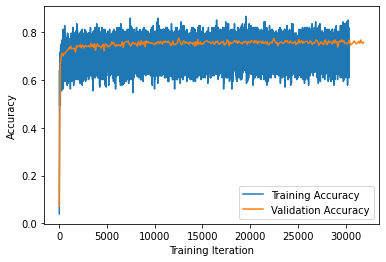

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()